# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.307409        0.195957  0.054515  0.251346  0.068643   
       0.50   0.311761        0.189999  0.061382  0.220293  0.099379   
       0.75   0.315009        0.183381  0.068825  0.198856  0.120063   
       1.00   0.317709        0.176455  0.076020  0.183449  0.134574   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.200062  0.009897  0.039914  0.049520  0.000575  
       0.50  0.200554  0.009227  0.039269  0.049266  0.001492  
       0.75  0.201776  0.008097  0.038130  0.049349  0.002555  
       1.00  0.203795  0.006931  0.036924  0.049404  0.003708

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50   0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75   0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00   0.288190        0.174077  0.089557  0.183997  0.136357   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.200059  0.009901  0.039914  0.049716  0.000379  
         0.50  0.200543  0.009250  0.039268  0.049773  0.000986  
         0.75  0.201742  0.008158  0.038120  0.050221  0.001694  
         1.00  0.203716  0.007056  0.036890  0.050678  0.002468

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


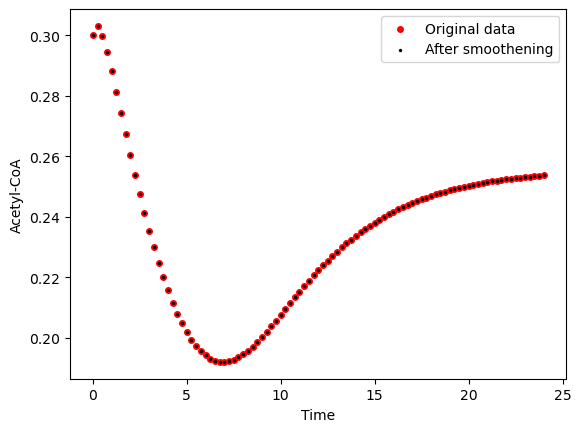

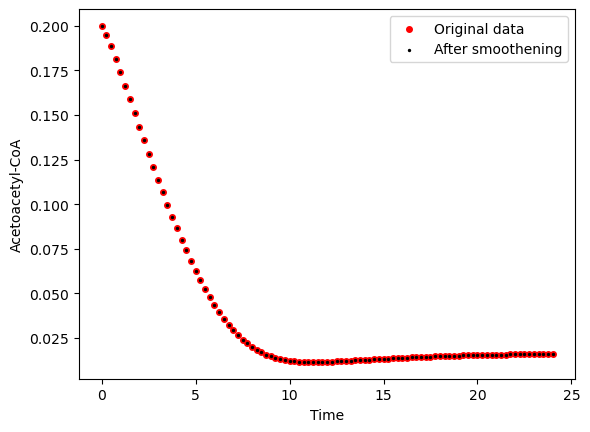

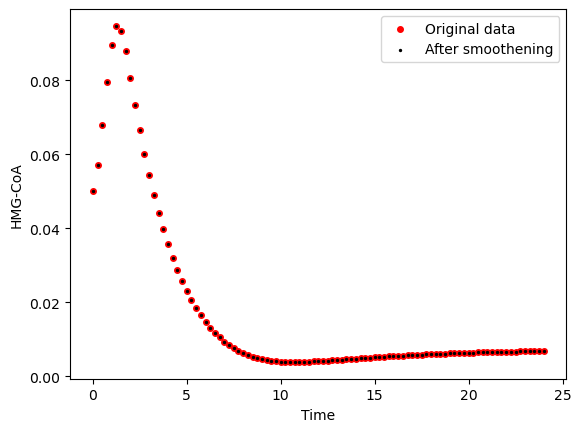

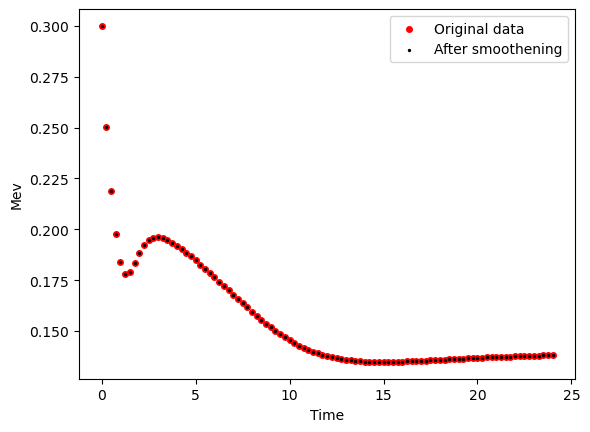

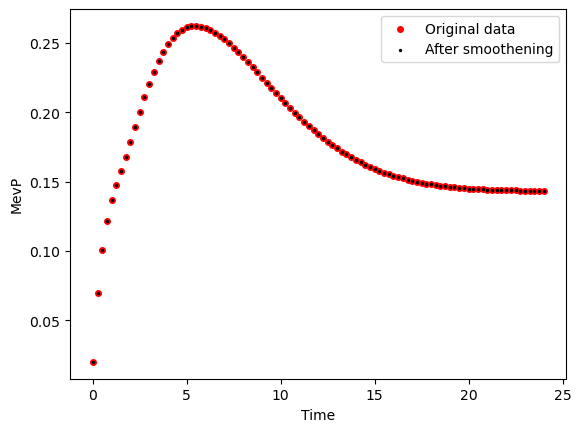

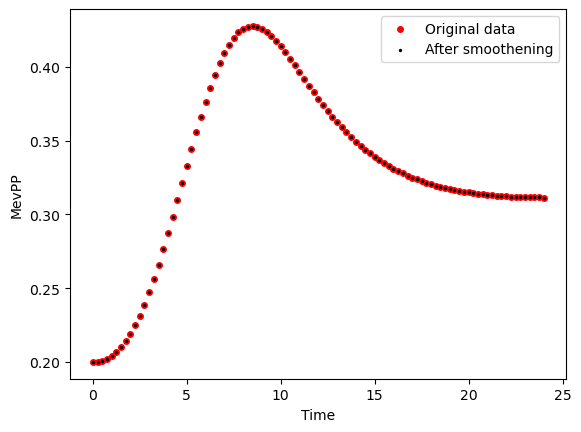

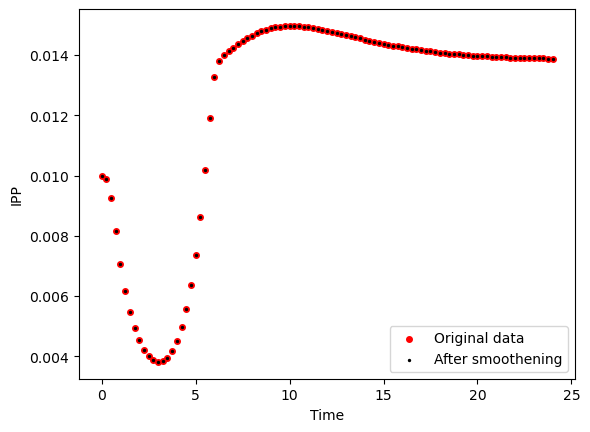

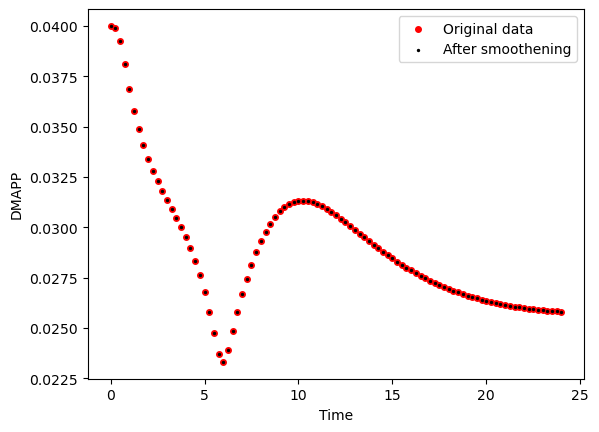

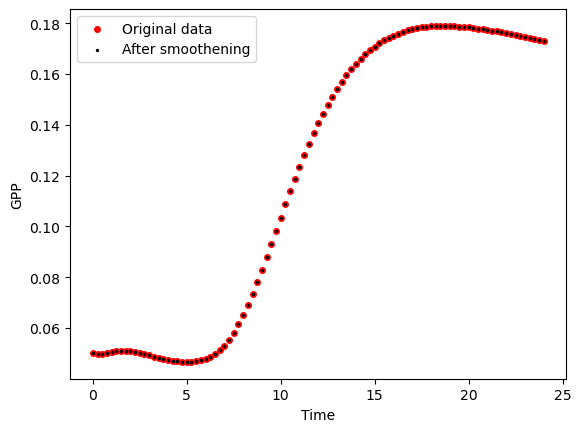

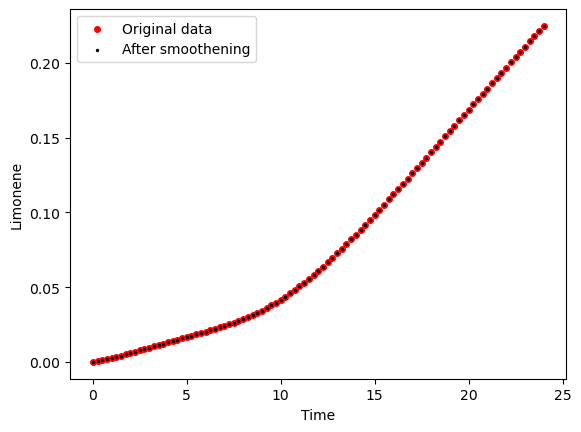

Strain Strain 2


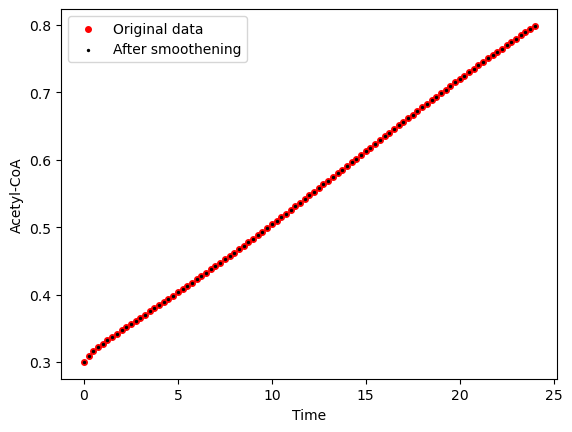

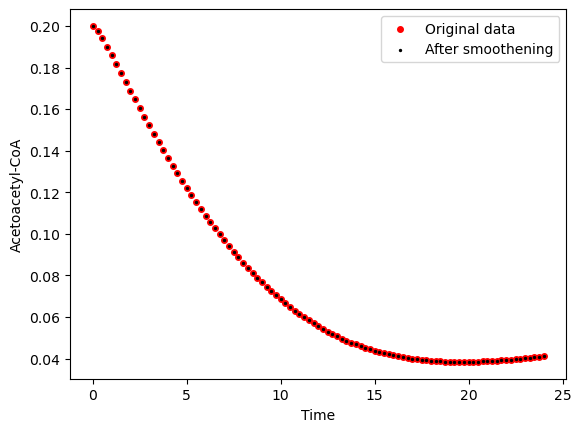

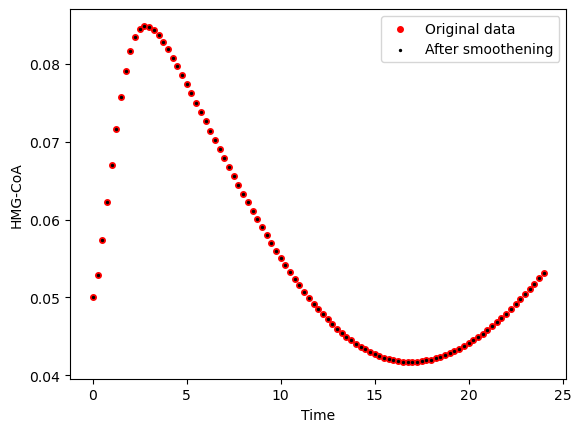

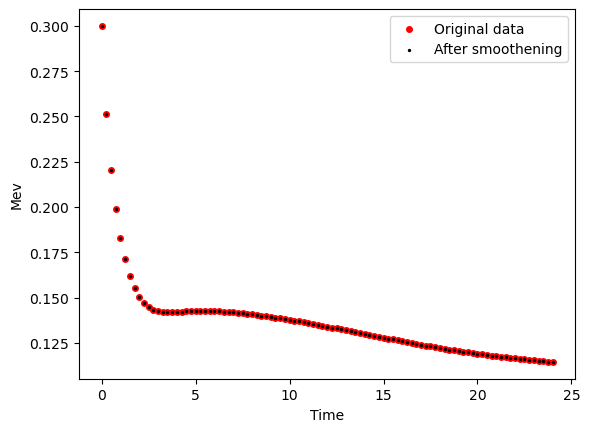

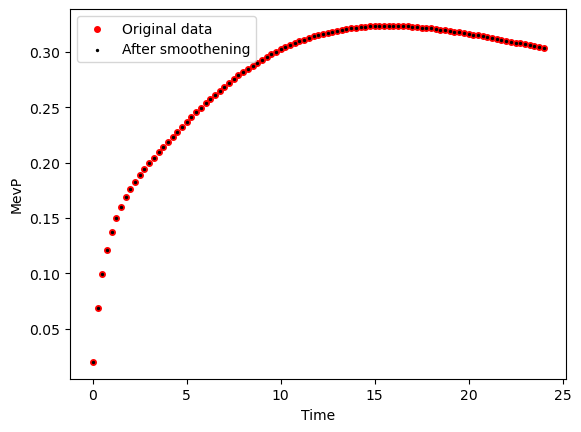

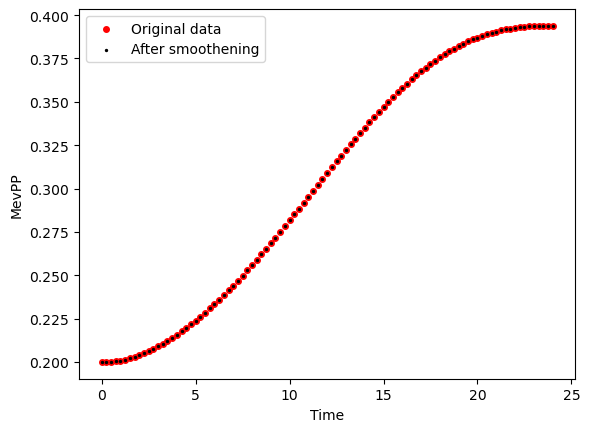

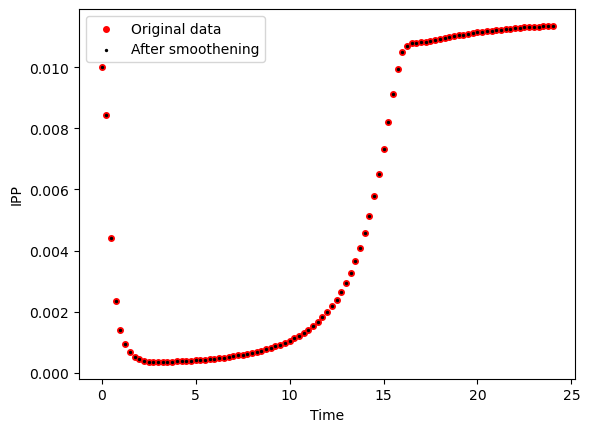

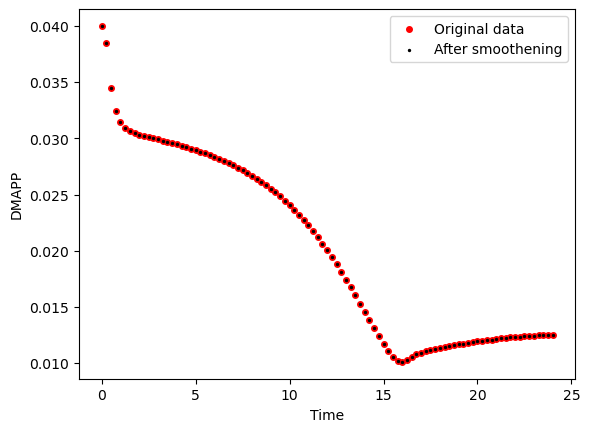

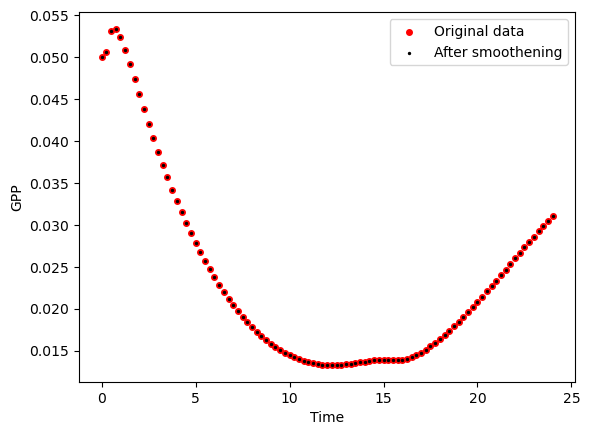

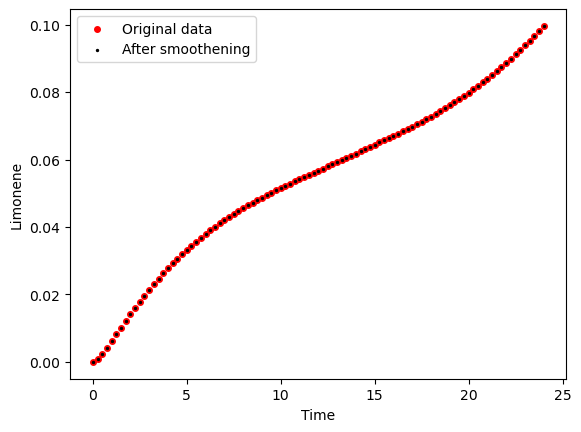

Strain Strain 3


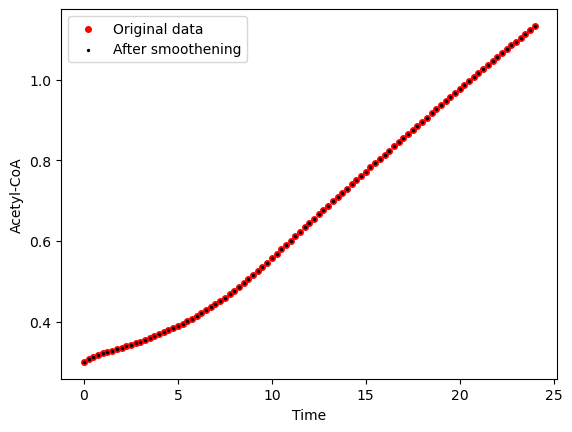

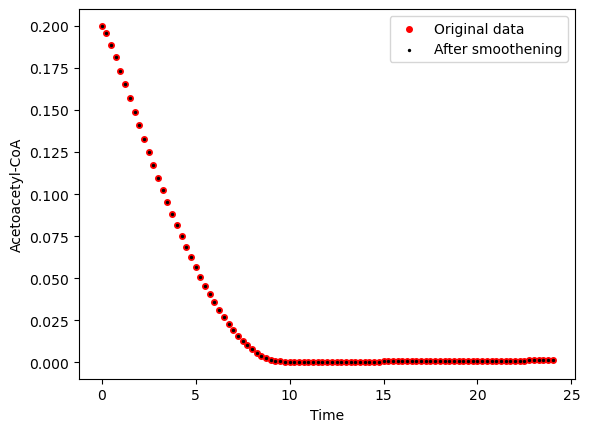

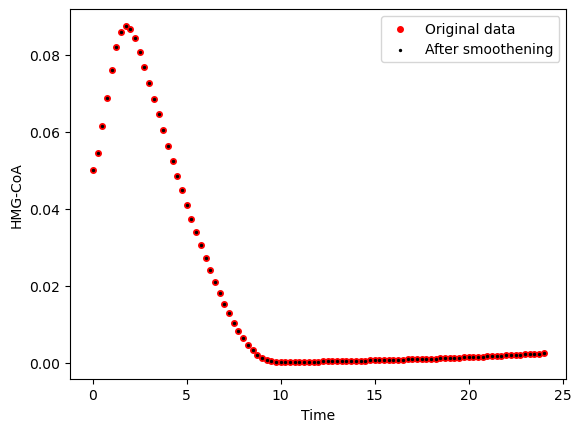

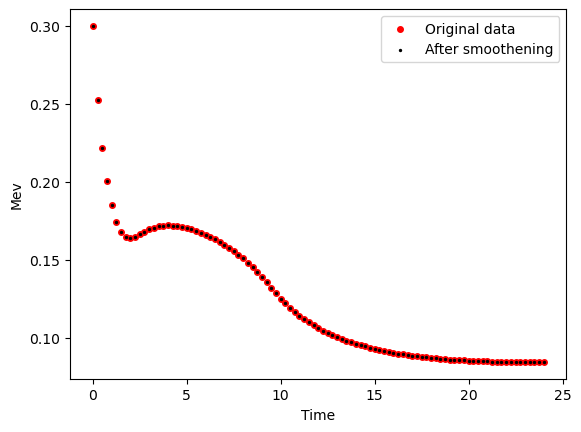

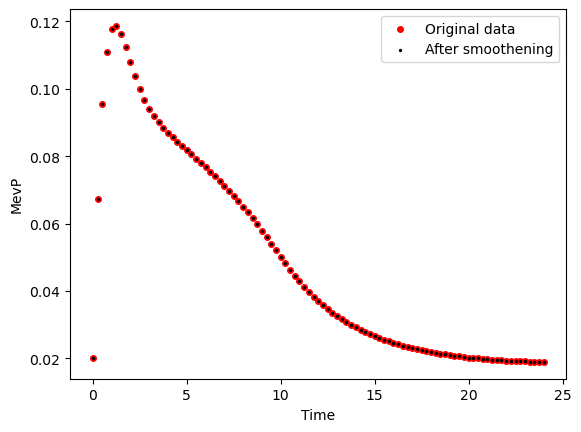

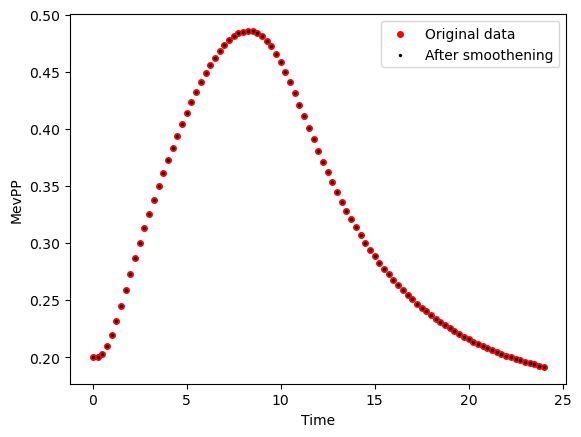

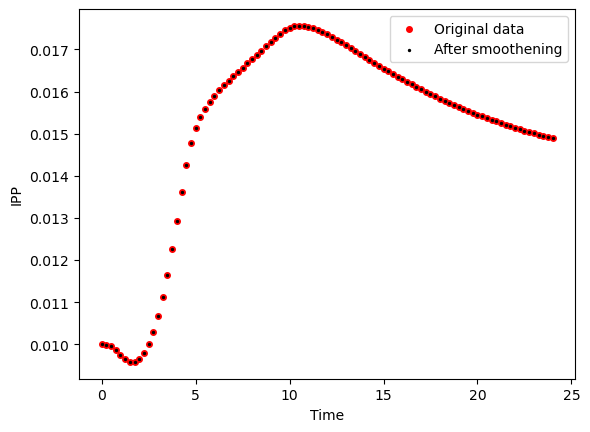

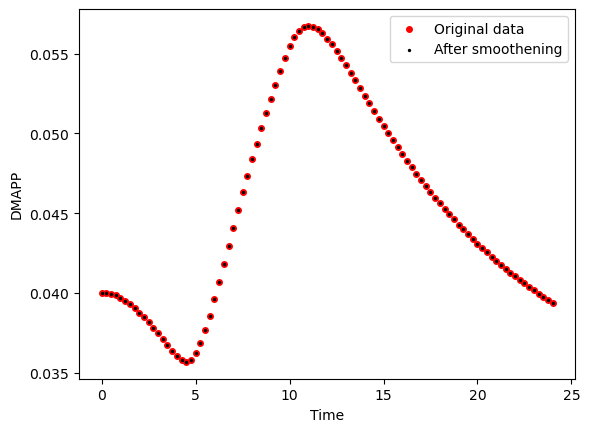

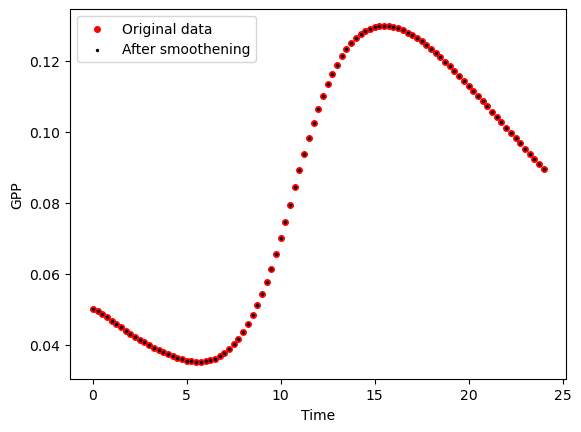

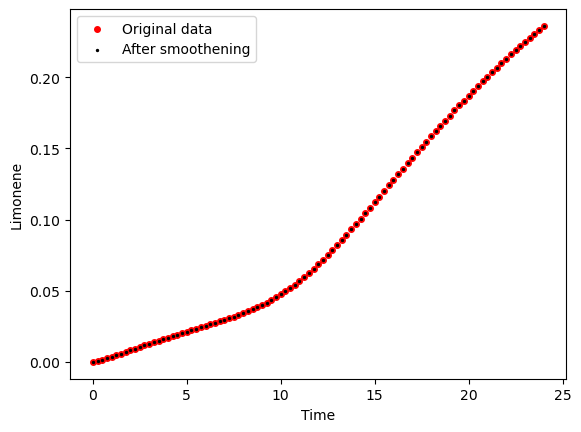

Strain WT


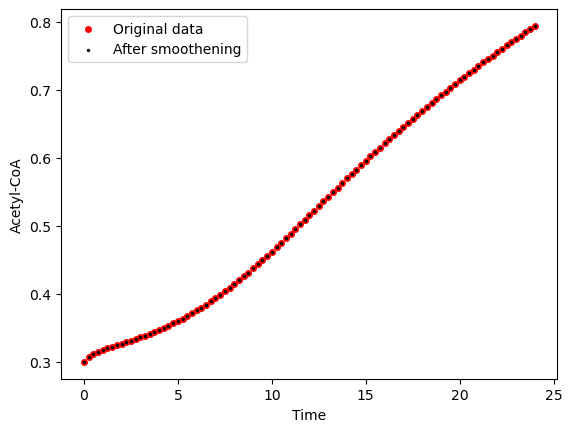

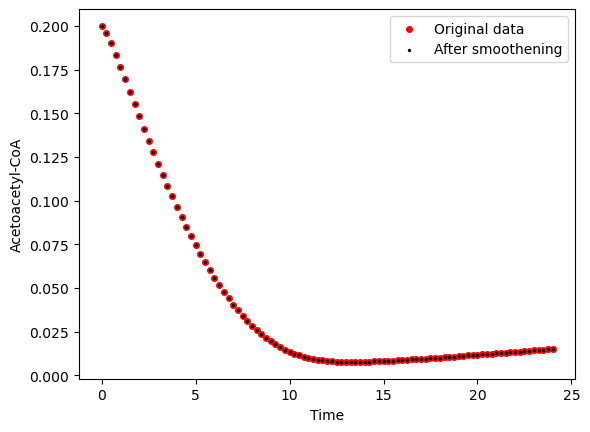

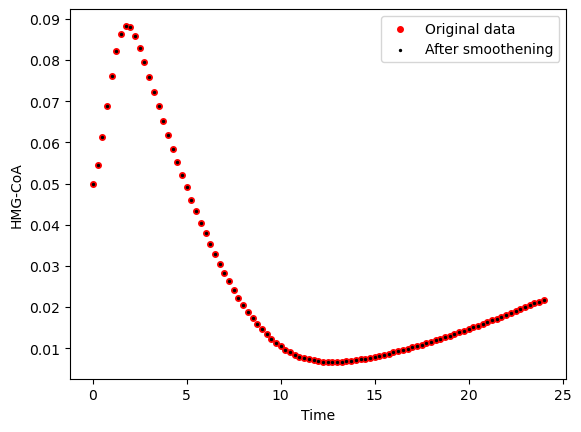

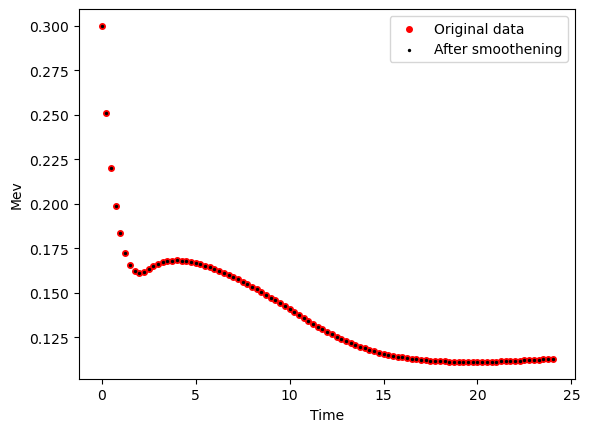

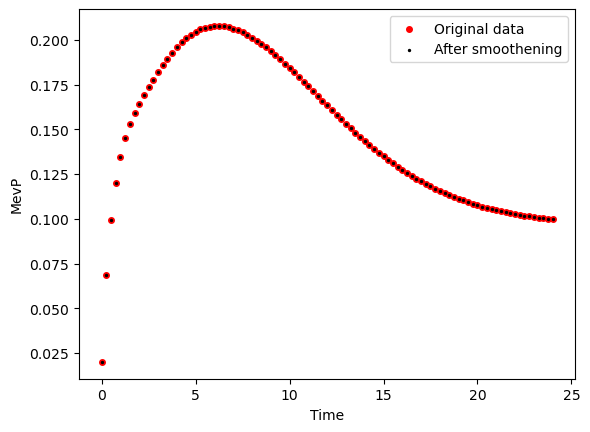

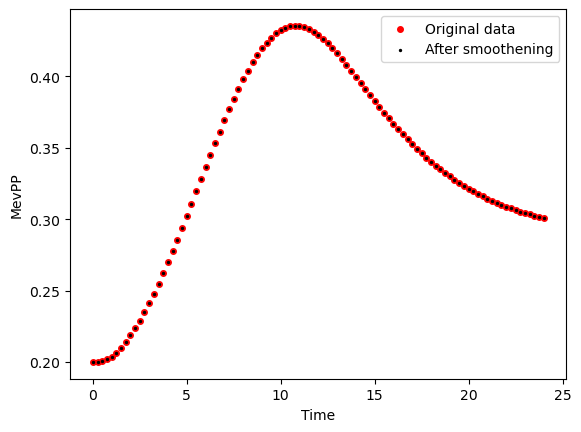

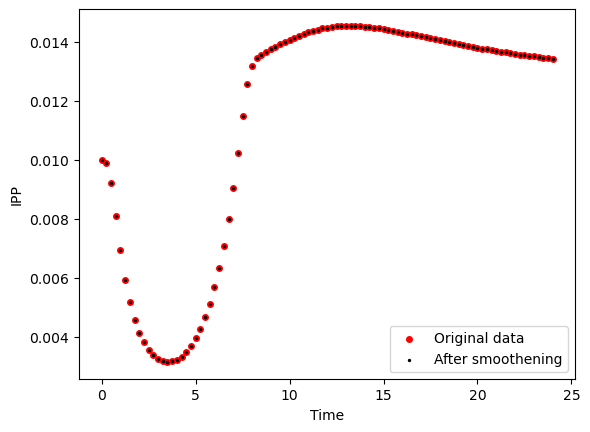

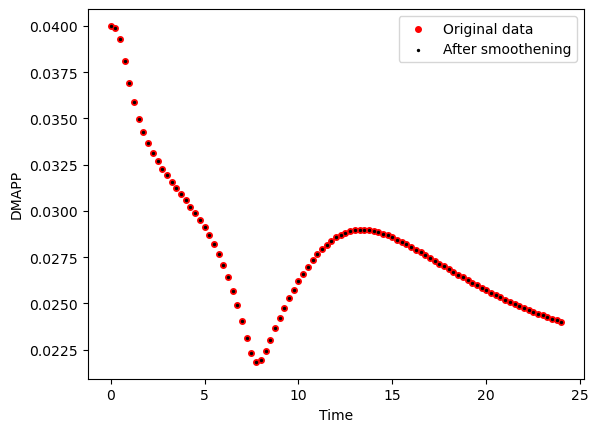

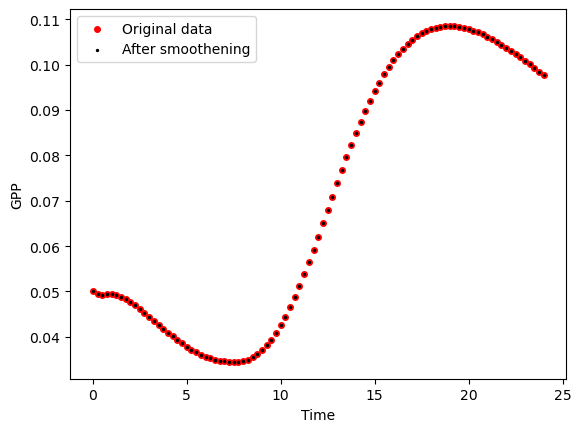

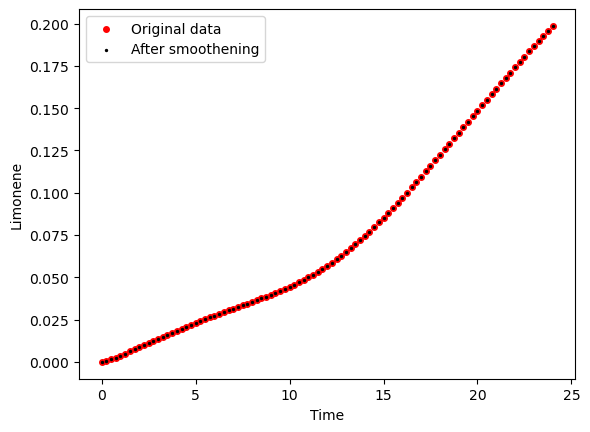

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


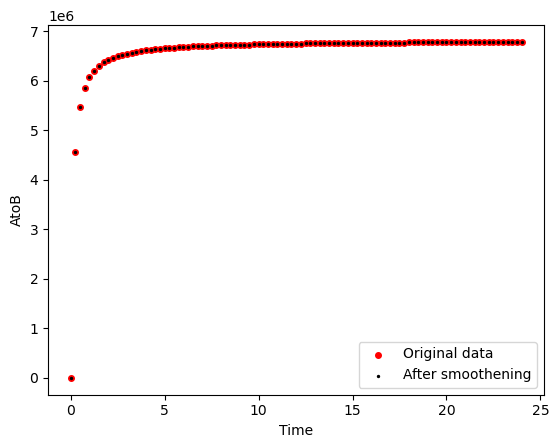

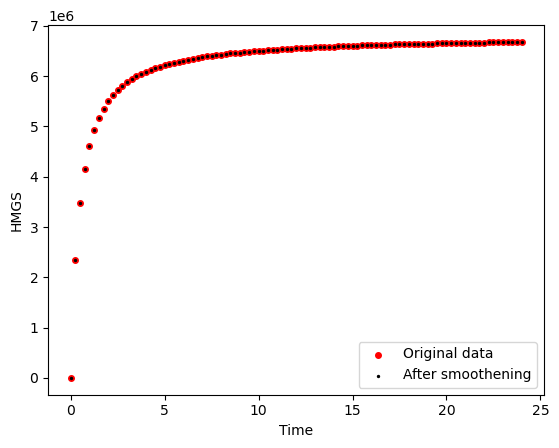

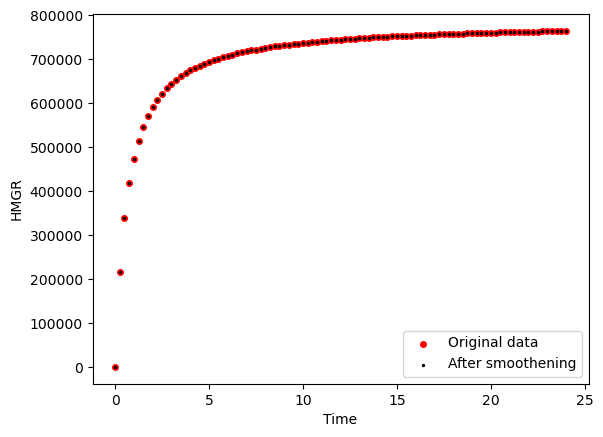

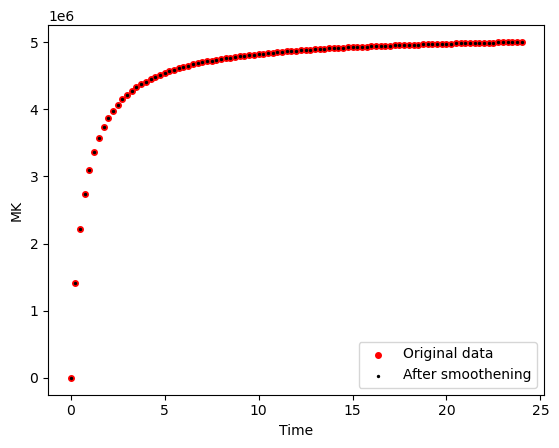

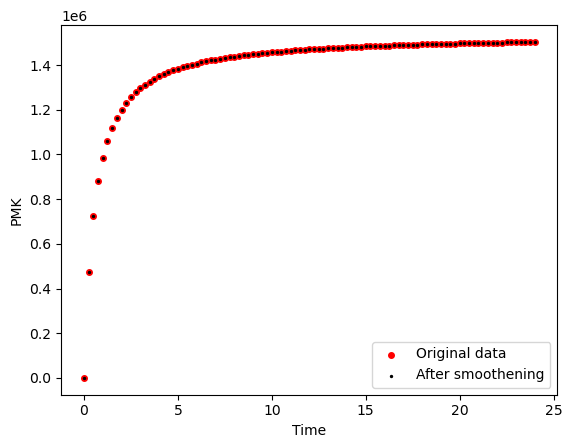

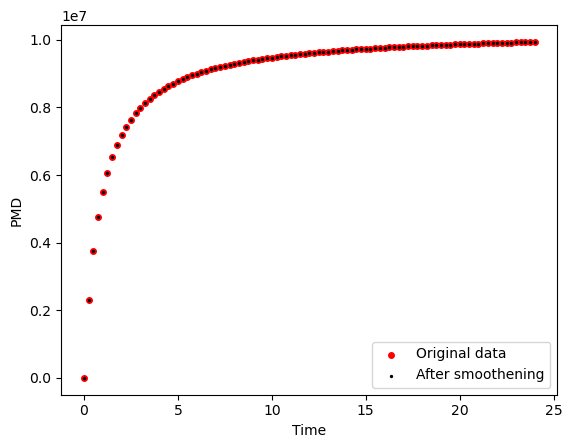

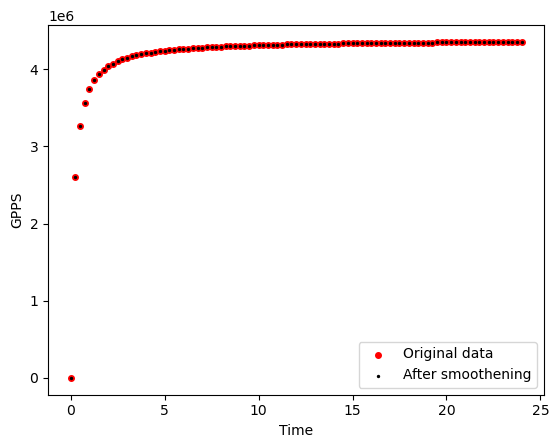

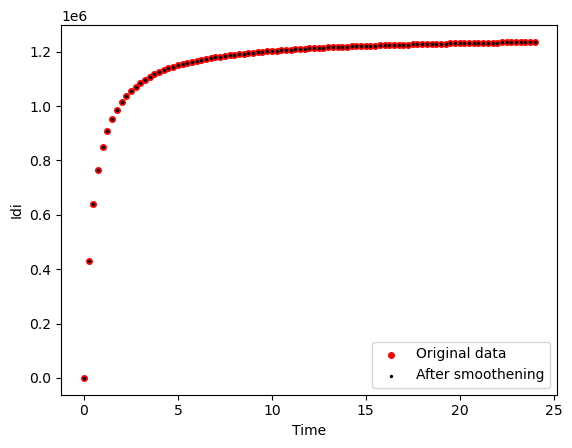

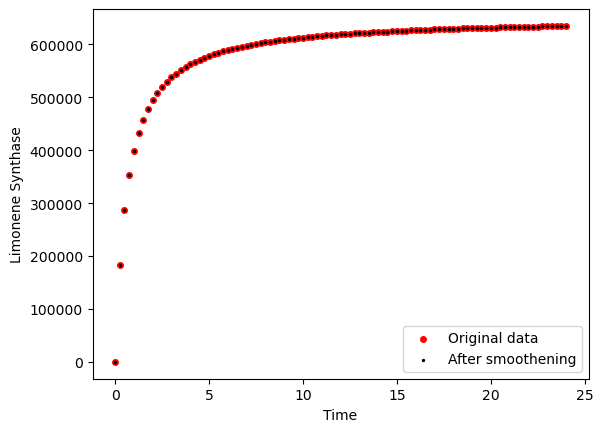

Strain Strain 2


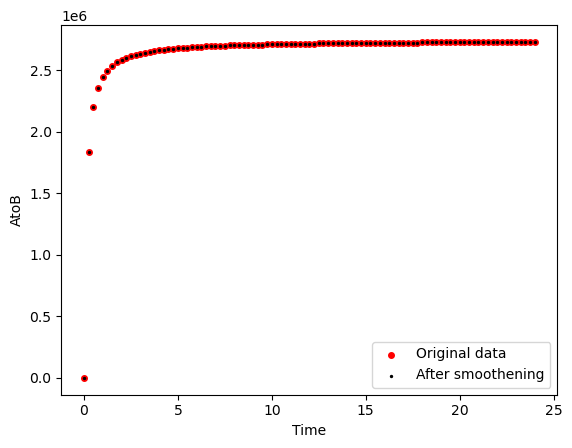

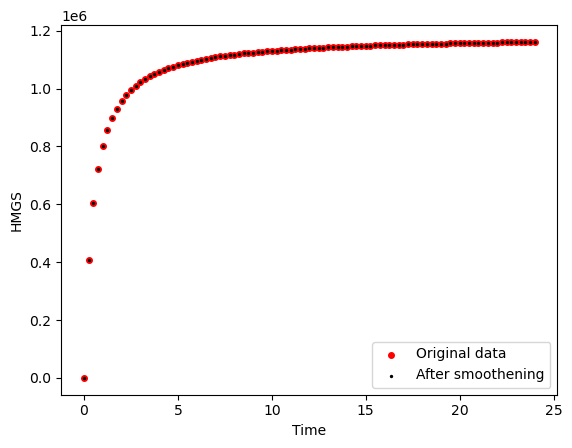

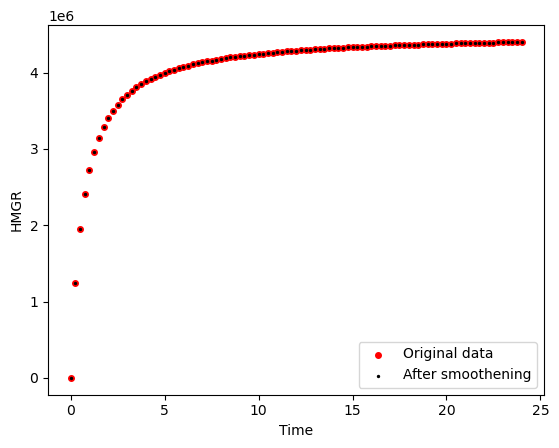

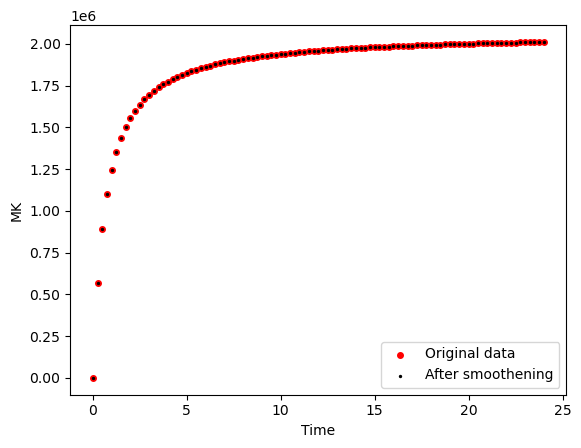

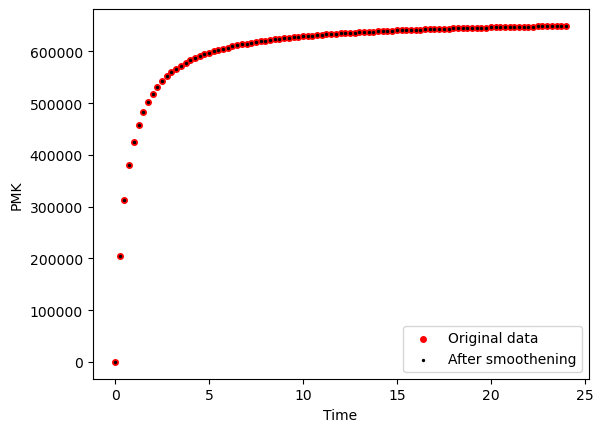

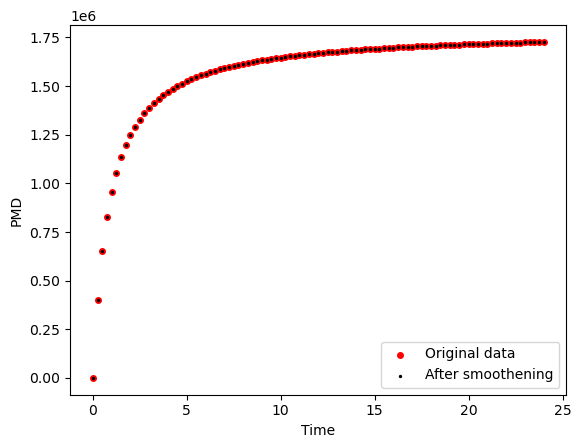

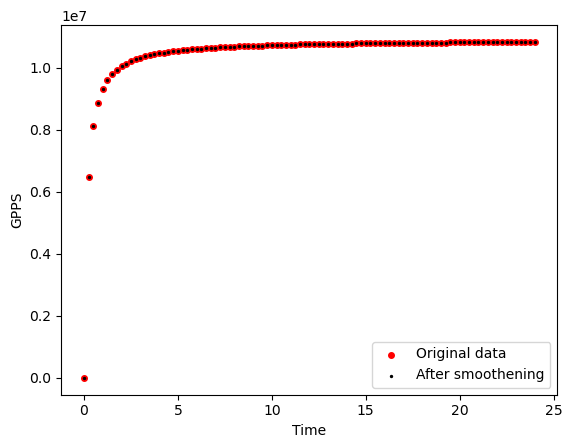

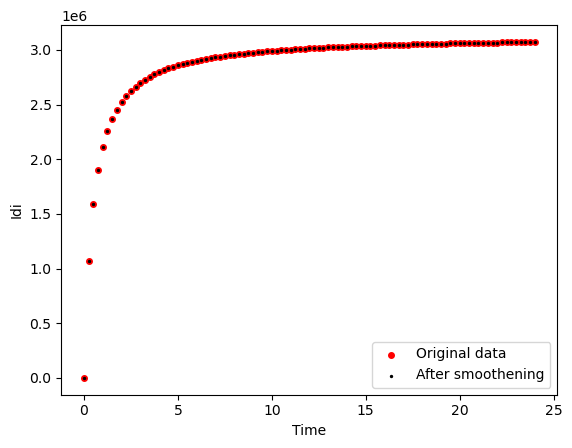

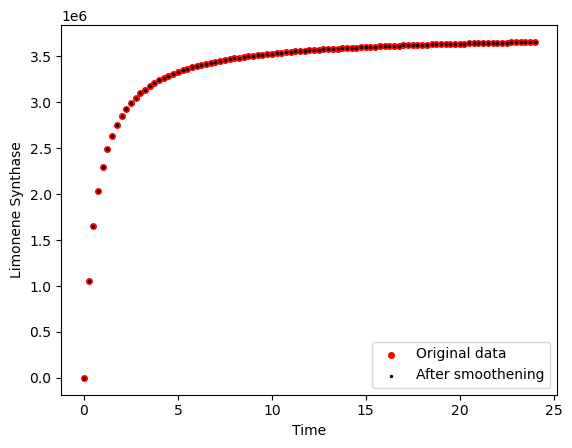

Strain Strain 3


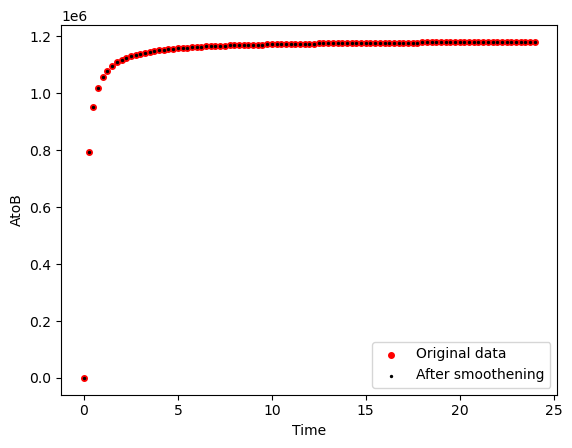

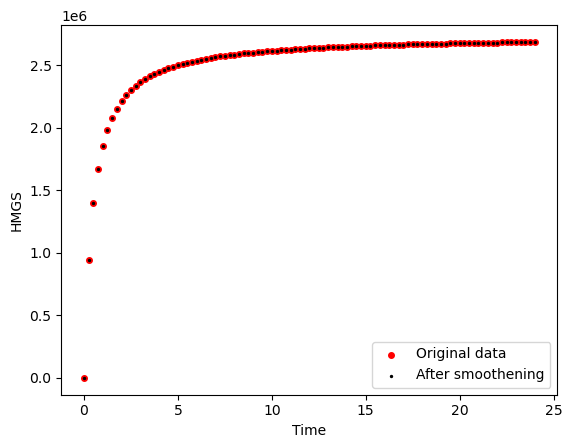

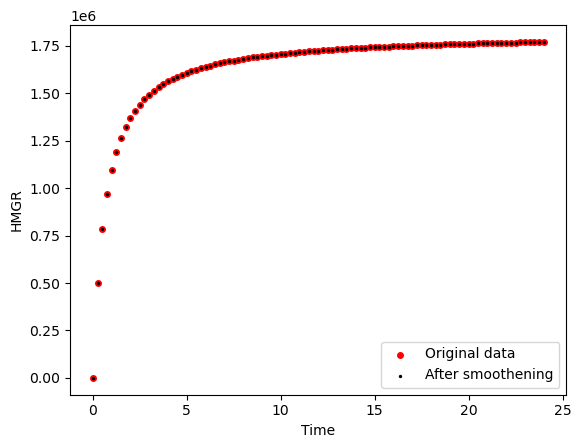

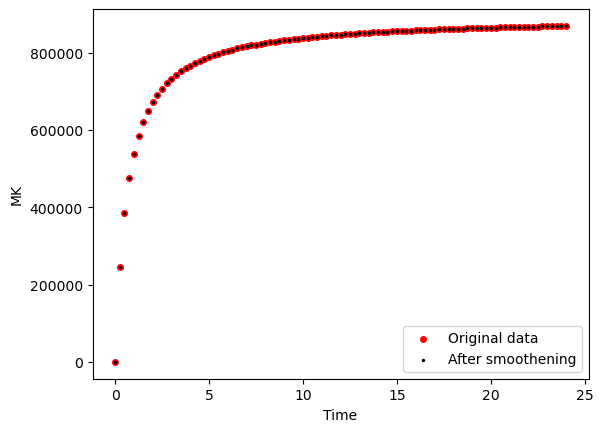

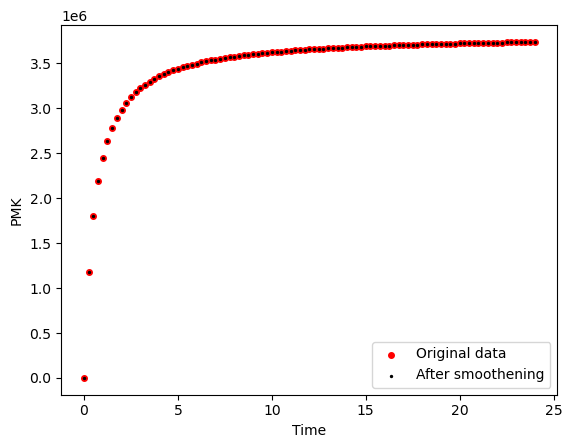

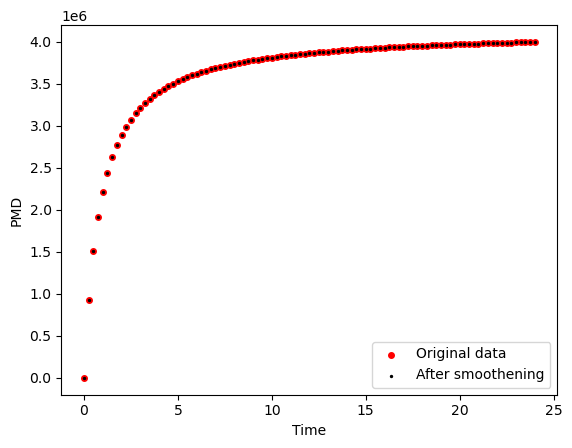

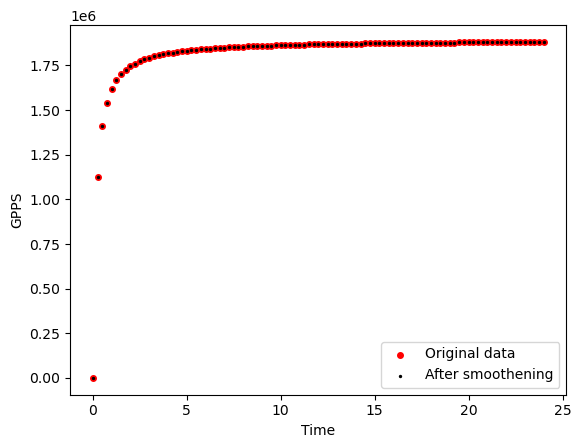

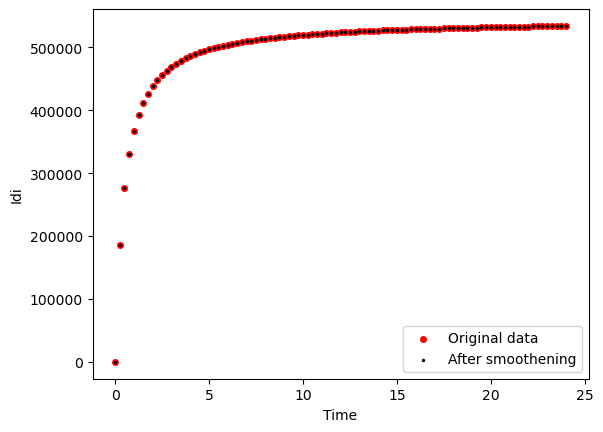

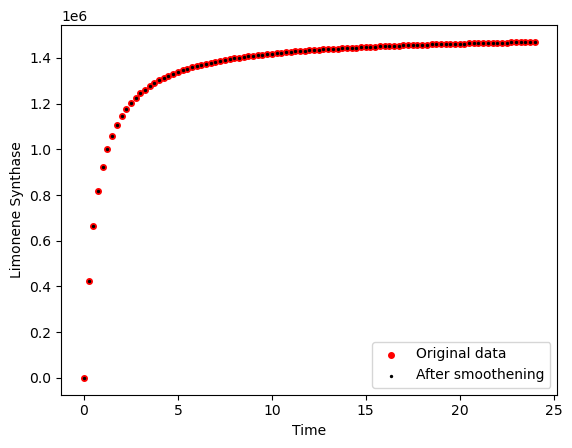

Strain WT


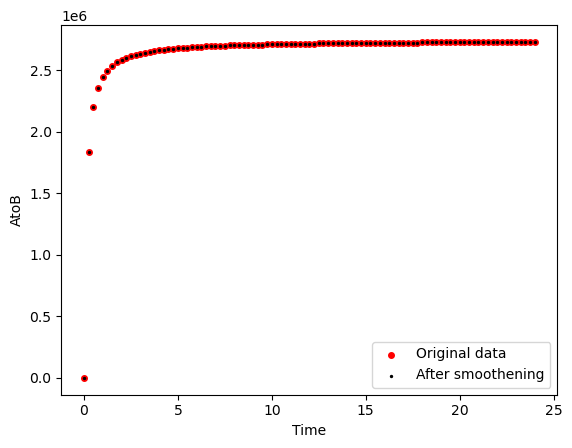

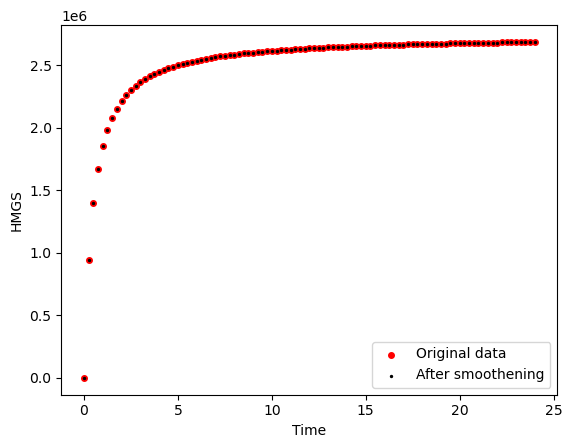

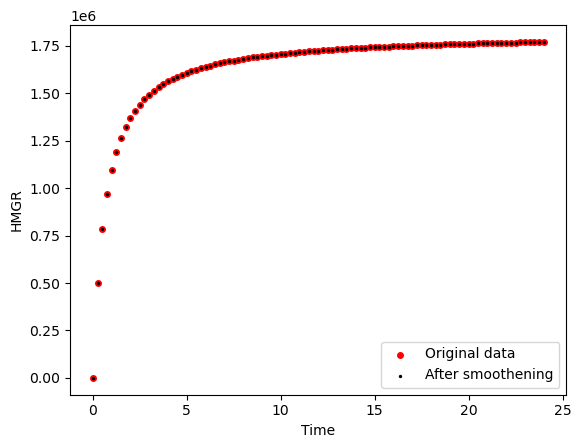

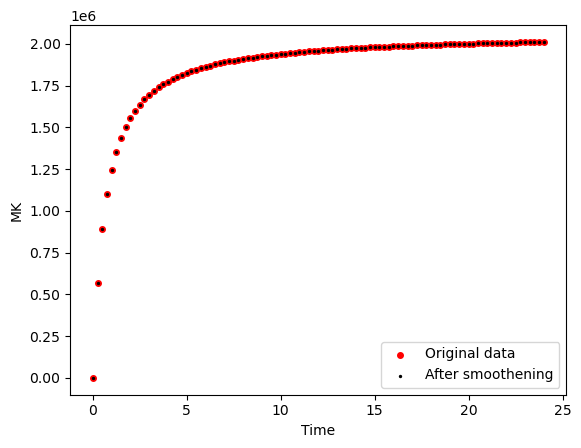

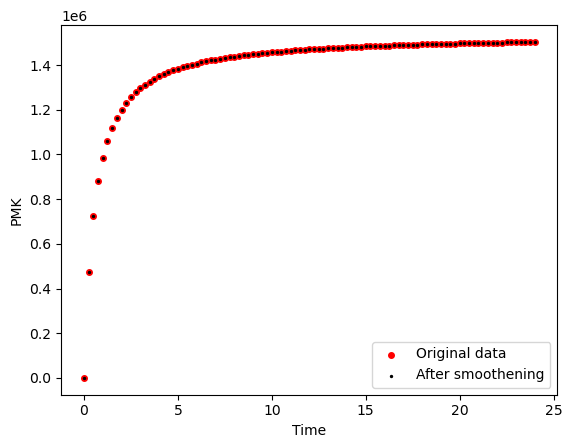

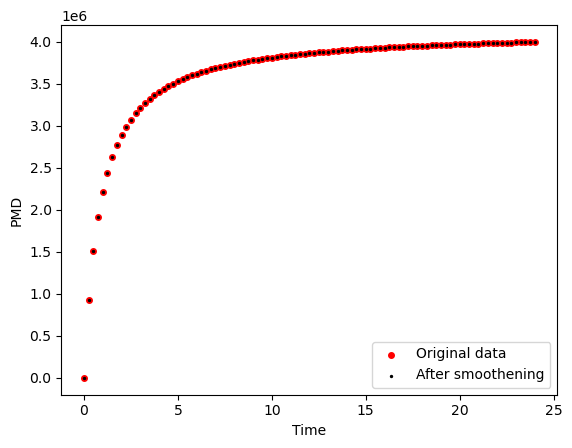

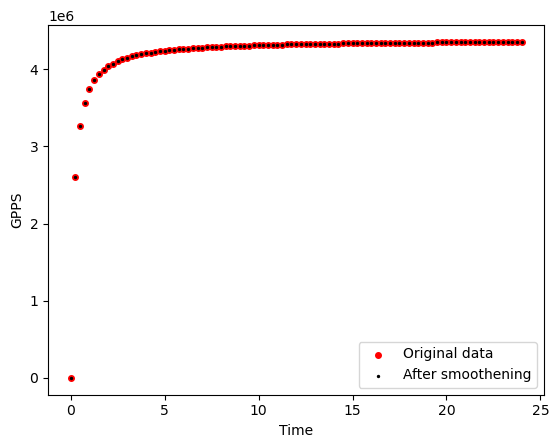

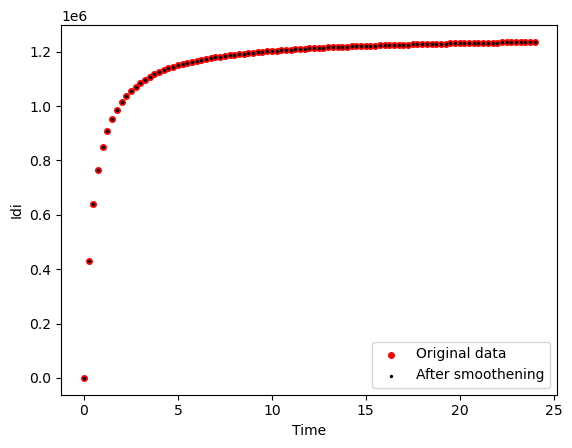

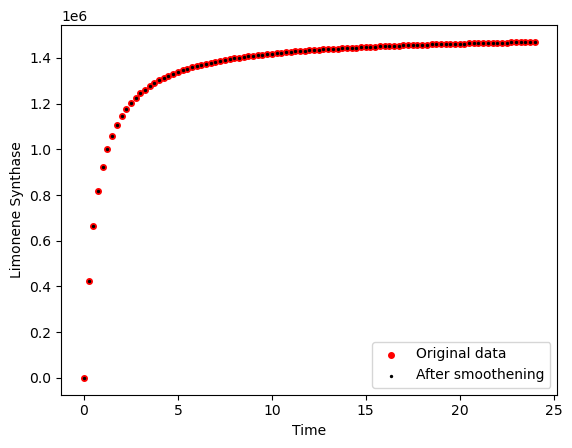

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303073        0.195043  0.057155  0.250311  0.069661   
         0.50    0.299893        0.188541  0.068037  0.218933  0.100735   
         0.75    0.294538        0.181467  0.079599  0.197732  0.121566   
         1.00    0.288190        0.174077  0.089557  0.183997  0.136357   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.25   0.779833        0.014374  0.020413  0.112530  0.100700   
         23.50   0.784584        0.014581  0.020886  0.112676  0.100406   
         23.75   0.789290        0.014788  0.021363  0.112825  0.100138   
         24.00   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.200059  0.009901  0.039914  0.049716  0.000379  ...   
         0.50   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         0.75   0.201742  0.008158  0.038120  0.050221  0.001694  ...   
         1.00   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.25  0.303339  0.013479  0.024268  0.100090  0.189619  ...   
         23.50  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         23.75  0.301600  0.013442  0.024094  0.098489  0.195636  ...   
         24.00  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

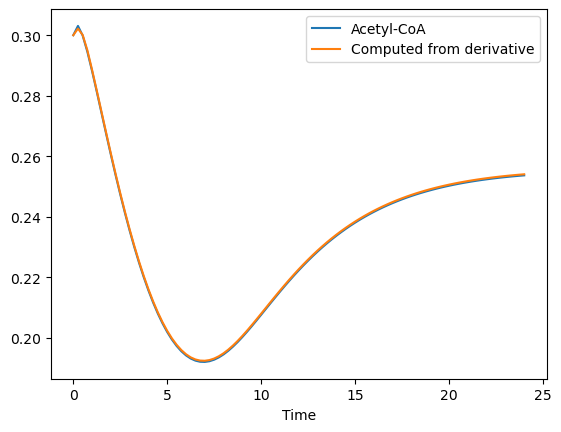

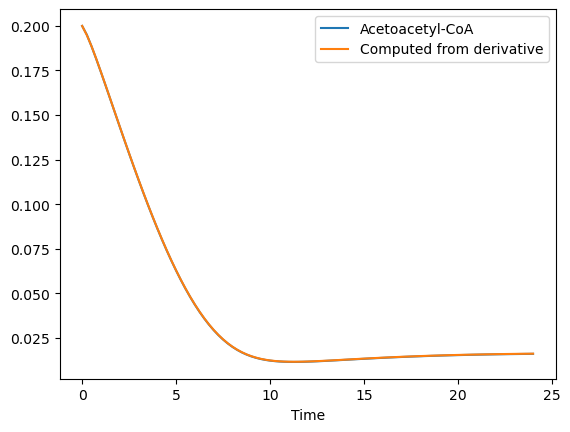

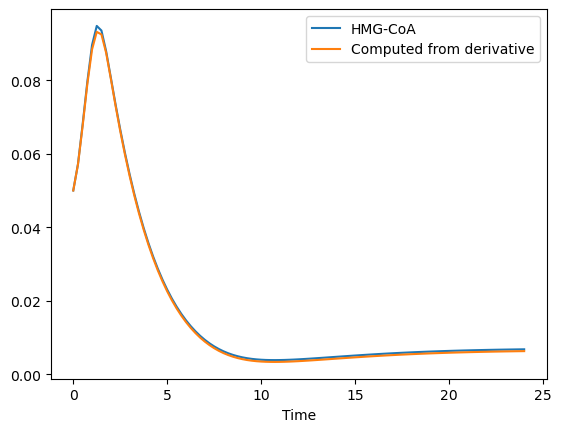

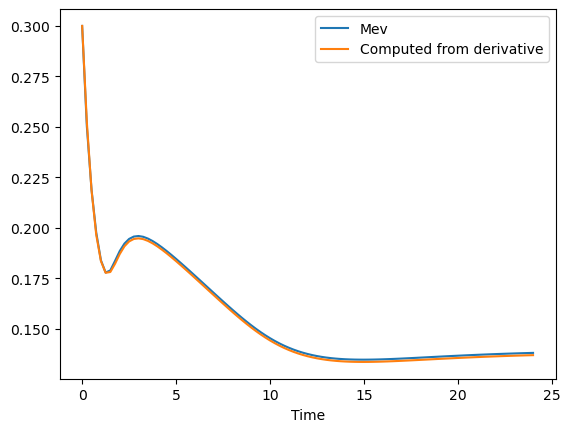

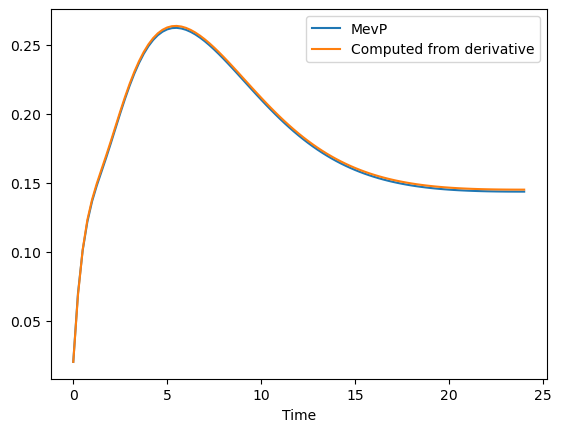

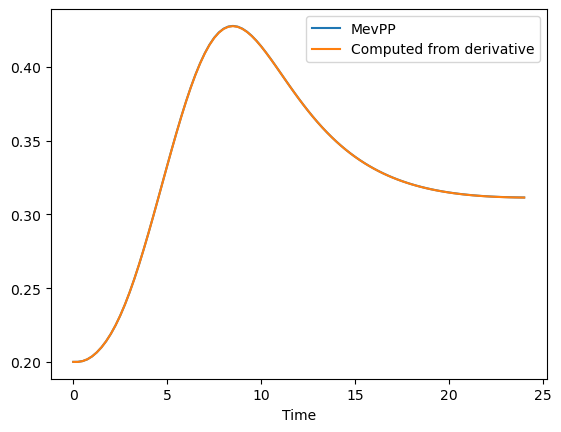

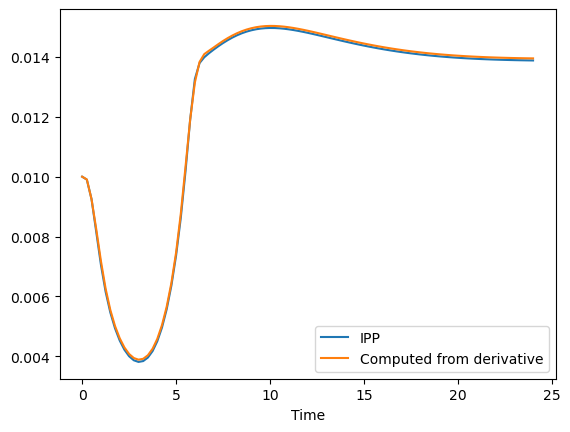

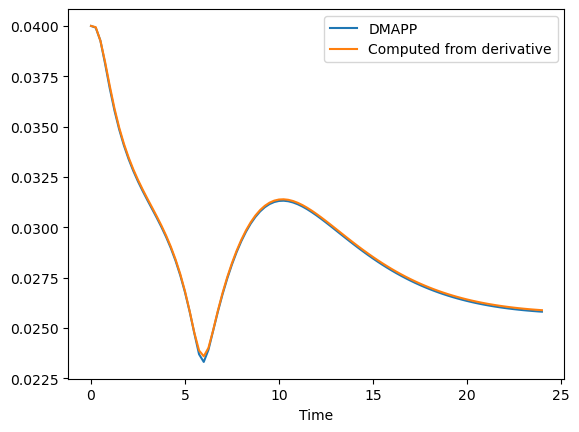

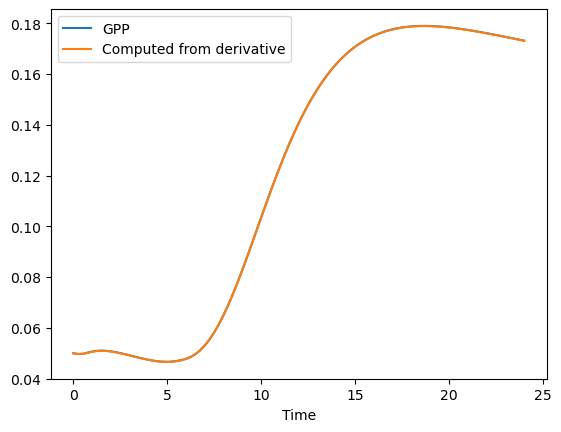

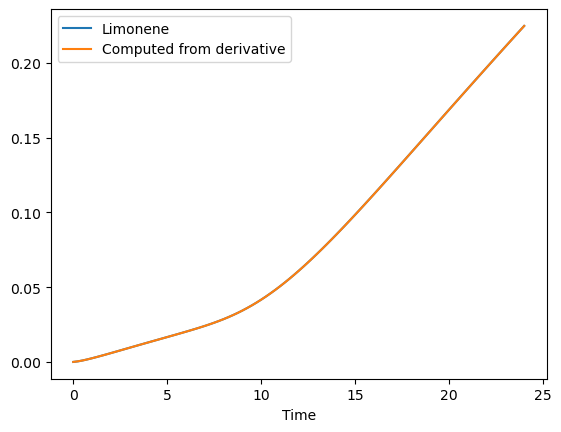

'Time profile from derivative vs. actual profile for Strain 2'

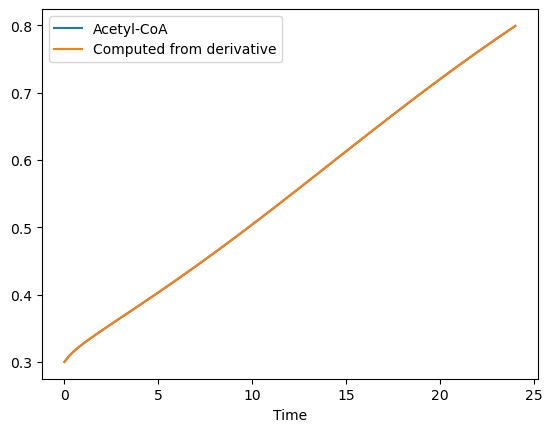

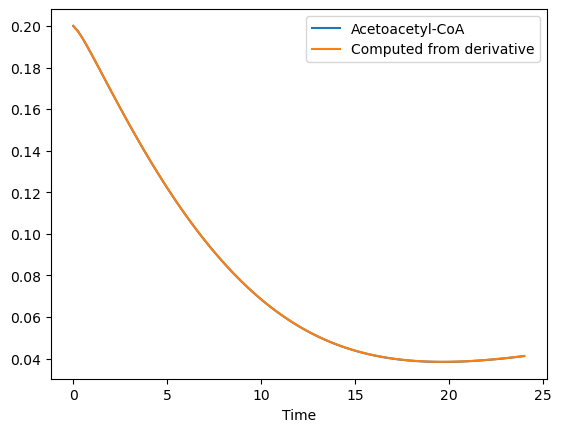

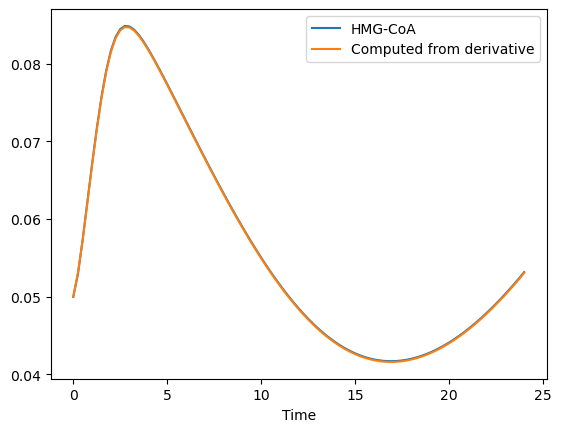

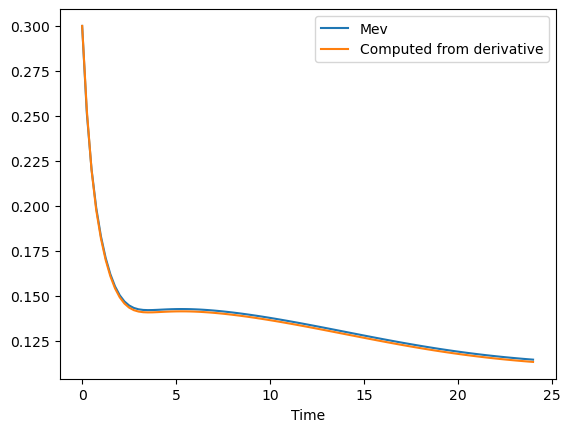

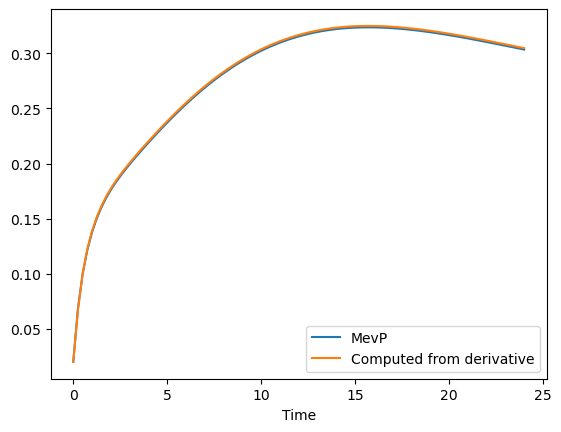

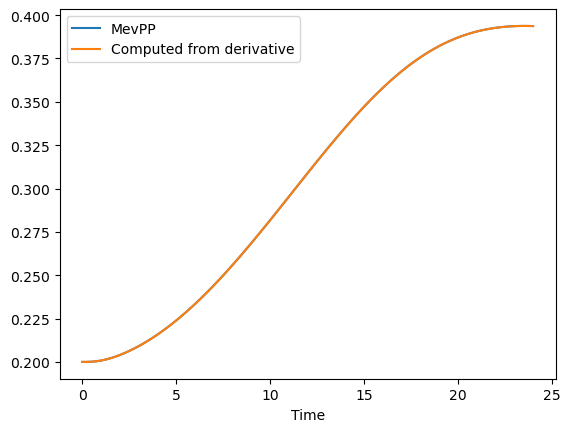

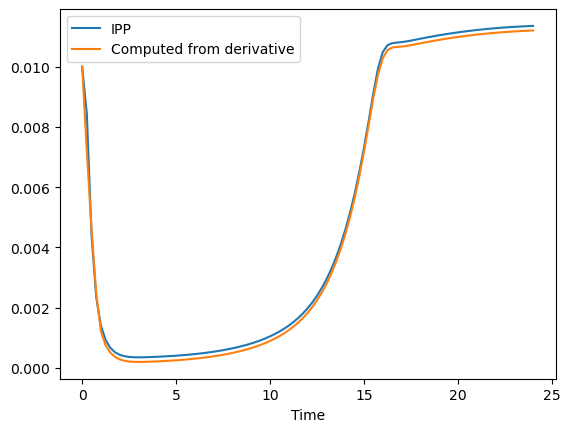

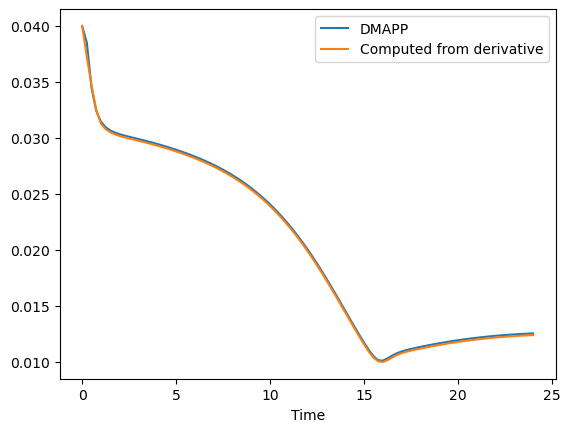

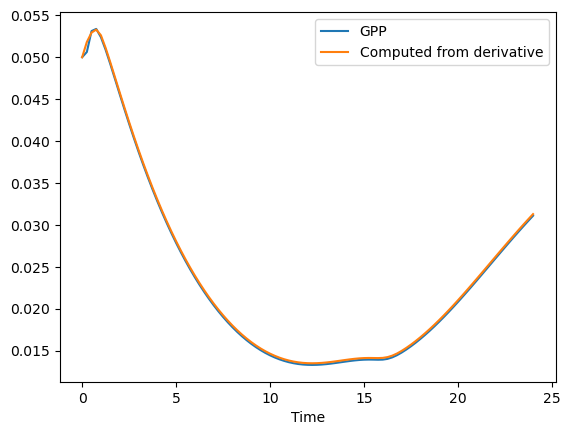

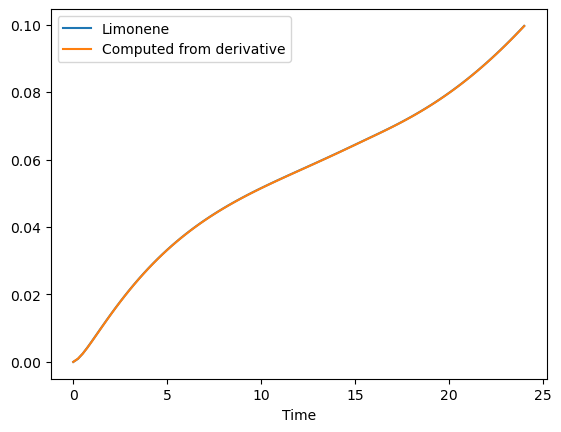

'Time profile from derivative vs. actual profile for Strain 3'

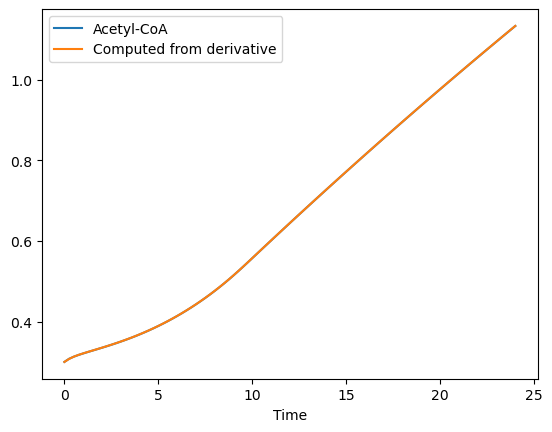

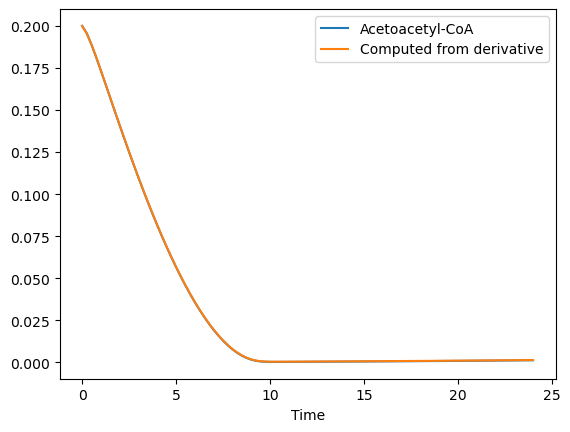

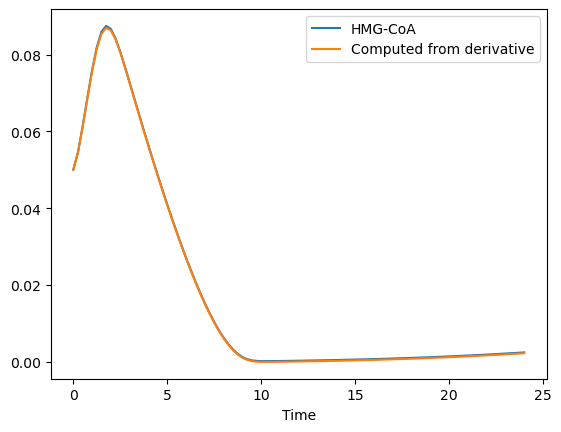

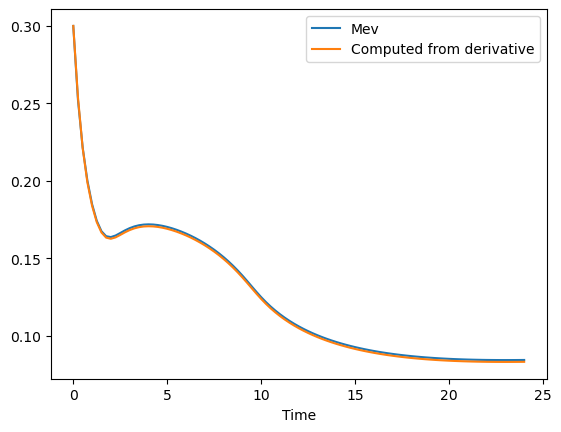

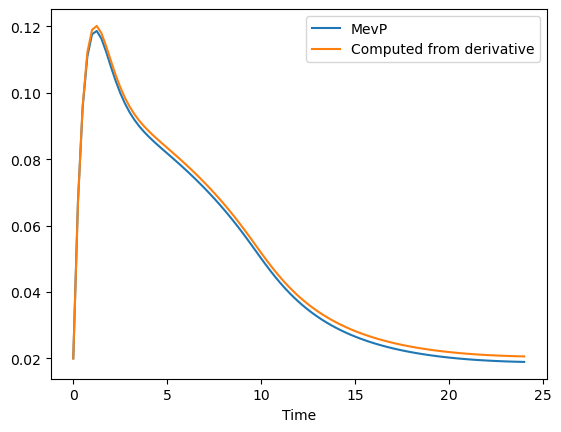

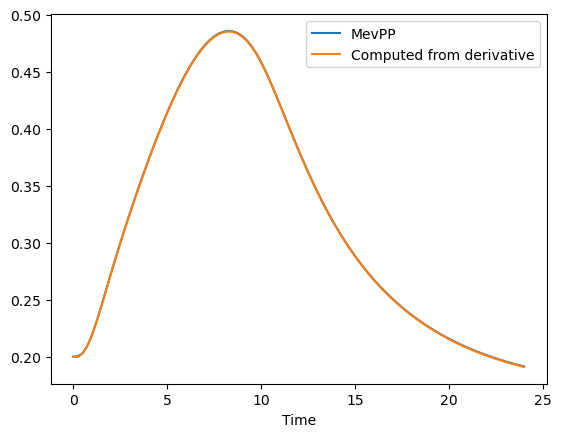

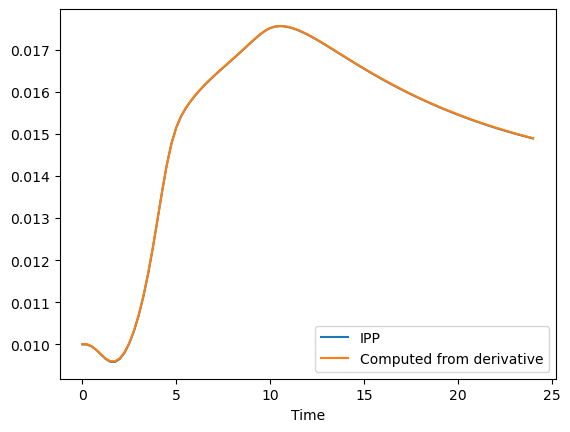

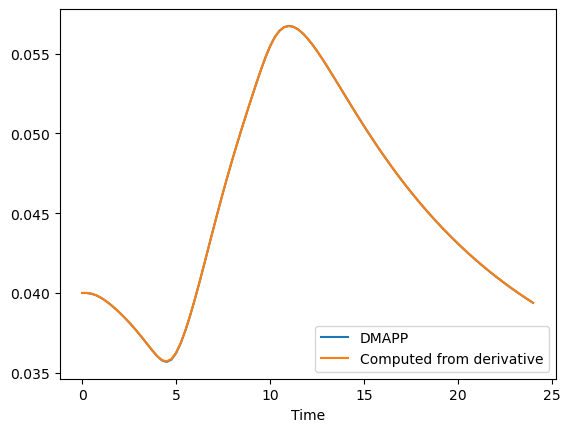

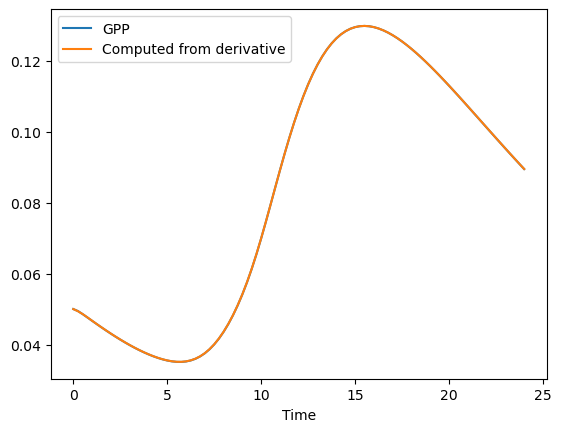

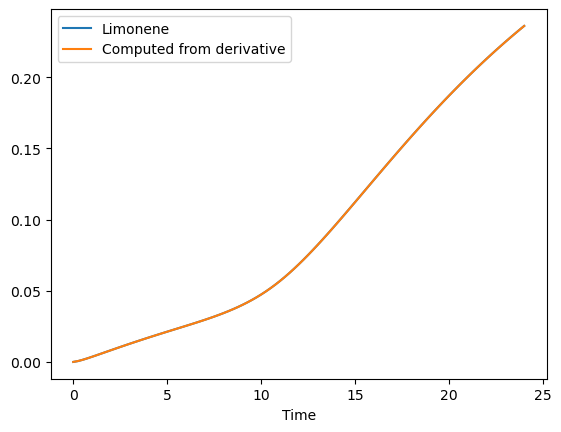

'Time profile from derivative vs. actual profile for WT'

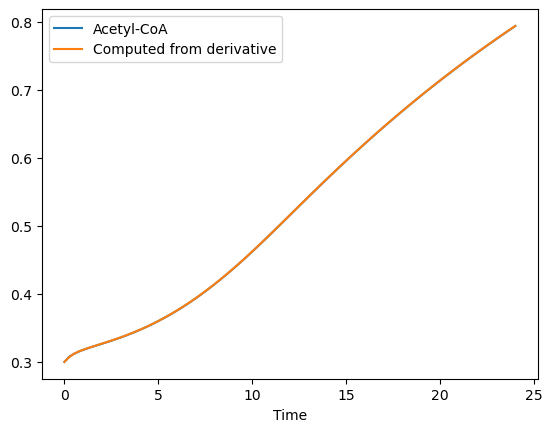

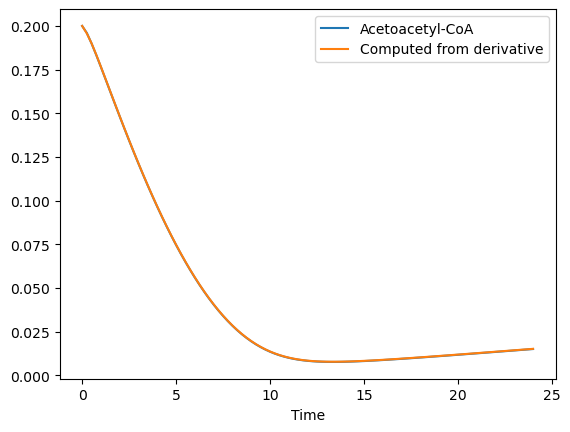

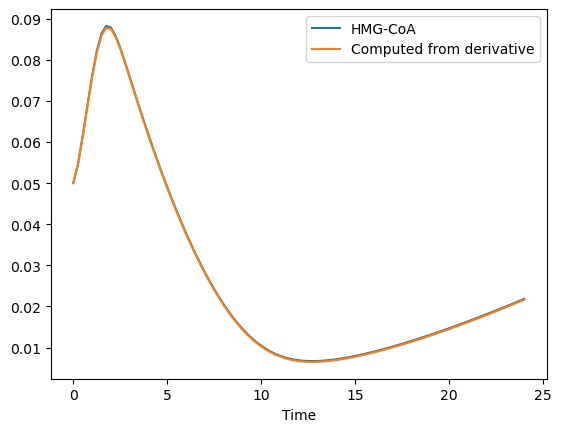

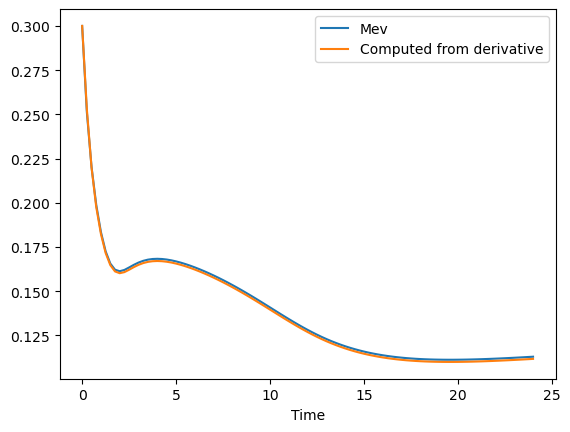

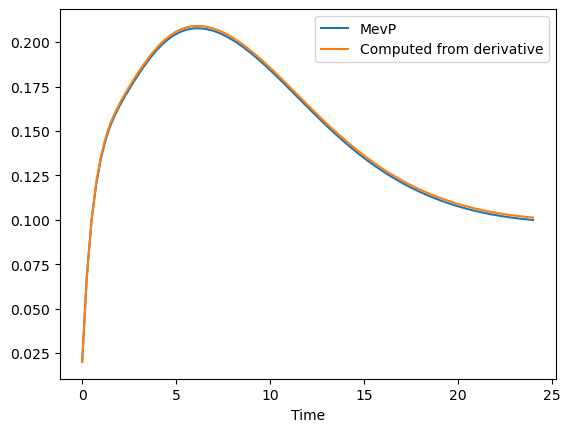

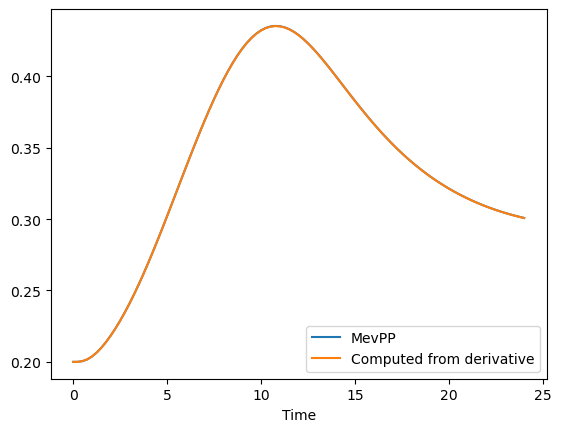

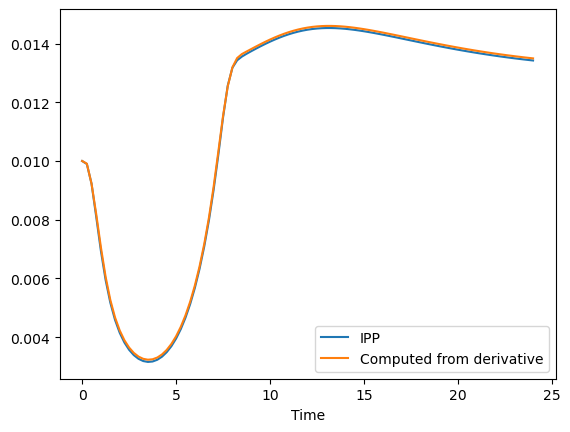

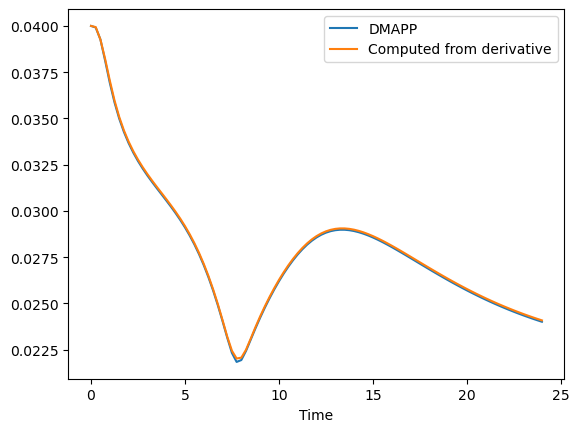

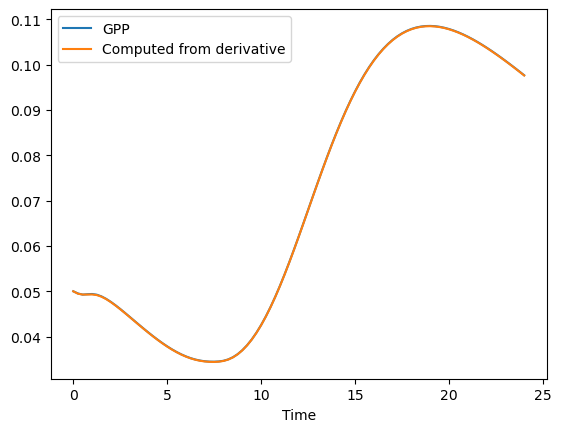

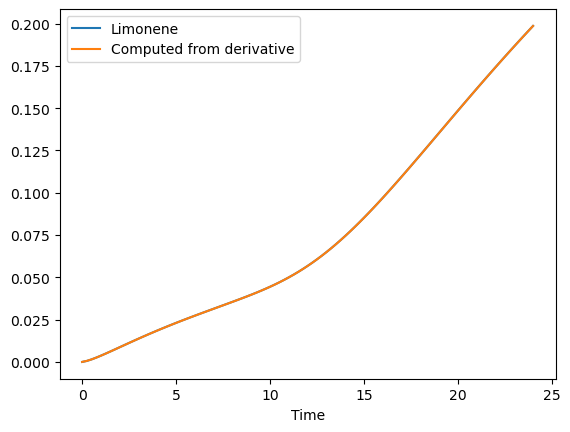

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303073        0.195043  0.057155   
         0.50       2.866143e+05   0.299893        0.188541  0.068037   
         0.75       3.524272e+05   0.294538        0.181467  0.079599   
         1.00       3.981392e+05   0.288190        0.174077  0.089557   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.775039        0.014167  0.019944   
         23.25      1.468435e+06   0.779833        0.014374  0.020413   
         23.50      1.468851e+06   0.784584        0.014581  0.020886   
         23.75      1.469260e+06   0.789290        0.014788  0.021363   
         24.00      1.469659e+06   0.793953        0.014996  0.021843   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.250311  0.069661  0.200059  0.009901  0.039914  0.049716   
         0.50   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         0.75   0.197732  0.121566  0.201742  0.008158  0.038120  0.050221   
         1.00   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.25  0.112530  0.100700  0.303339  0.013479  0.024268  0.100090   
         23.50  0.112676  0.100406  0.302440  0.013460  0.024180 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.018594       -0.018182  0.018805 -0.220877  0.228172   
         0.25    -0.001101       -0.023119  0.037819 -0.160423  0.158607   
         0.50    -0.015600       -0.026822  0.046418 -0.109091  0.105123   
         0.75    -0.024903       -0.029292  0.044600 -0.066881  0.067719   
         1.00    -0.026775       -0.030023  0.030284 -0.037420  0.050530   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.019269        0.000828  0.001867  0.000553 -0.001353   
         23.25    0.019090        0.000828  0.001883  0.000573 -0.001236   
         23.50    0.018914        0.000829  0.001899  0.000591 -0.001124   
         23.75    0.018739        0.000829  0.001915  0.000606 -0.001016   
         24.00    0.018565        0.000829  0.001931  0.000620 -0.000913   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.001239  0.001000  0.001198 -0.002373  0.001240  
         0.25   0.001046 -0.001742 -0.001698 -0.000249  0.001999  
         0.50   0.003542 -0.003549 -0.003689  0.001138  0.002590  
         0.75   0.006251 -0.004420 -0.004777  0.001790  0.003013  
         1.00   0.009342 -0.004136 -0.004793  0.001594  0.003202  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.003953 -0.000080 -0.000374 -0.003075  0.012221  
         23.25 -0.003710 -0.000078 -0.000361 -0.003144  0.012129  
         23.50 -0.003476 -0.000075 -0.000349 -0.003203  0.012034  
         23.75 -0.003251 -0.000072 -0.000337 -0.003253  0.011938  
         24.00 -0.003035 -0.000069 -0.000325 -0.003293  0.011840  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'ISRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: ISRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 4.601109E+188 | 7.482622E+113
     2 |       74 | 2.240300E+127 |  2.932883E+84
     3 |      138 |  5.792786E+98 |  2.311487E+70
     4 |      202 |  4.787351E+78 |  3.928756E+66
     5 |      266 |  2.510348E+73 |  6.728623E+62
     6 |      330 |  3.319032E+66 |  9.168934E+54
     7 |      394 |  1.315013E+69 |  3.032954E+53
     8 |      458 |  1.200718E+64 |  7.987774E+42
     9 |      522 |  6.198479E+51 |  1.292046E+40
    10 |      586 |  1.856470E+45 |  5.654074E+34
    11 |      650 |  1.159355E+47 |  5.654074E+34
    12 |      714 |  1.143146E+45 |  5.654074E+34
    13 |      778 |  1.152674E+42 |  6.434860E+32
    14 |      842 |  9.862525E+39 |  3.443561E+29
    15 |      906 |  4.511538E+34 |  1.308359E+28
    16 |      970 |  4.344864E+35 |  3.990998E+27
    17 |     1034 |  1.956030E+35 |  4.310010E+26
    18 |     1098 |  8.963347E+33 |  6.502978E+24
    19 |     1162 |  1.27

   162 |    10314 |  2.186863E+01 |  2.019546E+01
   163 |    10378 |  2.171228E+01 |  2.019546E+01
   164 |    10442 |  2.149570E+01 |  2.019546E+01
   165 |    10506 |  2.134391E+01 |  2.019546E+01
   166 |    10570 |  2.128843E+01 |  2.019546E+01
   167 |    10634 |  2.096762E+01 |  2.019546E+01
   168 |    10698 |  2.091988E+01 |  2.019546E+01
   169 |    10762 |  2.085503E+01 |  2.019546E+01
   170 |    10826 |  2.064697E+01 |  2.019546E+01
   171 |    10890 |  2.099481E+01 |  2.019546E+01
   172 |    10954 |  2.063882E+01 |  2.014249E+01
   173 |    11018 |  2.068923E+01 |  1.937165E+01
   174 |    11082 |  2.126655E+01 |  1.937165E+01
   175 |    11146 |  2.045564E+01 |  1.937165E+01
   176 |    11210 |  2.102775E+01 |  1.937165E+01
   177 |    11274 |  2.045521E+01 |  1.937165E+01
   178 |    11338 |  2.094569E+01 |  1.831189E+01
   179 |    11402 |  2.135555E+01 |  1.831189E+01
   180 |    11466 |  2.067369E+01 |  1.831189E+01
   181 |    11530 |  2.043449E+01 |  1.831189E+01


   326 |    20810 |  1.386226E+01 |  1.340546E+01
   327 |    20874 |  1.378300E+01 |  1.340546E+01
   328 |    20938 |  1.370320E+01 |  1.340546E+01
   329 |    21002 |  1.363503E+01 |  1.331696E+01
   330 |    21066 |  1.364587E+01 |  1.331696E+01
   331 |    21130 |  1.358538E+01 |  1.326090E+01
   332 |    21194 |  1.356275E+01 |  1.326090E+01
   333 |    21258 |  1.359397E+01 |  1.326090E+01
   334 |    21322 |  1.360249E+01 |  1.326090E+01
   335 |    21386 |  1.353686E+01 |  1.326090E+01
   336 |    21450 |  1.348744E+01 |  1.319001E+01
   337 |    21514 |  1.350123E+01 |  1.319001E+01
   338 |    21578 |  1.347604E+01 |  1.319001E+01
   339 |    21642 |  1.336554E+01 |  1.319001E+01
   340 |    21706 |  1.341035E+01 |  1.311509E+01
   341 |    21770 |  1.338075E+01 |  1.311509E+01
   342 |    21834 |  1.339515E+01 |  1.311509E+01
   343 |    21898 |  1.333367E+01 |  1.311509E+01
   344 |    21962 |  1.332395E+01 |  1.311509E+01
   345 |    22026 |  1.333403E+01 |  1.311509E+01


   490 |    31306 |  1.137854E+01 |  1.133061E+01
   491 |    31370 |  1.136804E+01 |  1.127319E+01
   492 |    31434 |  1.134276E+01 |  1.122964E+01
   493 |    31498 |  1.132627E+01 |  1.122964E+01
   494 |    31562 |  1.133246E+01 |  1.122964E+01
   495 |    31626 |  1.129585E+01 |  1.122964E+01
   496 |    31690 |  1.127955E+01 |  1.122964E+01
   497 |    31754 |  1.125925E+01 |  1.117068E+01
   498 |    31818 |  1.122500E+01 |  1.111342E+01
   499 |    31882 |  1.125781E+01 |  1.111342E+01
   500 |    31946 |  1.125036E+01 |  1.111342E+01
   501 |    32010 |  1.124160E+01 |  1.111342E+01
   502 |    32074 |  1.119675E+01 |  1.111342E+01
   503 |    32138 |  1.115349E+01 |  1.109370E+01
   504 |    32202 |  1.113214E+01 |  1.109064E+01
   505 |    32266 |  1.111656E+01 |  1.103954E+01
   506 |    32330 |  1.112042E+01 |  1.103954E+01
   507 |    32394 |  1.112549E+01 |  1.103954E+01
   508 |    32458 |  1.107720E+01 |  1.100755E+01
   509 |    32522 |  1.102739E+01 |  1.099280E+01


   654 |    41802 |  9.7521045017 |  9.7467084080
   655 |    41866 |  9.7515987879 |  9.7465304628
   656 |    41930 |  9.7511478886 |  9.7450038185
   657 |    41994 |  9.7512455983 |  9.7450038185
   658 |    42058 |  9.7499528299 |  9.7450038185
   659 |    42122 |  9.7507161156 |  9.7450038185
   660 |    42186 |  9.7493165269 |  9.7388524874
   661 |    42250 |  9.7466672617 |  9.7388524874
   662 |    42314 |  9.7416910455 |  9.7388524874
   663 |    42378 |  9.7392195035 |  9.7349998001
   664 |    42442 |  9.7390280735 |  9.7346981395
   665 |    42506 |  9.7375690794 |  9.7333333956
   666 |    42570 |  9.7381646704 |  9.7333333956
   667 |    42634 |  9.7380494450 |  9.7321461261
   668 |    42698 |  9.7352094524 |  9.7315240700
   669 |    42762 |  9.7346821715 |  9.7315240700
   670 |    42826 |  9.7349309148 |  9.7315240700
   671 |    42890 |  9.7353753994 |  9.7315240700
   672 |    42954 |  9.7354684402 |  9.7303261841
   673 |    43018 |  9.7340845217 |  9.7300156819


   818 |    52298 |  9.1148944276 |  9.1105685259
   819 |    52362 |  9.1123774354 |  9.1048221197
   820 |    52426 |  9.1064110703 |  9.1009980705
   821 |    52490 |  9.1033127275 |  9.1000382874
   822 |    52554 |  9.1055460904 |  9.0980133520
   823 |    52618 |  9.1024285659 |  9.0980133520
   824 |    52682 |  9.1013598827 |  9.0980133520
   825 |    52746 |  9.0992451592 |  9.0947229289
   826 |    52810 |  9.0974973678 |  9.0935939627
   827 |    52874 |  9.0943099471 |  9.0861871000
   828 |    52938 |  9.0883125831 |  9.0829077713
   829 |    53002 |  9.0852462144 |  9.0829077713
   830 |    53066 |  9.0842159974 |  9.0808773350
   831 |    53130 |  9.0814346305 |  9.0766106485
   832 |    53194 |  9.0793198190 |  9.0766106485
   833 |    53258 |  9.0773807302 |  9.0741746308
   834 |    53322 |  9.0752453941 |  9.0709325344
   835 |    53386 |  9.0728916249 |  9.0686462064
   836 |    53450 |  9.0717514699 |  9.0686462064
   837 |    53514 |  9.0712672613 |  9.0666965748


   982 |    62794 |  8.9203674479 |  8.9184846799
   983 |    62858 |  8.9202247178 |  8.9184846799
   984 |    62922 |  8.9206216090 |  8.9184846799
   985 |    62986 |  8.9202195032 |  8.9184343198
   986 |    63050 |  8.9199802542 |  8.9184343198
   987 |    63114 |  8.9196613182 |  8.9184343198
   988 |    63178 |  8.9193524049 |  8.9171323022
   989 |    63242 |  8.9183872140 |  8.9170241902
   990 |    63306 |  8.9169614757 |  8.9157965465
   991 |    63370 |  8.9172520350 |  8.9157965465
   992 |    63434 |  8.9176395547 |  8.9157965465
   993 |    63498 |  8.9168985095 |  8.9151215640
   994 |    63562 |  8.9163905531 |  8.9151215640
   995 |    63626 |  8.9159883018 |  8.9141631847
   996 |    63690 |  8.9154137504 |  8.9141617782
   997 |    63754 |  8.9138456191 |  8.9126978074
   998 |    63818 |  8.9134760400 |  8.9122905466
   999 |    63882 |  8.9128708863 |  8.9118884184
  1000 |    63946 |  8.9126306130 |  8.9107252846
  1001 |    64010 |  8.9113458188 |  8.9100387356


  1146 |    73290 |  8.7869877775 |  8.7815977181
  1147 |    73354 |  8.7846653607 |  8.7815977181
  1148 |    73418 |  8.7843954038 |  8.7815977181
  1149 |    73482 |  8.7832376838 |  8.7813444875
  1150 |    73546 |  8.7814297057 |  8.7801743718
  1151 |    73610 |  8.7801938625 |  8.7774026990
  1152 |    73674 |  8.7790708155 |  8.7751548363
  1153 |    73738 |  8.7784294870 |  8.7751548363
  1154 |    73802 |  8.7769967615 |  8.7738644884
  1155 |    73866 |  8.7762507033 |  8.7733955570
  1156 |    73930 |  8.7746021364 |  8.7728313931
  1157 |    73994 |  8.7734246735 |  8.7702019965
  1158 |    74058 |  8.7722404427 |  8.7687398062
  1159 |    74122 |  8.7704893283 |  8.7687398062
  1160 |    74186 |  8.7694285042 |  8.7681502160
  1161 |    74250 |  8.7692072389 |  8.7662130488
  1162 |    74314 |  8.7689088158 |  8.7662130488
  1163 |    74378 |  8.7685205600 |  8.7656805673
  1164 |    74442 |  8.7647583755 |  8.7609029124
  1165 |    74506 |  8.7640994484 |  8.7609029124


  1310 |    83786 |  8.4928144198 |  8.4907476780
  1311 |    83850 |  8.4911983841 |  8.4888280695
  1312 |    83914 |  8.4864633292 |  8.4827642347
  1313 |    83978 |  8.4817291653 |  8.4776486885
  1314 |    84042 |  8.4776821744 |  8.4741628496
  1315 |    84106 |  8.4761533541 |  8.4735343559
  1316 |    84170 |  8.4752827575 |  8.4707569448
  1317 |    84234 |  8.4734138804 |  8.4679309220
  1318 |    84298 |  8.4706338437 |  8.4675751999
  1319 |    84362 |  8.4675007459 |  8.4603644705
  1320 |    84426 |  8.4638217303 |  8.4603617122
  1321 |    84490 |  8.4613885284 |  8.4565232477
  1322 |    84554 |  8.4586201890 |  8.4555929388
  1323 |    84618 |  8.4555416145 |  8.4475919088
  1324 |    84682 |  8.4510630742 |  8.4471180640
  1325 |    84746 |  8.4494335377 |  8.4426780494
  1326 |    84810 |  8.4442811809 |  8.4364365126
  1327 |    84874 |  8.4378007632 |  8.4260286331
  1328 |    84938 |  8.4327500484 |  8.4252703149
  1329 |    85002 |  8.4288994015 |  8.4223852855


  1474 |    94282 |  7.8788681247 |  7.8667188359
  1475 |    94346 |  7.8732646597 |  7.8634862213
  1476 |    94410 |  7.8695304043 |  7.8602793841
  1477 |    94474 |  7.8641875049 |  7.8602793841
  1478 |    94538 |  7.8585345986 |  7.8554669711
  1479 |    94602 |  7.8587328221 |  7.8552592968
  1480 |    94666 |  7.8554325444 |  7.8487924373
  1481 |    94730 |  7.8519973506 |  7.8372298507
  1482 |    94794 |  7.8498293879 |  7.8371362042
  1483 |    94858 |  7.8448050798 |  7.8363870933
  1484 |    94922 |  7.8455939742 |  7.8330370479
  1485 |    94986 |  7.8441318394 |  7.8308542931
  1486 |    95050 |  7.8375140142 |  7.8262761355
  1487 |    95114 |  7.8361106439 |  7.8262761355
  1488 |    95178 |  7.8397624671 |  7.8262761355
  1489 |    95242 |  7.8351692644 |  7.8262761355
  1490 |    95306 |  7.8307387800 |  7.8216318142
  1491 |    95370 |  7.8342134804 |  7.8216318142
  1492 |    95434 |  7.8271130204 |  7.8155192650
  1493 |    95498 |  7.8215143463 |  7.8107630451


  1638 |   104778 |  7.5845056769 |  7.5818117654
  1639 |   104842 |  7.5839921300 |  7.5818117654
  1640 |   104906 |  7.5827146296 |  7.5812623028
  1641 |   104970 |  7.5821567070 |  7.5790065651
  1642 |   105034 |  7.5810175258 |  7.5781772995
  1643 |   105098 |  7.5799565187 |  7.5770387879
  1644 |   105162 |  7.5797361809 |  7.5770387879
  1645 |   105226 |  7.5783708046 |  7.5770387879
  1646 |   105290 |  7.5769157954 |  7.5753687480
  1647 |   105354 |  7.5767352604 |  7.5749369868
  1648 |   105418 |  7.5762863773 |  7.5743036232
  1649 |   105482 |  7.5762887817 |  7.5724387857
  1650 |   105546 |  7.5764151413 |  7.5724387857
  1651 |   105610 |  7.5757507510 |  7.5717804062
  1652 |   105674 |  7.5742907147 |  7.5717804062
  1653 |   105738 |  7.5735910277 |  7.5717804062
  1654 |   105802 |  7.5732346711 |  7.5712747620
  1655 |   105866 |  7.5715826214 |  7.5694067606
  1656 |   105930 |  7.5716711379 |  7.5692723954
  1657 |   105994 |  7.5699705555 |  7.5623214391


  1802 |   115274 |  7.3787257218 |  7.3739901149
  1803 |   115338 |  7.3762085060 |  7.3730886667
  1804 |   115402 |  7.3735037745 |  7.3669725063
  1805 |   115466 |  7.3694188073 |  7.3656500829
  1806 |   115530 |  7.3674577429 |  7.3634032430
  1807 |   115594 |  7.3646808660 |  7.3615784616
  1808 |   115658 |  7.3641513341 |  7.3615784616
  1809 |   115722 |  7.3636124039 |  7.3615784616
  1810 |   115786 |  7.3632673404 |  7.3615784616
  1811 |   115850 |  7.3612797989 |  7.3563822379
  1812 |   115914 |  7.3597427376 |  7.3538150383
  1813 |   115978 |  7.3574996607 |  7.3535710637
  1814 |   116042 |  7.3536294887 |  7.3508680315
  1815 |   116106 |  7.3512689850 |  7.3467545965
  1816 |   116170 |  7.3488207005 |  7.3467545965
  1817 |   116234 |  7.3478855178 |  7.3458930892
  1818 |   116298 |  7.3468934312 |  7.3439114807
  1819 |   116362 |  7.3455961215 |  7.3433612670
  1820 |   116426 |  7.3435969107 |  7.3393063523
  1821 |   116490 |  7.3413843546 |  7.3372734109


  1966 |   125770 |  7.2010810880 |  7.1987892319
  1967 |   125834 |  7.2002874750 |  7.1987892319
  1968 |   125898 |  7.1997587869 |  7.1987892319
  1969 |   125962 |  7.1990672500 |  7.1968287143
  1970 |   126026 |  7.1982814842 |  7.1961506485
  1971 |   126090 |  7.1967127318 |  7.1952953854
  1972 |   126154 |  7.1959806957 |  7.1950398227
  1973 |   126218 |  7.1947181403 |  7.1929952089
  1974 |   126282 |  7.1937885814 |  7.1920789335
  1975 |   126346 |  7.1925520744 |  7.1917238270
  1976 |   126410 |  7.1919230949 |  7.1893602043
  1977 |   126474 |  7.1907324055 |  7.1892502491
  1978 |   126538 |  7.1891288904 |  7.1872334541
  1979 |   126602 |  7.1878255284 |  7.1860733901
  1980 |   126666 |  7.1864897139 |  7.1847949698
  1981 |   126730 |  7.1857345291 |  7.1847949698
  1982 |   126794 |  7.1858501405 |  7.1843419422
  1983 |   126858 |  7.1848286942 |  7.1833339495
  1984 |   126922 |  7.1851565968 |  7.1833339495
  1985 |   126986 |  7.1847279281 |  7.1830991769


  2130 |   136266 |  6.9757414950 |  6.9712012302
  2131 |   136330 |  6.9727204551 |  6.9685735668
  2132 |   136394 |  6.9717693093 |  6.9685735668
  2133 |   136458 |  6.9701270049 |  6.9656339939
  2134 |   136522 |  6.9682344512 |  6.9647324624
  2135 |   136586 |  6.9661696475 |  6.9599671290
  2136 |   136650 |  6.9650937648 |  6.9599671290
  2137 |   136714 |  6.9651638011 |  6.9595213218
  2138 |   136778 |  6.9635112187 |  6.9586929550
  2139 |   136842 |  6.9613293900 |  6.9538648844
  2140 |   136906 |  6.9578989979 |  6.9538648844
  2141 |   136970 |  6.9554290189 |  6.9533073368
  2142 |   137034 |  6.9556825780 |  6.9520218030
  2143 |   137098 |  6.9539738041 |  6.9500782614
  2144 |   137162 |  6.9534304304 |  6.9493226052
  2145 |   137226 |  6.9518505969 |  6.9481808715
  2146 |   137290 |  6.9501048520 |  6.9462877644
  2147 |   137354 |  6.9494325758 |  6.9425759775
  2148 |   137418 |  6.9470542090 |  6.9425759775
  2149 |   137482 |  6.9462495705 |  6.9425759775


  2294 |   146762 |  6.7966583159 |  6.7945874139
  2295 |   146826 |  6.7965876753 |  6.7945874139
  2296 |   146890 |  6.7965744523 |  6.7940016482
  2297 |   146954 |  6.7954631026 |  6.7936716136
  2298 |   147018 |  6.7944137662 |  6.7925544391
  2299 |   147082 |  6.7938621020 |  6.7925544391
  2300 |   147146 |  6.7930468193 |  6.7921292517
  2301 |   147210 |  6.7931818218 |  6.7906959200
  2302 |   147274 |  6.7922656027 |  6.7906959200
  2303 |   147338 |  6.7918482547 |  6.7906959200
  2304 |   147402 |  6.7914317381 |  6.7906959200
  2305 |   147466 |  6.7911109629 |  6.7904677537
  2306 |   147530 |  6.7909035635 |  6.7904002539
  2307 |   147594 |  6.7910837654 |  6.7901453193
  2308 |   147658 |  6.7908891741 |  6.7900820670
  2309 |   147722 |  6.7906179464 |  6.7899973508
  2310 |   147786 |  6.7903677806 |  6.7888489295
  2311 |   147850 |  6.7900297107 |  6.7888489295
  2312 |   147914 |  6.7897059199 |  6.7888206018
  2313 |   147978 |  6.7894703744 |  6.7886737630


  2458 |   157258 |  6.7354203952 |  6.7346399751
  2459 |   157322 |  6.7351265457 |  6.7336003004
  2460 |   157386 |  6.7357140966 |  6.7336003004
  2461 |   157450 |  6.7350562824 |  6.7333253813
  2462 |   157514 |  6.7341457128 |  6.7333253813
  2463 |   157578 |  6.7337497074 |  6.7316507140
  2464 |   157642 |  6.7331857607 |  6.7316507140
  2465 |   157706 |  6.7326694535 |  6.7302616699
  2466 |   157770 |  6.7325171616 |  6.7302616699
  2467 |   157834 |  6.7317310471 |  6.7302616699
  2468 |   157898 |  6.7317224231 |  6.7285488713
  2469 |   157962 |  6.7313032493 |  6.7279260773
  2470 |   158026 |  6.7294535783 |  6.7277956301
  2471 |   158090 |  6.7299731956 |  6.7277956301
  2472 |   158154 |  6.7294713280 |  6.7259749105
  2473 |   158218 |  6.7290013559 |  6.7259749105
  2474 |   158282 |  6.7283866581 |  6.7259749105
  2475 |   158346 |  6.7276171874 |  6.7250971470
  2476 |   158410 |  6.7276691591 |  6.7250971470
  2477 |   158474 |  6.7277472844 |  6.7250971470


  2622 |   167754 |  6.6755660477 |  6.6730855215
  2623 |   167818 |  6.6747890591 |  6.6730855215
  2624 |   167882 |  6.6740809800 |  6.6713524821
  2625 |   167946 |  6.6732694840 |  6.6707031685
  2626 |   168010 |  6.6716758155 |  6.6707031685
  2627 |   168074 |  6.6720600730 |  6.6707031685
  2628 |   168138 |  6.6712135576 |  6.6694717361
  2629 |   168202 |  6.6709003737 |  6.6687530211
  2630 |   168266 |  6.6705866030 |  6.6687530211
  2631 |   168330 |  6.6691127253 |  6.6675573264
  2632 |   168394 |  6.6685011405 |  6.6670989710
  2633 |   168458 |  6.6676852744 |  6.6665223555
  2634 |   168522 |  6.6669623246 |  6.6647379586
  2635 |   168586 |  6.6662905338 |  6.6647379586
  2636 |   168650 |  6.6658065093 |  6.6645413867
  2637 |   168714 |  6.6655674767 |  6.6640177863
  2638 |   168778 |  6.6650521860 |  6.6640177863
  2639 |   168842 |  6.6650088877 |  6.6640177863
  2640 |   168906 |  6.6643099412 |  6.6634502202
  2641 |   168970 |  6.6645285011 |  6.6634502202


  2786 |   178250 |  6.5693935762 |  6.5656034566
  2787 |   178314 |  6.5667268139 |  6.5645010822
  2788 |   178378 |  6.5638114766 |  6.5613150845
  2789 |   178442 |  6.5612997727 |  6.5581983401
  2790 |   178506 |  6.5582298184 |  6.5553060347
  2791 |   178570 |  6.5526835879 |  6.5488571636
  2792 |   178634 |  6.5482636698 |  6.5381661002
  2793 |   178698 |  6.5408559190 |  6.5365196236
  2794 |   178762 |  6.5365760201 |  6.5336452943
  2795 |   178826 |  6.5341515089 |  6.5274272006
  2796 |   178890 |  6.5289308287 |  6.5204876867
  2797 |   178954 |  6.5255056487 |  6.5157424660
  2798 |   179018 |  6.5165852806 |  6.5111082904
  2799 |   179082 |  6.5119164804 |  6.5034688002
  2800 |   179146 |  6.5064596588 |  6.5028274312
  2801 |   179210 |  6.5043164598 |  6.4975957766
  2802 |   179274 |  6.4998321372 |  6.4923981391
  2803 |   179338 |  6.4938241780 |  6.4871216149
  2804 |   179402 |  6.4855871499 |  6.4753952103
  2805 |   179466 |  6.4781153572 |  6.4744651567


  2950 |   188746 |  5.4339268495 |  5.4303624283
  2951 |   188810 |  5.4337865305 |  5.4296151147
  2952 |   188874 |  5.4314548616 |  5.4290700812
  2953 |   188938 |  5.4297981476 |  5.4270315153
  2954 |   189002 |  5.4288316077 |  5.4256035640
  2955 |   189066 |  5.4266457306 |  5.4219815471
  2956 |   189130 |  5.4250384475 |  5.4219815471
  2957 |   189194 |  5.4235631065 |  5.4213216756
  2958 |   189258 |  5.4220400513 |  5.4191112033
  2959 |   189322 |  5.4235352639 |  5.4191112033
  2960 |   189386 |  5.4226255112 |  5.4166783227
  2961 |   189450 |  5.4195127143 |  5.4162447285
  2962 |   189514 |  5.4195326807 |  5.4145108334
  2963 |   189578 |  5.4165671956 |  5.4121681105
  2964 |   189642 |  5.4133405732 |  5.4102271153
  2965 |   189706 |  5.4122303930 |  5.4102271153
  2966 |   189770 |  5.4110555183 |  5.4084725053
  2967 |   189834 |  5.4096403925 |  5.4080308590
  2968 |   189898 |  5.4081981678 |  5.4055664243
  2969 |   189962 |  5.4084839816 |  5.4055664243


  3114 |   199242 |  5.2851929306 |  5.2829099104
  3115 |   199306 |  5.2825210824 |  5.2779440232
  3116 |   199370 |  5.2806482999 |  5.2779440232
  3117 |   199434 |  5.2795099330 |  5.2761658825
  3118 |   199498 |  5.2783228914 |  5.2761658825
  3119 |   199562 |  5.2787192866 |  5.2761658825
  3120 |   199626 |  5.2789864200 |  5.2761658825
  3121 |   199690 |  5.2774234533 |  5.2750034344
  3122 |   199754 |  5.2767489933 |  5.2750034344
  3123 |   199818 |  5.2764039289 |  5.2742849953
  3124 |   199882 |  5.2753491096 |  5.2727127232
  3125 |   199946 |  5.2741442037 |  5.2717583684
  3126 |   200010 |  5.2726119748 |  5.2698076715
  3127 |   200074 |  5.2711434981 |  5.2692638928
  3128 |   200138 |  5.2698713641 |  5.2677215461
  3129 |   200202 |  5.2691023367 |  5.2672681424
  3130 |   200266 |  5.2683469867 |  5.2653594124
  3131 |   200330 |  5.2677971287 |  5.2642996289
  3132 |   200394 |  5.2655255566 |  5.2642996289
  3133 |   200458 |  5.2646622050 |  5.2637386392


  3278 |   209738 |  5.1631074748 |  5.1627223227
  3279 |   209802 |  5.1627108306 |  5.1618947538
  3280 |   209866 |  5.1625934584 |  5.1618947538
  3281 |   209930 |  5.1619862961 |  5.1611869788
  3282 |   209994 |  5.1618982826 |  5.1611869788
  3283 |   210058 |  5.1615653133 |  5.1606570260
  3284 |   210122 |  5.1611347844 |  5.1602669088
  3285 |   210186 |  5.1606090785 |  5.1598892051
  3286 |   210250 |  5.1602995095 |  5.1597877683
  3287 |   210314 |  5.1600874434 |  5.1597877683
  3288 |   210378 |  5.1598377277 |  5.1591706855
  3289 |   210442 |  5.1593768074 |  5.1589688869
  3290 |   210506 |  5.1592019896 |  5.1584069219
  3291 |   210570 |  5.1589606501 |  5.1584069219
  3292 |   210634 |  5.1584698375 |  5.1582533593
  3293 |   210698 |  5.1580627277 |  5.1575135940
  3294 |   210762 |  5.1578923460 |  5.1575110772
  3295 |   210826 |  5.1576303634 |  5.1569923931
  3296 |   210890 |  5.1571048118 |  5.1568393875
  3297 |   210954 |  5.1567001001 |  5.1558148421


  3442 |   220234 |  5.1221979999 |  5.1217989197
  3443 |   220298 |  5.1218717367 |  5.1215168297
  3444 |   220362 |  5.1215370160 |  5.1209925590
  3445 |   220426 |  5.1213389244 |  5.1209925590
  3446 |   220490 |  5.1211843034 |  5.1209511649
  3447 |   220554 |  5.1210359605 |  5.1206608205
  3448 |   220618 |  5.1208201354 |  5.1204564653
  3449 |   220682 |  5.1205850748 |  5.1201632854
  3450 |   220746 |  5.1202338297 |  5.1198133864
  3451 |   220810 |  5.1200331167 |  5.1196521198
  3452 |   220874 |  5.1197257557 |  5.1194185549
  3453 |   220938 |  5.1195418727 |  5.1193053690
  3454 |   221002 |  5.1194334124 |  5.1189987536
  3455 |   221066 |  5.1190122837 |  5.1185927754
  3456 |   221130 |  5.1188426387 |  5.1185927754
  3457 |   221194 |  5.1187657016 |  5.1185305628
  3458 |   221258 |  5.1186913156 |  5.1185117803
  3459 |   221322 |  5.1185481774 |  5.1181909721
  3460 |   221386 |  5.1182763944 |  5.1180380961
  3461 |   221450 |  5.1180623009 |  5.1177875743


  3606 |   230730 |  5.0802671690 |  5.0799197802
  3607 |   230794 |  5.0801309366 |  5.0796303480
  3608 |   230858 |  5.0797976108 |  5.0794483367
  3609 |   230922 |  5.0796225305 |  5.0792510608
  3610 |   230986 |  5.0795681804 |  5.0791069253
  3611 |   231050 |  5.0793268416 |  5.0785167987
  3612 |   231114 |  5.0790138610 |  5.0781641167
  3613 |   231178 |  5.0787612640 |  5.0781641167
  3614 |   231242 |  5.0784943046 |  5.0781641167
  3615 |   231306 |  5.0785446078 |  5.0781641167
  3616 |   231370 |  5.0784518407 |  5.0780337495
  3617 |   231434 |  5.0783782197 |  5.0780337495
  3618 |   231498 |  5.0783315147 |  5.0778709758
  3619 |   231562 |  5.0781651088 |  5.0778709758
  3620 |   231626 |  5.0780336307 |  5.0776060811
  3621 |   231690 |  5.0778759885 |  5.0775682296
  3622 |   231754 |  5.0778582036 |  5.0775682296
  3623 |   231818 |  5.0778149319 |  5.0774486280
  3624 |   231882 |  5.0776855593 |  5.0774246184
  3625 |   231946 |  5.0775784930 |  5.0774246184


  3770 |   241226 |  5.0210490221 |  5.0199216207
  3771 |   241290 |  5.0204959186 |  5.0194463643
  3772 |   241354 |  5.0201683082 |  5.0192990708
  3773 |   241418 |  5.0190168660 |  5.0163937559
  3774 |   241482 |  5.0172665786 |  5.0161877361
  3775 |   241546 |  5.0161296055 |  5.0154871591
  3776 |   241610 |  5.0156252041 |  5.0144831744
  3777 |   241674 |  5.0157366553 |  5.0144831744
  3778 |   241738 |  5.0150930372 |  5.0132861197
  3779 |   241802 |  5.0139088992 |  5.0127112730
  3780 |   241866 |  5.0128869488 |  5.0116052515
  3781 |   241930 |  5.0116550896 |  5.0097120841
  3782 |   241994 |  5.0107627257 |  5.0086830388
  3783 |   242058 |  5.0103409823 |  5.0084963163
  3784 |   242122 |  5.0093661239 |  5.0070101686
  3785 |   242186 |  5.0077139911 |  5.0068174880
  3786 |   242250 |  5.0063121609 |  5.0045345589
  3787 |   242314 |  5.0052361945 |  5.0023540574
  3788 |   242378 |  5.0038281572 |  5.0023540574
  3789 |   242442 |  5.0032697102 |  5.0023540574


  3934 |   251722 |  4.8846628119 |  4.8827805809
  3935 |   251786 |  4.8843978948 |  4.8809537325
  3936 |   251850 |  4.8830111778 |  4.8809537325
  3937 |   251914 |  4.8827070833 |  4.8809537325
  3938 |   251978 |  4.8828563534 |  4.8804816334
  3939 |   252042 |  4.8820236825 |  4.8796180995
  3940 |   252106 |  4.8805388024 |  4.8786825165
  3941 |   252170 |  4.8796991326 |  4.8783059730
  3942 |   252234 |  4.8789785283 |  4.8763349250
  3943 |   252298 |  4.8782208037 |  4.8753045950
  3944 |   252362 |  4.8772632378 |  4.8743865962
  3945 |   252426 |  4.8765589882 |  4.8743865962
  3946 |   252490 |  4.8756966675 |  4.8740710353
  3947 |   252554 |  4.8749731280 |  4.8736234895
  3948 |   252618 |  4.8747064774 |  4.8730887525
  3949 |   252682 |  4.8741724299 |  4.8719258281
  3950 |   252746 |  4.8739728172 |  4.8719258281
  3951 |   252810 |  4.8730907553 |  4.8719258281
  3952 |   252874 |  4.8724559317 |  4.8705184832
  3953 |   252938 |  4.8715909935 |  4.8705184832


  4098 |   262218 |  4.7865190189 |  4.7859284217
  4099 |   262282 |  4.7864682065 |  4.7857532491
  4100 |   262346 |  4.7864401684 |  4.7857532491
  4101 |   262410 |  4.7861566618 |  4.7853832433
  4102 |   262474 |  4.7857503800 |  4.7851093718
  4103 |   262538 |  4.7853112007 |  4.7844205989
  4104 |   262602 |  4.7848807909 |  4.7842784716
  4105 |   262666 |  4.7845934019 |  4.7836481421
  4106 |   262730 |  4.7841179732 |  4.7831362408
  4107 |   262794 |  4.7838766402 |  4.7831362408
  4108 |   262858 |  4.7837880709 |  4.7831362408
  4109 |   262922 |  4.7840154560 |  4.7827139387
  4110 |   262986 |  4.7835683142 |  4.7822983007
  4111 |   263050 |  4.7833515332 |  4.7822983007
  4112 |   263114 |  4.7829131624 |  4.7820430057
  4113 |   263178 |  4.7825556451 |  4.7818565152
  4114 |   263242 |  4.7817062331 |  4.7809876682
  4115 |   263306 |  4.7817254637 |  4.7806423106
  4116 |   263370 |  4.7812565597 |  4.7806423106
  4117 |   263434 |  4.7810249630 |  4.7801292424


  4262 |   272714 |  4.7422857802 |  4.7418991602
  4263 |   272778 |  4.7421800587 |  4.7417867209
  4264 |   272842 |  4.7420180370 |  4.7413627166
  4265 |   272906 |  4.7417504711 |  4.7413381425
  4266 |   272970 |  4.7416416977 |  4.7411794939
  4267 |   273034 |  4.7415116498 |  4.7411750330
  4268 |   273098 |  4.7413252309 |  4.7407839686
  4269 |   273162 |  4.7410142932 |  4.7402140128
  4270 |   273226 |  4.7408352752 |  4.7402140128
  4271 |   273290 |  4.7407074575 |  4.7402140128
  4272 |   273354 |  4.7404847070 |  4.7397995695
  4273 |   273418 |  4.7401498216 |  4.7394887556
  4274 |   273482 |  4.7399960865 |  4.7394887556
  4275 |   273546 |  4.7396174357 |  4.7389207484
  4276 |   273610 |  4.7393676400 |  4.7389028378
  4277 |   273674 |  4.7391934919 |  4.7389028378
  4278 |   273738 |  4.7389186672 |  4.7385737904
  4279 |   273802 |  4.7388547627 |  4.7384648585
  4280 |   273866 |  4.7385257941 |  4.7383351346
  4281 |   273930 |  4.7384917492 |  4.7376821705


  4426 |   283210 |  4.7093985176 |  4.7092206229
  4427 |   283274 |  4.7090985029 |  4.7087033641
  4428 |   283338 |  4.7088241581 |  4.7083712169
  4429 |   283402 |  4.7083958696 |  4.7080988810
  4430 |   283466 |  4.7082214219 |  4.7079391637
  4431 |   283530 |  4.7079088068 |  4.7070949746
  4432 |   283594 |  4.7074551178 |  4.7066532388
  4433 |   283658 |  4.7070962859 |  4.7064673770
  4434 |   283722 |  4.7067685064 |  4.7059959139
  4435 |   283786 |  4.7062032386 |  4.7056388759
  4436 |   283850 |  4.7057261592 |  4.7048594537
  4437 |   283914 |  4.7049886675 |  4.7044254843
  4438 |   283978 |  4.7043978564 |  4.7040113895
  4439 |   284042 |  4.7040749158 |  4.7036789044
  4440 |   284106 |  4.7036581864 |  4.7031678009
  4441 |   284170 |  4.7031789422 |  4.7023764569
  4442 |   284234 |  4.7026342178 |  4.7018756359
  4443 |   284298 |  4.7020079327 |  4.7007357160
  4444 |   284362 |  4.7011193292 |  4.7001818561
  4445 |   284426 |  4.7003347276 |  4.6996285280


  4590 |   293706 |  4.5888877210 |  4.5869459599
  4591 |   293770 |  4.5887315226 |  4.5869459599
  4592 |   293834 |  4.5881230582 |  4.5869459599
  4593 |   293898 |  4.5881767622 |  4.5869459599
  4594 |   293962 |  4.5876566420 |  4.5869459599
  4595 |   294026 |  4.5872201555 |  4.5863761592
  4596 |   294090 |  4.5876001794 |  4.5852879962
  4597 |   294154 |  4.5862964865 |  4.5850236339
  4598 |   294218 |  4.5856264297 |  4.5843477150
  4599 |   294282 |  4.5844905117 |  4.5833981364
  4600 |   294346 |  4.5840927771 |  4.5832417869
  4601 |   294410 |  4.5836248778 |  4.5828122331
  4602 |   294474 |  4.5832638677 |  4.5826352590
  4603 |   294538 |  4.5828367243 |  4.5824329500
  4604 |   294602 |  4.5829191595 |  4.5820311993
  4605 |   294666 |  4.5822736933 |  4.5807901058
  4606 |   294730 |  4.5816847220 |  4.5807901058
  4607 |   294794 |  4.5809774173 |  4.5798006779
  4608 |   294858 |  4.5805357083 |  4.5798006779
  4609 |   294922 |  4.5800681434 |  4.5791915483


  4754 |   304202 |  4.4703537826 |  4.4690180913
  4755 |   304266 |  4.4701945586 |  4.4690180913
  4756 |   304330 |  4.4697430259 |  4.4690180913
  4757 |   304394 |  4.4690894894 |  4.4680526928
  4758 |   304458 |  4.4682071702 |  4.4670537693
  4759 |   304522 |  4.4679905040 |  4.4668418204
  4760 |   304586 |  4.4673541708 |  4.4664886916
  4761 |   304650 |  4.4668649491 |  4.4660996944
  4762 |   304714 |  4.4663752308 |  4.4651788094
  4763 |   304778 |  4.4658111715 |  4.4648938621
  4764 |   304842 |  4.4654696849 |  4.4640576370
  4765 |   304906 |  4.4648761223 |  4.4637598305
  4766 |   304970 |  4.4637649044 |  4.4623288788
  4767 |   305034 |  4.4628586121 |  4.4619817471
  4768 |   305098 |  4.4624573211 |  4.4615832477
  4769 |   305162 |  4.4616649643 |  4.4609504086
  4770 |   305226 |  4.4609194662 |  4.4596502294
  4771 |   305290 |  4.4607562143 |  4.4596502294
  4772 |   305354 |  4.4597212022 |  4.4582698177
  4773 |   305418 |  4.4591021446 |  4.4582698177


  4918 |   314698 |  4.3655125854 |  4.3610991017
  4919 |   314762 |  4.3633233100 |  4.3610657652
  4920 |   314826 |  4.3615204054 |  4.3577251836
  4921 |   314890 |  4.3596921536 |  4.3560814323
  4922 |   314954 |  4.3587872742 |  4.3558505716
  4923 |   315018 |  4.3571768612 |  4.3517206130
  4924 |   315082 |  4.3562498725 |  4.3517206130
  4925 |   315146 |  4.3550107646 |  4.3517206130
  4926 |   315210 |  4.3557328165 |  4.3517206130
  4927 |   315274 |  4.3551287512 |  4.3517206130
  4928 |   315338 |  4.3550292479 |  4.3517206130
  4929 |   315402 |  4.3547517741 |  4.3517206130
  4930 |   315466 |  4.3523454333 |  4.3493298822
  4931 |   315530 |  4.3514034250 |  4.3493298822
  4932 |   315594 |  4.3517216535 |  4.3492602769
  4933 |   315658 |  4.3509194260 |  4.3486162906
  4934 |   315722 |  4.3508335530 |  4.3486162906
  4935 |   315786 |  4.3506095963 |  4.3486162906
  4936 |   315850 |  4.3502988666 |  4.3486162906
  4937 |   315914 |  4.3497812267 |  4.3469012345


  5082 |   325194 |  4.3198976091 |  4.3195627606
  5083 |   325258 |  4.3197021979 |  4.3195303411
  5084 |   325322 |  4.3196845380 |  4.3193816771
  5085 |   325386 |  4.3196027070 |  4.3193816771
  5086 |   325450 |  4.3195745477 |  4.3192911052
  5087 |   325514 |  4.3194551205 |  4.3192851399
  5088 |   325578 |  4.3192706413 |  4.3189273097
  5089 |   325642 |  4.3191038066 |  4.3185911512
  5090 |   325706 |  4.3189310117 |  4.3185911512
  5091 |   325770 |  4.3188283574 |  4.3182384453
  5092 |   325834 |  4.3184720395 |  4.3181245792
  5093 |   325898 |  4.3182637201 |  4.3178993443
  5094 |   325962 |  4.3180691781 |  4.3177182715
  5095 |   326026 |  4.3180602175 |  4.3174873032
  5096 |   326090 |  4.3178943712 |  4.3174561818
  5097 |   326154 |  4.3176224702 |  4.3173375980
  5098 |   326218 |  4.3174725847 |  4.3172300623
  5099 |   326282 |  4.3173163651 |  4.3170463704
  5100 |   326346 |  4.3172512882 |  4.3170161345
  5101 |   326410 |  4.3171670835 |  4.3169462490


  5246 |   335690 |  4.2862983860 |  4.2858359128
  5247 |   335754 |  4.2858657040 |  4.2851058932
  5248 |   335818 |  4.2854181433 |  4.2849661828
  5249 |   335882 |  4.2849180550 |  4.2844235278
  5250 |   335946 |  4.2845320131 |  4.2840212134
  5251 |   336010 |  4.2841222240 |  4.2837451490
  5252 |   336074 |  4.2839396678 |  4.2836423764
  5253 |   336138 |  4.2837685302 |  4.2833099594
  5254 |   336202 |  4.2834188927 |  4.2831799484
  5255 |   336266 |  4.2831163131 |  4.2825224725
  5256 |   336330 |  4.2828031041 |  4.2823286417
  5257 |   336394 |  4.2826240259 |  4.2823286417
  5258 |   336458 |  4.2826533721 |  4.2823286417
  5259 |   336522 |  4.2824711171 |  4.2821776249
  5260 |   336586 |  4.2821990165 |  4.2817342067
  5261 |   336650 |  4.2818483513 |  4.2815602368
  5262 |   336714 |  4.2815153773 |  4.2810929946
  5263 |   336778 |  4.2812121953 |  4.2807421035
  5264 |   336842 |  4.2809484909 |  4.2803432838
  5265 |   336906 |  4.2808312094 |  4.2800882228


  5410 |   346186 |  4.1697073876 |  4.1681166679
  5411 |   346250 |  4.1689864828 |  4.1666747013
  5412 |   346314 |  4.1689848778 |  4.1666747013
  5413 |   346378 |  4.1686916586 |  4.1663341782
  5414 |   346442 |  4.1673176944 |  4.1653502312
  5415 |   346506 |  4.1656116215 |  4.1636806926
  5416 |   346570 |  4.1645625266 |  4.1630599432
  5417 |   346634 |  4.1626881056 |  4.1611952142
  5418 |   346698 |  4.1618629608 |  4.1605695512
  5419 |   346762 |  4.1612055270 |  4.1600660930
  5420 |   346826 |  4.1606599662 |  4.1582252669
  5421 |   346890 |  4.1601992775 |  4.1582252669
  5422 |   346954 |  4.1598998115 |  4.1582252669
  5423 |   347018 |  4.1596949417 |  4.1580409118
  5424 |   347082 |  4.1588519024 |  4.1568531114
  5425 |   347146 |  4.1576279576 |  4.1556782714
  5426 |   347210 |  4.1570656849 |  4.1552868520
  5427 |   347274 |  4.1563186263 |  4.1552054695
  5428 |   347338 |  4.1564263598 |  4.1529928560
  5429 |   347402 |  4.1554512932 |  4.1526158274


  5574 |   356682 |  4.0987670515 |  4.0985708361
  5575 |   356746 |  4.0986683752 |  4.0985048398
  5576 |   356810 |  4.0985108935 |  4.0982365439
  5577 |   356874 |  4.0983637668 |  4.0982080519
  5578 |   356938 |  4.0982671324 |  4.0979714337
  5579 |   357002 |  4.0980840030 |  4.0979051006
  5580 |   357066 |  4.0979662405 |  4.0977641578
  5581 |   357130 |  4.0979799044 |  4.0977545759
  5582 |   357194 |  4.0979612182 |  4.0977545759
  5583 |   357258 |  4.0979011925 |  4.0977057744
  5584 |   357322 |  4.0978275052 |  4.0975431476
  5585 |   357386 |  4.0975478116 |  4.0972943824
  5586 |   357450 |  4.0974286164 |  4.0971747917
  5587 |   357514 |  4.0971889793 |  4.0966359612
  5588 |   357578 |  4.0970147629 |  4.0966359612
  5589 |   357642 |  4.0970217426 |  4.0966359612
  5590 |   357706 |  4.0969545727 |  4.0966359612
  5591 |   357770 |  4.0966683317 |  4.0962897302
  5592 |   357834 |  4.0965494513 |  4.0959782057
  5593 |   357898 |  4.0963291402 |  4.0959782057


  5738 |   367178 |  4.0835726675 |  4.0832820824
  5739 |   367242 |  4.0834871769 |  4.0832820824
  5740 |   367306 |  4.0832713813 |  4.0830656511
  5741 |   367370 |  4.0832170963 |  4.0830205310
  5742 |   367434 |  4.0831474360 |  4.0829772699
  5743 |   367498 |  4.0830922514 |  4.0826958197
  5744 |   367562 |  4.0828442656 |  4.0825777292
  5745 |   367626 |  4.0827649765 |  4.0824625612
  5746 |   367690 |  4.0825454160 |  4.0821633821
  5747 |   367754 |  4.0823813008 |  4.0817914450
  5748 |   367818 |  4.0820773184 |  4.0817914450
  5749 |   367882 |  4.0818969946 |  4.0816474424
  5750 |   367946 |  4.0818275468 |  4.0816089021
  5751 |   368010 |  4.0816846276 |  4.0815016599
  5752 |   368074 |  4.0815797079 |  4.0813348485
  5753 |   368138 |  4.0815584945 |  4.0813239077
  5754 |   368202 |  4.0813916726 |  4.0811307418
  5755 |   368266 |  4.0811814595 |  4.0807658002
  5756 |   368330 |  4.0810537883 |  4.0806344794
  5757 |   368394 |  4.0805622691 |  4.0801246299


  5902 |   377674 |  4.0438227585 |  4.0422843708
  5903 |   377738 |  4.0430289343 |  4.0414209604
  5904 |   377802 |  4.0417863741 |  4.0394303121
  5905 |   377866 |  4.0396551663 |  4.0386863742
  5906 |   377930 |  4.0385686581 |  4.0371460197
  5907 |   377994 |  4.0381339004 |  4.0370489519
  5908 |   378058 |  4.0374214042 |  4.0360948920
  5909 |   378122 |  4.0362327391 |  4.0349898706
  5910 |   378186 |  4.0358436903 |  4.0343225100
  5911 |   378250 |  4.0350754287 |  4.0343201679
  5912 |   378314 |  4.0345003943 |  4.0336748503
  5913 |   378378 |  4.0340322877 |  4.0330252293
  5914 |   378442 |  4.0338028277 |  4.0324911710
  5915 |   378506 |  4.0335585321 |  4.0324911710
  5916 |   378570 |  4.0326449336 |  4.0310851683
  5917 |   378634 |  4.0309133877 |  4.0297291251
  5918 |   378698 |  4.0300340050 |  4.0282735732
  5919 |   378762 |  4.0293536999 |  4.0282735732
  5920 |   378826 |  4.0287169034 |  4.0281182479
  5921 |   378890 |  4.0288042930 |  4.0280876791


  6066 |   388170 |  3.9628813516 |  3.9626650573
  6067 |   388234 |  3.9628622091 |  3.9626650573
  6068 |   388298 |  3.9628276463 |  3.9625025565
  6069 |   388362 |  3.9626276792 |  3.9624045415
  6070 |   388426 |  3.9624889409 |  3.9623842287
  6071 |   388490 |  3.9623528513 |  3.9619016863
  6072 |   388554 |  3.9621303660 |  3.9615708325
  6073 |   388618 |  3.9619280357 |  3.9615380520
  6074 |   388682 |  3.9618150611 |  3.9615380520
  6075 |   388746 |  3.9617355077 |  3.9615380520
  6076 |   388810 |  3.9616999362 |  3.9615116423
  6077 |   388874 |  3.9616746565 |  3.9614072008
  6078 |   388938 |  3.9614698508 |  3.9613048067
  6079 |   389002 |  3.9612909359 |  3.9610700238
  6080 |   389066 |  3.9611411549 |  3.9610293027
  6081 |   389130 |  3.9611291786 |  3.9609199134
  6082 |   389194 |  3.9611925504 |  3.9609199134
  6083 |   389258 |  3.9611606002 |  3.9607522409
  6084 |   389322 |  3.9609114106 |  3.9604664078
  6085 |   389386 |  3.9607346786 |  3.9604664078


  6230 |   398666 |  3.9428056135 |  3.9422911668
  6231 |   398730 |  3.9425181690 |  3.9422132205
  6232 |   398794 |  3.9423917247 |  3.9421847576
  6233 |   398858 |  3.9423365600 |  3.9421348407
  6234 |   398922 |  3.9422610226 |  3.9420924139
  6235 |   398986 |  3.9421434563 |  3.9419106224
  6236 |   399050 |  3.9421552769 |  3.9419106224
  6237 |   399114 |  3.9421128295 |  3.9416844735
  6238 |   399178 |  3.9420380107 |  3.9416844735
  6239 |   399242 |  3.9418781297 |  3.9416844735
  6240 |   399306 |  3.9416964595 |  3.9414511042
  6241 |   399370 |  3.9416916287 |  3.9414511042
  6242 |   399434 |  3.9416238904 |  3.9412824017
  6243 |   399498 |  3.9414717114 |  3.9412824017
  6244 |   399562 |  3.9413298307 |  3.9411076967
  6245 |   399626 |  3.9412054112 |  3.9407614999
  6246 |   399690 |  3.9409085441 |  3.9407224870
  6247 |   399754 |  3.9408213557 |  3.9406965386
  6248 |   399818 |  3.9407308394 |  3.9405311328
  6249 |   399882 |  3.9406235299 |  3.9403810780


  6394 |   409162 |  3.9165430702 |  3.9163360007
  6395 |   409226 |  3.9164865662 |  3.9162084382
  6396 |   409290 |  3.9164111246 |  3.9161714062
  6397 |   409354 |  3.9161411534 |  3.9157815831
  6398 |   409418 |  3.9159649189 |  3.9157620254
  6399 |   409482 |  3.9157916065 |  3.9156681450
  6400 |   409546 |  3.9156751093 |  3.9155349566
  6401 |   409610 |  3.9155412126 |  3.9154655369
  6402 |   409674 |  3.9155386552 |  3.9153042115
  6403 |   409738 |  3.9153254030 |  3.9151070523
  6404 |   409802 |  3.9152324713 |  3.9150073352
  6405 |   409866 |  3.9151343523 |  3.9149757488
  6406 |   409930 |  3.9149587953 |  3.9147572395
  6407 |   409994 |  3.9148054273 |  3.9146554410
  6408 |   410058 |  3.9147270748 |  3.9146080348
  6409 |   410122 |  3.9145714102 |  3.9144490491
  6410 |   410186 |  3.9144664501 |  3.9141923943
  6411 |   410250 |  3.9143702761 |  3.9141923943
  6412 |   410314 |  3.9141970406 |  3.9139841304
  6413 |   410378 |  3.9141819890 |  3.9139841304


  6558 |   419658 |  3.8948328668 |  3.8945678165
  6559 |   419722 |  3.8947303721 |  3.8945678165
  6560 |   419786 |  3.8944217934 |  3.8941047530
  6561 |   419850 |  3.8941580898 |  3.8939079705
  6562 |   419914 |  3.8938808404 |  3.8935395854
  6563 |   419978 |  3.8935291941 |  3.8931797389
  6564 |   420042 |  3.8933260423 |  3.8929161720
  6565 |   420106 |  3.8930690290 |  3.8927522645
  6566 |   420170 |  3.8928811015 |  3.8925739404
  6567 |   420234 |  3.8926638735 |  3.8924635949
  6568 |   420298 |  3.8925380631 |  3.8921831327
  6569 |   420362 |  3.8921531062 |  3.8916213847
  6570 |   420426 |  3.8919595285 |  3.8913516896
  6571 |   420490 |  3.8919055282 |  3.8911956051
  6572 |   420554 |  3.8916584736 |  3.8911762239
  6573 |   420618 |  3.8915756725 |  3.8911206653
  6574 |   420682 |  3.8912467765 |  3.8907860147
  6575 |   420746 |  3.8911944180 |  3.8902283285
  6576 |   420810 |  3.8904436457 |  3.8899100006
  6577 |   420874 |  3.8901536659 |  3.8898146671


  6722 |   430154 |  3.8608081333 |  3.8604360213
  6723 |   430218 |  3.8606723576 |  3.8603088368
  6724 |   430282 |  3.8605022999 |  3.8602749023
  6725 |   430346 |  3.8605263220 |  3.8598114041
  6726 |   430410 |  3.8605564219 |  3.8598114041
  6727 |   430474 |  3.8603448688 |  3.8598114041
  6728 |   430538 |  3.8602619662 |  3.8598114041
  6729 |   430602 |  3.8602111324 |  3.8598114041
  6730 |   430666 |  3.8602352052 |  3.8598114041
  6731 |   430730 |  3.8601409819 |  3.8598114041
  6732 |   430794 |  3.8597834835 |  3.8593423331
  6733 |   430858 |  3.8598173753 |  3.8593423331
  6734 |   430922 |  3.8598349989 |  3.8593423331
  6735 |   430986 |  3.8598517198 |  3.8593423331
  6736 |   431050 |  3.8599179829 |  3.8592900958
  6737 |   431114 |  3.8598456889 |  3.8592543145
  6738 |   431178 |  3.8595034915 |  3.8588115341
  6739 |   431242 |  3.8595260954 |  3.8588115341
  6740 |   431306 |  3.8595204820 |  3.8588115341
  6741 |   431370 |  3.8592503403 |  3.8584563407


  6886 |   440650 |  3.8490064199 |  3.8488480034
  6887 |   440714 |  3.8489708161 |  3.8487676829
  6888 |   440778 |  3.8488568023 |  3.8486582583
  6889 |   440842 |  3.8487792610 |  3.8486582583
  6890 |   440906 |  3.8487539237 |  3.8486094338
  6891 |   440970 |  3.8487767965 |  3.8486094338
  6892 |   441034 |  3.8487252165 |  3.8485729841
  6893 |   441098 |  3.8486648042 |  3.8485326831
  6894 |   441162 |  3.8486774904 |  3.8485326831
  6895 |   441226 |  3.8486035054 |  3.8484415649
  6896 |   441290 |  3.8485453502 |  3.8483012417
  6897 |   441354 |  3.8485165250 |  3.8483012417
  6898 |   441418 |  3.8485060402 |  3.8483012417
  6899 |   441482 |  3.8485297667 |  3.8483012417
  6900 |   441546 |  3.8484328768 |  3.8482702315
  6901 |   441610 |  3.8483874042 |  3.8482702315
  6902 |   441674 |  3.8483365946 |  3.8482523463
  6903 |   441738 |  3.8483256844 |  3.8481349049
  6904 |   441802 |  3.8483086254 |  3.8481349049
  6905 |   441866 |  3.8482189514 |  3.8480316890


  7050 |   451146 |  3.8381388712 |  3.8378436251
  7051 |   451210 |  3.8380958570 |  3.8378436251
  7052 |   451274 |  3.8379794605 |  3.8377674311
  7053 |   451338 |  3.8379829701 |  3.8377674311
  7054 |   451402 |  3.8379311545 |  3.8377305986
  7055 |   451466 |  3.8378500512 |  3.8376526871
  7056 |   451530 |  3.8378333538 |  3.8376526871
  7057 |   451594 |  3.8377901152 |  3.8375231377
  7058 |   451658 |  3.8376925656 |  3.8375231377
  7059 |   451722 |  3.8376709301 |  3.8375231377
  7060 |   451786 |  3.8375849042 |  3.8372022411
  7061 |   451850 |  3.8375197504 |  3.8372022411
  7062 |   451914 |  3.8374119653 |  3.8372022411
  7063 |   451978 |  3.8373128406 |  3.8370359500
  7064 |   452042 |  3.8372932525 |  3.8370359500
  7065 |   452106 |  3.8373168630 |  3.8370359500
  7066 |   452170 |  3.8373266156 |  3.8370359500
  7067 |   452234 |  3.8371878139 |  3.8369168957
  7068 |   452298 |  3.8371346638 |  3.8367741610
  7069 |   452362 |  3.8369543942 |  3.8367616418


  7214 |   461642 |  3.8241658150 |  3.8239965368
  7215 |   461706 |  3.8241429125 |  3.8239965368
  7216 |   461770 |  3.8241418773 |  3.8239965368
  7217 |   461834 |  3.8241180173 |  3.8239689403
  7218 |   461898 |  3.8240926633 |  3.8239591164
  7219 |   461962 |  3.8240061131 |  3.8237939328
  7220 |   462026 |  3.8239209405 |  3.8235680567
  7221 |   462090 |  3.8237843906 |  3.8235680567
  7222 |   462154 |  3.8236979546 |  3.8235366279
  7223 |   462218 |  3.8236656255 |  3.8235366279
  7224 |   462282 |  3.8237036889 |  3.8235366279
  7225 |   462346 |  3.8237225004 |  3.8235366279
  7226 |   462410 |  3.8237384064 |  3.8235366279
  7227 |   462474 |  3.8236958410 |  3.8235366279
  7228 |   462538 |  3.8236495074 |  3.8235366279
  7229 |   462602 |  3.8235993596 |  3.8235093579
  7230 |   462666 |  3.8235439540 |  3.8233887632
  7231 |   462730 |  3.8234601408 |  3.8233124311
  7232 |   462794 |  3.8234347717 |  3.8233124311
  7233 |   462858 |  3.8234001062 |  3.8233124311


  7378 |   472138 |  3.8104184034 |  3.8103334725
  7379 |   472202 |  3.8103992992 |  3.8103334725
  7380 |   472266 |  3.8103536980 |  3.8102406593
  7381 |   472330 |  3.8102815999 |  3.8102132303
  7382 |   472394 |  3.8102431617 |  3.8101726140
  7383 |   472458 |  3.8101408041 |  3.8100570785
  7384 |   472522 |  3.8100578631 |  3.8100149695
  7385 |   472586 |  3.8100502960 |  3.8100148478
  7386 |   472650 |  3.8099788092 |  3.8098986483
  7387 |   472714 |  3.8099034309 |  3.8098405564
  7388 |   472778 |  3.8097992599 |  3.8096880963
  7389 |   472842 |  3.8097209750 |  3.8096359108
  7390 |   472906 |  3.8096456055 |  3.8095772023
  7391 |   472970 |  3.8095939355 |  3.8095406297
  7392 |   473034 |  3.8095129406 |  3.8091680795
  7393 |   473098 |  3.8093392673 |  3.8090896008
  7394 |   473162 |  3.8091809997 |  3.8090066391
  7395 |   473226 |  3.8089954705 |  3.8087316308
  7396 |   473290 |  3.8088535742 |  3.8085825887
  7397 |   473354 |  3.8086273818 |  3.8082079575


  7542 |   482634 |  3.7952717192 |  3.7951011701
  7543 |   482698 |  3.7952203937 |  3.7949258988
  7544 |   482762 |  3.7951711184 |  3.7949258988
  7545 |   482826 |  3.7950768455 |  3.7947945775
  7546 |   482890 |  3.7949394054 |  3.7947196479
  7547 |   482954 |  3.7948453664 |  3.7947196479
  7548 |   483018 |  3.7947907947 |  3.7946666112
  7549 |   483082 |  3.7947212652 |  3.7946369543
  7550 |   483146 |  3.7947225119 |  3.7945770774
  7551 |   483210 |  3.7947437034 |  3.7945770774
  7552 |   483274 |  3.7946294706 |  3.7945396180
  7553 |   483338 |  3.7945983149 |  3.7943694951
  7554 |   483402 |  3.7946232700 |  3.7943694951
  7555 |   483466 |  3.7945505604 |  3.7943694951
  7556 |   483530 |  3.7944952664 |  3.7942823990
  7557 |   483594 |  3.7943443928 |  3.7941170813
  7558 |   483658 |  3.7942697613 |  3.7940578590
  7559 |   483722 |  3.7941294186 |  3.7938436447
  7560 |   483786 |  3.7940438578 |  3.7938386849
  7561 |   483850 |  3.7939753203 |  3.7938386849


  7706 |   493130 |  3.7821085465 |  3.7818657239
  7707 |   493194 |  3.7819260162 |  3.7816825854
  7708 |   493258 |  3.7818176983 |  3.7815366058
  7709 |   493322 |  3.7817787199 |  3.7811161942
  7710 |   493386 |  3.7816109787 |  3.7811161942
  7711 |   493450 |  3.7814356974 |  3.7804192755
  7712 |   493514 |  3.7808588327 |  3.7802756519
  7713 |   493578 |  3.7806303294 |  3.7799279532
  7714 |   493642 |  3.7803537742 |  3.7798408544
  7715 |   493706 |  3.7799783430 |  3.7795440940
  7716 |   493770 |  3.7796625413 |  3.7790375206
  7717 |   493834 |  3.7792697160 |  3.7789725725
  7718 |   493898 |  3.7792816026 |  3.7789725725
  7719 |   493962 |  3.7791237189 |  3.7789330047
  7720 |   494026 |  3.7790099216 |  3.7786439534
  7721 |   494090 |  3.7788619624 |  3.7785386678
  7722 |   494154 |  3.7787666956 |  3.7785386678
  7723 |   494218 |  3.7786429098 |  3.7785078504
  7724 |   494282 |  3.7785671867 |  3.7784409700
  7725 |   494346 |  3.7783666029 |  3.7780252213


  7870 |   503626 |  3.7672299261 |  3.7671619864
  7871 |   503690 |  3.7672068964 |  3.7671519050
  7872 |   503754 |  3.7671589825 |  3.7670197732
  7873 |   503818 |  3.7670533917 |  3.7669822628
  7874 |   503882 |  3.7669994107 |  3.7669593905
  7875 |   503946 |  3.7669381716 |  3.7668285624
  7876 |   504010 |  3.7668748639 |  3.7666668457
  7877 |   504074 |  3.7667787008 |  3.7666668457
  7878 |   504138 |  3.7666992481 |  3.7665280493
  7879 |   504202 |  3.7666023855 |  3.7665209727
  7880 |   504266 |  3.7665324742 |  3.7664551012
  7881 |   504330 |  3.7664941678 |  3.7663948049
  7882 |   504394 |  3.7664540674 |  3.7663948049
  7883 |   504458 |  3.7664321588 |  3.7662875870
  7884 |   504522 |  3.7663295435 |  3.7662106306
  7885 |   504586 |  3.7662355337 |  3.7661368652
  7886 |   504650 |  3.7661910182 |  3.7660853457
  7887 |   504714 |  3.7661472149 |  3.7660853457
  7888 |   504778 |  3.7660269224 |  3.7658833391
  7889 |   504842 |  3.7659694364 |  3.7658413603


  8034 |   514122 |  3.7592242974 |  3.7591137236
  8035 |   514186 |  3.7591480090 |  3.7590136563
  8036 |   514250 |  3.7590509619 |  3.7589532805
  8037 |   514314 |  3.7589493363 |  3.7588490711
  8038 |   514378 |  3.7588690958 |  3.7587754575
  8039 |   514442 |  3.7588610948 |  3.7587045039
  8040 |   514506 |  3.7587166819 |  3.7585643080
  8041 |   514570 |  3.7587302910 |  3.7585643080
  8042 |   514634 |  3.7586992392 |  3.7585643080
  8043 |   514698 |  3.7586151928 |  3.7585473208
  8044 |   514762 |  3.7585910170 |  3.7585161681
  8045 |   514826 |  3.7585189561 |  3.7584143649
  8046 |   514890 |  3.7584280345 |  3.7583483105
  8047 |   514954 |  3.7583825628 |  3.7582664449
  8048 |   515018 |  3.7583318320 |  3.7582664449
  8049 |   515082 |  3.7583023253 |  3.7582374185
  8050 |   515146 |  3.7582505493 |  3.7581704751
  8051 |   515210 |  3.7581071987 |  3.7579022944
  8052 |   515274 |  3.7579977377 |  3.7578428152
  8053 |   515338 |  3.7578812715 |  3.7577351115


  8198 |   524618 |  3.7457546167 |  3.7456049757
  8199 |   524682 |  3.7457150492 |  3.7456049757
  8200 |   524746 |  3.7456740308 |  3.7456049757
  8201 |   524810 |  3.7454461387 |  3.7450507578
  8202 |   524874 |  3.7451372781 |  3.7446810146
  8203 |   524938 |  3.7449313884 |  3.7446810146
  8204 |   525002 |  3.7448053506 |  3.7443227923
  8205 |   525066 |  3.7445128738 |  3.7441307280
  8206 |   525130 |  3.7443296665 |  3.7441307280
  8207 |   525194 |  3.7442518535 |  3.7440168516
  8208 |   525258 |  3.7441347207 |  3.7440168516
  8209 |   525322 |  3.7440390925 |  3.7439392890
  8210 |   525386 |  3.7440299532 |  3.7439295087
  8211 |   525450 |  3.7439704836 |  3.7437726497
  8212 |   525514 |  3.7439171232 |  3.7437726497
  8213 |   525578 |  3.7437778527 |  3.7435300962
  8214 |   525642 |  3.7436636361 |  3.7433838255
  8215 |   525706 |  3.7435173886 |  3.7433824806
  8216 |   525770 |  3.7434644579 |  3.7433041525
  8217 |   525834 |  3.7433380878 |  3.7431393262


  8362 |   535114 |  3.7292033959 |  3.7290552119
  8363 |   535178 |  3.7291632289 |  3.7289553612
  8364 |   535242 |  3.7290777765 |  3.7289553612
  8365 |   535306 |  3.7291249002 |  3.7289553612
  8366 |   535370 |  3.7291219114 |  3.7289023782
  8367 |   535434 |  3.7290731940 |  3.7288715006
  8368 |   535498 |  3.7290253162 |  3.7288715006
  8369 |   535562 |  3.7289350772 |  3.7287396891
  8370 |   535626 |  3.7289139978 |  3.7287309452
  8371 |   535690 |  3.7288515552 |  3.7287213990
  8372 |   535754 |  3.7288202003 |  3.7287213990
  8373 |   535818 |  3.7287061768 |  3.7286364540
  8374 |   535882 |  3.7287182474 |  3.7285767660
  8375 |   535946 |  3.7286695981 |  3.7285767660
  8376 |   536010 |  3.7286361978 |  3.7285410811
  8377 |   536074 |  3.7286071769 |  3.7284788271
  8378 |   536138 |  3.7285501058 |  3.7284740667
  8379 |   536202 |  3.7285624813 |  3.7284551303
  8380 |   536266 |  3.7284976308 |  3.7284170646
  8381 |   536330 |  3.7285364718 |  3.7283067153


  8526 |   545610 |  3.7225943767 |  3.7225304851
  8527 |   545674 |  3.7225807659 |  3.7224980335
  8528 |   545738 |  3.7225530582 |  3.7224722409
  8529 |   545802 |  3.7225308071 |  3.7224418549
  8530 |   545866 |  3.7224735539 |  3.7223972513
  8531 |   545930 |  3.7224608596 |  3.7223644193
  8532 |   545994 |  3.7224279850 |  3.7222270494
  8533 |   546058 |  3.7223231184 |  3.7221120932
  8534 |   546122 |  3.7222579695 |  3.7220985255
  8535 |   546186 |  3.7221677918 |  3.7220186211
  8536 |   546250 |  3.7221173363 |  3.7220055856
  8537 |   546314 |  3.7220910537 |  3.7220055856
  8538 |   546378 |  3.7220666105 |  3.7219636672
  8539 |   546442 |  3.7220179911 |  3.7219419063
  8540 |   546506 |  3.7220307110 |  3.7219419063
  8541 |   546570 |  3.7219610328 |  3.7218255753
  8542 |   546634 |  3.7219415590 |  3.7218255753
  8543 |   546698 |  3.7219183078 |  3.7216978582
  8544 |   546762 |  3.7218057096 |  3.7216842009
  8545 |   546826 |  3.7217727920 |  3.7216580156


  8690 |   556106 |  3.7161400075 |  3.7161037757
  8691 |   556170 |  3.7160484871 |  3.7158163539
  8692 |   556234 |  3.7159577646 |  3.7158163539
  8693 |   556298 |  3.7158533156 |  3.7156534598
  8694 |   556362 |  3.7157577153 |  3.7156049961
  8695 |   556426 |  3.7157018009 |  3.7155515519
  8696 |   556490 |  3.7156153770 |  3.7155028658
  8697 |   556554 |  3.7155729576 |  3.7154313354
  8698 |   556618 |  3.7154882679 |  3.7154086139
  8699 |   556682 |  3.7154645067 |  3.7154039714
  8700 |   556746 |  3.7153650783 |  3.7149756242
  8701 |   556810 |  3.7150902934 |  3.7148531109
  8702 |   556874 |  3.7149694156 |  3.7148349752
  8703 |   556938 |  3.7149769216 |  3.7147878551
  8704 |   557002 |  3.7149292188 |  3.7147878551
  8705 |   557066 |  3.7148521576 |  3.7147101243
  8706 |   557130 |  3.7147623634 |  3.7145274896
  8707 |   557194 |  3.7146425287 |  3.7143636378
  8708 |   557258 |  3.7145358916 |  3.7141798588
  8709 |   557322 |  3.7143853964 |  3.7141643327


  8854 |   566602 |  3.7044318804 |  3.7042168694
  8855 |   566666 |  3.7042951717 |  3.7041187206
  8856 |   566730 |  3.7042086323 |  3.7041070522
  8857 |   566794 |  3.7040728458 |  3.7039718072
  8858 |   566858 |  3.7039964885 |  3.7038845274
  8859 |   566922 |  3.7039367037 |  3.7038520591
  8860 |   566986 |  3.7038546531 |  3.7036972284
  8861 |   567050 |  3.7037604379 |  3.7036606706
  8862 |   567114 |  3.7037217864 |  3.7036606706
  8863 |   567178 |  3.7036619744 |  3.7035897185
  8864 |   567242 |  3.7036137464 |  3.7035480678
  8865 |   567306 |  3.7035736102 |  3.7034908506
  8866 |   567370 |  3.7035973839 |  3.7034908506
  8867 |   567434 |  3.7035206106 |  3.7034170368
  8868 |   567498 |  3.7034923562 |  3.7034170368
  8869 |   567562 |  3.7034439134 |  3.7033599020
  8870 |   567626 |  3.7033912298 |  3.7032461582
  8871 |   567690 |  3.7032776395 |  3.7031181852
  8872 |   567754 |  3.7032105924 |  3.7031181852
  8873 |   567818 |  3.7031836038 |  3.7030215660


  9018 |   577098 |  3.6994646775 |  3.6994129160
  9019 |   577162 |  3.6994426363 |  3.6994129160
  9020 |   577226 |  3.6994287448 |  3.6994068849
  9021 |   577290 |  3.6994208813 |  3.6993919602
  9022 |   577354 |  3.6994230662 |  3.6993919602
  9023 |   577418 |  3.6994144262 |  3.6993784115
  9024 |   577482 |  3.6994191650 |  3.6993784115
  9025 |   577546 |  3.6994131065 |  3.6993784115
  9026 |   577610 |  3.6993964652 |  3.6993505766
  9027 |   577674 |  3.6993863943 |  3.6993328412
  9028 |   577738 |  3.6993583322 |  3.6993328412
  9029 |   577802 |  3.6993211149 |  3.6992198511
  9030 |   577866 |  3.6992893278 |  3.6992198511
  9031 |   577930 |  3.6992639640 |  3.6992198511
  9032 |   577994 |  3.6992381292 |  3.6991900922
  9033 |   578058 |  3.6992280336 |  3.6991900922
  9034 |   578122 |  3.6992068823 |  3.6991612407
  9035 |   578186 |  3.6991813988 |  3.6991565074
  9036 |   578250 |  3.6991747333 |  3.6991369448
  9037 |   578314 |  3.6991553334 |  3.6991218790


  9182 |   587594 |  3.6920831605 |  3.6920296157
  9183 |   587658 |  3.6920503189 |  3.6919633924
  9184 |   587722 |  3.6919999960 |  3.6919136015
  9185 |   587786 |  3.6919572992 |  3.6918704007
  9186 |   587850 |  3.6919377693 |  3.6918704007
  9187 |   587914 |  3.6918565935 |  3.6917663260
  9188 |   587978 |  3.6917915850 |  3.6917411950
  9189 |   588042 |  3.6917724289 |  3.6917109954
  9190 |   588106 |  3.6916906202 |  3.6916322086
  9191 |   588170 |  3.6916306288 |  3.6915258460
  9192 |   588234 |  3.6915755716 |  3.6914218897
  9193 |   588298 |  3.6914459437 |  3.6913478500
  9194 |   588362 |  3.6913738436 |  3.6912461474
  9195 |   588426 |  3.6913256861 |  3.6912296839
  9196 |   588490 |  3.6912959834 |  3.6912079234
  9197 |   588554 |  3.6912620771 |  3.6912079234
  9198 |   588618 |  3.6912288473 |  3.6911285434
  9199 |   588682 |  3.6911637108 |  3.6910933350
  9200 |   588746 |  3.6911675311 |  3.6910325916
  9201 |   588810 |  3.6911346381 |  3.6910325916


  9346 |   598090 |  3.6843097342 |  3.6842225228
  9347 |   598154 |  3.6842663497 |  3.6840596192
  9348 |   598218 |  3.6842602089 |  3.6840596192
  9349 |   598282 |  3.6841508530 |  3.6839665331
  9350 |   598346 |  3.6840052096 |  3.6838767529
  9351 |   598410 |  3.6840021758 |  3.6838321568
  9352 |   598474 |  3.6839709882 |  3.6837719585
  9353 |   598538 |  3.6838030348 |  3.6836431707
  9354 |   598602 |  3.6837287763 |  3.6835115588
  9355 |   598666 |  3.6836401819 |  3.6835115588
  9356 |   598730 |  3.6835832269 |  3.6834331075
  9357 |   598794 |  3.6835702193 |  3.6834267987
  9358 |   598858 |  3.6835036721 |  3.6833651299
  9359 |   598922 |  3.6834326824 |  3.6832601961
  9360 |   598986 |  3.6833605079 |  3.6832601961
  9361 |   599050 |  3.6833356849 |  3.6832523749
  9362 |   599114 |  3.6833374483 |  3.6832435839
  9363 |   599178 |  3.6833196718 |  3.6831930241
  9364 |   599242 |  3.6832902981 |  3.6831042622
  9365 |   599306 |  3.6832229407 |  3.6830281055


  9510 |   608586 |  3.6761268287 |  3.6760779929
  9511 |   608650 |  3.6760868332 |  3.6759880465
  9512 |   608714 |  3.6760390871 |  3.6759718485
  9513 |   608778 |  3.6760182463 |  3.6759569069
  9514 |   608842 |  3.6759913647 |  3.6759569069
  9515 |   608906 |  3.6759754996 |  3.6759174100
  9516 |   608970 |  3.6759568611 |  3.6758760631
  9517 |   609034 |  3.6759356908 |  3.6758760631
  9518 |   609098 |  3.6759139688 |  3.6758721161
  9519 |   609162 |  3.6758924049 |  3.6758471081
  9520 |   609226 |  3.6758624322 |  3.6758232979
  9521 |   609290 |  3.6758552624 |  3.6758114063
  9522 |   609354 |  3.6758209698 |  3.6757869599
  9523 |   609418 |  3.6758102952 |  3.6757869599
  9524 |   609482 |  3.6757993191 |  3.6757704014
  9525 |   609546 |  3.6757866380 |  3.6757537971
  9526 |   609610 |  3.6757784779 |  3.6757537971
  9527 |   609674 |  3.6757594394 |  3.6757428822
  9528 |   609738 |  3.6757484387 |  3.6757032727
  9529 |   609802 |  3.6757368439 |  3.6756996850


  9674 |   619082 |  3.6744340689 |  3.6744065444
  9675 |   619146 |  3.6744178375 |  3.6744065444
  9676 |   619210 |  3.6744070776 |  3.6743984819
  9677 |   619274 |  3.6743960943 |  3.6743911623
  9678 |   619338 |  3.6743908326 |  3.6743831267
  9679 |   619402 |  3.6743839971 |  3.6743567240
  9680 |   619466 |  3.6743655048 |  3.6743418252
  9681 |   619530 |  3.6743489226 |  3.6743327096
  9682 |   619594 |  3.6743368313 |  3.6743292097
  9683 |   619658 |  3.6743304608 |  3.6743117654
  9684 |   619722 |  3.6743114787 |  3.6742896610
  9685 |   619786 |  3.6742958490 |  3.6742691972
  9686 |   619850 |  3.6742842176 |  3.6742671095
  9687 |   619914 |  3.6742745402 |  3.6742547008
  9688 |   619978 |  3.6742611842 |  3.6742403691
  9689 |   620042 |  3.6742492441 |  3.6742317688
  9690 |   620106 |  3.6742349227 |  3.6742067886
  9691 |   620170 |  3.6742131478 |  3.6741969965
  9692 |   620234 |  3.6741949760 |  3.6741829029
  9693 |   620298 |  3.6741842687 |  3.6741715862


  9838 |   629578 |  3.6668884284 |  3.6667231046
  9839 |   629642 |  3.6668948987 |  3.6667231046
  9840 |   629706 |  3.6668648083 |  3.6667231046
  9841 |   629770 |  3.6669034681 |  3.6666569664
  9842 |   629834 |  3.6668353422 |  3.6665437096
  9843 |   629898 |  3.6666589233 |  3.6665437096
  9844 |   629962 |  3.6665580990 |  3.6664400210
  9845 |   630026 |  3.6665357167 |  3.6664400210
  9846 |   630090 |  3.6664224011 |  3.6662590871
  9847 |   630154 |  3.6664039522 |  3.6662556991
  9848 |   630218 |  3.6663625184 |  3.6661674753
  9849 |   630282 |  3.6663489687 |  3.6661674753
  9850 |   630346 |  3.6662687108 |  3.6660503325
  9851 |   630410 |  3.6662041351 |  3.6660195864
  9852 |   630474 |  3.6661041260 |  3.6659092138
  9853 |   630538 |  3.6661011016 |  3.6659092138
  9854 |   630602 |  3.6661271014 |  3.6659092138
  9855 |   630666 |  3.6662050060 |  3.6659092138
  9856 |   630730 |  3.6661211345 |  3.6659092138
  9857 |   630794 |  3.6660726284 |  3.6657597248


 10002 |   640074 |  3.6616019063 |  3.6615745236
 10003 |   640138 |  3.6615978142 |  3.6615691969
 10004 |   640202 |  3.6615782466 |  3.6615602637
 10005 |   640266 |  3.6615659903 |  3.6615330706
 10006 |   640330 |  3.6615668024 |  3.6615330706
 10007 |   640394 |  3.6615678173 |  3.6615330706
 10008 |   640458 |  3.6615562002 |  3.6615277680
 10009 |   640522 |  3.6615444702 |  3.6615070175
 10010 |   640586 |  3.6615161089 |  3.6614943138
 10011 |   640650 |  3.6614973813 |  3.6614455433
 10012 |   640714 |  3.6614722137 |  3.6614301963
 10013 |   640778 |  3.6614532077 |  3.6614274440
 10014 |   640842 |  3.6614240671 |  3.6613577454
 10015 |   640906 |  3.6613905476 |  3.6613395512
 10016 |   640970 |  3.6613659407 |  3.6613395512
 10017 |   641034 |  3.6613393163 |  3.6613136656
 10018 |   641098 |  3.6613377092 |  3.6613098989
 10019 |   641162 |  3.6613256472 |  3.6613003949
 10020 |   641226 |  3.6613162536 |  3.6612787400
 10021 |   641290 |  3.6613020014 |  3.6612774047


 10166 |   650570 |  3.6574944330 |  3.6574113192
 10167 |   650634 |  3.6574397181 |  3.6574045445
 10168 |   650698 |  3.6574172542 |  3.6573873357
 10169 |   650762 |  3.6573938077 |  3.6573652671
 10170 |   650826 |  3.6573826858 |  3.6573509512
 10171 |   650890 |  3.6573553079 |  3.6572898629
 10172 |   650954 |  3.6573332351 |  3.6572898629
 10173 |   651018 |  3.6573035194 |  3.6572780121
 10174 |   651082 |  3.6573157661 |  3.6572762927
 10175 |   651146 |  3.6572891251 |  3.6572279427
 10176 |   651210 |  3.6572492594 |  3.6571871091
 10177 |   651274 |  3.6572141482 |  3.6571520054
 10178 |   651338 |  3.6571887568 |  3.6570849835
 10179 |   651402 |  3.6571135632 |  3.6570667290
 10180 |   651466 |  3.6570721944 |  3.6570342319
 10181 |   651530 |  3.6570486766 |  3.6570271920
 10182 |   651594 |  3.6570321377 |  3.6570193360
 10183 |   651658 |  3.6570150322 |  3.6569862996
 10184 |   651722 |  3.6569914490 |  3.6569591421
 10185 |   651786 |  3.6569675569 |  3.6569518027


 10330 |   661066 |  3.6542221369 |  3.6542113955
 10331 |   661130 |  3.6542117776 |  3.6541874486
 10332 |   661194 |  3.6542000504 |  3.6541807097
 10333 |   661258 |  3.6541863871 |  3.6541702878
 10334 |   661322 |  3.6541786668 |  3.6541692142
 10335 |   661386 |  3.6541749508 |  3.6541580514
 10336 |   661450 |  3.6541751087 |  3.6541550121
 10337 |   661514 |  3.6541697797 |  3.6541462833
 10338 |   661578 |  3.6541620772 |  3.6541398160
 10339 |   661642 |  3.6541511385 |  3.6541393880
 10340 |   661706 |  3.6541318635 |  3.6541144005
 10341 |   661770 |  3.6541335229 |  3.6541144005
 10342 |   661834 |  3.6541264420 |  3.6541069414
 10343 |   661898 |  3.6541193297 |  3.6541069414
 10344 |   661962 |  3.6541139655 |  3.6541029052
 10345 |   662026 |  3.6541081236 |  3.6541029052
 10346 |   662090 |  3.6541077460 |  3.6541022851
 10347 |   662154 |  3.6540932309 |  3.6540791495
 10348 |   662218 |  3.6540896654 |  3.6540791495
 10349 |   662282 |  3.6540856417 |  3.6540784669


 10494 |   671562 |  3.6530034508 |  3.6529843683
 10495 |   671626 |  3.6529936699 |  3.6529808185
 10496 |   671690 |  3.6529915637 |  3.6529771914
 10497 |   671754 |  3.6529833480 |  3.6529729982
 10498 |   671818 |  3.6529724619 |  3.6529595009
 10499 |   671882 |  3.6529581922 |  3.6529389797
 10500 |   671946 |  3.6529452674 |  3.6529153384
 10501 |   672010 |  3.6529293184 |  3.6529064745
 10502 |   672074 |  3.6529075475 |  3.6528902568
 10503 |   672138 |  3.6529066386 |  3.6528892143
 10504 |   672202 |  3.6528988124 |  3.6528757333
 10505 |   672266 |  3.6528942368 |  3.6528731196
 10506 |   672330 |  3.6528917479 |  3.6528731196
 10507 |   672394 |  3.6528813308 |  3.6528731196
 10508 |   672458 |  3.6528781169 |  3.6528664526
 10509 |   672522 |  3.6528721086 |  3.6528500581
 10510 |   672586 |  3.6528595479 |  3.6528500581
 10511 |   672650 |  3.6528512485 |  3.6528136965
 10512 |   672714 |  3.6528276762 |  3.6527996983
 10513 |   672778 |  3.6528156841 |  3.6527936422


 10658 |   682058 |  3.6499983534 |  3.6499622663
 10659 |   682122 |  3.6499593624 |  3.6499132376
 10660 |   682186 |  3.6499408587 |  3.6498910138
 10661 |   682250 |  3.6499101751 |  3.6498667718
 10662 |   682314 |  3.6498981853 |  3.6498405084
 10663 |   682378 |  3.6498799947 |  3.6498405084
 10664 |   682442 |  3.6498853867 |  3.6498395315
 10665 |   682506 |  3.6498673960 |  3.6497914053
 10666 |   682570 |  3.6498271516 |  3.6497568315
 10667 |   682634 |  3.6498136120 |  3.6497568315
 10668 |   682698 |  3.6497647217 |  3.6496833110
 10669 |   682762 |  3.6497121940 |  3.6496475261
 10670 |   682826 |  3.6496665411 |  3.6495809686
 10671 |   682890 |  3.6496595886 |  3.6495809686
 10672 |   682954 |  3.6496184449 |  3.6495791939
 10673 |   683018 |  3.6496034275 |  3.6495603859
 10674 |   683082 |  3.6496006064 |  3.6495202808
 10675 |   683146 |  3.6495504297 |  3.6494635000
 10676 |   683210 |  3.6495139821 |  3.6494526359
 10677 |   683274 |  3.6494760609 |  3.6494526359


 10822 |   692554 |  3.6478977095 |  3.6478819407
 10823 |   692618 |  3.6478912698 |  3.6478730743
 10824 |   692682 |  3.6478869530 |  3.6478730743
 10825 |   692746 |  3.6478759900 |  3.6478649555
 10826 |   692810 |  3.6478654929 |  3.6478536157
 10827 |   692874 |  3.6478632918 |  3.6478536157
 10828 |   692938 |  3.6478553707 |  3.6478469055
 10829 |   693002 |  3.6478482686 |  3.6478367902
 10830 |   693066 |  3.6478484017 |  3.6478364434
 10831 |   693130 |  3.6478480831 |  3.6478364434
 10832 |   693194 |  3.6478418933 |  3.6478297080
 10833 |   693258 |  3.6478433573 |  3.6478297080
 10834 |   693322 |  3.6478332656 |  3.6478063292
 10835 |   693386 |  3.6478256002 |  3.6478063292
 10836 |   693450 |  3.6478248156 |  3.6478063292
 10837 |   693514 |  3.6478079081 |  3.6477978204
 10838 |   693578 |  3.6478044211 |  3.6477871495
 10839 |   693642 |  3.6478029678 |  3.6477871495
 10840 |   693706 |  3.6478004220 |  3.6477871495
 10841 |   693770 |  3.6477930980 |  3.6477663880


 10986 |   703050 |  3.6465870129 |  3.6465742507
 10987 |   703114 |  3.6465817465 |  3.6465589668
 10988 |   703178 |  3.6465707291 |  3.6465505154
 10989 |   703242 |  3.6465711127 |  3.6465505154
 10990 |   703306 |  3.6465547005 |  3.6465415128
 10991 |   703370 |  3.6465459404 |  3.6465335201
 10992 |   703434 |  3.6465446631 |  3.6465314838
 10993 |   703498 |  3.6465372153 |  3.6465177912
 10994 |   703562 |  3.6465345162 |  3.6465177912
 10995 |   703626 |  3.6465310785 |  3.6465177912
 10996 |   703690 |  3.6465184891 |  3.6465053428
 10997 |   703754 |  3.6465209212 |  3.6465053428
 10998 |   703818 |  3.6465126826 |  3.6464884913
 10999 |   703882 |  3.6464934389 |  3.6464793578
 11000 |   703946 |  3.6464858693 |  3.6464637795
 11001 |   704010 |  3.6464768299 |  3.6464637795
 11002 |   704074 |  3.6464736343 |  3.6464534456
 11003 |   704138 |  3.6464645882 |  3.6464206435
 11004 |   704202 |  3.6464420529 |  3.6464189431
 11005 |   704266 |  3.6464340917 |  3.6464189431


 11150 |   713546 |  3.6450408911 |  3.6450269762
 11151 |   713610 |  3.6450378903 |  3.6450269762
 11152 |   713674 |  3.6450373787 |  3.6450263763
 11153 |   713738 |  3.6450299094 |  3.6450192617
 11154 |   713802 |  3.6450264781 |  3.6450158780
 11155 |   713866 |  3.6450165645 |  3.6449971276
 11156 |   713930 |  3.6449993491 |  3.6449715597
 11157 |   713994 |  3.6449915374 |  3.6449715597
 11158 |   714058 |  3.6449805522 |  3.6449664155
 11159 |   714122 |  3.6449667623 |  3.6449451058
 11160 |   714186 |  3.6449490878 |  3.6449258412
 11161 |   714250 |  3.6449467796 |  3.6449209957
 11162 |   714314 |  3.6449418365 |  3.6449209957
 11163 |   714378 |  3.6449224805 |  3.6449083375
 11164 |   714442 |  3.6449080389 |  3.6448736356
 11165 |   714506 |  3.6448941620 |  3.6448736356
 11166 |   714570 |  3.6448960193 |  3.6448736356
 11167 |   714634 |  3.6448882690 |  3.6448383822
 11168 |   714698 |  3.6448650503 |  3.6448248064
 11169 |   714762 |  3.6448370041 |  3.6448196504


 11314 |   724042 |  3.6429617867 |  3.6428965240
 11315 |   724106 |  3.6429507286 |  3.6428965240
 11316 |   724170 |  3.6429220911 |  3.6428825594
 11317 |   724234 |  3.6429036735 |  3.6428809648
 11318 |   724298 |  3.6428985638 |  3.6428732389
 11319 |   724362 |  3.6428805048 |  3.6428502450
 11320 |   724426 |  3.6428510397 |  3.6428236273
 11321 |   724490 |  3.6428435676 |  3.6428236273
 11322 |   724554 |  3.6428383633 |  3.6428154534
 11323 |   724618 |  3.6428477525 |  3.6428154534
 11324 |   724682 |  3.6428451124 |  3.6428154534
 11325 |   724746 |  3.6428308509 |  3.6428113487
 11326 |   724810 |  3.6428236820 |  3.6428041758
 11327 |   724874 |  3.6428196007 |  3.6427967516
 11328 |   724938 |  3.6428110561 |  3.6427815589
 11329 |   725002 |  3.6427892113 |  3.6427588133
 11330 |   725066 |  3.6427735594 |  3.6427588133
 11331 |   725130 |  3.6427691993 |  3.6427490587
 11332 |   725194 |  3.6427563934 |  3.6427434408
 11333 |   725258 |  3.6427414568 |  3.6427159361


 11478 |   734538 |  3.6395436723 |  3.6395029822
 11479 |   734602 |  3.6395185345 |  3.6394849879
 11480 |   734666 |  3.6394982342 |  3.6394641128
 11481 |   734730 |  3.6394968015 |  3.6394380539
 11482 |   734794 |  3.6394553078 |  3.6394296298
 11483 |   734858 |  3.6394517125 |  3.6394296298
 11484 |   734922 |  3.6394269703 |  3.6393701115
 11485 |   734986 |  3.6393993854 |  3.6393360498
 11486 |   735050 |  3.6393762874 |  3.6393360498
 11487 |   735114 |  3.6393596476 |  3.6393063337
 11488 |   735178 |  3.6393256129 |  3.6392657750
 11489 |   735242 |  3.6393027513 |  3.6392612706
 11490 |   735306 |  3.6392854227 |  3.6392543863
 11491 |   735370 |  3.6392884070 |  3.6392543863
 11492 |   735434 |  3.6392842821 |  3.6392543863
 11493 |   735498 |  3.6392837310 |  3.6392368606
 11494 |   735562 |  3.6392727183 |  3.6392253545
 11495 |   735626 |  3.6392456271 |  3.6392100723
 11496 |   735690 |  3.6392261938 |  3.6391934130
 11497 |   735754 |  3.6392286840 |  3.6391934130


 11642 |   745034 |  3.6346520871 |  3.6345769008
 11643 |   745098 |  3.6346074960 |  3.6345315790
 11644 |   745162 |  3.6345655392 |  3.6345041953
 11645 |   745226 |  3.6345534948 |  3.6345041953
 11646 |   745290 |  3.6345165808 |  3.6344596443
 11647 |   745354 |  3.6344799823 |  3.6344323502
 11648 |   745418 |  3.6344330174 |  3.6344005612
 11649 |   745482 |  3.6343775400 |  3.6343180002
 11650 |   745546 |  3.6343330591 |  3.6342498814
 11651 |   745610 |  3.6342898073 |  3.6342341595
 11652 |   745674 |  3.6342785592 |  3.6342160640
 11653 |   745738 |  3.6342139696 |  3.6341425357
 11654 |   745802 |  3.6341403106 |  3.6340589600
 11655 |   745866 |  3.6340853184 |  3.6340223510
 11656 |   745930 |  3.6340492372 |  3.6339717385
 11657 |   745994 |  3.6340198762 |  3.6339552996
 11658 |   746058 |  3.6339742039 |  3.6339044985
 11659 |   746122 |  3.6339403912 |  3.6338742907
 11660 |   746186 |  3.6339148827 |  3.6337824890
 11661 |   746250 |  3.6338548583 |  3.6337267835


 11806 |   755530 |  3.6235013514 |  3.6232746576
 11807 |   755594 |  3.6234647161 |  3.6231640824
 11808 |   755658 |  3.6233199625 |  3.6231639326
 11809 |   755722 |  3.6231976443 |  3.6230754795
 11810 |   755786 |  3.6232056243 |  3.6230754795
 11811 |   755850 |  3.6231641772 |  3.6230754795
 11812 |   755914 |  3.6231650311 |  3.6228331614
 11813 |   755978 |  3.6229956638 |  3.6228331614
 11814 |   756042 |  3.6229823103 |  3.6227500105
 11815 |   756106 |  3.6228377556 |  3.6227254959
 11816 |   756170 |  3.6227561152 |  3.6226304396
 11817 |   756234 |  3.6226865228 |  3.6224890022
 11818 |   756298 |  3.6226225377 |  3.6224416499
 11819 |   756362 |  3.6225041090 |  3.6223319468
 11820 |   756426 |  3.6224269599 |  3.6222970738
 11821 |   756490 |  3.6223721759 |  3.6222897407
 11822 |   756554 |  3.6223916067 |  3.6222616863
 11823 |   756618 |  3.6223352034 |  3.6222616863
 11824 |   756682 |  3.6222848651 |  3.6220302617
 11825 |   756746 |  3.6221758940 |  3.6219817027


 11970 |   766026 |  3.5878602105 |  3.5872250063
 11971 |   766090 |  3.5873837133 |  3.5868825090
 11972 |   766154 |  3.5869006602 |  3.5864522893
 11973 |   766218 |  3.5865366756 |  3.5860387136
 11974 |   766282 |  3.5859613864 |  3.5856105282
 11975 |   766346 |  3.5856560591 |  3.5847952907
 11976 |   766410 |  3.5849875267 |  3.5845331534
 11977 |   766474 |  3.5844352634 |  3.5837108991
 11978 |   766538 |  3.5838209750 |  3.5833066404
 11979 |   766602 |  3.5833098258 |  3.5812784540
 11980 |   766666 |  3.5816449656 |  3.5800365921
 11981 |   766730 |  3.5806318661 |  3.5799461071
 11982 |   766794 |  3.5797122845 |  3.5785499963
 11983 |   766858 |  3.5791363655 |  3.5777525046
 11984 |   766922 |  3.5785073670 |  3.5776013712
 11985 |   766986 |  3.5782634981 |  3.5774839683
 11986 |   767050 |  3.5775414419 |  3.5759546509
 11987 |   767114 |  3.5761450989 |  3.5744618655
 11988 |   767178 |  3.5751910550 |  3.5738012839
 11989 |   767242 |  3.5740944741 |  3.5711255318


 12134 |   776522 |  1.9759266431 |  1.9690851031
 12135 |   776586 |  1.9730420845 |  1.9639193703
 12136 |   776650 |  1.9705292167 |  1.9625343138
 12137 |   776714 |  1.9699234173 |  1.9602320653
 12138 |   776778 |  1.9729541440 |  1.9597598833
 12139 |   776842 |  1.9621754579 |  1.9415698665
 12140 |   776906 |  1.9563812638 |  1.9333466241
 12141 |   776970 |  1.9404847072 |  1.9235506261
 12142 |   777034 |  1.9339078455 |  1.9235506261
 12143 |   777098 |  1.9324721801 |  1.9183106991
 12144 |   777162 |  1.9241575231 |  1.9154687586
 12145 |   777226 |  1.9198546591 |  1.9072146294
 12146 |   777290 |  1.9147695849 |  1.9067518431
 12147 |   777354 |  1.9120149962 |  1.9037043200
 12148 |   777418 |  1.9046903200 |  1.8974785029
 12149 |   777482 |  1.9031570479 |  1.8960253235
 12150 |   777546 |  1.9016711318 |  1.8928260674
 12151 |   777610 |  1.8947574469 |  1.8822873665
 12152 |   777674 |  1.8851210260 |  1.8767809119
 12153 |   777738 |  1.8835867466 |  1.8767809119


 12298 |   787018 |  1.5838738170 |  1.5821510261
 12299 |   787082 |  1.5829288035 |  1.5817572318
 12300 |   787146 |  1.5822502166 |  1.5808261901
 12301 |   787210 |  1.5812516160 |  1.5803115207
 12302 |   787274 |  1.5810027893 |  1.5798715156
 12303 |   787338 |  1.5800070097 |  1.5788806523
 12304 |   787402 |  1.5799749269 |  1.5788806523
 12305 |   787466 |  1.5793077798 |  1.5778119424
 12306 |   787530 |  1.5784025141 |  1.5777111422
 12307 |   787594 |  1.5781457508 |  1.5773563047
 12308 |   787658 |  1.5770874544 |  1.5751491847
 12309 |   787722 |  1.5760773267 |  1.5748570746
 12310 |   787786 |  1.5746456596 |  1.5720408198
 12311 |   787850 |  1.5726052189 |  1.5714752020
 12312 |   787914 |  1.5714283686 |  1.5695409634
 12313 |   787978 |  1.5710129410 |  1.5695409634
 12314 |   788042 |  1.5705953210 |  1.5691047509
 12315 |   788106 |  1.5696774347 |  1.5684386417
 12316 |   788170 |  1.5693766760 |  1.5676254955
 12317 |   788234 |  1.5686104656 |  1.5675340685


 12462 |   797514 |  1.3587521339 |  1.3555849717
 12463 |   797578 |  1.3569550776 |  1.3534167117
 12464 |   797642 |  1.3553842582 |  1.3523307592
 12465 |   797706 |  1.3542584922 |  1.3515234564
 12466 |   797770 |  1.3494612176 |  1.3446283004
 12467 |   797834 |  1.3460368433 |  1.3380136965
 12468 |   797898 |  1.3394671724 |  1.3316584931
 12469 |   797962 |  1.3346789681 |  1.3300079698
 12470 |   798026 |  1.3323852527 |  1.3223613588
 12471 |   798090 |  1.3287590988 |  1.3223613588
 12472 |   798154 |  1.3272053306 |  1.3211837098
 12473 |   798218 |  1.3217648677 |  1.3179594564
 12474 |   798282 |  1.3196207106 |  1.3142623272
 12475 |   798346 |  1.3161052507 |  1.3124437307
 12476 |   798410 |  1.3145039828 |  1.3121680928
 12477 |   798474 |  1.3124846734 |  1.3099699002
 12478 |   798538 |  1.3106375563 |  1.3030853829
 12479 |   798602 |  1.3064277460 |  1.3003198374
 12480 |   798666 |  1.3001694073 |  1.2922232076
 12481 |   798730 |  1.2965772791 |  1.2922232076


 12626 |   808010 |  1.0784059586 |  1.0762955648
 12627 |   808074 |  1.0781164057 |  1.0762955648
 12628 |   808138 |  1.0774019437 |  1.0752561735
 12629 |   808202 |  1.0771451213 |  1.0750217250
 12630 |   808266 |  1.0773302634 |  1.0750217250
 12631 |   808330 |  1.0768717016 |  1.0744766288
 12632 |   808394 |  1.0755289287 |  1.0728162098
 12633 |   808458 |  1.0745658642 |  1.0728162098
 12634 |   808522 |  1.0738892571 |  1.0724656299
 12635 |   808586 |  1.0718079618 |  1.0708836969
 12636 |   808650 |  1.0716078231 |  1.0704938623
 12637 |   808714 |  1.0716787752 |  1.0701958361
 12638 |   808778 |  1.0717324702 |  1.0701958361
 12639 |   808842 |  1.0711106227 |  1.0699386868
 12640 |   808906 |  1.0708803364 |  1.0698502315
 12641 |   808970 |  1.0698308806 |  1.0685597159
 12642 |   809034 |  1.0689539974 |  1.0674484071
 12643 |   809098 |  1.0681149312 |  1.0670570458
 12644 |   809162 |  1.0678759371 |  1.0661347083
 12645 |   809226 |  1.0678852753 |  1.0659417255


 12790 |   818506 |  1.0243023924 |  1.0239669519
 12791 |   818570 |  1.0241685649 |  1.0238506791
 12792 |   818634 |  1.0239077733 |  1.0236339202
 12793 |   818698 |  1.0238595971 |  1.0232950001
 12794 |   818762 |  1.0235770579 |  1.0231587201
 12795 |   818826 |  1.0235629415 |  1.0231587201
 12796 |   818890 |  1.0234428268 |  1.0228598298
 12797 |   818954 |  1.0233141112 |  1.0228598298
 12798 |   819018 |  1.0230876726 |  1.0228598298
 12799 |   819082 |  1.0228371808 |  1.0224154373
 12800 |   819146 |  1.0226621016 |  1.0223412706
 12801 |   819210 |  1.0225205001 |  1.0221113464
 12802 |   819274 |  1.0225652762 |  1.0221113464
 12803 |   819338 |  1.0224001473 |  1.0219100134
 12804 |   819402 |  1.0220764734 |  1.0216415019
 12805 |   819466 |  1.0218288370 |  1.0215564849
 12806 |   819530 |  1.0215385499 |  1.0209900700
 12807 |   819594 |  1.0213574112 |  1.0208983911
 12808 |   819658 |  1.0211332932 |  1.0207522413
 12809 |   819722 |  1.0208776879 |  1.0205721985


 12954 |   829002 |  0.9935245141 |  0.9933032539
 12955 |   829066 |  0.9935458663 |  0.9933032539
 12956 |   829130 |  0.9932174489 |  0.9929776528
 12957 |   829194 |  0.9928919529 |  0.9925502639
 12958 |   829258 |  0.9927309750 |  0.9925502639
 12959 |   829322 |  0.9925808919 |  0.9922542960
 12960 |   829386 |  0.9925615447 |  0.9922542960
 12961 |   829450 |  0.9926297623 |  0.9922542960
 12962 |   829514 |  0.9925128298 |  0.9920077437
 12963 |   829578 |  0.9922399740 |  0.9914462137
 12964 |   829642 |  0.9914995376 |  0.9911163970
 12965 |   829706 |  0.9912818094 |  0.9905005781
 12966 |   829770 |  0.9907994746 |  0.9904251198
 12967 |   829834 |  0.9905914143 |  0.9902202653
 12968 |   829898 |  0.9905288219 |  0.9902202653
 12969 |   829962 |  0.9904233641 |  0.9902177061
 12970 |   830026 |  0.9902184740 |  0.9897246050
 12971 |   830090 |  0.9900431410 |  0.9896042666
 12972 |   830154 |  0.9897774780 |  0.9895101141
 12973 |   830218 |  0.9895729154 |  0.9892530657


 13118 |   839498 |  0.9731994912 |  0.9728592798
 13119 |   839562 |  0.9730583434 |  0.9726292394
 13120 |   839626 |  0.9729337169 |  0.9726292394
 13121 |   839690 |  0.9728039942 |  0.9726292394
 13122 |   839754 |  0.9726520306 |  0.9725063896
 13123 |   839818 |  0.9725138326 |  0.9721021177
 13124 |   839882 |  0.9721111859 |  0.9718843668
 13125 |   839946 |  0.9720696996 |  0.9718580733
 13126 |   840010 |  0.9719354658 |  0.9715806297
 13127 |   840074 |  0.9718126849 |  0.9715806297
 13128 |   840138 |  0.9717126987 |  0.9715181471
 13129 |   840202 |  0.9716332515 |  0.9714434854
 13130 |   840266 |  0.9714292128 |  0.9711776889
 13131 |   840330 |  0.9712393087 |  0.9710391373
 13132 |   840394 |  0.9712145766 |  0.9710391373
 13133 |   840458 |  0.9711022357 |  0.9707685147
 13134 |   840522 |  0.9709164663 |  0.9706838924
 13135 |   840586 |  0.9707208715 |  0.9704306437
 13136 |   840650 |  0.9706405385 |  0.9704306437
 13137 |   840714 |  0.9706243364 |  0.9704306437


 13282 |   849994 |  0.9419053704 |  0.9415812794
 13283 |   850058 |  0.9417410979 |  0.9413635284
 13284 |   850122 |  0.9415886133 |  0.9411660496
 13285 |   850186 |  0.9413754856 |  0.9409992571
 13286 |   850250 |  0.9410728755 |  0.9407119004
 13287 |   850314 |  0.9410071438 |  0.9405066996
 13288 |   850378 |  0.9407227851 |  0.9403827530
 13289 |   850442 |  0.9406835447 |  0.9401783090
 13290 |   850506 |  0.9402798281 |  0.9398968759
 13291 |   850570 |  0.9401093559 |  0.9398968759
 13292 |   850634 |  0.9400348066 |  0.9396167301
 13293 |   850698 |  0.9397579969 |  0.9395830487
 13294 |   850762 |  0.9397148080 |  0.9394091365
 13295 |   850826 |  0.9394187607 |  0.9388250226
 13296 |   850890 |  0.9391631685 |  0.9386808600
 13297 |   850954 |  0.9388052326 |  0.9384176376
 13298 |   851018 |  0.9386329439 |  0.9384176376
 13299 |   851082 |  0.9384462745 |  0.9382553057
 13300 |   851146 |  0.9382984936 |  0.9380269941
 13301 |   851210 |  0.9381640816 |  0.9378418057


 13446 |   860490 |  0.8842055671 |  0.8838731063
 13447 |   860554 |  0.8841484056 |  0.8836849184
 13448 |   860618 |  0.8842540848 |  0.8836849184
 13449 |   860682 |  0.8840875313 |  0.8833594124
 13450 |   860746 |  0.8838617131 |  0.8833103394
 13451 |   860810 |  0.8837609053 |  0.8832752416
 13452 |   860874 |  0.8838306985 |  0.8832752416
 13453 |   860938 |  0.8838175459 |  0.8832752416
 13454 |   861002 |  0.8835669672 |  0.8830833424
 13455 |   861066 |  0.8832950266 |  0.8829135661
 13456 |   861130 |  0.8832127655 |  0.8829135661
 13457 |   861194 |  0.8834446847 |  0.8828508502
 13458 |   861258 |  0.8831976778 |  0.8828508502
 13459 |   861322 |  0.8831379886 |  0.8828508502
 13460 |   861386 |  0.8832664274 |  0.8828422140
 13461 |   861450 |  0.8832809464 |  0.8826608759
 13462 |   861514 |  0.8831994399 |  0.8826608759
 13463 |   861578 |  0.8833310191 |  0.8826608759
 13464 |   861642 |  0.8831021057 |  0.8824368121
 13465 |   861706 |  0.8825542682 |  0.8821885424


 13610 |   870986 |  0.8711810444 |  0.8709791834
 13611 |   871050 |  0.8710699328 |  0.8709573732
 13612 |   871114 |  0.8711159029 |  0.8709265169
 13613 |   871178 |  0.8711177201 |  0.8709265169
 13614 |   871242 |  0.8710293232 |  0.8708164714
 13615 |   871306 |  0.8710398311 |  0.8708164714
 13616 |   871370 |  0.8709238831 |  0.8706836587
 13617 |   871434 |  0.8708343892 |  0.8706836587
 13618 |   871498 |  0.8708683289 |  0.8706836587
 13619 |   871562 |  0.8707835735 |  0.8706547182
 13620 |   871626 |  0.8706965845 |  0.8705016102
 13621 |   871690 |  0.8705627652 |  0.8699267850
 13622 |   871754 |  0.8703241049 |  0.8699267850
 13623 |   871818 |  0.8700816340 |  0.8695961120
 13624 |   871882 |  0.8698181191 |  0.8695918129
 13625 |   871946 |  0.8697005528 |  0.8694345824
 13626 |   872010 |  0.8696097192 |  0.8694345824
 13627 |   872074 |  0.8695024711 |  0.8693773624
 13628 |   872138 |  0.8693865753 |  0.8692923885
 13629 |   872202 |  0.8693128161 |  0.8691723150


 13774 |   881482 |  0.8505128973 |  0.8503575738
 13775 |   881546 |  0.8504714646 |  0.8503575738
 13776 |   881610 |  0.8504053491 |  0.8503097493
 13777 |   881674 |  0.8503704230 |  0.8502671093
 13778 |   881738 |  0.8502860354 |  0.8501945567
 13779 |   881802 |  0.8502678042 |  0.8501945567
 13780 |   881866 |  0.8502106514 |  0.8500892445
 13781 |   881930 |  0.8502048770 |  0.8500892445
 13782 |   881994 |  0.8501441009 |  0.8499770969
 13783 |   882058 |  0.8500360462 |  0.8499409596
 13784 |   882122 |  0.8499610583 |  0.8498686183
 13785 |   882186 |  0.8498978688 |  0.8497297608
 13786 |   882250 |  0.8498238374 |  0.8497297608
 13787 |   882314 |  0.8497812676 |  0.8496119015
 13788 |   882378 |  0.8496908215 |  0.8495778359
 13789 |   882442 |  0.8495929652 |  0.8494381866
 13790 |   882506 |  0.8494390589 |  0.8492768311
 13791 |   882570 |  0.8493626032 |  0.8491669608
 13792 |   882634 |  0.8492097091 |  0.8490795577
 13793 |   882698 |  0.8491252701 |  0.8490152524


 13938 |   891978 |  0.8348994399 |  0.8348146122
 13939 |   892042 |  0.8348563145 |  0.8347924201
 13940 |   892106 |  0.8347724880 |  0.8347025525
 13941 |   892170 |  0.8347161139 |  0.8346236634
 13942 |   892234 |  0.8345978351 |  0.8343496176
 13943 |   892298 |  0.8344424984 |  0.8343311871
 13944 |   892362 |  0.8343797752 |  0.8342898964
 13945 |   892426 |  0.8342682600 |  0.8341064174
 13946 |   892490 |  0.8341727238 |  0.8340638380
 13947 |   892554 |  0.8340761120 |  0.8339528913
 13948 |   892618 |  0.8340227137 |  0.8338862136
 13949 |   892682 |  0.8339378818 |  0.8338843485
 13950 |   892746 |  0.8338989922 |  0.8338065524
 13951 |   892810 |  0.8338018907 |  0.8336974736
 13952 |   892874 |  0.8337746591 |  0.8336974736
 13953 |   892938 |  0.8337314587 |  0.8336385610
 13954 |   893002 |  0.8336946961 |  0.8336094556
 13955 |   893066 |  0.8336867335 |  0.8335800156
 13956 |   893130 |  0.8335932736 |  0.8334950802
 13957 |   893194 |  0.8335181825 |  0.8333686071


 14102 |   902474 |  0.8204869977 |  0.8203665399
 14103 |   902538 |  0.8203904363 |  0.8202993266
 14104 |   902602 |  0.8202884245 |  0.8202452358
 14105 |   902666 |  0.8201984928 |  0.8200985283
 14106 |   902730 |  0.8200843094 |  0.8200125327
 14107 |   902794 |  0.8200042583 |  0.8199256170
 14108 |   902858 |  0.8199275493 |  0.8198670761
 14109 |   902922 |  0.8198338791 |  0.8197514077
 14110 |   902986 |  0.8197649323 |  0.8197093983
 14111 |   903050 |  0.8197185630 |  0.8195313497
 14112 |   903114 |  0.8196438996 |  0.8195313497
 14113 |   903178 |  0.8195779075 |  0.8194375552
 14114 |   903242 |  0.8194956069 |  0.8194326672
 14115 |   903306 |  0.8194420014 |  0.8193798907
 14116 |   903370 |  0.8194200479 |  0.8193204009
 14117 |   903434 |  0.8193504271 |  0.8192522155
 14118 |   903498 |  0.8192624098 |  0.8191927493
 14119 |   903562 |  0.8192049875 |  0.8190828944
 14120 |   903626 |  0.8191229944 |  0.8190204021
 14121 |   903690 |  0.8190731262 |  0.8189673286


 14266 |   912970 |  0.8099789814 |  0.8097311964
 14267 |   913034 |  0.8099136315 |  0.8097311964
 14268 |   913098 |  0.8097081097 |  0.8093634384
 14269 |   913162 |  0.8096157217 |  0.8093413010
 14270 |   913226 |  0.8095716883 |  0.8093413010
 14271 |   913290 |  0.8095544333 |  0.8093281807
 14272 |   913354 |  0.8094060203 |  0.8092765762
 14273 |   913418 |  0.8093795558 |  0.8090070440
 14274 |   913482 |  0.8093091973 |  0.8090070440
 14275 |   913546 |  0.8092561415 |  0.8090070440
 14276 |   913610 |  0.8091706736 |  0.8089686887
 14277 |   913674 |  0.8090852834 |  0.8088109932
 14278 |   913738 |  0.8089479919 |  0.8086849264
 14279 |   913802 |  0.8089205395 |  0.8086849264
 14280 |   913866 |  0.8086855473 |  0.8083569094
 14281 |   913930 |  0.8086996811 |  0.8083569094
 14282 |   913994 |  0.8085859448 |  0.8081730166
 14283 |   914058 |  0.8084359106 |  0.8081529272
 14284 |   914122 |  0.8085100915 |  0.8081529272
 14285 |   914186 |  0.8084886112 |  0.8081529272


 14430 |   923466 |  0.7999373432 |  0.7997796689
 14431 |   923530 |  0.7998944316 |  0.7997796689
 14432 |   923594 |  0.7998290397 |  0.7997026629
 14433 |   923658 |  0.7997732715 |  0.7997025768
 14434 |   923722 |  0.7997497332 |  0.7996299367
 14435 |   923786 |  0.7996513695 |  0.7994858981
 14436 |   923850 |  0.7995376570 |  0.7994451481
 14437 |   923914 |  0.7994860183 |  0.7993934807
 14438 |   923978 |  0.7994483821 |  0.7993069641
 14439 |   924042 |  0.7993864935 |  0.7992818131
 14440 |   924106 |  0.7993203757 |  0.7991861071
 14441 |   924170 |  0.7992732042 |  0.7991753683
 14442 |   924234 |  0.7991820318 |  0.7989978122
 14443 |   924298 |  0.7990770759 |  0.7988612655
 14444 |   924362 |  0.7988760959 |  0.7986704738
 14445 |   924426 |  0.7987749984 |  0.7986704738
 14446 |   924490 |  0.7987312975 |  0.7986687353
 14447 |   924554 |  0.7986759284 |  0.7983834126
 14448 |   924618 |  0.7986087724 |  0.7983834126
 14449 |   924682 |  0.7984769036 |  0.7982345249


 14594 |   933962 |  0.7846650422 |  0.7844119676
 14595 |   934026 |  0.7842449328 |  0.7837790274
 14596 |   934090 |  0.7839071625 |  0.7835657139
 14597 |   934154 |  0.7836550904 |  0.7831990288
 14598 |   934218 |  0.7835453116 |  0.7831507892
 14599 |   934282 |  0.7832887334 |  0.7831437558
 14600 |   934346 |  0.7832550553 |  0.7829554226
 14601 |   934410 |  0.7831325463 |  0.7829206856
 14602 |   934474 |  0.7830464773 |  0.7827625354
 14603 |   934538 |  0.7829248255 |  0.7824917188
 14604 |   934602 |  0.7828416626 |  0.7824917188
 14605 |   934666 |  0.7826296062 |  0.7824198847
 14606 |   934730 |  0.7824739574 |  0.7823082442
 14607 |   934794 |  0.7823625931 |  0.7820723814
 14608 |   934858 |  0.7822332041 |  0.7820468871
 14609 |   934922 |  0.7821577194 |  0.7820224821
 14610 |   934986 |  0.7821628274 |  0.7820224821
 14611 |   935050 |  0.7820504586 |  0.7813991710
 14612 |   935114 |  0.7817686473 |  0.7813292263
 14613 |   935178 |  0.7815183734 |  0.7811591649


 14758 |   944458 |  0.7677942610 |  0.7675911020
 14759 |   944522 |  0.7676887093 |  0.7674993233
 14760 |   944586 |  0.7676334787 |  0.7674948926
 14761 |   944650 |  0.7675924813 |  0.7674936278
 14762 |   944714 |  0.7675627526 |  0.7673787436
 14763 |   944778 |  0.7675078953 |  0.7672021436
 14764 |   944842 |  0.7674182674 |  0.7672021436
 14765 |   944906 |  0.7673326890 |  0.7671078712
 14766 |   944970 |  0.7671747408 |  0.7669814158
 14767 |   945034 |  0.7671333726 |  0.7668878763
 14768 |   945098 |  0.7670052340 |  0.7667098887
 14769 |   945162 |  0.7668938736 |  0.7667098887
 14770 |   945226 |  0.7668527080 |  0.7666711030
 14771 |   945290 |  0.7667498596 |  0.7666326532
 14772 |   945354 |  0.7666491440 |  0.7665115995
 14773 |   945418 |  0.7665692461 |  0.7664230153
 14774 |   945482 |  0.7665113376 |  0.7663445099
 14775 |   945546 |  0.7664771091 |  0.7663328610
 14776 |   945610 |  0.7664457525 |  0.7663328610
 14777 |   945674 |  0.7663819975 |  0.7661027305


 14922 |   954954 |  0.7587841539 |  0.7585936070
 14923 |   955018 |  0.7587375398 |  0.7585882102
 14924 |   955082 |  0.7586431829 |  0.7585341469
 14925 |   955146 |  0.7585989933 |  0.7584847004
 14926 |   955210 |  0.7585636082 |  0.7584361045
 14927 |   955274 |  0.7585223771 |  0.7584361045
 14928 |   955338 |  0.7585056265 |  0.7584078667
 14929 |   955402 |  0.7584412096 |  0.7583405262
 14930 |   955466 |  0.7583861643 |  0.7582324666
 14931 |   955530 |  0.7583154112 |  0.7582324666
 14932 |   955594 |  0.7583273978 |  0.7582324666
 14933 |   955658 |  0.7583261984 |  0.7582324666
 14934 |   955722 |  0.7582916448 |  0.7581833453
 14935 |   955786 |  0.7582267924 |  0.7581825681
 14936 |   955850 |  0.7581872269 |  0.7580931048
 14937 |   955914 |  0.7581270548 |  0.7580696238
 14938 |   955978 |  0.7580838703 |  0.7579156309
 14939 |   956042 |  0.7580199599 |  0.7579117227
 14940 |   956106 |  0.7579808866 |  0.7578849168
 14941 |   956170 |  0.7579317801 |  0.7577981531


 15086 |   965450 |  0.7510229080 |  0.7509335628
 15087 |   965514 |  0.7509521666 |  0.7508611921
 15088 |   965578 |  0.7509017906 |  0.7508346071
 15089 |   965642 |  0.7508244945 |  0.7506915652
 15090 |   965706 |  0.7507399267 |  0.7506458736
 15091 |   965770 |  0.7506902409 |  0.7505902444
 15092 |   965834 |  0.7506326797 |  0.7505280484
 15093 |   965898 |  0.7505812809 |  0.7505140717
 15094 |   965962 |  0.7505624446 |  0.7505140717
 15095 |   966026 |  0.7505334981 |  0.7504534030
 15096 |   966090 |  0.7504883465 |  0.7504172072
 15097 |   966154 |  0.7504474883 |  0.7503549898
 15098 |   966218 |  0.7503883745 |  0.7503422611
 15099 |   966282 |  0.7503607218 |  0.7502817238
 15100 |   966346 |  0.7503060258 |  0.7502198192
 15101 |   966410 |  0.7502681725 |  0.7502137502
 15102 |   966474 |  0.7502359612 |  0.7501281789
 15103 |   966538 |  0.7501639685 |  0.7500096502
 15104 |   966602 |  0.7501434385 |  0.7500096502
 15105 |   966666 |  0.7500789694 |  0.7499249054


 15250 |   975946 |  0.7414279182 |  0.7411582789
 15251 |   976010 |  0.7412222496 |  0.7409406045
 15252 |   976074 |  0.7411262043 |  0.7406094952
 15253 |   976138 |  0.7408873379 |  0.7406094952
 15254 |   976202 |  0.7408479048 |  0.7406094952
 15255 |   976266 |  0.7408397798 |  0.7406094952
 15256 |   976330 |  0.7407038837 |  0.7405538954
 15257 |   976394 |  0.7405403546 |  0.7403390396
 15258 |   976458 |  0.7404168955 |  0.7401326066
 15259 |   976522 |  0.7402797568 |  0.7400061222
 15260 |   976586 |  0.7401349106 |  0.7399890330
 15261 |   976650 |  0.7400314905 |  0.7396037248
 15262 |   976714 |  0.7399586650 |  0.7392763411
 15263 |   976778 |  0.7397597472 |  0.7392181123
 15264 |   976842 |  0.7394479294 |  0.7391957044
 15265 |   976906 |  0.7394444354 |  0.7391957044
 15266 |   976970 |  0.7395502856 |  0.7391957044
 15267 |   977034 |  0.7394439684 |  0.7387842801
 15268 |   977098 |  0.7391061533 |  0.7387212859
 15269 |   977162 |  0.7390535126 |  0.7387087494


 15414 |   986442 |  0.7293567158 |  0.7292129245
 15415 |   986506 |  0.7292327867 |  0.7290924631
 15416 |   986570 |  0.7291445607 |  0.7290258142
 15417 |   986634 |  0.7290260246 |  0.7288318076
 15418 |   986698 |  0.7288788162 |  0.7287628054
 15419 |   986762 |  0.7287824906 |  0.7286433033
 15420 |   986826 |  0.7286856390 |  0.7285509264
 15421 |   986890 |  0.7286714495 |  0.7285509264
 15422 |   986954 |  0.7285913497 |  0.7283834085
 15423 |   987018 |  0.7284925950 |  0.7283589994
 15424 |   987082 |  0.7284817853 |  0.7283554561
 15425 |   987146 |  0.7284104311 |  0.7282364017
 15426 |   987210 |  0.7282759127 |  0.7280740615
 15427 |   987274 |  0.7281817765 |  0.7279989977
 15428 |   987338 |  0.7280499009 |  0.7279008764
 15429 |   987402 |  0.7280047876 |  0.7278099559
 15430 |   987466 |  0.7279389420 |  0.7277579547
 15431 |   987530 |  0.7278201003 |  0.7277536704
 15432 |   987594 |  0.7277696677 |  0.7275538680
 15433 |   987658 |  0.7277894374 |  0.7275538680


 15578 |   996938 |  0.7102805236 |  0.7101041219
 15579 |   997002 |  0.7102678971 |  0.7097667436
 15580 |   997066 |  0.7100817287 |  0.7097667436
 15581 |   997130 |  0.7099737270 |  0.7097667436
 15582 |   997194 |  0.7099153971 |  0.7097667436
 15583 |   997258 |  0.7098586959 |  0.7095507860
 15584 |   997322 |  0.7096611796 |  0.7095191656
 15585 |   997386 |  0.7095316293 |  0.7091882553
 15586 |   997450 |  0.7094118396 |  0.7090794445
 15587 |   997514 |  0.7091029524 |  0.7088254388
 15588 |   997578 |  0.7090064034 |  0.7087966862
 15589 |   997642 |  0.7088685453 |  0.7086599922
 15590 |   997706 |  0.7088703586 |  0.7085399589
 15591 |   997770 |  0.7088492060 |  0.7085137974
 15592 |   997834 |  0.7087629932 |  0.7082928669
 15593 |   997898 |  0.7086537667 |  0.7082674193
 15594 |   997962 |  0.7085394637 |  0.7082674193
 15595 |   998026 |  0.7084798302 |  0.7082674193
 15596 |   998090 |  0.7084106673 |  0.7082192737
 15597 |   998154 |  0.7083503685 |  0.7081832910


 15742 |  1007434 |  0.6962733053 |  0.6962096499
 15743 |  1007498 |  0.6962475231 |  0.6961478902
 15744 |  1007562 |  0.6962276002 |  0.6961302214
 15745 |  1007626 |  0.6961888687 |  0.6960799084
 15746 |  1007690 |  0.6961414614 |  0.6960761352
 15747 |  1007754 |  0.6960997533 |  0.6960157140
 15748 |  1007818 |  0.6960572472 |  0.6959953087
 15749 |  1007882 |  0.6959838930 |  0.6958242202
 15750 |  1007946 |  0.6959687892 |  0.6958242202
 15751 |  1008010 |  0.6959056889 |  0.6958242202
 15752 |  1008074 |  0.6959097030 |  0.6958242202
 15753 |  1008138 |  0.6958972481 |  0.6958242202
 15754 |  1008202 |  0.6958864793 |  0.6958086994
 15755 |  1008266 |  0.6958753538 |  0.6958086994
 15756 |  1008330 |  0.6958689469 |  0.6957770368
 15757 |  1008394 |  0.6958027201 |  0.6956368078
 15758 |  1008458 |  0.6957024490 |  0.6956368078
 15759 |  1008522 |  0.6956705457 |  0.6956053292
 15760 |  1008586 |  0.6956423539 |  0.6954645658
 15761 |  1008650 |  0.6955239434 |  0.6953654108


 15906 |  1017930 |  0.6524012347 |  0.6512275814
 15907 |  1017994 |  0.6521467160 |  0.6511389708
 15908 |  1018058 |  0.6521280445 |  0.6510805503
 15909 |  1018122 |  0.6520618289 |  0.6510805503
 15910 |  1018186 |  0.6515790857 |  0.6504923871
 15911 |  1018250 |  0.6510009463 |  0.6501646210
 15912 |  1018314 |  0.6508315179 |  0.6501646210
 15913 |  1018378 |  0.6506294861 |  0.6501646210
 15914 |  1018442 |  0.6505753580 |  0.6501646210
 15915 |  1018506 |  0.6506259101 |  0.6500681706
 15916 |  1018570 |  0.6503428944 |  0.6492112053
 15917 |  1018634 |  0.6503309745 |  0.6491190312
 15918 |  1018698 |  0.6498075206 |  0.6488163942
 15919 |  1018762 |  0.6495090940 |  0.6488163942
 15920 |  1018826 |  0.6491130320 |  0.6473554836
 15921 |  1018890 |  0.6484892161 |  0.6468632423
 15922 |  1018954 |  0.6478391852 |  0.6464114691
 15923 |  1019018 |  0.6475479418 |  0.6464114691
 15924 |  1019082 |  0.6471251698 |  0.6460184818
 15925 |  1019146 |  0.6468196070 |  0.6459791830


 16070 |  1028426 |  0.6198142226 |  0.6196165498
 16071 |  1028490 |  0.6196850381 |  0.6194036296
 16072 |  1028554 |  0.6194977795 |  0.6192468663
 16073 |  1028618 |  0.6194130989 |  0.6192433291
 16074 |  1028682 |  0.6193481983 |  0.6190254276
 16075 |  1028746 |  0.6192592429 |  0.6189479719
 16076 |  1028810 |  0.6193102555 |  0.6189479719
 16077 |  1028874 |  0.6192511795 |  0.6189479719
 16078 |  1028938 |  0.6191717096 |  0.6189371554
 16079 |  1029002 |  0.6190527427 |  0.6188582577
 16080 |  1029066 |  0.6188765924 |  0.6184971281
 16081 |  1029130 |  0.6187257286 |  0.6182588153
 16082 |  1029194 |  0.6186181010 |  0.6181451828
 16083 |  1029258 |  0.6184237741 |  0.6178673788
 16084 |  1029322 |  0.6181469981 |  0.6178673788
 16085 |  1029386 |  0.6179131562 |  0.6176912147
 16086 |  1029450 |  0.6177813978 |  0.6175525242
 16087 |  1029514 |  0.6177481377 |  0.6173983297
 16088 |  1029578 |  0.6176415221 |  0.6173983297
 16089 |  1029642 |  0.6173546339 |  0.6170185793


 16234 |  1038922 |  0.5995834933 |  0.5991744583
 16235 |  1038986 |  0.5994998740 |  0.5991744583
 16236 |  1039050 |  0.5993784562 |  0.5991744583
 16237 |  1039114 |  0.5993506435 |  0.5991744583
 16238 |  1039178 |  0.5992400683 |  0.5991509887
 16239 |  1039242 |  0.5990984025 |  0.5989278519
 16240 |  1039306 |  0.5989515123 |  0.5987654705
 16241 |  1039370 |  0.5989219892 |  0.5987546054
 16242 |  1039434 |  0.5988909034 |  0.5987227936
 16243 |  1039498 |  0.5988551899 |  0.5987227936
 16244 |  1039562 |  0.5988007893 |  0.5986718498
 16245 |  1039626 |  0.5987514545 |  0.5985643798
 16246 |  1039690 |  0.5986887714 |  0.5985321976
 16247 |  1039754 |  0.5985621853 |  0.5984621359
 16248 |  1039818 |  0.5985332666 |  0.5984404588
 16249 |  1039882 |  0.5984908453 |  0.5983960306
 16250 |  1039946 |  0.5984312785 |  0.5980040164
 16251 |  1040010 |  0.5982198785 |  0.5979987831
 16252 |  1040074 |  0.5980664445 |  0.5977212391
 16253 |  1040138 |  0.5979088087 |  0.5976750697


 16398 |  1049418 |  0.5893341797 |  0.5891904377
 16399 |  1049482 |  0.5892287456 |  0.5890816561
 16400 |  1049546 |  0.5892158103 |  0.5890816561
 16401 |  1049610 |  0.5891599571 |  0.5890484296
 16402 |  1049674 |  0.5891170742 |  0.5889681289
 16403 |  1049738 |  0.5890232522 |  0.5889064510
 16404 |  1049802 |  0.5889776571 |  0.5889064288
 16405 |  1049866 |  0.5889529703 |  0.5888736169
 16406 |  1049930 |  0.5888415093 |  0.5886725685
 16407 |  1049994 |  0.5887753658 |  0.5886725685
 16408 |  1050058 |  0.5886966999 |  0.5885744631
 16409 |  1050122 |  0.5886182112 |  0.5884593911
 16410 |  1050186 |  0.5885141523 |  0.5883815222
 16411 |  1050250 |  0.5884580000 |  0.5883350784
 16412 |  1050314 |  0.5883972826 |  0.5882640022
 16413 |  1050378 |  0.5883003405 |  0.5881975507
 16414 |  1050442 |  0.5882975689 |  0.5881543888
 16415 |  1050506 |  0.5882607373 |  0.5881543888
 16416 |  1050570 |  0.5882318219 |  0.5881543888
 16417 |  1050634 |  0.5881824330 |  0.5881271410


 16562 |  1059914 |  0.5845428362 |  0.5844607977
 16563 |  1059978 |  0.5844739277 |  0.5843070897
 16564 |  1060042 |  0.5843662212 |  0.5842911557
 16565 |  1060106 |  0.5842835097 |  0.5842239998
 16566 |  1060170 |  0.5842660195 |  0.5842171003
 16567 |  1060234 |  0.5842268346 |  0.5841532551
 16568 |  1060298 |  0.5842145851 |  0.5841246973
 16569 |  1060362 |  0.5841768651 |  0.5841246973
 16570 |  1060426 |  0.5841432140 |  0.5840954875
 16571 |  1060490 |  0.5841225235 |  0.5840869232
 16572 |  1060554 |  0.5841010971 |  0.5840479299
 16573 |  1060618 |  0.5841128420 |  0.5840319144
 16574 |  1060682 |  0.5840392282 |  0.5840096667
 16575 |  1060746 |  0.5840080529 |  0.5839180566
 16576 |  1060810 |  0.5839660737 |  0.5839067150
 16577 |  1060874 |  0.5839380464 |  0.5839067150
 16578 |  1060938 |  0.5838990214 |  0.5838188480
 16579 |  1061002 |  0.5838319762 |  0.5837398397
 16580 |  1061066 |  0.5837829080 |  0.5836045751
 16581 |  1061130 |  0.5837233658 |  0.5836045751


 16726 |  1070410 |  0.5750892664 |  0.5750188357
 16727 |  1070474 |  0.5750019141 |  0.5749183843
 16728 |  1070538 |  0.5749106087 |  0.5747333860
 16729 |  1070602 |  0.5747591553 |  0.5746419579
 16730 |  1070666 |  0.5746817580 |  0.5745697831
 16731 |  1070730 |  0.5745616547 |  0.5743008846
 16732 |  1070794 |  0.5744794450 |  0.5742928093
 16733 |  1070858 |  0.5744105545 |  0.5742285108
 16734 |  1070922 |  0.5743739316 |  0.5741775564
 16735 |  1070986 |  0.5744691979 |  0.5741775564
 16736 |  1071050 |  0.5745156515 |  0.5741775564
 16737 |  1071114 |  0.5745276424 |  0.5741775564
 16738 |  1071178 |  0.5744929059 |  0.5741775564
 16739 |  1071242 |  0.5744313129 |  0.5741775564
 16740 |  1071306 |  0.5744467878 |  0.5741775564
 16741 |  1071370 |  0.5743450159 |  0.5741380741
 16742 |  1071434 |  0.5743566140 |  0.5741380741
 16743 |  1071498 |  0.5742795616 |  0.5741123754
 16744 |  1071562 |  0.5742140535 |  0.5740898305
 16745 |  1071626 |  0.5740195654 |  0.5738617798


 16890 |  1080906 |  0.5589923628 |  0.5588722330
 16891 |  1080970 |  0.5589372028 |  0.5587620791
 16892 |  1081034 |  0.5588096323 |  0.5587063971
 16893 |  1081098 |  0.5587595811 |  0.5585489458
 16894 |  1081162 |  0.5587480628 |  0.5585489458
 16895 |  1081226 |  0.5586935237 |  0.5585489458
 16896 |  1081290 |  0.5586468037 |  0.5585476504
 16897 |  1081354 |  0.5585757217 |  0.5585028443
 16898 |  1081418 |  0.5585318992 |  0.5584566801
 16899 |  1081482 |  0.5585116696 |  0.5584151346
 16900 |  1081546 |  0.5585067164 |  0.5583127846
 16901 |  1081610 |  0.5584834649 |  0.5583127846
 16902 |  1081674 |  0.5584875576 |  0.5583127846
 16903 |  1081738 |  0.5584575138 |  0.5583127846
 16904 |  1081802 |  0.5583240423 |  0.5581606316
 16905 |  1081866 |  0.5582755347 |  0.5581033181
 16906 |  1081930 |  0.5582342915 |  0.5579619191
 16907 |  1081994 |  0.5581176280 |  0.5578805424
 16908 |  1082058 |  0.5580559316 |  0.5578051460
 16909 |  1082122 |  0.5579156154 |  0.5577767065


 17054 |  1091402 |  0.5483806649 |  0.5482209286
 17055 |  1091466 |  0.5482852516 |  0.5481349600
 17056 |  1091530 |  0.5481874381 |  0.5480405309
 17057 |  1091594 |  0.5480296213 |  0.5476800097
 17058 |  1091658 |  0.5479349052 |  0.5476800097
 17059 |  1091722 |  0.5478613281 |  0.5476800097
 17060 |  1091786 |  0.5477798610 |  0.5474990815
 17061 |  1091850 |  0.5476796490 |  0.5474464882
 17062 |  1091914 |  0.5475089018 |  0.5472770222
 17063 |  1091978 |  0.5473981240 |  0.5472154579
 17064 |  1092042 |  0.5473203152 |  0.5471749104
 17065 |  1092106 |  0.5472532292 |  0.5470956564
 17066 |  1092170 |  0.5470362306 |  0.5469067522
 17067 |  1092234 |  0.5470060176 |  0.5468574161
 17068 |  1092298 |  0.5469535758 |  0.5467647852
 17069 |  1092362 |  0.5468180027 |  0.5464678311
 17070 |  1092426 |  0.5467231482 |  0.5464678311
 17071 |  1092490 |  0.5466379619 |  0.5462987273
 17072 |  1092554 |  0.5465162769 |  0.5462515539
 17073 |  1092618 |  0.5463854087 |  0.5461709996


 17218 |  1101898 |  0.5294431381 |  0.5293397754
 17219 |  1101962 |  0.5293810157 |  0.5292608432
 17220 |  1102026 |  0.5293577397 |  0.5292608432
 17221 |  1102090 |  0.5292983616 |  0.5291407217
 17222 |  1102154 |  0.5292650187 |  0.5291407217
 17223 |  1102218 |  0.5292019185 |  0.5290757875
 17224 |  1102282 |  0.5291475489 |  0.5290095576
 17225 |  1102346 |  0.5290838658 |  0.5288952663
 17226 |  1102410 |  0.5290318963 |  0.5288952663
 17227 |  1102474 |  0.5290085850 |  0.5288952663
 17228 |  1102538 |  0.5289449140 |  0.5288088415
 17229 |  1102602 |  0.5288335294 |  0.5286855830
 17230 |  1102666 |  0.5287614528 |  0.5286356810
 17231 |  1102730 |  0.5287372189 |  0.5286356810
 17232 |  1102794 |  0.5286335883 |  0.5285329257
 17233 |  1102858 |  0.5286080523 |  0.5284991763
 17234 |  1102922 |  0.5285457918 |  0.5284038049
 17235 |  1102986 |  0.5284542471 |  0.5284038049
 17236 |  1103050 |  0.5284527253 |  0.5284012799
 17237 |  1103114 |  0.5283820092 |  0.5282933774


 17382 |  1112394 |  0.5171495796 |  0.5168779074
 17383 |  1112458 |  0.5170561064 |  0.5168306275
 17384 |  1112522 |  0.5169404887 |  0.5166350400
 17385 |  1112586 |  0.5168916945 |  0.5166350400
 17386 |  1112650 |  0.5167829744 |  0.5166188705
 17387 |  1112714 |  0.5167300600 |  0.5165670364
 17388 |  1112778 |  0.5166787816 |  0.5164765835
 17389 |  1112842 |  0.5167214527 |  0.5164765835
 17390 |  1112906 |  0.5167284365 |  0.5164669070
 17391 |  1112970 |  0.5166651406 |  0.5164669070
 17392 |  1113034 |  0.5166518524 |  0.5164669070
 17393 |  1113098 |  0.5165487304 |  0.5162626249
 17394 |  1113162 |  0.5164586525 |  0.5161855464
 17395 |  1113226 |  0.5163648770 |  0.5160836115
 17396 |  1113290 |  0.5163411138 |  0.5160085851
 17397 |  1113354 |  0.5162170782 |  0.5158754860
 17398 |  1113418 |  0.5161790536 |  0.5158391140
 17399 |  1113482 |  0.5160167245 |  0.5155840008
 17400 |  1113546 |  0.5159606166 |  0.5154753576
 17401 |  1113610 |  0.5158250918 |  0.5153849038


 17546 |  1122890 |  0.5073922410 |  0.5073025488
 17547 |  1122954 |  0.5073256239 |  0.5072037564
 17548 |  1123018 |  0.5072782039 |  0.5072037564
 17549 |  1123082 |  0.5072514037 |  0.5071452502
 17550 |  1123146 |  0.5071848241 |  0.5071003901
 17551 |  1123210 |  0.5071215910 |  0.5069845446
 17552 |  1123274 |  0.5070305925 |  0.5069845446
 17553 |  1123338 |  0.5069886206 |  0.5069047628
 17554 |  1123402 |  0.5069565045 |  0.5069022477
 17555 |  1123466 |  0.5069272481 |  0.5068613769
 17556 |  1123530 |  0.5068971939 |  0.5067749274
 17557 |  1123594 |  0.5068294742 |  0.5067347892
 17558 |  1123658 |  0.5067465267 |  0.5066454858
 17559 |  1123722 |  0.5066623392 |  0.5066030958
 17560 |  1123786 |  0.5066348347 |  0.5065170579
 17561 |  1123850 |  0.5065851313 |  0.5065099750
 17562 |  1123914 |  0.5065104715 |  0.5063990775
 17563 |  1123978 |  0.5064063449 |  0.5061968814
 17564 |  1124042 |  0.5062923221 |  0.5061076679
 17565 |  1124106 |  0.5061987615 |  0.5061076679


 17710 |  1133386 |  0.4934457262 |  0.4932515128
 17711 |  1133450 |  0.4933967348 |  0.4931179187
 17712 |  1133514 |  0.4932024581 |  0.4929837962
 17713 |  1133578 |  0.4930930352 |  0.4929724147
 17714 |  1133642 |  0.4931220307 |  0.4929724147
 17715 |  1133706 |  0.4931449305 |  0.4929724147
 17716 |  1133770 |  0.4932067526 |  0.4929724147
 17717 |  1133834 |  0.4931647939 |  0.4929499777
 17718 |  1133898 |  0.4930986174 |  0.4929317726
 17719 |  1133962 |  0.4930522202 |  0.4928861511
 17720 |  1134026 |  0.4929739898 |  0.4927333607
 17721 |  1134090 |  0.4928638770 |  0.4927333607
 17722 |  1134154 |  0.4928548197 |  0.4926853777
 17723 |  1134218 |  0.4927724766 |  0.4925225807
 17724 |  1134282 |  0.4926983000 |  0.4924200105
 17725 |  1134346 |  0.4926429691 |  0.4923509092
 17726 |  1134410 |  0.4924646298 |  0.4922671590
 17727 |  1134474 |  0.4924011352 |  0.4921495537
 17728 |  1134538 |  0.4923235021 |  0.4920956333
 17729 |  1134602 |  0.4922328270 |  0.4920956333


 17874 |  1143882 |  0.4819509130 |  0.4818596163
 17875 |  1143946 |  0.4818978043 |  0.4818375074
 17876 |  1144010 |  0.4818397901 |  0.4817582399
 17877 |  1144074 |  0.4818341785 |  0.4817582399
 17878 |  1144138 |  0.4817447079 |  0.4817082680
 17879 |  1144202 |  0.4817224470 |  0.4816543209
 17880 |  1144266 |  0.4817139924 |  0.4816543209
 17881 |  1144330 |  0.4816641697 |  0.4815417542
 17882 |  1144394 |  0.4816377681 |  0.4815417542
 17883 |  1144458 |  0.4816254384 |  0.4815410473
 17884 |  1144522 |  0.4815833524 |  0.4815410473
 17885 |  1144586 |  0.4815555103 |  0.4815315335
 17886 |  1144650 |  0.4814909763 |  0.4814556777
 17887 |  1144714 |  0.4814763980 |  0.4813865660
 17888 |  1144778 |  0.4814398316 |  0.4813865660
 17889 |  1144842 |  0.4814333808 |  0.4813149421
 17890 |  1144906 |  0.4813908805 |  0.4813149421
 17891 |  1144970 |  0.4813874667 |  0.4813145449
 17892 |  1145034 |  0.4813660017 |  0.4812793104
 17893 |  1145098 |  0.4813517722 |  0.4812793104


 18038 |  1154378 |  0.4750353230 |  0.4748846457
 18039 |  1154442 |  0.4749811876 |  0.4748435469
 18040 |  1154506 |  0.4748738586 |  0.4747367763
 18041 |  1154570 |  0.4747599503 |  0.4747001399
 18042 |  1154634 |  0.4747187158 |  0.4745316402
 18043 |  1154698 |  0.4746494272 |  0.4745316402
 18044 |  1154762 |  0.4746508383 |  0.4745316402
 18045 |  1154826 |  0.4746257837 |  0.4744711185
 18046 |  1154890 |  0.4745218401 |  0.4744090812
 18047 |  1154954 |  0.4744631180 |  0.4743408907
 18048 |  1155018 |  0.4744396092 |  0.4743408907
 18049 |  1155082 |  0.4743944024 |  0.4743297614
 18050 |  1155146 |  0.4743811979 |  0.4742992812
 18051 |  1155210 |  0.4743581374 |  0.4742651598
 18052 |  1155274 |  0.4743301252 |  0.4742507185
 18053 |  1155338 |  0.4743137694 |  0.4742043542
 18054 |  1155402 |  0.4742809886 |  0.4741615293
 18055 |  1155466 |  0.4742705243 |  0.4741523196
 18056 |  1155530 |  0.4741658010 |  0.4740901161
 18057 |  1155594 |  0.4740928470 |  0.4739523260


 18202 |  1164874 |  0.4672801126 |  0.4672560671
 18203 |  1164938 |  0.4672601421 |  0.4672153616
 18204 |  1165002 |  0.4672458205 |  0.4671900261
 18205 |  1165066 |  0.4672109051 |  0.4671734828
 18206 |  1165130 |  0.4671975693 |  0.4671665231
 18207 |  1165194 |  0.4671713065 |  0.4671305180
 18208 |  1165258 |  0.4671369924 |  0.4670855295
 18209 |  1165322 |  0.4671262685 |  0.4670490274
 18210 |  1165386 |  0.4670887460 |  0.4670309621
 18211 |  1165450 |  0.4670434805 |  0.4670002069
 18212 |  1165514 |  0.4669993272 |  0.4669662793
 18213 |  1165578 |  0.4669701808 |  0.4669503985
 18214 |  1165642 |  0.4669587546 |  0.4669245225
 18215 |  1165706 |  0.4669447257 |  0.4668756063
 18216 |  1165770 |  0.4669186102 |  0.4668756063
 18217 |  1165834 |  0.4668860223 |  0.4668552649
 18218 |  1165898 |  0.4668687266 |  0.4668430154
 18219 |  1165962 |  0.4668579650 |  0.4667877728
 18220 |  1166026 |  0.4668330597 |  0.4667839186
 18221 |  1166090 |  0.4668091030 |  0.4667831852


 18366 |  1175370 |  0.4632094509 |  0.4631547565
 18367 |  1175434 |  0.4631870419 |  0.4631378212
 18368 |  1175498 |  0.4631608360 |  0.4631166939
 18369 |  1175562 |  0.4631283968 |  0.4630470756
 18370 |  1175626 |  0.4630629971 |  0.4630065657
 18371 |  1175690 |  0.4630597046 |  0.4629131971
 18372 |  1175754 |  0.4630126150 |  0.4629131971
 18373 |  1175818 |  0.4629751789 |  0.4629131971
 18374 |  1175882 |  0.4629362280 |  0.4628987827
 18375 |  1175946 |  0.4629082440 |  0.4628706734
 18376 |  1176010 |  0.4629100819 |  0.4628706734
 18377 |  1176074 |  0.4629222048 |  0.4628595166
 18378 |  1176138 |  0.4628789555 |  0.4627542000
 18379 |  1176202 |  0.4628403481 |  0.4627542000
 18380 |  1176266 |  0.4628115923 |  0.4627542000
 18381 |  1176330 |  0.4627922959 |  0.4627273999
 18382 |  1176394 |  0.4627973682 |  0.4626645438
 18383 |  1176458 |  0.4627714326 |  0.4626645438
 18384 |  1176522 |  0.4627723191 |  0.4626645438
 18385 |  1176586 |  0.4627635278 |  0.4626645438


 18530 |  1185866 |  0.4591331174 |  0.4590752736
 18531 |  1185930 |  0.4590883576 |  0.4590752736
 18532 |  1185994 |  0.4590811162 |  0.4590276512
 18533 |  1186058 |  0.4590579985 |  0.4590231252
 18534 |  1186122 |  0.4590507720 |  0.4590193498
 18535 |  1186186 |  0.4590438671 |  0.4590193498
 18536 |  1186250 |  0.4590347810 |  0.4589777026
 18537 |  1186314 |  0.4590183256 |  0.4589688528
 18538 |  1186378 |  0.4589812635 |  0.4589606979
 18539 |  1186442 |  0.4589700287 |  0.4589444305
 18540 |  1186506 |  0.4589641570 |  0.4589169894
 18541 |  1186570 |  0.4589430077 |  0.4589008347
 18542 |  1186634 |  0.4589237217 |  0.4588936329
 18543 |  1186698 |  0.4589122919 |  0.4588813969
 18544 |  1186762 |  0.4588880251 |  0.4588636844
 18545 |  1186826 |  0.4588610914 |  0.4588370506
 18546 |  1186890 |  0.4588450231 |  0.4588318390
 18547 |  1186954 |  0.4588334649 |  0.4587924891
 18548 |  1187018 |  0.4588050874 |  0.4587753939
 18549 |  1187082 |  0.4587900586 |  0.4587472983


 18694 |  1196362 |  0.4552271134 |  0.4551675133
 18695 |  1196426 |  0.4552043937 |  0.4551490505
 18696 |  1196490 |  0.4551698111 |  0.4550943725
 18697 |  1196554 |  0.4551470984 |  0.4550915305
 18698 |  1196618 |  0.4550960521 |  0.4550533175
 18699 |  1196682 |  0.4550491402 |  0.4550088584
 18700 |  1196746 |  0.4550281535 |  0.4549736942
 18701 |  1196810 |  0.4549968283 |  0.4549362257
 18702 |  1196874 |  0.4549732122 |  0.4549097217
 18703 |  1196938 |  0.4549374117 |  0.4548919030
 18704 |  1197002 |  0.4549234705 |  0.4548467085
 18705 |  1197066 |  0.4549104453 |  0.4548417216
 18706 |  1197130 |  0.4548722531 |  0.4547982450
 18707 |  1197194 |  0.4548568226 |  0.4547982450
 18708 |  1197258 |  0.4548111684 |  0.4547691116
 18709 |  1197322 |  0.4548016279 |  0.4547253989
 18710 |  1197386 |  0.4547542983 |  0.4547085964
 18711 |  1197450 |  0.4547347735 |  0.4546382646
 18712 |  1197514 |  0.4546638681 |  0.4545858529
 18713 |  1197578 |  0.4546041467 |  0.4545368504


 18858 |  1206858 |  0.4506902870 |  0.4506241698
 18859 |  1206922 |  0.4506629089 |  0.4506241698
 18860 |  1206986 |  0.4506213665 |  0.4505874248
 18861 |  1207050 |  0.4506137314 |  0.4505765170
 18862 |  1207114 |  0.4505980845 |  0.4505633378
 18863 |  1207178 |  0.4505970467 |  0.4505579495
 18864 |  1207242 |  0.4505333884 |  0.4504609097
 18865 |  1207306 |  0.4504807311 |  0.4504084434
 18866 |  1207370 |  0.4504884391 |  0.4504084434
 18867 |  1207434 |  0.4504775906 |  0.4503529641
 18868 |  1207498 |  0.4504362373 |  0.4503529641
 18869 |  1207562 |  0.4504090168 |  0.4503529641
 18870 |  1207626 |  0.4503835667 |  0.4503229855
 18871 |  1207690 |  0.4503734991 |  0.4502901068
 18872 |  1207754 |  0.4503323475 |  0.4502350917
 18873 |  1207818 |  0.4503142267 |  0.4501981252
 18874 |  1207882 |  0.4502822099 |  0.4501981252
 18875 |  1207946 |  0.4502212293 |  0.4501021553
 18876 |  1208010 |  0.4501771231 |  0.4501021553
 18877 |  1208074 |  0.4500863600 |  0.4500335809


 19022 |  1217354 |  0.4457890755 |  0.4457138478
 19023 |  1217418 |  0.4457734026 |  0.4456219155
 19024 |  1217482 |  0.4456929643 |  0.4455887990
 19025 |  1217546 |  0.4456445094 |  0.4455800320
 19026 |  1217610 |  0.4456031935 |  0.4455418477
 19027 |  1217674 |  0.4455672672 |  0.4454710412
 19028 |  1217738 |  0.4455076228 |  0.4454677793
 19029 |  1217802 |  0.4454678799 |  0.4454171949
 19030 |  1217866 |  0.4454341195 |  0.4453640749
 19031 |  1217930 |  0.4453864553 |  0.4453328812
 19032 |  1217994 |  0.4453725031 |  0.4453246374
 19033 |  1218058 |  0.4453450672 |  0.4453141195
 19034 |  1218122 |  0.4453292902 |  0.4452679262
 19035 |  1218186 |  0.4453046268 |  0.4452679262
 19036 |  1218250 |  0.4452893878 |  0.4452565329
 19037 |  1218314 |  0.4452574480 |  0.4452331191
 19038 |  1218378 |  0.4452377398 |  0.4452161610
 19039 |  1218442 |  0.4452375389 |  0.4452063499
 19040 |  1218506 |  0.4452220616 |  0.4452021013
 19041 |  1218570 |  0.4452168139 |  0.4452021013


 19186 |  1227850 |  0.4426090149 |  0.4425874231
 19187 |  1227914 |  0.4426034141 |  0.4425838315
 19188 |  1227978 |  0.4425919775 |  0.4425638678
 19189 |  1228042 |  0.4425688009 |  0.4425439187
 19190 |  1228106 |  0.4425596931 |  0.4425439187
 19191 |  1228170 |  0.4425507783 |  0.4425294338
 19192 |  1228234 |  0.4425281091 |  0.4425020061
 19193 |  1228298 |  0.4425195738 |  0.4424827226
 19194 |  1228362 |  0.4425007397 |  0.4424827226
 19195 |  1228426 |  0.4424856896 |  0.4424447719
 19196 |  1228490 |  0.4424662563 |  0.4424407647
 19197 |  1228554 |  0.4424473209 |  0.4424139824
 19198 |  1228618 |  0.4424223376 |  0.4423749044
 19199 |  1228682 |  0.4423989403 |  0.4423643955
 19200 |  1228746 |  0.4423839023 |  0.4423572997
 19201 |  1228810 |  0.4423780993 |  0.4423572997
 19202 |  1228874 |  0.4423611716 |  0.4423391482
 19203 |  1228938 |  0.4423453754 |  0.4423226875
 19204 |  1229002 |  0.4423233285 |  0.4423008709
 19205 |  1229066 |  0.4423141798 |  0.4422939431


 19350 |  1238346 |  0.4384945479 |  0.4384669743
 19351 |  1238410 |  0.4384578555 |  0.4383974015
 19352 |  1238474 |  0.4384149634 |  0.4383739180
 19353 |  1238538 |  0.4383988209 |  0.4382884299
 19354 |  1238602 |  0.4383266693 |  0.4382436484
 19355 |  1238666 |  0.4383015447 |  0.4381760610
 19356 |  1238730 |  0.4382581692 |  0.4381760610
 19357 |  1238794 |  0.4382165331 |  0.4381323950
 19358 |  1238858 |  0.4381541474 |  0.4380774795
 19359 |  1238922 |  0.4380927837 |  0.4380129219
 19360 |  1238986 |  0.4380504681 |  0.4379197171
 19361 |  1239050 |  0.4380111972 |  0.4378989897
 19362 |  1239114 |  0.4379332092 |  0.4378856778
 19363 |  1239178 |  0.4378746299 |  0.4378476751
 19364 |  1239242 |  0.4378315833 |  0.4377568349
 19365 |  1239306 |  0.4377958829 |  0.4377568349
 19366 |  1239370 |  0.4378072194 |  0.4377400164
 19367 |  1239434 |  0.4377949378 |  0.4377020478
 19368 |  1239498 |  0.4378002857 |  0.4377020478
 19369 |  1239562 |  0.4377752102 |  0.4376718674


 19514 |  1248842 |  0.4312353083 |  0.4311647479
 19515 |  1248906 |  0.4312117845 |  0.4311324732
 19516 |  1248970 |  0.4312018779 |  0.4311324732
 19517 |  1249034 |  0.4311497633 |  0.4310905312
 19518 |  1249098 |  0.4311707197 |  0.4310905312
 19519 |  1249162 |  0.4311746709 |  0.4310774514
 19520 |  1249226 |  0.4311969303 |  0.4310774514
 19521 |  1249290 |  0.4311241116 |  0.4310675538
 19522 |  1249354 |  0.4311445171 |  0.4310675538
 19523 |  1249418 |  0.4311306610 |  0.4310675538
 19524 |  1249482 |  0.4311047353 |  0.4310580996
 19525 |  1249546 |  0.4311028203 |  0.4310580996
 19526 |  1249610 |  0.4310582269 |  0.4309630050
 19527 |  1249674 |  0.4310341259 |  0.4309630050
 19528 |  1249738 |  0.4310185317 |  0.4309630050
 19529 |  1249802 |  0.4309856479 |  0.4309575822
 19530 |  1249866 |  0.4309901960 |  0.4309315922
 19531 |  1249930 |  0.4309658792 |  0.4309034910
 19532 |  1249994 |  0.4309649539 |  0.4309034910
 19533 |  1250058 |  0.4309289240 |  0.4308989278


 19678 |  1259338 |  0.4263366712 |  0.4262614990
 19679 |  1259402 |  0.4263287427 |  0.4262614990
 19680 |  1259466 |  0.4263069612 |  0.4262017782
 19681 |  1259530 |  0.4263132877 |  0.4262017782
 19682 |  1259594 |  0.4262714164 |  0.4262017782
 19683 |  1259658 |  0.4262583332 |  0.4261499133
 19684 |  1259722 |  0.4262033475 |  0.4261499133
 19685 |  1259786 |  0.4262117317 |  0.4261359960
 19686 |  1259850 |  0.4261602454 |  0.4260760021
 19687 |  1259914 |  0.4261351938 |  0.4260431357
 19688 |  1259978 |  0.4260830035 |  0.4259712057
 19689 |  1260042 |  0.4260286651 |  0.4259656012
 19690 |  1260106 |  0.4260159688 |  0.4259645399
 19691 |  1260170 |  0.4259668817 |  0.4259061817
 19692 |  1260234 |  0.4259254090 |  0.4258676878
 19693 |  1260298 |  0.4258701812 |  0.4258331053
 19694 |  1260362 |  0.4258486669 |  0.4258194809
 19695 |  1260426 |  0.4258258661 |  0.4257788007
 19696 |  1260490 |  0.4257924502 |  0.4257312155
 19697 |  1260554 |  0.4257554245 |  0.4257154820


 19842 |  1269834 |  0.4212043347 |  0.4211555350
 19843 |  1269898 |  0.4211988896 |  0.4211555350
 19844 |  1269962 |  0.4211799605 |  0.4211367548
 19845 |  1270026 |  0.4211562404 |  0.4211173174
 19846 |  1270090 |  0.4211447287 |  0.4211173174
 19847 |  1270154 |  0.4211524491 |  0.4211159119
 19848 |  1270218 |  0.4211418690 |  0.4210961073
 19849 |  1270282 |  0.4211113685 |  0.4210774780
 19850 |  1270346 |  0.4210608158 |  0.4210237364
 19851 |  1270410 |  0.4210304089 |  0.4210002446
 19852 |  1270474 |  0.4209834779 |  0.4209269492
 19853 |  1270538 |  0.4209453256 |  0.4208979537
 19854 |  1270602 |  0.4209213430 |  0.4208545430
 19855 |  1270666 |  0.4208974209 |  0.4208539350
 19856 |  1270730 |  0.4208683857 |  0.4208103281
 19857 |  1270794 |  0.4208574014 |  0.4208103281
 19858 |  1270858 |  0.4208363467 |  0.4207830868
 19859 |  1270922 |  0.4207975125 |  0.4207456449
 19860 |  1270986 |  0.4207554719 |  0.4207101183
 19861 |  1271050 |  0.4207245789 |  0.4206900838


 20006 |  1280330 |  0.4180241836 |  0.4180028955
 20007 |  1280394 |  0.4180178955 |  0.4179902768
 20008 |  1280458 |  0.4179989149 |  0.4179772272
 20009 |  1280522 |  0.4179897318 |  0.4179740084
 20010 |  1280586 |  0.4179891387 |  0.4179674304
 20011 |  1280650 |  0.4179847831 |  0.4179674304
 20012 |  1280714 |  0.4179759527 |  0.4179613006
 20013 |  1280778 |  0.4179612203 |  0.4179393166
 20014 |  1280842 |  0.4179531050 |  0.4179393166
 20015 |  1280906 |  0.4179458252 |  0.4179279431
 20016 |  1280970 |  0.4179433576 |  0.4179270411
 20017 |  1281034 |  0.4179230871 |  0.4178904153
 20018 |  1281098 |  0.4179095759 |  0.4178904153
 20019 |  1281162 |  0.4179005861 |  0.4178811140
 20020 |  1281226 |  0.4178882295 |  0.4178748979
 20021 |  1281290 |  0.4178814111 |  0.4178595095
 20022 |  1281354 |  0.4178732531 |  0.4178574149
 20023 |  1281418 |  0.4178639664 |  0.4178558860
 20024 |  1281482 |  0.4178558069 |  0.4178458659
 20025 |  1281546 |  0.4178466105 |  0.4178305032


 20170 |  1290826 |  0.4155552829 |  0.4155305110
 20171 |  1290890 |  0.4155235703 |  0.4154899698
 20172 |  1290954 |  0.4155077791 |  0.4154871617
 20173 |  1291018 |  0.4154997358 |  0.4154659428
 20174 |  1291082 |  0.4154830092 |  0.4154481463
 20175 |  1291146 |  0.4154516534 |  0.4154234076
 20176 |  1291210 |  0.4154337341 |  0.4154166511
 20177 |  1291274 |  0.4154176261 |  0.4153941346
 20178 |  1291338 |  0.4153980443 |  0.4153563781
 20179 |  1291402 |  0.4153785656 |  0.4153458272
 20180 |  1291466 |  0.4153614646 |  0.4153101688
 20181 |  1291530 |  0.4153177942 |  0.4152884192
 20182 |  1291594 |  0.4152895381 |  0.4152478576
 20183 |  1291658 |  0.4152634605 |  0.4152256804
 20184 |  1291722 |  0.4152392324 |  0.4151805475
 20185 |  1291786 |  0.4152236950 |  0.4151805475
 20186 |  1291850 |  0.4151962776 |  0.4151647112
 20187 |  1291914 |  0.4151622863 |  0.4151083668
 20188 |  1291978 |  0.4151370051 |  0.4150991748
 20189 |  1292042 |  0.4151267938 |  0.4150867878


 20334 |  1301322 |  0.4109469912 |  0.4108292703
 20335 |  1301386 |  0.4109186260 |  0.4107930551
 20336 |  1301450 |  0.4108890642 |  0.4107621319
 20337 |  1301514 |  0.4108642892 |  0.4107621319
 20338 |  1301578 |  0.4108674061 |  0.4107621319
 20339 |  1301642 |  0.4108687543 |  0.4107621319
 20340 |  1301706 |  0.4107733662 |  0.4106765227
 20341 |  1301770 |  0.4107814808 |  0.4106501385
 20342 |  1301834 |  0.4107389874 |  0.4106501385
 20343 |  1301898 |  0.4107612557 |  0.4106501385
 20344 |  1301962 |  0.4106902822 |  0.4105719397
 20345 |  1302026 |  0.4106671685 |  0.4105605174
 20346 |  1302090 |  0.4106384575 |  0.4105497978
 20347 |  1302154 |  0.4106382469 |  0.4105472026
 20348 |  1302218 |  0.4106031468 |  0.4104925920
 20349 |  1302282 |  0.4105458035 |  0.4104309007
 20350 |  1302346 |  0.4105158291 |  0.4104309007
 20351 |  1302410 |  0.4105215853 |  0.4104309007
 20352 |  1302474 |  0.4105075808 |  0.4104198632
 20353 |  1302538 |  0.4105114461 |  0.4104164135


 20498 |  1311818 |  0.4089133761 |  0.4088869567
 20499 |  1311882 |  0.4089054836 |  0.4088866771
 20500 |  1311946 |  0.4088879035 |  0.4088632075
 20501 |  1312010 |  0.4088805775 |  0.4088632075
 20502 |  1312074 |  0.4088783516 |  0.4088607125
 20503 |  1312138 |  0.4088736510 |  0.4088538783
 20504 |  1312202 |  0.4088689745 |  0.4088514094
 20505 |  1312266 |  0.4088569272 |  0.4088389141
 20506 |  1312330 |  0.4088421085 |  0.4088327524
 20507 |  1312394 |  0.4088401383 |  0.4088200778
 20508 |  1312458 |  0.4088269135 |  0.4088077859
 20509 |  1312522 |  0.4088170163 |  0.4088034454
 20510 |  1312586 |  0.4088053343 |  0.4087933546
 20511 |  1312650 |  0.4087953763 |  0.4087703455
 20512 |  1312714 |  0.4087853754 |  0.4087681072
 20513 |  1312778 |  0.4087699350 |  0.4087505949
 20514 |  1312842 |  0.4087644041 |  0.4087428896
 20515 |  1312906 |  0.4087578251 |  0.4087400220
 20516 |  1312970 |  0.4087542798 |  0.4087400220
 20517 |  1313034 |  0.4087635805 |  0.4087400220


 20662 |  1322314 |  0.4071534890 |  0.4071214195
 20663 |  1322378 |  0.4071475220 |  0.4071212292
 20664 |  1322442 |  0.4071218819 |  0.4070769082
 20665 |  1322506 |  0.4071195074 |  0.4070769082
 20666 |  1322570 |  0.4071019421 |  0.4070769082
 20667 |  1322634 |  0.4070834131 |  0.4070163096
 20668 |  1322698 |  0.4070691467 |  0.4070163096
 20669 |  1322762 |  0.4070545780 |  0.4070163096
 20670 |  1322826 |  0.4070557300 |  0.4070163096
 20671 |  1322890 |  0.4070461209 |  0.4070163096
 20672 |  1322954 |  0.4070389539 |  0.4070163096
 20673 |  1323018 |  0.4070282452 |  0.4069985261
 20674 |  1323082 |  0.4070065373 |  0.4069850499
 20675 |  1323146 |  0.4069856972 |  0.4069660039
 20676 |  1323210 |  0.4069856734 |  0.4069660039
 20677 |  1323274 |  0.4069811327 |  0.4069630865
 20678 |  1323338 |  0.4069625483 |  0.4069299249
 20679 |  1323402 |  0.4069394679 |  0.4069233284
 20680 |  1323466 |  0.4069367952 |  0.4069233284
 20681 |  1323530 |  0.4069397158 |  0.4068884922


 20826 |  1332810 |  0.4046447651 |  0.4046201778
 20827 |  1332874 |  0.4046175314 |  0.4045950170
 20828 |  1332938 |  0.4046073694 |  0.4045821722
 20829 |  1333002 |  0.4045976597 |  0.4045641632
 20830 |  1333066 |  0.4045717797 |  0.4045568936
 20831 |  1333130 |  0.4045667741 |  0.4045306712
 20832 |  1333194 |  0.4045564047 |  0.4045192845
 20833 |  1333258 |  0.4045388465 |  0.4045115822
 20834 |  1333322 |  0.4045316176 |  0.4044930961
 20835 |  1333386 |  0.4045071707 |  0.4044774717
 20836 |  1333450 |  0.4044826101 |  0.4044609991
 20837 |  1333514 |  0.4044702217 |  0.4044552847
 20838 |  1333578 |  0.4044555566 |  0.4044078127
 20839 |  1333642 |  0.4044331525 |  0.4044047010
 20840 |  1333706 |  0.4044169902 |  0.4043576891
 20841 |  1333770 |  0.4043862330 |  0.4043576891
 20842 |  1333834 |  0.4043708144 |  0.4043332897
 20843 |  1333898 |  0.4043572630 |  0.4043148021
 20844 |  1333962 |  0.4043203090 |  0.4043010724
 20845 |  1334026 |  0.4042807904 |  0.4041962684


 20990 |  1343306 |  0.4024008094 |  0.4023836879
 20991 |  1343370 |  0.4023867514 |  0.4023502144
 20992 |  1343434 |  0.4023700287 |  0.4023443992
 20993 |  1343498 |  0.4023706890 |  0.4023443992
 20994 |  1343562 |  0.4023612948 |  0.4023443992
 20995 |  1343626 |  0.4023544403 |  0.4023336935
 20996 |  1343690 |  0.4023309075 |  0.4023081352
 20997 |  1343754 |  0.4022961583 |  0.4022783067
 20998 |  1343818 |  0.4022899966 |  0.4022607207
 20999 |  1343882 |  0.4022752283 |  0.4022607207
 21000 |  1343946 |  0.4022674630 |  0.4022401777
 21001 |  1344010 |  0.4022620488 |  0.4022375090
 21002 |  1344074 |  0.4022537911 |  0.4022375090
 21003 |  1344138 |  0.4022276745 |  0.4022038908
 21004 |  1344202 |  0.4022108643 |  0.4021978300
 21005 |  1344266 |  0.4021995491 |  0.4021393530
 21006 |  1344330 |  0.4021910165 |  0.4021393530
 21007 |  1344394 |  0.4021778201 |  0.4021393530
 21008 |  1344458 |  0.4021629881 |  0.4021393530
 21009 |  1344522 |  0.4021625611 |  0.4021393530


 21154 |  1353802 |  0.4004993057 |  0.4004900215
 21155 |  1353866 |  0.4004923178 |  0.4004734034
 21156 |  1353930 |  0.4004830993 |  0.4004701294
 21157 |  1353994 |  0.4004763321 |  0.4004685502
 21158 |  1354058 |  0.4004594935 |  0.4004351227
 21159 |  1354122 |  0.4004408645 |  0.4003980569
 21160 |  1354186 |  0.4004212699 |  0.4003857701
 21161 |  1354250 |  0.4003932583 |  0.4003605061
 21162 |  1354314 |  0.4003762814 |  0.4003437816
 21163 |  1354378 |  0.4003449664 |  0.4003111242
 21164 |  1354442 |  0.4003361530 |  0.4003094474
 21165 |  1354506 |  0.4003158098 |  0.4002988553
 21166 |  1354570 |  0.4003113734 |  0.4002873795
 21167 |  1354634 |  0.4003040161 |  0.4002873795
 21168 |  1354698 |  0.4002928205 |  0.4002791296
 21169 |  1354762 |  0.4002882191 |  0.4002673502
 21170 |  1354826 |  0.4002757917 |  0.4002223504
 21171 |  1354890 |  0.4002604179 |  0.4002223504
 21172 |  1354954 |  0.4002351118 |  0.4002053715
 21173 |  1355018 |  0.4002198617 |  0.4002043637


 21318 |  1364298 |  0.3984701494 |  0.3984327687
 21319 |  1364362 |  0.3984670121 |  0.3984295142
 21320 |  1364426 |  0.3984606693 |  0.3984295142
 21321 |  1364490 |  0.3984460603 |  0.3984295142
 21322 |  1364554 |  0.3984209610 |  0.3983830271
 21323 |  1364618 |  0.3984040122 |  0.3983717219
 21324 |  1364682 |  0.3984048555 |  0.3983539843
 21325 |  1364746 |  0.3983781471 |  0.3983026490
 21326 |  1364810 |  0.3983454061 |  0.3983026490
 21327 |  1364874 |  0.3983162824 |  0.3982598228
 21328 |  1364938 |  0.3982977742 |  0.3982390055
 21329 |  1365002 |  0.3982833210 |  0.3982364292
 21330 |  1365066 |  0.3982463428 |  0.3982061305
 21331 |  1365130 |  0.3982480622 |  0.3982061305
 21332 |  1365194 |  0.3982348841 |  0.3981879252
 21333 |  1365258 |  0.3982136071 |  0.3981710443
 21334 |  1365322 |  0.3981934052 |  0.3981068479
 21335 |  1365386 |  0.3981214084 |  0.3980392043
 21336 |  1365450 |  0.3980950168 |  0.3979860929
 21337 |  1365514 |  0.3980586460 |  0.3979860929


 21482 |  1374794 |  0.3944616591 |  0.3943770523
 21483 |  1374858 |  0.3944090192 |  0.3943770523
 21484 |  1374922 |  0.3943951118 |  0.3942951453
 21485 |  1374986 |  0.3943708637 |  0.3942951453
 21486 |  1375050 |  0.3943099901 |  0.3942504972
 21487 |  1375114 |  0.3942953761 |  0.3942504972
 21488 |  1375178 |  0.3942696930 |  0.3942293322
 21489 |  1375242 |  0.3942324216 |  0.3941942852
 21490 |  1375306 |  0.3942189230 |  0.3941815033
 21491 |  1375370 |  0.3941797141 |  0.3940317670
 21492 |  1375434 |  0.3941104790 |  0.3940317670
 21493 |  1375498 |  0.3940620458 |  0.3940133560
 21494 |  1375562 |  0.3940325301 |  0.3939708268
 21495 |  1375626 |  0.3940034481 |  0.3939347697
 21496 |  1375690 |  0.3939768075 |  0.3939347697
 21497 |  1375754 |  0.3939605226 |  0.3939260181
 21498 |  1375818 |  0.3939410228 |  0.3939193007
 21499 |  1375882 |  0.3939171397 |  0.3938953976
 21500 |  1375946 |  0.3938984717 |  0.3938759396
 21501 |  1376010 |  0.3938790632 |  0.3938658306


 21646 |  1385290 |  0.3908962475 |  0.3908324212
 21647 |  1385354 |  0.3908785132 |  0.3908228700
 21648 |  1385418 |  0.3908726258 |  0.3908228700
 21649 |  1385482 |  0.3908496277 |  0.3907680557
 21650 |  1385546 |  0.3908209392 |  0.3907680557
 21651 |  1385610 |  0.3908007401 |  0.3907437356
 21652 |  1385674 |  0.3907915783 |  0.3907437356
 21653 |  1385738 |  0.3907646841 |  0.3907124096
 21654 |  1385802 |  0.3907265136 |  0.3906614254
 21655 |  1385866 |  0.3907146837 |  0.3906076709
 21656 |  1385930 |  0.3906642978 |  0.3906076709
 21657 |  1385994 |  0.3906473746 |  0.3905814135
 21658 |  1386058 |  0.3906373055 |  0.3905814135
 21659 |  1386122 |  0.3906261219 |  0.3905765222
 21660 |  1386186 |  0.3906198452 |  0.3905304666
 21661 |  1386250 |  0.3906296780 |  0.3905304666
 21662 |  1386314 |  0.3906086551 |  0.3905304666
 21663 |  1386378 |  0.3905757650 |  0.3905304666
 21664 |  1386442 |  0.3905656073 |  0.3905185113
 21665 |  1386506 |  0.3905498916 |  0.3905185113


 21810 |  1395786 |  0.3877743182 |  0.3876982785
 21811 |  1395850 |  0.3876799350 |  0.3876012062
 21812 |  1395914 |  0.3876444705 |  0.3875459320
 21813 |  1395978 |  0.3875290527 |  0.3874059823
 21814 |  1396042 |  0.3874432025 |  0.3872393583
 21815 |  1396106 |  0.3873289828 |  0.3872303083
 21816 |  1396170 |  0.3872307766 |  0.3871273674
 21817 |  1396234 |  0.3871889829 |  0.3870090678
 21818 |  1396298 |  0.3871072935 |  0.3869168260
 21819 |  1396362 |  0.3870394205 |  0.3868709633
 21820 |  1396426 |  0.3869965099 |  0.3867912716
 21821 |  1396490 |  0.3868633700 |  0.3867885749
 21822 |  1396554 |  0.3868186643 |  0.3867723843
 21823 |  1396618 |  0.3868333798 |  0.3867400050
 21824 |  1396682 |  0.3867869347 |  0.3866983667
 21825 |  1396746 |  0.3867399126 |  0.3865885999
 21826 |  1396810 |  0.3865967965 |  0.3864998047
 21827 |  1396874 |  0.3865640403 |  0.3864480407
 21828 |  1396938 |  0.3865026075 |  0.3864287635
 21829 |  1397002 |  0.3864754949 |  0.3864111146


 21974 |  1406282 |  0.3726340428 |  0.3724799572
 21975 |  1406346 |  0.3725297998 |  0.3723696008
 21976 |  1406410 |  0.3723986591 |  0.3722292184
 21977 |  1406474 |  0.3722508385 |  0.3721131971
 21978 |  1406538 |  0.3721052181 |  0.3718111938
 21979 |  1406602 |  0.3718781114 |  0.3716871704
 21980 |  1406666 |  0.3718347157 |  0.3716660867
 21981 |  1406730 |  0.3717910934 |  0.3716587725
 21982 |  1406794 |  0.3717013062 |  0.3713641052
 21983 |  1406858 |  0.3715541443 |  0.3713074905
 21984 |  1406922 |  0.3714600934 |  0.3713074905
 21985 |  1406986 |  0.3713612679 |  0.3712280782
 21986 |  1407050 |  0.3713001485 |  0.3712025603
 21987 |  1407114 |  0.3711774099 |  0.3707491755
 21988 |  1407178 |  0.3710259290 |  0.3707491755
 21989 |  1407242 |  0.3709954196 |  0.3707491755
 21990 |  1407306 |  0.3708681759 |  0.3707491755
 21991 |  1407370 |  0.3708276540 |  0.3706374334
 21992 |  1407434 |  0.3707064953 |  0.3705781585
 21993 |  1407498 |  0.3705759705 |  0.3704163208


 22138 |  1416778 |  0.3564766021 |  0.3563690045
 22139 |  1416842 |  0.3564835706 |  0.3563690045
 22140 |  1416906 |  0.3564903488 |  0.3562753977
 22141 |  1416970 |  0.3564642376 |  0.3562753977
 22142 |  1417034 |  0.3564470465 |  0.3562753977
 22143 |  1417098 |  0.3564267465 |  0.3562753977
 22144 |  1417162 |  0.3564043655 |  0.3562750936
 22145 |  1417226 |  0.3563276096 |  0.3561705051
 22146 |  1417290 |  0.3562617397 |  0.3561618566
 22147 |  1417354 |  0.3561797404 |  0.3561144831
 22148 |  1417418 |  0.3561685956 |  0.3560779092
 22149 |  1417482 |  0.3561338474 |  0.3560773506
 22150 |  1417546 |  0.3561023260 |  0.3560115205
 22151 |  1417610 |  0.3560699695 |  0.3559828418
 22152 |  1417674 |  0.3560454074 |  0.3559781419
 22153 |  1417738 |  0.3560448021 |  0.3559612936
 22154 |  1417802 |  0.3560152264 |  0.3559079161
 22155 |  1417866 |  0.3559681096 |  0.3557735062
 22156 |  1417930 |  0.3559179032 |  0.3556761850
 22157 |  1417994 |  0.3558482277 |  0.3556503382


 22302 |  1427274 |  0.3471590934 |  0.3470542726
 22303 |  1427338 |  0.3471308235 |  0.3470542726
 22304 |  1427402 |  0.3471531519 |  0.3470260551
 22305 |  1427466 |  0.3470696785 |  0.3468979583
 22306 |  1427530 |  0.3470111833 |  0.3468525377
 22307 |  1427594 |  0.3469477306 |  0.3468059994
 22308 |  1427658 |  0.3469168579 |  0.3468059994
 22309 |  1427722 |  0.3468483138 |  0.3467877066
 22310 |  1427786 |  0.3468364245 |  0.3467877066
 22311 |  1427850 |  0.3468161222 |  0.3467424725
 22312 |  1427914 |  0.3468033893 |  0.3466985652
 22313 |  1427978 |  0.3467611645 |  0.3466662491
 22314 |  1428042 |  0.3467145673 |  0.3466478761
 22315 |  1428106 |  0.3466857828 |  0.3465921698
 22316 |  1428170 |  0.3466488677 |  0.3465642000
 22317 |  1428234 |  0.3466194385 |  0.3465493303
 22318 |  1428298 |  0.3465824791 |  0.3465493303
 22319 |  1428362 |  0.3465941436 |  0.3465493303
 22320 |  1428426 |  0.3465510506 |  0.3464957354
 22321 |  1428490 |  0.3465422504 |  0.3464957354


 22466 |  1437770 |  0.3429845314 |  0.3428956220
 22467 |  1437834 |  0.3429527696 |  0.3428738175
 22468 |  1437898 |  0.3429180515 |  0.3428126240
 22469 |  1437962 |  0.3428675444 |  0.3428103718
 22470 |  1438026 |  0.3428680593 |  0.3428103718
 22471 |  1438090 |  0.3428297330 |  0.3427730467
 22472 |  1438154 |  0.3428009946 |  0.3427390141
 22473 |  1438218 |  0.3427905890 |  0.3427146032
 22474 |  1438282 |  0.3427930296 |  0.3426992099
 22475 |  1438346 |  0.3427823975 |  0.3426992099
 22476 |  1438410 |  0.3427459921 |  0.3426695409
 22477 |  1438474 |  0.3427280081 |  0.3426521490
 22478 |  1438538 |  0.3426653561 |  0.3425373847
 22479 |  1438602 |  0.3426101841 |  0.3425194025
 22480 |  1438666 |  0.3425839795 |  0.3424938314
 22481 |  1438730 |  0.3425450183 |  0.3424924959
 22482 |  1438794 |  0.3425019451 |  0.3423786453
 22483 |  1438858 |  0.3424822133 |  0.3423786453
 22484 |  1438922 |  0.3424662223 |  0.3423786453
 22485 |  1438986 |  0.3424257286 |  0.3423204134


 22630 |  1448266 |  0.3381326216 |  0.3380190919
 22631 |  1448330 |  0.3380823189 |  0.3380190919
 22632 |  1448394 |  0.3380885946 |  0.3380178783
 22633 |  1448458 |  0.3380738805 |  0.3380178783
 22634 |  1448522 |  0.3380492926 |  0.3380144090
 22635 |  1448586 |  0.3380240256 |  0.3379692282
 22636 |  1448650 |  0.3380008390 |  0.3379544884
 22637 |  1448714 |  0.3379771301 |  0.3379262042
 22638 |  1448778 |  0.3379399009 |  0.3378455361
 22639 |  1448842 |  0.3378938909 |  0.3378455361
 22640 |  1448906 |  0.3378429804 |  0.3377751060
 22641 |  1448970 |  0.3378022050 |  0.3377198749
 22642 |  1449034 |  0.3378085719 |  0.3377198749
 22643 |  1449098 |  0.3377940384 |  0.3377198749
 22644 |  1449162 |  0.3377739158 |  0.3376759275
 22645 |  1449226 |  0.3377462707 |  0.3376486321
 22646 |  1449290 |  0.3377118193 |  0.3376486321
 22647 |  1449354 |  0.3376725239 |  0.3376297366
 22648 |  1449418 |  0.3376376035 |  0.3375842871
 22649 |  1449482 |  0.3376278087 |  0.3375842871


 22794 |  1458762 |  0.3346464499 |  0.3346120806
 22795 |  1458826 |  0.3346241120 |  0.3346066522
 22796 |  1458890 |  0.3346141330 |  0.3345941006
 22797 |  1458954 |  0.3345943787 |  0.3345548730
 22798 |  1459018 |  0.3345857222 |  0.3345485555
 22799 |  1459082 |  0.3345677032 |  0.3345254852
 22800 |  1459146 |  0.3345526317 |  0.3345254715
 22801 |  1459210 |  0.3345419606 |  0.3345050410
 22802 |  1459274 |  0.3345225224 |  0.3345007402
 22803 |  1459338 |  0.3345133773 |  0.3344934623
 22804 |  1459402 |  0.3344976231 |  0.3344686187
 22805 |  1459466 |  0.3344765757 |  0.3344560994
 22806 |  1459530 |  0.3344635214 |  0.3344345029
 22807 |  1459594 |  0.3344465410 |  0.3344274892
 22808 |  1459658 |  0.3344263118 |  0.3344046621
 22809 |  1459722 |  0.3344223440 |  0.3344046621
 22810 |  1459786 |  0.3344163717 |  0.3343804918
 22811 |  1459850 |  0.3343993875 |  0.3343746182
 22812 |  1459914 |  0.3343859435 |  0.3343478039
 22813 |  1459978 |  0.3343583318 |  0.3343102713


 22958 |  1469258 |  0.3317515164 |  0.3317382796
 22959 |  1469322 |  0.3317457947 |  0.3317221464
 22960 |  1469386 |  0.3317409326 |  0.3317076153
 22961 |  1469450 |  0.3317219256 |  0.3317028047
 22962 |  1469514 |  0.3317185997 |  0.3316909920
 22963 |  1469578 |  0.3317069620 |  0.3316846304
 22964 |  1469642 |  0.3316950515 |  0.3316662664
 22965 |  1469706 |  0.3316783980 |  0.3316491629
 22966 |  1469770 |  0.3316613001 |  0.3316460093
 22967 |  1469834 |  0.3316577851 |  0.3316460093
 22968 |  1469898 |  0.3316492112 |  0.3316378582
 22969 |  1469962 |  0.3316460997 |  0.3316327238
 22970 |  1470026 |  0.3316426381 |  0.3316239801
 22971 |  1470090 |  0.3316352866 |  0.3316061445
 22972 |  1470154 |  0.3316304739 |  0.3316061445
 22973 |  1470218 |  0.3316270745 |  0.3316036781
 22974 |  1470282 |  0.3316131564 |  0.3315970424
 22975 |  1470346 |  0.3316085896 |  0.3315927713
 22976 |  1470410 |  0.3316036666 |  0.3315882645
 22977 |  1470474 |  0.3315898455 |  0.3315786663


 23122 |  1479754 |  0.3301732327 |  0.3301489152
 23123 |  1479818 |  0.3301608815 |  0.3301394626
 23124 |  1479882 |  0.3301556375 |  0.3301394626
 23125 |  1479946 |  0.3301509363 |  0.3301370820
 23126 |  1480010 |  0.3301526030 |  0.3301368108
 23127 |  1480074 |  0.3301544331 |  0.3301368108
 23128 |  1480138 |  0.3301473859 |  0.3301329257
 23129 |  1480202 |  0.3301384260 |  0.3301279144
 23130 |  1480266 |  0.3301381924 |  0.3301189463
 23131 |  1480330 |  0.3301395132 |  0.3301189463
 23132 |  1480394 |  0.3301220532 |  0.3300936727
 23133 |  1480458 |  0.3301058020 |  0.3300914169
 23134 |  1480522 |  0.3300983857 |  0.3300662721
 23135 |  1480586 |  0.3300884098 |  0.3300662721
 23136 |  1480650 |  0.3300825683 |  0.3300662721
 23137 |  1480714 |  0.3300706307 |  0.3300349507
 23138 |  1480778 |  0.3300575752 |  0.3300190953
 23139 |  1480842 |  0.3300528556 |  0.3300190953
 23140 |  1480906 |  0.3300465092 |  0.3300190953
 23141 |  1480970 |  0.3300476961 |  0.3300190953


 23286 |  1490250 |  0.3287252197 |  0.3287180294
 23287 |  1490314 |  0.3287212272 |  0.3287137106
 23288 |  1490378 |  0.3287173649 |  0.3287107499
 23289 |  1490442 |  0.3287156269 |  0.3287101997
 23290 |  1490506 |  0.3287115765 |  0.3287047664
 23291 |  1490570 |  0.3287075940 |  0.3286974053
 23292 |  1490634 |  0.3287037970 |  0.3286974053
 23293 |  1490698 |  0.3287018632 |  0.3286964960
 23294 |  1490762 |  0.3286988078 |  0.3286947567
 23295 |  1490826 |  0.3286954613 |  0.3286886011
 23296 |  1490890 |  0.3286944270 |  0.3286886011
 23297 |  1490954 |  0.3286918070 |  0.3286748676
 23298 |  1491018 |  0.3286834557 |  0.3286722475
 23299 |  1491082 |  0.3286764008 |  0.3286714135
 23300 |  1491146 |  0.3286708060 |  0.3286620392
 23301 |  1491210 |  0.3286655123 |  0.3286598876
 23302 |  1491274 |  0.3286574411 |  0.3286514122
 23303 |  1491338 |  0.3286501319 |  0.3286404661
 23304 |  1491402 |  0.3286456844 |  0.3286399426
 23305 |  1491466 |  0.3286410816 |  0.3286293402


 23450 |  1500746 |  0.3273340100 |  0.3273265733
 23451 |  1500810 |  0.3273245444 |  0.3273164530
 23452 |  1500874 |  0.3273156575 |  0.3272883729
 23453 |  1500938 |  0.3273054331 |  0.3272816264
 23454 |  1501002 |  0.3273021450 |  0.3272816264
 23455 |  1501066 |  0.3272946285 |  0.3272816264
 23456 |  1501130 |  0.3272889818 |  0.3272613343
 23457 |  1501194 |  0.3272812185 |  0.3272613343
 23458 |  1501258 |  0.3272854837 |  0.3272613343
 23459 |  1501322 |  0.3272768769 |  0.3272606980
 23460 |  1501386 |  0.3272742912 |  0.3272448075
 23461 |  1501450 |  0.3272732800 |  0.3272448075
 23462 |  1501514 |  0.3272660247 |  0.3272440442
 23463 |  1501578 |  0.3272492200 |  0.3272373807
 23464 |  1501642 |  0.3272529931 |  0.3272373807
 23465 |  1501706 |  0.3272465144 |  0.3272241302
 23466 |  1501770 |  0.3272257292 |  0.3271852261
 23467 |  1501834 |  0.3272047993 |  0.3271851844
 23468 |  1501898 |  0.3271902956 |  0.3271681766
 23469 |  1501962 |  0.3271726856 |  0.3271537696


 23614 |  1511242 |  0.3261188200 |  0.3260886986
 23615 |  1511306 |  0.3261148454 |  0.3260886986
 23616 |  1511370 |  0.3261159117 |  0.3260886986
 23617 |  1511434 |  0.3261070821 |  0.3260855239
 23618 |  1511498 |  0.3261057970 |  0.3260721319
 23619 |  1511562 |  0.3260802750 |  0.3260486696
 23620 |  1511626 |  0.3260725537 |  0.3260361983
 23621 |  1511690 |  0.3260696594 |  0.3260361983
 23622 |  1511754 |  0.3260582229 |  0.3260310964
 23623 |  1511818 |  0.3260397339 |  0.3260243903
 23624 |  1511882 |  0.3260252232 |  0.3259935806
 23625 |  1511946 |  0.3259969184 |  0.3259630706
 23626 |  1512010 |  0.3259829281 |  0.3259602006
 23627 |  1512074 |  0.3259845100 |  0.3259602006
 23628 |  1512138 |  0.3259774998 |  0.3259349243
 23629 |  1512202 |  0.3259681010 |  0.3259349243
 23630 |  1512266 |  0.3259603322 |  0.3259349243
 23631 |  1512330 |  0.3259501725 |  0.3259349243
 23632 |  1512394 |  0.3259413296 |  0.3259270542
 23633 |  1512458 |  0.3259374775 |  0.3259175019


 23778 |  1521738 |  0.3238601070 |  0.3237459179
 23779 |  1521802 |  0.3238026154 |  0.3237459179
 23780 |  1521866 |  0.3237888638 |  0.3236933554
 23781 |  1521930 |  0.3237637591 |  0.3236696109
 23782 |  1521994 |  0.3237323090 |  0.3236501211
 23783 |  1522058 |  0.3237023150 |  0.3235886790
 23784 |  1522122 |  0.3236526964 |  0.3235810417
 23785 |  1522186 |  0.3235871827 |  0.3234598731
 23786 |  1522250 |  0.3235226020 |  0.3234425846
 23787 |  1522314 |  0.3234448486 |  0.3232885827
 23788 |  1522378 |  0.3233360343 |  0.3232670436
 23789 |  1522442 |  0.3232965973 |  0.3232281841
 23790 |  1522506 |  0.3232513166 |  0.3231866045
 23791 |  1522570 |  0.3232304248 |  0.3231866045
 23792 |  1522634 |  0.3231712842 |  0.3231194066
 23793 |  1522698 |  0.3231046487 |  0.3229816428
 23794 |  1522762 |  0.3230432914 |  0.3229779165
 23795 |  1522826 |  0.3230237450 |  0.3229450058
 23796 |  1522890 |  0.3229779512 |  0.3229169363
 23797 |  1522954 |  0.3229773798 |  0.3229169363


 23942 |  1532234 |  0.3142370396 |  0.3142176045
 23943 |  1532298 |  0.3142104540 |  0.3141896978
 23944 |  1532362 |  0.3142012091 |  0.3141768419
 23945 |  1532426 |  0.3141931168 |  0.3141717268
 23946 |  1532490 |  0.3141897625 |  0.3141717268
 23947 |  1532554 |  0.3141856191 |  0.3141690309
 23948 |  1532618 |  0.3141866958 |  0.3141425511
 23949 |  1532682 |  0.3141623172 |  0.3141419260
 23950 |  1532746 |  0.3141530945 |  0.3140802425
 23951 |  1532810 |  0.3141218731 |  0.3140646950
 23952 |  1532874 |  0.3140965917 |  0.3140196866
 23953 |  1532938 |  0.3140620829 |  0.3139847816
 23954 |  1533002 |  0.3140247986 |  0.3139827687
 23955 |  1533066 |  0.3139902670 |  0.3139545258
 23956 |  1533130 |  0.3139813523 |  0.3139157364
 23957 |  1533194 |  0.3139415902 |  0.3139023660
 23958 |  1533258 |  0.3138949771 |  0.3138728865
 23959 |  1533322 |  0.3138765291 |  0.3138253544
 23960 |  1533386 |  0.3138615286 |  0.3138102283
 23961 |  1533450 |  0.3138397708 |  0.3137880367


 24106 |  1542730 |  0.3070525142 |  0.3069893466
 24107 |  1542794 |  0.3070517975 |  0.3069893466
 24108 |  1542858 |  0.3070215637 |  0.3069345663
 24109 |  1542922 |  0.3069736632 |  0.3068738875
 24110 |  1542986 |  0.3069437840 |  0.3068738875
 24111 |  1543050 |  0.3069459710 |  0.3068738875
 24112 |  1543114 |  0.3068942384 |  0.3067774134
 24113 |  1543178 |  0.3068286635 |  0.3067169847
 24114 |  1543242 |  0.3067646141 |  0.3066848216
 24115 |  1543306 |  0.3067264277 |  0.3066514724
 24116 |  1543370 |  0.3066905257 |  0.3066376013
 24117 |  1543434 |  0.3066609980 |  0.3066178443
 24118 |  1543498 |  0.3066390331 |  0.3065780282
 24119 |  1543562 |  0.3066015549 |  0.3065780282
 24120 |  1543626 |  0.3065630854 |  0.3065103982
 24121 |  1543690 |  0.3065277671 |  0.3065052857
 24122 |  1543754 |  0.3065048327 |  0.3064830756
 24123 |  1543818 |  0.3064920517 |  0.3064386496
 24124 |  1543882 |  0.3064572881 |  0.3064275651
 24125 |  1543946 |  0.3064396714 |  0.3064275651


 24270 |  1553226 |  0.2998780830 |  0.2997927245
 24271 |  1553290 |  0.2997977041 |  0.2996883919
 24272 |  1553354 |  0.2997671389 |  0.2996883919
 24273 |  1553418 |  0.2997505892 |  0.2996883919
 24274 |  1553482 |  0.2997103852 |  0.2996319431
 24275 |  1553546 |  0.2996612367 |  0.2995471476
 24276 |  1553610 |  0.2995840163 |  0.2993991802
 24277 |  1553674 |  0.2994446514 |  0.2993663359
 24278 |  1553738 |  0.2993552510 |  0.2992905016
 24279 |  1553802 |  0.2993023449 |  0.2992180562
 24280 |  1553866 |  0.2992712017 |  0.2991873313
 24281 |  1553930 |  0.2992352675 |  0.2991499515
 24282 |  1553994 |  0.2991433233 |  0.2990005752
 24283 |  1554058 |  0.2990386523 |  0.2989182824
 24284 |  1554122 |  0.2989688183 |  0.2988779041
 24285 |  1554186 |  0.2989133517 |  0.2988567558
 24286 |  1554250 |  0.2988514677 |  0.2987561534
 24287 |  1554314 |  0.2988235195 |  0.2987496502
 24288 |  1554378 |  0.2987669415 |  0.2986695773
 24289 |  1554442 |  0.2987472048 |  0.2986348969


 24434 |  1563722 |  0.2920746508 |  0.2920314327
 24435 |  1563786 |  0.2920243857 |  0.2919374575
 24436 |  1563850 |  0.2919721626 |  0.2919344713
 24437 |  1563914 |  0.2919384262 |  0.2918488711
 24438 |  1563978 |  0.2918615926 |  0.2918135023
 24439 |  1564042 |  0.2918156706 |  0.2917800033
 24440 |  1564106 |  0.2917797237 |  0.2917431898
 24441 |  1564170 |  0.2917549516 |  0.2917187931
 24442 |  1564234 |  0.2917279471 |  0.2917063094
 24443 |  1564298 |  0.2917228785 |  0.2916843163
 24444 |  1564362 |  0.2916993448 |  0.2916376717
 24445 |  1564426 |  0.2916561652 |  0.2915909811
 24446 |  1564490 |  0.2916349196 |  0.2915909811
 24447 |  1564554 |  0.2916140444 |  0.2915747133
 24448 |  1564618 |  0.2916013468 |  0.2915551327
 24449 |  1564682 |  0.2915868077 |  0.2915356795
 24450 |  1564746 |  0.2915647465 |  0.2915356795
 24451 |  1564810 |  0.2915528885 |  0.2915183340
 24452 |  1564874 |  0.2915297013 |  0.2914906989
 24453 |  1564938 |  0.2915021533 |  0.2914416166


 24598 |  1574218 |  0.2882280560 |  0.2882198417
 24599 |  1574282 |  0.2882198928 |  0.2882034991
 24600 |  1574346 |  0.2882108716 |  0.2881974885
 24601 |  1574410 |  0.2882037632 |  0.2881950039
 24602 |  1574474 |  0.2881998268 |  0.2881908555
 24603 |  1574538 |  0.2881956365 |  0.2881838279
 24604 |  1574602 |  0.2881965897 |  0.2881838279
 24605 |  1574666 |  0.2881949492 |  0.2881801474
 24606 |  1574730 |  0.2881874627 |  0.2881634653
 24607 |  1574794 |  0.2881738125 |  0.2881550191
 24608 |  1574858 |  0.2881743649 |  0.2881550191
 24609 |  1574922 |  0.2881657308 |  0.2881439548
 24610 |  1574986 |  0.2881532396 |  0.2881439548
 24611 |  1575050 |  0.2881504820 |  0.2881439548
 24612 |  1575114 |  0.2881478428 |  0.2881234054
 24613 |  1575178 |  0.2881393756 |  0.2881234054
 24614 |  1575242 |  0.2881297677 |  0.2881188517
 24615 |  1575306 |  0.2881217250 |  0.2881141556
 24616 |  1575370 |  0.2881163629 |  0.2881076195
 24617 |  1575434 |  0.2881113106 |  0.2881057758


 24762 |  1584714 |  0.2862675102 |  0.2862476803
 24763 |  1584778 |  0.2862595051 |  0.2862463190
 24764 |  1584842 |  0.2862508591 |  0.2862383160
 24765 |  1584906 |  0.2862523795 |  0.2862383160
 24766 |  1584970 |  0.2862468491 |  0.2862328646
 24767 |  1585034 |  0.2862452861 |  0.2862328646
 24768 |  1585098 |  0.2862456302 |  0.2862328646
 24769 |  1585162 |  0.2862409033 |  0.2862305982
 24770 |  1585226 |  0.2862393533 |  0.2862305982
 24771 |  1585290 |  0.2862188338 |  0.2861803883
 24772 |  1585354 |  0.2861922531 |  0.2861767024
 24773 |  1585418 |  0.2861846213 |  0.2861739597
 24774 |  1585482 |  0.2861811302 |  0.2861739597
 24775 |  1585546 |  0.2861746646 |  0.2861497471
 24776 |  1585610 |  0.2861608908 |  0.2861230825
 24777 |  1585674 |  0.2861391391 |  0.2861230825
 24778 |  1585738 |  0.2861290280 |  0.2861012913
 24779 |  1585802 |  0.2860913590 |  0.2860621862
 24780 |  1585866 |  0.2860661094 |  0.2860146785
 24781 |  1585930 |  0.2860498600 |  0.2860146785


 24926 |  1595210 |  0.2827071620 |  0.2826313375
 24927 |  1595274 |  0.2826559610 |  0.2825259046
 24928 |  1595338 |  0.2825914162 |  0.2825055656
 24929 |  1595402 |  0.2825459288 |  0.2824969981
 24930 |  1595466 |  0.2825084654 |  0.2824548088
 24931 |  1595530 |  0.2825129887 |  0.2824548088
 24932 |  1595594 |  0.2824993340 |  0.2824500714
 24933 |  1595658 |  0.2824808387 |  0.2824156842
 24934 |  1595722 |  0.2824495348 |  0.2823683338
 24935 |  1595786 |  0.2824323935 |  0.2823461183
 24936 |  1595850 |  0.2823702744 |  0.2821663153
 24937 |  1595914 |  0.2822702387 |  0.2821663153
 24938 |  1595978 |  0.2822282881 |  0.2821096578
 24939 |  1596042 |  0.2821381211 |  0.2820795420
 24940 |  1596106 |  0.2820942372 |  0.2820156825
 24941 |  1596170 |  0.2820725274 |  0.2819802361
 24942 |  1596234 |  0.2820240952 |  0.2819356343
 24943 |  1596298 |  0.2819917389 |  0.2819208304
 24944 |  1596362 |  0.2819911115 |  0.2819208304
 24945 |  1596426 |  0.2819731332 |  0.2819208304


 25090 |  1605706 |  0.2783738974 |  0.2783477993
 25091 |  1605770 |  0.2783640424 |  0.2783477993
 25092 |  1605834 |  0.2783617031 |  0.2783477993
 25093 |  1605898 |  0.2783559367 |  0.2783371483
 25094 |  1605962 |  0.2783456187 |  0.2783269610
 25095 |  1606026 |  0.2783497929 |  0.2783269610
 25096 |  1606090 |  0.2783490324 |  0.2783269610
 25097 |  1606154 |  0.2783364528 |  0.2783180645
 25098 |  1606218 |  0.2783205866 |  0.2782979217
 25099 |  1606282 |  0.2783168263 |  0.2782979217
 25100 |  1606346 |  0.2783114117 |  0.2782978434
 25101 |  1606410 |  0.2783026138 |  0.2782942552
 25102 |  1606474 |  0.2782936351 |  0.2782725899
 25103 |  1606538 |  0.2782730143 |  0.2782609710
 25104 |  1606602 |  0.2782647180 |  0.2782476501
 25105 |  1606666 |  0.2782589615 |  0.2782321345
 25106 |  1606730 |  0.2782503448 |  0.2782203031
 25107 |  1606794 |  0.2782283904 |  0.2782195941
 25108 |  1606858 |  0.2782095548 |  0.2781780979
 25109 |  1606922 |  0.2781881334 |  0.2781695041


 25254 |  1616202 |  0.2759406755 |  0.2759016566
 25255 |  1616266 |  0.2759252212 |  0.2758948163
 25256 |  1616330 |  0.2759125337 |  0.2758948163
 25257 |  1616394 |  0.2759021668 |  0.2758755897
 25258 |  1616458 |  0.2758895403 |  0.2758713004
 25259 |  1616522 |  0.2758742125 |  0.2758491875
 25260 |  1616586 |  0.2758603200 |  0.2758434281
 25261 |  1616650 |  0.2758560598 |  0.2758361761
 25262 |  1616714 |  0.2758458324 |  0.2758347580
 25263 |  1616778 |  0.2758353243 |  0.2758255356
 25264 |  1616842 |  0.2758263779 |  0.2758112536
 25265 |  1616906 |  0.2758274643 |  0.2758112536
 25266 |  1616970 |  0.2758238709 |  0.2758051920
 25267 |  1617034 |  0.2758149976 |  0.2757934034
 25268 |  1617098 |  0.2758105161 |  0.2757835153
 25269 |  1617162 |  0.2757993548 |  0.2757695775
 25270 |  1617226 |  0.2757828636 |  0.2757638062
 25271 |  1617290 |  0.2757721800 |  0.2757516216
 25272 |  1617354 |  0.2757558836 |  0.2757441886
 25273 |  1617418 |  0.2757543002 |  0.2757409375


 25418 |  1626698 |  0.2739971221 |  0.2739832929
 25419 |  1626762 |  0.2739948666 |  0.2739724210
 25420 |  1626826 |  0.2739880610 |  0.2739613983
 25421 |  1626890 |  0.2739736521 |  0.2739554258
 25422 |  1626954 |  0.2739756565 |  0.2739554258
 25423 |  1627018 |  0.2739658657 |  0.2739496626
 25424 |  1627082 |  0.2739592626 |  0.2739416820
 25425 |  1627146 |  0.2739543530 |  0.2739393340
 25426 |  1627210 |  0.2739519310 |  0.2739393340
 25427 |  1627274 |  0.2739424430 |  0.2739290968
 25428 |  1627338 |  0.2739391203 |  0.2739221226
 25429 |  1627402 |  0.2739229793 |  0.2739063040
 25430 |  1627466 |  0.2739118777 |  0.2738839843
 25431 |  1627530 |  0.2739153187 |  0.2738839843
 25432 |  1627594 |  0.2739039194 |  0.2738839843
 25433 |  1627658 |  0.2739027664 |  0.2738839843
 25434 |  1627722 |  0.2738958487 |  0.2738819160
 25435 |  1627786 |  0.2738876914 |  0.2738784351
 25436 |  1627850 |  0.2738819698 |  0.2738700056
 25437 |  1627914 |  0.2738658046 |  0.2738537027


 25582 |  1637194 |  0.2727731352 |  0.2727566003
 25583 |  1637258 |  0.2727660096 |  0.2727519138
 25584 |  1637322 |  0.2727601507 |  0.2727519138
 25585 |  1637386 |  0.2727568253 |  0.2727471559
 25586 |  1637450 |  0.2727587674 |  0.2727465795
 25587 |  1637514 |  0.2727538051 |  0.2727408691
 25588 |  1637578 |  0.2727568663 |  0.2727397571
 25589 |  1637642 |  0.2727530482 |  0.2727397571
 25590 |  1637706 |  0.2727479993 |  0.2727368370
 25591 |  1637770 |  0.2727499318 |  0.2727357616
 25592 |  1637834 |  0.2727413048 |  0.2727287799
 25593 |  1637898 |  0.2727391102 |  0.2727287799
 25594 |  1637962 |  0.2727364930 |  0.2727277516
 25595 |  1638026 |  0.2727353054 |  0.2727262948
 25596 |  1638090 |  0.2727248925 |  0.2727190016
 25597 |  1638154 |  0.2727235594 |  0.2727178262
 25598 |  1638218 |  0.2727212606 |  0.2727178262
 25599 |  1638282 |  0.2727190631 |  0.2727121550
 25600 |  1638346 |  0.2727127669 |  0.2726978895
 25601 |  1638410 |  0.2727039633 |  0.2726968988


 25746 |  1647690 |  0.2722137561 |  0.2722040200
 25747 |  1647754 |  0.2722115577 |  0.2722040200
 25748 |  1647818 |  0.2722122932 |  0.2722040200
 25749 |  1647882 |  0.2722120367 |  0.2721773681
 25750 |  1647946 |  0.2721877643 |  0.2721759819
 25751 |  1648010 |  0.2721791069 |  0.2721564791
 25752 |  1648074 |  0.2721649867 |  0.2721548374
 25753 |  1648138 |  0.2721656269 |  0.2721548374
 25754 |  1648202 |  0.2721644753 |  0.2721548374
 25755 |  1648266 |  0.2721641863 |  0.2721548374
 25756 |  1648330 |  0.2721538805 |  0.2721461445
 25757 |  1648394 |  0.2721499780 |  0.2721353614
 25758 |  1648458 |  0.2721451840 |  0.2721351136
 25759 |  1648522 |  0.2721420846 |  0.2721335229
 25760 |  1648586 |  0.2721396212 |  0.2721281399
 25761 |  1648650 |  0.2721381940 |  0.2721281399
 25762 |  1648714 |  0.2721259372 |  0.2720976162
 25763 |  1648778 |  0.2721180581 |  0.2720976162
 25764 |  1648842 |  0.2721142378 |  0.2720976162
 25765 |  1648906 |  0.2721073011 |  0.2720958103


 25910 |  1658186 |  0.2714582816 |  0.2714502583
 25911 |  1658250 |  0.2714529895 |  0.2714435092
 25912 |  1658314 |  0.2714499920 |  0.2714363607
 25913 |  1658378 |  0.2714381152 |  0.2714286457
 25914 |  1658442 |  0.2714297359 |  0.2714184590
 25915 |  1658506 |  0.2714240182 |  0.2714103090
 25916 |  1658570 |  0.2714226630 |  0.2714103090
 25917 |  1658634 |  0.2714196929 |  0.2713945051
 25918 |  1658698 |  0.2714042742 |  0.2713919562
 25919 |  1658762 |  0.2713949631 |  0.2713820671
 25920 |  1658826 |  0.2713898881 |  0.2713577470
 25921 |  1658890 |  0.2713724233 |  0.2713563749
 25922 |  1658954 |  0.2713628010 |  0.2713352413
 25923 |  1659018 |  0.2713536900 |  0.2713352413
 25924 |  1659082 |  0.2713454440 |  0.2713351496
 25925 |  1659146 |  0.2713381540 |  0.2713229048
 25926 |  1659210 |  0.2713316346 |  0.2713178216
 25927 |  1659274 |  0.2713219281 |  0.2713092406
 25928 |  1659338 |  0.2713141185 |  0.2712990632
 25929 |  1659402 |  0.2713013072 |  0.2712839404


 26074 |  1668682 |  0.2698868675 |  0.2698662260
 26075 |  1668746 |  0.2698747139 |  0.2698554866
 26076 |  1668810 |  0.2698578179 |  0.2698335462
 26077 |  1668874 |  0.2698503311 |  0.2698236887
 26078 |  1668938 |  0.2698242101 |  0.2697972981
 26079 |  1669002 |  0.2698143108 |  0.2697887584
 26080 |  1669066 |  0.2698012020 |  0.2697881048
 26081 |  1669130 |  0.2697990560 |  0.2697784959
 26082 |  1669194 |  0.2697823045 |  0.2697696932
 26083 |  1669258 |  0.2697537566 |  0.2697310730
 26084 |  1669322 |  0.2697365881 |  0.2697137184
 26085 |  1669386 |  0.2697155583 |  0.2696991045
 26086 |  1669450 |  0.2697046093 |  0.2696544657
 26087 |  1669514 |  0.2696881060 |  0.2696544657
 26088 |  1669578 |  0.2696743105 |  0.2696479915
 26089 |  1669642 |  0.2696548869 |  0.2696311869
 26090 |  1669706 |  0.2696482655 |  0.2696216447
 26091 |  1669770 |  0.2696290074 |  0.2695932610
 26092 |  1669834 |  0.2696123028 |  0.2695929933
 26093 |  1669898 |  0.2695902013 |  0.2695698797


 26238 |  1679178 |  0.2677937223 |  0.2677855662
 26239 |  1679242 |  0.2677824071 |  0.2677558083
 26240 |  1679306 |  0.2677623080 |  0.2677412407
 26241 |  1679370 |  0.2677499846 |  0.2677280676
 26242 |  1679434 |  0.2677339269 |  0.2677172507
 26243 |  1679498 |  0.2677252948 |  0.2677134585
 26244 |  1679562 |  0.2677065428 |  0.2676932183
 26245 |  1679626 |  0.2676915523 |  0.2676702240
 26246 |  1679690 |  0.2676776919 |  0.2676590403
 26247 |  1679754 |  0.2676708178 |  0.2676590403
 26248 |  1679818 |  0.2676621384 |  0.2676445720
 26249 |  1679882 |  0.2676517395 |  0.2676324846
 26250 |  1679946 |  0.2676385551 |  0.2676225832
 26251 |  1680010 |  0.2676350357 |  0.2676197381
 26252 |  1680074 |  0.2676221261 |  0.2675996986
 26253 |  1680138 |  0.2676122337 |  0.2675996986
 26254 |  1680202 |  0.2675926176 |  0.2675787841
 26255 |  1680266 |  0.2675766767 |  0.2675692043
 26256 |  1680330 |  0.2675706608 |  0.2675543159
 26257 |  1680394 |  0.2675508569 |  0.2675326452


 26402 |  1689674 |  0.2661025044 |  0.2660783266
 26403 |  1689738 |  0.2661001533 |  0.2660783266
 26404 |  1689802 |  0.2661033652 |  0.2660783266
 26405 |  1689866 |  0.2660951812 |  0.2660783266
 26406 |  1689930 |  0.2660839549 |  0.2660452248
 26407 |  1689994 |  0.2660788001 |  0.2660452248
 26408 |  1690058 |  0.2660568634 |  0.2660376850
 26409 |  1690122 |  0.2660329955 |  0.2660079391
 26410 |  1690186 |  0.2660280108 |  0.2660044875
 26411 |  1690250 |  0.2660192079 |  0.2659864029
 26412 |  1690314 |  0.2660196794 |  0.2659864029
 26413 |  1690378 |  0.2660172412 |  0.2659736916
 26414 |  1690442 |  0.2660004226 |  0.2659586472
 26415 |  1690506 |  0.2659770676 |  0.2659338135
 26416 |  1690570 |  0.2659737378 |  0.2659338135
 26417 |  1690634 |  0.2659653855 |  0.2659338135
 26418 |  1690698 |  0.2659626296 |  0.2659338135
 26419 |  1690762 |  0.2659721264 |  0.2659338135
 26420 |  1690826 |  0.2659562393 |  0.2659270489
 26421 |  1690890 |  0.2659480571 |  0.2659247026


 26566 |  1700170 |  0.2647139931 |  0.2646826426
 26567 |  1700234 |  0.2647060313 |  0.2646557645
 26568 |  1700298 |  0.2646866886 |  0.2646557645
 26569 |  1700362 |  0.2646637110 |  0.2646302890
 26570 |  1700426 |  0.2646523190 |  0.2646177071
 26571 |  1700490 |  0.2646371322 |  0.2646081504
 26572 |  1700554 |  0.2646309248 |  0.2646027950
 26573 |  1700618 |  0.2646215666 |  0.2646027950
 26574 |  1700682 |  0.2646034843 |  0.2645828033
 26575 |  1700746 |  0.2645906414 |  0.2645627915
 26576 |  1700810 |  0.2645879997 |  0.2645532617
 26577 |  1700874 |  0.2645784832 |  0.2645532617
 26578 |  1700938 |  0.2645778484 |  0.2645525238
 26579 |  1701002 |  0.2645692909 |  0.2645346185
 26580 |  1701066 |  0.2645518326 |  0.2645293032
 26581 |  1701130 |  0.2645378541 |  0.2645119112
 26582 |  1701194 |  0.2645340760 |  0.2645081984
 26583 |  1701258 |  0.2645202591 |  0.2645081984
 26584 |  1701322 |  0.2645150849 |  0.2644925281
 26585 |  1701386 |  0.2645095100 |  0.2644903975


 26730 |  1710666 |  0.2641088355 |  0.2641043772
 26731 |  1710730 |  0.2641079237 |  0.2641034905
 26732 |  1710794 |  0.2641066146 |  0.2641031165
 26733 |  1710858 |  0.2641044136 |  0.2640983650
 26734 |  1710922 |  0.2641029954 |  0.2640983650
 26735 |  1710986 |  0.2641004294 |  0.2640969556
 26736 |  1711050 |  0.2640996687 |  0.2640964858
 26737 |  1711114 |  0.2640990492 |  0.2640964858
 26738 |  1711178 |  0.2640984283 |  0.2640963180
 26739 |  1711242 |  0.2640969608 |  0.2640939266
 26740 |  1711306 |  0.2640969527 |  0.2640939266
 26741 |  1711370 |  0.2640964738 |  0.2640927727
 26742 |  1711434 |  0.2640941531 |  0.2640913785
 26743 |  1711498 |  0.2640932779 |  0.2640909108
 26744 |  1711562 |  0.2640931254 |  0.2640909108
 26745 |  1711626 |  0.2640916231 |  0.2640893377
 26746 |  1711690 |  0.2640899990 |  0.2640871655
 26747 |  1711754 |  0.2640887992 |  0.2640838445
 26748 |  1711818 |  0.2640864740 |  0.2640838445
 26749 |  1711882 |  0.2640860591 |  0.2640835267


 26894 |  1721162 |  0.2636972135 |  0.2636914503
 26895 |  1721226 |  0.2636914431 |  0.2636846392
 26896 |  1721290 |  0.2636870051 |  0.2636774453
 26897 |  1721354 |  0.2636842249 |  0.2636774453
 26898 |  1721418 |  0.2636793494 |  0.2636706346
 26899 |  1721482 |  0.2636764893 |  0.2636695892
 26900 |  1721546 |  0.2636736293 |  0.2636680391
 26901 |  1721610 |  0.2636713249 |  0.2636654657
 26902 |  1721674 |  0.2636663860 |  0.2636576243
 26903 |  1721738 |  0.2636618914 |  0.2636576243
 26904 |  1721802 |  0.2636593412 |  0.2636528446
 26905 |  1721866 |  0.2636590091 |  0.2636528446
 26906 |  1721930 |  0.2636560168 |  0.2636503867
 26907 |  1721994 |  0.2636542961 |  0.2636481377
 26908 |  1722058 |  0.2636479952 |  0.2636413264
 26909 |  1722122 |  0.2636437410 |  0.2636378416
 26910 |  1722186 |  0.2636442409 |  0.2636291355
 26911 |  1722250 |  0.2636338564 |  0.2636257142
 26912 |  1722314 |  0.2636320817 |  0.2636226199
 26913 |  1722378 |  0.2636258356 |  0.2636171443


 27058 |  1731658 |  0.2630945395 |  0.2630934673
 27059 |  1731722 |  0.2630951271 |  0.2630927225
 27060 |  1731786 |  0.2630947878 |  0.2630900782
 27061 |  1731850 |  0.2630902152 |  0.2630861895
 27062 |  1731914 |  0.2630875963 |  0.2630839192
 27063 |  1731978 |  0.2630850635 |  0.2630808191
 27064 |  1732042 |  0.2630826418 |  0.2630771617
 27065 |  1732106 |  0.2630807091 |  0.2630763633
 27066 |  1732170 |  0.2630787232 |  0.2630741885
 27067 |  1732234 |  0.2630757745 |  0.2630738601
 27068 |  1732298 |  0.2630725997 |  0.2630700714
 27069 |  1732362 |  0.2630704543 |  0.2630675598
 27070 |  1732426 |  0.2630675617 |  0.2630620448
 27071 |  1732490 |  0.2630663047 |  0.2630620448
 27072 |  1732554 |  0.2630631993 |  0.2630554700
 27073 |  1732618 |  0.2630595472 |  0.2630554700
 27074 |  1732682 |  0.2630556155 |  0.2630447447
 27075 |  1732746 |  0.2630515529 |  0.2630447447
 27076 |  1732810 |  0.2630505845 |  0.2630447447
 27077 |  1732874 |  0.2630458501 |  0.2630421081


 27222 |  1742154 |  0.2626902697 |  0.2626868560
 27223 |  1742218 |  0.2626891360 |  0.2626845526
 27224 |  1742282 |  0.2626878897 |  0.2626832564
 27225 |  1742346 |  0.2626847520 |  0.2626815583
 27226 |  1742410 |  0.2626823254 |  0.2626771631
 27227 |  1742474 |  0.2626789907 |  0.2626759215
 27228 |  1742538 |  0.2626770475 |  0.2626738398
 27229 |  1742602 |  0.2626782136 |  0.2626738398
 27230 |  1742666 |  0.2626778264 |  0.2626730713
 27231 |  1742730 |  0.2626766948 |  0.2626730713
 27232 |  1742794 |  0.2626749903 |  0.2626691911
 27233 |  1742858 |  0.2626717220 |  0.2626685364
 27234 |  1742922 |  0.2626673693 |  0.2626619950
 27235 |  1742986 |  0.2626642128 |  0.2626590915
 27236 |  1743050 |  0.2626609037 |  0.2626571804
 27237 |  1743114 |  0.2626576548 |  0.2626528746
 27238 |  1743178 |  0.2626575395 |  0.2626528746
 27239 |  1743242 |  0.2626559411 |  0.2626523949
 27240 |  1743306 |  0.2626552148 |  0.2626523210
 27241 |  1743370 |  0.2626528450 |  0.2626488878


 27386 |  1752650 |  0.2622103062 |  0.2622018373
 27387 |  1752714 |  0.2622013260 |  0.2621943039
 27388 |  1752778 |  0.2621889183 |  0.2621762825
 27389 |  1752842 |  0.2621817895 |  0.2621652870
 27390 |  1752906 |  0.2621639783 |  0.2621503324
 27391 |  1752970 |  0.2621524066 |  0.2621385087
 27392 |  1753034 |  0.2621371875 |  0.2621172875
 27393 |  1753098 |  0.2621255342 |  0.2621011436
 27394 |  1753162 |  0.2621107996 |  0.2620942865
 27395 |  1753226 |  0.2621018108 |  0.2620713466
 27396 |  1753290 |  0.2620827573 |  0.2620548660
 27397 |  1753354 |  0.2620691882 |  0.2620407006
 27398 |  1753418 |  0.2620523151 |  0.2620366229
 27399 |  1753482 |  0.2620381247 |  0.2620152149
 27400 |  1753546 |  0.2620241624 |  0.2620116134
 27401 |  1753610 |  0.2620129026 |  0.2619917304
 27402 |  1753674 |  0.2619968095 |  0.2619703191
 27403 |  1753738 |  0.2619733361 |  0.2619595818
 27404 |  1753802 |  0.2619682960 |  0.2619492568
 27405 |  1753866 |  0.2619509011 |  0.2619405807


 27550 |  1763146 |  0.2597833562 |  0.2597381648
 27551 |  1763210 |  0.2597661981 |  0.2597381648
 27552 |  1763274 |  0.2597504961 |  0.2597229718
 27553 |  1763338 |  0.2597384698 |  0.2597170721
 27554 |  1763402 |  0.2597010610 |  0.2596402197
 27555 |  1763466 |  0.2596695517 |  0.2596402197
 27556 |  1763530 |  0.2596582764 |  0.2596028859
 27557 |  1763594 |  0.2596268337 |  0.2595569218
 27558 |  1763658 |  0.2596235608 |  0.2595569218
 27559 |  1763722 |  0.2595995523 |  0.2595567878
 27560 |  1763786 |  0.2595764166 |  0.2595312092
 27561 |  1763850 |  0.2595566930 |  0.2595305534
 27562 |  1763914 |  0.2595446364 |  0.2595105368
 27563 |  1763978 |  0.2595287941 |  0.2594858976
 27564 |  1764042 |  0.2595107875 |  0.2594805127
 27565 |  1764106 |  0.2595051684 |  0.2594637420
 27566 |  1764170 |  0.2594979413 |  0.2594637420
 27567 |  1764234 |  0.2594700854 |  0.2594455934
 27568 |  1764298 |  0.2594567831 |  0.2594380636
 27569 |  1764362 |  0.2594431999 |  0.2594088604


 27714 |  1773642 |  0.2586788416 |  0.2586743798
 27715 |  1773706 |  0.2586764836 |  0.2586729454
 27716 |  1773770 |  0.2586751719 |  0.2586704461
 27717 |  1773834 |  0.2586748379 |  0.2586704461
 27718 |  1773898 |  0.2586694758 |  0.2586625852
 27719 |  1773962 |  0.2586665500 |  0.2586624342
 27720 |  1774026 |  0.2586649766 |  0.2586610336
 27721 |  1774090 |  0.2586617755 |  0.2586532306
 27722 |  1774154 |  0.2586591972 |  0.2586532306
 27723 |  1774218 |  0.2586552453 |  0.2586465295
 27724 |  1774282 |  0.2586529252 |  0.2586432153
 27725 |  1774346 |  0.2586467558 |  0.2586363058
 27726 |  1774410 |  0.2586376243 |  0.2586239593
 27727 |  1774474 |  0.2586323871 |  0.2586239593
 27728 |  1774538 |  0.2586292379 |  0.2586237826
 27729 |  1774602 |  0.2586274826 |  0.2586164832
 27730 |  1774666 |  0.2586247193 |  0.2586164832
 27731 |  1774730 |  0.2586252134 |  0.2586164832
 27732 |  1774794 |  0.2586256841 |  0.2586164832
 27733 |  1774858 |  0.2586271856 |  0.2586149121


 27878 |  1784138 |  0.2582851639 |  0.2582822519
 27879 |  1784202 |  0.2582835316 |  0.2582795419
 27880 |  1784266 |  0.2582822266 |  0.2582795419
 27881 |  1784330 |  0.2582802938 |  0.2582765388
 27882 |  1784394 |  0.2582769962 |  0.2582724165
 27883 |  1784458 |  0.2582738949 |  0.2582697034
 27884 |  1784522 |  0.2582725623 |  0.2582664689
 27885 |  1784586 |  0.2582710971 |  0.2582656764
 27886 |  1784650 |  0.2582701936 |  0.2582656764
 27887 |  1784714 |  0.2582688551 |  0.2582647531
 27888 |  1784778 |  0.2582673615 |  0.2582618712
 27889 |  1784842 |  0.2582640789 |  0.2582580076
 27890 |  1784906 |  0.2582600773 |  0.2582525618
 27891 |  1784970 |  0.2582572838 |  0.2582525618
 27892 |  1785034 |  0.2582553039 |  0.2582519883
 27893 |  1785098 |  0.2582534655 |  0.2582511730
 27894 |  1785162 |  0.2582532255 |  0.2582494556
 27895 |  1785226 |  0.2582491362 |  0.2582427220
 27896 |  1785290 |  0.2582456504 |  0.2582378700
 27897 |  1785354 |  0.2582360896 |  0.2582294556


 28042 |  1794634 |  0.2577038842 |  0.2576902664
 28043 |  1794698 |  0.2576901011 |  0.2576707456
 28044 |  1794762 |  0.2576701535 |  0.2576542519
 28045 |  1794826 |  0.2576593350 |  0.2576490902
 28046 |  1794890 |  0.2576546820 |  0.2576352945
 28047 |  1794954 |  0.2576402760 |  0.2576239955
 28048 |  1795018 |  0.2576247220 |  0.2576022070
 28049 |  1795082 |  0.2576112961 |  0.2575943663
 28050 |  1795146 |  0.2576115881 |  0.2575943663
 28051 |  1795210 |  0.2576027706 |  0.2575790679
 28052 |  1795274 |  0.2575978505 |  0.2575790679
 28053 |  1795338 |  0.2575876207 |  0.2575685861
 28054 |  1795402 |  0.2575759897 |  0.2575662356
 28055 |  1795466 |  0.2575665908 |  0.2575516555
 28056 |  1795530 |  0.2575570197 |  0.2575474838
 28057 |  1795594 |  0.2575515432 |  0.2575356317
 28058 |  1795658 |  0.2575485947 |  0.2575356317
 28059 |  1795722 |  0.2575419818 |  0.2575331029
 28060 |  1795786 |  0.2575272882 |  0.2574971865
 28061 |  1795850 |  0.2575170927 |  0.2574971865


 28206 |  1805130 |  0.2567836322 |  0.2567753317
 28207 |  1805194 |  0.2567789468 |  0.2567697332
 28208 |  1805258 |  0.2567739586 |  0.2567674785
 28209 |  1805322 |  0.2567710754 |  0.2567659861
 28210 |  1805386 |  0.2567676420 |  0.2567586679
 28211 |  1805450 |  0.2567630331 |  0.2567552292
 28212 |  1805514 |  0.2567575495 |  0.2567493358
 28213 |  1805578 |  0.2567541720 |  0.2567486073
 28214 |  1805642 |  0.2567511677 |  0.2567451798
 28215 |  1805706 |  0.2567462822 |  0.2567403581
 28216 |  1805770 |  0.2567429476 |  0.2567392114
 28217 |  1805834 |  0.2567416496 |  0.2567294204
 28218 |  1805898 |  0.2567396226 |  0.2567254526
 28219 |  1805962 |  0.2567383542 |  0.2567254526
 28220 |  1806026 |  0.2567362793 |  0.2567254526
 28221 |  1806090 |  0.2567305068 |  0.2567254526
 28222 |  1806154 |  0.2567295040 |  0.2567206120
 28223 |  1806218 |  0.2567265498 |  0.2567206120
 28224 |  1806282 |  0.2567239379 |  0.2567177236
 28225 |  1806346 |  0.2567201510 |  0.2567159620


 28370 |  1815626 |  0.2562750856 |  0.2562675536
 28371 |  1815690 |  0.2562730414 |  0.2562642841
 28372 |  1815754 |  0.2562680763 |  0.2562615353
 28373 |  1815818 |  0.2562658414 |  0.2562602286
 28374 |  1815882 |  0.2562572308 |  0.2562429985
 28375 |  1815946 |  0.2562522161 |  0.2562382526
 28376 |  1816010 |  0.2562459897 |  0.2562332964
 28377 |  1816074 |  0.2562390670 |  0.2562243787
 28378 |  1816138 |  0.2562335384 |  0.2562243787
 28379 |  1816202 |  0.2562300835 |  0.2562175155
 28380 |  1816266 |  0.2562283067 |  0.2562160886
 28381 |  1816330 |  0.2562265073 |  0.2562091639
 28382 |  1816394 |  0.2562226058 |  0.2562059217
 28383 |  1816458 |  0.2562127563 |  0.2562028891
 28384 |  1816522 |  0.2562080780 |  0.2561984631
 28385 |  1816586 |  0.2562042250 |  0.2561935814
 28386 |  1816650 |  0.2562016356 |  0.2561927871
 28387 |  1816714 |  0.2561946571 |  0.2561893830
 28388 |  1816778 |  0.2561886044 |  0.2561817126
 28389 |  1816842 |  0.2561851537 |  0.2561724614


 28534 |  1826122 |  0.2552879504 |  0.2552769861
 28535 |  1826186 |  0.2552774977 |  0.2552531644
 28536 |  1826250 |  0.2552641530 |  0.2552465656
 28537 |  1826314 |  0.2552565529 |  0.2552465656
 28538 |  1826378 |  0.2552470472 |  0.2552335710
 28539 |  1826442 |  0.2552443480 |  0.2552335710
 28540 |  1826506 |  0.2552362395 |  0.2552188134
 28541 |  1826570 |  0.2552298889 |  0.2552075903
 28542 |  1826634 |  0.2552226969 |  0.2552075903
 28543 |  1826698 |  0.2552246189 |  0.2552075903
 28544 |  1826762 |  0.2552226890 |  0.2552075903
 28545 |  1826826 |  0.2552158533 |  0.2551985871
 28546 |  1826890 |  0.2552083470 |  0.2551917343
 28547 |  1826954 |  0.2551992540 |  0.2551902657
 28548 |  1827018 |  0.2551890169 |  0.2551762755
 28549 |  1827082 |  0.2551879956 |  0.2551762755
 28550 |  1827146 |  0.2551836775 |  0.2551759518
 28551 |  1827210 |  0.2551839374 |  0.2551737235
 28552 |  1827274 |  0.2551772397 |  0.2551695791
 28553 |  1827338 |  0.2551742081 |  0.2551620098


 28698 |  1836618 |  0.2536275854 |  0.2536099650
 28699 |  1836682 |  0.2536194874 |  0.2536099650
 28700 |  1836746 |  0.2536141704 |  0.2536022588
 28701 |  1836810 |  0.2536069244 |  0.2535986511
 28702 |  1836874 |  0.2536077571 |  0.2535937872
 28703 |  1836938 |  0.2536071941 |  0.2535937872
 28704 |  1837002 |  0.2536030585 |  0.2535757917
 28705 |  1837066 |  0.2535934701 |  0.2535757917
 28706 |  1837130 |  0.2535916220 |  0.2535743152
 28707 |  1837194 |  0.2535866939 |  0.2535743152
 28708 |  1837258 |  0.2535821173 |  0.2535736513
 28709 |  1837322 |  0.2535791079 |  0.2535665185
 28710 |  1837386 |  0.2535759868 |  0.2535631723
 28711 |  1837450 |  0.2535754101 |  0.2535544809
 28712 |  1837514 |  0.2535666869 |  0.2535487670
 28713 |  1837578 |  0.2535567393 |  0.2535348655
 28714 |  1837642 |  0.2535520086 |  0.2535348655
 28715 |  1837706 |  0.2535451500 |  0.2535348655
 28716 |  1837770 |  0.2535453678 |  0.2535348655
 28717 |  1837834 |  0.2535436730 |  0.2535315101


 28862 |  1847114 |  0.2515972607 |  0.2515729688
 28863 |  1847178 |  0.2515830767 |  0.2515658738
 28864 |  1847242 |  0.2515831821 |  0.2515658738
 28865 |  1847306 |  0.2515746168 |  0.2515626349
 28866 |  1847370 |  0.2515725528 |  0.2515580168
 28867 |  1847434 |  0.2515738741 |  0.2515548811
 28868 |  1847498 |  0.2515714266 |  0.2515371301
 28869 |  1847562 |  0.2515422036 |  0.2515244936
 28870 |  1847626 |  0.2515302296 |  0.2514895478
 28871 |  1847690 |  0.2514948751 |  0.2514731723
 28872 |  1847754 |  0.2514745767 |  0.2514596277
 28873 |  1847818 |  0.2514622706 |  0.2514303900
 28874 |  1847882 |  0.2514450977 |  0.2514213071
 28875 |  1847946 |  0.2514372679 |  0.2513988454
 28876 |  1848010 |  0.2514295289 |  0.2513988454
 28877 |  1848074 |  0.2514075159 |  0.2513734428
 28878 |  1848138 |  0.2513843864 |  0.2513654957
 28879 |  1848202 |  0.2513734971 |  0.2513525077
 28880 |  1848266 |  0.2513578856 |  0.2513414812
 28881 |  1848330 |  0.2513571711 |  0.2513376863


 29026 |  1857610 |  0.2493605025 |  0.2493448290
 29027 |  1857674 |  0.2493536757 |  0.2493393265
 29028 |  1857738 |  0.2493474507 |  0.2493308582
 29029 |  1857802 |  0.2493465921 |  0.2493288067
 29030 |  1857866 |  0.2493403542 |  0.2493244604
 29031 |  1857930 |  0.2493336059 |  0.2493185150
 29032 |  1857994 |  0.2493317160 |  0.2493123249
 29033 |  1858058 |  0.2493229078 |  0.2493106633
 29034 |  1858122 |  0.2493210349 |  0.2493106633
 29035 |  1858186 |  0.2493206484 |  0.2493106633
 29036 |  1858250 |  0.2493263160 |  0.2493106633
 29037 |  1858314 |  0.2493258779 |  0.2493106633
 29038 |  1858378 |  0.2493199000 |  0.2493106633
 29039 |  1858442 |  0.2493133794 |  0.2492994405
 29040 |  1858506 |  0.2493090152 |  0.2492994405
 29041 |  1858570 |  0.2493105283 |  0.2492881485
 29042 |  1858634 |  0.2493048855 |  0.2492881485
 29043 |  1858698 |  0.2492984695 |  0.2492846947
 29044 |  1858762 |  0.2492958446 |  0.2492843228
 29045 |  1858826 |  0.2492889553 |  0.2492782617


 29190 |  1868106 |  0.2480499677 |  0.2480287754
 29191 |  1868170 |  0.2480574684 |  0.2480287754
 29192 |  1868234 |  0.2480337421 |  0.2479616927
 29193 |  1868298 |  0.2479905084 |  0.2479319118
 29194 |  1868362 |  0.2479770063 |  0.2479319118
 29195 |  1868426 |  0.2479645923 |  0.2479273826
 29196 |  1868490 |  0.2479629151 |  0.2479273826
 29197 |  1868554 |  0.2479600287 |  0.2479273826
 29198 |  1868618 |  0.2479492022 |  0.2479273826
 29199 |  1868682 |  0.2479441078 |  0.2479269033
 29200 |  1868746 |  0.2479369127 |  0.2479049838
 29201 |  1868810 |  0.2479219642 |  0.2479013040
 29202 |  1868874 |  0.2479149489 |  0.2478985675
 29203 |  1868938 |  0.2478935469 |  0.2478554133
 29204 |  1869002 |  0.2478708234 |  0.2478068583
 29205 |  1869066 |  0.2478482935 |  0.2478068583
 29206 |  1869130 |  0.2478077055 |  0.2477766693
 29207 |  1869194 |  0.2478012382 |  0.2477761359
 29208 |  1869258 |  0.2477960190 |  0.2477761359
 29209 |  1869322 |  0.2477858785 |  0.2477600551


 29354 |  1878602 |  0.2471293194 |  0.2471141997
 29355 |  1878666 |  0.2471213829 |  0.2471124597
 29356 |  1878730 |  0.2471120308 |  0.2471076518
 29357 |  1878794 |  0.2471118839 |  0.2471060621
 29358 |  1878858 |  0.2471094826 |  0.2470996376
 29359 |  1878922 |  0.2471065888 |  0.2470996376
 29360 |  1878986 |  0.2470991088 |  0.2470848304
 29361 |  1879050 |  0.2470984087 |  0.2470848304
 29362 |  1879114 |  0.2470965519 |  0.2470848304
 29363 |  1879178 |  0.2470910233 |  0.2470731431
 29364 |  1879242 |  0.2470831204 |  0.2470651521
 29365 |  1879306 |  0.2470747657 |  0.2470623945
 29366 |  1879370 |  0.2470645259 |  0.2470478752
 29367 |  1879434 |  0.2470523247 |  0.2470406052
 29368 |  1879498 |  0.2470497070 |  0.2470322789
 29369 |  1879562 |  0.2470386588 |  0.2470220494
 29370 |  1879626 |  0.2470367692 |  0.2470188064
 29371 |  1879690 |  0.2470322755 |  0.2470188064
 29372 |  1879754 |  0.2470327523 |  0.2470147926
 29373 |  1879818 |  0.2470223135 |  0.2470144953


 29518 |  1889098 |  0.2461170351 |  0.2460757282
 29519 |  1889162 |  0.2461013527 |  0.2460757282
 29520 |  1889226 |  0.2460963756 |  0.2460757282
 29521 |  1889290 |  0.2460981869 |  0.2460757282
 29522 |  1889354 |  0.2460928800 |  0.2460757282
 29523 |  1889418 |  0.2460917293 |  0.2460757282
 29524 |  1889482 |  0.2460902046 |  0.2460757282
 29525 |  1889546 |  0.2460891054 |  0.2460756317
 29526 |  1889610 |  0.2460823272 |  0.2460742314
 29527 |  1889674 |  0.2460835742 |  0.2460742314
 29528 |  1889738 |  0.2460767588 |  0.2460593794
 29529 |  1889802 |  0.2460778237 |  0.2460593794
 29530 |  1889866 |  0.2460683205 |  0.2460497431
 29531 |  1889930 |  0.2460667081 |  0.2460432298
 29532 |  1889994 |  0.2460605733 |  0.2460388860
 29533 |  1890058 |  0.2460622360 |  0.2460375496
 29534 |  1890122 |  0.2460559170 |  0.2460375496
 29535 |  1890186 |  0.2460490558 |  0.2460231333
 29536 |  1890250 |  0.2460410251 |  0.2460163267
 29537 |  1890314 |  0.2460228679 |  0.2460101086


 29682 |  1899594 |  0.2454308004 |  0.2454095949
 29683 |  1899658 |  0.2454236980 |  0.2454095949
 29684 |  1899722 |  0.2454217493 |  0.2454095949
 29685 |  1899786 |  0.2454217700 |  0.2454039364
 29686 |  1899850 |  0.2454226281 |  0.2454039364
 29687 |  1899914 |  0.2454171108 |  0.2454039364
 29688 |  1899978 |  0.2454155187 |  0.2454016668
 29689 |  1900042 |  0.2454078541 |  0.2454004415
 29690 |  1900106 |  0.2454010101 |  0.2453723205
 29691 |  1900170 |  0.2453830306 |  0.2453602911
 29692 |  1900234 |  0.2453726721 |  0.2453500112
 29693 |  1900298 |  0.2453570567 |  0.2453438277
 29694 |  1900362 |  0.2453539674 |  0.2453411141
 29695 |  1900426 |  0.2453554528 |  0.2453303419
 29696 |  1900490 |  0.2453517259 |  0.2453275288
 29697 |  1900554 |  0.2453419812 |  0.2453114365
 29698 |  1900618 |  0.2453091155 |  0.2452867138
 29699 |  1900682 |  0.2453082448 |  0.2452867138
 29700 |  1900746 |  0.2452935787 |  0.2452708972
 29701 |  1900810 |  0.2452786874 |  0.2452499830


 29846 |  1910090 |  0.2443406742 |  0.2443373242
 29847 |  1910154 |  0.2443384237 |  0.2443366742
 29848 |  1910218 |  0.2443377762 |  0.2443362322
 29849 |  1910282 |  0.2443360751 |  0.2443342969
 29850 |  1910346 |  0.2443344424 |  0.2443324491
 29851 |  1910410 |  0.2443335295 |  0.2443318267
 29852 |  1910474 |  0.2443335912 |  0.2443318267
 29853 |  1910538 |  0.2443327163 |  0.2443306044
 29854 |  1910602 |  0.2443319368 |  0.2443299952
 29855 |  1910666 |  0.2443304864 |  0.2443264098
 29856 |  1910730 |  0.2443276460 |  0.2443234483
 29857 |  1910794 |  0.2443248219 |  0.2443228796
 29858 |  1910858 |  0.2443227556 |  0.2443209584
 29859 |  1910922 |  0.2443208783 |  0.2443169105
 29860 |  1910986 |  0.2443183653 |  0.2443152601
 29861 |  1911050 |  0.2443168571 |  0.2443147358
 29862 |  1911114 |  0.2443158497 |  0.2443126246
 29863 |  1911178 |  0.2443139191 |  0.2443116608
 29864 |  1911242 |  0.2443130157 |  0.2443090847
 29865 |  1911306 |  0.2443117503 |  0.2443090847


 30010 |  1920586 |  0.2435767821 |  0.2435549762
 30011 |  1920650 |  0.2435677335 |  0.2435492674
 30012 |  1920714 |  0.2435580048 |  0.2435492674
 30013 |  1920778 |  0.2435534967 |  0.2435433664
 30014 |  1920842 |  0.2435453878 |  0.2435365582
 30015 |  1920906 |  0.2435394732 |  0.2435282093
 30016 |  1920970 |  0.2435347274 |  0.2435264727
 30017 |  1921034 |  0.2435278654 |  0.2435218098
 30018 |  1921098 |  0.2435251341 |  0.2435212527
 30019 |  1921162 |  0.2435178003 |  0.2435075787
 30020 |  1921226 |  0.2435108192 |  0.2434903052
 30021 |  1921290 |  0.2434964472 |  0.2434866976
 30022 |  1921354 |  0.2434894498 |  0.2434747702
 30023 |  1921418 |  0.2434795735 |  0.2434709870
 30024 |  1921482 |  0.2434749607 |  0.2434655644
 30025 |  1921546 |  0.2434675181 |  0.2434623984
 30026 |  1921610 |  0.2434641451 |  0.2434556941
 30027 |  1921674 |  0.2434618986 |  0.2434556941
 30028 |  1921738 |  0.2434596351 |  0.2434545570
 30029 |  1921802 |  0.2434564178 |  0.2434377286


 30174 |  1931082 |  0.2427109578 |  0.2427028663
 30175 |  1931146 |  0.2427081817 |  0.2426939475
 30176 |  1931210 |  0.2427051067 |  0.2426939475
 30177 |  1931274 |  0.2427001922 |  0.2426939475
 30178 |  1931338 |  0.2426941462 |  0.2426687124
 30179 |  1931402 |  0.2426854248 |  0.2426687124
 30180 |  1931466 |  0.2426763652 |  0.2426657094
 30181 |  1931530 |  0.2426720796 |  0.2426613526
 30182 |  1931594 |  0.2426647070 |  0.2426583895
 30183 |  1931658 |  0.2426574845 |  0.2426506271
 30184 |  1931722 |  0.2426562195 |  0.2426506271
 30185 |  1931786 |  0.2426555102 |  0.2426484143
 30186 |  1931850 |  0.2426473743 |  0.2426423081
 30187 |  1931914 |  0.2426433359 |  0.2426367123
 30188 |  1931978 |  0.2426433106 |  0.2426367123
 30189 |  1932042 |  0.2426415756 |  0.2426363922
 30190 |  1932106 |  0.2426413908 |  0.2426345553
 30191 |  1932170 |  0.2426403876 |  0.2426345553
 30192 |  1932234 |  0.2426286334 |  0.2426071388
 30193 |  1932298 |  0.2426199072 |  0.2426051404


 30338 |  1941578 |  0.2421061145 |  0.2420978969
 30339 |  1941642 |  0.2420978779 |  0.2420898306
 30340 |  1941706 |  0.2420954618 |  0.2420875060
 30341 |  1941770 |  0.2420914761 |  0.2420845288
 30342 |  1941834 |  0.2420870154 |  0.2420829832
 30343 |  1941898 |  0.2420873824 |  0.2420829832
 30344 |  1941962 |  0.2420838940 |  0.2420815949
 30345 |  1942026 |  0.2420825414 |  0.2420765098
 30346 |  1942090 |  0.2420779340 |  0.2420704994
 30347 |  1942154 |  0.2420752225 |  0.2420704994
 30348 |  1942218 |  0.2420734867 |  0.2420675431
 30349 |  1942282 |  0.2420688406 |  0.2420625958
 30350 |  1942346 |  0.2420657386 |  0.2420599103
 30351 |  1942410 |  0.2420632602 |  0.2420568939
 30352 |  1942474 |  0.2420603276 |  0.2420530207
 30353 |  1942538 |  0.2420563023 |  0.2420491255
 30354 |  1942602 |  0.2420530972 |  0.2420491255
 30355 |  1942666 |  0.2420517477 |  0.2420461957
 30356 |  1942730 |  0.2420479944 |  0.2420448045
 30357 |  1942794 |  0.2420446192 |  0.2420411105


 30502 |  1952074 |  0.2412916064 |  0.2412871355
 30503 |  1952138 |  0.2412892119 |  0.2412853753
 30504 |  1952202 |  0.2412889674 |  0.2412853753
 30505 |  1952266 |  0.2412872069 |  0.2412812081
 30506 |  1952330 |  0.2412830915 |  0.2412774764
 30507 |  1952394 |  0.2412812577 |  0.2412774764
 30508 |  1952458 |  0.2412812878 |  0.2412774764
 30509 |  1952522 |  0.2412766759 |  0.2412717161
 30510 |  1952586 |  0.2412735885 |  0.2412658104
 30511 |  1952650 |  0.2412720953 |  0.2412658104
 30512 |  1952714 |  0.2412713979 |  0.2412658104
 30513 |  1952778 |  0.2412689501 |  0.2412658104
 30514 |  1952842 |  0.2412659759 |  0.2412560112
 30515 |  1952906 |  0.2412587218 |  0.2412536618
 30516 |  1952970 |  0.2412551255 |  0.2412487449
 30517 |  1953034 |  0.2412507464 |  0.2412446558
 30518 |  1953098 |  0.2412451318 |  0.2412416075
 30519 |  1953162 |  0.2412426407 |  0.2412394179
 30520 |  1953226 |  0.2412392483 |  0.2412369041
 30521 |  1953290 |  0.2412368347 |  0.2412303407


 30666 |  1962570 |  0.2407331801 |  0.2407256633
 30667 |  1962634 |  0.2407265770 |  0.2407145401
 30668 |  1962698 |  0.2407206230 |  0.2407131372
 30669 |  1962762 |  0.2407182485 |  0.2407131041
 30670 |  1962826 |  0.2407155642 |  0.2407119215
 30671 |  1962890 |  0.2407133091 |  0.2407102578
 30672 |  1962954 |  0.2407128295 |  0.2407062162
 30673 |  1963018 |  0.2407094951 |  0.2407052159
 30674 |  1963082 |  0.2407063018 |  0.2407018444
 30675 |  1963146 |  0.2407035368 |  0.2406945688
 30676 |  1963210 |  0.2406998967 |  0.2406916685
 30677 |  1963274 |  0.2406954596 |  0.2406894646
 30678 |  1963338 |  0.2406936394 |  0.2406894646
 30679 |  1963402 |  0.2406933967 |  0.2406894646
 30680 |  1963466 |  0.2406898385 |  0.2406835739
 30681 |  1963530 |  0.2406854199 |  0.2406751293
 30682 |  1963594 |  0.2406807789 |  0.2406751293
 30683 |  1963658 |  0.2406772465 |  0.2406727419
 30684 |  1963722 |  0.2406728079 |  0.2406678563
 30685 |  1963786 |  0.2406685973 |  0.2406641805


 30830 |  1973066 |  0.2403711044 |  0.2403645025
 30831 |  1973130 |  0.2403669745 |  0.2403615035
 30832 |  1973194 |  0.2403653034 |  0.2403614969
 30833 |  1973258 |  0.2403584774 |  0.2403503630
 30834 |  1973322 |  0.2403570189 |  0.2403503630
 30835 |  1973386 |  0.2403541647 |  0.2403495234
 30836 |  1973450 |  0.2403507055 |  0.2403426257
 30837 |  1973514 |  0.2403475327 |  0.2403426257
 30838 |  1973578 |  0.2403462761 |  0.2403400229
 30839 |  1973642 |  0.2403403408 |  0.2403344616
 30840 |  1973706 |  0.2403381295 |  0.2403310273
 30841 |  1973770 |  0.2403355773 |  0.2403254220
 30842 |  1973834 |  0.2403316443 |  0.2403254220
 30843 |  1973898 |  0.2403292733 |  0.2403205184
 30844 |  1973962 |  0.2403263644 |  0.2403199251
 30845 |  1974026 |  0.2403233821 |  0.2403157089
 30846 |  1974090 |  0.2403221128 |  0.2403157089
 30847 |  1974154 |  0.2403196299 |  0.2403061658
 30848 |  1974218 |  0.2403162034 |  0.2403061658
 30849 |  1974282 |  0.2403131111 |  0.2403061658


 30994 |  1983562 |  0.2399190666 |  0.2399114519
 30995 |  1983626 |  0.2399093616 |  0.2399034937
 30996 |  1983690 |  0.2399078365 |  0.2399000643
 30997 |  1983754 |  0.2399069169 |  0.2398974442
 30998 |  1983818 |  0.2399028510 |  0.2398946758
 30999 |  1983882 |  0.2398960875 |  0.2398894832
 31000 |  1983946 |  0.2398938445 |  0.2398894832
 31001 |  1984010 |  0.2398951452 |  0.2398842985
 31002 |  1984074 |  0.2398922303 |  0.2398820297
 31003 |  1984138 |  0.2398895069 |  0.2398820297
 31004 |  1984202 |  0.2398873475 |  0.2398782988
 31005 |  1984266 |  0.2398851573 |  0.2398782988
 31006 |  1984330 |  0.2398831368 |  0.2398782988
 31007 |  1984394 |  0.2398828941 |  0.2398730370
 31008 |  1984458 |  0.2398804362 |  0.2398730370
 31009 |  1984522 |  0.2398756303 |  0.2398659111
 31010 |  1984586 |  0.2398703508 |  0.2398607900
 31011 |  1984650 |  0.2398671971 |  0.2398607900
 31012 |  1984714 |  0.2398662819 |  0.2398607900
 31013 |  1984778 |  0.2398670640 |  0.2398607900


 31158 |  1994058 |  0.2396243389 |  0.2396213439
 31159 |  1994122 |  0.2396239529 |  0.2396213439
 31160 |  1994186 |  0.2396232650 |  0.2396213439
 31161 |  1994250 |  0.2396236310 |  0.2396213439
 31162 |  1994314 |  0.2396218677 |  0.2396192972
 31163 |  1994378 |  0.2396211690 |  0.2396192972
 31164 |  1994442 |  0.2396198160 |  0.2396176786
 31165 |  1994506 |  0.2396190847 |  0.2396172266
 31166 |  1994570 |  0.2396169842 |  0.2396136936
 31167 |  1994634 |  0.2396166511 |  0.2396136936
 31168 |  1994698 |  0.2396168126 |  0.2396121784
 31169 |  1994762 |  0.2396149461 |  0.2396121784
 31170 |  1994826 |  0.2396137585 |  0.2396113094
 31171 |  1994890 |  0.2396123791 |  0.2396111270
 31172 |  1994954 |  0.2396117060 |  0.2396102726
 31173 |  1995018 |  0.2396108108 |  0.2396095012
 31174 |  1995082 |  0.2396102248 |  0.2396091858
 31175 |  1995146 |  0.2396100655 |  0.2396082030
 31176 |  1995210 |  0.2396094700 |  0.2396082030
 31177 |  1995274 |  0.2396088438 |  0.2396076337


 31322 |  2004554 |  0.2391282622 |  0.2391201562
 31323 |  2004618 |  0.2391226733 |  0.2391137628
 31324 |  2004682 |  0.2391190843 |  0.2391055946
 31325 |  2004746 |  0.2391152001 |  0.2391041332
 31326 |  2004810 |  0.2391114945 |  0.2391000541
 31327 |  2004874 |  0.2391059142 |  0.2390920089
 31328 |  2004938 |  0.2390973593 |  0.2390907769
 31329 |  2005002 |  0.2390970295 |  0.2390863413
 31330 |  2005066 |  0.2390885721 |  0.2390823576
 31331 |  2005130 |  0.2390848600 |  0.2390795821
 31332 |  2005194 |  0.2390802658 |  0.2390730553
 31333 |  2005258 |  0.2390748257 |  0.2390681091
 31334 |  2005322 |  0.2390703152 |  0.2390642218
 31335 |  2005386 |  0.2390670892 |  0.2390560525
 31336 |  2005450 |  0.2390648067 |  0.2390557259
 31337 |  2005514 |  0.2390577035 |  0.2390516278
 31338 |  2005578 |  0.2390576753 |  0.2390509874
 31339 |  2005642 |  0.2390508635 |  0.2390413220
 31340 |  2005706 |  0.2390490911 |  0.2390413220
 31341 |  2005770 |  0.2390506633 |  0.2390413220


 31486 |  2015050 |  0.2386466934 |  0.2386442725
 31487 |  2015114 |  0.2386436068 |  0.2386391667
 31488 |  2015178 |  0.2386404742 |  0.2386353806
 31489 |  2015242 |  0.2386398719 |  0.2386353806
 31490 |  2015306 |  0.2386360256 |  0.2386325586
 31491 |  2015370 |  0.2386341899 |  0.2386286297
 31492 |  2015434 |  0.2386324134 |  0.2386280278
 31493 |  2015498 |  0.2386290211 |  0.2386264131
 31494 |  2015562 |  0.2386253868 |  0.2386230173
 31495 |  2015626 |  0.2386235541 |  0.2386209426
 31496 |  2015690 |  0.2386211584 |  0.2386155803
 31497 |  2015754 |  0.2386182336 |  0.2386126752
 31498 |  2015818 |  0.2386161576 |  0.2386125968
 31499 |  2015882 |  0.2386142727 |  0.2386090633
 31500 |  2015946 |  0.2386109277 |  0.2386090633
 31501 |  2016010 |  0.2386072013 |  0.2386044227
 31502 |  2016074 |  0.2386058868 |  0.2386041382
 31503 |  2016138 |  0.2386050682 |  0.2386019343
 31504 |  2016202 |  0.2386034398 |  0.2386007382
 31505 |  2016266 |  0.2386018715 |  0.2386002468


 31650 |  2025546 |  0.2381405577 |  0.2381276835
 31651 |  2025610 |  0.2381364723 |  0.2381257120
 31652 |  2025674 |  0.2381319892 |  0.2381228448
 31653 |  2025738 |  0.2381322821 |  0.2381228448
 31654 |  2025802 |  0.2381313867 |  0.2381228448
 31655 |  2025866 |  0.2381283060 |  0.2381112559
 31656 |  2025930 |  0.2381237582 |  0.2381112559
 31657 |  2025994 |  0.2381223613 |  0.2381112559
 31658 |  2026058 |  0.2381180268 |  0.2381112559
 31659 |  2026122 |  0.2381155921 |  0.2381083627
 31660 |  2026186 |  0.2381167625 |  0.2381027893
 31661 |  2026250 |  0.2381139044 |  0.2380967529
 31662 |  2026314 |  0.2381107382 |  0.2380967529
 31663 |  2026378 |  0.2381035817 |  0.2380910630
 31664 |  2026442 |  0.2381030090 |  0.2380889835
 31665 |  2026506 |  0.2380953572 |  0.2380812460
 31666 |  2026570 |  0.2380947971 |  0.2380812460
 31667 |  2026634 |  0.2380934174 |  0.2380812460
 31668 |  2026698 |  0.2380889110 |  0.2380811009
 31669 |  2026762 |  0.2380856647 |  0.2380798129


 31814 |  2036042 |  0.2378129444 |  0.2378086090
 31815 |  2036106 |  0.2378102233 |  0.2378041798
 31816 |  2036170 |  0.2378049918 |  0.2377998384
 31817 |  2036234 |  0.2378014916 |  0.2377986279
 31818 |  2036298 |  0.2377990903 |  0.2377972645
 31819 |  2036362 |  0.2377995780 |  0.2377972645
 31820 |  2036426 |  0.2377980117 |  0.2377922474
 31821 |  2036490 |  0.2377970086 |  0.2377922474
 31822 |  2036554 |  0.2377958859 |  0.2377922474
 31823 |  2036618 |  0.2377948910 |  0.2377922474
 31824 |  2036682 |  0.2377942895 |  0.2377870435
 31825 |  2036746 |  0.2377896222 |  0.2377838791
 31826 |  2036810 |  0.2377867721 |  0.2377838791
 31827 |  2036874 |  0.2377850738 |  0.2377824135
 31828 |  2036938 |  0.2377837708 |  0.2377820298
 31829 |  2037002 |  0.2377803983 |  0.2377692327
 31830 |  2037066 |  0.2377744680 |  0.2377687646
 31831 |  2037130 |  0.2377701209 |  0.2377649783
 31832 |  2037194 |  0.2377673838 |  0.2377649783
 31833 |  2037258 |  0.2377654422 |  0.2377623754


 31978 |  2046538 |  0.2374155650 |  0.2374116547
 31979 |  2046602 |  0.2374115092 |  0.2374017829
 31980 |  2046666 |  0.2374097044 |  0.2374013664
 31981 |  2046730 |  0.2374032689 |  0.2373965624
 31982 |  2046794 |  0.2373985861 |  0.2373907677
 31983 |  2046858 |  0.2373949562 |  0.2373893345
 31984 |  2046922 |  0.2373928522 |  0.2373839006
 31985 |  2046986 |  0.2373909604 |  0.2373839006
 31986 |  2047050 |  0.2373868655 |  0.2373811530
 31987 |  2047114 |  0.2373850779 |  0.2373785777
 31988 |  2047178 |  0.2373815963 |  0.2373742648
 31989 |  2047242 |  0.2373776048 |  0.2373715462
 31990 |  2047306 |  0.2373790656 |  0.2373715462
 31991 |  2047370 |  0.2373776744 |  0.2373695199
 31992 |  2047434 |  0.2373777171 |  0.2373695199
 31993 |  2047498 |  0.2373795034 |  0.2373695199
 31994 |  2047562 |  0.2373767702 |  0.2373661739
 31995 |  2047626 |  0.2373727563 |  0.2373641743
 31996 |  2047690 |  0.2373652315 |  0.2373515935
 31997 |  2047754 |  0.2373605240 |  0.2373515935


 32142 |  2057034 |  0.2369500770 |  0.2369460106
 32143 |  2057098 |  0.2369498918 |  0.2369443925
 32144 |  2057162 |  0.2369494609 |  0.2369430060
 32145 |  2057226 |  0.2369473289 |  0.2369430060
 32146 |  2057290 |  0.2369459324 |  0.2369369772
 32147 |  2057354 |  0.2369411469 |  0.2369357416
 32148 |  2057418 |  0.2369369127 |  0.2369322395
 32149 |  2057482 |  0.2369350615 |  0.2369318962
 32150 |  2057546 |  0.2369357815 |  0.2369318962
 32151 |  2057610 |  0.2369350772 |  0.2369281964
 32152 |  2057674 |  0.2369333162 |  0.2369281964
 32153 |  2057738 |  0.2369302197 |  0.2369281538
 32154 |  2057802 |  0.2369271896 |  0.2369251906
 32155 |  2057866 |  0.2369249906 |  0.2369212891
 32156 |  2057930 |  0.2369223005 |  0.2369196091
 32157 |  2057994 |  0.2369181635 |  0.2369123129
 32158 |  2058058 |  0.2369149758 |  0.2369101820
 32159 |  2058122 |  0.2369117078 |  0.2369062191
 32160 |  2058186 |  0.2369115375 |  0.2369062191
 32161 |  2058250 |  0.2369106497 |  0.2369062191


 32306 |  2067530 |  0.2365727445 |  0.2365683920
 32307 |  2067594 |  0.2365713385 |  0.2365683920
 32308 |  2067658 |  0.2365739543 |  0.2365683920
 32309 |  2067722 |  0.2365722960 |  0.2365680885
 32310 |  2067786 |  0.2365703986 |  0.2365679167
 32311 |  2067850 |  0.2365694404 |  0.2365664093
 32312 |  2067914 |  0.2365688212 |  0.2365662344
 32313 |  2067978 |  0.2365676617 |  0.2365631317
 32314 |  2068042 |  0.2365656726 |  0.2365627530
 32315 |  2068106 |  0.2365644468 |  0.2365573615
 32316 |  2068170 |  0.2365601020 |  0.2365548163
 32317 |  2068234 |  0.2365576411 |  0.2365523356
 32318 |  2068298 |  0.2365570737 |  0.2365523356
 32319 |  2068362 |  0.2365569347 |  0.2365523356
 32320 |  2068426 |  0.2365542246 |  0.2365476918
 32321 |  2068490 |  0.2365513297 |  0.2365476918
 32322 |  2068554 |  0.2365531663 |  0.2365476918
 32323 |  2068618 |  0.2365527162 |  0.2365467578
 32324 |  2068682 |  0.2365531286 |  0.2365467578
 32325 |  2068746 |  0.2365554940 |  0.2365467578


 32470 |  2078026 |  0.2363586019 |  0.2363563209
 32471 |  2078090 |  0.2363592067 |  0.2363563209
 32472 |  2078154 |  0.2363578657 |  0.2363561670
 32473 |  2078218 |  0.2363566412 |  0.2363546319
 32474 |  2078282 |  0.2363557861 |  0.2363528775
 32475 |  2078346 |  0.2363556254 |  0.2363524148
 32476 |  2078410 |  0.2363536419 |  0.2363515225
 32477 |  2078474 |  0.2363516966 |  0.2363471737
 32478 |  2078538 |  0.2363488412 |  0.2363433924
 32479 |  2078602 |  0.2363455761 |  0.2363322043
 32480 |  2078666 |  0.2363385129 |  0.2363282261
 32481 |  2078730 |  0.2363328251 |  0.2363266654
 32482 |  2078794 |  0.2363276025 |  0.2363245912
 32483 |  2078858 |  0.2363247603 |  0.2363173833
 32484 |  2078922 |  0.2363205875 |  0.2363142394
 32485 |  2078986 |  0.2363185441 |  0.2363139008
 32486 |  2079050 |  0.2363150253 |  0.2363041426
 32487 |  2079114 |  0.2363092294 |  0.2363001024
 32488 |  2079178 |  0.2363033176 |  0.2363001024
 32489 |  2079242 |  0.2363008832 |  0.2362981331


 32634 |  2088522 |  0.2360749362 |  0.2360719133
 32635 |  2088586 |  0.2360729708 |  0.2360688137
 32636 |  2088650 |  0.2360700349 |  0.2360666275
 32637 |  2088714 |  0.2360689222 |  0.2360657427
 32638 |  2088778 |  0.2360678859 |  0.2360647439
 32639 |  2088842 |  0.2360668957 |  0.2360647439
 32640 |  2088906 |  0.2360657217 |  0.2360640506
 32641 |  2088970 |  0.2360640683 |  0.2360623048
 32642 |  2089034 |  0.2360621546 |  0.2360604389
 32643 |  2089098 |  0.2360606420 |  0.2360586527
 32644 |  2089162 |  0.2360604375 |  0.2360583320
 32645 |  2089226 |  0.2360609205 |  0.2360583320
 32646 |  2089290 |  0.2360601213 |  0.2360567456
 32647 |  2089354 |  0.2360586182 |  0.2360552194
 32648 |  2089418 |  0.2360584003 |  0.2360552194
 32649 |  2089482 |  0.2360559296 |  0.2360483940
 32650 |  2089546 |  0.2360530282 |  0.2360453477
 32651 |  2089610 |  0.2360488168 |  0.2360410316
 32652 |  2089674 |  0.2360432889 |  0.2360399452
 32653 |  2089738 |  0.2360401441 |  0.2360343253


 32798 |  2099018 |  0.2356597190 |  0.2356498215
 32799 |  2099082 |  0.2356568268 |  0.2356425812
 32800 |  2099146 |  0.2356498153 |  0.2356425812
 32801 |  2099210 |  0.2356455189 |  0.2356399255
 32802 |  2099274 |  0.2356413896 |  0.2356307120
 32803 |  2099338 |  0.2356343225 |  0.2356286774
 32804 |  2099402 |  0.2356259429 |  0.2356185002
 32805 |  2099466 |  0.2356230886 |  0.2356185002
 32806 |  2099530 |  0.2356189294 |  0.2356141976
 32807 |  2099594 |  0.2356126758 |  0.2356068556
 32808 |  2099658 |  0.2356091303 |  0.2356037567
 32809 |  2099722 |  0.2356068068 |  0.2355965052
 32810 |  2099786 |  0.2356030762 |  0.2355915247
 32811 |  2099850 |  0.2355960415 |  0.2355905313
 32812 |  2099914 |  0.2355878575 |  0.2355765010
 32813 |  2099978 |  0.2355782129 |  0.2355716930
 32814 |  2100042 |  0.2355660578 |  0.2355585557
 32815 |  2100106 |  0.2355634480 |  0.2355524077
 32816 |  2100170 |  0.2355591632 |  0.2355507919
 32817 |  2100234 |  0.2355570466 |  0.2355488081


 32962 |  2109514 |  0.2350108778 |  0.2350041077
 32963 |  2109578 |  0.2350075794 |  0.2349958157
 32964 |  2109642 |  0.2350010464 |  0.2349862970
 32965 |  2109706 |  0.2349963716 |  0.2349830476
 32966 |  2109770 |  0.2349896431 |  0.2349830476
 32967 |  2109834 |  0.2349860557 |  0.2349790790
 32968 |  2109898 |  0.2349845682 |  0.2349790790
 32969 |  2109962 |  0.2349846279 |  0.2349790790
 32970 |  2110026 |  0.2349797628 |  0.2349714405
 32971 |  2110090 |  0.2349761224 |  0.2349695999
 32972 |  2110154 |  0.2349743654 |  0.2349695999
 32973 |  2110218 |  0.2349729209 |  0.2349661064
 32974 |  2110282 |  0.2349722607 |  0.2349661064
 32975 |  2110346 |  0.2349681864 |  0.2349594925
 32976 |  2110410 |  0.2349656957 |  0.2349559907
 32977 |  2110474 |  0.2349639698 |  0.2349559907
 32978 |  2110538 |  0.2349606305 |  0.2349516782
 32979 |  2110602 |  0.2349571093 |  0.2349513120
 32980 |  2110666 |  0.2349527897 |  0.2349459882
 32981 |  2110730 |  0.2349473464 |  0.2349418934


 33126 |  2120010 |  0.2346952062 |  0.2346922380
 33127 |  2120074 |  0.2346942982 |  0.2346914094
 33128 |  2120138 |  0.2346934064 |  0.2346914094
 33129 |  2120202 |  0.2346917680 |  0.2346909663
 33130 |  2120266 |  0.2346911036 |  0.2346883979
 33131 |  2120330 |  0.2346887078 |  0.2346856310
 33132 |  2120394 |  0.2346869446 |  0.2346840521
 33133 |  2120458 |  0.2346858775 |  0.2346840521
 33134 |  2120522 |  0.2346848671 |  0.2346830889
 33135 |  2120586 |  0.2346835770 |  0.2346805078
 33136 |  2120650 |  0.2346820061 |  0.2346800883
 33137 |  2120714 |  0.2346804024 |  0.2346782769
 33138 |  2120778 |  0.2346794447 |  0.2346781339
 33139 |  2120842 |  0.2346785974 |  0.2346765840
 33140 |  2120906 |  0.2346761465 |  0.2346748519
 33141 |  2120970 |  0.2346743803 |  0.2346710004
 33142 |  2121034 |  0.2346741050 |  0.2346710004
 33143 |  2121098 |  0.2346721783 |  0.2346707994
 33144 |  2121162 |  0.2346712633 |  0.2346671870
 33145 |  2121226 |  0.2346693070 |  0.2346655129


 33290 |  2130506 |  0.2344797833 |  0.2344777821
 33291 |  2130570 |  0.2344789145 |  0.2344753257
 33292 |  2130634 |  0.2344760655 |  0.2344724731
 33293 |  2130698 |  0.2344736877 |  0.2344713930
 33294 |  2130762 |  0.2344719869 |  0.2344693314
 33295 |  2130826 |  0.2344725363 |  0.2344693314
 33296 |  2130890 |  0.2344712482 |  0.2344664111
 33297 |  2130954 |  0.2344690922 |  0.2344657174
 33298 |  2131018 |  0.2344660786 |  0.2344600945
 33299 |  2131082 |  0.2344632368 |  0.2344600945
 33300 |  2131146 |  0.2344619667 |  0.2344534412
 33301 |  2131210 |  0.2344579900 |  0.2344530380
 33302 |  2131274 |  0.2344563021 |  0.2344528185
 33303 |  2131338 |  0.2344545705 |  0.2344512642
 33304 |  2131402 |  0.2344530917 |  0.2344476076
 33305 |  2131466 |  0.2344511208 |  0.2344473297
 33306 |  2131530 |  0.2344480841 |  0.2344468281
 33307 |  2131594 |  0.2344455717 |  0.2344436041
 33308 |  2131658 |  0.2344453661 |  0.2344423237
 33309 |  2131722 |  0.2344437308 |  0.2344421276


 33454 |  2141002 |  0.2342230706 |  0.2342220578
 33455 |  2141066 |  0.2342229025 |  0.2342215730
 33456 |  2141130 |  0.2342224044 |  0.2342189047
 33457 |  2141194 |  0.2342213614 |  0.2342189047
 33458 |  2141258 |  0.2342215752 |  0.2342189047
 33459 |  2141322 |  0.2342199442 |  0.2342174909
 33460 |  2141386 |  0.2342186744 |  0.2342164329
 33461 |  2141450 |  0.2342175320 |  0.2342145394
 33462 |  2141514 |  0.2342159135 |  0.2342144001
 33463 |  2141578 |  0.2342149506 |  0.2342135887
 33464 |  2141642 |  0.2342137074 |  0.2342124829
 33465 |  2141706 |  0.2342125468 |  0.2342105557
 33466 |  2141770 |  0.2342118814 |  0.2342087822
 33467 |  2141834 |  0.2342107573 |  0.2342071861
 33468 |  2141898 |  0.2342093086 |  0.2342071861
 33469 |  2141962 |  0.2342075572 |  0.2342061275
 33470 |  2142026 |  0.2342068254 |  0.2342034674
 33471 |  2142090 |  0.2342059123 |  0.2342034674
 33472 |  2142154 |  0.2342041550 |  0.2342029447
 33473 |  2142218 |  0.2342033551 |  0.2341990633


 33618 |  2151498 |  0.2339430154 |  0.2339402357
 33619 |  2151562 |  0.2339417090 |  0.2339402357
 33620 |  2151626 |  0.2339399678 |  0.2339358052
 33621 |  2151690 |  0.2339378677 |  0.2339350031
 33622 |  2151754 |  0.2339367855 |  0.2339350031
 33623 |  2151818 |  0.2339338710 |  0.2339271914
 33624 |  2151882 |  0.2339294088 |  0.2339261658
 33625 |  2151946 |  0.2339261698 |  0.2339239199
 33626 |  2152010 |  0.2339240005 |  0.2339211929
 33627 |  2152074 |  0.2339212940 |  0.2339174435
 33628 |  2152138 |  0.2339179323 |  0.2339095195
 33629 |  2152202 |  0.2339127356 |  0.2339061313
 33630 |  2152266 |  0.2339084403 |  0.2339049749
 33631 |  2152330 |  0.2339078395 |  0.2339045613
 33632 |  2152394 |  0.2339053855 |  0.2339022200
 33633 |  2152458 |  0.2339018914 |  0.2338981859
 33634 |  2152522 |  0.2338981655 |  0.2338956275
 33635 |  2152586 |  0.2338980276 |  0.2338947778
 33636 |  2152650 |  0.2338969665 |  0.2338925035
 33637 |  2152714 |  0.2338947108 |  0.2338925035


 33782 |  2161994 |  0.2336758339 |  0.2336729856
 33783 |  2162058 |  0.2336751849 |  0.2336719319
 33784 |  2162122 |  0.2336740886 |  0.2336719319
 33785 |  2162186 |  0.2336724088 |  0.2336680298
 33786 |  2162250 |  0.2336711042 |  0.2336680298
 33787 |  2162314 |  0.2336700047 |  0.2336674857
 33788 |  2162378 |  0.2336695446 |  0.2336674857
 33789 |  2162442 |  0.2336688535 |  0.2336674857
 33790 |  2162506 |  0.2336682480 |  0.2336667188
 33791 |  2162570 |  0.2336675181 |  0.2336659938
 33792 |  2162634 |  0.2336667813 |  0.2336651582
 33793 |  2162698 |  0.2336657298 |  0.2336639188
 33794 |  2162762 |  0.2336646761 |  0.2336613740
 33795 |  2162826 |  0.2336637706 |  0.2336613740
 33796 |  2162890 |  0.2336626103 |  0.2336596065
 33797 |  2162954 |  0.2336617600 |  0.2336577991
 33798 |  2163018 |  0.2336602807 |  0.2336577991
 33799 |  2163082 |  0.2336593627 |  0.2336560972
 33800 |  2163146 |  0.2336582270 |  0.2336560972
 33801 |  2163210 |  0.2336580907 |  0.2336560972


 33946 |  2172490 |  0.2335150900 |  0.2335128503
 33947 |  2172554 |  0.2335130903 |  0.2335091711
 33948 |  2172618 |  0.2335113946 |  0.2335087712
 33949 |  2172682 |  0.2335108266 |  0.2335087712
 33950 |  2172746 |  0.2335080652 |  0.2335031507
 33951 |  2172810 |  0.2335058019 |  0.2335031507
 33952 |  2172874 |  0.2335046153 |  0.2335022265
 33953 |  2172938 |  0.2335009446 |  0.2334985448
 33954 |  2173002 |  0.2334997906 |  0.2334974863
 33955 |  2173066 |  0.2334978929 |  0.2334950703
 33956 |  2173130 |  0.2334962857 |  0.2334930178
 33957 |  2173194 |  0.2334936790 |  0.2334902130
 33958 |  2173258 |  0.2334912182 |  0.2334884004
 33959 |  2173322 |  0.2334889344 |  0.2334837997
 33960 |  2173386 |  0.2334883564 |  0.2334831687
 33961 |  2173450 |  0.2334856066 |  0.2334811898
 33962 |  2173514 |  0.2334855494 |  0.2334811898
 33963 |  2173578 |  0.2334805852 |  0.2334767302
 33964 |  2173642 |  0.2334788086 |  0.2334731391
 33965 |  2173706 |  0.2334787642 |  0.2334731391


 34110 |  2182986 |  0.2330363118 |  0.2330318142
 34111 |  2183050 |  0.2330358181 |  0.2330297585
 34112 |  2183114 |  0.2330325909 |  0.2330281868
 34113 |  2183178 |  0.2330335056 |  0.2330220792
 34114 |  2183242 |  0.2330341075 |  0.2330220792
 34115 |  2183306 |  0.2330252031 |  0.2330174944
 34116 |  2183370 |  0.2330210944 |  0.2330167479
 34117 |  2183434 |  0.2330190224 |  0.2330121124
 34118 |  2183498 |  0.2330161519 |  0.2330108408
 34119 |  2183562 |  0.2330147919 |  0.2330095673
 34120 |  2183626 |  0.2330110960 |  0.2330057633
 34121 |  2183690 |  0.2330082247 |  0.2329986398
 34122 |  2183754 |  0.2330022068 |  0.2329986398
 34123 |  2183818 |  0.2330006420 |  0.2329961313
 34124 |  2183882 |  0.2329948774 |  0.2329842996
 34125 |  2183946 |  0.2329912116 |  0.2329842996
 34126 |  2184010 |  0.2329912312 |  0.2329842996
 34127 |  2184074 |  0.2329892770 |  0.2329808713
 34128 |  2184138 |  0.2329860012 |  0.2329742119
 34129 |  2184202 |  0.2329801515 |  0.2329702258


 34274 |  2193482 |  0.2325446154 |  0.2325421098
 34275 |  2193546 |  0.2325442110 |  0.2325411830
 34276 |  2193610 |  0.2325427223 |  0.2325406559
 34277 |  2193674 |  0.2325408403 |  0.2325363357
 34278 |  2193738 |  0.2325385067 |  0.2325354031
 34279 |  2193802 |  0.2325359584 |  0.2325318357
 34280 |  2193866 |  0.2325354467 |  0.2325318357
 34281 |  2193930 |  0.2325341047 |  0.2325299164
 34282 |  2193994 |  0.2325311130 |  0.2325289240
 34283 |  2194058 |  0.2325300275 |  0.2325274252
 34284 |  2194122 |  0.2325288904 |  0.2325258691
 34285 |  2194186 |  0.2325282591 |  0.2325236342
 34286 |  2194250 |  0.2325243587 |  0.2325208607
 34287 |  2194314 |  0.2325238051 |  0.2325207678
 34288 |  2194378 |  0.2325221238 |  0.2325162496
 34289 |  2194442 |  0.2325202387 |  0.2325162496
 34290 |  2194506 |  0.2325178242 |  0.2325154708
 34291 |  2194570 |  0.2325180339 |  0.2325119427
 34292 |  2194634 |  0.2325137227 |  0.2325076064
 34293 |  2194698 |  0.2325101802 |  0.2325076064


 34438 |  2203978 |  0.2322244158 |  0.2322224202
 34439 |  2204042 |  0.2322231459 |  0.2322207216
 34440 |  2204106 |  0.2322209792 |  0.2322179343
 34441 |  2204170 |  0.2322192564 |  0.2322179343
 34442 |  2204234 |  0.2322177048 |  0.2322146503
 34443 |  2204298 |  0.2322161108 |  0.2322144788
 34444 |  2204362 |  0.2322140465 |  0.2322125198
 34445 |  2204426 |  0.2322122890 |  0.2322087618
 34446 |  2204490 |  0.2322112564 |  0.2322084912
 34447 |  2204554 |  0.2322093054 |  0.2322057361
 34448 |  2204618 |  0.2322068571 |  0.2322042020
 34449 |  2204682 |  0.2322049532 |  0.2322025814
 34450 |  2204746 |  0.2322039529 |  0.2322016764
 34451 |  2204810 |  0.2322021306 |  0.2321974785
 34452 |  2204874 |  0.2321991222 |  0.2321961994
 34453 |  2204938 |  0.2321959660 |  0.2321884757
 34454 |  2205002 |  0.2321917387 |  0.2321859698
 34455 |  2205066 |  0.2321883462 |  0.2321841646
 34456 |  2205130 |  0.2321866356 |  0.2321838513
 34457 |  2205194 |  0.2321843660 |  0.2321827112


 34602 |  2214474 |  0.2319948376 |  0.2319915884
 34603 |  2214538 |  0.2319937499 |  0.2319915884
 34604 |  2214602 |  0.2319924000 |  0.2319878989
 34605 |  2214666 |  0.2319911053 |  0.2319863361
 34606 |  2214730 |  0.2319871913 |  0.2319854169
 34607 |  2214794 |  0.2319871701 |  0.2319851154
 34608 |  2214858 |  0.2319855611 |  0.2319825289
 34609 |  2214922 |  0.2319841196 |  0.2319820600
 34610 |  2214986 |  0.2319826085 |  0.2319804669
 34611 |  2215050 |  0.2319814614 |  0.2319799669
 34612 |  2215114 |  0.2319804373 |  0.2319788403
 34613 |  2215178 |  0.2319775367 |  0.2319725245
 34614 |  2215242 |  0.2319741187 |  0.2319716010
 34615 |  2215306 |  0.2319727135 |  0.2319707350
 34616 |  2215370 |  0.2319691547 |  0.2319636148
 34617 |  2215434 |  0.2319638507 |  0.2319608547
 34618 |  2215498 |  0.2319620073 |  0.2319607895
 34619 |  2215562 |  0.2319586772 |  0.2319545280
 34620 |  2215626 |  0.2319572786 |  0.2319524528
 34621 |  2215690 |  0.2319542351 |  0.2319482151


 34766 |  2224970 |  0.2316903433 |  0.2316842362
 34767 |  2225034 |  0.2316864400 |  0.2316829182
 34768 |  2225098 |  0.2316844391 |  0.2316798627
 34769 |  2225162 |  0.2316826336 |  0.2316791090
 34770 |  2225226 |  0.2316818353 |  0.2316785610
 34771 |  2225290 |  0.2316806553 |  0.2316778855
 34772 |  2225354 |  0.2316790640 |  0.2316771486
 34773 |  2225418 |  0.2316771441 |  0.2316744192
 34774 |  2225482 |  0.2316768193 |  0.2316744192
 34775 |  2225546 |  0.2316763504 |  0.2316744192
 34776 |  2225610 |  0.2316767407 |  0.2316728291
 34777 |  2225674 |  0.2316740437 |  0.2316695025
 34778 |  2225738 |  0.2316708168 |  0.2316683621
 34779 |  2225802 |  0.2316698811 |  0.2316667717
 34780 |  2225866 |  0.2316677493 |  0.2316648660
 34781 |  2225930 |  0.2316660870 |  0.2316648660
 34782 |  2225994 |  0.2316645017 |  0.2316600998
 34783 |  2226058 |  0.2316601307 |  0.2316542915
 34784 |  2226122 |  0.2316568639 |  0.2316542915
 34785 |  2226186 |  0.2316559488 |  0.2316530153


 34930 |  2235466 |  0.2313497930 |  0.2313443482
 34931 |  2235530 |  0.2313483822 |  0.2313437816
 34932 |  2235594 |  0.2313457736 |  0.2313421358
 34933 |  2235658 |  0.2313430969 |  0.2313377898
 34934 |  2235722 |  0.2313412806 |  0.2313376234
 34935 |  2235786 |  0.2313404360 |  0.2313347869
 34936 |  2235850 |  0.2313386845 |  0.2313283079
 34937 |  2235914 |  0.2313343884 |  0.2313283079
 34938 |  2235978 |  0.2313343152 |  0.2313268691
 34939 |  2236042 |  0.2313286627 |  0.2313257378
 34940 |  2236106 |  0.2313269623 |  0.2313224444
 34941 |  2236170 |  0.2313251109 |  0.2313213527
 34942 |  2236234 |  0.2313232212 |  0.2313197941
 34943 |  2236298 |  0.2313228176 |  0.2313183145
 34944 |  2236362 |  0.2313216357 |  0.2313165406
 34945 |  2236426 |  0.2313203245 |  0.2313165406
 34946 |  2236490 |  0.2313196349 |  0.2313147876
 34947 |  2236554 |  0.2313174222 |  0.2313145157
 34948 |  2236618 |  0.2313157453 |  0.2313119167
 34949 |  2236682 |  0.2313134756 |  0.2313114760


 35094 |  2245962 |  0.2310954660 |  0.2310940608
 35095 |  2246026 |  0.2310940211 |  0.2310926700
 35096 |  2246090 |  0.2310920866 |  0.2310900211
 35097 |  2246154 |  0.2310908572 |  0.2310896657
 35098 |  2246218 |  0.2310900716 |  0.2310892846
 35099 |  2246282 |  0.2310879849 |  0.2310858058
 35100 |  2246346 |  0.2310862094 |  0.2310834103
 35101 |  2246410 |  0.2310842502 |  0.2310818138
 35102 |  2246474 |  0.2310824920 |  0.2310810297
 35103 |  2246538 |  0.2310818508 |  0.2310791972
 35104 |  2246602 |  0.2310801741 |  0.2310778257
 35105 |  2246666 |  0.2310778068 |  0.2310760168
 35106 |  2246730 |  0.2310758307 |  0.2310733830
 35107 |  2246794 |  0.2310746641 |  0.2310733830
 35108 |  2246858 |  0.2310743902 |  0.2310733160
 35109 |  2246922 |  0.2310741882 |  0.2310716421
 35110 |  2246986 |  0.2310730121 |  0.2310706440
 35111 |  2247050 |  0.2310714158 |  0.2310678470
 35112 |  2247114 |  0.2310686785 |  0.2310670203
 35113 |  2247178 |  0.2310667211 |  0.2310631653


 35258 |  2256458 |  0.2308304235 |  0.2308257973
 35259 |  2256522 |  0.2308291686 |  0.2308253031
 35260 |  2256586 |  0.2308277234 |  0.2308239019
 35261 |  2256650 |  0.2308261158 |  0.2308235928
 35262 |  2256714 |  0.2308247034 |  0.2308207784
 35263 |  2256778 |  0.2308222880 |  0.2308185375
 35264 |  2256842 |  0.2308213537 |  0.2308148843
 35265 |  2256906 |  0.2308167964 |  0.2308109574
 35266 |  2256970 |  0.2308136160 |  0.2308093680
 35267 |  2257034 |  0.2308105542 |  0.2308074579
 35268 |  2257098 |  0.2308097448 |  0.2308065613
 35269 |  2257162 |  0.2308090560 |  0.2308065613
 35270 |  2257226 |  0.2308074671 |  0.2308041826
 35271 |  2257290 |  0.2308069435 |  0.2308035707
 35272 |  2257354 |  0.2308051665 |  0.2307984163
 35273 |  2257418 |  0.2308021295 |  0.2307974198
 35274 |  2257482 |  0.2308015091 |  0.2307974198
 35275 |  2257546 |  0.2307975414 |  0.2307922154
 35276 |  2257610 |  0.2307943222 |  0.2307914502
 35277 |  2257674 |  0.2307929538 |  0.2307912779


 35422 |  2266954 |  0.2304001360 |  0.2303887161
 35423 |  2267018 |  0.2303963861 |  0.2303887161
 35424 |  2267082 |  0.2303948168 |  0.2303887161
 35425 |  2267146 |  0.2303936215 |  0.2303849317
 35426 |  2267210 |  0.2303876010 |  0.2303779768
 35427 |  2267274 |  0.2303873887 |  0.2303779768
 35428 |  2267338 |  0.2303818893 |  0.2303747706
 35429 |  2267402 |  0.2303792115 |  0.2303699285
 35430 |  2267466 |  0.2303724702 |  0.2303660767
 35431 |  2267530 |  0.2303681511 |  0.2303578570
 35432 |  2267594 |  0.2303648281 |  0.2303578570
 35433 |  2267658 |  0.2303589950 |  0.2303525334
 35434 |  2267722 |  0.2303548168 |  0.2303436179
 35435 |  2267786 |  0.2303468931 |  0.2303280127
 35436 |  2267850 |  0.2303371667 |  0.2303175676
 35437 |  2267914 |  0.2303277636 |  0.2303157360
 35438 |  2267978 |  0.2303226380 |  0.2303064325
 35439 |  2268042 |  0.2303178713 |  0.2303064325
 35440 |  2268106 |  0.2303159150 |  0.2303060765
 35441 |  2268170 |  0.2303115424 |  0.2302980863


 35586 |  2277450 |  0.2298050934 |  0.2298017288
 35587 |  2277514 |  0.2298039995 |  0.2298012305
 35588 |  2277578 |  0.2298023284 |  0.2297997186
 35589 |  2277642 |  0.2297995430 |  0.2297976682
 35590 |  2277706 |  0.2297961676 |  0.2297897066
 35591 |  2277770 |  0.2297928643 |  0.2297885352
 35592 |  2277834 |  0.2297925917 |  0.2297884813
 35593 |  2277898 |  0.2297923414 |  0.2297884813
 35594 |  2277962 |  0.2297892397 |  0.2297848038
 35595 |  2278026 |  0.2297882037 |  0.2297847816
 35596 |  2278090 |  0.2297867124 |  0.2297842564
 35597 |  2278154 |  0.2297863460 |  0.2297842564
 35598 |  2278218 |  0.2297858111 |  0.2297822221
 35599 |  2278282 |  0.2297843792 |  0.2297820249
 35600 |  2278346 |  0.2297816172 |  0.2297801304
 35601 |  2278410 |  0.2297796947 |  0.2297763753
 35602 |  2278474 |  0.2297777277 |  0.2297731120
 35603 |  2278538 |  0.2297776152 |  0.2297731120
 35604 |  2278602 |  0.2297755736 |  0.2297714026
 35605 |  2278666 |  0.2297725419 |  0.2297701680


 35750 |  2287946 |  0.2295160456 |  0.2295127128
 35751 |  2288010 |  0.2295136057 |  0.2295087774
 35752 |  2288074 |  0.2295104737 |  0.2295076088
 35753 |  2288138 |  0.2295088731 |  0.2295074803
 35754 |  2288202 |  0.2295069313 |  0.2295033185
 35755 |  2288266 |  0.2295050713 |  0.2295033185
 35756 |  2288330 |  0.2295038203 |  0.2294997481
 35757 |  2288394 |  0.2295004321 |  0.2294974648
 35758 |  2288458 |  0.2294986986 |  0.2294972106
 35759 |  2288522 |  0.2294972022 |  0.2294935376
 35760 |  2288586 |  0.2294955401 |  0.2294909089
 35761 |  2288650 |  0.2294925118 |  0.2294854762
 35762 |  2288714 |  0.2294886364 |  0.2294842843
 35763 |  2288778 |  0.2294865659 |  0.2294827708
 35764 |  2288842 |  0.2294823983 |  0.2294764155
 35765 |  2288906 |  0.2294791830 |  0.2294645967
 35766 |  2288970 |  0.2294677221 |  0.2294626758
 35767 |  2289034 |  0.2294612644 |  0.2294516832
 35768 |  2289098 |  0.2294559879 |  0.2294516832
 35769 |  2289162 |  0.2294547690 |  0.2294516832


 35914 |  2298442 |  0.2291742866 |  0.2291715132
 35915 |  2298506 |  0.2291722225 |  0.2291703506
 35916 |  2298570 |  0.2291706086 |  0.2291675844
 35917 |  2298634 |  0.2291694172 |  0.2291667578
 35918 |  2298698 |  0.2291675522 |  0.2291660110
 35919 |  2298762 |  0.2291663410 |  0.2291644929
 35920 |  2298826 |  0.2291651805 |  0.2291629565
 35921 |  2298890 |  0.2291647031 |  0.2291629565
 35922 |  2298954 |  0.2291630278 |  0.2291616613
 35923 |  2299018 |  0.2291600460 |  0.2291574387
 35924 |  2299082 |  0.2291584647 |  0.2291569223
 35925 |  2299146 |  0.2291573021 |  0.2291564635
 35926 |  2299210 |  0.2291563608 |  0.2291554527
 35927 |  2299274 |  0.2291553611 |  0.2291537182
 35928 |  2299338 |  0.2291545739 |  0.2291513722
 35929 |  2299402 |  0.2291534512 |  0.2291498639
 35930 |  2299466 |  0.2291512866 |  0.2291486459
 35931 |  2299530 |  0.2291499448 |  0.2291473208
 35932 |  2299594 |  0.2291481585 |  0.2291467377
 35933 |  2299658 |  0.2291457307 |  0.2291439195


 36078 |  2308938 |  0.2289678839 |  0.2289666384
 36079 |  2309002 |  0.2289673204 |  0.2289663177
 36080 |  2309066 |  0.2289668238 |  0.2289652128
 36081 |  2309130 |  0.2289661218 |  0.2289652128
 36082 |  2309194 |  0.2289657265 |  0.2289631417
 36083 |  2309258 |  0.2289642407 |  0.2289613342
 36084 |  2309322 |  0.2289626205 |  0.2289609591
 36085 |  2309386 |  0.2289623007 |  0.2289605541
 36086 |  2309450 |  0.2289618048 |  0.2289588008
 36087 |  2309514 |  0.2289608645 |  0.2289587593
 36088 |  2309578 |  0.2289600078 |  0.2289582714
 36089 |  2309642 |  0.2289597820 |  0.2289575018
 36090 |  2309706 |  0.2289585244 |  0.2289547556
 36091 |  2309770 |  0.2289584926 |  0.2289543499
 36092 |  2309834 |  0.2289580461 |  0.2289543499
 36093 |  2309898 |  0.2289561288 |  0.2289537965
 36094 |  2309962 |  0.2289550258 |  0.2289515762
 36095 |  2310026 |  0.2289538404 |  0.2289515762
 36096 |  2310090 |  0.2289547844 |  0.2289511417
 36097 |  2310154 |  0.2289544532 |  0.2289503725


 36242 |  2319434 |  0.2288127720 |  0.2288099914
 36243 |  2319498 |  0.2288112073 |  0.2288065114
 36244 |  2319562 |  0.2288092944 |  0.2288065114
 36245 |  2319626 |  0.2288089652 |  0.2288065114
 36246 |  2319690 |  0.2288092086 |  0.2288065114
 36247 |  2319754 |  0.2288077176 |  0.2288057722
 36248 |  2319818 |  0.2288073990 |  0.2288050866
 36249 |  2319882 |  0.2288053441 |  0.2288016270
 36250 |  2319946 |  0.2288037871 |  0.2288016270
 36251 |  2320010 |  0.2288031454 |  0.2288007203
 36252 |  2320074 |  0.2288020018 |  0.2287999877
 36253 |  2320138 |  0.2287997818 |  0.2287988352
 36254 |  2320202 |  0.2287978017 |  0.2287962835
 36255 |  2320266 |  0.2287966213 |  0.2287944713
 36256 |  2320330 |  0.2287955739 |  0.2287924276
 36257 |  2320394 |  0.2287942999 |  0.2287897613
 36258 |  2320458 |  0.2287929897 |  0.2287897613
 36259 |  2320522 |  0.2287926209 |  0.2287897613
 36260 |  2320586 |  0.2287918361 |  0.2287896229
 36261 |  2320650 |  0.2287902350 |  0.2287879967


 36406 |  2329930 |  0.2284689875 |  0.2284611955
 36407 |  2329994 |  0.2284668764 |  0.2284592541
 36408 |  2330058 |  0.2284651551 |  0.2284592541
 36409 |  2330122 |  0.2284637303 |  0.2284592541
 36410 |  2330186 |  0.2284605170 |  0.2284465525
 36411 |  2330250 |  0.2284544665 |  0.2284445476
 36412 |  2330314 |  0.2284511194 |  0.2284445476
 36413 |  2330378 |  0.2284471936 |  0.2284379125
 36414 |  2330442 |  0.2284418875 |  0.2284354170
 36415 |  2330506 |  0.2284383689 |  0.2284350746
 36416 |  2330570 |  0.2284368878 |  0.2284288296
 36417 |  2330634 |  0.2284319633 |  0.2284252023
 36418 |  2330698 |  0.2284299860 |  0.2284251383
 36419 |  2330762 |  0.2284270554 |  0.2284135246
 36420 |  2330826 |  0.2284241731 |  0.2284135246
 36421 |  2330890 |  0.2284214566 |  0.2284135246
 36422 |  2330954 |  0.2284208169 |  0.2284135246
 36423 |  2331018 |  0.2284167413 |  0.2284098630
 36424 |  2331082 |  0.2284131835 |  0.2284075040
 36425 |  2331146 |  0.2284130575 |  0.2284074865


 36570 |  2340426 |  0.2280775362 |  0.2280731800
 36571 |  2340490 |  0.2280733064 |  0.2280701720
 36572 |  2340554 |  0.2280716271 |  0.2280656171
 36573 |  2340618 |  0.2280688587 |  0.2280654620
 36574 |  2340682 |  0.2280670106 |  0.2280628072
 36575 |  2340746 |  0.2280661098 |  0.2280628072
 36576 |  2340810 |  0.2280649171 |  0.2280611102
 36577 |  2340874 |  0.2280625484 |  0.2280606677
 36578 |  2340938 |  0.2280615923 |  0.2280595991
 36579 |  2341002 |  0.2280592528 |  0.2280551429
 36580 |  2341066 |  0.2280559614 |  0.2280531675
 36581 |  2341130 |  0.2280543611 |  0.2280506962
 36582 |  2341194 |  0.2280523686 |  0.2280506962
 36583 |  2341258 |  0.2280510270 |  0.2280480709
 36584 |  2341322 |  0.2280499385 |  0.2280480709
 36585 |  2341386 |  0.2280484041 |  0.2280453763
 36586 |  2341450 |  0.2280460314 |  0.2280439817
 36587 |  2341514 |  0.2280447951 |  0.2280431411
 36588 |  2341578 |  0.2280438252 |  0.2280398121
 36589 |  2341642 |  0.2280412253 |  0.2280381776


 36734 |  2350922 |  0.2277951115 |  0.2277924283
 36735 |  2350986 |  0.2277940795 |  0.2277924283
 36736 |  2351050 |  0.2277933162 |  0.2277914280
 36737 |  2351114 |  0.2277910752 |  0.2277904138
 36738 |  2351178 |  0.2277910422 |  0.2277893416
 36739 |  2351242 |  0.2277903268 |  0.2277888811
 36740 |  2351306 |  0.2277897922 |  0.2277866370
 36741 |  2351370 |  0.2277879961 |  0.2277856178
 36742 |  2351434 |  0.2277869482 |  0.2277833353
 36743 |  2351498 |  0.2277851780 |  0.2277823311
 36744 |  2351562 |  0.2277839063 |  0.2277821725
 36745 |  2351626 |  0.2277828811 |  0.2277806469
 36746 |  2351690 |  0.2277807630 |  0.2277779401
 36747 |  2351754 |  0.2277787574 |  0.2277775545
 36748 |  2351818 |  0.2277780956 |  0.2277753705
 36749 |  2351882 |  0.2277762666 |  0.2277744940
 36750 |  2351946 |  0.2277757789 |  0.2277739917
 36751 |  2352010 |  0.2277747298 |  0.2277705949
 36752 |  2352074 |  0.2277724017 |  0.2277702878
 36753 |  2352138 |  0.2277690315 |  0.2277667471


 36898 |  2361418 |  0.2275515522 |  0.2275473314
 36899 |  2361482 |  0.2275486113 |  0.2275441079
 36900 |  2361546 |  0.2275451298 |  0.2275385283
 36901 |  2361610 |  0.2275417457 |  0.2275361503
 36902 |  2361674 |  0.2275380060 |  0.2275221132
 36903 |  2361738 |  0.2275325412 |  0.2275219207
 36904 |  2361802 |  0.2275244523 |  0.2275084135
 36905 |  2361866 |  0.2275170227 |  0.2275018607
 36906 |  2361930 |  0.2275133922 |  0.2275018607
 36907 |  2361994 |  0.2275096482 |  0.2275018607
 36908 |  2362058 |  0.2275054805 |  0.2275018607
 36909 |  2362122 |  0.2275054283 |  0.2274989278
 36910 |  2362186 |  0.2274986360 |  0.2274890544
 36911 |  2362250 |  0.2274923311 |  0.2274885769
 36912 |  2362314 |  0.2274894993 |  0.2274862614
 36913 |  2362378 |  0.2274869601 |  0.2274811593
 36914 |  2362442 |  0.2274863261 |  0.2274811593
 36915 |  2362506 |  0.2274825728 |  0.2274790156
 36916 |  2362570 |  0.2274807070 |  0.2274774814
 36917 |  2362634 |  0.2274775592 |  0.2274727591


 37062 |  2371914 |  0.2273146570 |  0.2273124673
 37063 |  2371978 |  0.2273148222 |  0.2273122920
 37064 |  2372042 |  0.2273144211 |  0.2273119536
 37065 |  2372106 |  0.2273129211 |  0.2273109243
 37066 |  2372170 |  0.2273116932 |  0.2273086621
 37067 |  2372234 |  0.2273104160 |  0.2273086621
 37068 |  2372298 |  0.2273108605 |  0.2273086621
 37069 |  2372362 |  0.2273094222 |  0.2273055363
 37070 |  2372426 |  0.2273080492 |  0.2273055363
 37071 |  2372490 |  0.2273074674 |  0.2273055363
 37072 |  2372554 |  0.2273069745 |  0.2273041433
 37073 |  2372618 |  0.2273068021 |  0.2273009052
 37074 |  2372682 |  0.2273046263 |  0.2273002215
 37075 |  2372746 |  0.2273038560 |  0.2273002215
 37076 |  2372810 |  0.2273035803 |  0.2273002215
 37077 |  2372874 |  0.2273030586 |  0.2273002215
 37078 |  2372938 |  0.2273035745 |  0.2273002215
 37079 |  2373002 |  0.2273027371 |  0.2272964960
 37080 |  2373066 |  0.2273002769 |  0.2272964960
 37081 |  2373130 |  0.2272982245 |  0.2272948352


 37226 |  2382410 |  0.2271096700 |  0.2271078402
 37227 |  2382474 |  0.2271083618 |  0.2271040780
 37228 |  2382538 |  0.2271071320 |  0.2271031430
 37229 |  2382602 |  0.2271051145 |  0.2271006668
 37230 |  2382666 |  0.2271028408 |  0.2271004730
 37231 |  2382730 |  0.2271020276 |  0.2270990545
 37232 |  2382794 |  0.2271008696 |  0.2270976088
 37233 |  2382858 |  0.2270991103 |  0.2270958356
 37234 |  2382922 |  0.2270961416 |  0.2270903829
 37235 |  2382986 |  0.2270938851 |  0.2270889532
 37236 |  2383050 |  0.2270913444 |  0.2270885774
 37237 |  2383114 |  0.2270899195 |  0.2270859008
 37238 |  2383178 |  0.2270881158 |  0.2270824302
 37239 |  2383242 |  0.2270852784 |  0.2270824302
 37240 |  2383306 |  0.2270843288 |  0.2270810837
 37241 |  2383370 |  0.2270831842 |  0.2270810837
 37242 |  2383434 |  0.2270811599 |  0.2270787017
 37243 |  2383498 |  0.2270806187 |  0.2270787017
 37244 |  2383562 |  0.2270808955 |  0.2270783913
 37245 |  2383626 |  0.2270796550 |  0.2270745304


 37390 |  2392906 |  0.2269177894 |  0.2269119323
 37391 |  2392970 |  0.2269147081 |  0.2269119323
 37392 |  2393034 |  0.2269128477 |  0.2269089388
 37393 |  2393098 |  0.2269123909 |  0.2269089388
 37394 |  2393162 |  0.2269115074 |  0.2269077398
 37395 |  2393226 |  0.2269108978 |  0.2269077398
 37396 |  2393290 |  0.2269108888 |  0.2269077398
 37397 |  2393354 |  0.2269097991 |  0.2269052344
 37398 |  2393418 |  0.2269072299 |  0.2269052344
 37399 |  2393482 |  0.2269044999 |  0.2268974196
 37400 |  2393546 |  0.2269014567 |  0.2268973426
 37401 |  2393610 |  0.2269015738 |  0.2268973426
 37402 |  2393674 |  0.2269002307 |  0.2268970507
 37403 |  2393738 |  0.2268992685 |  0.2268966619
 37404 |  2393802 |  0.2268976481 |  0.2268959110
 37405 |  2393866 |  0.2268978878 |  0.2268940411
 37406 |  2393930 |  0.2268950287 |  0.2268908733
 37407 |  2393994 |  0.2268930253 |  0.2268901622
 37408 |  2394058 |  0.2268907101 |  0.2268894773
 37409 |  2394122 |  0.2268898183 |  0.2268875452


 37554 |  2403402 |  0.2266049800 |  0.2266019868
 37555 |  2403466 |  0.2266043323 |  0.2266011105
 37556 |  2403530 |  0.2266026863 |  0.2265994791
 37557 |  2403594 |  0.2266022386 |  0.2265988209
 37558 |  2403658 |  0.2266010537 |  0.2265988209
 37559 |  2403722 |  0.2266010876 |  0.2265988209
 37560 |  2403786 |  0.2266005356 |  0.2265988209
 37561 |  2403850 |  0.2266008782 |  0.2265988209
 37562 |  2403914 |  0.2265994644 |  0.2265979629
 37563 |  2403978 |  0.2265992064 |  0.2265975789
 37564 |  2404042 |  0.2265991876 |  0.2265975789
 37565 |  2404106 |  0.2265991366 |  0.2265975061
 37566 |  2404170 |  0.2265987739 |  0.2265975061
 37567 |  2404234 |  0.2265980448 |  0.2265962485
 37568 |  2404298 |  0.2265974930 |  0.2265949460
 37569 |  2404362 |  0.2265966159 |  0.2265947181
 37570 |  2404426 |  0.2265959453 |  0.2265932681
 37571 |  2404490 |  0.2265948873 |  0.2265932681
 37572 |  2404554 |  0.2265944225 |  0.2265926392
 37573 |  2404618 |  0.2265938133 |  0.2265918367


 37718 |  2413898 |  0.2264845171 |  0.2264808467
 37719 |  2413962 |  0.2264838307 |  0.2264808467
 37720 |  2414026 |  0.2264833311 |  0.2264808467
 37721 |  2414090 |  0.2264827771 |  0.2264800941
 37722 |  2414154 |  0.2264817722 |  0.2264800941
 37723 |  2414218 |  0.2264810764 |  0.2264787166
 37724 |  2414282 |  0.2264809547 |  0.2264787166
 37725 |  2414346 |  0.2264809591 |  0.2264782724
 37726 |  2414410 |  0.2264805678 |  0.2264782724
 37727 |  2414474 |  0.2264801888 |  0.2264782724
 37728 |  2414538 |  0.2264802387 |  0.2264779560
 37729 |  2414602 |  0.2264803110 |  0.2264779560
 37730 |  2414666 |  0.2264789142 |  0.2264771481
 37731 |  2414730 |  0.2264793593 |  0.2264771481
 37732 |  2414794 |  0.2264785755 |  0.2264771481
 37733 |  2414858 |  0.2264782699 |  0.2264749246
 37734 |  2414922 |  0.2264758361 |  0.2264724483
 37735 |  2414986 |  0.2264746734 |  0.2264724483
 37736 |  2415050 |  0.2264733286 |  0.2264707058
 37737 |  2415114 |  0.2264720877 |  0.2264695866


 37882 |  2424394 |  0.2262834971 |  0.2262814931
 37883 |  2424458 |  0.2262825099 |  0.2262809623
 37884 |  2424522 |  0.2262817316 |  0.2262801315
 37885 |  2424586 |  0.2262813214 |  0.2262794151
 37886 |  2424650 |  0.2262800040 |  0.2262788829
 37887 |  2424714 |  0.2262781013 |  0.2262738482
 37888 |  2424778 |  0.2262757979 |  0.2262738482
 37889 |  2424842 |  0.2262752696 |  0.2262734284
 37890 |  2424906 |  0.2262741224 |  0.2262730257
 37891 |  2424970 |  0.2262731352 |  0.2262714852
 37892 |  2425034 |  0.2262733312 |  0.2262714852
 37893 |  2425098 |  0.2262729369 |  0.2262711187
 37894 |  2425162 |  0.2262721758 |  0.2262683449
 37895 |  2425226 |  0.2262710406 |  0.2262679635
 37896 |  2425290 |  0.2262694809 |  0.2262679635
 37897 |  2425354 |  0.2262689084 |  0.2262660408
 37898 |  2425418 |  0.2262674886 |  0.2262641017
 37899 |  2425482 |  0.2262667045 |  0.2262634475
 37900 |  2425546 |  0.2262652500 |  0.2262615447
 37901 |  2425610 |  0.2262642484 |  0.2262615447


 38046 |  2434890 |  0.2260935756 |  0.2260877680
 38047 |  2434954 |  0.2260911758 |  0.2260795146
 38048 |  2435018 |  0.2260864948 |  0.2260795146
 38049 |  2435082 |  0.2260845859 |  0.2260795146
 38050 |  2435146 |  0.2260826953 |  0.2260740741
 38051 |  2435210 |  0.2260775718 |  0.2260740741
 38052 |  2435274 |  0.2260759775 |  0.2260740741
 38053 |  2435338 |  0.2260748179 |  0.2260714977
 38054 |  2435402 |  0.2260743540 |  0.2260676628
 38055 |  2435466 |  0.2260718855 |  0.2260676628
 38056 |  2435530 |  0.2260722869 |  0.2260676628
 38057 |  2435594 |  0.2260701524 |  0.2260624202
 38058 |  2435658 |  0.2260641916 |  0.2260597480
 38059 |  2435722 |  0.2260615818 |  0.2260572855
 38060 |  2435786 |  0.2260585109 |  0.2260532211
 38061 |  2435850 |  0.2260539695 |  0.2260441316
 38062 |  2435914 |  0.2260471886 |  0.2260417670
 38063 |  2435978 |  0.2260449522 |  0.2260346910
 38064 |  2436042 |  0.2260397205 |  0.2260342025
 38065 |  2436106 |  0.2260354876 |  0.2260294023


 38210 |  2445386 |  0.2257829220 |  0.2257779572
 38211 |  2445450 |  0.2257790150 |  0.2257746763
 38212 |  2445514 |  0.2257775617 |  0.2257685022
 38213 |  2445578 |  0.2257752135 |  0.2257682669
 38214 |  2445642 |  0.2257749175 |  0.2257682669
 38215 |  2445706 |  0.2257741233 |  0.2257682669
 38216 |  2445770 |  0.2257733427 |  0.2257682669
 38217 |  2445834 |  0.2257703758 |  0.2257650740
 38218 |  2445898 |  0.2257680079 |  0.2257607479
 38219 |  2445962 |  0.2257661872 |  0.2257607479
 38220 |  2446026 |  0.2257667216 |  0.2257594064
 38221 |  2446090 |  0.2257634100 |  0.2257567330
 38222 |  2446154 |  0.2257586469 |  0.2257510841
 38223 |  2446218 |  0.2257551649 |  0.2257510841
 38224 |  2446282 |  0.2257532218 |  0.2257503167
 38225 |  2446346 |  0.2257535752 |  0.2257475665
 38226 |  2446410 |  0.2257485363 |  0.2257443868
 38227 |  2446474 |  0.2257466013 |  0.2257420925
 38228 |  2446538 |  0.2257451141 |  0.2257408413
 38229 |  2446602 |  0.2257437413 |  0.2257389872


 38374 |  2455882 |  0.2253671716 |  0.2253633621
 38375 |  2455946 |  0.2253646422 |  0.2253611118
 38376 |  2456010 |  0.2253625489 |  0.2253586631
 38377 |  2456074 |  0.2253606036 |  0.2253561749
 38378 |  2456138 |  0.2253588308 |  0.2253554355
 38379 |  2456202 |  0.2253544870 |  0.2253528231
 38380 |  2456266 |  0.2253539430 |  0.2253503734
 38381 |  2456330 |  0.2253517680 |  0.2253481608
 38382 |  2456394 |  0.2253496458 |  0.2253466674
 38383 |  2456458 |  0.2253479796 |  0.2253453389
 38384 |  2456522 |  0.2253466109 |  0.2253453389
 38385 |  2456586 |  0.2253443838 |  0.2253425500
 38386 |  2456650 |  0.2253427787 |  0.2253416675
 38387 |  2456714 |  0.2253418026 |  0.2253405402
 38388 |  2456778 |  0.2253390840 |  0.2253339781
 38389 |  2456842 |  0.2253365016 |  0.2253338234
 38390 |  2456906 |  0.2253343714 |  0.2253299847
 38391 |  2456970 |  0.2253316254 |  0.2253270428
 38392 |  2457034 |  0.2253290621 |  0.2253270428
 38393 |  2457098 |  0.2253260906 |  0.2253228621


 38538 |  2466378 |  0.2247370095 |  0.2247307678
 38539 |  2466442 |  0.2247344843 |  0.2247294333
 38540 |  2466506 |  0.2247340006 |  0.2247294333
 38541 |  2466570 |  0.2247339323 |  0.2247291143
 38542 |  2466634 |  0.2247327168 |  0.2247291143
 38543 |  2466698 |  0.2247339268 |  0.2247291143
 38544 |  2466762 |  0.2247317541 |  0.2247265868
 38545 |  2466826 |  0.2247297005 |  0.2247232756
 38546 |  2466890 |  0.2247270654 |  0.2247222315
 38547 |  2466954 |  0.2247238176 |  0.2247188684
 38548 |  2467018 |  0.2247220457 |  0.2247186250
 38549 |  2467082 |  0.2247202582 |  0.2247164541
 38550 |  2467146 |  0.2247199633 |  0.2247134755
 38551 |  2467210 |  0.2247180817 |  0.2247101723
 38552 |  2467274 |  0.2247147866 |  0.2247101723
 38553 |  2467338 |  0.2247094557 |  0.2247009024
 38554 |  2467402 |  0.2247057758 |  0.2246976112
 38555 |  2467466 |  0.2247011088 |  0.2246951983
 38556 |  2467530 |  0.2246994345 |  0.2246943539
 38557 |  2467594 |  0.2246970930 |  0.2246883291


 38702 |  2476874 |  0.2242937605 |  0.2242884210
 38703 |  2476938 |  0.2242907547 |  0.2242848812
 38704 |  2477002 |  0.2242876648 |  0.2242831972
 38705 |  2477066 |  0.2242854140 |  0.2242820715
 38706 |  2477130 |  0.2242838445 |  0.2242820446
 38707 |  2477194 |  0.2242841231 |  0.2242820446
 38708 |  2477258 |  0.2242830607 |  0.2242787118
 38709 |  2477322 |  0.2242814115 |  0.2242770929
 38710 |  2477386 |  0.2242788327 |  0.2242703981
 38711 |  2477450 |  0.2242767890 |  0.2242703981
 38712 |  2477514 |  0.2242734497 |  0.2242686118
 38713 |  2477578 |  0.2242719216 |  0.2242686118
 38714 |  2477642 |  0.2242724815 |  0.2242647805
 38715 |  2477706 |  0.2242685575 |  0.2242639158
 38716 |  2477770 |  0.2242675347 |  0.2242639158
 38717 |  2477834 |  0.2242635868 |  0.2242601495
 38718 |  2477898 |  0.2242634647 |  0.2242590470
 38719 |  2477962 |  0.2242613551 |  0.2242550808
 38720 |  2478026 |  0.2242592070 |  0.2242546733
 38721 |  2478090 |  0.2242568424 |  0.2242531546


 38866 |  2487370 |  0.2240823799 |  0.2240804462
 38867 |  2487434 |  0.2240811994 |  0.2240789940
 38868 |  2487498 |  0.2240796089 |  0.2240766661
 38869 |  2487562 |  0.2240788641 |  0.2240763978
 38870 |  2487626 |  0.2240789686 |  0.2240763978
 38871 |  2487690 |  0.2240778540 |  0.2240746010
 38872 |  2487754 |  0.2240784448 |  0.2240746010
 38873 |  2487818 |  0.2240768508 |  0.2240746010
 38874 |  2487882 |  0.2240762844 |  0.2240744282
 38875 |  2487946 |  0.2240766208 |  0.2240736766
 38876 |  2488010 |  0.2240760470 |  0.2240718999
 38877 |  2488074 |  0.2240758049 |  0.2240718999
 38878 |  2488138 |  0.2240749358 |  0.2240718999
 38879 |  2488202 |  0.2240739892 |  0.2240718999
 38880 |  2488266 |  0.2240727076 |  0.2240699054
 38881 |  2488330 |  0.2240716878 |  0.2240697947
 38882 |  2488394 |  0.2240709837 |  0.2240696359
 38883 |  2488458 |  0.2240692343 |  0.2240673407
 38884 |  2488522 |  0.2240704713 |  0.2240673407
 38885 |  2488586 |  0.2240692702 |  0.2240673407


 39030 |  2497866 |  0.2238273923 |  0.2238261822
 39031 |  2497930 |  0.2238275513 |  0.2238246202
 39032 |  2497994 |  0.2238269485 |  0.2238246202
 39033 |  2498058 |  0.2238256650 |  0.2238243931
 39034 |  2498122 |  0.2238246358 |  0.2238228153
 39035 |  2498186 |  0.2238236591 |  0.2238214352
 39036 |  2498250 |  0.2238207896 |  0.2238172443
 39037 |  2498314 |  0.2238184811 |  0.2238144529
 39038 |  2498378 |  0.2238165577 |  0.2238144529
 39039 |  2498442 |  0.2238152016 |  0.2238124481
 39040 |  2498506 |  0.2238140994 |  0.2238105045
 39041 |  2498570 |  0.2238128137 |  0.2238105045
 39042 |  2498634 |  0.2238112234 |  0.2238085223
 39043 |  2498698 |  0.2238099398 |  0.2238077569
 39044 |  2498762 |  0.2238083104 |  0.2238027471
 39045 |  2498826 |  0.2238068507 |  0.2238027471
 39046 |  2498890 |  0.2238051897 |  0.2238027471
 39047 |  2498954 |  0.2238052002 |  0.2238027471
 39048 |  2499018 |  0.2238044862 |  0.2238016524
 39049 |  2499082 |  0.2238035492 |  0.2238016524


 39194 |  2508362 |  0.2235508910 |  0.2235482913
 39195 |  2508426 |  0.2235495219 |  0.2235478017
 39196 |  2508490 |  0.2235491372 |  0.2235473227
 39197 |  2508554 |  0.2235483664 |  0.2235473227
 39198 |  2508618 |  0.2235484784 |  0.2235473227
 39199 |  2508682 |  0.2235479883 |  0.2235470051
 39200 |  2508746 |  0.2235466608 |  0.2235432802
 39201 |  2508810 |  0.2235455950 |  0.2235432802
 39202 |  2508874 |  0.2235445315 |  0.2235429190
 39203 |  2508938 |  0.2235439777 |  0.2235428339
 39204 |  2509002 |  0.2235433158 |  0.2235423356
 39205 |  2509066 |  0.2235429622 |  0.2235419418
 39206 |  2509130 |  0.2235421816 |  0.2235407853
 39207 |  2509194 |  0.2235415264 |  0.2235406413
 39208 |  2509258 |  0.2235408699 |  0.2235389548
 39209 |  2509322 |  0.2235400882 |  0.2235377980
 39210 |  2509386 |  0.2235390753 |  0.2235377980
 39211 |  2509450 |  0.2235389457 |  0.2235366108
 39212 |  2509514 |  0.2235381735 |  0.2235366108
 39213 |  2509578 |  0.2235371018 |  0.2235341727


 39358 |  2518858 |  0.2234179319 |  0.2234168669
 39359 |  2518922 |  0.2234176279 |  0.2234149511
 39360 |  2518986 |  0.2234164723 |  0.2234148116
 39361 |  2519050 |  0.2234163767 |  0.2234139774
 39362 |  2519114 |  0.2234164298 |  0.2234139774
 39363 |  2519178 |  0.2234166692 |  0.2234128178
 39364 |  2519242 |  0.2234162496 |  0.2234128178
 39365 |  2519306 |  0.2234146676 |  0.2234125261
 39366 |  2519370 |  0.2234139805 |  0.2234115400
 39367 |  2519434 |  0.2234134151 |  0.2234115400
 39368 |  2519498 |  0.2234125860 |  0.2234114251
 39369 |  2519562 |  0.2234123528 |  0.2234114251
 39370 |  2519626 |  0.2234122747 |  0.2234114251
 39371 |  2519690 |  0.2234114983 |  0.2234078839
 39372 |  2519754 |  0.2234110342 |  0.2234078839
 39373 |  2519818 |  0.2234106290 |  0.2234078839
 39374 |  2519882 |  0.2234097584 |  0.2234066157
 39375 |  2519946 |  0.2234081033 |  0.2234053807
 39376 |  2520010 |  0.2234069544 |  0.2234042098
 39377 |  2520074 |  0.2234058610 |  0.2234041532


 39522 |  2529354 |  0.2232993257 |  0.2232977403
 39523 |  2529418 |  0.2232981330 |  0.2232967916
 39524 |  2529482 |  0.2232972895 |  0.2232960446
 39525 |  2529546 |  0.2232972478 |  0.2232960445
 39526 |  2529610 |  0.2232962661 |  0.2232943758
 39527 |  2529674 |  0.2232958396 |  0.2232943758
 39528 |  2529738 |  0.2232956388 |  0.2232938017
 39529 |  2529802 |  0.2232948146 |  0.2232938017
 39530 |  2529866 |  0.2232942746 |  0.2232933919
 39531 |  2529930 |  0.2232935951 |  0.2232924082
 39532 |  2529994 |  0.2232930290 |  0.2232919336
 39533 |  2530058 |  0.2232923205 |  0.2232908458
 39534 |  2530122 |  0.2232916259 |  0.2232902071
 39535 |  2530186 |  0.2232910211 |  0.2232898671
 39536 |  2530250 |  0.2232905901 |  0.2232893859
 39537 |  2530314 |  0.2232903248 |  0.2232890649
 39538 |  2530378 |  0.2232898341 |  0.2232883174
 39539 |  2530442 |  0.2232894088 |  0.2232881193
 39540 |  2530506 |  0.2232888538 |  0.2232878566
 39541 |  2530570 |  0.2232885837 |  0.2232872867


 39686 |  2539850 |  0.2230953761 |  0.2230922207
 39687 |  2539914 |  0.2230930714 |  0.2230897001
 39688 |  2539978 |  0.2230893542 |  0.2230825153
 39689 |  2540042 |  0.2230854977 |  0.2230773610
 39690 |  2540106 |  0.2230807561 |  0.2230724992
 39691 |  2540170 |  0.2230769852 |  0.2230705067
 39692 |  2540234 |  0.2230747539 |  0.2230705067
 39693 |  2540298 |  0.2230713712 |  0.2230665721
 39694 |  2540362 |  0.2230717909 |  0.2230665721
 39695 |  2540426 |  0.2230688162 |  0.2230599385
 39696 |  2540490 |  0.2230657352 |  0.2230586904
 39697 |  2540554 |  0.2230648939 |  0.2230586904
 39698 |  2540618 |  0.2230605471 |  0.2230485855
 39699 |  2540682 |  0.2230552756 |  0.2230485855
 39700 |  2540746 |  0.2230549076 |  0.2230485855
 39701 |  2540810 |  0.2230521832 |  0.2230478090
 39702 |  2540874 |  0.2230478454 |  0.2230399675
 39703 |  2540938 |  0.2230464656 |  0.2230370919
 39704 |  2541002 |  0.2230405737 |  0.2230350523
 39705 |  2541066 |  0.2230358970 |  0.2230266334


 39850 |  2550346 |  0.2226795353 |  0.2226698275
 39851 |  2550410 |  0.2226770710 |  0.2226698275
 39852 |  2550474 |  0.2226774892 |  0.2226635959
 39853 |  2550538 |  0.2226729129 |  0.2226629232
 39854 |  2550602 |  0.2226725230 |  0.2226629232
 39855 |  2550666 |  0.2226710861 |  0.2226602788
 39856 |  2550730 |  0.2226705763 |  0.2226602788
 39857 |  2550794 |  0.2226727750 |  0.2226602788
 39858 |  2550858 |  0.2226690498 |  0.2226602788
 39859 |  2550922 |  0.2226664148 |  0.2226602788
 39860 |  2550986 |  0.2226657613 |  0.2226602788
 39861 |  2551050 |  0.2226615043 |  0.2226533058
 39862 |  2551114 |  0.2226603255 |  0.2226483115
 39863 |  2551178 |  0.2226568843 |  0.2226442221
 39864 |  2551242 |  0.2226580139 |  0.2226442221
 39865 |  2551306 |  0.2226556389 |  0.2226442221
 39866 |  2551370 |  0.2226534977 |  0.2226442221
 39867 |  2551434 |  0.2226496822 |  0.2226442221
 39868 |  2551498 |  0.2226515919 |  0.2226442221
 39869 |  2551562 |  0.2226487367 |  0.2226442221


 40014 |  2560842 |  0.2224654894 |  0.2224590561
 40015 |  2560906 |  0.2224624019 |  0.2224584522
 40016 |  2560970 |  0.2224615924 |  0.2224584522
 40017 |  2561034 |  0.2224608626 |  0.2224584522
 40018 |  2561098 |  0.2224603734 |  0.2224575244
 40019 |  2561162 |  0.2224600886 |  0.2224561758
 40020 |  2561226 |  0.2224571898 |  0.2224508900
 40021 |  2561290 |  0.2224556904 |  0.2224487063
 40022 |  2561354 |  0.2224523603 |  0.2224480254
 40023 |  2561418 |  0.2224509038 |  0.2224477099
 40024 |  2561482 |  0.2224490858 |  0.2224472779
 40025 |  2561546 |  0.2224503678 |  0.2224461880
 40026 |  2561610 |  0.2224485384 |  0.2224454929
 40027 |  2561674 |  0.2224478325 |  0.2224451113
 40028 |  2561738 |  0.2224458930 |  0.2224414021
 40029 |  2561802 |  0.2224448778 |  0.2224410868
 40030 |  2561866 |  0.2224437653 |  0.2224410868
 40031 |  2561930 |  0.2224433907 |  0.2224404161
 40032 |  2561994 |  0.2224420186 |  0.2224395324
 40033 |  2562058 |  0.2224414937 |  0.2224372598


 40178 |  2571338 |  0.2222498416 |  0.2222468993
 40179 |  2571402 |  0.2222469318 |  0.2222419213
 40180 |  2571466 |  0.2222437276 |  0.2222407131
 40181 |  2571530 |  0.2222415164 |  0.2222374136
 40182 |  2571594 |  0.2222397947 |  0.2222369539
 40183 |  2571658 |  0.2222384560 |  0.2222365118
 40184 |  2571722 |  0.2222386374 |  0.2222363388
 40185 |  2571786 |  0.2222367932 |  0.2222337287
 40186 |  2571850 |  0.2222357081 |  0.2222330223
 40187 |  2571914 |  0.2222325138 |  0.2222303116
 40188 |  2571978 |  0.2222333321 |  0.2222303116
 40189 |  2572042 |  0.2222331900 |  0.2222303116
 40190 |  2572106 |  0.2222319145 |  0.2222296126
 40191 |  2572170 |  0.2222300163 |  0.2222268563
 40192 |  2572234 |  0.2222280570 |  0.2222254292
 40193 |  2572298 |  0.2222270517 |  0.2222232681
 40194 |  2572362 |  0.2222257567 |  0.2222231839
 40195 |  2572426 |  0.2222238933 |  0.2222209959
 40196 |  2572490 |  0.2222215371 |  0.2222177929
 40197 |  2572554 |  0.2222190809 |  0.2222169066


 40342 |  2581834 |  0.2220405215 |  0.2220393474
 40343 |  2581898 |  0.2220400487 |  0.2220386077
 40344 |  2581962 |  0.2220391158 |  0.2220378616
 40345 |  2582026 |  0.2220377771 |  0.2220361165
 40346 |  2582090 |  0.2220373014 |  0.2220361165
 40347 |  2582154 |  0.2220356942 |  0.2220328793
 40348 |  2582218 |  0.2220338560 |  0.2220311302
 40349 |  2582282 |  0.2220323326 |  0.2220308205
 40350 |  2582346 |  0.2220319028 |  0.2220306938
 40351 |  2582410 |  0.2220315847 |  0.2220306938
 40352 |  2582474 |  0.2220306192 |  0.2220296261
 40353 |  2582538 |  0.2220302705 |  0.2220291969
 40354 |  2582602 |  0.2220295091 |  0.2220286514
 40355 |  2582666 |  0.2220288560 |  0.2220280598
 40356 |  2582730 |  0.2220281971 |  0.2220269918
 40357 |  2582794 |  0.2220277801 |  0.2220267754
 40358 |  2582858 |  0.2220270881 |  0.2220265499
 40359 |  2582922 |  0.2220269606 |  0.2220255144
 40360 |  2582986 |  0.2220266676 |  0.2220255144
 40361 |  2583050 |  0.2220262314 |  0.2220255144


 40506 |  2592330 |  0.2219259815 |  0.2219232511
 40507 |  2592394 |  0.2219247179 |  0.2219222593
 40508 |  2592458 |  0.2219244345 |  0.2219222593
 40509 |  2592522 |  0.2219238153 |  0.2219222593
 40510 |  2592586 |  0.2219232503 |  0.2219217043
 40511 |  2592650 |  0.2219223555 |  0.2219201434
 40512 |  2592714 |  0.2219215367 |  0.2219193778
 40513 |  2592778 |  0.2219201002 |  0.2219176871
 40514 |  2592842 |  0.2219190535 |  0.2219169198
 40515 |  2592906 |  0.2219178231 |  0.2219166172
 40516 |  2592970 |  0.2219167971 |  0.2219146465
 40517 |  2593034 |  0.2219151903 |  0.2219140073
 40518 |  2593098 |  0.2219146274 |  0.2219136737
 40519 |  2593162 |  0.2219143212 |  0.2219125585
 40520 |  2593226 |  0.2219132746 |  0.2219122131
 40521 |  2593290 |  0.2219134486 |  0.2219110586
 40522 |  2593354 |  0.2219116296 |  0.2219095311
 40523 |  2593418 |  0.2219114862 |  0.2219095311
 40524 |  2593482 |  0.2219108476 |  0.2219081474
 40525 |  2593546 |  0.2219092838 |  0.2219072221


 40670 |  2602826 |  0.2216301582 |  0.2216228005
 40671 |  2602890 |  0.2216250620 |  0.2216206689
 40672 |  2602954 |  0.2216246561 |  0.2216191365
 40673 |  2603018 |  0.2216239892 |  0.2216191365
 40674 |  2603082 |  0.2216228784 |  0.2216191365
 40675 |  2603146 |  0.2216218217 |  0.2216176076
 40676 |  2603210 |  0.2216194290 |  0.2216171932
 40677 |  2603274 |  0.2216193235 |  0.2216136110
 40678 |  2603338 |  0.2216152211 |  0.2216106074
 40679 |  2603402 |  0.2216142699 |  0.2216106074
 40680 |  2603466 |  0.2216092616 |  0.2216067824
 40681 |  2603530 |  0.2216080998 |  0.2216041304
 40682 |  2603594 |  0.2216073430 |  0.2216041304
 40683 |  2603658 |  0.2216048795 |  0.2216017518
 40684 |  2603722 |  0.2216019804 |  0.2215980026
 40685 |  2603786 |  0.2216006592 |  0.2215966936
 40686 |  2603850 |  0.2215992379 |  0.2215930411
 40687 |  2603914 |  0.2215958748 |  0.2215924963
 40688 |  2603978 |  0.2215909098 |  0.2215867442
 40689 |  2604042 |  0.2215904216 |  0.2215867442


 40834 |  2613322 |  0.2213946727 |  0.2213929986
 40835 |  2613386 |  0.2213935649 |  0.2213916954
 40836 |  2613450 |  0.2213934807 |  0.2213916954
 40837 |  2613514 |  0.2213941621 |  0.2213916954
 40838 |  2613578 |  0.2213929611 |  0.2213916954
 40839 |  2613642 |  0.2213926736 |  0.2213913148
 40840 |  2613706 |  0.2213912681 |  0.2213888560
 40841 |  2613770 |  0.2213901693 |  0.2213884889
 40842 |  2613834 |  0.2213889499 |  0.2213876763
 40843 |  2613898 |  0.2213876804 |  0.2213866964
 40844 |  2613962 |  0.2213869253 |  0.2213859321
 40845 |  2614026 |  0.2213860288 |  0.2213847395
 40846 |  2614090 |  0.2213847625 |  0.2213822408
 40847 |  2614154 |  0.2213841401 |  0.2213822408
 40848 |  2614218 |  0.2213831264 |  0.2213811154
 40849 |  2614282 |  0.2213822919 |  0.2213809354
 40850 |  2614346 |  0.2213820947 |  0.2213795499
 40851 |  2614410 |  0.2213819622 |  0.2213795499
 40852 |  2614474 |  0.2213801125 |  0.2213782868
 40853 |  2614538 |  0.2213790227 |  0.2213774501


 40998 |  2623818 |  0.2212897804 |  0.2212892567
 40999 |  2623882 |  0.2212894801 |  0.2212892072
 41000 |  2623946 |  0.2212892679 |  0.2212890939
 41001 |  2624010 |  0.2212892837 |  0.2212885493
 41002 |  2624074 |  0.2212887358 |  0.2212877875
 41003 |  2624138 |  0.2212883433 |  0.2212877875
 41004 |  2624202 |  0.2212883334 |  0.2212875590
 41005 |  2624266 |  0.2212879216 |  0.2212875590
 41006 |  2624330 |  0.2212875894 |  0.2212871024
 41007 |  2624394 |  0.2212872757 |  0.2212869073
 41008 |  2624458 |  0.2212868517 |  0.2212859642
 41009 |  2624522 |  0.2212863942 |  0.2212854730
 41010 |  2624586 |  0.2212857402 |  0.2212847552
 41011 |  2624650 |  0.2212851046 |  0.2212847552
 41012 |  2624714 |  0.2212846300 |  0.2212838603
 41013 |  2624778 |  0.2212840721 |  0.2212831695
 41014 |  2624842 |  0.2212838373 |  0.2212831018
 41015 |  2624906 |  0.2212833928 |  0.2212824381
 41016 |  2624970 |  0.2212824783 |  0.2212819603
 41017 |  2625034 |  0.2212820039 |  0.2212812535


 41162 |  2634314 |  0.2212161700 |  0.2212151071
 41163 |  2634378 |  0.2212158756 |  0.2212151071
 41164 |  2634442 |  0.2212155294 |  0.2212146841
 41165 |  2634506 |  0.2212150811 |  0.2212137016
 41166 |  2634570 |  0.2212146913 |  0.2212135366
 41167 |  2634634 |  0.2212135710 |  0.2212123233
 41168 |  2634698 |  0.2212135984 |  0.2212123233
 41169 |  2634762 |  0.2212133079 |  0.2212123233
 41170 |  2634826 |  0.2212132866 |  0.2212123233
 41171 |  2634890 |  0.2212127191 |  0.2212116131
 41172 |  2634954 |  0.2212123284 |  0.2212113003
 41173 |  2635018 |  0.2212113312 |  0.2212089318
 41174 |  2635082 |  0.2212102277 |  0.2212082900
 41175 |  2635146 |  0.2212091015 |  0.2212080140
 41176 |  2635210 |  0.2212084788 |  0.2212076280
 41177 |  2635274 |  0.2212080171 |  0.2212069913
 41178 |  2635338 |  0.2212075781 |  0.2212050193
 41179 |  2635402 |  0.2212067090 |  0.2212049100
 41180 |  2635466 |  0.2212056158 |  0.2212043072
 41181 |  2635530 |  0.2212048339 |  0.2212036530


 41326 |  2644810 |  0.2210691585 |  0.2210655987
 41327 |  2644874 |  0.2210657399 |  0.2210610685
 41328 |  2644938 |  0.2210624016 |  0.2210562692
 41329 |  2645002 |  0.2210580538 |  0.2210553081
 41330 |  2645066 |  0.2210564731 |  0.2210490947
 41331 |  2645130 |  0.2210530087 |  0.2210490947
 41332 |  2645194 |  0.2210510390 |  0.2210468652
 41333 |  2645258 |  0.2210502377 |  0.2210457864
 41334 |  2645322 |  0.2210471244 |  0.2210424188
 41335 |  2645386 |  0.2210437311 |  0.2210418401
 41336 |  2645450 |  0.2210429816 |  0.2210417170
 41337 |  2645514 |  0.2210419930 |  0.2210403718
 41338 |  2645578 |  0.2210414165 |  0.2210379578
 41339 |  2645642 |  0.2210388280 |  0.2210323793
 41340 |  2645706 |  0.2210354918 |  0.2210315782
 41341 |  2645770 |  0.2210338281 |  0.2210310153
 41342 |  2645834 |  0.2210333827 |  0.2210298694
 41343 |  2645898 |  0.2210317711 |  0.2210288554
 41344 |  2645962 |  0.2210312221 |  0.2210288554
 41345 |  2646026 |  0.2210297091 |  0.2210267896


 41490 |  2655306 |  0.2208656350 |  0.2208638081
 41491 |  2655370 |  0.2208647235 |  0.2208617194
 41492 |  2655434 |  0.2208633168 |  0.2208617194
 41493 |  2655498 |  0.2208628461 |  0.2208613416
 41494 |  2655562 |  0.2208619726 |  0.2208604565
 41495 |  2655626 |  0.2208614923 |  0.2208602001
 41496 |  2655690 |  0.2208599039 |  0.2208585469
 41497 |  2655754 |  0.2208586089 |  0.2208565880
 41498 |  2655818 |  0.2208579625 |  0.2208564940
 41499 |  2655882 |  0.2208581287 |  0.2208564940
 41500 |  2655946 |  0.2208573875 |  0.2208537833
 41501 |  2656010 |  0.2208557249 |  0.2208537833
 41502 |  2656074 |  0.2208552736 |  0.2208521322
 41503 |  2656138 |  0.2208531533 |  0.2208506981
 41504 |  2656202 |  0.2208511932 |  0.2208493796
 41505 |  2656266 |  0.2208502449 |  0.2208492072
 41506 |  2656330 |  0.2208494955 |  0.2208477802
 41507 |  2656394 |  0.2208485129 |  0.2208465253
 41508 |  2656458 |  0.2208482525 |  0.2208464573
 41509 |  2656522 |  0.2208473128 |  0.2208460682


 41654 |  2665802 |  0.2207604038 |  0.2207595111
 41655 |  2665866 |  0.2207592702 |  0.2207581318
 41656 |  2665930 |  0.2207589518 |  0.2207581318
 41657 |  2665994 |  0.2207583174 |  0.2207569307
 41658 |  2666058 |  0.2207572688 |  0.2207556812
 41659 |  2666122 |  0.2207559077 |  0.2207548275
 41660 |  2666186 |  0.2207555604 |  0.2207547817
 41661 |  2666250 |  0.2207549985 |  0.2207547817
 41662 |  2666314 |  0.2207545165 |  0.2207536872
 41663 |  2666378 |  0.2207539981 |  0.2207531298
 41664 |  2666442 |  0.2207532921 |  0.2207521015
 41665 |  2666506 |  0.2207527073 |  0.2207516400
 41666 |  2666570 |  0.2207517730 |  0.2207501344
 41667 |  2666634 |  0.2207506485 |  0.2207485821
 41668 |  2666698 |  0.2207498897 |  0.2207480265
 41669 |  2666762 |  0.2207488191 |  0.2207473156
 41670 |  2666826 |  0.2207479214 |  0.2207468444
 41671 |  2666890 |  0.2207476485 |  0.2207468444
 41672 |  2666954 |  0.2207471519 |  0.2207459974
 41673 |  2667018 |  0.2207467133 |  0.2207454392


 41818 |  2676298 |  0.2206204847 |  0.2206187875
 41819 |  2676362 |  0.2206189753 |  0.2206174576
 41820 |  2676426 |  0.2206176205 |  0.2206146947
 41821 |  2676490 |  0.2206165599 |  0.2206145405
 41822 |  2676554 |  0.2206150688 |  0.2206108717
 41823 |  2676618 |  0.2206129040 |  0.2206096790
 41824 |  2676682 |  0.2206114672 |  0.2206096790
 41825 |  2676746 |  0.2206108590 |  0.2206077150
 41826 |  2676810 |  0.2206100083 |  0.2206077150
 41827 |  2676874 |  0.2206092846 |  0.2206074174
 41828 |  2676938 |  0.2206078724 |  0.2206063838
 41829 |  2677002 |  0.2206067111 |  0.2206050015
 41830 |  2677066 |  0.2206069372 |  0.2206050015
 41831 |  2677130 |  0.2206046606 |  0.2206023579
 41832 |  2677194 |  0.2206026569 |  0.2206015384
 41833 |  2677258 |  0.2206024302 |  0.2205995695
 41834 |  2677322 |  0.2206013946 |  0.2205995695
 41835 |  2677386 |  0.2206012150 |  0.2205995695
 41836 |  2677450 |  0.2206008344 |  0.2205968983
 41837 |  2677514 |  0.2205994449 |  0.2205960647


 41982 |  2686794 |  0.2204574881 |  0.2204561984
 41983 |  2686858 |  0.2204569831 |  0.2204558603
 41984 |  2686922 |  0.2204559867 |  0.2204553637
 41985 |  2686986 |  0.2204549671 |  0.2204530010
 41986 |  2687050 |  0.2204541036 |  0.2204530010
 41987 |  2687114 |  0.2204534963 |  0.2204524848
 41988 |  2687178 |  0.2204530003 |  0.2204518658
 41989 |  2687242 |  0.2204523438 |  0.2204497082
 41990 |  2687306 |  0.2204511538 |  0.2204497082
 41991 |  2687370 |  0.2204504747 |  0.2204495330
 41992 |  2687434 |  0.2204506797 |  0.2204495330
 41993 |  2687498 |  0.2204497305 |  0.2204477820
 41994 |  2687562 |  0.2204488228 |  0.2204465834
 41995 |  2687626 |  0.2204487381 |  0.2204465834
 41996 |  2687690 |  0.2204481896 |  0.2204465834
 41997 |  2687754 |  0.2204478173 |  0.2204465834
 41998 |  2687818 |  0.2204476868 |  0.2204459925
 41999 |  2687882 |  0.2204470826 |  0.2204450636
 42000 |  2687946 |  0.2204465885 |  0.2204450636
 42001 |  2688010 |  0.2204462914 |  0.2204450636


 42146 |  2697290 |  0.2202707666 |  0.2202652401
 42147 |  2697354 |  0.2202667313 |  0.2202597265
 42148 |  2697418 |  0.2202631213 |  0.2202590373
 42149 |  2697482 |  0.2202590004 |  0.2202547406
 42150 |  2697546 |  0.2202576480 |  0.2202506519
 42151 |  2697610 |  0.2202527751 |  0.2202453338
 42152 |  2697674 |  0.2202501071 |  0.2202432844
 42153 |  2697738 |  0.2202483858 |  0.2202424103
 42154 |  2697802 |  0.2202455352 |  0.2202424103
 42155 |  2697866 |  0.2202440008 |  0.2202293034
 42156 |  2697930 |  0.2202345566 |  0.2202293034
 42157 |  2697994 |  0.2202305599 |  0.2202258697
 42158 |  2698058 |  0.2202247330 |  0.2202209800
 42159 |  2698122 |  0.2202228135 |  0.2202158783
 42160 |  2698186 |  0.2202212770 |  0.2202158783
 42161 |  2698250 |  0.2202198596 |  0.2202142337
 42162 |  2698314 |  0.2202156397 |  0.2202099291
 42163 |  2698378 |  0.2202128015 |  0.2202068263
 42164 |  2698442 |  0.2202126373 |  0.2202068263
 42165 |  2698506 |  0.2202085921 |  0.2202034798


 42310 |  2707786 |  0.2199325610 |  0.2199312151
 42311 |  2707850 |  0.2199319112 |  0.2199312151
 42312 |  2707914 |  0.2199314410 |  0.2199303395
 42313 |  2707978 |  0.2199309575 |  0.2199299101
 42314 |  2708042 |  0.2199308054 |  0.2199299101
 42315 |  2708106 |  0.2199306255 |  0.2199294223
 42316 |  2708170 |  0.2199304880 |  0.2199294223
 42317 |  2708234 |  0.2199296762 |  0.2199290784
 42318 |  2708298 |  0.2199301254 |  0.2199290784
 42319 |  2708362 |  0.2199292508 |  0.2199278949
 42320 |  2708426 |  0.2199278811 |  0.2199269090
 42321 |  2708490 |  0.2199275804 |  0.2199267867
 42322 |  2708554 |  0.2199270703 |  0.2199262661
 42323 |  2708618 |  0.2199267106 |  0.2199252759
 42324 |  2708682 |  0.2199268786 |  0.2199252759
 42325 |  2708746 |  0.2199265157 |  0.2199252759
 42326 |  2708810 |  0.2199258983 |  0.2199248322
 42327 |  2708874 |  0.2199252933 |  0.2199233869
 42328 |  2708938 |  0.2199247041 |  0.2199233869
 42329 |  2709002 |  0.2199238177 |  0.2199230617


 42474 |  2718282 |  0.2196794898 |  0.2196780894
 42475 |  2718346 |  0.2196792402 |  0.2196772413
 42476 |  2718410 |  0.2196783232 |  0.2196766482
 42477 |  2718474 |  0.2196773319 |  0.2196766482
 42478 |  2718538 |  0.2196768553 |  0.2196744568
 42479 |  2718602 |  0.2196757441 |  0.2196742334
 42480 |  2718666 |  0.2196743125 |  0.2196716029
 42481 |  2718730 |  0.2196729080 |  0.2196715209
 42482 |  2718794 |  0.2196717842 |  0.2196697022
 42483 |  2718858 |  0.2196712069 |  0.2196695444
 42484 |  2718922 |  0.2196706816 |  0.2196695444
 42485 |  2718986 |  0.2196703988 |  0.2196692254
 42486 |  2719050 |  0.2196693736 |  0.2196679179
 42487 |  2719114 |  0.2196682732 |  0.2196666592
 42488 |  2719178 |  0.2196679851 |  0.2196666592
 42489 |  2719242 |  0.2196679328 |  0.2196660480
 42490 |  2719306 |  0.2196660437 |  0.2196635576
 42491 |  2719370 |  0.2196649201 |  0.2196635576
 42492 |  2719434 |  0.2196637824 |  0.2196627713
 42493 |  2719498 |  0.2196639467 |  0.2196627713


 42638 |  2728778 |  0.2195814200 |  0.2195775207
 42639 |  2728842 |  0.2195786732 |  0.2195773973
 42640 |  2728906 |  0.2195773458 |  0.2195753181
 42641 |  2728970 |  0.2195762309 |  0.2195745015
 42642 |  2729034 |  0.2195747498 |  0.2195726500
 42643 |  2729098 |  0.2195731801 |  0.2195712967
 42644 |  2729162 |  0.2195722620 |  0.2195678185
 42645 |  2729226 |  0.2195692794 |  0.2195624227
 42646 |  2729290 |  0.2195669106 |  0.2195624227
 42647 |  2729354 |  0.2195662736 |  0.2195624227
 42648 |  2729418 |  0.2195649808 |  0.2195610728
 42649 |  2729482 |  0.2195621355 |  0.2195583283
 42650 |  2729546 |  0.2195605518 |  0.2195571721
 42651 |  2729610 |  0.2195591441 |  0.2195557381
 42652 |  2729674 |  0.2195561891 |  0.2195517821
 42653 |  2729738 |  0.2195535139 |  0.2195509839
 42654 |  2729802 |  0.2195516645 |  0.2195484388
 42655 |  2729866 |  0.2195498154 |  0.2195466276
 42656 |  2729930 |  0.2195487046 |  0.2195438634
 42657 |  2729994 |  0.2195453218 |  0.2195334418


 42802 |  2739274 |  0.2193559683 |  0.2193549720
 42803 |  2739338 |  0.2193553178 |  0.2193548280
 42804 |  2739402 |  0.2193548040 |  0.2193539725
 42805 |  2739466 |  0.2193540721 |  0.2193536318
 42806 |  2739530 |  0.2193535913 |  0.2193525078
 42807 |  2739594 |  0.2193533886 |  0.2193521903
 42808 |  2739658 |  0.2193527821 |  0.2193521903
 42809 |  2739722 |  0.2193520276 |  0.2193512487
 42810 |  2739786 |  0.2193513429 |  0.2193506567
 42811 |  2739850 |  0.2193507788 |  0.2193500855
 42812 |  2739914 |  0.2193503552 |  0.2193493222
 42813 |  2739978 |  0.2193493455 |  0.2193481408
 42814 |  2740042 |  0.2193483772 |  0.2193479875
 42815 |  2740106 |  0.2193479602 |  0.2193472653
 42816 |  2740170 |  0.2193473512 |  0.2193465516
 42817 |  2740234 |  0.2193466469 |  0.2193460750
 42818 |  2740298 |  0.2193459941 |  0.2193444970
 42819 |  2740362 |  0.2193449957 |  0.2193435484
 42820 |  2740426 |  0.2193438399 |  0.2193426491
 42821 |  2740490 |  0.2193431228 |  0.2193420227


 42966 |  2749770 |  0.2190681740 |  0.2190662653
 42967 |  2749834 |  0.2190669291 |  0.2190618995
 42968 |  2749898 |  0.2190655310 |  0.2190618995
 42969 |  2749962 |  0.2190647332 |  0.2190618995
 42970 |  2750026 |  0.2190644310 |  0.2190618995
 42971 |  2750090 |  0.2190640898 |  0.2190609448
 42972 |  2750154 |  0.2190637854 |  0.2190606170
 42973 |  2750218 |  0.2190624735 |  0.2190606170
 42974 |  2750282 |  0.2190612722 |  0.2190603754
 42975 |  2750346 |  0.2190612624 |  0.2190598380
 42976 |  2750410 |  0.2190609865 |  0.2190589412
 42977 |  2750474 |  0.2190598911 |  0.2190582298
 42978 |  2750538 |  0.2190596147 |  0.2190579912
 42979 |  2750602 |  0.2190592696 |  0.2190578210
 42980 |  2750666 |  0.2190581541 |  0.2190559837
 42981 |  2750730 |  0.2190570747 |  0.2190547305
 42982 |  2750794 |  0.2190566660 |  0.2190544694
 42983 |  2750858 |  0.2190562449 |  0.2190533923
 42984 |  2750922 |  0.2190546036 |  0.2190529566
 42985 |  2750986 |  0.2190532887 |  0.2190523311


 43130 |  2760266 |  0.2188455363 |  0.2188385392
 43131 |  2760330 |  0.2188434586 |  0.2188368254
 43132 |  2760394 |  0.2188426465 |  0.2188368254
 43133 |  2760458 |  0.2188407746 |  0.2188356187
 43134 |  2760522 |  0.2188379938 |  0.2188348840
 43135 |  2760586 |  0.2188377559 |  0.2188328262
 43136 |  2760650 |  0.2188372217 |  0.2188328262
 43137 |  2760714 |  0.2188369246 |  0.2188328262
 43138 |  2760778 |  0.2188340802 |  0.2188318832
 43139 |  2760842 |  0.2188327928 |  0.2188311372
 43140 |  2760906 |  0.2188322890 |  0.2188258223
 43141 |  2760970 |  0.2188304655 |  0.2188256559
 43142 |  2761034 |  0.2188273368 |  0.2188234321
 43143 |  2761098 |  0.2188251084 |  0.2188213652
 43144 |  2761162 |  0.2188251271 |  0.2188213652
 43145 |  2761226 |  0.2188226254 |  0.2188213652
 43146 |  2761290 |  0.2188248275 |  0.2188213652
 43147 |  2761354 |  0.2188239686 |  0.2188213652
 43148 |  2761418 |  0.2188240718 |  0.2188175510
 43149 |  2761482 |  0.2188199709 |  0.2188136620


 43294 |  2770762 |  0.2186766150 |  0.2186752828
 43295 |  2770826 |  0.2186760041 |  0.2186752828
 43296 |  2770890 |  0.2186757210 |  0.2186749496
 43297 |  2770954 |  0.2186746882 |  0.2186728705
 43298 |  2771018 |  0.2186739213 |  0.2186728705
 43299 |  2771082 |  0.2186729665 |  0.2186716958
 43300 |  2771146 |  0.2186724646 |  0.2186714584
 43301 |  2771210 |  0.2186719359 |  0.2186691656
 43302 |  2771274 |  0.2186711778 |  0.2186691656
 43303 |  2771338 |  0.2186700871 |  0.2186680191
 43304 |  2771402 |  0.2186698770 |  0.2186680191
 43305 |  2771466 |  0.2186685732 |  0.2186663344
 43306 |  2771530 |  0.2186676714 |  0.2186662791
 43307 |  2771594 |  0.2186667132 |  0.2186647680
 43308 |  2771658 |  0.2186650241 |  0.2186637230
 43309 |  2771722 |  0.2186644506 |  0.2186632329
 43310 |  2771786 |  0.2186626349 |  0.2186607889
 43311 |  2771850 |  0.2186616435 |  0.2186605552
 43312 |  2771914 |  0.2186602412 |  0.2186581042
 43313 |  2771978 |  0.2186596029 |  0.2186581042


 43458 |  2781258 |  0.2185285595 |  0.2185273525
 43459 |  2781322 |  0.2185279059 |  0.2185266247
 43460 |  2781386 |  0.2185269272 |  0.2185252736
 43461 |  2781450 |  0.2185262342 |  0.2185244792
 43462 |  2781514 |  0.2185252121 |  0.2185240602
 43463 |  2781578 |  0.2185242026 |  0.2185207709
 43464 |  2781642 |  0.2185223317 |  0.2185207709
 43465 |  2781706 |  0.2185216675 |  0.2185201946
 43466 |  2781770 |  0.2185206663 |  0.2185191798
 43467 |  2781834 |  0.2185199981 |  0.2185177961
 43468 |  2781898 |  0.2185184329 |  0.2185170158
 43469 |  2781962 |  0.2185180047 |  0.2185164721
 43470 |  2782026 |  0.2185170655 |  0.2185152452
 43471 |  2782090 |  0.2185161199 |  0.2185142569
 43472 |  2782154 |  0.2185151644 |  0.2185112637
 43473 |  2782218 |  0.2185133642 |  0.2185102933
 43474 |  2782282 |  0.2185124643 |  0.2185084546
 43475 |  2782346 |  0.2185103498 |  0.2185075524
 43476 |  2782410 |  0.2185099636 |  0.2185074569
 43477 |  2782474 |  0.2185078010 |  0.2185058566


 43622 |  2791754 |  0.2183479944 |  0.2183467116
 43623 |  2791818 |  0.2183472257 |  0.2183453186
 43624 |  2791882 |  0.2183465774 |  0.2183447060
 43625 |  2791946 |  0.2183452898 |  0.2183437628
 43626 |  2792010 |  0.2183441201 |  0.2183427516
 43627 |  2792074 |  0.2183436096 |  0.2183426375
 43628 |  2792138 |  0.2183425212 |  0.2183414081
 43629 |  2792202 |  0.2183422574 |  0.2183410864
 43630 |  2792266 |  0.2183411432 |  0.2183391180
 43631 |  2792330 |  0.2183401217 |  0.2183390937
 43632 |  2792394 |  0.2183392647 |  0.2183374470
 43633 |  2792458 |  0.2183374459 |  0.2183351491
 43634 |  2792522 |  0.2183360970 |  0.2183342305
 43635 |  2792586 |  0.2183356293 |  0.2183342305
 43636 |  2792650 |  0.2183344995 |  0.2183315577
 43637 |  2792714 |  0.2183328830 |  0.2183309658
 43638 |  2792778 |  0.2183323867 |  0.2183298729
 43639 |  2792842 |  0.2183312300 |  0.2183295304
 43640 |  2792906 |  0.2183301041 |  0.2183274042
 43641 |  2792970 |  0.2183291899 |  0.2183271461


 43786 |  2802250 |  0.2181606972 |  0.2181576112
 43787 |  2802314 |  0.2181596926 |  0.2181564306
 43788 |  2802378 |  0.2181585320 |  0.2181547219
 43789 |  2802442 |  0.2181565452 |  0.2181543000
 43790 |  2802506 |  0.2181540045 |  0.2181517395
 43791 |  2802570 |  0.2181517639 |  0.2181501926
 43792 |  2802634 |  0.2181504872 |  0.2181470037
 43793 |  2802698 |  0.2181484123 |  0.2181454178
 43794 |  2802762 |  0.2181473807 |  0.2181452822
 43795 |  2802826 |  0.2181465994 |  0.2181451096
 43796 |  2802890 |  0.2181457138 |  0.2181416366
 43797 |  2802954 |  0.2181440664 |  0.2181405770
 43798 |  2803018 |  0.2181428361 |  0.2181405770
 43799 |  2803082 |  0.2181428578 |  0.2181405770
 43800 |  2803146 |  0.2181425945 |  0.2181393735
 43801 |  2803210 |  0.2181409423 |  0.2181389174
 43802 |  2803274 |  0.2181393115 |  0.2181385715
 43803 |  2803338 |  0.2181392329 |  0.2181356768
 43804 |  2803402 |  0.2181381586 |  0.2181356768
 43805 |  2803466 |  0.2181376611 |  0.2181356768


 43950 |  2812746 |  0.2178626863 |  0.2178539474
 43951 |  2812810 |  0.2178583312 |  0.2178484047
 43952 |  2812874 |  0.2178532124 |  0.2178484047
 43953 |  2812938 |  0.2178530608 |  0.2178479618
 43954 |  2813002 |  0.2178530785 |  0.2178459046
 43955 |  2813066 |  0.2178508838 |  0.2178459046
 43956 |  2813130 |  0.2178508496 |  0.2178451297
 43957 |  2813194 |  0.2178483652 |  0.2178427664
 43958 |  2813258 |  0.2178465010 |  0.2178424378
 43959 |  2813322 |  0.2178457468 |  0.2178424378
 43960 |  2813386 |  0.2178431366 |  0.2178312886
 43961 |  2813450 |  0.2178379284 |  0.2178312886
 43962 |  2813514 |  0.2178353236 |  0.2178312886
 43963 |  2813578 |  0.2178337271 |  0.2178290796
 43964 |  2813642 |  0.2178341369 |  0.2178285121
 43965 |  2813706 |  0.2178330739 |  0.2178285121
 43966 |  2813770 |  0.2178334915 |  0.2178272437
 43967 |  2813834 |  0.2178278704 |  0.2178227034
 43968 |  2813898 |  0.2178238672 |  0.2178166028
 43969 |  2813962 |  0.2178203158 |  0.2178135659


 44114 |  2823242 |  0.2176149575 |  0.2176135706
 44115 |  2823306 |  0.2176143811 |  0.2176122167
 44116 |  2823370 |  0.2176135107 |  0.2176122167
 44117 |  2823434 |  0.2176127623 |  0.2176113558
 44118 |  2823498 |  0.2176111041 |  0.2176091371
 44119 |  2823562 |  0.2176094857 |  0.2176068291
 44120 |  2823626 |  0.2176083087 |  0.2176047558
 44121 |  2823690 |  0.2176060046 |  0.2176039089
 44122 |  2823754 |  0.2176040488 |  0.2176007095
 44123 |  2823818 |  0.2176021687 |  0.2176004398
 44124 |  2823882 |  0.2176010798 |  0.2175993244
 44125 |  2823946 |  0.2176006163 |  0.2175993244
 44126 |  2824010 |  0.2175999185 |  0.2175979807
 44127 |  2824074 |  0.2175992587 |  0.2175976298
 44128 |  2824138 |  0.2175991875 |  0.2175976298
 44129 |  2824202 |  0.2175983678 |  0.2175962665
 44130 |  2824266 |  0.2175969985 |  0.2175942841
 44131 |  2824330 |  0.2175962441 |  0.2175942841
 44132 |  2824394 |  0.2175953881 |  0.2175940959
 44133 |  2824458 |  0.2175938105 |  0.2175920395


 44278 |  2833738 |  0.2174253284 |  0.2174215407
 44279 |  2833802 |  0.2174233517 |  0.2174199294
 44280 |  2833866 |  0.2174204667 |  0.2174137204
 44281 |  2833930 |  0.2174153954 |  0.2174124166
 44282 |  2833994 |  0.2174130752 |  0.2174091084
 44283 |  2834058 |  0.2174117882 |  0.2174091084
 44284 |  2834122 |  0.2174095640 |  0.2174065628
 44285 |  2834186 |  0.2174084359 |  0.2174049774
 44286 |  2834250 |  0.2174062592 |  0.2174047773
 44287 |  2834314 |  0.2174067085 |  0.2174040515
 44288 |  2834378 |  0.2174060147 |  0.2174040515
 44289 |  2834442 |  0.2174057074 |  0.2174040515
 44290 |  2834506 |  0.2174059220 |  0.2174040515
 44291 |  2834570 |  0.2174033251 |  0.2174001710
 44292 |  2834634 |  0.2174014565 |  0.2173988984
 44293 |  2834698 |  0.2173987215 |  0.2173944304
 44294 |  2834762 |  0.2173963378 |  0.2173906485
 44295 |  2834826 |  0.2173937827 |  0.2173906485
 44296 |  2834890 |  0.2173925590 |  0.2173887452
 44297 |  2834954 |  0.2173905089 |  0.2173835724


 44442 |  2844234 |  0.2172061684 |  0.2172020271
 44443 |  2844298 |  0.2172040258 |  0.2172013846
 44444 |  2844362 |  0.2172035809 |  0.2172013846
 44445 |  2844426 |  0.2172015288 |  0.2171982006
 44446 |  2844490 |  0.2171992239 |  0.2171962627
 44447 |  2844554 |  0.2171967971 |  0.2171938432
 44448 |  2844618 |  0.2171943094 |  0.2171903543
 44449 |  2844682 |  0.2171931712 |  0.2171903543
 44450 |  2844746 |  0.2171908124 |  0.2171856199
 44451 |  2844810 |  0.2171867252 |  0.2171836724
 44452 |  2844874 |  0.2171855534 |  0.2171821674
 44453 |  2844938 |  0.2171836851 |  0.2171817624
 44454 |  2845002 |  0.2171822057 |  0.2171789889
 44455 |  2845066 |  0.2171802246 |  0.2171788614
 44456 |  2845130 |  0.2171791273 |  0.2171783245
 44457 |  2845194 |  0.2171780617 |  0.2171767974
 44458 |  2845258 |  0.2171786347 |  0.2171767974
 44459 |  2845322 |  0.2171782736 |  0.2171761711
 44460 |  2845386 |  0.2171777570 |  0.2171756956
 44461 |  2845450 |  0.2171760616 |  0.2171745401


 44606 |  2854730 |  0.2169664294 |  0.2169644331
 44607 |  2854794 |  0.2169652102 |  0.2169635837
 44608 |  2854858 |  0.2169638096 |  0.2169598173
 44609 |  2854922 |  0.2169606038 |  0.2169573930
 44610 |  2854986 |  0.2169578614 |  0.2169515873
 44611 |  2855050 |  0.2169552231 |  0.2169512102
 44612 |  2855114 |  0.2169532289 |  0.2169488113
 44613 |  2855178 |  0.2169514716 |  0.2169488113
 44614 |  2855242 |  0.2169486537 |  0.2169457846
 44615 |  2855306 |  0.2169471065 |  0.2169440889
 44616 |  2855370 |  0.2169447701 |  0.2169379722
 44617 |  2855434 |  0.2169390227 |  0.2169343021
 44618 |  2855498 |  0.2169377795 |  0.2169343021
 44619 |  2855562 |  0.2169349128 |  0.2169310088
 44620 |  2855626 |  0.2169330051 |  0.2169309053
 44621 |  2855690 |  0.2169318119 |  0.2169271734
 44622 |  2855754 |  0.2169275057 |  0.2169214367
 44623 |  2855818 |  0.2169239513 |  0.2169199378
 44624 |  2855882 |  0.2169206462 |  0.2169163158
 44625 |  2855946 |  0.2169191356 |  0.2169163158


 44770 |  2865226 |  0.2167689973 |  0.2167677719
 44771 |  2865290 |  0.2167677343 |  0.2167665250
 44772 |  2865354 |  0.2167673759 |  0.2167654309
 44773 |  2865418 |  0.2167663736 |  0.2167654309
 44774 |  2865482 |  0.2167661036 |  0.2167642624
 44775 |  2865546 |  0.2167657193 |  0.2167642624
 44776 |  2865610 |  0.2167645671 |  0.2167629636
 44777 |  2865674 |  0.2167630665 |  0.2167612021
 44778 |  2865738 |  0.2167627380 |  0.2167612021
 44779 |  2865802 |  0.2167626918 |  0.2167608426
 44780 |  2865866 |  0.2167627080 |  0.2167608426
 44781 |  2865930 |  0.2167616856 |  0.2167584882
 44782 |  2865994 |  0.2167598318 |  0.2167579966
 44783 |  2866058 |  0.2167584175 |  0.2167546148
 44784 |  2866122 |  0.2167577226 |  0.2167546148
 44785 |  2866186 |  0.2167576097 |  0.2167546148
 44786 |  2866250 |  0.2167570811 |  0.2167522428
 44787 |  2866314 |  0.2167536766 |  0.2167496012
 44788 |  2866378 |  0.2167503059 |  0.2167480277
 44789 |  2866442 |  0.2167499701 |  0.2167480277


 44934 |  2875722 |  0.2165573942 |  0.2165562097
 44935 |  2875786 |  0.2165571492 |  0.2165554546
 44936 |  2875850 |  0.2165555352 |  0.2165483298
 44937 |  2875914 |  0.2165507360 |  0.2165475830
 44938 |  2875978 |  0.2165477700 |  0.2165430908
 44939 |  2876042 |  0.2165466176 |  0.2165430908
 44940 |  2876106 |  0.2165455294 |  0.2165430908
 44941 |  2876170 |  0.2165440769 |  0.2165405737
 44942 |  2876234 |  0.2165429794 |  0.2165405737
 44943 |  2876298 |  0.2165415207 |  0.2165399656
 44944 |  2876362 |  0.2165400230 |  0.2165393575
 44945 |  2876426 |  0.2165393128 |  0.2165384746
 44946 |  2876490 |  0.2165383797 |  0.2165359270
 44947 |  2876554 |  0.2165366802 |  0.2165351899
 44948 |  2876618 |  0.2165347861 |  0.2165337797
 44949 |  2876682 |  0.2165345750 |  0.2165316901
 44950 |  2876746 |  0.2165329723 |  0.2165300021
 44951 |  2876810 |  0.2165316978 |  0.2165300021
 44952 |  2876874 |  0.2165319193 |  0.2165290149
 44953 |  2876938 |  0.2165299298 |  0.2165279756


 45098 |  2886218 |  0.2162760645 |  0.2162736491
 45099 |  2886282 |  0.2162747703 |  0.2162717267
 45100 |  2886346 |  0.2162723791 |  0.2162702987
 45101 |  2886410 |  0.2162701528 |  0.2162669022
 45102 |  2886474 |  0.2162698152 |  0.2162669022
 45103 |  2886538 |  0.2162698167 |  0.2162669022
 45104 |  2886602 |  0.2162685413 |  0.2162652076
 45105 |  2886666 |  0.2162673138 |  0.2162648147
 45106 |  2886730 |  0.2162666524 |  0.2162637155
 45107 |  2886794 |  0.2162668198 |  0.2162637155
 45108 |  2886858 |  0.2162656478 |  0.2162619897
 45109 |  2886922 |  0.2162649046 |  0.2162612381
 45110 |  2886986 |  0.2162627300 |  0.2162583664
 45111 |  2887050 |  0.2162615372 |  0.2162574093
 45112 |  2887114 |  0.2162611363 |  0.2162557687
 45113 |  2887178 |  0.2162562428 |  0.2162532627
 45114 |  2887242 |  0.2162546414 |  0.2162524198
 45115 |  2887306 |  0.2162538784 |  0.2162482034
 45116 |  2887370 |  0.2162513058 |  0.2162482034
 45117 |  2887434 |  0.2162490630 |  0.2162463615


 45262 |  2896714 |  0.2159590694 |  0.2159572620
 45263 |  2896778 |  0.2159579655 |  0.2159551636
 45264 |  2896842 |  0.2159548938 |  0.2159512775
 45265 |  2896906 |  0.2159527962 |  0.2159502005
 45266 |  2896970 |  0.2159511134 |  0.2159487593
 45267 |  2897034 |  0.2159499954 |  0.2159487593
 45268 |  2897098 |  0.2159499624 |  0.2159487593
 45269 |  2897162 |  0.2159482131 |  0.2159451304
 45270 |  2897226 |  0.2159465388 |  0.2159428382
 45271 |  2897290 |  0.2159431476 |  0.2159399355
 45272 |  2897354 |  0.2159417671 |  0.2159399355
 45273 |  2897418 |  0.2159383898 |  0.2159359325
 45274 |  2897482 |  0.2159359457 |  0.2159323409
 45275 |  2897546 |  0.2159348448 |  0.2159323409
 45276 |  2897610 |  0.2159330949 |  0.2159294541
 45277 |  2897674 |  0.2159307417 |  0.2159289374
 45278 |  2897738 |  0.2159286143 |  0.2159272760
 45279 |  2897802 |  0.2159281721 |  0.2159244877
 45280 |  2897866 |  0.2159254123 |  0.2159217422
 45281 |  2897930 |  0.2159232783 |  0.2159186899


 45426 |  2907210 |  0.2154320970 |  0.2154304328
 45427 |  2907274 |  0.2154312487 |  0.2154272511
 45428 |  2907338 |  0.2154274589 |  0.2154252826
 45429 |  2907402 |  0.2154254335 |  0.2154237178
 45430 |  2907466 |  0.2154240951 |  0.2154223214
 45431 |  2907530 |  0.2154228927 |  0.2154197252
 45432 |  2907594 |  0.2154207685 |  0.2154173214
 45433 |  2907658 |  0.2154194436 |  0.2154136910
 45434 |  2907722 |  0.2154156601 |  0.2154119586
 45435 |  2907786 |  0.2154149200 |  0.2154119586
 45436 |  2907850 |  0.2154131863 |  0.2154113340
 45437 |  2907914 |  0.2154109909 |  0.2154014583
 45438 |  2907978 |  0.2154051453 |  0.2154014583
 45439 |  2908042 |  0.2154026551 |  0.2153993582
 45440 |  2908106 |  0.2154016021 |  0.2153993582
 45441 |  2908170 |  0.2154003262 |  0.2153965084
 45442 |  2908234 |  0.2153988486 |  0.2153949289
 45443 |  2908298 |  0.2153977940 |  0.2153937381
 45444 |  2908362 |  0.2153975887 |  0.2153923155
 45445 |  2908426 |  0.2153949866 |  0.2153911152


 45590 |  2917706 |  0.2150134864 |  0.2150110954
 45591 |  2917770 |  0.2150125126 |  0.2150087701
 45592 |  2917834 |  0.2150115103 |  0.2150080879
 45593 |  2917898 |  0.2150105816 |  0.2150065714
 45594 |  2917962 |  0.2150083477 |  0.2150047979
 45595 |  2918026 |  0.2150073111 |  0.2150047979
 45596 |  2918090 |  0.2150063598 |  0.2150022774
 45597 |  2918154 |  0.2150030894 |  0.2149997392
 45598 |  2918218 |  0.2150020958 |  0.2149985807
 45599 |  2918282 |  0.2150003167 |  0.2149975607
 45600 |  2918346 |  0.2149994285 |  0.2149973419
 45601 |  2918410 |  0.2149987351 |  0.2149967933
 45602 |  2918474 |  0.2149983755 |  0.2149949383
 45603 |  2918538 |  0.2149971004 |  0.2149949383
 45604 |  2918602 |  0.2149975263 |  0.2149948396
 45605 |  2918666 |  0.2149965963 |  0.2149934428
 45606 |  2918730 |  0.2149944019 |  0.2149920991
 45607 |  2918794 |  0.2149947040 |  0.2149920991
 45608 |  2918858 |  0.2149938486 |  0.2149912381
 45609 |  2918922 |  0.2149926767 |  0.2149912381


 45754 |  2928202 |  0.2148688193 |  0.2148676045
 45755 |  2928266 |  0.2148681472 |  0.2148662501
 45756 |  2928330 |  0.2148669758 |  0.2148652797
 45757 |  2928394 |  0.2148664945 |  0.2148643746
 45758 |  2928458 |  0.2148655658 |  0.2148632878
 45759 |  2928522 |  0.2148645806 |  0.2148630524
 45760 |  2928586 |  0.2148629102 |  0.2148608695
 45761 |  2928650 |  0.2148614258 |  0.2148587268
 45762 |  2928714 |  0.2148587682 |  0.2148564141
 45763 |  2928778 |  0.2148576682 |  0.2148548795
 45764 |  2928842 |  0.2148568725 |  0.2148543267
 45765 |  2928906 |  0.2148555252 |  0.2148534765
 45766 |  2928970 |  0.2148549013 |  0.2148534765
 45767 |  2929034 |  0.2148539376 |  0.2148514352
 45768 |  2929098 |  0.2148532782 |  0.2148514352
 45769 |  2929162 |  0.2148524490 |  0.2148499013
 45770 |  2929226 |  0.2148503479 |  0.2148474816
 45771 |  2929290 |  0.2148486906 |  0.2148458232
 45772 |  2929354 |  0.2148472307 |  0.2148448423
 45773 |  2929418 |  0.2148466806 |  0.2148442935


 45918 |  2938698 |  0.2146962462 |  0.2146945251
 45919 |  2938762 |  0.2146956779 |  0.2146933595
 45920 |  2938826 |  0.2146948872 |  0.2146923360
 45921 |  2938890 |  0.2146953126 |  0.2146923360
 45922 |  2938954 |  0.2146954236 |  0.2146923360
 45923 |  2939018 |  0.2146934853 |  0.2146916162
 45924 |  2939082 |  0.2146924186 |  0.2146904486
 45925 |  2939146 |  0.2146920882 |  0.2146904486
 45926 |  2939210 |  0.2146918111 |  0.2146877715
 45927 |  2939274 |  0.2146908523 |  0.2146870756
 45928 |  2939338 |  0.2146890083 |  0.2146865493
 45929 |  2939402 |  0.2146894219 |  0.2146865493
 45930 |  2939466 |  0.2146891105 |  0.2146865493
 45931 |  2939530 |  0.2146884179 |  0.2146865493
 45932 |  2939594 |  0.2146878360 |  0.2146856845
 45933 |  2939658 |  0.2146870630 |  0.2146847003
 45934 |  2939722 |  0.2146861483 |  0.2146818256
 45935 |  2939786 |  0.2146840277 |  0.2146816499
 45936 |  2939850 |  0.2146809492 |  0.2146778279
 45937 |  2939914 |  0.2146793832 |  0.2146778279


 46082 |  2949194 |  0.2145086267 |  0.2145033456
 46083 |  2949258 |  0.2145064387 |  0.2144998221
 46084 |  2949322 |  0.2145046401 |  0.2144998221
 46085 |  2949386 |  0.2144992845 |  0.2144955224
 46086 |  2949450 |  0.2144980655 |  0.2144954076
 46087 |  2949514 |  0.2144985118 |  0.2144918061
 46088 |  2949578 |  0.2144951635 |  0.2144872935
 46089 |  2949642 |  0.2144921191 |  0.2144863898
 46090 |  2949706 |  0.2144912746 |  0.2144863898
 46091 |  2949770 |  0.2144901774 |  0.2144856904
 46092 |  2949834 |  0.2144913038 |  0.2144856904
 46093 |  2949898 |  0.2144878514 |  0.2144849747
 46094 |  2949962 |  0.2144872501 |  0.2144841258
 46095 |  2950026 |  0.2144871637 |  0.2144808512
 46096 |  2950090 |  0.2144868683 |  0.2144808512
 46097 |  2950154 |  0.2144853078 |  0.2144808512
 46098 |  2950218 |  0.2144814070 |  0.2144760579
 46099 |  2950282 |  0.2144827232 |  0.2144754494
 46100 |  2950346 |  0.2144825325 |  0.2144754494
 46101 |  2950410 |  0.2144840461 |  0.2144754494


 46246 |  2959690 |  0.2143121370 |  0.2143101956
 46247 |  2959754 |  0.2143113747 |  0.2143097193
 46248 |  2959818 |  0.2143107790 |  0.2143097193
 46249 |  2959882 |  0.2143108160 |  0.2143084081
 46250 |  2959946 |  0.2143092177 |  0.2143079227
 46251 |  2960010 |  0.2143084648 |  0.2143067837
 46252 |  2960074 |  0.2143081152 |  0.2143067837
 46253 |  2960138 |  0.2143077883 |  0.2143060288
 46254 |  2960202 |  0.2143067967 |  0.2143057038
 46255 |  2960266 |  0.2143067319 |  0.2143044021
 46256 |  2960330 |  0.2143054807 |  0.2143038929
 46257 |  2960394 |  0.2143046312 |  0.2143034112
 46258 |  2960458 |  0.2143040152 |  0.2143020369
 46259 |  2960522 |  0.2143036376 |  0.2143020369
 46260 |  2960586 |  0.2143019464 |  0.2142996494
 46261 |  2960650 |  0.2143003950 |  0.2142955838
 46262 |  2960714 |  0.2142970918 |  0.2142949602
 46263 |  2960778 |  0.2142961189 |  0.2142944653
 46264 |  2960842 |  0.2142951489 |  0.2142941746
 46265 |  2960906 |  0.2142945824 |  0.2142931141


 46410 |  2970186 |  0.2141647949 |  0.2141612817
 46411 |  2970250 |  0.2141636459 |  0.2141594987
 46412 |  2970314 |  0.2141619483 |  0.2141569080
 46413 |  2970378 |  0.2141602816 |  0.2141554548
 46414 |  2970442 |  0.2141569784 |  0.2141552599
 46415 |  2970506 |  0.2141578376 |  0.2141552599
 46416 |  2970570 |  0.2141575817 |  0.2141551444
 46417 |  2970634 |  0.2141562506 |  0.2141521631
 46418 |  2970698 |  0.2141566506 |  0.2141521631
 46419 |  2970762 |  0.2141533502 |  0.2141503291
 46420 |  2970826 |  0.2141519569 |  0.2141498338
 46421 |  2970890 |  0.2141524666 |  0.2141497744
 46422 |  2970954 |  0.2141529085 |  0.2141470456
 46423 |  2971018 |  0.2141513482 |  0.2141470456
 46424 |  2971082 |  0.2141504297 |  0.2141465969
 46425 |  2971146 |  0.2141493770 |  0.2141465969
 46426 |  2971210 |  0.2141497793 |  0.2141444159
 46427 |  2971274 |  0.2141470990 |  0.2141426618
 46428 |  2971338 |  0.2141453890 |  0.2141426618
 46429 |  2971402 |  0.2141440474 |  0.2141414018


 46574 |  2980682 |  0.2138822984 |  0.2138765174
 46575 |  2980746 |  0.2138796816 |  0.2138740390
 46576 |  2980810 |  0.2138763803 |  0.2138703869
 46577 |  2980874 |  0.2138730360 |  0.2138693543
 46578 |  2980938 |  0.2138712515 |  0.2138662182
 46579 |  2981002 |  0.2138689690 |  0.2138662182
 46580 |  2981066 |  0.2138678885 |  0.2138644143
 46581 |  2981130 |  0.2138670495 |  0.2138634123
 46582 |  2981194 |  0.2138665562 |  0.2138631825
 46583 |  2981258 |  0.2138658176 |  0.2138615129
 46584 |  2981322 |  0.2138622643 |  0.2138589866
 46585 |  2981386 |  0.2138607081 |  0.2138561329
 46586 |  2981450 |  0.2138581412 |  0.2138537429
 46587 |  2981514 |  0.2138585777 |  0.2138507549
 46588 |  2981578 |  0.2138562185 |  0.2138507549
 46589 |  2981642 |  0.2138524309 |  0.2138481151
 46590 |  2981706 |  0.2138518727 |  0.2138481151
 46591 |  2981770 |  0.2138505344 |  0.2138478556
 46592 |  2981834 |  0.2138478363 |  0.2138444455
 46593 |  2981898 |  0.2138440137 |  0.2138377257


 46738 |  2991178 |  0.2136236203 |  0.2136177277
 46739 |  2991242 |  0.2136227292 |  0.2136176279
 46740 |  2991306 |  0.2136209625 |  0.2136145843
 46741 |  2991370 |  0.2136163942 |  0.2136095756
 46742 |  2991434 |  0.2136130004 |  0.2136093143
 46743 |  2991498 |  0.2136116874 |  0.2136091671
 46744 |  2991562 |  0.2136090634 |  0.2136065375
 46745 |  2991626 |  0.2136085902 |  0.2136062326
 46746 |  2991690 |  0.2136082905 |  0.2136050534
 46747 |  2991754 |  0.2136076883 |  0.2136050534
 46748 |  2991818 |  0.2136079285 |  0.2136050534
 46749 |  2991882 |  0.2136062913 |  0.2136040205
 46750 |  2991946 |  0.2136043856 |  0.2136015422
 46751 |  2992010 |  0.2136035226 |  0.2135977152
 46752 |  2992074 |  0.2136016238 |  0.2135977152
 46753 |  2992138 |  0.2136016627 |  0.2135972539
 46754 |  2992202 |  0.2136000700 |  0.2135968944
 46755 |  2992266 |  0.2135997236 |  0.2135957089
 46756 |  2992330 |  0.2135976924 |  0.2135921895
 46757 |  2992394 |  0.2135970078 |  0.2135906766


 46902 |  3001674 |  0.2133423496 |  0.2133386975
 46903 |  3001738 |  0.2133405068 |  0.2133384750
 46904 |  3001802 |  0.2133405802 |  0.2133373771
 46905 |  3001866 |  0.2133381281 |  0.2133359959
 46906 |  3001930 |  0.2133366491 |  0.2133319092
 46907 |  3001994 |  0.2133339818 |  0.2133313988
 46908 |  3002058 |  0.2133325743 |  0.2133298281
 46909 |  3002122 |  0.2133320661 |  0.2133296180
 46910 |  3002186 |  0.2133319443 |  0.2133296180
 46911 |  3002250 |  0.2133321044 |  0.2133296180
 46912 |  3002314 |  0.2133321648 |  0.2133278837
 46913 |  3002378 |  0.2133309925 |  0.2133278837
 46914 |  3002442 |  0.2133295477 |  0.2133273016
 46915 |  3002506 |  0.2133290963 |  0.2133268473
 46916 |  3002570 |  0.2133281521 |  0.2133247605
 46917 |  3002634 |  0.2133271653 |  0.2133232527
 46918 |  3002698 |  0.2133267631 |  0.2133232527
 46919 |  3002762 |  0.2133263111 |  0.2133232527
 46920 |  3002826 |  0.2133264841 |  0.2133232527
 46921 |  3002890 |  0.2133271986 |  0.2133232527


 47066 |  3012170 |  0.2131924943 |  0.2131860320
 47067 |  3012234 |  0.2131900469 |  0.2131860320
 47068 |  3012298 |  0.2131905692 |  0.2131851272
 47069 |  3012362 |  0.2131900277 |  0.2131851272
 47070 |  3012426 |  0.2131895942 |  0.2131851272
 47071 |  3012490 |  0.2131905319 |  0.2131851272
 47072 |  3012554 |  0.2131889020 |  0.2131851272
 47073 |  3012618 |  0.2131863961 |  0.2131820173
 47074 |  3012682 |  0.2131859991 |  0.2131820173
 47075 |  3012746 |  0.2131821120 |  0.2131781162
 47076 |  3012810 |  0.2131792752 |  0.2131767381
 47077 |  3012874 |  0.2131787939 |  0.2131767381
 47078 |  3012938 |  0.2131782801 |  0.2131765821
 47079 |  3013002 |  0.2131780663 |  0.2131748241
 47080 |  3013066 |  0.2131760571 |  0.2131735329
 47081 |  3013130 |  0.2131753943 |  0.2131714756
 47082 |  3013194 |  0.2131733092 |  0.2131701625
 47083 |  3013258 |  0.2131715182 |  0.2131686293
 47084 |  3013322 |  0.2131724598 |  0.2131686293
 47085 |  3013386 |  0.2131709618 |  0.2131681848


 47230 |  3022666 |  0.2130431942 |  0.2130411586
 47231 |  3022730 |  0.2130422377 |  0.2130402568
 47232 |  3022794 |  0.2130401790 |  0.2130380197
 47233 |  3022858 |  0.2130390309 |  0.2130371222
 47234 |  3022922 |  0.2130378348 |  0.2130364913
 47235 |  3022986 |  0.2130376635 |  0.2130364913
 47236 |  3023050 |  0.2130361425 |  0.2130346634
 47237 |  3023114 |  0.2130343109 |  0.2130319181
 47238 |  3023178 |  0.2130322528 |  0.2130289458
 47239 |  3023242 |  0.2130308834 |  0.2130289458
 47240 |  3023306 |  0.2130300047 |  0.2130282477
 47241 |  3023370 |  0.2130302067 |  0.2130282477
 47242 |  3023434 |  0.2130293533 |  0.2130267231
 47243 |  3023498 |  0.2130280048 |  0.2130235003
 47244 |  3023562 |  0.2130259323 |  0.2130235003
 47245 |  3023626 |  0.2130257199 |  0.2130235003
 47246 |  3023690 |  0.2130256608 |  0.2130235003
 47247 |  3023754 |  0.2130243411 |  0.2130235003
 47248 |  3023818 |  0.2130242954 |  0.2130228676
 47249 |  3023882 |  0.2130242204 |  0.2130206494


 47394 |  3033162 |  0.2128160602 |  0.2128141056
 47395 |  3033226 |  0.2128145385 |  0.2128102039
 47396 |  3033290 |  0.2128135936 |  0.2128090388
 47397 |  3033354 |  0.2128114349 |  0.2128090388
 47398 |  3033418 |  0.2128108145 |  0.2128083244
 47399 |  3033482 |  0.2128109414 |  0.2128077811
 47400 |  3033546 |  0.2128089732 |  0.2128060650
 47401 |  3033610 |  0.2128058972 |  0.2128021861
 47402 |  3033674 |  0.2128034458 |  0.2127994909
 47403 |  3033738 |  0.2128021633 |  0.2127953866
 47404 |  3033802 |  0.2128007802 |  0.2127953866
 47405 |  3033866 |  0.2127991355 |  0.2127953866
 47406 |  3033930 |  0.2127974518 |  0.2127951471
 47407 |  3033994 |  0.2127957406 |  0.2127940008
 47408 |  3034058 |  0.2127954069 |  0.2127929631
 47409 |  3034122 |  0.2127933316 |  0.2127893625
 47410 |  3034186 |  0.2127926080 |  0.2127893625
 47411 |  3034250 |  0.2127925704 |  0.2127837464
 47412 |  3034314 |  0.2127868570 |  0.2127820598
 47413 |  3034378 |  0.2127828892 |  0.2127731450


 47558 |  3043658 |  0.2126102458 |  0.2126074589
 47559 |  3043722 |  0.2126090050 |  0.2126061040
 47560 |  3043786 |  0.2126082046 |  0.2126057805
 47561 |  3043850 |  0.2126058935 |  0.2126041998
 47562 |  3043914 |  0.2126048637 |  0.2126034482
 47563 |  3043978 |  0.2126047728 |  0.2126033452
 47564 |  3044042 |  0.2126034726 |  0.2126018502
 47565 |  3044106 |  0.2126021037 |  0.2126000177
 47566 |  3044170 |  0.2126028243 |  0.2126000177
 47567 |  3044234 |  0.2126026003 |  0.2125979384
 47568 |  3044298 |  0.2126008460 |  0.2125979384
 47569 |  3044362 |  0.2126001652 |  0.2125979384
 47570 |  3044426 |  0.2125981332 |  0.2125932665
 47571 |  3044490 |  0.2125947736 |  0.2125930382
 47572 |  3044554 |  0.2125932002 |  0.2125907836
 47573 |  3044618 |  0.2125920488 |  0.2125902883
 47574 |  3044682 |  0.2125913966 |  0.2125883914
 47575 |  3044746 |  0.2125902650 |  0.2125859693
 47576 |  3044810 |  0.2125887290 |  0.2125858073
 47577 |  3044874 |  0.2125867917 |  0.2125844989


 47722 |  3054154 |  0.2123845623 |  0.2123826863
 47723 |  3054218 |  0.2123832818 |  0.2123811298
 47724 |  3054282 |  0.2123818789 |  0.2123797654
 47725 |  3054346 |  0.2123804999 |  0.2123770923
 47726 |  3054410 |  0.2123802146 |  0.2123759299
 47727 |  3054474 |  0.2123782628 |  0.2123750808
 47728 |  3054538 |  0.2123795322 |  0.2123750808
 47729 |  3054602 |  0.2123768218 |  0.2123699096
 47730 |  3054666 |  0.2123721575 |  0.2123595555
 47731 |  3054730 |  0.2123685860 |  0.2123595555
 47732 |  3054794 |  0.2123649035 |  0.2123567722
 47733 |  3054858 |  0.2123599444 |  0.2123551841
 47734 |  3054922 |  0.2123601126 |  0.2123551841
 47735 |  3054986 |  0.2123598322 |  0.2123551785
 47736 |  3055050 |  0.2123578454 |  0.2123551785
 47737 |  3055114 |  0.2123544544 |  0.2123518499
 47738 |  3055178 |  0.2123522888 |  0.2123486478
 47739 |  3055242 |  0.2123471375 |  0.2123426909
 47740 |  3055306 |  0.2123457104 |  0.2123406880
 47741 |  3055370 |  0.2123433300 |  0.2123362393


 47886 |  3064650 |  0.2121881859 |  0.2121856919
 47887 |  3064714 |  0.2121867348 |  0.2121851647
 47888 |  3064778 |  0.2121852582 |  0.2121825676
 47889 |  3064842 |  0.2121842085 |  0.2121820738
 47890 |  3064906 |  0.2121829171 |  0.2121812000
 47891 |  3064970 |  0.2121823117 |  0.2121805828
 47892 |  3065034 |  0.2121812967 |  0.2121799271
 47893 |  3065098 |  0.2121802497 |  0.2121783109
 47894 |  3065162 |  0.2121786548 |  0.2121768942
 47895 |  3065226 |  0.2121776299 |  0.2121758215
 47896 |  3065290 |  0.2121771326 |  0.2121754541
 47897 |  3065354 |  0.2121761350 |  0.2121737028
 47898 |  3065418 |  0.2121752902 |  0.2121737028
 47899 |  3065482 |  0.2121736823 |  0.2121721629
 47900 |  3065546 |  0.2121728454 |  0.2121716776
 47901 |  3065610 |  0.2121720682 |  0.2121707278
 47902 |  3065674 |  0.2121722567 |  0.2121707278
 47903 |  3065738 |  0.2121714669 |  0.2121688774
 47904 |  3065802 |  0.2121701171 |  0.2121684189
 47905 |  3065866 |  0.2121695254 |  0.2121668017


 48050 |  3075146 |  0.2120821975 |  0.2120813576
 48051 |  3075210 |  0.2120817651 |  0.2120805101
 48052 |  3075274 |  0.2120816144 |  0.2120802130
 48053 |  3075338 |  0.2120811958 |  0.2120802130
 48054 |  3075402 |  0.2120806024 |  0.2120797620
 48055 |  3075466 |  0.2120800521 |  0.2120787917
 48056 |  3075530 |  0.2120795379 |  0.2120782420
 48057 |  3075594 |  0.2120794495 |  0.2120782420
 48058 |  3075658 |  0.2120790772 |  0.2120782420
 48059 |  3075722 |  0.2120784413 |  0.2120774580
 48060 |  3075786 |  0.2120780775 |  0.2120774580
 48061 |  3075850 |  0.2120777753 |  0.2120768967
 48062 |  3075914 |  0.2120773055 |  0.2120763326
 48063 |  3075978 |  0.2120770693 |  0.2120761366
 48064 |  3076042 |  0.2120770308 |  0.2120761366
 48065 |  3076106 |  0.2120763560 |  0.2120757394
 48066 |  3076170 |  0.2120759095 |  0.2120752626
 48067 |  3076234 |  0.2120755108 |  0.2120748804
 48068 |  3076298 |  0.2120753178 |  0.2120746828
 48069 |  3076362 |  0.2120752269 |  0.2120746705


 48214 |  3085642 |  0.2119928533 |  0.2119912747
 48215 |  3085706 |  0.2119918990 |  0.2119903940
 48216 |  3085770 |  0.2119913304 |  0.2119903939
 48217 |  3085834 |  0.2119914409 |  0.2119903939
 48218 |  3085898 |  0.2119911388 |  0.2119899711
 48219 |  3085962 |  0.2119910860 |  0.2119899711
 48220 |  3086026 |  0.2119902885 |  0.2119885157
 48221 |  3086090 |  0.2119891921 |  0.2119867087
 48222 |  3086154 |  0.2119882116 |  0.2119865467
 48223 |  3086218 |  0.2119856974 |  0.2119843394
 48224 |  3086282 |  0.2119844513 |  0.2119833545
 48225 |  3086346 |  0.2119830329 |  0.2119815275
 48226 |  3086410 |  0.2119822812 |  0.2119809741
 48227 |  3086474 |  0.2119818235 |  0.2119801544
 48228 |  3086538 |  0.2119815513 |  0.2119801544
 48229 |  3086602 |  0.2119803824 |  0.2119780694
 48230 |  3086666 |  0.2119795146 |  0.2119780694
 48231 |  3086730 |  0.2119790415 |  0.2119767317
 48232 |  3086794 |  0.2119777142 |  0.2119767317
 48233 |  3086858 |  0.2119768363 |  0.2119752058


 48378 |  3096138 |  0.2118762240 |  0.2118750043
 48379 |  3096202 |  0.2118750172 |  0.2118726229
 48380 |  3096266 |  0.2118732840 |  0.2118718149
 48381 |  3096330 |  0.2118728288 |  0.2118718149
 48382 |  3096394 |  0.2118723562 |  0.2118717040
 48383 |  3096458 |  0.2118720376 |  0.2118714945
 48384 |  3096522 |  0.2118709502 |  0.2118691363
 48385 |  3096586 |  0.2118701201 |  0.2118688000
 48386 |  3096650 |  0.2118689349 |  0.2118678204
 48387 |  3096714 |  0.2118685983 |  0.2118678204
 48388 |  3096778 |  0.2118682339 |  0.2118668608
 48389 |  3096842 |  0.2118670870 |  0.2118664802
 48390 |  3096906 |  0.2118664404 |  0.2118658523
 48391 |  3096970 |  0.2118658547 |  0.2118651411
 48392 |  3097034 |  0.2118656072 |  0.2118638773
 48393 |  3097098 |  0.2118654760 |  0.2118631789
 48394 |  3097162 |  0.2118642229 |  0.2118626720
 48395 |  3097226 |  0.2118632760 |  0.2118611542
 48396 |  3097290 |  0.2118626562 |  0.2118607113
 48397 |  3097354 |  0.2118622339 |  0.2118605195


 48542 |  3106634 |  0.2117340470 |  0.2117318531
 48543 |  3106698 |  0.2117319142 |  0.2117302029
 48544 |  3106762 |  0.2117320204 |  0.2117292642
 48545 |  3106826 |  0.2117309876 |  0.2117292642
 48546 |  3106890 |  0.2117304383 |  0.2117287087
 48547 |  3106954 |  0.2117302846 |  0.2117287087
 48548 |  3107018 |  0.2117303368 |  0.2117283734
 48549 |  3107082 |  0.2117294511 |  0.2117266909
 48550 |  3107146 |  0.2117280689 |  0.2117253376
 48551 |  3107210 |  0.2117263955 |  0.2117248084
 48552 |  3107274 |  0.2117260317 |  0.2117243482
 48553 |  3107338 |  0.2117258334 |  0.2117243482
 48554 |  3107402 |  0.2117258382 |  0.2117240175
 48555 |  3107466 |  0.2117244653 |  0.2117225661
 48556 |  3107530 |  0.2117237728 |  0.2117225661
 48557 |  3107594 |  0.2117234067 |  0.2117222708
 48558 |  3107658 |  0.2117237315 |  0.2117213452
 48559 |  3107722 |  0.2117222659 |  0.2117210696
 48560 |  3107786 |  0.2117215693 |  0.2117194404
 48561 |  3107850 |  0.2117198381 |  0.2117177275


 48706 |  3117130 |  0.2115909680 |  0.2115899806
 48707 |  3117194 |  0.2115894452 |  0.2115878908
 48708 |  3117258 |  0.2115885879 |  0.2115872053
 48709 |  3117322 |  0.2115879469 |  0.2115858569
 48710 |  3117386 |  0.2115864597 |  0.2115849044
 48711 |  3117450 |  0.2115856750 |  0.2115839118
 48712 |  3117514 |  0.2115850003 |  0.2115837962
 48713 |  3117578 |  0.2115845111 |  0.2115822366
 48714 |  3117642 |  0.2115833032 |  0.2115821163
 48715 |  3117706 |  0.2115825602 |  0.2115815124
 48716 |  3117770 |  0.2115819606 |  0.2115807973
 48717 |  3117834 |  0.2115814919 |  0.2115804453
 48718 |  3117898 |  0.2115803159 |  0.2115778729
 48719 |  3117962 |  0.2115795471 |  0.2115768510
 48720 |  3118026 |  0.2115780637 |  0.2115759415
 48721 |  3118090 |  0.2115778480 |  0.2115759415
 48722 |  3118154 |  0.2115779291 |  0.2115758504
 48723 |  3118218 |  0.2115773180 |  0.2115756118
 48724 |  3118282 |  0.2115767452 |  0.2115751242
 48725 |  3118346 |  0.2115763836 |  0.2115745145


 48870 |  3127626 |  0.2114899014 |  0.2114890324
 48871 |  3127690 |  0.2114899455 |  0.2114890324
 48872 |  3127754 |  0.2114894314 |  0.2114888759
 48873 |  3127818 |  0.2114892466 |  0.2114884008
 48874 |  3127882 |  0.2114893597 |  0.2114884008
 48875 |  3127946 |  0.2114889490 |  0.2114880960
 48876 |  3128010 |  0.2114885530 |  0.2114880340
 48877 |  3128074 |  0.2114883957 |  0.2114879704
 48878 |  3128138 |  0.2114879932 |  0.2114877463
 48879 |  3128202 |  0.2114881049 |  0.2114873914
 48880 |  3128266 |  0.2114880696 |  0.2114873071
 48881 |  3128330 |  0.2114878905 |  0.2114867553
 48882 |  3128394 |  0.2114875078 |  0.2114867553
 48883 |  3128458 |  0.2114874353 |  0.2114866931
 48884 |  3128522 |  0.2114874420 |  0.2114863297
 48885 |  3128586 |  0.2114872359 |  0.2114860792
 48886 |  3128650 |  0.2114866184 |  0.2114856036
 48887 |  3128714 |  0.2114863438 |  0.2114856036
 48888 |  3128778 |  0.2114863491 |  0.2114856036
 48889 |  3128842 |  0.2114861222 |  0.2114853556


 49034 |  3138122 |  0.2114129348 |  0.2114114791
 49035 |  3138186 |  0.2114121177 |  0.2114111417
 49036 |  3138250 |  0.2114119475 |  0.2114099941
 49037 |  3138314 |  0.2114117054 |  0.2114099941
 49038 |  3138378 |  0.2114101153 |  0.2114089219
 49039 |  3138442 |  0.2114089186 |  0.2114073297
 49040 |  3138506 |  0.2114081057 |  0.2114065479
 49041 |  3138570 |  0.2114073543 |  0.2114061607
 49042 |  3138634 |  0.2114070116 |  0.2114058219
 49043 |  3138698 |  0.2114071906 |  0.2114050383
 49044 |  3138762 |  0.2114065053 |  0.2114046665
 49045 |  3138826 |  0.2114061893 |  0.2114046665
 49046 |  3138890 |  0.2114056796 |  0.2114032590
 49047 |  3138954 |  0.2114038386 |  0.2114018729
 49048 |  3139018 |  0.2114035896 |  0.2114018729
 49049 |  3139082 |  0.2114029593 |  0.2114012220
 49050 |  3139146 |  0.2114026550 |  0.2114012220
 49051 |  3139210 |  0.2114024941 |  0.2114007314
 49052 |  3139274 |  0.2114012731 |  0.2113995397
 49053 |  3139338 |  0.2114012697 |  0.2113992132


 49198 |  3148618 |  0.2113032187 |  0.2113019449
 49199 |  3148682 |  0.2113026637 |  0.2113012781
 49200 |  3148746 |  0.2113019613 |  0.2113009056
 49201 |  3148810 |  0.2113015264 |  0.2112991311
 49202 |  3148874 |  0.2112999946 |  0.2112981110
 49203 |  3148938 |  0.2112986910 |  0.2112981110
 49204 |  3149002 |  0.2112981809 |  0.2112975903
 49205 |  3149066 |  0.2112979445 |  0.2112973003
 49206 |  3149130 |  0.2112975129 |  0.2112970121
 49207 |  3149194 |  0.2112973417 |  0.2112969982
 49208 |  3149258 |  0.2112969667 |  0.2112965012
 49209 |  3149322 |  0.2112967443 |  0.2112960619
 49210 |  3149386 |  0.2112966148 |  0.2112960619
 49211 |  3149450 |  0.2112962976 |  0.2112958324
 49212 |  3149514 |  0.2112961957 |  0.2112955686
 49213 |  3149578 |  0.2112957743 |  0.2112951189
 49214 |  3149642 |  0.2112955430 |  0.2112947709
 49215 |  3149706 |  0.2112950619 |  0.2112939820
 49216 |  3149770 |  0.2112947319 |  0.2112931924
 49217 |  3149834 |  0.2112941127 |  0.2112930798


 49362 |  3159114 |  0.2111892781 |  0.2111880437
 49363 |  3159178 |  0.2111888563 |  0.2111863749
 49364 |  3159242 |  0.2111877740 |  0.2111860091
 49365 |  3159306 |  0.2111868388 |  0.2111848879
 49366 |  3159370 |  0.2111858642 |  0.2111842424
 49367 |  3159434 |  0.2111860856 |  0.2111842424
 49368 |  3159498 |  0.2111856312 |  0.2111842424
 49369 |  3159562 |  0.2111852531 |  0.2111829486
 49370 |  3159626 |  0.2111843372 |  0.2111812003
 49371 |  3159690 |  0.2111832998 |  0.2111811428
 49372 |  3159754 |  0.2111824459 |  0.2111810441
 49373 |  3159818 |  0.2111813419 |  0.2111804470
 49374 |  3159882 |  0.2111805127 |  0.2111799886
 49375 |  3159946 |  0.2111801808 |  0.2111786402
 49376 |  3160010 |  0.2111795372 |  0.2111786402
 49377 |  3160074 |  0.2111790392 |  0.2111779304
 49378 |  3160138 |  0.2111788228 |  0.2111779304
 49379 |  3160202 |  0.2111785554 |  0.2111778681
 49380 |  3160266 |  0.2111783899 |  0.2111775888
 49381 |  3160330 |  0.2111779788 |  0.2111769790


 49526 |  3169610 |  0.2111018880 |  0.2111006864
 49527 |  3169674 |  0.2111009132 |  0.2110990773
 49528 |  3169738 |  0.2111010075 |  0.2110990773
 49529 |  3169802 |  0.2111006003 |  0.2110989736
 49530 |  3169866 |  0.2110993873 |  0.2110982811
 49531 |  3169930 |  0.2110988858 |  0.2110969439
 49532 |  3169994 |  0.2110980411 |  0.2110969439
 49533 |  3170058 |  0.2110983332 |  0.2110969439
 49534 |  3170122 |  0.2110981064 |  0.2110969439
 49535 |  3170186 |  0.2110978975 |  0.2110969395
 49536 |  3170250 |  0.2110972192 |  0.2110962360
 49537 |  3170314 |  0.2110969496 |  0.2110962360
 49538 |  3170378 |  0.2110964727 |  0.2110956724
 49539 |  3170442 |  0.2110958928 |  0.2110953266
 49540 |  3170506 |  0.2110958025 |  0.2110946663
 49541 |  3170570 |  0.2110953716 |  0.2110942325
 49542 |  3170634 |  0.2110949298 |  0.2110938573
 49543 |  3170698 |  0.2110945843 |  0.2110938573
 49544 |  3170762 |  0.2110943766 |  0.2110927884
 49545 |  3170826 |  0.2110934356 |  0.2110917106


 49690 |  3180106 |  0.2110095329 |  0.2110061724
 49691 |  3180170 |  0.2110073182 |  0.2110059608
 49692 |  3180234 |  0.2110072128 |  0.2110046715
 49693 |  3180298 |  0.2110066556 |  0.2110006615
 49694 |  3180362 |  0.2110036288 |  0.2110006615
 49695 |  3180426 |  0.2110020704 |  0.2109986433
 49696 |  3180490 |  0.2110001583 |  0.2109972144
 49697 |  3180554 |  0.2109983020 |  0.2109932892
 49698 |  3180618 |  0.2109963094 |  0.2109932892
 49699 |  3180682 |  0.2109946517 |  0.2109932892
 49700 |  3180746 |  0.2109943551 |  0.2109932892
 49701 |  3180810 |  0.2109949802 |  0.2109932892
 49702 |  3180874 |  0.2109940753 |  0.2109907455
 49703 |  3180938 |  0.2109932702 |  0.2109907455
 49704 |  3181002 |  0.2109920706 |  0.2109881520
 49705 |  3181066 |  0.2109897719 |  0.2109869613
 49706 |  3181130 |  0.2109884506 |  0.2109852578
 49707 |  3181194 |  0.2109866990 |  0.2109848917
 49708 |  3181258 |  0.2109869089 |  0.2109848380
 49709 |  3181322 |  0.2109862247 |  0.2109844548


 49854 |  3190602 |  0.2108761026 |  0.2108735548
 49855 |  3190666 |  0.2108742714 |  0.2108721390
 49856 |  3190730 |  0.2108726773 |  0.2108686154
 49857 |  3190794 |  0.2108694561 |  0.2108683679
 49858 |  3190858 |  0.2108674957 |  0.2108648436
 49859 |  3190922 |  0.2108657183 |  0.2108614483
 49860 |  3190986 |  0.2108635810 |  0.2108607999
 49861 |  3191050 |  0.2108621262 |  0.2108607999
 49862 |  3191114 |  0.2108603718 |  0.2108577011
 49863 |  3191178 |  0.2108582041 |  0.2108571551
 49864 |  3191242 |  0.2108564836 |  0.2108535408
 49865 |  3191306 |  0.2108550481 |  0.2108504099
 49866 |  3191370 |  0.2108535885 |  0.2108504099
 49867 |  3191434 |  0.2108528176 |  0.2108504099
 49868 |  3191498 |  0.2108515743 |  0.2108499475
 49869 |  3191562 |  0.2108493756 |  0.2108429005
 49870 |  3191626 |  0.2108463696 |  0.2108429005
 49871 |  3191690 |  0.2108447563 |  0.2108425053
 49872 |  3191754 |  0.2108433535 |  0.2108399775
 49873 |  3191818 |  0.2108412939 |  0.2108345615


 50018 |  3201098 |  0.2105785846 |  0.2105739132
 50019 |  3201162 |  0.2105774057 |  0.2105717244
 50020 |  3201226 |  0.2105731380 |  0.2105651516
 50021 |  3201290 |  0.2105709074 |  0.2105633692
 50022 |  3201354 |  0.2105681699 |  0.2105633692
 50023 |  3201418 |  0.2105657731 |  0.2105617936
 50024 |  3201482 |  0.2105645086 |  0.2105605507
 50025 |  3201546 |  0.2105611891 |  0.2105561946
 50026 |  3201610 |  0.2105581614 |  0.2105521121
 50027 |  3201674 |  0.2105564618 |  0.2105521121
 50028 |  3201738 |  0.2105551019 |  0.2105521121
 50029 |  3201802 |  0.2105517367 |  0.2105489686
 50030 |  3201866 |  0.2105491277 |  0.2105463655
 50031 |  3201930 |  0.2105482818 |  0.2105420135
 50032 |  3201994 |  0.2105454940 |  0.2105419911
 50033 |  3202058 |  0.2105447295 |  0.2105419911
 50034 |  3202122 |  0.2105429073 |  0.2105400802
 50035 |  3202186 |  0.2105426042 |  0.2105399050
 50036 |  3202250 |  0.2105421879 |  0.2105383671
 50037 |  3202314 |  0.2105403421 |  0.2105362921


 50182 |  3211594 |  0.2102369528 |  0.2102331647
 50183 |  3211658 |  0.2102347484 |  0.2102299132
 50184 |  3211722 |  0.2102342968 |  0.2102285613
 50185 |  3211786 |  0.2102342480 |  0.2102285613
 50186 |  3211850 |  0.2102346550 |  0.2102285613
 50187 |  3211914 |  0.2102333725 |  0.2102285613
 50188 |  3211978 |  0.2102340340 |  0.2102285613
 50189 |  3212042 |  0.2102338699 |  0.2102285613
 50190 |  3212106 |  0.2102333972 |  0.2102285613
 50191 |  3212170 |  0.2102328367 |  0.2102285613
 50192 |  3212234 |  0.2102302007 |  0.2102273963
 50193 |  3212298 |  0.2102291652 |  0.2102273963
 50194 |  3212362 |  0.2102289650 |  0.2102265907
 50195 |  3212426 |  0.2102289943 |  0.2102265907
 50196 |  3212490 |  0.2102284661 |  0.2102256332
 50197 |  3212554 |  0.2102280942 |  0.2102256332
 50198 |  3212618 |  0.2102266499 |  0.2102218630
 50199 |  3212682 |  0.2102244050 |  0.2102194746
 50200 |  3212746 |  0.2102230602 |  0.2102194746
 50201 |  3212810 |  0.2102206633 |  0.2102183344


 50346 |  3222090 |  0.2100436738 |  0.2100363057
 50347 |  3222154 |  0.2100412887 |  0.2100363057
 50348 |  3222218 |  0.2100390557 |  0.2100313645
 50349 |  3222282 |  0.2100365720 |  0.2100272983
 50350 |  3222346 |  0.2100343936 |  0.2100216643
 50351 |  3222410 |  0.2100303093 |  0.2100216643
 50352 |  3222474 |  0.2100293572 |  0.2100212939
 50353 |  3222538 |  0.2100246068 |  0.2100189161
 50354 |  3222602 |  0.2100249077 |  0.2100189161
 50355 |  3222666 |  0.2100237963 |  0.2100189161
 50356 |  3222730 |  0.2100257789 |  0.2100189161
 50357 |  3222794 |  0.2100238854 |  0.2100189161
 50358 |  3222858 |  0.2100202838 |  0.2100169982
 50359 |  3222922 |  0.2100209495 |  0.2100166309
 50360 |  3222986 |  0.2100196495 |  0.2100156002
 50361 |  3223050 |  0.2100152899 |  0.2100090088
 50362 |  3223114 |  0.2100101999 |  0.2100065527
 50363 |  3223178 |  0.2100086012 |  0.2100065527
 50364 |  3223242 |  0.2100083763 |  0.2100040962
 50365 |  3223306 |  0.2100054271 |  0.2100031859


 50510 |  3232586 |  0.2098495500 |  0.2098477164
 50511 |  3232650 |  0.2098489828 |  0.2098475914
 50512 |  3232714 |  0.2098486251 |  0.2098471602
 50513 |  3232778 |  0.2098482175 |  0.2098465424
 50514 |  3232842 |  0.2098477204 |  0.2098463921
 50515 |  3232906 |  0.2098469616 |  0.2098450890
 50516 |  3232970 |  0.2098470471 |  0.2098450890
 50517 |  3233034 |  0.2098475895 |  0.2098450890
 50518 |  3233098 |  0.2098467288 |  0.2098450890
 50519 |  3233162 |  0.2098464357 |  0.2098438998
 50520 |  3233226 |  0.2098460819 |  0.2098438998
 50521 |  3233290 |  0.2098458098 |  0.2098429255
 50522 |  3233354 |  0.2098440046 |  0.2098425894
 50523 |  3233418 |  0.2098433012 |  0.2098393655
 50524 |  3233482 |  0.2098430006 |  0.2098393655
 50525 |  3233546 |  0.2098429540 |  0.2098393655
 50526 |  3233610 |  0.2098420208 |  0.2098393655
 50527 |  3233674 |  0.2098401852 |  0.2098390773
 50528 |  3233738 |  0.2098398580 |  0.2098388540
 50529 |  3233802 |  0.2098393374 |  0.2098378105


 50674 |  3243082 |  0.2097625780 |  0.2097616795
 50675 |  3243146 |  0.2097618351 |  0.2097612211
 50676 |  3243210 |  0.2097612002 |  0.2097607138
 50677 |  3243274 |  0.2097608634 |  0.2097605608
 50678 |  3243338 |  0.2097609104 |  0.2097602785
 50679 |  3243402 |  0.2097607847 |  0.2097598509
 50680 |  3243466 |  0.2097602576 |  0.2097594140
 50681 |  3243530 |  0.2097601179 |  0.2097594140
 50682 |  3243594 |  0.2097598515 |  0.2097592592
 50683 |  3243658 |  0.2097594325 |  0.2097590947
 50684 |  3243722 |  0.2097592714 |  0.2097588701
 50685 |  3243786 |  0.2097588245 |  0.2097579581
 50686 |  3243850 |  0.2097584313 |  0.2097578679
 50687 |  3243914 |  0.2097582004 |  0.2097578260
 50688 |  3243978 |  0.2097579225 |  0.2097576105
 50689 |  3244042 |  0.2097578639 |  0.2097575129
 50690 |  3244106 |  0.2097575714 |  0.2097571735
 50691 |  3244170 |  0.2097573648 |  0.2097569172
 50692 |  3244234 |  0.2097570164 |  0.2097558630
 50693 |  3244298 |  0.2097563168 |  0.2097550187


 50838 |  3253578 |  0.2096336454 |  0.2096307583
 50839 |  3253642 |  0.2096325905 |  0.2096306249
 50840 |  3253706 |  0.2096313887 |  0.2096304359
 50841 |  3253770 |  0.2096313988 |  0.2096298577
 50842 |  3253834 |  0.2096303564 |  0.2096290138
 50843 |  3253898 |  0.2096298862 |  0.2096290138
 50844 |  3253962 |  0.2096292281 |  0.2096282241
 50845 |  3254026 |  0.2096289771 |  0.2096282241
 50846 |  3254090 |  0.2096288386 |  0.2096280441
 50847 |  3254154 |  0.2096284662 |  0.2096278014
 50848 |  3254218 |  0.2096278053 |  0.2096274089
 50849 |  3254282 |  0.2096278388 |  0.2096274053
 50850 |  3254346 |  0.2096273118 |  0.2096265441
 50851 |  3254410 |  0.2096264379 |  0.2096256522
 50852 |  3254474 |  0.2096258151 |  0.2096241052
 50853 |  3254538 |  0.2096251186 |  0.2096241052
 50854 |  3254602 |  0.2096246290 |  0.2096236982
 50855 |  3254666 |  0.2096241929 |  0.2096235289
 50856 |  3254730 |  0.2096237370 |  0.2096223154
 50857 |  3254794 |  0.2096236332 |  0.2096223154


 51002 |  3264074 |  0.2095429456 |  0.2095396192
 51003 |  3264138 |  0.2095426000 |  0.2095396192
 51004 |  3264202 |  0.2095427457 |  0.2095396192
 51005 |  3264266 |  0.2095428606 |  0.2095396192
 51006 |  3264330 |  0.2095418896 |  0.2095396192
 51007 |  3264394 |  0.2095416665 |  0.2095394556
 51008 |  3264458 |  0.2095404499 |  0.2095366634
 51009 |  3264522 |  0.2095394057 |  0.2095366634
 51010 |  3264586 |  0.2095390673 |  0.2095366634
 51011 |  3264650 |  0.2095382995 |  0.2095358024
 51012 |  3264714 |  0.2095382497 |  0.2095358024
 51013 |  3264778 |  0.2095373654 |  0.2095344975
 51014 |  3264842 |  0.2095367546 |  0.2095344975
 51015 |  3264906 |  0.2095373367 |  0.2095344975
 51016 |  3264970 |  0.2095369443 |  0.2095329909
 51017 |  3265034 |  0.2095343162 |  0.2095320614
 51018 |  3265098 |  0.2095341644 |  0.2095320614
 51019 |  3265162 |  0.2095337983 |  0.2095320614
 51020 |  3265226 |  0.2095328261 |  0.2095314274
 51021 |  3265290 |  0.2095327540 |  0.2095297900


 51166 |  3274570 |  0.2094694914 |  0.2094686355
 51167 |  3274634 |  0.2094687445 |  0.2094681655
 51168 |  3274698 |  0.2094686848 |  0.2094681655
 51169 |  3274762 |  0.2094680955 |  0.2094671557
 51170 |  3274826 |  0.2094678154 |  0.2094671557
 51171 |  3274890 |  0.2094672465 |  0.2094663191
 51172 |  3274954 |  0.2094663400 |  0.2094642662
 51173 |  3275018 |  0.2094647487 |  0.2094633422
 51174 |  3275082 |  0.2094640297 |  0.2094632183
 51175 |  3275146 |  0.2094635534 |  0.2094622653
 51176 |  3275210 |  0.2094631099 |  0.2094616614
 51177 |  3275274 |  0.2094624547 |  0.2094616614
 51178 |  3275338 |  0.2094619688 |  0.2094608067
 51179 |  3275402 |  0.2094615521 |  0.2094598221
 51180 |  3275466 |  0.2094602936 |  0.2094593931
 51181 |  3275530 |  0.2094595458 |  0.2094586342
 51182 |  3275594 |  0.2094584208 |  0.2094574346
 51183 |  3275658 |  0.2094578406 |  0.2094567127
 51184 |  3275722 |  0.2094569900 |  0.2094560048
 51185 |  3275786 |  0.2094560846 |  0.2094548629


 51330 |  3285066 |  0.2093780315 |  0.2093772756
 51331 |  3285130 |  0.2093778987 |  0.2093769994
 51332 |  3285194 |  0.2093775824 |  0.2093769994
 51333 |  3285258 |  0.2093772138 |  0.2093765677
 51334 |  3285322 |  0.2093764831 |  0.2093755487
 51335 |  3285386 |  0.2093760262 |  0.2093755487
 51336 |  3285450 |  0.2093758086 |  0.2093747881
 51337 |  3285514 |  0.2093756534 |  0.2093747412
 51338 |  3285578 |  0.2093749288 |  0.2093738691
 51339 |  3285642 |  0.2093746346 |  0.2093738691
 51340 |  3285706 |  0.2093743109 |  0.2093737900
 51341 |  3285770 |  0.2093740530 |  0.2093736005
 51342 |  3285834 |  0.2093736918 |  0.2093729664
 51343 |  3285898 |  0.2093734863 |  0.2093729058
 51344 |  3285962 |  0.2093737451 |  0.2093729058
 51345 |  3286026 |  0.2093732524 |  0.2093723965
 51346 |  3286090 |  0.2093730401 |  0.2093723965
 51347 |  3286154 |  0.2093727579 |  0.2093723851
 51348 |  3286218 |  0.2093723238 |  0.2093715293
 51349 |  3286282 |  0.2093722088 |  0.2093715293


 51494 |  3295562 |  0.2092875234 |  0.2092868653
 51495 |  3295626 |  0.2092875027 |  0.2092868653
 51496 |  3295690 |  0.2092871411 |  0.2092865366
 51497 |  3295754 |  0.2092864267 |  0.2092858949
 51498 |  3295818 |  0.2092858918 |  0.2092852131
 51499 |  3295882 |  0.2092857853 |  0.2092852131
 51500 |  3295946 |  0.2092856763 |  0.2092849054
 51501 |  3296010 |  0.2092853934 |  0.2092848918
 51502 |  3296074 |  0.2092854354 |  0.2092842490
 51503 |  3296138 |  0.2092848636 |  0.2092831525
 51504 |  3296202 |  0.2092842899 |  0.2092830424
 51505 |  3296266 |  0.2092841710 |  0.2092830424
 51506 |  3296330 |  0.2092835210 |  0.2092823101
 51507 |  3296394 |  0.2092834263 |  0.2092823101
 51508 |  3296458 |  0.2092828099 |  0.2092819878
 51509 |  3296522 |  0.2092818893 |  0.2092814836
 51510 |  3296586 |  0.2092816644 |  0.2092805339
 51511 |  3296650 |  0.2092808273 |  0.2092792645
 51512 |  3296714 |  0.2092805305 |  0.2092792645
 51513 |  3296778 |  0.2092801927 |  0.2092786434


 51658 |  3306058 |  0.2092254736 |  0.2092244126
 51659 |  3306122 |  0.2092247792 |  0.2092236450
 51660 |  3306186 |  0.2092241618 |  0.2092228160
 51661 |  3306250 |  0.2092230010 |  0.2092213204
 51662 |  3306314 |  0.2092225429 |  0.2092213204
 51663 |  3306378 |  0.2092225552 |  0.2092202400
 51664 |  3306442 |  0.2092212837 |  0.2092194255
 51665 |  3306506 |  0.2092185076 |  0.2092151331
 51666 |  3306570 |  0.2092173647 |  0.2092149554
 51667 |  3306634 |  0.2092161049 |  0.2092138780
 51668 |  3306698 |  0.2092151406 |  0.2092135675
 51669 |  3306762 |  0.2092138447 |  0.2092119696
 51670 |  3306826 |  0.2092128821 |  0.2092119696
 51671 |  3306890 |  0.2092124031 |  0.2092093568
 51672 |  3306954 |  0.2092123106 |  0.2092093568
 51673 |  3307018 |  0.2092106648 |  0.2092092179
 51674 |  3307082 |  0.2092102517 |  0.2092084048
 51675 |  3307146 |  0.2092091133 |  0.2092068183
 51676 |  3307210 |  0.2092081211 |  0.2092066676
 51677 |  3307274 |  0.2092071377 |  0.2092056183


 51822 |  3316554 |  0.2090971854 |  0.2090958334
 51823 |  3316618 |  0.2090967326 |  0.2090945319
 51824 |  3316682 |  0.2090966820 |  0.2090945319
 51825 |  3316746 |  0.2090962691 |  0.2090945319
 51826 |  3316810 |  0.2090953090 |  0.2090938212
 51827 |  3316874 |  0.2090942634 |  0.2090934523
 51828 |  3316938 |  0.2090940366 |  0.2090924597
 51829 |  3317002 |  0.2090930271 |  0.2090920550
 51830 |  3317066 |  0.2090925426 |  0.2090913084
 51831 |  3317130 |  0.2090923281 |  0.2090907026
 51832 |  3317194 |  0.2090919711 |  0.2090898549
 51833 |  3317258 |  0.2090914292 |  0.2090898549
 51834 |  3317322 |  0.2090910339 |  0.2090895848
 51835 |  3317386 |  0.2090899515 |  0.2090887411
 51836 |  3317450 |  0.2090895197 |  0.2090887411
 51837 |  3317514 |  0.2090887389 |  0.2090870026
 51838 |  3317578 |  0.2090875994 |  0.2090868725
 51839 |  3317642 |  0.2090873355 |  0.2090861687
 51840 |  3317706 |  0.2090870907 |  0.2090861687
 51841 |  3317770 |  0.2090868385 |  0.2090860943


 51986 |  3327050 |  0.2090405681 |  0.2090382033
 51987 |  3327114 |  0.2090400995 |  0.2090382033
 51988 |  3327178 |  0.2090391591 |  0.2090359440
 51989 |  3327242 |  0.2090380527 |  0.2090359440
 51990 |  3327306 |  0.2090372109 |  0.2090359440
 51991 |  3327370 |  0.2090366196 |  0.2090355845
 51992 |  3327434 |  0.2090360537 |  0.2090353502
 51993 |  3327498 |  0.2090355417 |  0.2090346073
 51994 |  3327562 |  0.2090351489 |  0.2090345124
 51995 |  3327626 |  0.2090351042 |  0.2090343742
 51996 |  3327690 |  0.2090348858 |  0.2090343132
 51997 |  3327754 |  0.2090348419 |  0.2090339635
 51998 |  3327818 |  0.2090344687 |  0.2090338004
 51999 |  3327882 |  0.2090343395 |  0.2090337474
 52000 |  3327946 |  0.2090340097 |  0.2090332441
 52001 |  3328010 |  0.2090337577 |  0.2090332441
 52002 |  3328074 |  0.2090334797 |  0.2090324694
 52003 |  3328138 |  0.2090330400 |  0.2090319759
 52004 |  3328202 |  0.2090324895 |  0.2090318808
 52005 |  3328266 |  0.2090323510 |  0.2090316715


 52150 |  3337546 |  0.2089725943 |  0.2089702882
 52151 |  3337610 |  0.2089718518 |  0.2089702882
 52152 |  3337674 |  0.2089706993 |  0.2089691217
 52153 |  3337738 |  0.2089698645 |  0.2089687894
 52154 |  3337802 |  0.2089693429 |  0.2089680382
 52155 |  3337866 |  0.2089686650 |  0.2089669387
 52156 |  3337930 |  0.2089674835 |  0.2089648398
 52157 |  3337994 |  0.2089658659 |  0.2089635129
 52158 |  3338058 |  0.2089652106 |  0.2089635129
 52159 |  3338122 |  0.2089637329 |  0.2089620730
 52160 |  3338186 |  0.2089632798 |  0.2089593353
 52161 |  3338250 |  0.2089610548 |  0.2089587829
 52162 |  3338314 |  0.2089587795 |  0.2089580949
 52163 |  3338378 |  0.2089584733 |  0.2089574707
 52164 |  3338442 |  0.2089578944 |  0.2089567302
 52165 |  3338506 |  0.2089574212 |  0.2089554095
 52166 |  3338570 |  0.2089569770 |  0.2089554095
 52167 |  3338634 |  0.2089566431 |  0.2089554095
 52168 |  3338698 |  0.2089562228 |  0.2089551835
 52169 |  3338762 |  0.2089549872 |  0.2089534012


 52314 |  3348042 |  0.2088734592 |  0.2088722027
 52315 |  3348106 |  0.2088727581 |  0.2088714366
 52316 |  3348170 |  0.2088720264 |  0.2088713208
 52317 |  3348234 |  0.2088715122 |  0.2088708185
 52318 |  3348298 |  0.2088711444 |  0.2088696627
 52319 |  3348362 |  0.2088708685 |  0.2088696627
 52320 |  3348426 |  0.2088702537 |  0.2088694755
 52321 |  3348490 |  0.2088695019 |  0.2088686232
 52322 |  3348554 |  0.2088682463 |  0.2088671705
 52323 |  3348618 |  0.2088679618 |  0.2088671705
 52324 |  3348682 |  0.2088673252 |  0.2088659683
 52325 |  3348746 |  0.2088671753 |  0.2088659173
 52326 |  3348810 |  0.2088667774 |  0.2088659173
 52327 |  3348874 |  0.2088666332 |  0.2088659173
 52328 |  3348938 |  0.2088659624 |  0.2088643570
 52329 |  3349002 |  0.2088650343 |  0.2088639760
 52330 |  3349066 |  0.2088642706 |  0.2088632781
 52331 |  3349130 |  0.2088634309 |  0.2088622832
 52332 |  3349194 |  0.2088630056 |  0.2088621942
 52333 |  3349258 |  0.2088625765 |  0.2088619522


 52478 |  3358538 |  0.2088155832 |  0.2088152942
 52479 |  3358602 |  0.2088154517 |  0.2088148585
 52480 |  3358666 |  0.2088152795 |  0.2088148459
 52481 |  3358730 |  0.2088150258 |  0.2088141628
 52482 |  3358794 |  0.2088146822 |  0.2088141628
 52483 |  3358858 |  0.2088146134 |  0.2088140346
 52484 |  3358922 |  0.2088143234 |  0.2088134462
 52485 |  3358986 |  0.2088141472 |  0.2088134462
 52486 |  3359050 |  0.2088144871 |  0.2088134462
 52487 |  3359114 |  0.2088135815 |  0.2088130865
 52488 |  3359178 |  0.2088133972 |  0.2088130079
 52489 |  3359242 |  0.2088130396 |  0.2088127163
 52490 |  3359306 |  0.2088129848 |  0.2088126455
 52491 |  3359370 |  0.2088130208 |  0.2088126455
 52492 |  3359434 |  0.2088126120 |  0.2088121235
 52493 |  3359498 |  0.2088122773 |  0.2088116775
 52494 |  3359562 |  0.2088118319 |  0.2088114339
 52495 |  3359626 |  0.2088115154 |  0.2088112600
 52496 |  3359690 |  0.2088115344 |  0.2088112600
 52497 |  3359754 |  0.2088113240 |  0.2088109995


 52642 |  3369034 |  0.2087580532 |  0.2087577061
 52643 |  3369098 |  0.2087577910 |  0.2087568323
 52644 |  3369162 |  0.2087570392 |  0.2087562642
 52645 |  3369226 |  0.2087564037 |  0.2087554755
 52646 |  3369290 |  0.2087557988 |  0.2087539020
 52647 |  3369354 |  0.2087549991 |  0.2087539020
 52648 |  3369418 |  0.2087542556 |  0.2087529017
 52649 |  3369482 |  0.2087530125 |  0.2087508291
 52650 |  3369546 |  0.2087516454 |  0.2087498353
 52651 |  3369610 |  0.2087505542 |  0.2087493776
 52652 |  3369674 |  0.2087501765 |  0.2087492583
 52653 |  3369738 |  0.2087494837 |  0.2087477268
 52654 |  3369802 |  0.2087489839 |  0.2087477268
 52655 |  3369866 |  0.2087485238 |  0.2087473111
 52656 |  3369930 |  0.2087476809 |  0.2087467515
 52657 |  3369994 |  0.2087472461 |  0.2087464072
 52658 |  3370058 |  0.2087467655 |  0.2087456727
 52659 |  3370122 |  0.2087463786 |  0.2087449495
 52660 |  3370186 |  0.2087457652 |  0.2087449495
 52661 |  3370250 |  0.2087455657 |  0.2087447054


 52806 |  3379530 |  0.2086850071 |  0.2086843900
 52807 |  3379594 |  0.2086846612 |  0.2086843900
 52808 |  3379658 |  0.2086844616 |  0.2086839429
 52809 |  3379722 |  0.2086843369 |  0.2086839229
 52810 |  3379786 |  0.2086840617 |  0.2086836122
 52811 |  3379850 |  0.2086836899 |  0.2086831605
 52812 |  3379914 |  0.2086834737 |  0.2086831172
 52813 |  3379978 |  0.2086832538 |  0.2086828369
 52814 |  3380042 |  0.2086829549 |  0.2086824351
 52815 |  3380106 |  0.2086826549 |  0.2086821308
 52816 |  3380170 |  0.2086824939 |  0.2086820150
 52817 |  3380234 |  0.2086823984 |  0.2086819481
 52818 |  3380298 |  0.2086818681 |  0.2086813633
 52819 |  3380362 |  0.2086815845 |  0.2086809562
 52820 |  3380426 |  0.2086813567 |  0.2086809562
 52821 |  3380490 |  0.2086810747 |  0.2086803908
 52822 |  3380554 |  0.2086807737 |  0.2086801294
 52823 |  3380618 |  0.2086802058 |  0.2086793556
 52824 |  3380682 |  0.2086797760 |  0.2086793556
 52825 |  3380746 |  0.2086794588 |  0.2086790875


 52970 |  3390026 |  0.2086413855 |  0.2086406804
 52971 |  3390090 |  0.2086408552 |  0.2086403183
 52972 |  3390154 |  0.2086403355 |  0.2086397152
 52973 |  3390218 |  0.2086400953 |  0.2086394999
 52974 |  3390282 |  0.2086395162 |  0.2086386211
 52975 |  3390346 |  0.2086386698 |  0.2086381038
 52976 |  3390410 |  0.2086382830 |  0.2086373097
 52977 |  3390474 |  0.2086379366 |  0.2086371073
 52978 |  3390538 |  0.2086374179 |  0.2086362814
 52979 |  3390602 |  0.2086371095 |  0.2086362814
 52980 |  3390666 |  0.2086367487 |  0.2086356318
 52981 |  3390730 |  0.2086360754 |  0.2086347582
 52982 |  3390794 |  0.2086355694 |  0.2086347582
 52983 |  3390858 |  0.2086350226 |  0.2086345028
 52984 |  3390922 |  0.2086346745 |  0.2086341945
 52985 |  3390986 |  0.2086340060 |  0.2086333160
 52986 |  3391050 |  0.2086335400 |  0.2086328624
 52987 |  3391114 |  0.2086337081 |  0.2086327547
 52988 |  3391178 |  0.2086331469 |  0.2086321721
 52989 |  3391242 |  0.2086327570 |  0.2086318287


 53134 |  3400522 |  0.2085681660 |  0.2085672615
 53135 |  3400586 |  0.2085674278 |  0.2085666633
 53136 |  3400650 |  0.2085668964 |  0.2085664374
 53137 |  3400714 |  0.2085670074 |  0.2085661426
 53138 |  3400778 |  0.2085667023 |  0.2085661426
 53139 |  3400842 |  0.2085664667 |  0.2085659944
 53140 |  3400906 |  0.2085663654 |  0.2085656587
 53141 |  3400970 |  0.2085659854 |  0.2085651279
 53142 |  3401034 |  0.2085653889 |  0.2085645002
 53143 |  3401098 |  0.2085650632 |  0.2085643228
 53144 |  3401162 |  0.2085645700 |  0.2085641776
 53145 |  3401226 |  0.2085644014 |  0.2085636699
 53146 |  3401290 |  0.2085642928 |  0.2085636699
 53147 |  3401354 |  0.2085637694 |  0.2085633251
 53148 |  3401418 |  0.2085635025 |  0.2085630722
 53149 |  3401482 |  0.2085631343 |  0.2085625403
 53150 |  3401546 |  0.2085630777 |  0.2085625403
 53151 |  3401610 |  0.2085627877 |  0.2085618798
 53152 |  3401674 |  0.2085626567 |  0.2085618798
 53153 |  3401738 |  0.2085622552 |  0.2085613304


 53298 |  3411018 |  0.2085100762 |  0.2085091276
 53299 |  3411082 |  0.2085097528 |  0.2085083666
 53300 |  3411146 |  0.2085088238 |  0.2085080574
 53301 |  3411210 |  0.2085082079 |  0.2085068201
 53302 |  3411274 |  0.2085077767 |  0.2085067624
 53303 |  3411338 |  0.2085068560 |  0.2085053968
 53304 |  3411402 |  0.2085068575 |  0.2085053968
 53305 |  3411466 |  0.2085059372 |  0.2085053968
 53306 |  3411530 |  0.2085049640 |  0.2085030808
 53307 |  3411594 |  0.2085038838 |  0.2085023192
 53308 |  3411658 |  0.2085033461 |  0.2085023192
 53309 |  3411722 |  0.2085031764 |  0.2085019295
 53310 |  3411786 |  0.2085029426 |  0.2085013484
 53311 |  3411850 |  0.2085008580 |  0.2084963122
 53312 |  3411914 |  0.2084983966 |  0.2084962044
 53313 |  3411978 |  0.2084969812 |  0.2084962044
 53314 |  3412042 |  0.2084955685 |  0.2084889156
 53315 |  3412106 |  0.2084913732 |  0.2084882788
 53316 |  3412170 |  0.2084890126 |  0.2084866684
 53317 |  3412234 |  0.2084882510 |  0.2084854759


 53462 |  3421514 |  0.2083578037 |  0.2083574428
 53463 |  3421578 |  0.2083570654 |  0.2083560989
 53464 |  3421642 |  0.2083556004 |  0.2083541174
 53465 |  3421706 |  0.2083547757 |  0.2083538522
 53466 |  3421770 |  0.2083539817 |  0.2083532843
 53467 |  3421834 |  0.2083534817 |  0.2083527005
 53468 |  3421898 |  0.2083529111 |  0.2083520343
 53469 |  3421962 |  0.2083528873 |  0.2083520343
 53470 |  3422026 |  0.2083525207 |  0.2083519571
 53471 |  3422090 |  0.2083518040 |  0.2083513196
 53472 |  3422154 |  0.2083514004 |  0.2083503920
 53473 |  3422218 |  0.2083504741 |  0.2083491334
 53474 |  3422282 |  0.2083502218 |  0.2083491334
 53475 |  3422346 |  0.2083496094 |  0.2083487961
 53476 |  3422410 |  0.2083485055 |  0.2083477158
 53477 |  3422474 |  0.2083473281 |  0.2083452900
 53478 |  3422538 |  0.2083463238 |  0.2083451173
 53479 |  3422602 |  0.2083453068 |  0.2083436900
 53480 |  3422666 |  0.2083442193 |  0.2083435627
 53481 |  3422730 |  0.2083436421 |  0.2083417852


 53626 |  3432010 |  0.2082453630 |  0.2082443238
 53627 |  3432074 |  0.2082448632 |  0.2082442937
 53628 |  3432138 |  0.2082448034 |  0.2082441024
 53629 |  3432202 |  0.2082438728 |  0.2082431246
 53630 |  3432266 |  0.2082433762 |  0.2082423623
 53631 |  3432330 |  0.2082429952 |  0.2082423623
 53632 |  3432394 |  0.2082422806 |  0.2082407199
 53633 |  3432458 |  0.2082419808 |  0.2082407199
 53634 |  3432522 |  0.2082413301 |  0.2082407062
 53635 |  3432586 |  0.2082408010 |  0.2082401475
 53636 |  3432650 |  0.2082405853 |  0.2082401475
 53637 |  3432714 |  0.2082398361 |  0.2082390612
 53638 |  3432778 |  0.2082389471 |  0.2082384166
 53639 |  3432842 |  0.2082384001 |  0.2082378163
 53640 |  3432906 |  0.2082380530 |  0.2082378163
 53641 |  3432970 |  0.2082377441 |  0.2082372680
 53642 |  3433034 |  0.2082371043 |  0.2082361220
 53643 |  3433098 |  0.2082360160 |  0.2082350760
 53644 |  3433162 |  0.2082353257 |  0.2082345569
 53645 |  3433226 |  0.2082346443 |  0.2082337082


 53790 |  3442506 |  0.2081435380 |  0.2081417072
 53791 |  3442570 |  0.2081421005 |  0.2081388894
 53792 |  3442634 |  0.2081392151 |  0.2081357608
 53793 |  3442698 |  0.2081358277 |  0.2081306660
 53794 |  3442762 |  0.2081318838 |  0.2081290041
 53795 |  3442826 |  0.2081281023 |  0.2081244530
 53796 |  3442890 |  0.2081251873 |  0.2081220969
 53797 |  3442954 |  0.2081231691 |  0.2081219488
 53798 |  3443018 |  0.2081226360 |  0.2081204744
 53799 |  3443082 |  0.2081217537 |  0.2081199610
 53800 |  3443146 |  0.2081195597 |  0.2081139401
 53801 |  3443210 |  0.2081166707 |  0.2081134027
 53802 |  3443274 |  0.2081140538 |  0.2081124953
 53803 |  3443338 |  0.2081130867 |  0.2081106693
 53804 |  3443402 |  0.2081111472 |  0.2081071787
 53805 |  3443466 |  0.2081080283 |  0.2081035706
 53806 |  3443530 |  0.2081048903 |  0.2081033578
 53807 |  3443594 |  0.2081035621 |  0.2081016403
 53808 |  3443658 |  0.2081024102 |  0.2081002633
 53809 |  3443722 |  0.2081006310 |  0.2080981426


 53954 |  3453002 |  0.2080235360 |  0.2080228554
 53955 |  3453066 |  0.2080232244 |  0.2080226949
 53956 |  3453130 |  0.2080228111 |  0.2080215070
 53957 |  3453194 |  0.2080224995 |  0.2080215070
 53958 |  3453258 |  0.2080220993 |  0.2080207201
 53959 |  3453322 |  0.2080213978 |  0.2080205665
 53960 |  3453386 |  0.2080209908 |  0.2080204108
 53961 |  3453450 |  0.2080208078 |  0.2080203174
 53962 |  3453514 |  0.2080207689 |  0.2080203174
 53963 |  3453578 |  0.2080207375 |  0.2080196253
 53964 |  3453642 |  0.2080204546 |  0.2080194291
 53965 |  3453706 |  0.2080200478 |  0.2080189907
 53966 |  3453770 |  0.2080193061 |  0.2080179442
 53967 |  3453834 |  0.2080187608 |  0.2080169909
 53968 |  3453898 |  0.2080178487 |  0.2080158829
 53969 |  3453962 |  0.2080174243 |  0.2080158829
 53970 |  3454026 |  0.2080168648 |  0.2080152080
 53971 |  3454090 |  0.2080156797 |  0.2080144707
 53972 |  3454154 |  0.2080149605 |  0.2080132369
 53973 |  3454218 |  0.2080138909 |  0.2080131626


 54118 |  3463498 |  0.2079643154 |  0.2079636224
 54119 |  3463562 |  0.2079636613 |  0.2079624324
 54120 |  3463626 |  0.2079625480 |  0.2079609387
 54121 |  3463690 |  0.2079615974 |  0.2079607314
 54122 |  3463754 |  0.2079614732 |  0.2079607314
 54123 |  3463818 |  0.2079608129 |  0.2079596153
 54124 |  3463882 |  0.2079598001 |  0.2079593614
 54125 |  3463946 |  0.2079596598 |  0.2079584782
 54126 |  3464010 |  0.2079590035 |  0.2079582491
 54127 |  3464074 |  0.2079586498 |  0.2079581089
 54128 |  3464138 |  0.2079583732 |  0.2079575407
 54129 |  3464202 |  0.2079578031 |  0.2079566094
 54130 |  3464266 |  0.2079571319 |  0.2079565956
 54131 |  3464330 |  0.2079567234 |  0.2079555100
 54132 |  3464394 |  0.2079563126 |  0.2079555100
 54133 |  3464458 |  0.2079561732 |  0.2079554363
 54134 |  3464522 |  0.2079563400 |  0.2079551900
 54135 |  3464586 |  0.2079560331 |  0.2079551807
 54136 |  3464650 |  0.2079549371 |  0.2079527353
 54137 |  3464714 |  0.2079547362 |  0.2079505372


 54282 |  3473994 |  0.2078103849 |  0.2078061256
 54283 |  3474058 |  0.2078093371 |  0.2078061256
 54284 |  3474122 |  0.2078078002 |  0.2078049386
 54285 |  3474186 |  0.2078072062 |  0.2078040078
 54286 |  3474250 |  0.2078059112 |  0.2078040078
 54287 |  3474314 |  0.2078052444 |  0.2078040078
 54288 |  3474378 |  0.2078058892 |  0.2078037979
 54289 |  3474442 |  0.2078042517 |  0.2078026351
 54290 |  3474506 |  0.2078027631 |  0.2077999290
 54291 |  3474570 |  0.2078017498 |  0.2077992021
 54292 |  3474634 |  0.2078022667 |  0.2077992021
 54293 |  3474698 |  0.2078017105 |  0.2077992021
 54294 |  3474762 |  0.2078013597 |  0.2077975254
 54295 |  3474826 |  0.2078004993 |  0.2077975254
 54296 |  3474890 |  0.2078017385 |  0.2077975254
 54297 |  3474954 |  0.2078015385 |  0.2077975254
 54298 |  3475018 |  0.2078000445 |  0.2077969476
 54299 |  3475082 |  0.2077995065 |  0.2077944093
 54300 |  3475146 |  0.2077977526 |  0.2077944093
 54301 |  3475210 |  0.2077973113 |  0.2077925633


 54446 |  3484490 |  0.2076710446 |  0.2076696907
 54447 |  3484554 |  0.2076707953 |  0.2076696907
 54448 |  3484618 |  0.2076707997 |  0.2076696907
 54449 |  3484682 |  0.2076705457 |  0.2076695949
 54450 |  3484746 |  0.2076702049 |  0.2076693766
 54451 |  3484810 |  0.2076699094 |  0.2076693766
 54452 |  3484874 |  0.2076698703 |  0.2076688076
 54453 |  3484938 |  0.2076693542 |  0.2076682652
 54454 |  3485002 |  0.2076683542 |  0.2076675176
 54455 |  3485066 |  0.2076676837 |  0.2076664985
 54456 |  3485130 |  0.2076677562 |  0.2076664985
 54457 |  3485194 |  0.2076671668 |  0.2076664776
 54458 |  3485258 |  0.2076663399 |  0.2076656081
 54459 |  3485322 |  0.2076656997 |  0.2076630537
 54460 |  3485386 |  0.2076648668 |  0.2076630537
 54461 |  3485450 |  0.2076642074 |  0.2076630537
 54462 |  3485514 |  0.2076633349 |  0.2076618413
 54463 |  3485578 |  0.2076625368 |  0.2076601066
 54464 |  3485642 |  0.2076618032 |  0.2076596393
 54465 |  3485706 |  0.2076610873 |  0.2076596393


 54610 |  3494986 |  0.2075677307 |  0.2075663862
 54611 |  3495050 |  0.2075670726 |  0.2075653456
 54612 |  3495114 |  0.2075656788 |  0.2075643664
 54613 |  3495178 |  0.2075649055 |  0.2075633943
 54614 |  3495242 |  0.2075640667 |  0.2075633909
 54615 |  3495306 |  0.2075636264 |  0.2075627520
 54616 |  3495370 |  0.2075631914 |  0.2075621080
 54617 |  3495434 |  0.2075626367 |  0.2075616004
 54618 |  3495498 |  0.2075617696 |  0.2075604061
 54619 |  3495562 |  0.2075613122 |  0.2075604061
 54620 |  3495626 |  0.2075605561 |  0.2075602475
 54621 |  3495690 |  0.2075600625 |  0.2075593885
 54622 |  3495754 |  0.2075595349 |  0.2075585932
 54623 |  3495818 |  0.2075588576 |  0.2075580462
 54624 |  3495882 |  0.2075585302 |  0.2075578793
 54625 |  3495946 |  0.2075584045 |  0.2075578793
 54626 |  3496010 |  0.2075581301 |  0.2075572225
 54627 |  3496074 |  0.2075576046 |  0.2075570942
 54628 |  3496138 |  0.2075572252 |  0.2075561478
 54629 |  3496202 |  0.2075568196 |  0.2075561457


 54774 |  3505482 |  0.2074858144 |  0.2074847856
 54775 |  3505546 |  0.2074849508 |  0.2074829357
 54776 |  3505610 |  0.2074840968 |  0.2074827016
 54777 |  3505674 |  0.2074836168 |  0.2074817628
 54778 |  3505738 |  0.2074823070 |  0.2074800837
 54779 |  3505802 |  0.2074810056 |  0.2074800837
 54780 |  3505866 |  0.2074799329 |  0.2074795347
 54781 |  3505930 |  0.2074795288 |  0.2074787973
 54782 |  3505994 |  0.2074791415 |  0.2074776073
 54783 |  3506058 |  0.2074779866 |  0.2074770971
 54784 |  3506122 |  0.2074778410 |  0.2074770971
 54785 |  3506186 |  0.2074772579 |  0.2074763651
 54786 |  3506250 |  0.2074765060 |  0.2074754980
 54787 |  3506314 |  0.2074759490 |  0.2074729625
 54788 |  3506378 |  0.2074747483 |  0.2074724726
 54789 |  3506442 |  0.2074739485 |  0.2074711583
 54790 |  3506506 |  0.2074724878 |  0.2074707187
 54791 |  3506570 |  0.2074716204 |  0.2074694801
 54792 |  3506634 |  0.2074708157 |  0.2074676762
 54793 |  3506698 |  0.2074694649 |  0.2074662180


 54938 |  3515978 |  0.2073779647 |  0.2073774097
 54939 |  3516042 |  0.2073776528 |  0.2073769328
 54940 |  3516106 |  0.2073774177 |  0.2073764451
 54941 |  3516170 |  0.2073771345 |  0.2073764451
 54942 |  3516234 |  0.2073769610 |  0.2073758363
 54943 |  3516298 |  0.2073763902 |  0.2073753780
 54944 |  3516362 |  0.2073755951 |  0.2073732377
 54945 |  3516426 |  0.2073747812 |  0.2073732377
 54946 |  3516490 |  0.2073743090 |  0.2073726778
 54947 |  3516554 |  0.2073731637 |  0.2073722508
 54948 |  3516618 |  0.2073725715 |  0.2073714416
 54949 |  3516682 |  0.2073720403 |  0.2073707530
 54950 |  3516746 |  0.2073717126 |  0.2073704665
 54951 |  3516810 |  0.2073711190 |  0.2073697212
 54952 |  3516874 |  0.2073700074 |  0.2073688921
 54953 |  3516938 |  0.2073695447 |  0.2073685575
 54954 |  3517002 |  0.2073695033 |  0.2073685575
 54955 |  3517066 |  0.2073690720 |  0.2073677968
 54956 |  3517130 |  0.2073688723 |  0.2073673594
 54957 |  3517194 |  0.2073683342 |  0.2073673594


 55102 |  3526474 |  0.2073020571 |  0.2073012407
 55103 |  3526538 |  0.2073017906 |  0.2073011172
 55104 |  3526602 |  0.2073014226 |  0.2073004101
 55105 |  3526666 |  0.2073006903 |  0.2072999618
 55106 |  3526730 |  0.2073003552 |  0.2072999618
 55107 |  3526794 |  0.2073000481 |  0.2072996417
 55108 |  3526858 |  0.2073000452 |  0.2072994390
 55109 |  3526922 |  0.2073000481 |  0.2072991700
 55110 |  3526986 |  0.2072994621 |  0.2072988603
 55111 |  3527050 |  0.2072993004 |  0.2072984356
 55112 |  3527114 |  0.2072989656 |  0.2072983279
 55113 |  3527178 |  0.2072981806 |  0.2072970404
 55114 |  3527242 |  0.2072975273 |  0.2072970404
 55115 |  3527306 |  0.2072974147 |  0.2072967738
 55116 |  3527370 |  0.2072972628 |  0.2072962887
 55117 |  3527434 |  0.2072966137 |  0.2072959336
 55118 |  3527498 |  0.2072959714 |  0.2072952659
 55119 |  3527562 |  0.2072956341 |  0.2072952659
 55120 |  3527626 |  0.2072953276 |  0.2072944980
 55121 |  3527690 |  0.2072945210 |  0.2072935301


 55266 |  3536970 |  0.2072087798 |  0.2072047312
 55267 |  3537034 |  0.2072066989 |  0.2072045167
 55268 |  3537098 |  0.2072049585 |  0.2072024684
 55269 |  3537162 |  0.2072032120 |  0.2072008962
 55270 |  3537226 |  0.2072013433 |  0.2071963697
 55271 |  3537290 |  0.2071983403 |  0.2071946606
 55272 |  3537354 |  0.2071964968 |  0.2071938035
 55273 |  3537418 |  0.2071946175 |  0.2071924868
 55274 |  3537482 |  0.2071937617 |  0.2071924868
 55275 |  3537546 |  0.2071935486 |  0.2071902934
 55276 |  3537610 |  0.2071925246 |  0.2071882289
 55277 |  3537674 |  0.2071896352 |  0.2071867048
 55278 |  3537738 |  0.2071886166 |  0.2071861955
 55279 |  3537802 |  0.2071870015 |  0.2071856671
 55280 |  3537866 |  0.2071861872 |  0.2071841215
 55281 |  3537930 |  0.2071850593 |  0.2071837062
 55282 |  3537994 |  0.2071835842 |  0.2071815728
 55283 |  3538058 |  0.2071828307 |  0.2071805473
 55284 |  3538122 |  0.2071810378 |  0.2071779483
 55285 |  3538186 |  0.2071798515 |  0.2071779483


 55430 |  3547466 |  0.2070150433 |  0.2070134009
 55431 |  3547530 |  0.2070144412 |  0.2070133637
 55432 |  3547594 |  0.2070140313 |  0.2070131586
 55433 |  3547658 |  0.2070132272 |  0.2070114727
 55434 |  3547722 |  0.2070125581 |  0.2070110915
 55435 |  3547786 |  0.2070124451 |  0.2070110915
 55436 |  3547850 |  0.2070118702 |  0.2070106001
 55437 |  3547914 |  0.2070108173 |  0.2070093377
 55438 |  3547978 |  0.2070100232 |  0.2070090765
 55439 |  3548042 |  0.2070096755 |  0.2070083491
 55440 |  3548106 |  0.2070093449 |  0.2070082199
 55441 |  3548170 |  0.2070091974 |  0.2070080387
 55442 |  3548234 |  0.2070087949 |  0.2070066666
 55443 |  3548298 |  0.2070081960 |  0.2070064310
 55444 |  3548362 |  0.2070068809 |  0.2070039097
 55445 |  3548426 |  0.2070064195 |  0.2070039097
 55446 |  3548490 |  0.2070062303 |  0.2070039097
 55447 |  3548554 |  0.2070063025 |  0.2070035427
 55448 |  3548618 |  0.2070051470 |  0.2070033121
 55449 |  3548682 |  0.2070040380 |  0.2070023015


 55594 |  3557962 |  0.2069234738 |  0.2069224820
 55595 |  3558026 |  0.2069232020 |  0.2069221427
 55596 |  3558090 |  0.2069226500 |  0.2069221427
 55597 |  3558154 |  0.2069223116 |  0.2069216212
 55598 |  3558218 |  0.2069216899 |  0.2069208591
 55599 |  3558282 |  0.2069215225 |  0.2069207355
 55600 |  3558346 |  0.2069214316 |  0.2069207355
 55601 |  3558410 |  0.2069215805 |  0.2069205448
 55602 |  3558474 |  0.2069209571 |  0.2069198716
 55603 |  3558538 |  0.2069209163 |  0.2069197373
 55604 |  3558602 |  0.2069202573 |  0.2069191044
 55605 |  3558666 |  0.2069196133 |  0.2069190620
 55606 |  3558730 |  0.2069193058 |  0.2069185418
 55607 |  3558794 |  0.2069194124 |  0.2069185418
 55608 |  3558858 |  0.2069189146 |  0.2069171930
 55609 |  3558922 |  0.2069185003 |  0.2069171930
 55610 |  3558986 |  0.2069182872 |  0.2069171930
 55611 |  3559050 |  0.2069178330 |  0.2069171930
 55612 |  3559114 |  0.2069176204 |  0.2069168990
 55613 |  3559178 |  0.2069172388 |  0.2069166343


 55758 |  3568458 |  0.2068450711 |  0.2068446175
 55759 |  3568522 |  0.2068447342 |  0.2068441562
 55760 |  3568586 |  0.2068444891 |  0.2068441484
 55761 |  3568650 |  0.2068443699 |  0.2068439679
 55762 |  3568714 |  0.2068442073 |  0.2068434929
 55763 |  3568778 |  0.2068434969 |  0.2068429373
 55764 |  3568842 |  0.2068431207 |  0.2068428334
 55765 |  3568906 |  0.2068428916 |  0.2068425508
 55766 |  3568970 |  0.2068424756 |  0.2068413804
 55767 |  3569034 |  0.2068419937 |  0.2068413804
 55768 |  3569098 |  0.2068415295 |  0.2068402254
 55769 |  3569162 |  0.2068407601 |  0.2068402194
 55770 |  3569226 |  0.2068407393 |  0.2068402194
 55771 |  3569290 |  0.2068401212 |  0.2068392358
 55772 |  3569354 |  0.2068399035 |  0.2068391613
 55773 |  3569418 |  0.2068394742 |  0.2068386072
 55774 |  3569482 |  0.2068389871 |  0.2068385105
 55775 |  3569546 |  0.2068385287 |  0.2068379701
 55776 |  3569610 |  0.2068378703 |  0.2068369927
 55777 |  3569674 |  0.2068376196 |  0.2068369117


 55922 |  3578954 |  0.2066919745 |  0.2066867986
 55923 |  3579018 |  0.2066887573 |  0.2066819238
 55924 |  3579082 |  0.2066855645 |  0.2066815014
 55925 |  3579146 |  0.2066847213 |  0.2066809475
 55926 |  3579210 |  0.2066824057 |  0.2066799020
 55927 |  3579274 |  0.2066830615 |  0.2066799020
 55928 |  3579338 |  0.2066812599 |  0.2066793588
 55929 |  3579402 |  0.2066809374 |  0.2066781367
 55930 |  3579466 |  0.2066793546 |  0.2066769383
 55931 |  3579530 |  0.2066770239 |  0.2066746871
 55932 |  3579594 |  0.2066763357 |  0.2066727325
 55933 |  3579658 |  0.2066762935 |  0.2066727325
 55934 |  3579722 |  0.2066734161 |  0.2066686951
 55935 |  3579786 |  0.2066718957 |  0.2066686951
 55936 |  3579850 |  0.2066727159 |  0.2066686951
 55937 |  3579914 |  0.2066720418 |  0.2066686951
 55938 |  3579978 |  0.2066716475 |  0.2066686951
 55939 |  3580042 |  0.2066698942 |  0.2066647636
 55940 |  3580106 |  0.2066671244 |  0.2066647254
 55941 |  3580170 |  0.2066652519 |  0.2066631077


 56086 |  3589450 |  0.2065571133 |  0.2065550863
 56087 |  3589514 |  0.2065561326 |  0.2065550492
 56088 |  3589578 |  0.2065558969 |  0.2065522497
 56089 |  3589642 |  0.2065531216 |  0.2065509560
 56090 |  3589706 |  0.2065512584 |  0.2065492664
 56091 |  3589770 |  0.2065505148 |  0.2065492664
 56092 |  3589834 |  0.2065500695 |  0.2065491948
 56093 |  3589898 |  0.2065495169 |  0.2065484512
 56094 |  3589962 |  0.2065490924 |  0.2065477278
 56095 |  3590026 |  0.2065481843 |  0.2065468305
 56096 |  3590090 |  0.2065466202 |  0.2065450464
 56097 |  3590154 |  0.2065458571 |  0.2065427379
 56098 |  3590218 |  0.2065444311 |  0.2065427379
 56099 |  3590282 |  0.2065433292 |  0.2065421540
 56100 |  3590346 |  0.2065433597 |  0.2065419426
 56101 |  3590410 |  0.2065424760 |  0.2065398905
 56102 |  3590474 |  0.2065405224 |  0.2065387322
 56103 |  3590538 |  0.2065398154 |  0.2065383150
 56104 |  3590602 |  0.2065385032 |  0.2065368003
 56105 |  3590666 |  0.2065375632 |  0.2065352766


 56250 |  3599946 |  0.2064219413 |  0.2064194910
 56251 |  3600010 |  0.2064204831 |  0.2064181665
 56252 |  3600074 |  0.2064189744 |  0.2064170090
 56253 |  3600138 |  0.2064176669 |  0.2064163720
 56254 |  3600202 |  0.2064168417 |  0.2064140097
 56255 |  3600266 |  0.2064150209 |  0.2064137692
 56256 |  3600330 |  0.2064145216 |  0.2064089743
 56257 |  3600394 |  0.2064131058 |  0.2064089743
 56258 |  3600458 |  0.2064124570 |  0.2064089743
 56259 |  3600522 |  0.2064112999 |  0.2064087994
 56260 |  3600586 |  0.2064104228 |  0.2064082241
 56261 |  3600650 |  0.2064085834 |  0.2064063315
 56262 |  3600714 |  0.2064074948 |  0.2064056442
 56263 |  3600778 |  0.2064058709 |  0.2064018937
 56264 |  3600842 |  0.2064047453 |  0.2064018937
 56265 |  3600906 |  0.2064044756 |  0.2064018937
 56266 |  3600970 |  0.2064033954 |  0.2064018669
 56267 |  3601034 |  0.2064026830 |  0.2063996478
 56268 |  3601098 |  0.2064015663 |  0.2063982865
 56269 |  3601162 |  0.2064004938 |  0.2063971744


 56414 |  3610442 |  0.2062367775 |  0.2062326976
 56415 |  3610506 |  0.2062358332 |  0.2062326976
 56416 |  3610570 |  0.2062347138 |  0.2062308023
 56417 |  3610634 |  0.2062327415 |  0.2062299954
 56418 |  3610698 |  0.2062297716 |  0.2062280349
 56419 |  3610762 |  0.2062286541 |  0.2062253907
 56420 |  3610826 |  0.2062271436 |  0.2062241044
 56421 |  3610890 |  0.2062262632 |  0.2062223609
 56422 |  3610954 |  0.2062248455 |  0.2062223609
 56423 |  3611018 |  0.2062241168 |  0.2062223609
 56424 |  3611082 |  0.2062226421 |  0.2062208742
 56425 |  3611146 |  0.2062216404 |  0.2062203158
 56426 |  3611210 |  0.2062212642 |  0.2062188728
 56427 |  3611274 |  0.2062211587 |  0.2062185838
 56428 |  3611338 |  0.2062205608 |  0.2062179486
 56429 |  3611402 |  0.2062193264 |  0.2062145861
 56430 |  3611466 |  0.2062173692 |  0.2062145861
 56431 |  3611530 |  0.2062159884 |  0.2062137133
 56432 |  3611594 |  0.2062150833 |  0.2062137133
 56433 |  3611658 |  0.2062130327 |  0.2062092619


 56578 |  3620938 |  0.2060652089 |  0.2060627124
 56579 |  3621002 |  0.2060644405 |  0.2060624278
 56580 |  3621066 |  0.2060633974 |  0.2060613637
 56581 |  3621130 |  0.2060629494 |  0.2060610602
 56582 |  3621194 |  0.2060624213 |  0.2060602712
 56583 |  3621258 |  0.2060602952 |  0.2060579927
 56584 |  3621322 |  0.2060589995 |  0.2060569197
 56585 |  3621386 |  0.2060581035 |  0.2060524509
 56586 |  3621450 |  0.2060545696 |  0.2060524509
 56587 |  3621514 |  0.2060540008 |  0.2060524509
 56588 |  3621578 |  0.2060537740 |  0.2060524509
 56589 |  3621642 |  0.2060532511 |  0.2060496399
 56590 |  3621706 |  0.2060522438 |  0.2060496399
 56591 |  3621770 |  0.2060506610 |  0.2060460349
 56592 |  3621834 |  0.2060477703 |  0.2060438031
 56593 |  3621898 |  0.2060461948 |  0.2060438031
 56594 |  3621962 |  0.2060457916 |  0.2060428811
 56595 |  3622026 |  0.2060450203 |  0.2060428227
 56596 |  3622090 |  0.2060448004 |  0.2060428227
 56597 |  3622154 |  0.2060449910 |  0.2060428227


 56742 |  3631434 |  0.2058995459 |  0.2058963653
 56743 |  3631498 |  0.2058972554 |  0.2058944207
 56744 |  3631562 |  0.2058940316 |  0.2058875076
 56745 |  3631626 |  0.2058913444 |  0.2058870340
 56746 |  3631690 |  0.2058882641 |  0.2058845431
 56747 |  3631754 |  0.2058868662 |  0.2058834920
 56748 |  3631818 |  0.2058845820 |  0.2058818610
 56749 |  3631882 |  0.2058843533 |  0.2058802222
 56750 |  3631946 |  0.2058821921 |  0.2058785740
 56751 |  3632010 |  0.2058807270 |  0.2058763991
 56752 |  3632074 |  0.2058783767 |  0.2058754215
 56753 |  3632138 |  0.2058767919 |  0.2058735730
 56754 |  3632202 |  0.2058756306 |  0.2058728213
 56755 |  3632266 |  0.2058757250 |  0.2058701496
 56756 |  3632330 |  0.2058722486 |  0.2058684899
 56757 |  3632394 |  0.2058702949 |  0.2058615389
 56758 |  3632458 |  0.2058681160 |  0.2058615389
 56759 |  3632522 |  0.2058667528 |  0.2058615389
 56760 |  3632586 |  0.2058644045 |  0.2058546411
 56761 |  3632650 |  0.2058587323 |  0.2058495156


 56906 |  3641930 |  0.2055538753 |  0.2055480748
 56907 |  3641994 |  0.2055513068 |  0.2055462062
 56908 |  3642058 |  0.2055494848 |  0.2055427610
 56909 |  3642122 |  0.2055495101 |  0.2055427610
 56910 |  3642186 |  0.2055475656 |  0.2055425072
 56911 |  3642250 |  0.2055450628 |  0.2055425072
 56912 |  3642314 |  0.2055452894 |  0.2055402990
 56913 |  3642378 |  0.2055452275 |  0.2055402990
 56914 |  3642442 |  0.2055429633 |  0.2055402990
 56915 |  3642506 |  0.2055405758 |  0.2055378463
 56916 |  3642570 |  0.2055408750 |  0.2055368464
 56917 |  3642634 |  0.2055397466 |  0.2055366156
 56918 |  3642698 |  0.2055398282 |  0.2055366156
 56919 |  3642762 |  0.2055405087 |  0.2055366156
 56920 |  3642826 |  0.2055386265 |  0.2055345183
 56921 |  3642890 |  0.2055380237 |  0.2055345183
 56922 |  3642954 |  0.2055377769 |  0.2055330761
 56923 |  3643018 |  0.2055368737 |  0.2055330761
 56924 |  3643082 |  0.2055345460 |  0.2055322707
 56925 |  3643146 |  0.2055330000 |  0.2055271554


 57070 |  3652426 |  0.2053623131 |  0.2053609580
 57071 |  3652490 |  0.2053612097 |  0.2053586361
 57072 |  3652554 |  0.2053594805 |  0.2053560994
 57073 |  3652618 |  0.2053557770 |  0.2053534557
 57074 |  3652682 |  0.2053546248 |  0.2053532924
 57075 |  3652746 |  0.2053543134 |  0.2053532924
 57076 |  3652810 |  0.2053521473 |  0.2053504358
 57077 |  3652874 |  0.2053514744 |  0.2053487862
 57078 |  3652938 |  0.2053499873 |  0.2053479844
 57079 |  3653002 |  0.2053483664 |  0.2053434389
 57080 |  3653066 |  0.2053481225 |  0.2053434389
 57081 |  3653130 |  0.2053457559 |  0.2053429403
 57082 |  3653194 |  0.2053423875 |  0.2053373940
 57083 |  3653258 |  0.2053401023 |  0.2053365997
 57084 |  3653322 |  0.2053369209 |  0.2053348323
 57085 |  3653386 |  0.2053345832 |  0.2053319747
 57086 |  3653450 |  0.2053330329 |  0.2053316407
 57087 |  3653514 |  0.2053321850 |  0.2053301064
 57088 |  3653578 |  0.2053312227 |  0.2053300254
 57089 |  3653642 |  0.2053305323 |  0.2053291231


 57234 |  3662922 |  0.2051643707 |  0.2051632137
 57235 |  3662986 |  0.2051641044 |  0.2051623574
 57236 |  3663050 |  0.2051632441 |  0.2051619008
 57237 |  3663114 |  0.2051616062 |  0.2051594532
 57238 |  3663178 |  0.2051609391 |  0.2051588396
 57239 |  3663242 |  0.2051604062 |  0.2051580921
 57240 |  3663306 |  0.2051591238 |  0.2051557813
 57241 |  3663370 |  0.2051567173 |  0.2051545640
 57242 |  3663434 |  0.2051560643 |  0.2051545640
 57243 |  3663498 |  0.2051555181 |  0.2051545640
 57244 |  3663562 |  0.2051542387 |  0.2051522200
 57245 |  3663626 |  0.2051533735 |  0.2051519378
 57246 |  3663690 |  0.2051523044 |  0.2051507377
 57247 |  3663754 |  0.2051520725 |  0.2051487950
 57248 |  3663818 |  0.2051507822 |  0.2051487950
 57249 |  3663882 |  0.2051503709 |  0.2051484691
 57250 |  3663946 |  0.2051492627 |  0.2051474591
 57251 |  3664010 |  0.2051488519 |  0.2051467716
 57252 |  3664074 |  0.2051485260 |  0.2051467043
 57253 |  3664138 |  0.2051487608 |  0.2051467043


 57398 |  3673418 |  0.2049981522 |  0.2049969265
 57399 |  3673482 |  0.2049960944 |  0.2049940255
 57400 |  3673546 |  0.2049957576 |  0.2049940255
 57401 |  3673610 |  0.2049948575 |  0.2049925623
 57402 |  3673674 |  0.2049939113 |  0.2049915557
 57403 |  3673738 |  0.2049928486 |  0.2049909690
 57404 |  3673802 |  0.2049924845 |  0.2049899283
 57405 |  3673866 |  0.2049912837 |  0.2049897147
 57406 |  3673930 |  0.2049906609 |  0.2049862304
 57407 |  3673994 |  0.2049895806 |  0.2049862304
 57408 |  3674058 |  0.2049890960 |  0.2049862304
 57409 |  3674122 |  0.2049903654 |  0.2049862304
 57410 |  3674186 |  0.2049893362 |  0.2049848153
 57411 |  3674250 |  0.2049878473 |  0.2049819733
 57412 |  3674314 |  0.2049858502 |  0.2049811235
 57413 |  3674378 |  0.2049844958 |  0.2049811235
 57414 |  3674442 |  0.2049845387 |  0.2049811235
 57415 |  3674506 |  0.2049833458 |  0.2049792877
 57416 |  3674570 |  0.2049826816 |  0.2049792877
 57417 |  3674634 |  0.2049814951 |  0.2049784893


 57562 |  3683914 |  0.2048611755 |  0.2048599578
 57563 |  3683978 |  0.2048606289 |  0.2048599578
 57564 |  3684042 |  0.2048603599 |  0.2048590771
 57565 |  3684106 |  0.2048601994 |  0.2048590771
 57566 |  3684170 |  0.2048598631 |  0.2048585053
 57567 |  3684234 |  0.2048593983 |  0.2048584386
 57568 |  3684298 |  0.2048590135 |  0.2048583781
 57569 |  3684362 |  0.2048585818 |  0.2048578291
 57570 |  3684426 |  0.2048581941 |  0.2048571794
 57571 |  3684490 |  0.2048578959 |  0.2048569557
 57572 |  3684554 |  0.2048573691 |  0.2048569021
 57573 |  3684618 |  0.2048575785 |  0.2048569021
 57574 |  3684682 |  0.2048574104 |  0.2048567625
 57575 |  3684746 |  0.2048570489 |  0.2048560106
 57576 |  3684810 |  0.2048562934 |  0.2048550401
 57577 |  3684874 |  0.2048557050 |  0.2048550401
 57578 |  3684938 |  0.2048551421 |  0.2048545088
 57579 |  3685002 |  0.2048546913 |  0.2048540839
 57580 |  3685066 |  0.2048544683 |  0.2048535982
 57581 |  3685130 |  0.2048536860 |  0.2048531084


 57726 |  3694410 |  0.2046695453 |  0.2046668430
 57727 |  3694474 |  0.2046681892 |  0.2046640857
 57728 |  3694538 |  0.2046679815 |  0.2046640857
 57729 |  3694602 |  0.2046654621 |  0.2046633414
 57730 |  3694666 |  0.2046652418 |  0.2046633414
 57731 |  3694730 |  0.2046639148 |  0.2046616714
 57732 |  3694794 |  0.2046636243 |  0.2046616714
 57733 |  3694858 |  0.2046629777 |  0.2046616524
 57734 |  3694922 |  0.2046624885 |  0.2046608392
 57735 |  3694986 |  0.2046616376 |  0.2046592730
 57736 |  3695050 |  0.2046598652 |  0.2046581574
 57737 |  3695114 |  0.2046587541 |  0.2046572691
 57738 |  3695178 |  0.2046577021 |  0.2046548298
 57739 |  3695242 |  0.2046573613 |  0.2046548298
 57740 |  3695306 |  0.2046564979 |  0.2046544991
 57741 |  3695370 |  0.2046553472 |  0.2046533812
 57742 |  3695434 |  0.2046538859 |  0.2046528683
 57743 |  3695498 |  0.2046532807 |  0.2046524230
 57744 |  3695562 |  0.2046522713 |  0.2046509888
 57745 |  3695626 |  0.2046520271 |  0.2046505361


 57890 |  3704906 |  0.2044819514 |  0.2044793750
 57891 |  3704970 |  0.2044798608 |  0.2044768144
 57892 |  3705034 |  0.2044784110 |  0.2044758302
 57893 |  3705098 |  0.2044775401 |  0.2044758302
 57894 |  3705162 |  0.2044770605 |  0.2044754667
 57895 |  3705226 |  0.2044764530 |  0.2044741251
 57896 |  3705290 |  0.2044755273 |  0.2044735073
 57897 |  3705354 |  0.2044738999 |  0.2044719153
 57898 |  3705418 |  0.2044723331 |  0.2044705975
 57899 |  3705482 |  0.2044718689 |  0.2044705975
 57900 |  3705546 |  0.2044709003 |  0.2044689353
 57901 |  3705610 |  0.2044699536 |  0.2044683792
 57902 |  3705674 |  0.2044699117 |  0.2044681601
 57903 |  3705738 |  0.2044690548 |  0.2044657474
 57904 |  3705802 |  0.2044675936 |  0.2044654592
 57905 |  3705866 |  0.2044661133 |  0.2044631187
 57906 |  3705930 |  0.2044646076 |  0.2044631187
 57907 |  3705994 |  0.2044628855 |  0.2044617961
 57908 |  3706058 |  0.2044613544 |  0.2044591578
 57909 |  3706122 |  0.2044598440 |  0.2044582358


 58054 |  3715402 |  0.2042759160 |  0.2042727323
 58055 |  3715466 |  0.2042757424 |  0.2042708913
 58056 |  3715530 |  0.2042716950 |  0.2042637597
 58057 |  3715594 |  0.2042683454 |  0.2042637597
 58058 |  3715658 |  0.2042670396 |  0.2042627253
 58059 |  3715722 |  0.2042664164 |  0.2042627253
 58060 |  3715786 |  0.2042660468 |  0.2042624047
 58061 |  3715850 |  0.2042647460 |  0.2042569474
 58062 |  3715914 |  0.2042620433 |  0.2042569474
 58063 |  3715978 |  0.2042620818 |  0.2042569474
 58064 |  3716042 |  0.2042591787 |  0.2042554050
 58065 |  3716106 |  0.2042569979 |  0.2042517796
 58066 |  3716170 |  0.2042557191 |  0.2042517796
 58067 |  3716234 |  0.2042536865 |  0.2042514548
 58068 |  3716298 |  0.2042494924 |  0.2042433768
 58069 |  3716362 |  0.2042468288 |  0.2042418165
 58070 |  3716426 |  0.2042445667 |  0.2042403601
 58071 |  3716490 |  0.2042399208 |  0.2042355085
 58072 |  3716554 |  0.2042381416 |  0.2042340042
 58073 |  3716618 |  0.2042384606 |  0.2042340042


 58218 |  3725898 |  0.2040755987 |  0.2040733178
 58219 |  3725962 |  0.2040744045 |  0.2040726806
 58220 |  3726026 |  0.2040740575 |  0.2040705155
 58221 |  3726090 |  0.2040739682 |  0.2040705155
 58222 |  3726154 |  0.2040721055 |  0.2040682125
 58223 |  3726218 |  0.2040716847 |  0.2040682125
 58224 |  3726282 |  0.2040705344 |  0.2040681594
 58225 |  3726346 |  0.2040697371 |  0.2040672343
 58226 |  3726410 |  0.2040687542 |  0.2040617786
 58227 |  3726474 |  0.2040649896 |  0.2040617576
 58228 |  3726538 |  0.2040644218 |  0.2040615025
 58229 |  3726602 |  0.2040651009 |  0.2040609125
 58230 |  3726666 |  0.2040637270 |  0.2040604046
 58231 |  3726730 |  0.2040608378 |  0.2040570113
 58232 |  3726794 |  0.2040593706 |  0.2040558000
 58233 |  3726858 |  0.2040582904 |  0.2040546170
 58234 |  3726922 |  0.2040563188 |  0.2040535802
 58235 |  3726986 |  0.2040558415 |  0.2040531372
 58236 |  3727050 |  0.2040529743 |  0.2040489559
 58237 |  3727114 |  0.2040524765 |  0.2040489559


 58382 |  3736394 |  0.2038941533 |  0.2038928784
 58383 |  3736458 |  0.2038940098 |  0.2038928784
 58384 |  3736522 |  0.2038932239 |  0.2038916454
 58385 |  3736586 |  0.2038931970 |  0.2038914690
 58386 |  3736650 |  0.2038925141 |  0.2038910374
 58387 |  3736714 |  0.2038917452 |  0.2038905808
 58388 |  3736778 |  0.2038910546 |  0.2038895623
 58389 |  3736842 |  0.2038905269 |  0.2038895623
 58390 |  3736906 |  0.2038904225 |  0.2038890057
 58391 |  3736970 |  0.2038895889 |  0.2038887004
 58392 |  3737034 |  0.2038888558 |  0.2038877598
 58393 |  3737098 |  0.2038887938 |  0.2038877598
 58394 |  3737162 |  0.2038883951 |  0.2038877598
 58395 |  3737226 |  0.2038869342 |  0.2038853953
 58396 |  3737290 |  0.2038855349 |  0.2038843473
 58397 |  3737354 |  0.2038845179 |  0.2038838166
 58398 |  3737418 |  0.2038840723 |  0.2038827055
 58399 |  3737482 |  0.2038837085 |  0.2038827055
 58400 |  3737546 |  0.2038831179 |  0.2038824401
 58401 |  3737610 |  0.2038822695 |  0.2038808752


 58546 |  3746890 |  0.2038002658 |  0.2037998689
 58547 |  3746954 |  0.2037998776 |  0.2037993098
 58548 |  3747018 |  0.2037994767 |  0.2037991699
 58549 |  3747082 |  0.2037993227 |  0.2037988524
 58550 |  3747146 |  0.2037988974 |  0.2037979890
 58551 |  3747210 |  0.2037985648 |  0.2037979890
 58552 |  3747274 |  0.2037981641 |  0.2037971241
 58553 |  3747338 |  0.2037977917 |  0.2037971241
 58554 |  3747402 |  0.2037974370 |  0.2037962494
 58555 |  3747466 |  0.2037966944 |  0.2037959569
 58556 |  3747530 |  0.2037963476 |  0.2037956157
 58557 |  3747594 |  0.2037954971 |  0.2037948494
 58558 |  3747658 |  0.2037949296 |  0.2037944594
 58559 |  3747722 |  0.2037944411 |  0.2037942207
 58560 |  3747786 |  0.2037942325 |  0.2037939334
 58561 |  3747850 |  0.2037938860 |  0.2037936457
 58562 |  3747914 |  0.2037935960 |  0.2037934029
 58563 |  3747978 |  0.2037933250 |  0.2037927266
 58564 |  3748042 |  0.2037929497 |  0.2037923056
 58565 |  3748106 |  0.2037923743 |  0.2037920159


 58710 |  3757386 |  0.2037225028 |  0.2037219380
 58711 |  3757450 |  0.2037220321 |  0.2037212089
 58712 |  3757514 |  0.2037212550 |  0.2037203510
 58713 |  3757578 |  0.2037205244 |  0.2037195099
 58714 |  3757642 |  0.2037197395 |  0.2037177106
 58715 |  3757706 |  0.2037186945 |  0.2037177106
 58716 |  3757770 |  0.2037180986 |  0.2037172304
 58717 |  3757834 |  0.2037177431 |  0.2037168135
 58718 |  3757898 |  0.2037173574 |  0.2037168135
 58719 |  3757962 |  0.2037165172 |  0.2037152170
 58720 |  3758026 |  0.2037157739 |  0.2037147747
 58721 |  3758090 |  0.2037152198 |  0.2037138198
 58722 |  3758154 |  0.2037147206 |  0.2037138198
 58723 |  3758218 |  0.2037144681 |  0.2037133843
 58724 |  3758282 |  0.2037141330 |  0.2037133098
 58725 |  3758346 |  0.2037133829 |  0.2037126665
 58726 |  3758410 |  0.2037129533 |  0.2037114912
 58727 |  3758474 |  0.2037123826 |  0.2037110405
 58728 |  3758538 |  0.2037113317 |  0.2037102262
 58729 |  3758602 |  0.2037105146 |  0.2037091298


 58874 |  3767882 |  0.2036318906 |  0.2036305122
 58875 |  3767946 |  0.2036317994 |  0.2036300896
 58876 |  3768010 |  0.2036312442 |  0.2036291731
 58877 |  3768074 |  0.2036300957 |  0.2036287224
 58878 |  3768138 |  0.2036293450 |  0.2036279051
 58879 |  3768202 |  0.2036288058 |  0.2036272604
 58880 |  3768266 |  0.2036281027 |  0.2036272604
 58881 |  3768330 |  0.2036276181 |  0.2036263908
 58882 |  3768394 |  0.2036270755 |  0.2036251262
 58883 |  3768458 |  0.2036265402 |  0.2036248766
 58884 |  3768522 |  0.2036254257 |  0.2036244621
 58885 |  3768586 |  0.2036244055 |  0.2036220934
 58886 |  3768650 |  0.2036239563 |  0.2036212263
 58887 |  3768714 |  0.2036225911 |  0.2036206285
 58888 |  3768778 |  0.2036211786 |  0.2036199704
 58889 |  3768842 |  0.2036202561 |  0.2036196287
 58890 |  3768906 |  0.2036199975 |  0.2036195694
 58891 |  3768970 |  0.2036200170 |  0.2036194202
 58892 |  3769034 |  0.2036197003 |  0.2036191890
 58893 |  3769098 |  0.2036194214 |  0.2036189999


 59038 |  3778378 |  0.2035386387 |  0.2035377973
 59039 |  3778442 |  0.2035381228 |  0.2035369325
 59040 |  3778506 |  0.2035371327 |  0.2035360733
 59041 |  3778570 |  0.2035366425 |  0.2035353910
 59042 |  3778634 |  0.2035361388 |  0.2035347329
 59043 |  3778698 |  0.2035358914 |  0.2035347329
 59044 |  3778762 |  0.2035353667 |  0.2035336862
 59045 |  3778826 |  0.2035335869 |  0.2035321292
 59046 |  3778890 |  0.2035332300 |  0.2035318323
 59047 |  3778954 |  0.2035329314 |  0.2035318323
 59048 |  3779018 |  0.2035321402 |  0.2035311150
 59049 |  3779082 |  0.2035311407 |  0.2035294054
 59050 |  3779146 |  0.2035304703 |  0.2035290924
 59051 |  3779210 |  0.2035298021 |  0.2035289808
 59052 |  3779274 |  0.2035300191 |  0.2035289808
 59053 |  3779338 |  0.2035296263 |  0.2035287519
 59054 |  3779402 |  0.2035290866 |  0.2035281583
 59055 |  3779466 |  0.2035288457 |  0.2035269426
 59056 |  3779530 |  0.2035276328 |  0.2035263131
 59057 |  3779594 |  0.2035270999 |  0.2035258571


 59202 |  3788874 |  0.2034075878 |  0.2034054582
 59203 |  3788938 |  0.2034064267 |  0.2034053342
 59204 |  3789002 |  0.2034058868 |  0.2034047295
 59205 |  3789066 |  0.2034058424 |  0.2034034986
 59206 |  3789130 |  0.2034047090 |  0.2034028460
 59207 |  3789194 |  0.2034038764 |  0.2034023391
 59208 |  3789258 |  0.2034023740 |  0.2033999226
 59209 |  3789322 |  0.2034008320 |  0.2033985246
 59210 |  3789386 |  0.2033992828 |  0.2033981919
 59211 |  3789450 |  0.2033984752 |  0.2033973409
 59212 |  3789514 |  0.2033979028 |  0.2033972420
 59213 |  3789578 |  0.2033974760 |  0.2033964975
 59214 |  3789642 |  0.2033969373 |  0.2033957063
 59215 |  3789706 |  0.2033960442 |  0.2033950389
 59216 |  3789770 |  0.2033958013 |  0.2033939802
 59217 |  3789834 |  0.2033956228 |  0.2033934787
 59218 |  3789898 |  0.2033944841 |  0.2033922785
 59219 |  3789962 |  0.2033928905 |  0.2033911301
 59220 |  3790026 |  0.2033921686 |  0.2033911301
 59221 |  3790090 |  0.2033922817 |  0.2033911301


 59366 |  3799370 |  0.2033166070 |  0.2033160807
 59367 |  3799434 |  0.2033163862 |  0.2033155636
 59368 |  3799498 |  0.2033161474 |  0.2033152642
 59369 |  3799562 |  0.2033156754 |  0.2033145486
 59370 |  3799626 |  0.2033150526 |  0.2033141499
 59371 |  3799690 |  0.2033143662 |  0.2033133908
 59372 |  3799754 |  0.2033139348 |  0.2033129859
 59373 |  3799818 |  0.2033133936 |  0.2033129859
 59374 |  3799882 |  0.2033132937 |  0.2033127234
 59375 |  3799946 |  0.2033133268 |  0.2033127234
 59376 |  3800010 |  0.2033129907 |  0.2033126224
 59377 |  3800074 |  0.2033125426 |  0.2033117536
 59378 |  3800138 |  0.2033124163 |  0.2033114713
 59379 |  3800202 |  0.2033118237 |  0.2033111597
 59380 |  3800266 |  0.2033115044 |  0.2033108082
 59381 |  3800330 |  0.2033112316 |  0.2033096107
 59382 |  3800394 |  0.2033108780 |  0.2033094991
 59383 |  3800458 |  0.2033101932 |  0.2033094787
 59384 |  3800522 |  0.2033098844 |  0.2033090954
 59385 |  3800586 |  0.2033096386 |  0.2033090954


 59530 |  3809866 |  0.2032351490 |  0.2032342831
 59531 |  3809930 |  0.2032356117 |  0.2032342831
 59532 |  3809994 |  0.2032347127 |  0.2032332783
 59533 |  3810058 |  0.2032348835 |  0.2032332783
 59534 |  3810122 |  0.2032347461 |  0.2032332783
 59535 |  3810186 |  0.2032340393 |  0.2032320788
 59536 |  3810250 |  0.2032329840 |  0.2032317634
 59537 |  3810314 |  0.2032316355 |  0.2032303909
 59538 |  3810378 |  0.2032311168 |  0.2032300284
 59539 |  3810442 |  0.2032309854 |  0.2032282555
 59540 |  3810506 |  0.2032292704 |  0.2032258983
 59541 |  3810570 |  0.2032277497 |  0.2032254719
 59542 |  3810634 |  0.2032262359 |  0.2032247527
 59543 |  3810698 |  0.2032254096 |  0.2032239518
 59544 |  3810762 |  0.2032244448 |  0.2032231980
 59545 |  3810826 |  0.2032234817 |  0.2032220915
 59546 |  3810890 |  0.2032228633 |  0.2032219646
 59547 |  3810954 |  0.2032224095 |  0.2032206864
 59548 |  3811018 |  0.2032216720 |  0.2032204411
 59549 |  3811082 |  0.2032211723 |  0.2032198243


 59694 |  3820362 |  0.2031418773 |  0.2031411185
 59695 |  3820426 |  0.2031412995 |  0.2031400678
 59696 |  3820490 |  0.2031408917 |  0.2031397540
 59697 |  3820554 |  0.2031407219 |  0.2031397540
 59698 |  3820618 |  0.2031401327 |  0.2031393996
 59699 |  3820682 |  0.2031398305 |  0.2031393996
 59700 |  3820746 |  0.2031391146 |  0.2031378580
 59701 |  3820810 |  0.2031389844 |  0.2031378580
 59702 |  3820874 |  0.2031390666 |  0.2031378580
 59703 |  3820938 |  0.2031387482 |  0.2031378580
 59704 |  3821002 |  0.2031393128 |  0.2031378580
 59705 |  3821066 |  0.2031390609 |  0.2031378580
 59706 |  3821130 |  0.2031387088 |  0.2031375578
 59707 |  3821194 |  0.2031375738 |  0.2031364393
 59708 |  3821258 |  0.2031366660 |  0.2031354460
 59709 |  3821322 |  0.2031362817 |  0.2031354460
 59710 |  3821386 |  0.2031360837 |  0.2031348094
 59711 |  3821450 |  0.2031355113 |  0.2031348094
 59712 |  3821514 |  0.2031358258 |  0.2031348094
 59713 |  3821578 |  0.2031357727 |  0.2031346742


 59858 |  3830858 |  0.2030780710 |  0.2030766303
 59859 |  3830922 |  0.2030775661 |  0.2030766303
 59860 |  3830986 |  0.2030769844 |  0.2030762071
 59861 |  3831050 |  0.2030764663 |  0.2030759972
 59862 |  3831114 |  0.2030756457 |  0.2030750248
 59863 |  3831178 |  0.2030750587 |  0.2030740141
 59864 |  3831242 |  0.2030748710 |  0.2030740141
 59865 |  3831306 |  0.2030744801 |  0.2030740141
 59866 |  3831370 |  0.2030743381 |  0.2030737422
 59867 |  3831434 |  0.2030741573 |  0.2030732608
 59868 |  3831498 |  0.2030735635 |  0.2030727981
 59869 |  3831562 |  0.2030732971 |  0.2030724626
 59870 |  3831626 |  0.2030730281 |  0.2030724626
 59871 |  3831690 |  0.2030729413 |  0.2030722454
 59872 |  3831754 |  0.2030725939 |  0.2030718035
 59873 |  3831818 |  0.2030722788 |  0.2030715266
 59874 |  3831882 |  0.2030720340 |  0.2030715266
 59875 |  3831946 |  0.2030716330 |  0.2030696612
 59876 |  3832010 |  0.2030711463 |  0.2030696191
 59877 |  3832074 |  0.2030705622 |  0.2030696164


 60022 |  3841354 |  0.2029354598 |  0.2029324828
 60023 |  3841418 |  0.2029324239 |  0.2029299236
 60024 |  3841482 |  0.2029322694 |  0.2029284815
 60025 |  3841546 |  0.2029324430 |  0.2029284815
 60026 |  3841610 |  0.2029307538 |  0.2029277568
 60027 |  3841674 |  0.2029287870 |  0.2029253507
 60028 |  3841738 |  0.2029281823 |  0.2029239331
 60029 |  3841802 |  0.2029257821 |  0.2029221891
 60030 |  3841866 |  0.2029242707 |  0.2029215447
 60031 |  3841930 |  0.2029229539 |  0.2029211065
 60032 |  3841994 |  0.2029206274 |  0.2029192188
 60033 |  3842058 |  0.2029194940 |  0.2029181827
 60034 |  3842122 |  0.2029186747 |  0.2029164294
 60035 |  3842186 |  0.2029180253 |  0.2029163262
 60036 |  3842250 |  0.2029178123 |  0.2029156168
 60037 |  3842314 |  0.2029172072 |  0.2029144553
 60038 |  3842378 |  0.2029136498 |  0.2029104075
 60039 |  3842442 |  0.2029110589 |  0.2029080800
 60040 |  3842506 |  0.2029077904 |  0.2029052958
 60041 |  3842570 |  0.2029067752 |  0.2029025026


 60186 |  3851850 |  0.2026090177 |  0.2026063064
 60187 |  3851914 |  0.2026080615 |  0.2026063064
 60188 |  3851978 |  0.2026067779 |  0.2026048208
 60189 |  3852042 |  0.2026056287 |  0.2026044205
 60190 |  3852106 |  0.2026047127 |  0.2026030588
 60191 |  3852170 |  0.2026040428 |  0.2026016824
 60192 |  3852234 |  0.2026029612 |  0.2026015219
 60193 |  3852298 |  0.2026025571 |  0.2026015219
 60194 |  3852362 |  0.2026020540 |  0.2026004486
 60195 |  3852426 |  0.2026017577 |  0.2026004486
 60196 |  3852490 |  0.2026012005 |  0.2025997816
 60197 |  3852554 |  0.2026007173 |  0.2025997250
 60198 |  3852618 |  0.2025994458 |  0.2025976620
 60199 |  3852682 |  0.2025980642 |  0.2025959157
 60200 |  3852746 |  0.2025968872 |  0.2025957395
 60201 |  3852810 |  0.2025962620 |  0.2025938808
 60202 |  3852874 |  0.2025953689 |  0.2025938808
 60203 |  3852938 |  0.2025946616 |  0.2025932649
 60204 |  3853002 |  0.2025941190 |  0.2025930767
 60205 |  3853066 |  0.2025936429 |  0.2025930767


 60350 |  3862346 |  0.2025106781 |  0.2025090373
 60351 |  3862410 |  0.2025102516 |  0.2025090373
 60352 |  3862474 |  0.2025094890 |  0.2025087282
 60353 |  3862538 |  0.2025087946 |  0.2025071593
 60354 |  3862602 |  0.2025080788 |  0.2025070210
 60355 |  3862666 |  0.2025077608 |  0.2025070210
 60356 |  3862730 |  0.2025069501 |  0.2025059146
 60357 |  3862794 |  0.2025062677 |  0.2025059146
 60358 |  3862858 |  0.2025060682 |  0.2025055112
 60359 |  3862922 |  0.2025057685 |  0.2025050806
 60360 |  3862986 |  0.2025044207 |  0.2025036276
 60361 |  3863050 |  0.2025043651 |  0.2025036276
 60362 |  3863114 |  0.2025035217 |  0.2025016103
 60363 |  3863178 |  0.2025023818 |  0.2025016103
 60364 |  3863242 |  0.2025021189 |  0.2025005997
 60365 |  3863306 |  0.2025009612 |  0.2025002065
 60366 |  3863370 |  0.2025003637 |  0.2024991288
 60367 |  3863434 |  0.2025001798 |  0.2024991288
 60368 |  3863498 |  0.2024999666 |  0.2024991288
 60369 |  3863562 |  0.2024986743 |  0.2024970520


 60514 |  3872842 |  0.2023774674 |  0.2023756242
 60515 |  3872906 |  0.2023766181 |  0.2023749129
 60516 |  3872970 |  0.2023758038 |  0.2023742333
 60517 |  3873034 |  0.2023746195 |  0.2023729051
 60518 |  3873098 |  0.2023747608 |  0.2023729051
 60519 |  3873162 |  0.2023735017 |  0.2023719083
 60520 |  3873226 |  0.2023723140 |  0.2023681933
 60521 |  3873290 |  0.2023716869 |  0.2023677668
 60522 |  3873354 |  0.2023694132 |  0.2023677668
 60523 |  3873418 |  0.2023682977 |  0.2023657107
 60524 |  3873482 |  0.2023679411 |  0.2023657107
 60525 |  3873546 |  0.2023669666 |  0.2023635286
 60526 |  3873610 |  0.2023654387 |  0.2023629872
 60527 |  3873674 |  0.2023653029 |  0.2023619211
 60528 |  3873738 |  0.2023637988 |  0.2023619211
 60529 |  3873802 |  0.2023620412 |  0.2023593191
 60530 |  3873866 |  0.2023616716 |  0.2023593191
 60531 |  3873930 |  0.2023598288 |  0.2023582123
 60532 |  3873994 |  0.2023595935 |  0.2023579868
 60533 |  3874058 |  0.2023594584 |  0.2023579713


 60678 |  3883338 |  0.2022371378 |  0.2022353178
 60679 |  3883402 |  0.2022365018 |  0.2022351021
 60680 |  3883466 |  0.2022360559 |  0.2022351021
 60681 |  3883530 |  0.2022354506 |  0.2022332163
 60682 |  3883594 |  0.2022349463 |  0.2022332163
 60683 |  3883658 |  0.2022346585 |  0.2022332163
 60684 |  3883722 |  0.2022339215 |  0.2022328793
 60685 |  3883786 |  0.2022334469 |  0.2022322834
 60686 |  3883850 |  0.2022331583 |  0.2022320542
 60687 |  3883914 |  0.2022324273 |  0.2022306708
 60688 |  3883978 |  0.2022326314 |  0.2022306708
 60689 |  3884042 |  0.2022321811 |  0.2022306708
 60690 |  3884106 |  0.2022315283 |  0.2022293838
 60691 |  3884170 |  0.2022303172 |  0.2022279505
 60692 |  3884234 |  0.2022295595 |  0.2022279505
 60693 |  3884298 |  0.2022287766 |  0.2022275045
 60694 |  3884362 |  0.2022284597 |  0.2022275045
 60695 |  3884426 |  0.2022283995 |  0.2022267204
 60696 |  3884490 |  0.2022276556 |  0.2022261002
 60697 |  3884554 |  0.2022268991 |  0.2022251089


 60842 |  3893834 |  0.2021473134 |  0.2021458564
 60843 |  3893898 |  0.2021468977 |  0.2021458427
 60844 |  3893962 |  0.2021464711 |  0.2021455063
 60845 |  3894026 |  0.2021460870 |  0.2021454396
 60846 |  3894090 |  0.2021459334 |  0.2021448452
 60847 |  3894154 |  0.2021456834 |  0.2021448452
 60848 |  3894218 |  0.2021453146 |  0.2021440664
 60849 |  3894282 |  0.2021445523 |  0.2021440664
 60850 |  3894346 |  0.2021441953 |  0.2021428786
 60851 |  3894410 |  0.2021437599 |  0.2021421161
 60852 |  3894474 |  0.2021435690 |  0.2021421161
 60853 |  3894538 |  0.2021429564 |  0.2021405681
 60854 |  3894602 |  0.2021423704 |  0.2021405681
 60855 |  3894666 |  0.2021418614 |  0.2021405681
 60856 |  3894730 |  0.2021410706 |  0.2021403504
 60857 |  3894794 |  0.2021403329 |  0.2021399100
 60858 |  3894858 |  0.2021398034 |  0.2021391963
 60859 |  3894922 |  0.2021396137 |  0.2021388922
 60860 |  3894986 |  0.2021389093 |  0.2021372310
 60861 |  3895050 |  0.2021377652 |  0.2021361020


 61006 |  3904330 |  0.2020168872 |  0.2020135725
 61007 |  3904394 |  0.2020150250 |  0.2020135725
 61008 |  3904458 |  0.2020140614 |  0.2020100007
 61009 |  3904522 |  0.2020121712 |  0.2020085948
 61010 |  3904586 |  0.2020107678 |  0.2020083014
 61011 |  3904650 |  0.2020086243 |  0.2020055794
 61012 |  3904714 |  0.2020074742 |  0.2020049184
 61013 |  3904778 |  0.2020075149 |  0.2020049184
 61014 |  3904842 |  0.2020066167 |  0.2020043103
 61015 |  3904906 |  0.2020057503 |  0.2020042823
 61016 |  3904970 |  0.2020047364 |  0.2020017543
 61017 |  3905034 |  0.2020043886 |  0.2020017543
 61018 |  3905098 |  0.2020044236 |  0.2020006290
 61019 |  3905162 |  0.2020034084 |  0.2020006290
 61020 |  3905226 |  0.2020009179 |  0.2019962245
 61021 |  3905290 |  0.2019992676 |  0.2019962245
 61022 |  3905354 |  0.2019988729 |  0.2019957659
 61023 |  3905418 |  0.2019957152 |  0.2019940429
 61024 |  3905482 |  0.2019950285 |  0.2019910706
 61025 |  3905546 |  0.2019931258 |  0.2019906666


 61170 |  3914826 |  0.2018732874 |  0.2018720785
 61171 |  3914890 |  0.2018723804 |  0.2018711782
 61172 |  3914954 |  0.2018722590 |  0.2018708162
 61173 |  3915018 |  0.2018719873 |  0.2018708162
 61174 |  3915082 |  0.2018716768 |  0.2018702054
 61175 |  3915146 |  0.2018713185 |  0.2018699494
 61176 |  3915210 |  0.2018703153 |  0.2018688120
 61177 |  3915274 |  0.2018695830 |  0.2018684513
 61178 |  3915338 |  0.2018701670 |  0.2018684513
 61179 |  3915402 |  0.2018696841 |  0.2018684513
 61180 |  3915466 |  0.2018698286 |  0.2018684513
 61181 |  3915530 |  0.2018693394 |  0.2018682885
 61182 |  3915594 |  0.2018691991 |  0.2018682885
 61183 |  3915658 |  0.2018692713 |  0.2018682885
 61184 |  3915722 |  0.2018692723 |  0.2018682529
 61185 |  3915786 |  0.2018687283 |  0.2018677857
 61186 |  3915850 |  0.2018686514 |  0.2018677857
 61187 |  3915914 |  0.2018682427 |  0.2018667757
 61188 |  3915978 |  0.2018675160 |  0.2018658892
 61189 |  3916042 |  0.2018669774 |  0.2018658892


 61334 |  3925322 |  0.2018168959 |  0.2018163739
 61335 |  3925386 |  0.2018167573 |  0.2018163739
 61336 |  3925450 |  0.2018166969 |  0.2018160877
 61337 |  3925514 |  0.2018164431 |  0.2018160877
 61338 |  3925578 |  0.2018163854 |  0.2018160454
 61339 |  3925642 |  0.2018162826 |  0.2018158951
 61340 |  3925706 |  0.2018160265 |  0.2018158951
 61341 |  3925770 |  0.2018160286 |  0.2018158174
 61342 |  3925834 |  0.2018160017 |  0.2018157509
 61343 |  3925898 |  0.2018158932 |  0.2018156577
 61344 |  3925962 |  0.2018159578 |  0.2018155651
 61345 |  3926026 |  0.2018158739 |  0.2018154655
 61346 |  3926090 |  0.2018157591 |  0.2018154655
 61347 |  3926154 |  0.2018154236 |  0.2018151519
 61348 |  3926218 |  0.2018152725 |  0.2018149747
 61349 |  3926282 |  0.2018152804 |  0.2018149747
 61350 |  3926346 |  0.2018150102 |  0.2018143856
 61351 |  3926410 |  0.2018147009 |  0.2018143856
 61352 |  3926474 |  0.2018143711 |  0.2018138221
 61353 |  3926538 |  0.2018141663 |  0.2018138221


 61498 |  3935818 |  0.2017170484 |  0.2017144175
 61499 |  3935882 |  0.2017158284 |  0.2017142935
 61500 |  3935946 |  0.2017156597 |  0.2017140425
 61501 |  3936010 |  0.2017147009 |  0.2017135988
 61502 |  3936074 |  0.2017133003 |  0.2017113693
 61503 |  3936138 |  0.2017116113 |  0.2017100724
 61504 |  3936202 |  0.2017109766 |  0.2017088154
 61505 |  3936266 |  0.2017099486 |  0.2017087149
 61506 |  3936330 |  0.2017100143 |  0.2017087149
 61507 |  3936394 |  0.2017097751 |  0.2017084923
 61508 |  3936458 |  0.2017083951 |  0.2017072229
 61509 |  3936522 |  0.2017079713 |  0.2017070019
 61510 |  3936586 |  0.2017077010 |  0.2017063591
 61511 |  3936650 |  0.2017069228 |  0.2017052745
 61512 |  3936714 |  0.2017058368 |  0.2017044976
 61513 |  3936778 |  0.2017052507 |  0.2017035337
 61514 |  3936842 |  0.2017035081 |  0.2017025171
 61515 |  3936906 |  0.2017031373 |  0.2017015761
 61516 |  3936970 |  0.2017026622 |  0.2017015761
 61517 |  3937034 |  0.2017020955 |  0.2017007876


 61662 |  3946314 |  0.2015867659 |  0.2015854871
 61663 |  3946378 |  0.2015869710 |  0.2015854871
 61664 |  3946442 |  0.2015858797 |  0.2015826543
 61665 |  3946506 |  0.2015843675 |  0.2015826543
 61666 |  3946570 |  0.2015839503 |  0.2015820383
 61667 |  3946634 |  0.2015831176 |  0.2015793368
 61668 |  3946698 |  0.2015823725 |  0.2015793368
 61669 |  3946762 |  0.2015817316 |  0.2015793368
 61670 |  3946826 |  0.2015819704 |  0.2015793368
 61671 |  3946890 |  0.2015804119 |  0.2015788984
 61672 |  3946954 |  0.2015798177 |  0.2015777229
 61673 |  3947018 |  0.2015780668 |  0.2015761458
 61674 |  3947082 |  0.2015777330 |  0.2015760314
 61675 |  3947146 |  0.2015766267 |  0.2015756695
 61676 |  3947210 |  0.2015769735 |  0.2015753496
 61677 |  3947274 |  0.2015758421 |  0.2015743301
 61678 |  3947338 |  0.2015753318 |  0.2015743301
 61679 |  3947402 |  0.2015755902 |  0.2015711579
 61680 |  3947466 |  0.2015730135 |  0.2015707368
 61681 |  3947530 |  0.2015703217 |  0.2015682938


 61826 |  3956810 |  0.2014883934 |  0.2014880208
 61827 |  3956874 |  0.2014881139 |  0.2014876395
 61828 |  3956938 |  0.2014879121 |  0.2014875727
 61829 |  3957002 |  0.2014875705 |  0.2014871274
 61830 |  3957066 |  0.2014872857 |  0.2014868402
 61831 |  3957130 |  0.2014868287 |  0.2014863765
 61832 |  3957194 |  0.2014866007 |  0.2014863765
 61833 |  3957258 |  0.2014863330 |  0.2014857861
 61834 |  3957322 |  0.2014859639 |  0.2014854965
 61835 |  3957386 |  0.2014855981 |  0.2014852011
 61836 |  3957450 |  0.2014852374 |  0.2014847784
 61837 |  3957514 |  0.2014849144 |  0.2014842351
 61838 |  3957578 |  0.2014844726 |  0.2014840521
 61839 |  3957642 |  0.2014841357 |  0.2014837097
 61840 |  3957706 |  0.2014836526 |  0.2014828393
 61841 |  3957770 |  0.2014833490 |  0.2014828393
 61842 |  3957834 |  0.2014829945 |  0.2014819004
 61843 |  3957898 |  0.2014826276 |  0.2014818095
 61844 |  3957962 |  0.2014822618 |  0.2014815195
 61845 |  3958026 |  0.2014817017 |  0.2014806924


 61990 |  3967306 |  0.2013808503 |  0.2013794884
 61991 |  3967370 |  0.2013802624 |  0.2013794300
 61992 |  3967434 |  0.2013802686 |  0.2013794300
 61993 |  3967498 |  0.2013800597 |  0.2013794300
 61994 |  3967562 |  0.2013794283 |  0.2013779651
 61995 |  3967626 |  0.2013789651 |  0.2013774524
 61996 |  3967690 |  0.2013781674 |  0.2013771909
 61997 |  3967754 |  0.2013776186 |  0.2013768016
 61998 |  3967818 |  0.2013771106 |  0.2013756745
 61999 |  3967882 |  0.2013764032 |  0.2013754136
 62000 |  3967946 |  0.2013762034 |  0.2013753033
 62001 |  3968010 |  0.2013758546 |  0.2013753033
 62002 |  3968074 |  0.2013756468 |  0.2013746065
 62003 |  3968138 |  0.2013751849 |  0.2013741443
 62004 |  3968202 |  0.2013746361 |  0.2013728414
 62005 |  3968266 |  0.2013732048 |  0.2013717581
 62006 |  3968330 |  0.2013720166 |  0.2013695724
 62007 |  3968394 |  0.2013710839 |  0.2013695724
 62008 |  3968458 |  0.2013701906 |  0.2013689271
 62009 |  3968522 |  0.2013697772 |  0.2013689271


 62154 |  3977802 |  0.2012780262 |  0.2012759805
 62155 |  3977866 |  0.2012769353 |  0.2012747661
 62156 |  3977930 |  0.2012764614 |  0.2012746951
 62157 |  3977994 |  0.2012751433 |  0.2012725735
 62158 |  3978058 |  0.2012736666 |  0.2012721555
 62159 |  3978122 |  0.2012724059 |  0.2012714891
 62160 |  3978186 |  0.2012710152 |  0.2012691428
 62161 |  3978250 |  0.2012697165 |  0.2012673802
 62162 |  3978314 |  0.2012678204 |  0.2012667821
 62163 |  3978378 |  0.2012670364 |  0.2012655355
 62164 |  3978442 |  0.2012662777 |  0.2012650311
 62165 |  3978506 |  0.2012655358 |  0.2012639312
 62166 |  3978570 |  0.2012645132 |  0.2012636787
 62167 |  3978634 |  0.2012640943 |  0.2012631018
 62168 |  3978698 |  0.2012635258 |  0.2012614593
 62169 |  3978762 |  0.2012621721 |  0.2012611203
 62170 |  3978826 |  0.2012611315 |  0.2012586137
 62171 |  3978890 |  0.2012590672 |  0.2012575428
 62172 |  3978954 |  0.2012589665 |  0.2012575428
 62173 |  3979018 |  0.2012576038 |  0.2012566942


 62318 |  3988298 |  0.2010720542 |  0.2010699553
 62319 |  3988362 |  0.2010721624 |  0.2010699553
 62320 |  3988426 |  0.2010724099 |  0.2010699553
 62321 |  3988490 |  0.2010713074 |  0.2010691434
 62322 |  3988554 |  0.2010708603 |  0.2010668006
 62323 |  3988618 |  0.2010692181 |  0.2010661644
 62324 |  3988682 |  0.2010690228 |  0.2010661644
 62325 |  3988746 |  0.2010679870 |  0.2010644690
 62326 |  3988810 |  0.2010665242 |  0.2010643446
 62327 |  3988874 |  0.2010648002 |  0.2010585938
 62328 |  3988938 |  0.2010620798 |  0.2010585938
 62329 |  3989002 |  0.2010609429 |  0.2010580185
 62330 |  3989066 |  0.2010596133 |  0.2010567026
 62331 |  3989130 |  0.2010581620 |  0.2010539969
 62332 |  3989194 |  0.2010575444 |  0.2010518266
 62333 |  3989258 |  0.2010550157 |  0.2010499393
 62334 |  3989322 |  0.2010530415 |  0.2010499393
 62335 |  3989386 |  0.2010505845 |  0.2010475881
 62336 |  3989450 |  0.2010505497 |  0.2010475881
 62337 |  3989514 |  0.2010496285 |  0.2010475881


 62482 |  3998794 |  0.2008904210 |  0.2008852695
 62483 |  3998858 |  0.2008873489 |  0.2008830218
 62484 |  3998922 |  0.2008852276 |  0.2008819311
 62485 |  3998986 |  0.2008850075 |  0.2008787198
 62486 |  3999050 |  0.2008819299 |  0.2008775424
 62487 |  3999114 |  0.2008809054 |  0.2008737455
 62488 |  3999178 |  0.2008778885 |  0.2008721739
 62489 |  3999242 |  0.2008781078 |  0.2008721739
 62490 |  3999306 |  0.2008769324 |  0.2008721739
 62491 |  3999370 |  0.2008797217 |  0.2008700753
 62492 |  3999434 |  0.2008784360 |  0.2008693394
 62493 |  3999498 |  0.2008757567 |  0.2008693394
 62494 |  3999562 |  0.2008722153 |  0.2008666548
 62495 |  3999626 |  0.2008700228 |  0.2008655260
 62496 |  3999690 |  0.2008664415 |  0.2008603398
 62497 |  3999754 |  0.2008638603 |  0.2008603398
 62498 |  3999818 |  0.2008649887 |  0.2008597993
 62499 |  3999882 |  0.2008634996 |  0.2008597993
 62500 |  3999946 |  0.2008650936 |  0.2008597993
 62501 |  4000010 |  0.2008624440 |  0.2008530786


 62646 |  4009290 |  0.2007379685 |  0.2007357890
 62647 |  4009354 |  0.2007365393 |  0.2007349431
 62648 |  4009418 |  0.2007362647 |  0.2007349431
 62649 |  4009482 |  0.2007361456 |  0.2007349431
 62650 |  4009546 |  0.2007354642 |  0.2007335859
 62651 |  4009610 |  0.2007338710 |  0.2007318848
 62652 |  4009674 |  0.2007336277 |  0.2007307674
 62653 |  4009738 |  0.2007322269 |  0.2007307674
 62654 |  4009802 |  0.2007320246 |  0.2007307674
 62655 |  4009866 |  0.2007316177 |  0.2007296976
 62656 |  4009930 |  0.2007305285 |  0.2007296976
 62657 |  4009994 |  0.2007303591 |  0.2007293594
 62658 |  4010058 |  0.2007296416 |  0.2007283053
 62659 |  4010122 |  0.2007295408 |  0.2007283053
 62660 |  4010186 |  0.2007285930 |  0.2007281388
 62661 |  4010250 |  0.2007283571 |  0.2007264819
 62662 |  4010314 |  0.2007277140 |  0.2007260676
 62663 |  4010378 |  0.2007261777 |  0.2007242667
 62664 |  4010442 |  0.2007256190 |  0.2007233260
 62665 |  4010506 |  0.2007244688 |  0.2007225530


 62810 |  4019786 |  0.2006314384 |  0.2006299676
 62811 |  4019850 |  0.2006309451 |  0.2006298787
 62812 |  4019914 |  0.2006307916 |  0.2006298787
 62813 |  4019978 |  0.2006305251 |  0.2006294894
 62814 |  4020042 |  0.2006299216 |  0.2006292289
 62815 |  4020106 |  0.2006295635 |  0.2006286363
 62816 |  4020170 |  0.2006285314 |  0.2006265817
 62817 |  4020234 |  0.2006271337 |  0.2006258133
 62818 |  4020298 |  0.2006263204 |  0.2006245227
 62819 |  4020362 |  0.2006249960 |  0.2006233670
 62820 |  4020426 |  0.2006238252 |  0.2006222733
 62821 |  4020490 |  0.2006235948 |  0.2006221512
 62822 |  4020554 |  0.2006237126 |  0.2006221512
 62823 |  4020618 |  0.2006223385 |  0.2006213705
 62824 |  4020682 |  0.2006219926 |  0.2006210706
 62825 |  4020746 |  0.2006223446 |  0.2006210706
 62826 |  4020810 |  0.2006213996 |  0.2006196478
 62827 |  4020874 |  0.2006210666 |  0.2006196478
 62828 |  4020938 |  0.2006202790 |  0.2006179584
 62829 |  4021002 |  0.2006191057 |  0.2006175464


 62974 |  4030282 |  0.2004855776 |  0.2004849518
 62975 |  4030346 |  0.2004853551 |  0.2004839904
 62976 |  4030410 |  0.2004847888 |  0.2004823322
 62977 |  4030474 |  0.2004837582 |  0.2004823322
 62978 |  4030538 |  0.2004828853 |  0.2004813523
 62979 |  4030602 |  0.2004816946 |  0.2004799358
 62980 |  4030666 |  0.2004810433 |  0.2004796496
 62981 |  4030730 |  0.2004805578 |  0.2004790605
 62982 |  4030794 |  0.2004797003 |  0.2004777512
 62983 |  4030858 |  0.2004783121 |  0.2004761910
 62984 |  4030922 |  0.2004777512 |  0.2004757901
 62985 |  4030986 |  0.2004765316 |  0.2004757499
 62986 |  4031050 |  0.2004761856 |  0.2004740472
 62987 |  4031114 |  0.2004742092 |  0.2004723706
 62988 |  4031178 |  0.2004734071 |  0.2004714547
 62989 |  4031242 |  0.2004728975 |  0.2004714547
 62990 |  4031306 |  0.2004724679 |  0.2004707691
 62991 |  4031370 |  0.2004713268 |  0.2004690011
 62992 |  4031434 |  0.2004704035 |  0.2004690011
 62993 |  4031498 |  0.2004694295 |  0.2004682727


 63138 |  4040778 |  0.2003575516 |  0.2003562779
 63139 |  4040842 |  0.2003568833 |  0.2003552008
 63140 |  4040906 |  0.2003557921 |  0.2003536963
 63141 |  4040970 |  0.2003549896 |  0.2003533116
 63142 |  4041034 |  0.2003541495 |  0.2003524523
 63143 |  4041098 |  0.2003533769 |  0.2003521061
 63144 |  4041162 |  0.2003525379 |  0.2003506185
 63145 |  4041226 |  0.2003509074 |  0.2003502686
 63146 |  4041290 |  0.2003505928 |  0.2003498310
 63147 |  4041354 |  0.2003499117 |  0.2003489905
 63148 |  4041418 |  0.2003489484 |  0.2003473837
 63149 |  4041482 |  0.2003487207 |  0.2003473837
 63150 |  4041546 |  0.2003487110 |  0.2003473837
 63151 |  4041610 |  0.2003485281 |  0.2003473837
 63152 |  4041674 |  0.2003482728 |  0.2003473447
 63153 |  4041738 |  0.2003478051 |  0.2003465769
 63154 |  4041802 |  0.2003468517 |  0.2003458334
 63155 |  4041866 |  0.2003462768 |  0.2003457255
 63156 |  4041930 |  0.2003460756 |  0.2003456033
 63157 |  4041994 |  0.2003459324 |  0.2003448210


 63302 |  4051274 |  0.2002276476 |  0.2002236333
 63303 |  4051338 |  0.2002260520 |  0.2002236333
 63304 |  4051402 |  0.2002254014 |  0.2002236333
 63305 |  4051466 |  0.2002243330 |  0.2002219812
 63306 |  4051530 |  0.2002217524 |  0.2002185811
 63307 |  4051594 |  0.2002206404 |  0.2002162763
 63308 |  4051658 |  0.2002175495 |  0.2002135599
 63309 |  4051722 |  0.2002138393 |  0.2002084677
 63310 |  4051786 |  0.2002120412 |  0.2002058176
 63311 |  4051850 |  0.2002093403 |  0.2002056096
 63312 |  4051914 |  0.2002077824 |  0.2002041406
 63313 |  4051978 |  0.2002062095 |  0.2002025397
 63314 |  4052042 |  0.2002049297 |  0.2002025397
 63315 |  4052106 |  0.2002042900 |  0.2002025397
 63316 |  4052170 |  0.2002036967 |  0.2002023801
 63317 |  4052234 |  0.2002024362 |  0.2001998946
 63318 |  4052298 |  0.2002025914 |  0.2001998946
 63319 |  4052362 |  0.2002021519 |  0.2001991989
 63320 |  4052426 |  0.2002005767 |  0.2001985374
 63321 |  4052490 |  0.2001998270 |  0.2001984590


 63466 |  4061770 |  0.2000810545 |  0.2000795389
 63467 |  4061834 |  0.2000809351 |  0.2000792748
 63468 |  4061898 |  0.2000805933 |  0.2000785367
 63469 |  4061962 |  0.2000794800 |  0.2000783763
 63470 |  4062026 |  0.2000788179 |  0.2000780274
 63471 |  4062090 |  0.2000786047 |  0.2000777092
 63472 |  4062154 |  0.2000782219 |  0.2000775001
 63473 |  4062218 |  0.2000779731 |  0.2000767379
 63474 |  4062282 |  0.2000771264 |  0.2000762285
 63475 |  4062346 |  0.2000764536 |  0.2000753670
 63476 |  4062410 |  0.2000758731 |  0.2000744820
 63477 |  4062474 |  0.2000757760 |  0.2000744820
 63478 |  4062538 |  0.2000747588 |  0.2000740206
 63479 |  4062602 |  0.2000747689 |  0.2000740206
 63480 |  4062666 |  0.2000738245 |  0.2000719902
 63481 |  4062730 |  0.2000731667 |  0.2000716152
 63482 |  4062794 |  0.2000719221 |  0.2000692986
 63483 |  4062858 |  0.2000713447 |  0.2000692986
 63484 |  4062922 |  0.2000698225 |  0.2000678737
 63485 |  4062986 |  0.2000688255 |  0.2000677574


 63630 |  4072266 |  0.1999827148 |  0.1999806276
 63631 |  4072330 |  0.1999821013 |  0.1999806276
 63632 |  4072394 |  0.1999820314 |  0.1999806276
 63633 |  4072458 |  0.1999814413 |  0.1999804019
 63634 |  4072522 |  0.1999807287 |  0.1999794090
 63635 |  4072586 |  0.1999801467 |  0.1999788370
 63636 |  4072650 |  0.1999800349 |  0.1999788370
 63637 |  4072714 |  0.1999781871 |  0.1999761473
 63638 |  4072778 |  0.1999778132 |  0.1999755077
 63639 |  4072842 |  0.1999772181 |  0.1999755077
 63640 |  4072906 |  0.1999764735 |  0.1999745152
 63641 |  4072970 |  0.1999759895 |  0.1999738774
 63642 |  4073034 |  0.1999757482 |  0.1999735666
 63643 |  4073098 |  0.1999756607 |  0.1999735666
 63644 |  4073162 |  0.1999751617 |  0.1999735666
 63645 |  4073226 |  0.1999746127 |  0.1999729205
 63646 |  4073290 |  0.1999737976 |  0.1999726835
 63647 |  4073354 |  0.1999726967 |  0.1999712062
 63648 |  4073418 |  0.1999722716 |  0.1999712062
 63649 |  4073482 |  0.1999723019 |  0.1999706365


 63794 |  4082762 |  0.1998573622 |  0.1998556093
 63795 |  4082826 |  0.1998567586 |  0.1998548387
 63796 |  4082890 |  0.1998559324 |  0.1998527101
 63797 |  4082954 |  0.1998554830 |  0.1998527101
 63798 |  4083018 |  0.1998553272 |  0.1998520616
 63799 |  4083082 |  0.1998545863 |  0.1998520616
 63800 |  4083146 |  0.1998534464 |  0.1998508946
 63801 |  4083210 |  0.1998518068 |  0.1998495263
 63802 |  4083274 |  0.1998501281 |  0.1998484784
 63803 |  4083338 |  0.1998487284 |  0.1998451177
 63804 |  4083402 |  0.1998472798 |  0.1998451177
 63805 |  4083466 |  0.1998466466 |  0.1998451115
 63806 |  4083530 |  0.1998466201 |  0.1998451115
 63807 |  4083594 |  0.1998459842 |  0.1998433781
 63808 |  4083658 |  0.1998457550 |  0.1998432410
 63809 |  4083722 |  0.1998452205 |  0.1998432410
 63810 |  4083786 |  0.1998455512 |  0.1998429250
 63811 |  4083850 |  0.1998455083 |  0.1998429250
 63812 |  4083914 |  0.1998447515 |  0.1998412658
 63813 |  4083978 |  0.1998434163 |  0.1998412658


 63958 |  4093258 |  0.1997422155 |  0.1997407724
 63959 |  4093322 |  0.1997410474 |  0.1997396808
 63960 |  4093386 |  0.1997403662 |  0.1997391102
 63961 |  4093450 |  0.1997392363 |  0.1997377888
 63962 |  4093514 |  0.1997385006 |  0.1997374046
 63963 |  4093578 |  0.1997376763 |  0.1997363237
 63964 |  4093642 |  0.1997370889 |  0.1997354934
 63965 |  4093706 |  0.1997359039 |  0.1997345358
 63966 |  4093770 |  0.1997352307 |  0.1997345358
 63967 |  4093834 |  0.1997347663 |  0.1997331761
 63968 |  4093898 |  0.1997342403 |  0.1997331469
 63969 |  4093962 |  0.1997337992 |  0.1997320187
 63970 |  4094026 |  0.1997335510 |  0.1997320187
 63971 |  4094090 |  0.1997332879 |  0.1997320187
 63972 |  4094154 |  0.1997323529 |  0.1997309282
 63973 |  4094218 |  0.1997314137 |  0.1997297418
 63974 |  4094282 |  0.1997307076 |  0.1997281675
 63975 |  4094346 |  0.1997291352 |  0.1997271666
 63976 |  4094410 |  0.1997281486 |  0.1997248328
 63977 |  4094474 |  0.1997267401 |  0.1997239165


 64122 |  4103754 |  0.1996120070 |  0.1996097457
 64123 |  4103818 |  0.1996109881 |  0.1996097457
 64124 |  4103882 |  0.1996103120 |  0.1996089912
 64125 |  4103946 |  0.1996096500 |  0.1996087746
 64126 |  4104010 |  0.1996089584 |  0.1996073377
 64127 |  4104074 |  0.1996092064 |  0.1996073377
 64128 |  4104138 |  0.1996078836 |  0.1996067368
 64129 |  4104202 |  0.1996075409 |  0.1996060161
 64130 |  4104266 |  0.1996071217 |  0.1996060161
 64131 |  4104330 |  0.1996069239 |  0.1996053793
 64132 |  4104394 |  0.1996065265 |  0.1996043704
 64133 |  4104458 |  0.1996051760 |  0.1996040551
 64134 |  4104522 |  0.1996048561 |  0.1996040551
 64135 |  4104586 |  0.1996038743 |  0.1996014150
 64136 |  4104650 |  0.1996027171 |  0.1996002373
 64137 |  4104714 |  0.1996016650 |  0.1995990990
 64138 |  4104778 |  0.1996012243 |  0.1995990990
 64139 |  4104842 |  0.1996002040 |  0.1995987925
 64140 |  4104906 |  0.1995994289 |  0.1995982553
 64141 |  4104970 |  0.1995987461 |  0.1995964415


 64286 |  4114250 |  0.1995135676 |  0.1995127050
 64287 |  4114314 |  0.1995131652 |  0.1995122633
 64288 |  4114378 |  0.1995129315 |  0.1995122633
 64289 |  4114442 |  0.1995122922 |  0.1995099094
 64290 |  4114506 |  0.1995109600 |  0.1995093369
 64291 |  4114570 |  0.1995101204 |  0.1995092051
 64292 |  4114634 |  0.1995098750 |  0.1995086819
 64293 |  4114698 |  0.1995091923 |  0.1995080137
 64294 |  4114762 |  0.1995092358 |  0.1995080137
 64295 |  4114826 |  0.1995093840 |  0.1995080137
 64296 |  4114890 |  0.1995090078 |  0.1995066023
 64297 |  4114954 |  0.1995083887 |  0.1995065087
 64298 |  4115018 |  0.1995072689 |  0.1995065087
 64299 |  4115082 |  0.1995068689 |  0.1995061082
 64300 |  4115146 |  0.1995062596 |  0.1995056964
 64301 |  4115210 |  0.1995056640 |  0.1995053146
 64302 |  4115274 |  0.1995050790 |  0.1995040666
 64303 |  4115338 |  0.1995047654 |  0.1995038405
 64304 |  4115402 |  0.1995046224 |  0.1995038405
 64305 |  4115466 |  0.1995041079 |  0.1995030156


 64450 |  4124746 |  0.1993559615 |  0.1993536602
 64451 |  4124810 |  0.1993557068 |  0.1993532119
 64452 |  4124874 |  0.1993555951 |  0.1993532119
 64453 |  4124938 |  0.1993542159 |  0.1993511137
 64454 |  4125002 |  0.1993543055 |  0.1993511137
 64455 |  4125066 |  0.1993544870 |  0.1993511137
 64456 |  4125130 |  0.1993538305 |  0.1993511137
 64457 |  4125194 |  0.1993540033 |  0.1993511137
 64458 |  4125258 |  0.1993549556 |  0.1993511137
 64459 |  4125322 |  0.1993541853 |  0.1993511137
 64460 |  4125386 |  0.1993536850 |  0.1993511137
 64461 |  4125450 |  0.1993531210 |  0.1993507278
 64462 |  4125514 |  0.1993529062 |  0.1993507278
 64463 |  4125578 |  0.1993519515 |  0.1993500262
 64464 |  4125642 |  0.1993517277 |  0.1993500262
 64465 |  4125706 |  0.1993501053 |  0.1993463683
 64466 |  4125770 |  0.1993496455 |  0.1993463683
 64467 |  4125834 |  0.1993486359 |  0.1993463683
 64468 |  4125898 |  0.1993484928 |  0.1993463683
 64469 |  4125962 |  0.1993465558 |  0.1993408360


 64614 |  4135242 |  0.1992655511 |  0.1992646562
 64615 |  4135306 |  0.1992656950 |  0.1992646562
 64616 |  4135370 |  0.1992654366 |  0.1992640254
 64617 |  4135434 |  0.1992644836 |  0.1992637278
 64618 |  4135498 |  0.1992641905 |  0.1992636546
 64619 |  4135562 |  0.1992636898 |  0.1992627780
 64620 |  4135626 |  0.1992636342 |  0.1992627450
 64621 |  4135690 |  0.1992633831 |  0.1992627450
 64622 |  4135754 |  0.1992631872 |  0.1992625699
 64623 |  4135818 |  0.1992627804 |  0.1992620724
 64624 |  4135882 |  0.1992624505 |  0.1992620066
 64625 |  4135946 |  0.1992619333 |  0.1992612551
 64626 |  4136010 |  0.1992617360 |  0.1992611437
 64627 |  4136074 |  0.1992617072 |  0.1992611397
 64628 |  4136138 |  0.1992612808 |  0.1992606594
 64629 |  4136202 |  0.1992608362 |  0.1992593636
 64630 |  4136266 |  0.1992602133 |  0.1992592731
 64631 |  4136330 |  0.1992597619 |  0.1992590895
 64632 |  4136394 |  0.1992595759 |  0.1992586093
 64633 |  4136458 |  0.1992592723 |  0.1992584233


 64778 |  4145738 |  0.1991429717 |  0.1991414904
 64779 |  4145802 |  0.1991435107 |  0.1991414904
 64780 |  4145866 |  0.1991424316 |  0.1991399419
 64781 |  4145930 |  0.1991420217 |  0.1991399419
 64782 |  4145994 |  0.1991411047 |  0.1991384433
 64783 |  4146058 |  0.1991406932 |  0.1991384433
 64784 |  4146122 |  0.1991397290 |  0.1991384433
 64785 |  4146186 |  0.1991390179 |  0.1991371666
 64786 |  4146250 |  0.1991386961 |  0.1991371484
 64787 |  4146314 |  0.1991374658 |  0.1991363768
 64788 |  4146378 |  0.1991371503 |  0.1991357904
 64789 |  4146442 |  0.1991360534 |  0.1991335360
 64790 |  4146506 |  0.1991344464 |  0.1991328166
 64791 |  4146570 |  0.1991343880 |  0.1991327958
 64792 |  4146634 |  0.1991332186 |  0.1991313497
 64793 |  4146698 |  0.1991314967 |  0.1991298109
 64794 |  4146762 |  0.1991311415 |  0.1991293564
 64795 |  4146826 |  0.1991303623 |  0.1991285707
 64796 |  4146890 |  0.1991298910 |  0.1991285707
 64797 |  4146954 |  0.1991297031 |  0.1991285707


 64942 |  4156234 |  0.1990077157 |  0.1990048501
 64943 |  4156298 |  0.1990080177 |  0.1990048501
 64944 |  4156362 |  0.1990075769 |  0.1990048501
 64945 |  4156426 |  0.1990067529 |  0.1990037265
 64946 |  4156490 |  0.1990062726 |  0.1990037265
 64947 |  4156554 |  0.1990070823 |  0.1990037265
 64948 |  4156618 |  0.1990057968 |  0.1990030383
 64949 |  4156682 |  0.1990051314 |  0.1990014622
 64950 |  4156746 |  0.1990031472 |  0.1990011483
 64951 |  4156810 |  0.1990036512 |  0.1990011483
 64952 |  4156874 |  0.1990039957 |  0.1990011483
 64953 |  4156938 |  0.1990037950 |  0.1990007529
 64954 |  4157002 |  0.1990039584 |  0.1990007529
 64955 |  4157066 |  0.1990023932 |  0.1990004230
 64956 |  4157130 |  0.1990023522 |  0.1990004230
 64957 |  4157194 |  0.1990022889 |  0.1989984384
 64958 |  4157258 |  0.1989996408 |  0.1989978472
 64959 |  4157322 |  0.1989985010 |  0.1989967348
 64960 |  4157386 |  0.1989973205 |  0.1989957346
 64961 |  4157450 |  0.1989969806 |  0.1989957346


 65106 |  4166730 |  0.1989336278 |  0.1989323188
 65107 |  4166794 |  0.1989331430 |  0.1989321419
 65108 |  4166858 |  0.1989326626 |  0.1989318530
 65109 |  4166922 |  0.1989318820 |  0.1989311668
 65110 |  4166986 |  0.1989318856 |  0.1989311615
 65111 |  4167050 |  0.1989316892 |  0.1989306862
 65112 |  4167114 |  0.1989315273 |  0.1989306862
 65113 |  4167178 |  0.1989316263 |  0.1989304254
 65114 |  4167242 |  0.1989311139 |  0.1989296460
 65115 |  4167306 |  0.1989303960 |  0.1989296460
 65116 |  4167370 |  0.1989301393 |  0.1989292594
 65117 |  4167434 |  0.1989298775 |  0.1989283179
 65118 |  4167498 |  0.1989288218 |  0.1989278656
 65119 |  4167562 |  0.1989285186 |  0.1989275604
 65120 |  4167626 |  0.1989286240 |  0.1989275604
 65121 |  4167690 |  0.1989283753 |  0.1989273604
 65122 |  4167754 |  0.1989283639 |  0.1989273604
 65123 |  4167818 |  0.1989281999 |  0.1989273604
 65124 |  4167882 |  0.1989276441 |  0.1989267928
 65125 |  4167946 |  0.1989270571 |  0.1989256020


 65270 |  4177226 |  0.1988777163 |  0.1988770102
 65271 |  4177290 |  0.1988778256 |  0.1988769060
 65272 |  4177354 |  0.1988775225 |  0.1988769060
 65273 |  4177418 |  0.1988773180 |  0.1988766529
 65274 |  4177482 |  0.1988770335 |  0.1988762796
 65275 |  4177546 |  0.1988767867 |  0.1988762796
 65276 |  4177610 |  0.1988766170 |  0.1988757266
 65277 |  4177674 |  0.1988762789 |  0.1988756246
 65278 |  4177738 |  0.1988759417 |  0.1988751617
 65279 |  4177802 |  0.1988756435 |  0.1988749924
 65280 |  4177866 |  0.1988749024 |  0.1988735514
 65281 |  4177930 |  0.1988742990 |  0.1988733941
 65282 |  4177994 |  0.1988736945 |  0.1988724496
 65283 |  4178058 |  0.1988730351 |  0.1988724496
 65284 |  4178122 |  0.1988726285 |  0.1988723632
 65285 |  4178186 |  0.1988724949 |  0.1988719600
 65286 |  4178250 |  0.1988718420 |  0.1988714515
 65287 |  4178314 |  0.1988716876 |  0.1988712351
 65288 |  4178378 |  0.1988712827 |  0.1988706399
 65289 |  4178442 |  0.1988708781 |  0.1988693223


 65434 |  4187722 |  0.1987600097 |  0.1987583535
 65435 |  4187786 |  0.1987595043 |  0.1987580861
 65436 |  4187850 |  0.1987589850 |  0.1987577036
 65437 |  4187914 |  0.1987583444 |  0.1987569412
 65438 |  4187978 |  0.1987575334 |  0.1987560760
 65439 |  4188042 |  0.1987568855 |  0.1987560760
 65440 |  4188106 |  0.1987560901 |  0.1987549497
 65441 |  4188170 |  0.1987561940 |  0.1987549497
 65442 |  4188234 |  0.1987561695 |  0.1987549358
 65443 |  4188298 |  0.1987556574 |  0.1987545420
 65444 |  4188362 |  0.1987556599 |  0.1987545420
 65445 |  4188426 |  0.1987553018 |  0.1987542139
 65446 |  4188490 |  0.1987542276 |  0.1987528418
 65447 |  4188554 |  0.1987537380 |  0.1987520328
 65448 |  4188618 |  0.1987531593 |  0.1987511971
 65449 |  4188682 |  0.1987517703 |  0.1987502523
 65450 |  4188746 |  0.1987512212 |  0.1987501510
 65451 |  4188810 |  0.1987510726 |  0.1987501510
 65452 |  4188874 |  0.1987506666 |  0.1987493913
 65453 |  4188938 |  0.1987505625 |  0.1987493775


 65598 |  4198218 |  0.1986952541 |  0.1986943036
 65599 |  4198282 |  0.1986949230 |  0.1986943036
 65600 |  4198346 |  0.1986945318 |  0.1986935114
 65601 |  4198410 |  0.1986940186 |  0.1986922838
 65602 |  4198474 |  0.1986937302 |  0.1986922659
 65603 |  4198538 |  0.1986930432 |  0.1986922659
 65604 |  4198602 |  0.1986925855 |  0.1986918625
 65605 |  4198666 |  0.1986922059 |  0.1986915884
 65606 |  4198730 |  0.1986919353 |  0.1986914569
 65607 |  4198794 |  0.1986915961 |  0.1986907745
 65608 |  4198858 |  0.1986916219 |  0.1986907745
 65609 |  4198922 |  0.1986911828 |  0.1986900358
 65610 |  4198986 |  0.1986907279 |  0.1986894873
 65611 |  4199050 |  0.1986903850 |  0.1986892409
 65612 |  4199114 |  0.1986899849 |  0.1986888277
 65613 |  4199178 |  0.1986894349 |  0.1986888277
 65614 |  4199242 |  0.1986891934 |  0.1986887288
 65615 |  4199306 |  0.1986890623 |  0.1986885332
 65616 |  4199370 |  0.1986886965 |  0.1986882677
 65617 |  4199434 |  0.1986884388 |  0.1986879212


 65762 |  4208714 |  0.1986277436 |  0.1986265234
 65763 |  4208778 |  0.1986269714 |  0.1986264952
 65764 |  4208842 |  0.1986266270 |  0.1986262278
 65765 |  4208906 |  0.1986262661 |  0.1986257610
 65766 |  4208970 |  0.1986258671 |  0.1986255371
 65767 |  4209034 |  0.1986255533 |  0.1986245665
 65768 |  4209098 |  0.1986250484 |  0.1986242703
 65769 |  4209162 |  0.1986248834 |  0.1986242133
 65770 |  4209226 |  0.1986245333 |  0.1986232107
 65771 |  4209290 |  0.1986239428 |  0.1986232107
 65772 |  4209354 |  0.1986236205 |  0.1986230914
 65773 |  4209418 |  0.1986233206 |  0.1986229332
 65774 |  4209482 |  0.1986230699 |  0.1986225225
 65775 |  4209546 |  0.1986227129 |  0.1986218751
 65776 |  4209610 |  0.1986221489 |  0.1986212836
 65777 |  4209674 |  0.1986216690 |  0.1986208335
 65778 |  4209738 |  0.1986213526 |  0.1986208335
 65779 |  4209802 |  0.1986209578 |  0.1986203025
 65780 |  4209866 |  0.1986204100 |  0.1986198502
 65781 |  4209930 |  0.1986200834 |  0.1986192444


 65926 |  4219210 |  0.1985203517 |  0.1985180974
 65927 |  4219274 |  0.1985192967 |  0.1985180974
 65928 |  4219338 |  0.1985183559 |  0.1985169632
 65929 |  4219402 |  0.1985175449 |  0.1985168292
 65930 |  4219466 |  0.1985169828 |  0.1985162317
 65931 |  4219530 |  0.1985168558 |  0.1985162317
 65932 |  4219594 |  0.1985161198 |  0.1985138522
 65933 |  4219658 |  0.1985146939 |  0.1985135603
 65934 |  4219722 |  0.1985148477 |  0.1985131663
 65935 |  4219786 |  0.1985143504 |  0.1985129394
 65936 |  4219850 |  0.1985137904 |  0.1985127333
 65937 |  4219914 |  0.1985127844 |  0.1985119213
 65938 |  4219978 |  0.1985118814 |  0.1985101654
 65939 |  4220042 |  0.1985111258 |  0.1985088125
 65940 |  4220106 |  0.1985096643 |  0.1985081405
 65941 |  4220170 |  0.1985093011 |  0.1985081405
 65942 |  4220234 |  0.1985082906 |  0.1985070822
 65943 |  4220298 |  0.1985083018 |  0.1985070822
 65944 |  4220362 |  0.1985071333 |  0.1985059989
 65945 |  4220426 |  0.1985059004 |  0.1985041346


 66090 |  4229706 |  0.1983955105 |  0.1983946479
 66091 |  4229770 |  0.1983955057 |  0.1983946479
 66092 |  4229834 |  0.1983946675 |  0.1983936230
 66093 |  4229898 |  0.1983948466 |  0.1983936198
 66094 |  4229962 |  0.1983948595 |  0.1983936198
 66095 |  4230026 |  0.1983942408 |  0.1983932844
 66096 |  4230090 |  0.1983933689 |  0.1983927802
 66097 |  4230154 |  0.1983930435 |  0.1983903963
 66098 |  4230218 |  0.1983924249 |  0.1983903963
 66099 |  4230282 |  0.1983911752 |  0.1983894007
 66100 |  4230346 |  0.1983894509 |  0.1983879811
 66101 |  4230410 |  0.1983883737 |  0.1983869438
 66102 |  4230474 |  0.1983873945 |  0.1983858849
 66103 |  4230538 |  0.1983869681 |  0.1983855066
 66104 |  4230602 |  0.1983863319 |  0.1983854353
 66105 |  4230666 |  0.1983861677 |  0.1983849194
 66106 |  4230730 |  0.1983858763 |  0.1983842098
 66107 |  4230794 |  0.1983852364 |  0.1983837660
 66108 |  4230858 |  0.1983851480 |  0.1983837660
 66109 |  4230922 |  0.1983855590 |  0.1983831888


 66254 |  4240202 |  0.1983218427 |  0.1983206906
 66255 |  4240266 |  0.1983207682 |  0.1983188660
 66256 |  4240330 |  0.1983195798 |  0.1983186009
 66257 |  4240394 |  0.1983181790 |  0.1983169750
 66258 |  4240458 |  0.1983174564 |  0.1983166707
 66259 |  4240522 |  0.1983168828 |  0.1983164210
 66260 |  4240586 |  0.1983164758 |  0.1983159172
 66261 |  4240650 |  0.1983160993 |  0.1983154620
 66262 |  4240714 |  0.1983156186 |  0.1983150427
 66263 |  4240778 |  0.1983153920 |  0.1983150156
 66264 |  4240842 |  0.1983150232 |  0.1983144166
 66265 |  4240906 |  0.1983147330 |  0.1983143446
 66266 |  4240970 |  0.1983145500 |  0.1983140272
 66267 |  4241034 |  0.1983145477 |  0.1983139947
 66268 |  4241098 |  0.1983145302 |  0.1983139884
 66269 |  4241162 |  0.1983142486 |  0.1983131436
 66270 |  4241226 |  0.1983136895 |  0.1983129521
 66271 |  4241290 |  0.1983133794 |  0.1983126062
 66272 |  4241354 |  0.1983127890 |  0.1983121355
 66273 |  4241418 |  0.1983126683 |  0.1983121355


 66418 |  4250698 |  0.1982499952 |  0.1982484830
 66419 |  4250762 |  0.1982493931 |  0.1982479288
 66420 |  4250826 |  0.1982487438 |  0.1982469016
 66421 |  4250890 |  0.1982473060 |  0.1982453988
 66422 |  4250954 |  0.1982458726 |  0.1982439083
 66423 |  4251018 |  0.1982455228 |  0.1982439083
 66424 |  4251082 |  0.1982463054 |  0.1982439083
 66425 |  4251146 |  0.1982467176 |  0.1982439083
 66426 |  4251210 |  0.1982458278 |  0.1982439083
 66427 |  4251274 |  0.1982447155 |  0.1982433479
 66428 |  4251338 |  0.1982443216 |  0.1982421203
 66429 |  4251402 |  0.1982434486 |  0.1982415659
 66430 |  4251466 |  0.1982425897 |  0.1982413051
 66431 |  4251530 |  0.1982412523 |  0.1982400852
 66432 |  4251594 |  0.1982411579 |  0.1982395647
 66433 |  4251658 |  0.1982410438 |  0.1982378527
 66434 |  4251722 |  0.1982393145 |  0.1982363296
 66435 |  4251786 |  0.1982377939 |  0.1982351357
 66436 |  4251850 |  0.1982367937 |  0.1982338978
 66437 |  4251914 |  0.1982357576 |  0.1982327205


 66582 |  4261194 |  0.1981423537 |  0.1981415768
 66583 |  4261258 |  0.1981423805 |  0.1981415768
 66584 |  4261322 |  0.1981423649 |  0.1981415768
 66585 |  4261386 |  0.1981415894 |  0.1981395294
 66586 |  4261450 |  0.1981405202 |  0.1981380797
 66587 |  4261514 |  0.1981386596 |  0.1981374645
 66588 |  4261578 |  0.1981379619 |  0.1981374645
 66589 |  4261642 |  0.1981376502 |  0.1981361456
 66590 |  4261706 |  0.1981374752 |  0.1981361456
 66591 |  4261770 |  0.1981369089 |  0.1981361456
 66592 |  4261834 |  0.1981361080 |  0.1981348276
 66593 |  4261898 |  0.1981353716 |  0.1981345706
 66594 |  4261962 |  0.1981349508 |  0.1981340644
 66595 |  4262026 |  0.1981346805 |  0.1981340644
 66596 |  4262090 |  0.1981341383 |  0.1981319026
 66597 |  4262154 |  0.1981331155 |  0.1981311511
 66598 |  4262218 |  0.1981331048 |  0.1981311511
 66599 |  4262282 |  0.1981321516 |  0.1981307209
 66600 |  4262346 |  0.1981310354 |  0.1981305938
 66601 |  4262410 |  0.1981305208 |  0.1981299310


 66746 |  4271690 |  0.1980460119 |  0.1980449316
 66747 |  4271754 |  0.1980447258 |  0.1980434306
 66748 |  4271818 |  0.1980437853 |  0.1980423906
 66749 |  4271882 |  0.1980431685 |  0.1980420705
 66750 |  4271946 |  0.1980422279 |  0.1980412067
 66751 |  4272010 |  0.1980418973 |  0.1980401586
 66752 |  4272074 |  0.1980407114 |  0.1980388957
 66753 |  4272138 |  0.1980398013 |  0.1980385710
 66754 |  4272202 |  0.1980390575 |  0.1980384107
 66755 |  4272266 |  0.1980388851 |  0.1980380175
 66756 |  4272330 |  0.1980385495 |  0.1980371562
 66757 |  4272394 |  0.1980374215 |  0.1980361040
 66758 |  4272458 |  0.1980368730 |  0.1980361040
 66759 |  4272522 |  0.1980366258 |  0.1980349899
 66760 |  4272586 |  0.1980356449 |  0.1980333198
 66761 |  4272650 |  0.1980339197 |  0.1980315088
 66762 |  4272714 |  0.1980330781 |  0.1980313137
 66763 |  4272778 |  0.1980323395 |  0.1980308959
 66764 |  4272842 |  0.1980311828 |  0.1980294101
 66765 |  4272906 |  0.1980302672 |  0.1980282929


 66910 |  4282186 |  0.1979518407 |  0.1979507407
 66911 |  4282250 |  0.1979511180 |  0.1979502383
 66912 |  4282314 |  0.1979501087 |  0.1979486818
 66913 |  4282378 |  0.1979493763 |  0.1979486818
 66914 |  4282442 |  0.1979483232 |  0.1979473652
 66915 |  4282506 |  0.1979475020 |  0.1979466031
 66916 |  4282570 |  0.1979460817 |  0.1979452405
 66917 |  4282634 |  0.1979449831 |  0.1979440461
 66918 |  4282698 |  0.1979442763 |  0.1979432026
 66919 |  4282762 |  0.1979436899 |  0.1979422002
 66920 |  4282826 |  0.1979430866 |  0.1979407628
 66921 |  4282890 |  0.1979418202 |  0.1979388615
 66922 |  4282954 |  0.1979403047 |  0.1979385228
 66923 |  4283018 |  0.1979398536 |  0.1979365176
 66924 |  4283082 |  0.1979374657 |  0.1979337457
 66925 |  4283146 |  0.1979353553 |  0.1979312586
 66926 |  4283210 |  0.1979330062 |  0.1979310935
 66927 |  4283274 |  0.1979323255 |  0.1979289912
 66928 |  4283338 |  0.1979313069 |  0.1979278758
 66929 |  4283402 |  0.1979292076 |  0.1979257711


 67074 |  4292682 |  0.1977945254 |  0.1977907079
 67075 |  4292746 |  0.1977940607 |  0.1977892022
 67076 |  4292810 |  0.1977940906 |  0.1977892022
 67077 |  4292874 |  0.1977926100 |  0.1977886309
 67078 |  4292938 |  0.1977910739 |  0.1977879603
 67079 |  4293002 |  0.1977909114 |  0.1977856539
 67080 |  4293066 |  0.1977885875 |  0.1977856539
 67081 |  4293130 |  0.1977874135 |  0.1977843483
 67082 |  4293194 |  0.1977883639 |  0.1977843483
 67083 |  4293258 |  0.1977899284 |  0.1977832702
 67084 |  4293322 |  0.1977901210 |  0.1977832702
 67085 |  4293386 |  0.1977905370 |  0.1977832702
 67086 |  4293450 |  0.1977914603 |  0.1977832702
 67087 |  4293514 |  0.1977916122 |  0.1977832702
 67088 |  4293578 |  0.1977917252 |  0.1977832702
 67089 |  4293642 |  0.1977925845 |  0.1977832702
 67090 |  4293706 |  0.1977930510 |  0.1977832702
 67091 |  4293770 |  0.1977907419 |  0.1977828900
 67092 |  4293834 |  0.1977864851 |  0.1977823509
 67093 |  4293898 |  0.1977865914 |  0.1977823509


 67238 |  4303178 |  0.1977067145 |  0.1977054920
 67239 |  4303242 |  0.1977064502 |  0.1977053384
 67240 |  4303306 |  0.1977059896 |  0.1977053384
 67241 |  4303370 |  0.1977054714 |  0.1977049729
 67242 |  4303434 |  0.1977052640 |  0.1977044116
 67243 |  4303498 |  0.1977046898 |  0.1977041765
 67244 |  4303562 |  0.1977044828 |  0.1977028831
 67245 |  4303626 |  0.1977042151 |  0.1977028831
 67246 |  4303690 |  0.1977039554 |  0.1977028831
 67247 |  4303754 |  0.1977033530 |  0.1977022613
 67248 |  4303818 |  0.1977029091 |  0.1977007424
 67249 |  4303882 |  0.1977018796 |  0.1977007424
 67250 |  4303946 |  0.1977012052 |  0.1977005879
 67251 |  4304010 |  0.1977012685 |  0.1977002177
 67252 |  4304074 |  0.1977009058 |  0.1976998021
 67253 |  4304138 |  0.1977004292 |  0.1976994765
 67254 |  4304202 |  0.1977003989 |  0.1976994765
 67255 |  4304266 |  0.1977006399 |  0.1976994765
 67256 |  4304330 |  0.1977005564 |  0.1976994765
 67257 |  4304394 |  0.1977004271 |  0.1976994765


 67402 |  4313674 |  0.1976666123 |  0.1976656324
 67403 |  4313738 |  0.1976659107 |  0.1976649592
 67404 |  4313802 |  0.1976651791 |  0.1976638092
 67405 |  4313866 |  0.1976647792 |  0.1976635335
 67406 |  4313930 |  0.1976639025 |  0.1976626587
 67407 |  4313994 |  0.1976627138 |  0.1976613933
 67408 |  4314058 |  0.1976619543 |  0.1976610803
 67409 |  4314122 |  0.1976621247 |  0.1976610803
 67410 |  4314186 |  0.1976614131 |  0.1976608180
 67411 |  4314250 |  0.1976607389 |  0.1976605344
 67412 |  4314314 |  0.1976611458 |  0.1976603965
 67413 |  4314378 |  0.1976608105 |  0.1976595045
 67414 |  4314442 |  0.1976601436 |  0.1976593260
 67415 |  4314506 |  0.1976593705 |  0.1976581121
 67416 |  4314570 |  0.1976585813 |  0.1976573475
 67417 |  4314634 |  0.1976580210 |  0.1976573475
 67418 |  4314698 |  0.1976569458 |  0.1976560658
 67419 |  4314762 |  0.1976561684 |  0.1976537967
 67420 |  4314826 |  0.1976545840 |  0.1976537967
 67421 |  4314890 |  0.1976535052 |  0.1976527039


 67566 |  4324170 |  0.1975796860 |  0.1975786882
 67567 |  4324234 |  0.1975793978 |  0.1975782856
 67568 |  4324298 |  0.1975788594 |  0.1975776299
 67569 |  4324362 |  0.1975783697 |  0.1975771400
 67570 |  4324426 |  0.1975780478 |  0.1975771400
 67571 |  4324490 |  0.1975779933 |  0.1975770123
 67572 |  4324554 |  0.1975775901 |  0.1975768846
 67573 |  4324618 |  0.1975773663 |  0.1975766726
 67574 |  4324682 |  0.1975768456 |  0.1975757189
 67575 |  4324746 |  0.1975765169 |  0.1975757189
 67576 |  4324810 |  0.1975763403 |  0.1975757189
 67577 |  4324874 |  0.1975756551 |  0.1975742961
 67578 |  4324938 |  0.1975747489 |  0.1975738034
 67579 |  4325002 |  0.1975739779 |  0.1975732232
 67580 |  4325066 |  0.1975733911 |  0.1975727322
 67581 |  4325130 |  0.1975730206 |  0.1975726437
 67582 |  4325194 |  0.1975723404 |  0.1975714950
 67583 |  4325258 |  0.1975720471 |  0.1975704210
 67584 |  4325322 |  0.1975714331 |  0.1975704210
 67585 |  4325386 |  0.1975712210 |  0.1975704210


 67730 |  4334666 |  0.1975252539 |  0.1975245719
 67731 |  4334730 |  0.1975247570 |  0.1975243984
 67732 |  4334794 |  0.1975244950 |  0.1975239984
 67733 |  4334858 |  0.1975240311 |  0.1975236524
 67734 |  4334922 |  0.1975236522 |  0.1975234597
 67735 |  4334986 |  0.1975234106 |  0.1975229496
 67736 |  4335050 |  0.1975229589 |  0.1975225752
 67737 |  4335114 |  0.1975227375 |  0.1975225335
 67738 |  4335178 |  0.1975225576 |  0.1975221767
 67739 |  4335242 |  0.1975221988 |  0.1975220051
 67740 |  4335306 |  0.1975220312 |  0.1975216036
 67741 |  4335370 |  0.1975217071 |  0.1975212827
 67742 |  4335434 |  0.1975214628 |  0.1975207681
 67743 |  4335498 |  0.1975208397 |  0.1975201184
 67744 |  4335562 |  0.1975203804 |  0.1975198802
 67745 |  4335626 |  0.1975198452 |  0.1975192351
 67746 |  4335690 |  0.1975194939 |  0.1975190012
 67747 |  4335754 |  0.1975191097 |  0.1975182605
 67748 |  4335818 |  0.1975186480 |  0.1975182605
 67749 |  4335882 |  0.1975183808 |  0.1975177968


 67894 |  4345162 |  0.1974659400 |  0.1974655206
 67895 |  4345226 |  0.1974657036 |  0.1974651625
 67896 |  4345290 |  0.1974651171 |  0.1974646172
 67897 |  4345354 |  0.1974648901 |  0.1974643592
 67898 |  4345418 |  0.1974641449 |  0.1974632306
 67899 |  4345482 |  0.1974636645 |  0.1974630780
 67900 |  4345546 |  0.1974627579 |  0.1974622834
 67901 |  4345610 |  0.1974615702 |  0.1974608762
 67902 |  4345674 |  0.1974608221 |  0.1974587702
 67903 |  4345738 |  0.1974598152 |  0.1974582610
 67904 |  4345802 |  0.1974585271 |  0.1974562102
 67905 |  4345866 |  0.1974575731 |  0.1974560915
 67906 |  4345930 |  0.1974563711 |  0.1974556617
 67907 |  4345994 |  0.1974554506 |  0.1974542398
 67908 |  4346058 |  0.1974549075 |  0.1974513330
 67909 |  4346122 |  0.1974530983 |  0.1974513330
 67910 |  4346186 |  0.1974522685 |  0.1974479293
 67911 |  4346250 |  0.1974496968 |  0.1974474311
 67912 |  4346314 |  0.1974473108 |  0.1974460341
 67913 |  4346378 |  0.1974455279 |  0.1974442877


 68058 |  4355658 |  0.1973479387 |  0.1973464204
 68059 |  4355722 |  0.1973472262 |  0.1973449799
 68060 |  4355786 |  0.1973454685 |  0.1973443315
 68061 |  4355850 |  0.1973444872 |  0.1973434684
 68062 |  4355914 |  0.1973434160 |  0.1973414427
 68063 |  4355978 |  0.1973429580 |  0.1973414427
 68064 |  4356042 |  0.1973423278 |  0.1973411432
 68065 |  4356106 |  0.1973415833 |  0.1973391043
 68066 |  4356170 |  0.1973408253 |  0.1973391043
 68067 |  4356234 |  0.1973406147 |  0.1973391043
 68068 |  4356298 |  0.1973403201 |  0.1973391043
 68069 |  4356362 |  0.1973393120 |  0.1973388603
 68070 |  4356426 |  0.1973391262 |  0.1973376409
 68071 |  4356490 |  0.1973384844 |  0.1973371297
 68072 |  4356554 |  0.1973378354 |  0.1973356890
 68073 |  4356618 |  0.1973380473 |  0.1973356890
 68074 |  4356682 |  0.1973376202 |  0.1973356890
 68075 |  4356746 |  0.1973370859 |  0.1973356890
 68076 |  4356810 |  0.1973366282 |  0.1973356494
 68077 |  4356874 |  0.1973362697 |  0.1973353725


 68222 |  4366154 |  0.1972540030 |  0.1972536532
 68223 |  4366218 |  0.1972537771 |  0.1972532895
 68224 |  4366282 |  0.1972533642 |  0.1972527059
 68225 |  4366346 |  0.1972530524 |  0.1972526506
 68226 |  4366410 |  0.1972525342 |  0.1972521370
 68227 |  4366474 |  0.1972523276 |  0.1972514170
 68228 |  4366538 |  0.1972518781 |  0.1972513494
 68229 |  4366602 |  0.1972517449 |  0.1972509555
 68230 |  4366666 |  0.1972512460 |  0.1972509555
 68231 |  4366730 |  0.1972509681 |  0.1972499838
 68232 |  4366794 |  0.1972503166 |  0.1972492040
 68233 |  4366858 |  0.1972496493 |  0.1972491059
 68234 |  4366922 |  0.1972496505 |  0.1972489816
 68235 |  4366986 |  0.1972496388 |  0.1972489816
 68236 |  4367050 |  0.1972494665 |  0.1972489816
 68237 |  4367114 |  0.1972494007 |  0.1972489816
 68238 |  4367178 |  0.1972491855 |  0.1972484486
 68239 |  4367242 |  0.1972489533 |  0.1972483444
 68240 |  4367306 |  0.1972486210 |  0.1972476332
 68241 |  4367370 |  0.1972479596 |  0.1972470861


 68386 |  4376650 |  0.1971743490 |  0.1971738062
 68387 |  4376714 |  0.1971738729 |  0.1971732951
 68388 |  4376778 |  0.1971734493 |  0.1971721998
 68389 |  4376842 |  0.1971729415 |  0.1971716363
 68390 |  4376906 |  0.1971724896 |  0.1971716363
 68391 |  4376970 |  0.1971720206 |  0.1971713111
 68392 |  4377034 |  0.1971719435 |  0.1971713104
 68393 |  4377098 |  0.1971715189 |  0.1971710733
 68394 |  4377162 |  0.1971713089 |  0.1971709967
 68395 |  4377226 |  0.1971710412 |  0.1971704373
 68396 |  4377290 |  0.1971703490 |  0.1971696457
 68397 |  4377354 |  0.1971698229 |  0.1971693141
 68398 |  4377418 |  0.1971693534 |  0.1971686921
 68399 |  4377482 |  0.1971687799 |  0.1971673396
 68400 |  4377546 |  0.1971678201 |  0.1971653414
 68401 |  4377610 |  0.1971671238 |  0.1971653414
 68402 |  4377674 |  0.1971665515 |  0.1971646835
 68403 |  4377738 |  0.1971660490 |  0.1971630936
 68404 |  4377802 |  0.1971649661 |  0.1971630936
 68405 |  4377866 |  0.1971635013 |  0.1971610805


 68550 |  4387146 |  0.1970122576 |  0.1970110460
 68551 |  4387210 |  0.1970119032 |  0.1970110251
 68552 |  4387274 |  0.1970113560 |  0.1970095283
 68553 |  4387338 |  0.1970107030 |  0.1970095283
 68554 |  4387402 |  0.1970104422 |  0.1970093523
 68555 |  4387466 |  0.1970098894 |  0.1970089600
 68556 |  4387530 |  0.1970094639 |  0.1970086153
 68557 |  4387594 |  0.1970084050 |  0.1970064680
 68558 |  4387658 |  0.1970071745 |  0.1970064680
 68559 |  4387722 |  0.1970067848 |  0.1970044848
 68560 |  4387786 |  0.1970055121 |  0.1970038458
 68561 |  4387850 |  0.1970047761 |  0.1970032764
 68562 |  4387914 |  0.1970034849 |  0.1970009451
 68563 |  4387978 |  0.1970024456 |  0.1970004155
 68564 |  4388042 |  0.1970018701 |  0.1969992396
 68565 |  4388106 |  0.1970007085 |  0.1969989504
 68566 |  4388170 |  0.1969996227 |  0.1969975962
 68567 |  4388234 |  0.1969985873 |  0.1969975962
 68568 |  4388298 |  0.1969975094 |  0.1969966174
 68569 |  4388362 |  0.1969965288 |  0.1969959216


 68714 |  4397642 |  0.1968492741 |  0.1968454555
 68715 |  4397706 |  0.1968473640 |  0.1968433017
 68716 |  4397770 |  0.1968452806 |  0.1968433017
 68717 |  4397834 |  0.1968442427 |  0.1968417371
 68718 |  4397898 |  0.1968436591 |  0.1968413667
 68719 |  4397962 |  0.1968434523 |  0.1968406210
 68720 |  4398026 |  0.1968425066 |  0.1968385635
 68721 |  4398090 |  0.1968412732 |  0.1968385635
 68722 |  4398154 |  0.1968396392 |  0.1968373791
 68723 |  4398218 |  0.1968410524 |  0.1968373791
 68724 |  4398282 |  0.1968376219 |  0.1968320848
 68725 |  4398346 |  0.1968358632 |  0.1968320848
 68726 |  4398410 |  0.1968339545 |  0.1968312695
 68727 |  4398474 |  0.1968327614 |  0.1968304959
 68728 |  4398538 |  0.1968314620 |  0.1968294210
 68729 |  4398602 |  0.1968307060 |  0.1968278354
 68730 |  4398666 |  0.1968282045 |  0.1968179496
 68731 |  4398730 |  0.1968229586 |  0.1968178196
 68732 |  4398794 |  0.1968204164 |  0.1968136448
 68733 |  4398858 |  0.1968161459 |  0.1968118485


 68878 |  4408138 |  0.1966798879 |  0.1966791110
 68879 |  4408202 |  0.1966794837 |  0.1966784124
 68880 |  4408266 |  0.1966786122 |  0.1966764960
 68881 |  4408330 |  0.1966788955 |  0.1966764960
 68882 |  4408394 |  0.1966790471 |  0.1966764960
 68883 |  4408458 |  0.1966779714 |  0.1966764960
 68884 |  4408522 |  0.1966776210 |  0.1966764960
 68885 |  4408586 |  0.1966773609 |  0.1966764767
 68886 |  4408650 |  0.1966768074 |  0.1966761235
 68887 |  4408714 |  0.1966764936 |  0.1966760461
 68888 |  4408778 |  0.1966764509 |  0.1966751892
 68889 |  4408842 |  0.1966764465 |  0.1966751892
 68890 |  4408906 |  0.1966760047 |  0.1966743306
 68891 |  4408970 |  0.1966757178 |  0.1966743306
 68892 |  4409034 |  0.1966752236 |  0.1966743306
 68893 |  4409098 |  0.1966751286 |  0.1966733891
 68894 |  4409162 |  0.1966744035 |  0.1966733891
 68895 |  4409226 |  0.1966738309 |  0.1966730324
 68896 |  4409290 |  0.1966731117 |  0.1966711550
 68897 |  4409354 |  0.1966722860 |  0.1966711550


 69042 |  4418634 |  0.1965264526 |  0.1965247724
 69043 |  4418698 |  0.1965262219 |  0.1965247465
 69044 |  4418762 |  0.1965267506 |  0.1965236027
 69045 |  4418826 |  0.1965246124 |  0.1965230965
 69046 |  4418890 |  0.1965233995 |  0.1965222430
 69047 |  4418954 |  0.1965225835 |  0.1965197635
 69048 |  4419018 |  0.1965211767 |  0.1965197635
 69049 |  4419082 |  0.1965202226 |  0.1965190966
 69050 |  4419146 |  0.1965194087 |  0.1965186395
 69051 |  4419210 |  0.1965183099 |  0.1965153136
 69052 |  4419274 |  0.1965183283 |  0.1965153136
 69053 |  4419338 |  0.1965184545 |  0.1965153136
 69054 |  4419402 |  0.1965180738 |  0.1965153136
 69055 |  4419466 |  0.1965168339 |  0.1965145163
 69056 |  4419530 |  0.1965162455 |  0.1965137522
 69057 |  4419594 |  0.1965156354 |  0.1965129333
 69058 |  4419658 |  0.1965150212 |  0.1965129333
 69059 |  4419722 |  0.1965132061 |  0.1965115449
 69060 |  4419786 |  0.1965124214 |  0.1965104197
 69061 |  4419850 |  0.1965109908 |  0.1965089157


 69206 |  4429130 |  0.1964355137 |  0.1964345594
 69207 |  4429194 |  0.1964352467 |  0.1964342887
 69208 |  4429258 |  0.1964347247 |  0.1964333942
 69209 |  4429322 |  0.1964339990 |  0.1964330849
 69210 |  4429386 |  0.1964336280 |  0.1964330849
 69211 |  4429450 |  0.1964331345 |  0.1964324566
 69212 |  4429514 |  0.1964331260 |  0.1964324566
 69213 |  4429578 |  0.1964326336 |  0.1964320564
 69214 |  4429642 |  0.1964321689 |  0.1964313894
 69215 |  4429706 |  0.1964318517 |  0.1964312212
 69216 |  4429770 |  0.1964316302 |  0.1964301023
 69217 |  4429834 |  0.1964316815 |  0.1964301023
 69218 |  4429898 |  0.1964314931 |  0.1964301023
 69219 |  4429962 |  0.1964310977 |  0.1964301023
 69220 |  4430026 |  0.1964310519 |  0.1964301023
 69221 |  4430090 |  0.1964310159 |  0.1964301023
 69222 |  4430154 |  0.1964307068 |  0.1964300829
 69223 |  4430218 |  0.1964303092 |  0.1964281629
 69224 |  4430282 |  0.1964294665 |  0.1964281629
 69225 |  4430346 |  0.1964290683 |  0.1964281629


 69370 |  4439626 |  0.1963592880 |  0.1963576020
 69371 |  4439690 |  0.1963583096 |  0.1963566243
 69372 |  4439754 |  0.1963569641 |  0.1963549492
 69373 |  4439818 |  0.1963552641 |  0.1963540333
 69374 |  4439882 |  0.1963545448 |  0.1963532381
 69375 |  4439946 |  0.1963541059 |  0.1963529947
 69376 |  4440010 |  0.1963532440 |  0.1963508352
 69377 |  4440074 |  0.1963527581 |  0.1963508352
 69378 |  4440138 |  0.1963520555 |  0.1963505081
 69379 |  4440202 |  0.1963509880 |  0.1963492922
 69380 |  4440266 |  0.1963505275 |  0.1963486967
 69381 |  4440330 |  0.1963493556 |  0.1963482469
 69382 |  4440394 |  0.1963488430 |  0.1963471801
 69383 |  4440458 |  0.1963476214 |  0.1963467065
 69384 |  4440522 |  0.1963467526 |  0.1963449629
 69385 |  4440586 |  0.1963452299 |  0.1963428705
 69386 |  4440650 |  0.1963439119 |  0.1963428705
 69387 |  4440714 |  0.1963435591 |  0.1963419013
 69388 |  4440778 |  0.1963431955 |  0.1963415250
 69389 |  4440842 |  0.1963423791 |  0.1963405277


 69534 |  4450122 |  0.1962404871 |  0.1962388446
 69535 |  4450186 |  0.1962396389 |  0.1962369371
 69536 |  4450250 |  0.1962387037 |  0.1962368690
 69537 |  4450314 |  0.1962370267 |  0.1962359532
 69538 |  4450378 |  0.1962367260 |  0.1962359532
 69539 |  4450442 |  0.1962370381 |  0.1962357015
 69540 |  4450506 |  0.1962362903 |  0.1962354100
 69541 |  4450570 |  0.1962355156 |  0.1962336759
 69542 |  4450634 |  0.1962349756 |  0.1962336759
 69543 |  4450698 |  0.1962348318 |  0.1962336759
 69544 |  4450762 |  0.1962343766 |  0.1962334999
 69545 |  4450826 |  0.1962341911 |  0.1962323754
 69546 |  4450890 |  0.1962331451 |  0.1962320258
 69547 |  4450954 |  0.1962324706 |  0.1962312584
 69548 |  4451018 |  0.1962322379 |  0.1962310360
 69549 |  4451082 |  0.1962316769 |  0.1962302064
 69550 |  4451146 |  0.1962309468 |  0.1962267220
 69551 |  4451210 |  0.1962297835 |  0.1962267220
 69552 |  4451274 |  0.1962289231 |  0.1962243602
 69553 |  4451338 |  0.1962262690 |  0.1962243602


 69698 |  4460618 |  0.1961354143 |  0.1961341219
 69699 |  4460682 |  0.1961342398 |  0.1961332168
 69700 |  4460746 |  0.1961333659 |  0.1961316174
 69701 |  4460810 |  0.1961318876 |  0.1961296460
 69702 |  4460874 |  0.1961299424 |  0.1961264030
 69703 |  4460938 |  0.1961272886 |  0.1961246588
 69704 |  4461002 |  0.1961261976 |  0.1961243401
 69705 |  4461066 |  0.1961255286 |  0.1961242769
 69706 |  4461130 |  0.1961242619 |  0.1961227095
 69707 |  4461194 |  0.1961241171 |  0.1961215704
 69708 |  4461258 |  0.1961230212 |  0.1961215704
 69709 |  4461322 |  0.1961225967 |  0.1961215704
 69710 |  4461386 |  0.1961219130 |  0.1961203980
 69711 |  4461450 |  0.1961208389 |  0.1961199131
 69712 |  4461514 |  0.1961208884 |  0.1961188535
 69713 |  4461578 |  0.1961208194 |  0.1961188535
 69714 |  4461642 |  0.1961204746 |  0.1961187310
 69715 |  4461706 |  0.1961195658 |  0.1961169991
 69716 |  4461770 |  0.1961188260 |  0.1961169722
 69717 |  4461834 |  0.1961175657 |  0.1961141430


 69862 |  4471114 |  0.1959915528 |  0.1959870199
 69863 |  4471178 |  0.1959895927 |  0.1959858512
 69864 |  4471242 |  0.1959871035 |  0.1959858512
 69865 |  4471306 |  0.1959872156 |  0.1959857452
 69866 |  4471370 |  0.1959874355 |  0.1959857452
 69867 |  4471434 |  0.1959858367 |  0.1959832020
 69868 |  4471498 |  0.1959834900 |  0.1959809078
 69869 |  4471562 |  0.1959804510 |  0.1959784698
 69870 |  4471626 |  0.1959801044 |  0.1959784698
 69871 |  4471690 |  0.1959801405 |  0.1959781884
 69872 |  4471754 |  0.1959798300 |  0.1959771393
 69873 |  4471818 |  0.1959796746 |  0.1959771393
 69874 |  4471882 |  0.1959790058 |  0.1959771393
 69875 |  4471946 |  0.1959788165 |  0.1959771393
 69876 |  4472010 |  0.1959774613 |  0.1959749963
 69877 |  4472074 |  0.1959764886 |  0.1959738763
 69878 |  4472138 |  0.1959759705 |  0.1959738763
 69879 |  4472202 |  0.1959748309 |  0.1959722023
 69880 |  4472266 |  0.1959745119 |  0.1959717391
 69881 |  4472330 |  0.1959733325 |  0.1959717369


 70026 |  4481610 |  0.1958883998 |  0.1958872358
 70027 |  4481674 |  0.1958883294 |  0.1958869540
 70028 |  4481738 |  0.1958884781 |  0.1958869540
 70029 |  4481802 |  0.1958870127 |  0.1958855895
 70030 |  4481866 |  0.1958868005 |  0.1958848258
 70031 |  4481930 |  0.1958858339 |  0.1958838493
 70032 |  4481994 |  0.1958858728 |  0.1958838493
 70033 |  4482058 |  0.1958853542 |  0.1958832790
 70034 |  4482122 |  0.1958847773 |  0.1958832790
 70035 |  4482186 |  0.1958847806 |  0.1958830274
 70036 |  4482250 |  0.1958834376 |  0.1958803608
 70037 |  4482314 |  0.1958824852 |  0.1958803608
 70038 |  4482378 |  0.1958816726 |  0.1958799609
 70039 |  4482442 |  0.1958797681 |  0.1958779028
 70040 |  4482506 |  0.1958789103 |  0.1958773050
 70041 |  4482570 |  0.1958780218 |  0.1958772728
 70042 |  4482634 |  0.1958784500 |  0.1958772728
 70043 |  4482698 |  0.1958782766 |  0.1958757719
 70044 |  4482762 |  0.1958776189 |  0.1958757719
 70045 |  4482826 |  0.1958769596 |  0.1958757719


 70190 |  4492106 |  0.1958094125 |  0.1958084613
 70191 |  4492170 |  0.1958089738 |  0.1958074820
 70192 |  4492234 |  0.1958083871 |  0.1958073869
 70193 |  4492298 |  0.1958076782 |  0.1958058841
 70194 |  4492362 |  0.1958066256 |  0.1958053444
 70195 |  4492426 |  0.1958061546 |  0.1958053014
 70196 |  4492490 |  0.1958055122 |  0.1958046407
 70197 |  4492554 |  0.1958053070 |  0.1958039839
 70198 |  4492618 |  0.1958042931 |  0.1958033050
 70199 |  4492682 |  0.1958036542 |  0.1958025886
 70200 |  4492746 |  0.1958034089 |  0.1958023055
 70201 |  4492810 |  0.1958033472 |  0.1958023055
 70202 |  4492874 |  0.1958029683 |  0.1958015402
 70203 |  4492938 |  0.1958021137 |  0.1958012159
 70204 |  4493002 |  0.1958017761 |  0.1958011479
 70205 |  4493066 |  0.1958014300 |  0.1958006476
 70206 |  4493130 |  0.1958010414 |  0.1958006476
 70207 |  4493194 |  0.1958007155 |  0.1958001136
 70208 |  4493258 |  0.1958007794 |  0.1958001136
 70209 |  4493322 |  0.1958005497 |  0.1957998493


 70354 |  4502602 |  0.1957274626 |  0.1957261822
 70355 |  4502666 |  0.1957270456 |  0.1957261822
 70356 |  4502730 |  0.1957260762 |  0.1957235782
 70357 |  4502794 |  0.1957245266 |  0.1957229369
 70358 |  4502858 |  0.1957232521 |  0.1957223860
 70359 |  4502922 |  0.1957223924 |  0.1957209180
 70360 |  4502986 |  0.1957213433 |  0.1957206326
 70361 |  4503050 |  0.1957210901 |  0.1957206326
 70362 |  4503114 |  0.1957204022 |  0.1957199662
 70363 |  4503178 |  0.1957198144 |  0.1957188081
 70364 |  4503242 |  0.1957190018 |  0.1957177874
 70365 |  4503306 |  0.1957184968 |  0.1957177874
 70366 |  4503370 |  0.1957180367 |  0.1957173280
 70367 |  4503434 |  0.1957177507 |  0.1957170215
 70368 |  4503498 |  0.1957168410 |  0.1957155151
 70369 |  4503562 |  0.1957157385 |  0.1957128495
 70370 |  4503626 |  0.1957138930 |  0.1957121950
 70371 |  4503690 |  0.1957121837 |  0.1957114305
 70372 |  4503754 |  0.1957114492 |  0.1957106519
 70373 |  4503818 |  0.1957104631 |  0.1957093307


 70518 |  4513098 |  0.1956097657 |  0.1956088723
 70519 |  4513162 |  0.1956097291 |  0.1956085065
 70520 |  4513226 |  0.1956086900 |  0.1956073306
 70521 |  4513290 |  0.1956081725 |  0.1956073306
 70522 |  4513354 |  0.1956078211 |  0.1956073306
 70523 |  4513418 |  0.1956074148 |  0.1956052444
 70524 |  4513482 |  0.1956063504 |  0.1956052415
 70525 |  4513546 |  0.1956060290 |  0.1956051961
 70526 |  4513610 |  0.1956058127 |  0.1956042860
 70527 |  4513674 |  0.1956050811 |  0.1956036199
 70528 |  4513738 |  0.1956045869 |  0.1956032073
 70529 |  4513802 |  0.1956041120 |  0.1956032073
 70530 |  4513866 |  0.1956038034 |  0.1956030218
 70531 |  4513930 |  0.1956034616 |  0.1956020561
 70532 |  4513994 |  0.1956024194 |  0.1956012259
 70533 |  4514058 |  0.1956022447 |  0.1956001943
 70534 |  4514122 |  0.1956012160 |  0.1955999242
 70535 |  4514186 |  0.1955998755 |  0.1955982609
 70536 |  4514250 |  0.1955991626 |  0.1955947663
 70537 |  4514314 |  0.1955970875 |  0.1955938233


 70682 |  4523594 |  0.1954953480 |  0.1954946187
 70683 |  4523658 |  0.1954950356 |  0.1954945485
 70684 |  4523722 |  0.1954945247 |  0.1954938900
 70685 |  4523786 |  0.1954939037 |  0.1954930706
 70686 |  4523850 |  0.1954932647 |  0.1954922940
 70687 |  4523914 |  0.1954930287 |  0.1954922940
 70688 |  4523978 |  0.1954924773 |  0.1954896425
 70689 |  4524042 |  0.1954907772 |  0.1954890523
 70690 |  4524106 |  0.1954898452 |  0.1954890523
 70691 |  4524170 |  0.1954896943 |  0.1954884144
 70692 |  4524234 |  0.1954885695 |  0.1954874969
 70693 |  4524298 |  0.1954888431 |  0.1954871874
 70694 |  4524362 |  0.1954877618 |  0.1954869365
 70695 |  4524426 |  0.1954873059 |  0.1954866235
 70696 |  4524490 |  0.1954868487 |  0.1954858210
 70697 |  4524554 |  0.1954867296 |  0.1954858210
 70698 |  4524618 |  0.1954867232 |  0.1954854665
 70699 |  4524682 |  0.1954863676 |  0.1954854665
 70700 |  4524746 |  0.1954860411 |  0.1954852637
 70701 |  4524810 |  0.1954855806 |  0.1954845531


 70846 |  4534090 |  0.1954183483 |  0.1954148248
 70847 |  4534154 |  0.1954164220 |  0.1954137476
 70848 |  4534218 |  0.1954154193 |  0.1954122996
 70849 |  4534282 |  0.1954137171 |  0.1954116251
 70850 |  4534346 |  0.1954134771 |  0.1954116251
 70851 |  4534410 |  0.1954139350 |  0.1954116251
 70852 |  4534474 |  0.1954133428 |  0.1954116251
 70853 |  4534538 |  0.1954129293 |  0.1954116251
 70854 |  4534602 |  0.1954130760 |  0.1954113175
 70855 |  4534666 |  0.1954127783 |  0.1954113175
 70856 |  4534730 |  0.1954126819 |  0.1954113175
 70857 |  4534794 |  0.1954131709 |  0.1954113175
 70858 |  4534858 |  0.1954124134 |  0.1954097432
 70859 |  4534922 |  0.1954119460 |  0.1954097432
 70860 |  4534986 |  0.1954099843 |  0.1954078876
 70861 |  4535050 |  0.1954100676 |  0.1954077543
 70862 |  4535114 |  0.1954094819 |  0.1954072608
 70863 |  4535178 |  0.1954091870 |  0.1954072608
 70864 |  4535242 |  0.1954086437 |  0.1954065613
 70865 |  4535306 |  0.1954084425 |  0.1954065613


 71010 |  4544586 |  0.1953526286 |  0.1953518868
 71011 |  4544650 |  0.1953525839 |  0.1953518868
 71012 |  4544714 |  0.1953522672 |  0.1953516271
 71013 |  4544778 |  0.1953520515 |  0.1953513880
 71014 |  4544842 |  0.1953516762 |  0.1953497496
 71015 |  4544906 |  0.1953510460 |  0.1953493676
 71016 |  4544970 |  0.1953497348 |  0.1953480344
 71017 |  4545034 |  0.1953483272 |  0.1953468414
 71018 |  4545098 |  0.1953475227 |  0.1953463813
 71019 |  4545162 |  0.1953466218 |  0.1953455525
 71020 |  4545226 |  0.1953465328 |  0.1953453520
 71021 |  4545290 |  0.1953461688 |  0.1953445105
 71022 |  4545354 |  0.1953454348 |  0.1953445105
 71023 |  4545418 |  0.1953454733 |  0.1953445105
 71024 |  4545482 |  0.1953450005 |  0.1953444532
 71025 |  4545546 |  0.1953446586 |  0.1953442274
 71026 |  4545610 |  0.1953442815 |  0.1953438405
 71027 |  4545674 |  0.1953439936 |  0.1953436021
 71028 |  4545738 |  0.1953436824 |  0.1953434519
 71029 |  4545802 |  0.1953435741 |  0.1953432130


 71174 |  4555082 |  0.1952848323 |  0.1952837617
 71175 |  4555146 |  0.1952844240 |  0.1952837617
 71176 |  4555210 |  0.1952841543 |  0.1952835307
 71177 |  4555274 |  0.1952840529 |  0.1952832139
 71178 |  4555338 |  0.1952836461 |  0.1952826692
 71179 |  4555402 |  0.1952828675 |  0.1952816992
 71180 |  4555466 |  0.1952819649 |  0.1952800916
 71181 |  4555530 |  0.1952812256 |  0.1952796182
 71182 |  4555594 |  0.1952801604 |  0.1952793791
 71183 |  4555658 |  0.1952797676 |  0.1952787831
 71184 |  4555722 |  0.1952794761 |  0.1952782612
 71185 |  4555786 |  0.1952786280 |  0.1952776965
 71186 |  4555850 |  0.1952775975 |  0.1952771465
 71187 |  4555914 |  0.1952767746 |  0.1952760577
 71188 |  4555978 |  0.1952759024 |  0.1952753369
 71189 |  4556042 |  0.1952755259 |  0.1952747781
 71190 |  4556106 |  0.1952751408 |  0.1952737562
 71191 |  4556170 |  0.1952745868 |  0.1952735608
 71192 |  4556234 |  0.1952740841 |  0.1952734188
 71193 |  4556298 |  0.1952738276 |  0.1952733262


 71338 |  4565578 |  0.1951592143 |  0.1951577832
 71339 |  4565642 |  0.1951579296 |  0.1951572162
 71340 |  4565706 |  0.1951575883 |  0.1951565370
 71341 |  4565770 |  0.1951568777 |  0.1951559153
 71342 |  4565834 |  0.1951567892 |  0.1951552474
 71343 |  4565898 |  0.1951566728 |  0.1951552474
 71344 |  4565962 |  0.1951562334 |  0.1951545235
 71345 |  4566026 |  0.1951553956 |  0.1951530667
 71346 |  4566090 |  0.1951546205 |  0.1951528928
 71347 |  4566154 |  0.1951535260 |  0.1951528693
 71348 |  4566218 |  0.1951530314 |  0.1951515874
 71349 |  4566282 |  0.1951529800 |  0.1951499693
 71350 |  4566346 |  0.1951510043 |  0.1951487238
 71351 |  4566410 |  0.1951498130 |  0.1951481712
 71352 |  4566474 |  0.1951487415 |  0.1951475630
 71353 |  4566538 |  0.1951473645 |  0.1951465932
 71354 |  4566602 |  0.1951467928 |  0.1951463372
 71355 |  4566666 |  0.1951454970 |  0.1951444139
 71356 |  4566730 |  0.1951454840 |  0.1951444139
 71357 |  4566794 |  0.1951453032 |  0.1951432168


 71502 |  4576074 |  0.1949914970 |  0.1949868834
 71503 |  4576138 |  0.1949915403 |  0.1949868834
 71504 |  4576202 |  0.1949900563 |  0.1949868834
 71505 |  4576266 |  0.1949911034 |  0.1949868834
 71506 |  4576330 |  0.1949892412 |  0.1949850595
 71507 |  4576394 |  0.1949892666 |  0.1949850595
 71508 |  4576458 |  0.1949887185 |  0.1949816635
 71509 |  4576522 |  0.1949865992 |  0.1949803379
 71510 |  4576586 |  0.1949844660 |  0.1949803379
 71511 |  4576650 |  0.1949819375 |  0.1949779495
 71512 |  4576714 |  0.1949822316 |  0.1949779495
 71513 |  4576778 |  0.1949804249 |  0.1949772309
 71514 |  4576842 |  0.1949782372 |  0.1949751013
 71515 |  4576906 |  0.1949772966 |  0.1949751013
 71516 |  4576970 |  0.1949748883 |  0.1949725600
 71517 |  4577034 |  0.1949745368 |  0.1949722838
 71518 |  4577098 |  0.1949722545 |  0.1949705033
 71519 |  4577162 |  0.1949723840 |  0.1949703046
 71520 |  4577226 |  0.1949717848 |  0.1949700288
 71521 |  4577290 |  0.1949714087 |  0.1949684759


 71666 |  4586570 |  0.1948849180 |  0.1948842551
 71667 |  4586634 |  0.1948844337 |  0.1948834893
 71668 |  4586698 |  0.1948839530 |  0.1948834627
 71669 |  4586762 |  0.1948836417 |  0.1948831325
 71670 |  4586826 |  0.1948835344 |  0.1948831135
 71671 |  4586890 |  0.1948828699 |  0.1948821548
 71672 |  4586954 |  0.1948824615 |  0.1948814350
 71673 |  4587018 |  0.1948818464 |  0.1948809494
 71674 |  4587082 |  0.1948815746 |  0.1948807075
 71675 |  4587146 |  0.1948812176 |  0.1948805042
 71676 |  4587210 |  0.1948809860 |  0.1948800309
 71677 |  4587274 |  0.1948805249 |  0.1948796033
 71678 |  4587338 |  0.1948800778 |  0.1948794653
 71679 |  4587402 |  0.1948798705 |  0.1948793899
 71680 |  4587466 |  0.1948796252 |  0.1948789622
 71681 |  4587530 |  0.1948785437 |  0.1948774715
 71682 |  4587594 |  0.1948779259 |  0.1948767175
 71683 |  4587658 |  0.1948771880 |  0.1948767145
 71684 |  4587722 |  0.1948769713 |  0.1948762908
 71685 |  4587786 |  0.1948766737 |  0.1948758713


 71830 |  4597066 |  0.1947687545 |  0.1947654066
 71831 |  4597130 |  0.1947680960 |  0.1947654066
 71832 |  4597194 |  0.1947663748 |  0.1947647329
 71833 |  4597258 |  0.1947647030 |  0.1947636894
 71834 |  4597322 |  0.1947639693 |  0.1947630194
 71835 |  4597386 |  0.1947636982 |  0.1947626140
 71836 |  4597450 |  0.1947632673 |  0.1947611832
 71837 |  4597514 |  0.1947609008 |  0.1947590840
 71838 |  4597578 |  0.1947606057 |  0.1947578763
 71839 |  4597642 |  0.1947578327 |  0.1947552460
 71840 |  4597706 |  0.1947568415 |  0.1947552460
 71841 |  4597770 |  0.1947553244 |  0.1947529841
 71842 |  4597834 |  0.1947537004 |  0.1947524525
 71843 |  4597898 |  0.1947535410 |  0.1947524044
 71844 |  4597962 |  0.1947523992 |  0.1947504200
 71845 |  4598026 |  0.1947520649 |  0.1947503441
 71846 |  4598090 |  0.1947505932 |  0.1947486248
 71847 |  4598154 |  0.1947494967 |  0.1947476711
 71848 |  4598218 |  0.1947479416 |  0.1947456630
 71849 |  4598282 |  0.1947464997 |  0.1947439876


 71994 |  4607562 |  0.1946458450 |  0.1946452139
 71995 |  4607626 |  0.1946454239 |  0.1946448443
 71996 |  4607690 |  0.1946451728 |  0.1946442400
 71997 |  4607754 |  0.1946450011 |  0.1946442400
 71998 |  4607818 |  0.1946446733 |  0.1946431622
 71999 |  4607882 |  0.1946445944 |  0.1946431622
 72000 |  4607946 |  0.1946443740 |  0.1946431622
 72001 |  4608010 |  0.1946441607 |  0.1946427920
 72002 |  4608074 |  0.1946432836 |  0.1946420841
 72003 |  4608138 |  0.1946431482 |  0.1946420841
 72004 |  4608202 |  0.1946427801 |  0.1946420516
 72005 |  4608266 |  0.1946426282 |  0.1946420516
 72006 |  4608330 |  0.1946424489 |  0.1946411473
 72007 |  4608394 |  0.1946420831 |  0.1946411473
 72008 |  4608458 |  0.1946416848 |  0.1946410758
 72009 |  4608522 |  0.1946411484 |  0.1946405874
 72010 |  4608586 |  0.1946407868 |  0.1946403261
 72011 |  4608650 |  0.1946403036 |  0.1946395511
 72012 |  4608714 |  0.1946398176 |  0.1946388552
 72013 |  4608778 |  0.1946391488 |  0.1946381708


 72158 |  4618058 |  0.1945434041 |  0.1945404613
 72159 |  4618122 |  0.1945426952 |  0.1945404613
 72160 |  4618186 |  0.1945422211 |  0.1945401134
 72161 |  4618250 |  0.1945414785 |  0.1945390348
 72162 |  4618314 |  0.1945409312 |  0.1945390348
 72163 |  4618378 |  0.1945405063 |  0.1945390348
 72164 |  4618442 |  0.1945401530 |  0.1945380102
 72165 |  4618506 |  0.1945383857 |  0.1945332481
 72166 |  4618570 |  0.1945359050 |  0.1945332481
 72167 |  4618634 |  0.1945357470 |  0.1945332324
 72168 |  4618698 |  0.1945352394 |  0.1945329693
 72169 |  4618762 |  0.1945345483 |  0.1945327514
 72170 |  4618826 |  0.1945347378 |  0.1945327514
 72171 |  4618890 |  0.1945344533 |  0.1945327514
 72172 |  4618954 |  0.1945336201 |  0.1945314729
 72173 |  4619018 |  0.1945329025 |  0.1945310268
 72174 |  4619082 |  0.1945316783 |  0.1945300480
 72175 |  4619146 |  0.1945304580 |  0.1945275147
 72176 |  4619210 |  0.1945294370 |  0.1945275147
 72177 |  4619274 |  0.1945281115 |  0.1945260386


 72322 |  4628554 |  0.1944173164 |  0.1944148593
 72323 |  4628618 |  0.1944168202 |  0.1944146018
 72324 |  4628682 |  0.1944147766 |  0.1944129167
 72325 |  4628746 |  0.1944147025 |  0.1944128055
 72326 |  4628810 |  0.1944143999 |  0.1944125994
 72327 |  4628874 |  0.1944138937 |  0.1944125994
 72328 |  4628938 |  0.1944135352 |  0.1944116630
 72329 |  4629002 |  0.1944118229 |  0.1944099589
 72330 |  4629066 |  0.1944109386 |  0.1944090968
 72331 |  4629130 |  0.1944099962 |  0.1944084524
 72332 |  4629194 |  0.1944089990 |  0.1944070259
 72333 |  4629258 |  0.1944079369 |  0.1944057717
 72334 |  4629322 |  0.1944069962 |  0.1944047686
 72335 |  4629386 |  0.1944049359 |  0.1944030095
 72336 |  4629450 |  0.1944047993 |  0.1944030095
 72337 |  4629514 |  0.1944040152 |  0.1944019348
 72338 |  4629578 |  0.1944037992 |  0.1944019348
 72339 |  4629642 |  0.1944034794 |  0.1943997131
 72340 |  4629706 |  0.1944020578 |  0.1943997131
 72341 |  4629770 |  0.1944014187 |  0.1943993571


 72486 |  4639050 |  0.1942769615 |  0.1942760921
 72487 |  4639114 |  0.1942764488 |  0.1942758040
 72488 |  4639178 |  0.1942761246 |  0.1942749490
 72489 |  4639242 |  0.1942757936 |  0.1942748050
 72490 |  4639306 |  0.1942754755 |  0.1942742761
 72491 |  4639370 |  0.1942747998 |  0.1942732287
 72492 |  4639434 |  0.1942736968 |  0.1942728250
 72493 |  4639498 |  0.1942729568 |  0.1942723694
 72494 |  4639562 |  0.1942729924 |  0.1942723068
 72495 |  4639626 |  0.1942723890 |  0.1942717540
 72496 |  4639690 |  0.1942717383 |  0.1942707166
 72497 |  4639754 |  0.1942714053 |  0.1942703363
 72498 |  4639818 |  0.1942706903 |  0.1942697224
 72499 |  4639882 |  0.1942700750 |  0.1942687807
 72500 |  4639946 |  0.1942692055 |  0.1942685285
 72501 |  4640010 |  0.1942687816 |  0.1942682481
 72502 |  4640074 |  0.1942684767 |  0.1942673997
 72503 |  4640138 |  0.1942682733 |  0.1942673666
 72504 |  4640202 |  0.1942675540 |  0.1942660060
 72505 |  4640266 |  0.1942665764 |  0.1942651169


 72650 |  4649546 |  0.1941175928 |  0.1941146774
 72651 |  4649610 |  0.1941162725 |  0.1941140839
 72652 |  4649674 |  0.1941163878 |  0.1941140839
 72653 |  4649738 |  0.1941158102 |  0.1941140839
 72654 |  4649802 |  0.1941153852 |  0.1941140839
 72655 |  4649866 |  0.1941152747 |  0.1941140839
 72656 |  4649930 |  0.1941143675 |  0.1941137374
 72657 |  4649994 |  0.1941139640 |  0.1941127585
 72658 |  4650058 |  0.1941138267 |  0.1941120826
 72659 |  4650122 |  0.1941128531 |  0.1941109414
 72660 |  4650186 |  0.1941117084 |  0.1941098047
 72661 |  4650250 |  0.1941108414 |  0.1941095309
 72662 |  4650314 |  0.1941102642 |  0.1941094331
 72663 |  4650378 |  0.1941094187 |  0.1941083460
 72664 |  4650442 |  0.1941087933 |  0.1941082952
 72665 |  4650506 |  0.1941083485 |  0.1941069344
 72666 |  4650570 |  0.1941077804 |  0.1941069249
 72667 |  4650634 |  0.1941074132 |  0.1941063269
 72668 |  4650698 |  0.1941067439 |  0.1941060993
 72669 |  4650762 |  0.1941062154 |  0.1941055155


 72814 |  4660042 |  0.1940440979 |  0.1940436066
 72815 |  4660106 |  0.1940438104 |  0.1940436066
 72816 |  4660170 |  0.1940435785 |  0.1940431696
 72817 |  4660234 |  0.1940435068 |  0.1940431696
 72818 |  4660298 |  0.1940432179 |  0.1940425609
 72819 |  4660362 |  0.1940428250 |  0.1940420294
 72820 |  4660426 |  0.1940422721 |  0.1940418426
 72821 |  4660490 |  0.1940420447 |  0.1940418426
 72822 |  4660554 |  0.1940416256 |  0.1940412164
 72823 |  4660618 |  0.1940413926 |  0.1940408052
 72824 |  4660682 |  0.1940411202 |  0.1940407416
 72825 |  4660746 |  0.1940405528 |  0.1940402497
 72826 |  4660810 |  0.1940403719 |  0.1940401323
 72827 |  4660874 |  0.1940403191 |  0.1940400500
 72828 |  4660938 |  0.1940402619 |  0.1940396601
 72829 |  4661002 |  0.1940400486 |  0.1940396560
 72830 |  4661066 |  0.1940397389 |  0.1940394324
 72831 |  4661130 |  0.1940396292 |  0.1940392403
 72832 |  4661194 |  0.1940395699 |  0.1940392403
 72833 |  4661258 |  0.1940393452 |  0.1940389228


 72978 |  4670538 |  0.1939958571 |  0.1939953345
 72979 |  4670602 |  0.1939954778 |  0.1939949166
 72980 |  4670666 |  0.1939951414 |  0.1939948303
 72981 |  4670730 |  0.1939950918 |  0.1939946937
 72982 |  4670794 |  0.1939948470 |  0.1939940754
 72983 |  4670858 |  0.1939943875 |  0.1939940261
 72984 |  4670922 |  0.1939941707 |  0.1939931785
 72985 |  4670986 |  0.1939938027 |  0.1939931785
 72986 |  4671050 |  0.1939937014 |  0.1939930746
 72987 |  4671114 |  0.1939934841 |  0.1939927114
 72988 |  4671178 |  0.1939931799 |  0.1939925756
 72989 |  4671242 |  0.1939927458 |  0.1939923531
 72990 |  4671306 |  0.1939926696 |  0.1939923531
 72991 |  4671370 |  0.1939924398 |  0.1939919965
 72992 |  4671434 |  0.1939922138 |  0.1939919738
 72993 |  4671498 |  0.1939917895 |  0.1939914421
 72994 |  4671562 |  0.1939915180 |  0.1939910952
 72995 |  4671626 |  0.1939911305 |  0.1939904747
 72996 |  4671690 |  0.1939909048 |  0.1939904395
 72997 |  4671754 |  0.1939907504 |  0.1939895072


 73142 |  4681034 |  0.1939077741 |  0.1939059749
 73143 |  4681098 |  0.1939069402 |  0.1939059709
 73144 |  4681162 |  0.1939067391 |  0.1939059709
 73145 |  4681226 |  0.1939064093 |  0.1939054016
 73146 |  4681290 |  0.1939056287 |  0.1939047413
 73147 |  4681354 |  0.1939051641 |  0.1939045885
 73148 |  4681418 |  0.1939051175 |  0.1939037085
 73149 |  4681482 |  0.1939044418 |  0.1939037085
 73150 |  4681546 |  0.1939040335 |  0.1939031715
 73151 |  4681610 |  0.1939037544 |  0.1939030517
 73152 |  4681674 |  0.1939035304 |  0.1939027680
 73153 |  4681738 |  0.1939025857 |  0.1939011479
 73154 |  4681802 |  0.1939019317 |  0.1939005472
 73155 |  4681866 |  0.1939019990 |  0.1939005472
 73156 |  4681930 |  0.1939014259 |  0.1938999486
 73157 |  4681994 |  0.1939007835 |  0.1938995234
 73158 |  4682058 |  0.1939004240 |  0.1938991391
 73159 |  4682122 |  0.1939001608 |  0.1938987764
 73160 |  4682186 |  0.1938993271 |  0.1938975674
 73161 |  4682250 |  0.1938985175 |  0.1938975674


 73306 |  4691530 |  0.1938202724 |  0.1938192091
 73307 |  4691594 |  0.1938197579 |  0.1938178518
 73308 |  4691658 |  0.1938191105 |  0.1938177533
 73309 |  4691722 |  0.1938190639 |  0.1938173591
 73310 |  4691786 |  0.1938186622 |  0.1938169315
 73311 |  4691850 |  0.1938180843 |  0.1938169315
 73312 |  4691914 |  0.1938168418 |  0.1938149832
 73313 |  4691978 |  0.1938163645 |  0.1938149832
 73314 |  4692042 |  0.1938153892 |  0.1938139360
 73315 |  4692106 |  0.1938143795 |  0.1938127817
 73316 |  4692170 |  0.1938137330 |  0.1938127817
 73317 |  4692234 |  0.1938134616 |  0.1938125910
 73318 |  4692298 |  0.1938135667 |  0.1938125218
 73319 |  4692362 |  0.1938137370 |  0.1938125218
 73320 |  4692426 |  0.1938131325 |  0.1938115445
 73321 |  4692490 |  0.1938124182 |  0.1938110593
 73322 |  4692554 |  0.1938117696 |  0.1938108341
 73323 |  4692618 |  0.1938112591 |  0.1938106081
 73324 |  4692682 |  0.1938108900 |  0.1938099215
 73325 |  4692746 |  0.1938105840 |  0.1938099215


 73470 |  4702026 |  0.1937296755 |  0.1937276302
 73471 |  4702090 |  0.1937282707 |  0.1937260572
 73472 |  4702154 |  0.1937269966 |  0.1937255094
 73473 |  4702218 |  0.1937272329 |  0.1937249986
 73474 |  4702282 |  0.1937263578 |  0.1937247813
 73475 |  4702346 |  0.1937268982 |  0.1937247813
 73476 |  4702410 |  0.1937255049 |  0.1937238203
 73477 |  4702474 |  0.1937251599 |  0.1937238203
 73478 |  4702538 |  0.1937238199 |  0.1937226767
 73479 |  4702602 |  0.1937234683 |  0.1937225193
 73480 |  4702666 |  0.1937233877 |  0.1937216723
 73481 |  4702730 |  0.1937226528 |  0.1937216723
 73482 |  4702794 |  0.1937231205 |  0.1937215143
 73483 |  4702858 |  0.1937226041 |  0.1937204448
 73484 |  4702922 |  0.1937218686 |  0.1937198858
 73485 |  4702986 |  0.1937209322 |  0.1937198507
 73486 |  4703050 |  0.1937210209 |  0.1937192612
 73487 |  4703114 |  0.1937200180 |  0.1937166542
 73488 |  4703178 |  0.1937187880 |  0.1937166542
 73489 |  4703242 |  0.1937179090 |  0.1937163487


 73634 |  4712522 |  0.1936683013 |  0.1936678036
 73635 |  4712586 |  0.1936681253 |  0.1936674601
 73636 |  4712650 |  0.1936677289 |  0.1936672550
 73637 |  4712714 |  0.1936674642 |  0.1936672183
 73638 |  4712778 |  0.1936674255 |  0.1936671334
 73639 |  4712842 |  0.1936672318 |  0.1936664370
 73640 |  4712906 |  0.1936670447 |  0.1936664370
 73641 |  4712970 |  0.1936669456 |  0.1936664370
 73642 |  4713034 |  0.1936666909 |  0.1936662890
 73643 |  4713098 |  0.1936665091 |  0.1936662890
 73644 |  4713162 |  0.1936661432 |  0.1936657493
 73645 |  4713226 |  0.1936659231 |  0.1936654802
 73646 |  4713290 |  0.1936656350 |  0.1936652326
 73647 |  4713354 |  0.1936652872 |  0.1936647844
 73648 |  4713418 |  0.1936651340 |  0.1936646865
 73649 |  4713482 |  0.1936649118 |  0.1936643456
 73650 |  4713546 |  0.1936645991 |  0.1936643231
 73651 |  4713610 |  0.1936645517 |  0.1936642029
 73652 |  4713674 |  0.1936644832 |  0.1936641200
 73653 |  4713738 |  0.1936643577 |  0.1936641200


 73798 |  4723018 |  0.1935827512 |  0.1935798594
 73799 |  4723082 |  0.1935808796 |  0.1935794634
 73800 |  4723146 |  0.1935800045 |  0.1935785798
 73801 |  4723210 |  0.1935790919 |  0.1935775404
 73802 |  4723274 |  0.1935780229 |  0.1935774835
 73803 |  4723338 |  0.1935779042 |  0.1935760154
 73804 |  4723402 |  0.1935772273 |  0.1935748429
 73805 |  4723466 |  0.1935762125 |  0.1935748429
 73806 |  4723530 |  0.1935760590 |  0.1935748429
 73807 |  4723594 |  0.1935761067 |  0.1935740324
 73808 |  4723658 |  0.1935751620 |  0.1935729828
 73809 |  4723722 |  0.1935742947 |  0.1935724647
 73810 |  4723786 |  0.1935726463 |  0.1935706579
 73811 |  4723850 |  0.1935722762 |  0.1935706579
 73812 |  4723914 |  0.1935716308 |  0.1935701490
 73813 |  4723978 |  0.1935712019 |  0.1935696213
 73814 |  4724042 |  0.1935699416 |  0.1935680438
 73815 |  4724106 |  0.1935683514 |  0.1935668735
 73816 |  4724170 |  0.1935660390 |  0.1935635270
 73817 |  4724234 |  0.1935640417 |  0.1935626677


 73962 |  4733514 |  0.1934472661 |  0.1934466096
 73963 |  4733578 |  0.1934473075 |  0.1934466096
 73964 |  4733642 |  0.1934472928 |  0.1934461451
 73965 |  4733706 |  0.1934472099 |  0.1934461451
 73966 |  4733770 |  0.1934469938 |  0.1934460077
 73967 |  4733834 |  0.1934468811 |  0.1934458722
 73968 |  4733898 |  0.1934459896 |  0.1934440788
 73969 |  4733962 |  0.1934452318 |  0.1934438240
 73970 |  4734026 |  0.1934448923 |  0.1934426841
 73971 |  4734090 |  0.1934438273 |  0.1934426841
 73972 |  4734154 |  0.1934426261 |  0.1934413153
 73973 |  4734218 |  0.1934426555 |  0.1934413153
 73974 |  4734282 |  0.1934421541 |  0.1934410255
 73975 |  4734346 |  0.1934421638 |  0.1934408101
 73976 |  4734410 |  0.1934412278 |  0.1934400384
 73977 |  4734474 |  0.1934412079 |  0.1934400384
 73978 |  4734538 |  0.1934419427 |  0.1934400384
 73979 |  4734602 |  0.1934416711 |  0.1934400384
 73980 |  4734666 |  0.1934411899 |  0.1934400384
 73981 |  4734730 |  0.1934414680 |  0.1934392564


 74126 |  4744010 |  0.1933603162 |  0.1933574197
 74127 |  4744074 |  0.1933597604 |  0.1933574197
 74128 |  4744138 |  0.1933596217 |  0.1933572898
 74129 |  4744202 |  0.1933588740 |  0.1933572898
 74130 |  4744266 |  0.1933575168 |  0.1933545792
 74131 |  4744330 |  0.1933566314 |  0.1933545792
 74132 |  4744394 |  0.1933547949 |  0.1933535118
 74133 |  4744458 |  0.1933540081 |  0.1933519896
 74134 |  4744522 |  0.1933527562 |  0.1933514738
 74135 |  4744586 |  0.1933523311 |  0.1933514738
 74136 |  4744650 |  0.1933517899 |  0.1933503516
 74137 |  4744714 |  0.1933520141 |  0.1933503516
 74138 |  4744778 |  0.1933503138 |  0.1933484888
 74139 |  4744842 |  0.1933494841 |  0.1933473586
 74140 |  4744906 |  0.1933485746 |  0.1933471863
 74141 |  4744970 |  0.1933483250 |  0.1933471863
 74142 |  4745034 |  0.1933474444 |  0.1933458995
 74143 |  4745098 |  0.1933461492 |  0.1933456203
 74144 |  4745162 |  0.1933457164 |  0.1933443555
 74145 |  4745226 |  0.1933457644 |  0.1933443555


 74290 |  4754506 |  0.1931987562 |  0.1931957083
 74291 |  4754570 |  0.1931964709 |  0.1931896287
 74292 |  4754634 |  0.1931954557 |  0.1931896287
 74293 |  4754698 |  0.1931937538 |  0.1931896287
 74294 |  4754762 |  0.1931941242 |  0.1931896287
 74295 |  4754826 |  0.1931940719 |  0.1931896287
 74296 |  4754890 |  0.1931937810 |  0.1931896287
 74297 |  4754954 |  0.1931929347 |  0.1931896287
 74298 |  4755018 |  0.1931917291 |  0.1931879074
 74299 |  4755082 |  0.1931900446 |  0.1931853919
 74300 |  4755146 |  0.1931883450 |  0.1931853919
 74301 |  4755210 |  0.1931889451 |  0.1931843446
 74302 |  4755274 |  0.1931879146 |  0.1931843446
 74303 |  4755338 |  0.1931868190 |  0.1931841992
 74304 |  4755402 |  0.1931873572 |  0.1931825461
 74305 |  4755466 |  0.1931857117 |  0.1931780983
 74306 |  4755530 |  0.1931846916 |  0.1931780983
 74307 |  4755594 |  0.1931841890 |  0.1931780983
 74308 |  4755658 |  0.1931843020 |  0.1931780983
 74309 |  4755722 |  0.1931826500 |  0.1931780983


 74454 |  4765002 |  0.1929801527 |  0.1929759597
 74455 |  4765066 |  0.1929768109 |  0.1929717654
 74456 |  4765130 |  0.1929740609 |  0.1929704857
 74457 |  4765194 |  0.1929736461 |  0.1929703219
 74458 |  4765258 |  0.1929723155 |  0.1929686107
 74459 |  4765322 |  0.1929689074 |  0.1929670673
 74460 |  4765386 |  0.1929656015 |  0.1929621739
 74461 |  4765450 |  0.1929643339 |  0.1929620871
 74462 |  4765514 |  0.1929627400 |  0.1929596882
 74463 |  4765578 |  0.1929613911 |  0.1929596882
 74464 |  4765642 |  0.1929618364 |  0.1929589059
 74465 |  4765706 |  0.1929609987 |  0.1929588827
 74466 |  4765770 |  0.1929594741 |  0.1929564938
 74467 |  4765834 |  0.1929588088 |  0.1929547171
 74468 |  4765898 |  0.1929579839 |  0.1929547171
 74469 |  4765962 |  0.1929556719 |  0.1929510026
 74470 |  4766026 |  0.1929534532 |  0.1929510026
 74471 |  4766090 |  0.1929523122 |  0.1929492633
 74472 |  4766154 |  0.1929504454 |  0.1929471672
 74473 |  4766218 |  0.1929486825 |  0.1929462025


 74618 |  4775498 |  0.1927951418 |  0.1927919767
 74619 |  4775562 |  0.1927938940 |  0.1927917126
 74620 |  4775626 |  0.1927931313 |  0.1927906412
 74621 |  4775690 |  0.1927923580 |  0.1927895270
 74622 |  4775754 |  0.1927913008 |  0.1927895270
 74623 |  4775818 |  0.1927905498 |  0.1927869962
 74624 |  4775882 |  0.1927899857 |  0.1927869962
 74625 |  4775946 |  0.1927890088 |  0.1927869962
 74626 |  4776010 |  0.1927890399 |  0.1927843716
 74627 |  4776074 |  0.1927870404 |  0.1927837236
 74628 |  4776138 |  0.1927866717 |  0.1927837236
 74629 |  4776202 |  0.1927854416 |  0.1927827115
 74630 |  4776266 |  0.1927844262 |  0.1927821772
 74631 |  4776330 |  0.1927839427 |  0.1927815286
 74632 |  4776394 |  0.1927833600 |  0.1927815286
 74633 |  4776458 |  0.1927834099 |  0.1927815286
 74634 |  4776522 |  0.1927832618 |  0.1927812068
 74635 |  4776586 |  0.1927825385 |  0.1927805668
 74636 |  4776650 |  0.1927821972 |  0.1927802517
 74637 |  4776714 |  0.1927822097 |  0.1927802517


 74782 |  4785994 |  0.1927289403 |  0.1927282006
 74783 |  4786058 |  0.1927282994 |  0.1927273318
 74784 |  4786122 |  0.1927280374 |  0.1927273318
 74785 |  4786186 |  0.1927281193 |  0.1927273318
 74786 |  4786250 |  0.1927278339 |  0.1927273318
 74787 |  4786314 |  0.1927276362 |  0.1927273040
 74788 |  4786378 |  0.1927273442 |  0.1927265824
 74789 |  4786442 |  0.1927268302 |  0.1927260515
 74790 |  4786506 |  0.1927264016 |  0.1927257063
 74791 |  4786570 |  0.1927259429 |  0.1927254784
 74792 |  4786634 |  0.1927257042 |  0.1927253212
 74793 |  4786698 |  0.1927255792 |  0.1927253212
 74794 |  4786762 |  0.1927254366 |  0.1927250358
 74795 |  4786826 |  0.1927251975 |  0.1927249213
 74796 |  4786890 |  0.1927251170 |  0.1927247728
 74797 |  4786954 |  0.1927247222 |  0.1927244430
 74798 |  4787018 |  0.1927245984 |  0.1927241152
 74799 |  4787082 |  0.1927243300 |  0.1927239292
 74800 |  4787146 |  0.1927239413 |  0.1927237431
 74801 |  4787210 |  0.1927238533 |  0.1927233819


 74946 |  4796490 |  0.1926216465 |  0.1926206570
 74947 |  4796554 |  0.1926210303 |  0.1926204179
 74948 |  4796618 |  0.1926206162 |  0.1926200659
 74949 |  4796682 |  0.1926205364 |  0.1926198495
 74950 |  4796746 |  0.1926200250 |  0.1926190871
 74951 |  4796810 |  0.1926198328 |  0.1926190871
 74952 |  4796874 |  0.1926194895 |  0.1926186404
 74953 |  4796938 |  0.1926189121 |  0.1926170573
 74954 |  4797002 |  0.1926183798 |  0.1926170573
 74955 |  4797066 |  0.1926180384 |  0.1926170573
 74956 |  4797130 |  0.1926169488 |  0.1926145446
 74957 |  4797194 |  0.1926154092 |  0.1926125599
 74958 |  4797258 |  0.1926135044 |  0.1926125599
 74959 |  4797322 |  0.1926127350 |  0.1926120870
 74960 |  4797386 |  0.1926119953 |  0.1926106360
 74961 |  4797450 |  0.1926109841 |  0.1926100307
 74962 |  4797514 |  0.1926099390 |  0.1926081069
 74963 |  4797578 |  0.1926092411 |  0.1926080436
 74964 |  4797642 |  0.1926084650 |  0.1926073462
 74965 |  4797706 |  0.1926077424 |  0.1926066145


 75110 |  4806986 |  0.1924769873 |  0.1924754161
 75111 |  4807050 |  0.1924765138 |  0.1924754161
 75112 |  4807114 |  0.1924763456 |  0.1924752841
 75113 |  4807178 |  0.1924760934 |  0.1924748867
 75114 |  4807242 |  0.1924754677 |  0.1924739622
 75115 |  4807306 |  0.1924750088 |  0.1924739622
 75116 |  4807370 |  0.1924745941 |  0.1924737142
 75117 |  4807434 |  0.1924743272 |  0.1924729727
 75118 |  4807498 |  0.1924739772 |  0.1924717044
 75119 |  4807562 |  0.1924724604 |  0.1924710795
 75120 |  4807626 |  0.1924713635 |  0.1924693169
 75121 |  4807690 |  0.1924693747 |  0.1924684608
 75122 |  4807754 |  0.1924690384 |  0.1924680776
 75123 |  4807818 |  0.1924683750 |  0.1924673779
 75124 |  4807882 |  0.1924680206 |  0.1924664746
 75125 |  4807946 |  0.1924671639 |  0.1924659323
 75126 |  4808010 |  0.1924672385 |  0.1924652469
 75127 |  4808074 |  0.1924668257 |  0.1924649623
 75128 |  4808138 |  0.1924654139 |  0.1924638817
 75129 |  4808202 |  0.1924648255 |  0.1924638344


 75274 |  4817482 |  0.1924136637 |  0.1924130131
 75275 |  4817546 |  0.1924134298 |  0.1924130131
 75276 |  4817610 |  0.1924132432 |  0.1924127581
 75277 |  4817674 |  0.1924130309 |  0.1924127581
 75278 |  4817738 |  0.1924129177 |  0.1924125965
 75279 |  4817802 |  0.1924128381 |  0.1924125965
 75280 |  4817866 |  0.1924126138 |  0.1924123106
 75281 |  4817930 |  0.1924124223 |  0.1924117452
 75282 |  4817994 |  0.1924120589 |  0.1924116221
 75283 |  4818058 |  0.1924116707 |  0.1924110539
 75284 |  4818122 |  0.1924114215 |  0.1924110539
 75285 |  4818186 |  0.1924113880 |  0.1924109089
 75286 |  4818250 |  0.1924112466 |  0.1924109089
 75287 |  4818314 |  0.1924109715 |  0.1924104291
 75288 |  4818378 |  0.1924107533 |  0.1924100701
 75289 |  4818442 |  0.1924102353 |  0.1924098854
 75290 |  4818506 |  0.1924098488 |  0.1924093467
 75291 |  4818570 |  0.1924095798 |  0.1924093286
 75292 |  4818634 |  0.1924094855 |  0.1924093279
 75293 |  4818698 |  0.1924092290 |  0.1924089890


 75438 |  4827978 |  0.1923733814 |  0.1923727427
 75439 |  4828042 |  0.1923731800 |  0.1923727427
 75440 |  4828106 |  0.1923731248 |  0.1923727427
 75441 |  4828170 |  0.1923731475 |  0.1923727427
 75442 |  4828234 |  0.1923729603 |  0.1923722417
 75443 |  4828298 |  0.1923726215 |  0.1923720583
 75444 |  4828362 |  0.1923724362 |  0.1923720583
 75445 |  4828426 |  0.1923722745 |  0.1923717068
 75446 |  4828490 |  0.1923721300 |  0.1923717068
 75447 |  4828554 |  0.1923719345 |  0.1923713845
 75448 |  4828618 |  0.1923715531 |  0.1923712137
 75449 |  4828682 |  0.1923712698 |  0.1923709559
 75450 |  4828746 |  0.1923708595 |  0.1923704050
 75451 |  4828810 |  0.1923705957 |  0.1923703108
 75452 |  4828874 |  0.1923704482 |  0.1923701971
 75453 |  4828938 |  0.1923703243 |  0.1923698703
 75454 |  4829002 |  0.1923701666 |  0.1923697196
 75455 |  4829066 |  0.1923698471 |  0.1923692727
 75456 |  4829130 |  0.1923697069 |  0.1923690772
 75457 |  4829194 |  0.1923696928 |  0.1923689926


 75602 |  4838474 |  0.1923415658 |  0.1923411441
 75603 |  4838538 |  0.1923415051 |  0.1923411124
 75604 |  4838602 |  0.1923411590 |  0.1923408348
 75605 |  4838666 |  0.1923409918 |  0.1923406290
 75606 |  4838730 |  0.1923410754 |  0.1923406290
 75607 |  4838794 |  0.1923408910 |  0.1923406043
 75608 |  4838858 |  0.1923408816 |  0.1923402713
 75609 |  4838922 |  0.1923406188 |  0.1923400617
 75610 |  4838986 |  0.1923402683 |  0.1923399703
 75611 |  4839050 |  0.1923401197 |  0.1923399538
 75612 |  4839114 |  0.1923399992 |  0.1923395380
 75613 |  4839178 |  0.1923397823 |  0.1923395380
 75614 |  4839242 |  0.1923396474 |  0.1923393926
 75615 |  4839306 |  0.1923394530 |  0.1923393211
 75616 |  4839370 |  0.1923393707 |  0.1923391810
 75617 |  4839434 |  0.1923394179 |  0.1923391810
 75618 |  4839498 |  0.1923392850 |  0.1923390763
 75619 |  4839562 |  0.1923391881 |  0.1923390763
 75620 |  4839626 |  0.1923391004 |  0.1923388700
 75621 |  4839690 |  0.1923390001 |  0.1923388700


 75766 |  4848970 |  0.1922994334 |  0.1922978562
 75767 |  4849034 |  0.1922988914 |  0.1922978009
 75768 |  4849098 |  0.1922983003 |  0.1922976430
 75769 |  4849162 |  0.1922982612 |  0.1922971161
 75770 |  4849226 |  0.1922978052 |  0.1922969478
 75771 |  4849290 |  0.1922972496 |  0.1922968000
 75772 |  4849354 |  0.1922968575 |  0.1922956695
 75773 |  4849418 |  0.1922967059 |  0.1922952343
 75774 |  4849482 |  0.1922961353 |  0.1922951867
 75775 |  4849546 |  0.1922955713 |  0.1922937182
 75776 |  4849610 |  0.1922948694 |  0.1922937182
 75777 |  4849674 |  0.1922943865 |  0.1922934926
 75778 |  4849738 |  0.1922930981 |  0.1922915123
 75779 |  4849802 |  0.1922922260 |  0.1922905347
 75780 |  4849866 |  0.1922917680 |  0.1922904728
 75781 |  4849930 |  0.1922909622 |  0.1922891743
 75782 |  4849994 |  0.1922902276 |  0.1922891743
 75783 |  4850058 |  0.1922899226 |  0.1922890006
 75784 |  4850122 |  0.1922890798 |  0.1922882412
 75785 |  4850186 |  0.1922883123 |  0.1922873991


 75930 |  4859466 |  0.1921386480 |  0.1921373726
 75931 |  4859530 |  0.1921373937 |  0.1921357812
 75932 |  4859594 |  0.1921371499 |  0.1921357812
 75933 |  4859658 |  0.1921367006 |  0.1921356489
 75934 |  4859722 |  0.1921364409 |  0.1921354123
 75935 |  4859786 |  0.1921363924 |  0.1921347903
 75936 |  4859850 |  0.1921358160 |  0.1921331746
 75937 |  4859914 |  0.1921355623 |  0.1921331746
 75938 |  4859978 |  0.1921349495 |  0.1921330182
 75939 |  4860042 |  0.1921342233 |  0.1921314367
 75940 |  4860106 |  0.1921328167 |  0.1921294073
 75941 |  4860170 |  0.1921315623 |  0.1921294073
 75942 |  4860234 |  0.1921308998 |  0.1921294073
 75943 |  4860298 |  0.1921306490 |  0.1921289618
 75944 |  4860362 |  0.1921298107 |  0.1921274353
 75945 |  4860426 |  0.1921293053 |  0.1921274353
 75946 |  4860490 |  0.1921289465 |  0.1921274353
 75947 |  4860554 |  0.1921287834 |  0.1921274353
 75948 |  4860618 |  0.1921279415 |  0.1921253585
 75949 |  4860682 |  0.1921270843 |  0.1921253585


 76094 |  4869962 |  0.1920737173 |  0.1920731710
 76095 |  4870026 |  0.1920728024 |  0.1920717948
 76096 |  4870090 |  0.1920723182 |  0.1920712578
 76097 |  4870154 |  0.1920716867 |  0.1920703987
 76098 |  4870218 |  0.1920709439 |  0.1920700512
 76099 |  4870282 |  0.1920705034 |  0.1920700503
 76100 |  4870346 |  0.1920704114 |  0.1920694877
 76101 |  4870410 |  0.1920698377 |  0.1920690097
 76102 |  4870474 |  0.1920693267 |  0.1920682878
 76103 |  4870538 |  0.1920688239 |  0.1920682878
 76104 |  4870602 |  0.1920683649 |  0.1920677229
 76105 |  4870666 |  0.1920678611 |  0.1920676083
 76106 |  4870730 |  0.1920674346 |  0.1920669791
 76107 |  4870794 |  0.1920671728 |  0.1920665725
 76108 |  4870858 |  0.1920668585 |  0.1920655652
 76109 |  4870922 |  0.1920663588 |  0.1920652246
 76110 |  4870986 |  0.1920656033 |  0.1920645376
 76111 |  4871050 |  0.1920651174 |  0.1920645042
 76112 |  4871114 |  0.1920646182 |  0.1920638165
 76113 |  4871178 |  0.1920640565 |  0.1920630995


 76258 |  4880458 |  0.1920069798 |  0.1920065844
 76259 |  4880522 |  0.1920069058 |  0.1920065121
 76260 |  4880586 |  0.1920066498 |  0.1920061751
 76261 |  4880650 |  0.1920063499 |  0.1920058759
 76262 |  4880714 |  0.1920058398 |  0.1920049002
 76263 |  4880778 |  0.1920053483 |  0.1920045803
 76264 |  4880842 |  0.1920052241 |  0.1920045803
 76265 |  4880906 |  0.1920046668 |  0.1920034847
 76266 |  4880970 |  0.1920039700 |  0.1920034847
 76267 |  4881034 |  0.1920038567 |  0.1920034847
 76268 |  4881098 |  0.1920038197 |  0.1920031636
 76269 |  4881162 |  0.1920036396 |  0.1920030994
 76270 |  4881226 |  0.1920032946 |  0.1920030994
 76271 |  4881290 |  0.1920030153 |  0.1920026797
 76272 |  4881354 |  0.1920026545 |  0.1920023209
 76273 |  4881418 |  0.1920025484 |  0.1920020655
 76274 |  4881482 |  0.1920020447 |  0.1920015976
 76275 |  4881546 |  0.1920015761 |  0.1920012453
 76276 |  4881610 |  0.1920013235 |  0.1920010544
 76277 |  4881674 |  0.1920010841 |  0.1920005666


 76422 |  4890954 |  0.1919171623 |  0.1919166647
 76423 |  4891018 |  0.1919168063 |  0.1919162399
 76424 |  4891082 |  0.1919165563 |  0.1919159012
 76425 |  4891146 |  0.1919158610 |  0.1919146338
 76426 |  4891210 |  0.1919149321 |  0.1919134272
 76427 |  4891274 |  0.1919142051 |  0.1919122193
 76428 |  4891338 |  0.1919129847 |  0.1919122193
 76429 |  4891402 |  0.1919119607 |  0.1919112560
 76430 |  4891466 |  0.1919118577 |  0.1919112560
 76431 |  4891530 |  0.1919116542 |  0.1919111202
 76432 |  4891594 |  0.1919115384 |  0.1919111202
 76433 |  4891658 |  0.1919114401 |  0.1919105867
 76434 |  4891722 |  0.1919113068 |  0.1919104295
 76435 |  4891786 |  0.1919109358 |  0.1919097678
 76436 |  4891850 |  0.1919106147 |  0.1919095940
 76437 |  4891914 |  0.1919102597 |  0.1919095940
 76438 |  4891978 |  0.1919095376 |  0.1919084670
 76439 |  4892042 |  0.1919093377 |  0.1919082332
 76440 |  4892106 |  0.1919089558 |  0.1919082332
 76441 |  4892170 |  0.1919086419 |  0.1919080720


 76586 |  4901450 |  0.1918191146 |  0.1918178308
 76587 |  4901514 |  0.1918177242 |  0.1918149501
 76588 |  4901578 |  0.1918168405 |  0.1918149501
 76589 |  4901642 |  0.1918163192 |  0.1918149501
 76590 |  4901706 |  0.1918162385 |  0.1918145771
 76591 |  4901770 |  0.1918154768 |  0.1918138816
 76592 |  4901834 |  0.1918143169 |  0.1918128008
 76593 |  4901898 |  0.1918128864 |  0.1918113426
 76594 |  4901962 |  0.1918126129 |  0.1918107795
 76595 |  4902026 |  0.1918121937 |  0.1918102715
 76596 |  4902090 |  0.1918111685 |  0.1918093480
 76597 |  4902154 |  0.1918107186 |  0.1918093480
 76598 |  4902218 |  0.1918104876 |  0.1918086690
 76599 |  4902282 |  0.1918101783 |  0.1918086690
 76600 |  4902346 |  0.1918089099 |  0.1918079752
 76601 |  4902410 |  0.1918085630 |  0.1918070924
 76602 |  4902474 |  0.1918078974 |  0.1918064402
 76603 |  4902538 |  0.1918074060 |  0.1918054048
 76604 |  4902602 |  0.1918067081 |  0.1918054048
 76605 |  4902666 |  0.1918064012 |  0.1918051674


 76750 |  4911946 |  0.1916033858 |  0.1916001206
 76751 |  4912010 |  0.1916009383 |  0.1915990301
 76752 |  4912074 |  0.1916002094 |  0.1915962235
 76753 |  4912138 |  0.1915993291 |  0.1915945433
 76754 |  4912202 |  0.1915959274 |  0.1915924000
 76755 |  4912266 |  0.1915945445 |  0.1915924000
 76756 |  4912330 |  0.1915928778 |  0.1915900131
 76757 |  4912394 |  0.1915911700 |  0.1915890779
 76758 |  4912458 |  0.1915901308 |  0.1915890425
 76759 |  4912522 |  0.1915893795 |  0.1915878610
 76760 |  4912586 |  0.1915892117 |  0.1915878610
 76761 |  4912650 |  0.1915884226 |  0.1915871489
 76762 |  4912714 |  0.1915868595 |  0.1915842306
 76763 |  4912778 |  0.1915847469 |  0.1915837515
 76764 |  4912842 |  0.1915836775 |  0.1915800063
 76765 |  4912906 |  0.1915817540 |  0.1915800063
 76766 |  4912970 |  0.1915805746 |  0.1915788501
 76767 |  4913034 |  0.1915793119 |  0.1915775690
 76768 |  4913098 |  0.1915776840 |  0.1915729489
 76769 |  4913162 |  0.1915755862 |  0.1915714008


 76914 |  4922442 |  0.1914609297 |  0.1914604869
 76915 |  4922506 |  0.1914606568 |  0.1914600479
 76916 |  4922570 |  0.1914600437 |  0.1914593084
 76917 |  4922634 |  0.1914599016 |  0.1914590344
 76918 |  4922698 |  0.1914595492 |  0.1914590344
 76919 |  4922762 |  0.1914593918 |  0.1914585976
 76920 |  4922826 |  0.1914592587 |  0.1914583303
 76921 |  4922890 |  0.1914588998 |  0.1914578954
 76922 |  4922954 |  0.1914583396 |  0.1914578131
 76923 |  4923018 |  0.1914582464 |  0.1914577334
 76924 |  4923082 |  0.1914582312 |  0.1914569413
 76925 |  4923146 |  0.1914579087 |  0.1914567338
 76926 |  4923210 |  0.1914574207 |  0.1914566719
 76927 |  4923274 |  0.1914568809 |  0.1914561008
 76928 |  4923338 |  0.1914570999 |  0.1914556610
 76929 |  4923402 |  0.1914567622 |  0.1914556463
 76930 |  4923466 |  0.1914562087 |  0.1914555402
 76931 |  4923530 |  0.1914560686 |  0.1914551093
 76932 |  4923594 |  0.1914559822 |  0.1914541843
 76933 |  4923658 |  0.1914556801 |  0.1914541843


 77078 |  4932938 |  0.1914181222 |  0.1914178750
 77079 |  4933002 |  0.1914180564 |  0.1914177076
 77080 |  4933066 |  0.1914179051 |  0.1914172737
 77081 |  4933130 |  0.1914176614 |  0.1914172244
 77082 |  4933194 |  0.1914175132 |  0.1914172137
 77083 |  4933258 |  0.1914174437 |  0.1914171033
 77084 |  4933322 |  0.1914170206 |  0.1914161783
 77085 |  4933386 |  0.1914164656 |  0.1914161118
 77086 |  4933450 |  0.1914161287 |  0.1914159619
 77087 |  4933514 |  0.1914156988 |  0.1914152489
 77088 |  4933578 |  0.1914155189 |  0.1914149906
 77089 |  4933642 |  0.1914150866 |  0.1914147798
 77090 |  4933706 |  0.1914149792 |  0.1914145550
 77091 |  4933770 |  0.1914148367 |  0.1914142288
 77092 |  4933834 |  0.1914144100 |  0.1914139525
 77093 |  4933898 |  0.1914141882 |  0.1914139525
 77094 |  4933962 |  0.1914139031 |  0.1914133052
 77095 |  4934026 |  0.1914132266 |  0.1914125622
 77096 |  4934090 |  0.1914128825 |  0.1914123679
 77097 |  4934154 |  0.1914126143 |  0.1914118925


 77242 |  4943434 |  0.1913589795 |  0.1913578316
 77243 |  4943498 |  0.1913586181 |  0.1913578316
 77244 |  4943562 |  0.1913585544 |  0.1913578316
 77245 |  4943626 |  0.1913584540 |  0.1913576408
 77246 |  4943690 |  0.1913580539 |  0.1913574742
 77247 |  4943754 |  0.1913575948 |  0.1913572567
 77248 |  4943818 |  0.1913573754 |  0.1913567134
 77249 |  4943882 |  0.1913571897 |  0.1913567134
 77250 |  4943946 |  0.1913570594 |  0.1913565487
 77251 |  4944010 |  0.1913567239 |  0.1913563266
 77252 |  4944074 |  0.1913566897 |  0.1913562983
 77253 |  4944138 |  0.1913564500 |  0.1913559810
 77254 |  4944202 |  0.1913563011 |  0.1913557181
 77255 |  4944266 |  0.1913562390 |  0.1913557157
 77256 |  4944330 |  0.1913559745 |  0.1913554252
 77257 |  4944394 |  0.1913559309 |  0.1913554252
 77258 |  4944458 |  0.1913558351 |  0.1913554252
 77259 |  4944522 |  0.1913556457 |  0.1913549358
 77260 |  4944586 |  0.1913555385 |  0.1913548406
 77261 |  4944650 |  0.1913552828 |  0.1913545790


 77406 |  4953930 |  0.1913222702 |  0.1913217867
 77407 |  4953994 |  0.1913218785 |  0.1913213748
 77408 |  4954058 |  0.1913217831 |  0.1913213536
 77409 |  4954122 |  0.1913215554 |  0.1913212429
 77410 |  4954186 |  0.1913212207 |  0.1913206654
 77411 |  4954250 |  0.1913208162 |  0.1913205143
 77412 |  4954314 |  0.1913207712 |  0.1913205143
 77413 |  4954378 |  0.1913207296 |  0.1913203221
 77414 |  4954442 |  0.1913202570 |  0.1913189712
 77415 |  4954506 |  0.1913193870 |  0.1913185859
 77416 |  4954570 |  0.1913187161 |  0.1913181882
 77417 |  4954634 |  0.1913183102 |  0.1913174129
 77418 |  4954698 |  0.1913178720 |  0.1913170997
 77419 |  4954762 |  0.1913176988 |  0.1913168767
 77420 |  4954826 |  0.1913171020 |  0.1913158965
 77421 |  4954890 |  0.1913165285 |  0.1913154703
 77422 |  4954954 |  0.1913159695 |  0.1913152921
 77423 |  4955018 |  0.1913156344 |  0.1913152050
 77424 |  4955082 |  0.1913154075 |  0.1913143879
 77425 |  4955146 |  0.1913148135 |  0.1913141413


 77570 |  4964426 |  0.1911816240 |  0.1911806133
 77571 |  4964490 |  0.1911807483 |  0.1911798852
 77572 |  4964554 |  0.1911802210 |  0.1911798139
 77573 |  4964618 |  0.1911799424 |  0.1911787922
 77574 |  4964682 |  0.1911792791 |  0.1911785970
 77575 |  4964746 |  0.1911791457 |  0.1911784942
 77576 |  4964810 |  0.1911788199 |  0.1911781876
 77577 |  4964874 |  0.1911783459 |  0.1911777477
 77578 |  4964938 |  0.1911780273 |  0.1911777477
 77579 |  4965002 |  0.1911779157 |  0.1911777477
 77580 |  4965066 |  0.1911777337 |  0.1911774146
 77581 |  4965130 |  0.1911774370 |  0.1911767813
 77582 |  4965194 |  0.1911771436 |  0.1911759930
 77583 |  4965258 |  0.1911766620 |  0.1911759930
 77584 |  4965322 |  0.1911763767 |  0.1911756174
 77585 |  4965386 |  0.1911761027 |  0.1911756174
 77586 |  4965450 |  0.1911757906 |  0.1911752918
 77587 |  4965514 |  0.1911751656 |  0.1911746235
 77588 |  4965578 |  0.1911749302 |  0.1911740776
 77589 |  4965642 |  0.1911745048 |  0.1911737712


 77734 |  4974922 |  0.1911229145 |  0.1911224627
 77735 |  4974986 |  0.1911224344 |  0.1911217983
 77736 |  4975050 |  0.1911221390 |  0.1911217589
 77737 |  4975114 |  0.1911219838 |  0.1911212716
 77738 |  4975178 |  0.1911215599 |  0.1911203777
 77739 |  4975242 |  0.1911208140 |  0.1911199183
 77740 |  4975306 |  0.1911201204 |  0.1911194358
 77741 |  4975370 |  0.1911194230 |  0.1911185198
 77742 |  4975434 |  0.1911188724 |  0.1911181138
 77743 |  4975498 |  0.1911183513 |  0.1911177415
 77744 |  4975562 |  0.1911184447 |  0.1911177415
 77745 |  4975626 |  0.1911181373 |  0.1911166808
 77746 |  4975690 |  0.1911171841 |  0.1911160680
 77747 |  4975754 |  0.1911167425 |  0.1911160680
 77748 |  4975818 |  0.1911162196 |  0.1911157219
 77749 |  4975882 |  0.1911161814 |  0.1911157219
 77750 |  4975946 |  0.1911157265 |  0.1911148883
 77751 |  4976010 |  0.1911151847 |  0.1911138815
 77752 |  4976074 |  0.1911141100 |  0.1911121492
 77753 |  4976138 |  0.1911126916 |  0.1911116037


 77898 |  4985418 |  0.1910143958 |  0.1910128226
 77899 |  4985482 |  0.1910134949 |  0.1910115220
 77900 |  4985546 |  0.1910124263 |  0.1910111480
 77901 |  4985610 |  0.1910113530 |  0.1910100901
 77902 |  4985674 |  0.1910106694 |  0.1910097956
 77903 |  4985738 |  0.1910103843 |  0.1910097956
 77904 |  4985802 |  0.1910095338 |  0.1910088607
 77905 |  4985866 |  0.1910094214 |  0.1910086867
 77906 |  4985930 |  0.1910089977 |  0.1910073943
 77907 |  4985994 |  0.1910077156 |  0.1910051082
 77908 |  4986058 |  0.1910067233 |  0.1910051082
 77909 |  4986122 |  0.1910067195 |  0.1910051082
 77910 |  4986186 |  0.1910056602 |  0.1910034853
 77911 |  4986250 |  0.1910044327 |  0.1910034077
 77912 |  4986314 |  0.1910042867 |  0.1910031773
 77913 |  4986378 |  0.1910039374 |  0.1910024650
 77914 |  4986442 |  0.1910028927 |  0.1910019179
 77915 |  4986506 |  0.1910024617 |  0.1910008054
 77916 |  4986570 |  0.1910010170 |  0.1909998977
 77917 |  4986634 |  0.1910004553 |  0.1909994595


 78062 |  4995914 |  0.1909004522 |  0.1908985675
 78063 |  4995978 |  0.1908991724 |  0.1908981070
 78064 |  4996042 |  0.1908990512 |  0.1908975280
 78065 |  4996106 |  0.1908989591 |  0.1908975280
 78066 |  4996170 |  0.1908983553 |  0.1908975280
 78067 |  4996234 |  0.1908980677 |  0.1908967159
 78068 |  4996298 |  0.1908973238 |  0.1908955673
 78069 |  4996362 |  0.1908963232 |  0.1908949717
 78070 |  4996426 |  0.1908954215 |  0.1908945275
 78071 |  4996490 |  0.1908949680 |  0.1908936353
 78072 |  4996554 |  0.1908943259 |  0.1908931906
 78073 |  4996618 |  0.1908942837 |  0.1908921073
 78074 |  4996682 |  0.1908941251 |  0.1908921073
 78075 |  4996746 |  0.1908929678 |  0.1908921073
 78076 |  4996810 |  0.1908930220 |  0.1908919429
 78077 |  4996874 |  0.1908919053 |  0.1908902464
 78078 |  4996938 |  0.1908915467 |  0.1908900791
 78079 |  4997002 |  0.1908907865 |  0.1908897411
 78080 |  4997066 |  0.1908902912 |  0.1908894816
 78081 |  4997130 |  0.1908899313 |  0.1908891754


 78226 |  5006410 |  0.1908179604 |  0.1908174324
 78227 |  5006474 |  0.1908174634 |  0.1908167976
 78228 |  5006538 |  0.1908166721 |  0.1908160201
 78229 |  5006602 |  0.1908157205 |  0.1908142048
 78230 |  5006666 |  0.1908144549 |  0.1908125676
 78231 |  5006730 |  0.1908132868 |  0.1908125676
 78232 |  5006794 |  0.1908125588 |  0.1908119527
 78233 |  5006858 |  0.1908125362 |  0.1908114095
 78234 |  5006922 |  0.1908116524 |  0.1908107366
 78235 |  5006986 |  0.1908111688 |  0.1908100173
 78236 |  5007050 |  0.1908101483 |  0.1908093529
 78237 |  5007114 |  0.1908097498 |  0.1908080341
 78238 |  5007178 |  0.1908084106 |  0.1908071868
 78239 |  5007242 |  0.1908079990 |  0.1908070251
 78240 |  5007306 |  0.1908070095 |  0.1908064442
 78241 |  5007370 |  0.1908065899 |  0.1908054194
 78242 |  5007434 |  0.1908055353 |  0.1908034800
 78243 |  5007498 |  0.1908040250 |  0.1908025412
 78244 |  5007562 |  0.1908034262 |  0.1908025055
 78245 |  5007626 |  0.1908028658 |  0.1908019761


 78390 |  5016906 |  0.1906464613 |  0.1906440823
 78391 |  5016970 |  0.1906442897 |  0.1906403586
 78392 |  5017034 |  0.1906420680 |  0.1906403586
 78393 |  5017098 |  0.1906404963 |  0.1906382241
 78394 |  5017162 |  0.1906389367 |  0.1906371229
 78395 |  5017226 |  0.1906393101 |  0.1906369745
 78396 |  5017290 |  0.1906391904 |  0.1906346704
 78397 |  5017354 |  0.1906391464 |  0.1906346704
 78398 |  5017418 |  0.1906374540 |  0.1906346297
 78399 |  5017482 |  0.1906363212 |  0.1906324617
 78400 |  5017546 |  0.1906350294 |  0.1906321133
 78401 |  5017610 |  0.1906346478 |  0.1906321133
 78402 |  5017674 |  0.1906331105 |  0.1906310274
 78403 |  5017738 |  0.1906339688 |  0.1906304251
 78404 |  5017802 |  0.1906333136 |  0.1906304251
 78405 |  5017866 |  0.1906324399 |  0.1906292206
 78406 |  5017930 |  0.1906302221 |  0.1906263397
 78407 |  5017994 |  0.1906307547 |  0.1906263397
 78408 |  5018058 |  0.1906291892 |  0.1906257720
 78409 |  5018122 |  0.1906282036 |  0.1906257720


 78554 |  5027402 |  0.1905313986 |  0.1905299599
 78555 |  5027466 |  0.1905303216 |  0.1905297141
 78556 |  5027530 |  0.1905299718 |  0.1905292686
 78557 |  5027594 |  0.1905291860 |  0.1905281109
 78558 |  5027658 |  0.1905283633 |  0.1905273663
 78559 |  5027722 |  0.1905278895 |  0.1905266749
 78560 |  5027786 |  0.1905274725 |  0.1905266749
 78561 |  5027850 |  0.1905276108 |  0.1905266749
 78562 |  5027914 |  0.1905269276 |  0.1905255008
 78563 |  5027978 |  0.1905261281 |  0.1905250644
 78564 |  5028042 |  0.1905256214 |  0.1905243376
 78565 |  5028106 |  0.1905252476 |  0.1905242656
 78566 |  5028170 |  0.1905252050 |  0.1905242656
 78567 |  5028234 |  0.1905248625 |  0.1905240521
 78568 |  5028298 |  0.1905250143 |  0.1905240521
 78569 |  5028362 |  0.1905248876 |  0.1905240521
 78570 |  5028426 |  0.1905246663 |  0.1905240521
 78571 |  5028490 |  0.1905247120 |  0.1905237968
 78572 |  5028554 |  0.1905244534 |  0.1905235876
 78573 |  5028618 |  0.1905241364 |  0.1905235876


 78718 |  5037898 |  0.1904546207 |  0.1904520260
 78719 |  5037962 |  0.1904540112 |  0.1904520260
 78720 |  5038026 |  0.1904538149 |  0.1904519022
 78721 |  5038090 |  0.1904529464 |  0.1904517690
 78722 |  5038154 |  0.1904527768 |  0.1904514717
 78723 |  5038218 |  0.1904517816 |  0.1904491930
 78724 |  5038282 |  0.1904507830 |  0.1904484285
 78725 |  5038346 |  0.1904501705 |  0.1904473677
 78726 |  5038410 |  0.1904483785 |  0.1904468732
 78727 |  5038474 |  0.1904473052 |  0.1904435710
 78728 |  5038538 |  0.1904458675 |  0.1904435710
 78729 |  5038602 |  0.1904452728 |  0.1904434457
 78730 |  5038666 |  0.1904451647 |  0.1904434457
 78731 |  5038730 |  0.1904445143 |  0.1904434457
 78732 |  5038794 |  0.1904440116 |  0.1904419394
 78733 |  5038858 |  0.1904435034 |  0.1904419394
 78734 |  5038922 |  0.1904431787 |  0.1904417386
 78735 |  5038986 |  0.1904426375 |  0.1904405896
 78736 |  5039050 |  0.1904417347 |  0.1904405876
 78737 |  5039114 |  0.1904413433 |  0.1904398926


 78882 |  5048394 |  0.1903840058 |  0.1903829517
 78883 |  5048458 |  0.1903833333 |  0.1903823347
 78884 |  5048522 |  0.1903831711 |  0.1903820121
 78885 |  5048586 |  0.1903824549 |  0.1903815802
 78886 |  5048650 |  0.1903816462 |  0.1903804080
 78887 |  5048714 |  0.1903807985 |  0.1903798417
 78888 |  5048778 |  0.1903803924 |  0.1903797121
 78889 |  5048842 |  0.1903802066 |  0.1903790895
 78890 |  5048906 |  0.1903796922 |  0.1903785848
 78891 |  5048970 |  0.1903790579 |  0.1903779855
 78892 |  5049034 |  0.1903785152 |  0.1903765992
 78893 |  5049098 |  0.1903776801 |  0.1903763500
 78894 |  5049162 |  0.1903765810 |  0.1903749979
 78895 |  5049226 |  0.1903763967 |  0.1903746290
 78896 |  5049290 |  0.1903757524 |  0.1903746290
 78897 |  5049354 |  0.1903752546 |  0.1903745244
 78898 |  5049418 |  0.1903747357 |  0.1903742565
 78899 |  5049482 |  0.1903745370 |  0.1903736140
 78900 |  5049546 |  0.1903739999 |  0.1903734816
 78901 |  5049610 |  0.1903733210 |  0.1903727643


 79046 |  5058890 |  0.1902964929 |  0.1902948181
 79047 |  5058954 |  0.1902956151 |  0.1902937909
 79048 |  5059018 |  0.1902947201 |  0.1902937909
 79049 |  5059082 |  0.1902942787 |  0.1902934846
 79050 |  5059146 |  0.1902939396 |  0.1902932462
 79051 |  5059210 |  0.1902930957 |  0.1902923531
 79052 |  5059274 |  0.1902929369 |  0.1902921206
 79053 |  5059338 |  0.1902921708 |  0.1902909799
 79054 |  5059402 |  0.1902916113 |  0.1902899104
 79055 |  5059466 |  0.1902903218 |  0.1902893263
 79056 |  5059530 |  0.1902898173 |  0.1902891402
 79057 |  5059594 |  0.1902892532 |  0.1902871028
 79058 |  5059658 |  0.1902885056 |  0.1902859113
 79059 |  5059722 |  0.1902873174 |  0.1902853593
 79060 |  5059786 |  0.1902865343 |  0.1902853593
 79061 |  5059850 |  0.1902861836 |  0.1902853593
 79062 |  5059914 |  0.1902852665 |  0.1902841766
 79063 |  5059978 |  0.1902846268 |  0.1902834613
 79064 |  5060042 |  0.1902841237 |  0.1902824943
 79065 |  5060106 |  0.1902831146 |  0.1902817792


 79210 |  5069386 |  0.1902251881 |  0.1902246241
 79211 |  5069450 |  0.1902247623 |  0.1902239356
 79212 |  5069514 |  0.1902245033 |  0.1902237188
 79213 |  5069578 |  0.1902240906 |  0.1902237188
 79214 |  5069642 |  0.1902240959 |  0.1902236288
 79215 |  5069706 |  0.1902240955 |  0.1902233531
 79216 |  5069770 |  0.1902237708 |  0.1902233531
 79217 |  5069834 |  0.1902230778 |  0.1902216915
 79218 |  5069898 |  0.1902226077 |  0.1902214689
 79219 |  5069962 |  0.1902222110 |  0.1902212775
 79220 |  5070026 |  0.1902215177 |  0.1902209317
 79221 |  5070090 |  0.1902212948 |  0.1902208360
 79222 |  5070154 |  0.1902212445 |  0.1902202132
 79223 |  5070218 |  0.1902206616 |  0.1902202132
 79224 |  5070282 |  0.1902205690 |  0.1902199147
 79225 |  5070346 |  0.1902204251 |  0.1902197930
 79226 |  5070410 |  0.1902201589 |  0.1902197930
 79227 |  5070474 |  0.1902200462 |  0.1902192952
 79228 |  5070538 |  0.1902198949 |  0.1902192952
 79229 |  5070602 |  0.1902196803 |  0.1902191285


 79374 |  5079882 |  0.1901356395 |  0.1901352762
 79375 |  5079946 |  0.1901356709 |  0.1901349791
 79376 |  5080010 |  0.1901353232 |  0.1901344734
 79377 |  5080074 |  0.1901351819 |  0.1901341390
 79378 |  5080138 |  0.1901346345 |  0.1901335429
 79379 |  5080202 |  0.1901336429 |  0.1901330783
 79380 |  5080266 |  0.1901330006 |  0.1901312875
 79381 |  5080330 |  0.1901321473 |  0.1901312469
 79382 |  5080394 |  0.1901321513 |  0.1901312469
 79383 |  5080458 |  0.1901321377 |  0.1901312469
 79384 |  5080522 |  0.1901314820 |  0.1901299348
 79385 |  5080586 |  0.1901312899 |  0.1901289552
 79386 |  5080650 |  0.1901301426 |  0.1901283668
 79387 |  5080714 |  0.1901289870 |  0.1901281437
 79388 |  5080778 |  0.1901285599 |  0.1901278826
 79389 |  5080842 |  0.1901281424 |  0.1901267571
 79390 |  5080906 |  0.1901272387 |  0.1901261644
 79391 |  5080970 |  0.1901265587 |  0.1901257640
 79392 |  5081034 |  0.1901264435 |  0.1901255716
 79393 |  5081098 |  0.1901260998 |  0.1901254459


 79538 |  5090378 |  0.1900470528 |  0.1900458024
 79539 |  5090442 |  0.1900461853 |  0.1900455799
 79540 |  5090506 |  0.1900459343 |  0.1900445475
 79541 |  5090570 |  0.1900453500 |  0.1900441735
 79542 |  5090634 |  0.1900448514 |  0.1900441735
 79543 |  5090698 |  0.1900441598 |  0.1900436622
 79544 |  5090762 |  0.1900437336 |  0.1900425734
 79545 |  5090826 |  0.1900427178 |  0.1900413401
 79546 |  5090890 |  0.1900420310 |  0.1900410668
 79547 |  5090954 |  0.1900416874 |  0.1900410668
 79548 |  5091018 |  0.1900410160 |  0.1900403551
 79549 |  5091082 |  0.1900397538 |  0.1900382716
 79550 |  5091146 |  0.1900387064 |  0.1900374055
 79551 |  5091210 |  0.1900379085 |  0.1900361708
 79552 |  5091274 |  0.1900373780 |  0.1900361708
 79553 |  5091338 |  0.1900371013 |  0.1900361708
 79554 |  5091402 |  0.1900370594 |  0.1900357093
 79555 |  5091466 |  0.1900366058 |  0.1900354516
 79556 |  5091530 |  0.1900353986 |  0.1900344912
 79557 |  5091594 |  0.1900348319 |  0.1900340679


 79702 |  5100874 |  0.1899831052 |  0.1899828351
 79703 |  5100938 |  0.1899828517 |  0.1899825799
 79704 |  5101002 |  0.1899825954 |  0.1899822396
 79705 |  5101066 |  0.1899823710 |  0.1899820167
 79706 |  5101130 |  0.1899822412 |  0.1899820095
 79707 |  5101194 |  0.1899820698 |  0.1899817752
 79708 |  5101258 |  0.1899818030 |  0.1899814742
 79709 |  5101322 |  0.1899815316 |  0.1899812222
 79710 |  5101386 |  0.1899812808 |  0.1899807000
 79711 |  5101450 |  0.1899808458 |  0.1899800415
 79712 |  5101514 |  0.1899803773 |  0.1899796337
 79713 |  5101578 |  0.1899800230 |  0.1899796337
 79714 |  5101642 |  0.1899797525 |  0.1899792626
 79715 |  5101706 |  0.1899795734 |  0.1899792460
 79716 |  5101770 |  0.1899792960 |  0.1899790750
 79717 |  5101834 |  0.1899791400 |  0.1899789621
 79718 |  5101898 |  0.1899790492 |  0.1899785425
 79719 |  5101962 |  0.1899788735 |  0.1899785425
 79720 |  5102026 |  0.1899788205 |  0.1899785231
 79721 |  5102090 |  0.1899785186 |  0.1899782797


 79866 |  5111370 |  0.1899230259 |  0.1899223528
 79867 |  5111434 |  0.1899229237 |  0.1899222891
 79868 |  5111498 |  0.1899226228 |  0.1899217318
 79869 |  5111562 |  0.1899222047 |  0.1899214819
 79870 |  5111626 |  0.1899219617 |  0.1899211907
 79871 |  5111690 |  0.1899215434 |  0.1899202816
 79872 |  5111754 |  0.1899210141 |  0.1899200531
 79873 |  5111818 |  0.1899209115 |  0.1899197876
 79874 |  5111882 |  0.1899206269 |  0.1899188325
 79875 |  5111946 |  0.1899195803 |  0.1899186958
 79876 |  5112010 |  0.1899191649 |  0.1899182662
 79877 |  5112074 |  0.1899186729 |  0.1899177302
 79878 |  5112138 |  0.1899184791 |  0.1899173198
 79879 |  5112202 |  0.1899183969 |  0.1899173198
 79880 |  5112266 |  0.1899179479 |  0.1899167131
 79881 |  5112330 |  0.1899173230 |  0.1899164590
 79882 |  5112394 |  0.1899168717 |  0.1899160265
 79883 |  5112458 |  0.1899164300 |  0.1899149180
 79884 |  5112522 |  0.1899156399 |  0.1899149180
 79885 |  5112586 |  0.1899156232 |  0.1899146346


 80030 |  5121866 |  0.1898508044 |  0.1898499909
 80031 |  5121930 |  0.1898504521 |  0.1898496884
 80032 |  5121994 |  0.1898503028 |  0.1898496884
 80033 |  5122058 |  0.1898498698 |  0.1898489076
 80034 |  5122122 |  0.1898495077 |  0.1898488240
 80035 |  5122186 |  0.1898495038 |  0.1898488240
 80036 |  5122250 |  0.1898490122 |  0.1898483073
 80037 |  5122314 |  0.1898485052 |  0.1898472828
 80038 |  5122378 |  0.1898482871 |  0.1898469633
 80039 |  5122442 |  0.1898476132 |  0.1898463426
 80040 |  5122506 |  0.1898467003 |  0.1898455146
 80041 |  5122570 |  0.1898460217 |  0.1898452802
 80042 |  5122634 |  0.1898453704 |  0.1898442895
 80043 |  5122698 |  0.1898450378 |  0.1898442895
 80044 |  5122762 |  0.1898447472 |  0.1898442895
 80045 |  5122826 |  0.1898442957 |  0.1898436986
 80046 |  5122890 |  0.1898436942 |  0.1898427853
 80047 |  5122954 |  0.1898431262 |  0.1898421431
 80048 |  5123018 |  0.1898426798 |  0.1898418995
 80049 |  5123082 |  0.1898423923 |  0.1898418323


 80194 |  5132362 |  0.1897861297 |  0.1897857901
 80195 |  5132426 |  0.1897859202 |  0.1897855827
 80196 |  5132490 |  0.1897854845 |  0.1897841081
 80197 |  5132554 |  0.1897845658 |  0.1897838794
 80198 |  5132618 |  0.1897836491 |  0.1897828235
 80199 |  5132682 |  0.1897832639 |  0.1897826602
 80200 |  5132746 |  0.1897825661 |  0.1897815642
 80201 |  5132810 |  0.1897822881 |  0.1897813428
 80202 |  5132874 |  0.1897819838 |  0.1897811094
 80203 |  5132938 |  0.1897813651 |  0.1897807014
 80204 |  5133002 |  0.1897810200 |  0.1897803186
 80205 |  5133066 |  0.1897807519 |  0.1897802614
 80206 |  5133130 |  0.1897804352 |  0.1897798035
 80207 |  5133194 |  0.1897801006 |  0.1897796090
 80208 |  5133258 |  0.1897797370 |  0.1897789366
 80209 |  5133322 |  0.1897792284 |  0.1897780597
 80210 |  5133386 |  0.1897785207 |  0.1897771926
 80211 |  5133450 |  0.1897778442 |  0.1897771273
 80212 |  5133514 |  0.1897771464 |  0.1897765087
 80213 |  5133578 |  0.1897769408 |  0.1897761111


 80358 |  5142858 |  0.1897143645 |  0.1897139137
 80359 |  5142922 |  0.1897139816 |  0.1897137778
 80360 |  5142986 |  0.1897138231 |  0.1897131184
 80361 |  5143050 |  0.1897134096 |  0.1897129141
 80362 |  5143114 |  0.1897130661 |  0.1897126831
 80363 |  5143178 |  0.1897128861 |  0.1897125326
 80364 |  5143242 |  0.1897126247 |  0.1897124001
 80365 |  5143306 |  0.1897124227 |  0.1897119298
 80366 |  5143370 |  0.1897123467 |  0.1897119298
 80367 |  5143434 |  0.1897122137 |  0.1897116829
 80368 |  5143498 |  0.1897118976 |  0.1897116702
 80369 |  5143562 |  0.1897114931 |  0.1897108834
 80370 |  5143626 |  0.1897114360 |  0.1897108834
 80371 |  5143690 |  0.1897110591 |  0.1897105930
 80372 |  5143754 |  0.1897108352 |  0.1897105000
 80373 |  5143818 |  0.1897105813 |  0.1897099449
 80374 |  5143882 |  0.1897103360 |  0.1897092406
 80375 |  5143946 |  0.1897100144 |  0.1897092406
 80376 |  5144010 |  0.1897097512 |  0.1897089159
 80377 |  5144074 |  0.1897096642 |  0.1897089159


 80522 |  5153354 |  0.1896634655 |  0.1896631797
 80523 |  5153418 |  0.1896633888 |  0.1896629013
 80524 |  5153482 |  0.1896631981 |  0.1896624028
 80525 |  5153546 |  0.1896624685 |  0.1896612933
 80526 |  5153610 |  0.1896618114 |  0.1896611959
 80527 |  5153674 |  0.1896612981 |  0.1896606245
 80528 |  5153738 |  0.1896605581 |  0.1896597275
 80529 |  5153802 |  0.1896601068 |  0.1896597275
 80530 |  5153866 |  0.1896597523 |  0.1896595214
 80531 |  5153930 |  0.1896595062 |  0.1896591546
 80532 |  5153994 |  0.1896592169 |  0.1896586783
 80533 |  5154058 |  0.1896588132 |  0.1896584336
 80534 |  5154122 |  0.1896583605 |  0.1896577332
 80535 |  5154186 |  0.1896581210 |  0.1896577332
 80536 |  5154250 |  0.1896578331 |  0.1896573313
 80537 |  5154314 |  0.1896574644 |  0.1896571268
 80538 |  5154378 |  0.1896569523 |  0.1896561359
 80539 |  5154442 |  0.1896568446 |  0.1896561359
 80540 |  5154506 |  0.1896558427 |  0.1896552172
 80541 |  5154570 |  0.1896546311 |  0.1896528420


 80686 |  5163850 |  0.1895898965 |  0.1895873376
 80687 |  5163914 |  0.1895899354 |  0.1895873376
 80688 |  5163978 |  0.1895887067 |  0.1895873376
 80689 |  5164042 |  0.1895883862 |  0.1895873376
 80690 |  5164106 |  0.1895880712 |  0.1895871475
 80691 |  5164170 |  0.1895880739 |  0.1895864954
 80692 |  5164234 |  0.1895876400 |  0.1895859018
 80693 |  5164298 |  0.1895870252 |  0.1895859018
 80694 |  5164362 |  0.1895871367 |  0.1895859018
 80695 |  5164426 |  0.1895864440 |  0.1895851384
 80696 |  5164490 |  0.1895858875 |  0.1895843002
 80697 |  5164554 |  0.1895860021 |  0.1895841491
 80698 |  5164618 |  0.1895852369 |  0.1895840205
 80699 |  5164682 |  0.1895850940 |  0.1895840205
 80700 |  5164746 |  0.1895850810 |  0.1895839697
 80701 |  5164810 |  0.1895846343 |  0.1895830953
 80702 |  5164874 |  0.1895847340 |  0.1895830953
 80703 |  5164938 |  0.1895841056 |  0.1895830953
 80704 |  5165002 |  0.1895834526 |  0.1895821146
 80705 |  5165066 |  0.1895829751 |  0.1895821146


 80850 |  5174346 |  0.1894758460 |  0.1894746781
 80851 |  5174410 |  0.1894751485 |  0.1894737845
 80852 |  5174474 |  0.1894745668 |  0.1894729638
 80853 |  5174538 |  0.1894740638 |  0.1894728480
 80854 |  5174602 |  0.1894736942 |  0.1894728480
 80855 |  5174666 |  0.1894734719 |  0.1894719797
 80856 |  5174730 |  0.1894728920 |  0.1894719797
 80857 |  5174794 |  0.1894725138 |  0.1894719797
 80858 |  5174858 |  0.1894724775 |  0.1894717636
 80859 |  5174922 |  0.1894725230 |  0.1894717636
 80860 |  5174986 |  0.1894725434 |  0.1894716535
 80861 |  5175050 |  0.1894721278 |  0.1894716500
 80862 |  5175114 |  0.1894713972 |  0.1894697186
 80863 |  5175178 |  0.1894709465 |  0.1894697186
 80864 |  5175242 |  0.1894703140 |  0.1894687418
 80865 |  5175306 |  0.1894694454 |  0.1894685372
 80866 |  5175370 |  0.1894682169 |  0.1894673477
 80867 |  5175434 |  0.1894672320 |  0.1894665922
 80868 |  5175498 |  0.1894665791 |  0.1894657858
 80869 |  5175562 |  0.1894663524 |  0.1894657858


 81014 |  5184842 |  0.1893686156 |  0.1893675898
 81015 |  5184906 |  0.1893687082 |  0.1893673975
 81016 |  5184970 |  0.1893680237 |  0.1893664970
 81017 |  5185034 |  0.1893671424 |  0.1893656447
 81018 |  5185098 |  0.1893664921 |  0.1893649016
 81019 |  5185162 |  0.1893669328 |  0.1893648891
 81020 |  5185226 |  0.1893663096 |  0.1893647856
 81021 |  5185290 |  0.1893648111 |  0.1893640025
 81022 |  5185354 |  0.1893646783 |  0.1893640025
 81023 |  5185418 |  0.1893643092 |  0.1893633814
 81024 |  5185482 |  0.1893642368 |  0.1893633814
 81025 |  5185546 |  0.1893644828 |  0.1893633814
 81026 |  5185610 |  0.1893637809 |  0.1893626631
 81027 |  5185674 |  0.1893636094 |  0.1893626631
 81028 |  5185738 |  0.1893631736 |  0.1893625453
 81029 |  5185802 |  0.1893626307 |  0.1893616961
 81030 |  5185866 |  0.1893624288 |  0.1893616961
 81031 |  5185930 |  0.1893617836 |  0.1893609594
 81032 |  5185994 |  0.1893611971 |  0.1893605965
 81033 |  5186058 |  0.1893606338 |  0.1893597036


 81178 |  5195338 |  0.1892640272 |  0.1892625455
 81179 |  5195402 |  0.1892636564 |  0.1892625455
 81180 |  5195466 |  0.1892626167 |  0.1892615815
 81181 |  5195530 |  0.1892622320 |  0.1892612913
 81182 |  5195594 |  0.1892624777 |  0.1892609287
 81183 |  5195658 |  0.1892616527 |  0.1892607176
 81184 |  5195722 |  0.1892605853 |  0.1892585420
 81185 |  5195786 |  0.1892599914 |  0.1892584530
 81186 |  5195850 |  0.1892588441 |  0.1892577669
 81187 |  5195914 |  0.1892582415 |  0.1892576191
 81188 |  5195978 |  0.1892580644 |  0.1892571532
 81189 |  5196042 |  0.1892584157 |  0.1892569620
 81190 |  5196106 |  0.1892575650 |  0.1892567016
 81191 |  5196170 |  0.1892577447 |  0.1892566373
 81192 |  5196234 |  0.1892577253 |  0.1892566373
 81193 |  5196298 |  0.1892576547 |  0.1892566373
 81194 |  5196362 |  0.1892578067 |  0.1892566373
 81195 |  5196426 |  0.1892571711 |  0.1892554051
 81196 |  5196490 |  0.1892561814 |  0.1892544288
 81197 |  5196554 |  0.1892558183 |  0.1892544288


 81342 |  5205834 |  0.1891529756 |  0.1891520231
 81343 |  5205898 |  0.1891525342 |  0.1891516329
 81344 |  5205962 |  0.1891515944 |  0.1891506486
 81345 |  5206026 |  0.1891506960 |  0.1891494132
 81346 |  5206090 |  0.1891496760 |  0.1891486103
 81347 |  5206154 |  0.1891492522 |  0.1891486103
 81348 |  5206218 |  0.1891489972 |  0.1891472446
 81349 |  5206282 |  0.1891476734 |  0.1891456677
 81350 |  5206346 |  0.1891472996 |  0.1891456677
 81351 |  5206410 |  0.1891465661 |  0.1891453057
 81352 |  5206474 |  0.1891462885 |  0.1891448511
 81353 |  5206538 |  0.1891461135 |  0.1891433950
 81354 |  5206602 |  0.1891447769 |  0.1891425381
 81355 |  5206666 |  0.1891439739 |  0.1891425381
 81356 |  5206730 |  0.1891439577 |  0.1891425381
 81357 |  5206794 |  0.1891426008 |  0.1891410886
 81358 |  5206858 |  0.1891419236 |  0.1891406591
 81359 |  5206922 |  0.1891413794 |  0.1891399323
 81360 |  5206986 |  0.1891401665 |  0.1891391674
 81361 |  5207050 |  0.1891392516 |  0.1891378082


 81506 |  5216330 |  0.1890675002 |  0.1890661060
 81507 |  5216394 |  0.1890671933 |  0.1890661060
 81508 |  5216458 |  0.1890669280 |  0.1890660560
 81509 |  5216522 |  0.1890665819 |  0.1890652949
 81510 |  5216586 |  0.1890661478 |  0.1890652210
 81511 |  5216650 |  0.1890657830 |  0.1890649334
 81512 |  5216714 |  0.1890649590 |  0.1890637557
 81513 |  5216778 |  0.1890637411 |  0.1890625884
 81514 |  5216842 |  0.1890630108 |  0.1890622204
 81515 |  5216906 |  0.1890626824 |  0.1890610326
 81516 |  5216970 |  0.1890624629 |  0.1890610326
 81517 |  5217034 |  0.1890621495 |  0.1890610326
 81518 |  5217098 |  0.1890618619 |  0.1890610326
 81519 |  5217162 |  0.1890613598 |  0.1890585158
 81520 |  5217226 |  0.1890600180 |  0.1890575439
 81521 |  5217290 |  0.1890590371 |  0.1890575439
 81522 |  5217354 |  0.1890582028 |  0.1890560625
 81523 |  5217418 |  0.1890576515 |  0.1890560625
 81524 |  5217482 |  0.1890566031 |  0.1890552165
 81525 |  5217546 |  0.1890564736 |  0.1890551742


 81670 |  5226826 |  0.1889802161 |  0.1889776480
 81671 |  5226890 |  0.1889790408 |  0.1889763386
 81672 |  5226954 |  0.1889781728 |  0.1889763386
 81673 |  5227018 |  0.1889779829 |  0.1889759510
 81674 |  5227082 |  0.1889773416 |  0.1889759510
 81675 |  5227146 |  0.1889770889 |  0.1889755712
 81676 |  5227210 |  0.1889758841 |  0.1889747804
 81677 |  5227274 |  0.1889753796 |  0.1889736589
 81678 |  5227338 |  0.1889755062 |  0.1889736589
 81679 |  5227402 |  0.1889756953 |  0.1889723253
 81680 |  5227466 |  0.1889753887 |  0.1889723253
 81681 |  5227530 |  0.1889752739 |  0.1889723253
 81682 |  5227594 |  0.1889739969 |  0.1889723253
 81683 |  5227658 |  0.1889730558 |  0.1889720957
 81684 |  5227722 |  0.1889724343 |  0.1889711464
 81685 |  5227786 |  0.1889715026 |  0.1889708736
 81686 |  5227850 |  0.1889709240 |  0.1889701557
 81687 |  5227914 |  0.1889700556 |  0.1889692043
 81688 |  5227978 |  0.1889695482 |  0.1889683366
 81689 |  5228042 |  0.1889687808 |  0.1889680862


 81834 |  5237322 |  0.1888788933 |  0.1888783003
 81835 |  5237386 |  0.1888785945 |  0.1888776936
 81836 |  5237450 |  0.1888783983 |  0.1888775766
 81837 |  5237514 |  0.1888781890 |  0.1888775766
 81838 |  5237578 |  0.1888775907 |  0.1888766735
 81839 |  5237642 |  0.1888768049 |  0.1888759136
 81840 |  5237706 |  0.1888763008 |  0.1888757639
 81841 |  5237770 |  0.1888759654 |  0.1888747850
 81842 |  5237834 |  0.1888755325 |  0.1888747850
 81843 |  5237898 |  0.1888750561 |  0.1888746929
 81844 |  5237962 |  0.1888747175 |  0.1888742820
 81845 |  5238026 |  0.1888744682 |  0.1888733832
 81846 |  5238090 |  0.1888741974 |  0.1888729867
 81847 |  5238154 |  0.1888738547 |  0.1888729391
 81848 |  5238218 |  0.1888735145 |  0.1888729377
 81849 |  5238282 |  0.1888735035 |  0.1888726670
 81850 |  5238346 |  0.1888734826 |  0.1888720020
 81851 |  5238410 |  0.1888725573 |  0.1888709810
 81852 |  5238474 |  0.1888717005 |  0.1888707003
 81853 |  5238538 |  0.1888714138 |  0.1888707003


 81998 |  5247818 |  0.1888202907 |  0.1888191039
 81999 |  5247882 |  0.1888197369 |  0.1888191039
 82000 |  5247946 |  0.1888191083 |  0.1888183735
 82001 |  5248010 |  0.1888189232 |  0.1888183735
 82002 |  5248074 |  0.1888185749 |  0.1888181770
 82003 |  5248138 |  0.1888182960 |  0.1888178305
 82004 |  5248202 |  0.1888180159 |  0.1888174872
 82005 |  5248266 |  0.1888179622 |  0.1888173871
 82006 |  5248330 |  0.1888178479 |  0.1888170505
 82007 |  5248394 |  0.1888176532 |  0.1888168738
 82008 |  5248458 |  0.1888171993 |  0.1888159284
 82009 |  5248522 |  0.1888167019 |  0.1888157875
 82010 |  5248586 |  0.1888164493 |  0.1888156254
 82011 |  5248650 |  0.1888157609 |  0.1888148313
 82012 |  5248714 |  0.1888151969 |  0.1888146351
 82013 |  5248778 |  0.1888148780 |  0.1888144680
 82014 |  5248842 |  0.1888147597 |  0.1888143062
 82015 |  5248906 |  0.1888146206 |  0.1888143062
 82016 |  5248970 |  0.1888142112 |  0.1888136103
 82017 |  5249034 |  0.1888138005 |  0.1888133317


 82162 |  5258314 |  0.1887436803 |  0.1887429148
 82163 |  5258378 |  0.1887436055 |  0.1887427817
 82164 |  5258442 |  0.1887429509 |  0.1887423750
 82165 |  5258506 |  0.1887427812 |  0.1887419358
 82166 |  5258570 |  0.1887424657 |  0.1887415096
 82167 |  5258634 |  0.1887421811 |  0.1887413393
 82168 |  5258698 |  0.1887418352 |  0.1887413391
 82169 |  5258762 |  0.1887414079 |  0.1887412387
 82170 |  5258826 |  0.1887414143 |  0.1887410463
 82171 |  5258890 |  0.1887413111 |  0.1887408850
 82172 |  5258954 |  0.1887412303 |  0.1887408755
 82173 |  5259018 |  0.1887409499 |  0.1887407278
 82174 |  5259082 |  0.1887408379 |  0.1887404827
 82175 |  5259146 |  0.1887406190 |  0.1887398813
 82176 |  5259210 |  0.1887403315 |  0.1887397079
 82177 |  5259274 |  0.1887399589 |  0.1887396964
 82178 |  5259338 |  0.1887398084 |  0.1887395316
 82179 |  5259402 |  0.1887396125 |  0.1887391561
 82180 |  5259466 |  0.1887393887 |  0.1887389385
 82181 |  5259530 |  0.1887392315 |  0.1887384466


 82326 |  5268810 |  0.1886702318 |  0.1886693574
 82327 |  5268874 |  0.1886695539 |  0.1886684067
 82328 |  5268938 |  0.1886697912 |  0.1886684067
 82329 |  5269002 |  0.1886704083 |  0.1886684067
 82330 |  5269066 |  0.1886701958 |  0.1886668608
 82331 |  5269130 |  0.1886699064 |  0.1886668608
 82332 |  5269194 |  0.1886694001 |  0.1886668608
 82333 |  5269258 |  0.1886687375 |  0.1886662879
 82334 |  5269322 |  0.1886677923 |  0.1886658370
 82335 |  5269386 |  0.1886658889 |  0.1886644697
 82336 |  5269450 |  0.1886661973 |  0.1886644697
 82337 |  5269514 |  0.1886648094 |  0.1886630844
 82338 |  5269578 |  0.1886633885 |  0.1886617887
 82339 |  5269642 |  0.1886631417 |  0.1886593822
 82340 |  5269706 |  0.1886601346 |  0.1886580907
 82341 |  5269770 |  0.1886587533 |  0.1886564622
 82342 |  5269834 |  0.1886584621 |  0.1886564622
 82343 |  5269898 |  0.1886579967 |  0.1886554280
 82344 |  5269962 |  0.1886573806 |  0.1886553015
 82345 |  5270026 |  0.1886571168 |  0.1886551749


 82490 |  5279306 |  0.1885782876 |  0.1885769922
 82491 |  5279370 |  0.1885771668 |  0.1885754133
 82492 |  5279434 |  0.1885763172 |  0.1885752346
 82493 |  5279498 |  0.1885763517 |  0.1885752346
 82494 |  5279562 |  0.1885759800 |  0.1885750625
 82495 |  5279626 |  0.1885756014 |  0.1885750266
 82496 |  5279690 |  0.1885761156 |  0.1885750266
 82497 |  5279754 |  0.1885760272 |  0.1885748990
 82498 |  5279818 |  0.1885763073 |  0.1885748990
 82499 |  5279882 |  0.1885762245 |  0.1885748990
 82500 |  5279946 |  0.1885756093 |  0.1885746237
 82501 |  5280010 |  0.1885750780 |  0.1885737966
 82502 |  5280074 |  0.1885748169 |  0.1885737966
 82503 |  5280138 |  0.1885750072 |  0.1885737966
 82504 |  5280202 |  0.1885742593 |  0.1885735990
 82505 |  5280266 |  0.1885740511 |  0.1885731264
 82506 |  5280330 |  0.1885739074 |  0.1885731264
 82507 |  5280394 |  0.1885740698 |  0.1885731264
 82508 |  5280458 |  0.1885734821 |  0.1885723882
 82509 |  5280522 |  0.1885736164 |  0.1885717890


 82654 |  5289802 |  0.1885045031 |  0.1885039521
 82655 |  5289866 |  0.1885041861 |  0.1885039297
 82656 |  5289930 |  0.1885037838 |  0.1885030129
 82657 |  5289994 |  0.1885033840 |  0.1885027756
 82658 |  5290058 |  0.1885031483 |  0.1885027756
 82659 |  5290122 |  0.1885029692 |  0.1885025379
 82660 |  5290186 |  0.1885026617 |  0.1885022407
 82661 |  5290250 |  0.1885022649 |  0.1885020949
 82662 |  5290314 |  0.1885021023 |  0.1885019333
 82663 |  5290378 |  0.1885020263 |  0.1885017401
 82664 |  5290442 |  0.1885019196 |  0.1885016101
 82665 |  5290506 |  0.1885017918 |  0.1885015364
 82666 |  5290570 |  0.1885017153 |  0.1885014552
 82667 |  5290634 |  0.1885015924 |  0.1885013174
 82668 |  5290698 |  0.1885015441 |  0.1885010453
 82669 |  5290762 |  0.1885012726 |  0.1885010453
 82670 |  5290826 |  0.1885011317 |  0.1885008536
 82671 |  5290890 |  0.1885008335 |  0.1885005500
 82672 |  5290954 |  0.1885006241 |  0.1885001022
 82673 |  5291018 |  0.1885003870 |  0.1884998444


 82818 |  5300298 |  0.1883618639 |  0.1883575306
 82819 |  5300362 |  0.1883601648 |  0.1883575306
 82820 |  5300426 |  0.1883597950 |  0.1883568977
 82821 |  5300490 |  0.1883580158 |  0.1883555284
 82822 |  5300554 |  0.1883570236 |  0.1883538330
 82823 |  5300618 |  0.1883556941 |  0.1883521033
 82824 |  5300682 |  0.1883538040 |  0.1883497704
 82825 |  5300746 |  0.1883517602 |  0.1883487795
 82826 |  5300810 |  0.1883489119 |  0.1883438739
 82827 |  5300874 |  0.1883469481 |  0.1883435189
 82828 |  5300938 |  0.1883444329 |  0.1883417664
 82829 |  5301002 |  0.1883429419 |  0.1883404961
 82830 |  5301066 |  0.1883423882 |  0.1883404961
 82831 |  5301130 |  0.1883417304 |  0.1883388113
 82832 |  5301194 |  0.1883397974 |  0.1883354159
 82833 |  5301258 |  0.1883376364 |  0.1883346992
 82834 |  5301322 |  0.1883358828 |  0.1883325796
 82835 |  5301386 |  0.1883355523 |  0.1883325796
 82836 |  5301450 |  0.1883332707 |  0.1883278474
 82837 |  5301514 |  0.1883292462 |  0.1883274021


 82982 |  5310794 |  0.1882227888 |  0.1882217020
 82983 |  5310858 |  0.1882228823 |  0.1882217020
 82984 |  5310922 |  0.1882225134 |  0.1882217020
 82985 |  5310986 |  0.1882220171 |  0.1882215272
 82986 |  5311050 |  0.1882217099 |  0.1882198970
 82987 |  5311114 |  0.1882208350 |  0.1882192523
 82988 |  5311178 |  0.1882200575 |  0.1882185726
 82989 |  5311242 |  0.1882191920 |  0.1882172529
 82990 |  5311306 |  0.1882182957 |  0.1882162928
 82991 |  5311370 |  0.1882172900 |  0.1882161570
 82992 |  5311434 |  0.1882166946 |  0.1882145768
 82993 |  5311498 |  0.1882157760 |  0.1882144215
 82994 |  5311562 |  0.1882155471 |  0.1882144215
 82995 |  5311626 |  0.1882149648 |  0.1882141622
 82996 |  5311690 |  0.1882149669 |  0.1882141622
 82997 |  5311754 |  0.1882138532 |  0.1882127644
 82998 |  5311818 |  0.1882133751 |  0.1882126695
 82999 |  5311882 |  0.1882132182 |  0.1882124536
 83000 |  5311946 |  0.1882130661 |  0.1882124536
 83001 |  5312010 |  0.1882130656 |  0.1882123158


 83146 |  5321290 |  0.1880978609 |  0.1880966846
 83147 |  5321354 |  0.1880972652 |  0.1880958735
 83148 |  5321418 |  0.1880965094 |  0.1880952311
 83149 |  5321482 |  0.1880962228 |  0.1880951087
 83150 |  5321546 |  0.1880956035 |  0.1880946740
 83151 |  5321610 |  0.1880950198 |  0.1880938861
 83152 |  5321674 |  0.1880947395 |  0.1880928620
 83153 |  5321738 |  0.1880941721 |  0.1880928620
 83154 |  5321802 |  0.1880930104 |  0.1880920966
 83155 |  5321866 |  0.1880931067 |  0.1880918239
 83156 |  5321930 |  0.1880927432 |  0.1880915273
 83157 |  5321994 |  0.1880921848 |  0.1880903126
 83158 |  5322058 |  0.1880919184 |  0.1880903126
 83159 |  5322122 |  0.1880916313 |  0.1880903126
 83160 |  5322186 |  0.1880915756 |  0.1880902602
 83161 |  5322250 |  0.1880916022 |  0.1880902602
 83162 |  5322314 |  0.1880903447 |  0.1880889790
 83163 |  5322378 |  0.1880899263 |  0.1880877396
 83164 |  5322442 |  0.1880891561 |  0.1880877396
 83165 |  5322506 |  0.1880886901 |  0.1880866669


 83310 |  5331786 |  0.1880183804 |  0.1880181272
 83311 |  5331850 |  0.1880175199 |  0.1880163606
 83312 |  5331914 |  0.1880167955 |  0.1880157100
 83313 |  5331978 |  0.1880165368 |  0.1880157100
 83314 |  5332042 |  0.1880163445 |  0.1880152360
 83315 |  5332106 |  0.1880158849 |  0.1880148988
 83316 |  5332170 |  0.1880155602 |  0.1880140649
 83317 |  5332234 |  0.1880140606 |  0.1880125147
 83318 |  5332298 |  0.1880133983 |  0.1880125147
 83319 |  5332362 |  0.1880122735 |  0.1880102737
 83320 |  5332426 |  0.1880118428 |  0.1880102737
 83321 |  5332490 |  0.1880110210 |  0.1880088060
 83322 |  5332554 |  0.1880101052 |  0.1880088060
 83323 |  5332618 |  0.1880096271 |  0.1880088060
 83324 |  5332682 |  0.1880086951 |  0.1880066047
 83325 |  5332746 |  0.1880081421 |  0.1880066047
 83326 |  5332810 |  0.1880071941 |  0.1880040770
 83327 |  5332874 |  0.1880057957 |  0.1880039941
 83328 |  5332938 |  0.1880047843 |  0.1880032266
 83329 |  5333002 |  0.1880034356 |  0.1880025216


 83474 |  5342282 |  0.1879058319 |  0.1879038476
 83475 |  5342346 |  0.1879052158 |  0.1879038031
 83476 |  5342410 |  0.1879050310 |  0.1879038031
 83477 |  5342474 |  0.1879045776 |  0.1879028305
 83478 |  5342538 |  0.1879040298 |  0.1879021182
 83479 |  5342602 |  0.1879040288 |  0.1879012375
 83480 |  5342666 |  0.1879034304 |  0.1879012375
 83481 |  5342730 |  0.1879024953 |  0.1879011555
 83482 |  5342794 |  0.1879022021 |  0.1879011555
 83483 |  5342858 |  0.1879024579 |  0.1879003507
 83484 |  5342922 |  0.1879017026 |  0.1878999962
 83485 |  5342986 |  0.1879005831 |  0.1878992014
 83486 |  5343050 |  0.1878998456 |  0.1878979829
 83487 |  5343114 |  0.1878992806 |  0.1878979829
 83488 |  5343178 |  0.1878994765 |  0.1878979829
 83489 |  5343242 |  0.1878998333 |  0.1878976259
 83490 |  5343306 |  0.1878992089 |  0.1878972151
 83491 |  5343370 |  0.1878989308 |  0.1878966266
 83492 |  5343434 |  0.1878989727 |  0.1878966266
 83493 |  5343498 |  0.1878987382 |  0.1878966266


 83638 |  5352778 |  0.1878415102 |  0.1878405763
 83639 |  5352842 |  0.1878410257 |  0.1878405034
 83640 |  5352906 |  0.1878406670 |  0.1878401692
 83641 |  5352970 |  0.1878401454 |  0.1878385923
 83642 |  5353034 |  0.1878397047 |  0.1878384335
 83643 |  5353098 |  0.1878390452 |  0.1878383124
 83644 |  5353162 |  0.1878390271 |  0.1878376051
 83645 |  5353226 |  0.1878385548 |  0.1878371338
 83646 |  5353290 |  0.1878378702 |  0.1878368729
 83647 |  5353354 |  0.1878372557 |  0.1878366393
 83648 |  5353418 |  0.1878369534 |  0.1878360861
 83649 |  5353482 |  0.1878365079 |  0.1878359760
 83650 |  5353546 |  0.1878365158 |  0.1878359760
 83651 |  5353610 |  0.1878362361 |  0.1878359760
 83652 |  5353674 |  0.1878361204 |  0.1878353019
 83653 |  5353738 |  0.1878360225 |  0.1878353019
 83654 |  5353802 |  0.1878360160 |  0.1878353019
 83655 |  5353866 |  0.1878355532 |  0.1878352900
 83656 |  5353930 |  0.1878356208 |  0.1878349481
 83657 |  5353994 |  0.1878353484 |  0.1878349481


 83802 |  5363274 |  0.1878147252 |  0.1878145369
 83803 |  5363338 |  0.1878146451 |  0.1878144622
 83804 |  5363402 |  0.1878145796 |  0.1878144572
 83805 |  5363466 |  0.1878145508 |  0.1878144266
 83806 |  5363530 |  0.1878144860 |  0.1878143976
 83807 |  5363594 |  0.1878144393 |  0.1878143848
 83808 |  5363658 |  0.1878143622 |  0.1878142758
 83809 |  5363722 |  0.1878142971 |  0.1878140872
 83810 |  5363786 |  0.1878141842 |  0.1878139985
 83811 |  5363850 |  0.1878140673 |  0.1878138015
 83812 |  5363914 |  0.1878139169 |  0.1878137591
 83813 |  5363978 |  0.1878138372 |  0.1878137284
 83814 |  5364042 |  0.1878136682 |  0.1878134368
 83815 |  5364106 |  0.1878135520 |  0.1878134305
 83816 |  5364170 |  0.1878134001 |  0.1878133113
 83817 |  5364234 |  0.1878133290 |  0.1878130908
 83818 |  5364298 |  0.1878131557 |  0.1878129047
 83819 |  5364362 |  0.1878130626 |  0.1878129047
 83820 |  5364426 |  0.1878128881 |  0.1878126985
 83821 |  5364490 |  0.1878126858 |  0.1878125097


 83966 |  5373770 |  0.1877900146 |  0.1877896282
 83967 |  5373834 |  0.1877897974 |  0.1877892001
 83968 |  5373898 |  0.1877895749 |  0.1877891875
 83969 |  5373962 |  0.1877893937 |  0.1877890627
 83970 |  5374026 |  0.1877891366 |  0.1877888983
 83971 |  5374090 |  0.1877891535 |  0.1877888223
 83972 |  5374154 |  0.1877891117 |  0.1877888223
 83973 |  5374218 |  0.1877891316 |  0.1877886256
 83974 |  5374282 |  0.1877886968 |  0.1877884107
 83975 |  5374346 |  0.1877884545 |  0.1877881507
 83976 |  5374410 |  0.1877883569 |  0.1877879163
 83977 |  5374474 |  0.1877882374 |  0.1877879163
 83978 |  5374538 |  0.1877882446 |  0.1877879163
 83979 |  5374602 |  0.1877879416 |  0.1877876141
 83980 |  5374666 |  0.1877876458 |  0.1877872535
 83981 |  5374730 |  0.1877875360 |  0.1877870935
 83982 |  5374794 |  0.1877872091 |  0.1877865520
 83983 |  5374858 |  0.1877870201 |  0.1877865520
 83984 |  5374922 |  0.1877869463 |  0.1877865520
 83985 |  5374986 |  0.1877868167 |  0.1877865520


 84130 |  5384266 |  0.1877590110 |  0.1877577215
 84131 |  5384330 |  0.1877584970 |  0.1877576440
 84132 |  5384394 |  0.1877581477 |  0.1877576440
 84133 |  5384458 |  0.1877583169 |  0.1877575716
 84134 |  5384522 |  0.1877582418 |  0.1877574177
 84135 |  5384586 |  0.1877584765 |  0.1877574177
 84136 |  5384650 |  0.1877578405 |  0.1877571523
 84137 |  5384714 |  0.1877575040 |  0.1877562378
 84138 |  5384778 |  0.1877567978 |  0.1877560794
 84139 |  5384842 |  0.1877568950 |  0.1877558895
 84140 |  5384906 |  0.1877564262 |  0.1877556018
 84141 |  5384970 |  0.1877561960 |  0.1877554383
 84142 |  5385034 |  0.1877559626 |  0.1877549235
 84143 |  5385098 |  0.1877557054 |  0.1877549235
 84144 |  5385162 |  0.1877556388 |  0.1877549235
 84145 |  5385226 |  0.1877556235 |  0.1877547578
 84146 |  5385290 |  0.1877556086 |  0.1877547016
 84147 |  5385354 |  0.1877552439 |  0.1877547016
 84148 |  5385418 |  0.1877550795 |  0.1877545345
 84149 |  5385482 |  0.1877545691 |  0.1877537792


 84294 |  5394762 |  0.1875197672 |  0.1875182614
 84295 |  5394826 |  0.1875184589 |  0.1875167614
 84296 |  5394890 |  0.1875181766 |  0.1875167614
 84297 |  5394954 |  0.1875167302 |  0.1875153419
 84298 |  5395018 |  0.1875162304 |  0.1875144454
 84299 |  5395082 |  0.1875150374 |  0.1875137661
 84300 |  5395146 |  0.1875136762 |  0.1875104622
 84301 |  5395210 |  0.1875121492 |  0.1875103894
 84302 |  5395274 |  0.1875110839 |  0.1875098268
 84303 |  5395338 |  0.1875103201 |  0.1875088329
 84304 |  5395402 |  0.1875087257 |  0.1875070643
 84305 |  5395466 |  0.1875085473 |  0.1875070643
 84306 |  5395530 |  0.1875080716 |  0.1875063022
 84307 |  5395594 |  0.1875072957 |  0.1875058757
 84308 |  5395658 |  0.1875070116 |  0.1875046380
 84309 |  5395722 |  0.1875061957 |  0.1875034849
 84310 |  5395786 |  0.1875050681 |  0.1875034165
 84311 |  5395850 |  0.1875035595 |  0.1875019236
 84312 |  5395914 |  0.1875033682 |  0.1875019236
 84313 |  5395978 |  0.1875029941 |  0.1875003266


 84458 |  5405258 |  0.1873851074 |  0.1873840298
 84459 |  5405322 |  0.1873847642 |  0.1873840298
 84460 |  5405386 |  0.1873842702 |  0.1873840298
 84461 |  5405450 |  0.1873841876 |  0.1873840298
 84462 |  5405514 |  0.1873838587 |  0.1873831476
 84463 |  5405578 |  0.1873836839 |  0.1873829571
 84464 |  5405642 |  0.1873831710 |  0.1873826852
 84465 |  5405706 |  0.1873830830 |  0.1873826852
 84466 |  5405770 |  0.1873829865 |  0.1873823227
 84467 |  5405834 |  0.1873824590 |  0.1873822417
 84468 |  5405898 |  0.1873824492 |  0.1873819016
 84469 |  5405962 |  0.1873820665 |  0.1873815437
 84470 |  5406026 |  0.1873818800 |  0.1873815437
 84471 |  5406090 |  0.1873816396 |  0.1873813185
 84472 |  5406154 |  0.1873814542 |  0.1873809741
 84473 |  5406218 |  0.1873815514 |  0.1873808728
 84474 |  5406282 |  0.1873812677 |  0.1873808642
 84475 |  5406346 |  0.1873809890 |  0.1873804581
 84476 |  5406410 |  0.1873808299 |  0.1873804532
 84477 |  5406474 |  0.1873805080 |  0.1873799841


 84622 |  5415754 |  0.1873011665 |  0.1873003000
 84623 |  5415818 |  0.1873005976 |  0.1872999835
 84624 |  5415882 |  0.1873000795 |  0.1872994671
 84625 |  5415946 |  0.1873000565 |  0.1872994671
 84626 |  5416010 |  0.1872997655 |  0.1872994671
 84627 |  5416074 |  0.1872994292 |  0.1872986009
 84628 |  5416138 |  0.1872990302 |  0.1872986009
 84629 |  5416202 |  0.1872986579 |  0.1872980955
 84630 |  5416266 |  0.1872982802 |  0.1872974756
 84631 |  5416330 |  0.1872980095 |  0.1872969822
 84632 |  5416394 |  0.1872978173 |  0.1872967956
 84633 |  5416458 |  0.1872975553 |  0.1872967956
 84634 |  5416522 |  0.1872969773 |  0.1872956816
 84635 |  5416586 |  0.1872966044 |  0.1872956520
 84636 |  5416650 |  0.1872961512 |  0.1872947923
 84637 |  5416714 |  0.1872954195 |  0.1872946935
 84638 |  5416778 |  0.1872951630 |  0.1872944312
 84639 |  5416842 |  0.1872947703 |  0.1872939152
 84640 |  5416906 |  0.1872944641 |  0.1872934685
 84641 |  5416970 |  0.1872938532 |  0.1872922264


 84786 |  5426250 |  0.1872302118 |  0.1872286220
 84787 |  5426314 |  0.1872289237 |  0.1872284901
 84788 |  5426378 |  0.1872288082 |  0.1872280295
 84789 |  5426442 |  0.1872282548 |  0.1872273029
 84790 |  5426506 |  0.1872275354 |  0.1872265341
 84791 |  5426570 |  0.1872268373 |  0.1872258685
 84792 |  5426634 |  0.1872261203 |  0.1872253580
 84793 |  5426698 |  0.1872251811 |  0.1872243699
 84794 |  5426762 |  0.1872242714 |  0.1872229482
 84795 |  5426826 |  0.1872234583 |  0.1872227836
 84796 |  5426890 |  0.1872234329 |  0.1872227836
 84797 |  5426954 |  0.1872226783 |  0.1872209943
 84798 |  5427018 |  0.1872225580 |  0.1872209943
 84799 |  5427082 |  0.1872219537 |  0.1872201790
 84800 |  5427146 |  0.1872213261 |  0.1872196814
 84801 |  5427210 |  0.1872203333 |  0.1872192817
 84802 |  5427274 |  0.1872196241 |  0.1872183309
 84803 |  5427338 |  0.1872185774 |  0.1872170464
 84804 |  5427402 |  0.1872182433 |  0.1872170464
 84805 |  5427466 |  0.1872172646 |  0.1872162182


 84950 |  5436746 |  0.1869953133 |  0.1869908765
 84951 |  5436810 |  0.1869913285 |  0.1869862624
 84952 |  5436874 |  0.1869881755 |  0.1869814049
 84953 |  5436938 |  0.1869841790 |  0.1869813412
 84954 |  5437002 |  0.1869858696 |  0.1869813412
 84955 |  5437066 |  0.1869841184 |  0.1869812418
 84956 |  5437130 |  0.1869827046 |  0.1869758450
 84957 |  5437194 |  0.1869822266 |  0.1869744367
 84958 |  5437258 |  0.1869780909 |  0.1869743059
 84959 |  5437322 |  0.1869753479 |  0.1869740776
 84960 |  5437386 |  0.1869759215 |  0.1869723604
 84961 |  5437450 |  0.1869750792 |  0.1869718452
 84962 |  5437514 |  0.1869735516 |  0.1869715144
 84963 |  5437578 |  0.1869722714 |  0.1869703725
 84964 |  5437642 |  0.1869721522 |  0.1869690633
 84965 |  5437706 |  0.1869714507 |  0.1869690633
 84966 |  5437770 |  0.1869714813 |  0.1869690633
 84967 |  5437834 |  0.1869705108 |  0.1869675887
 84968 |  5437898 |  0.1869690540 |  0.1869662141
 84969 |  5437962 |  0.1869690020 |  0.1869661498


 85114 |  5447242 |  0.1868287565 |  0.1868283015
 85115 |  5447306 |  0.1868284490 |  0.1868274896
 85116 |  5447370 |  0.1868279865 |  0.1868272412
 85117 |  5447434 |  0.1868278302 |  0.1868271672
 85118 |  5447498 |  0.1868277217 |  0.1868270091
 85119 |  5447562 |  0.1868276908 |  0.1868261334
 85120 |  5447626 |  0.1868270843 |  0.1868261334
 85121 |  5447690 |  0.1868268707 |  0.1868261334
 85122 |  5447754 |  0.1868266560 |  0.1868252247
 85123 |  5447818 |  0.1868256341 |  0.1868247594
 85124 |  5447882 |  0.1868249801 |  0.1868242054
 85125 |  5447946 |  0.1868246363 |  0.1868239382
 85126 |  5448010 |  0.1868242525 |  0.1868238953
 85127 |  5448074 |  0.1868240191 |  0.1868231064
 85128 |  5448138 |  0.1868236364 |  0.1868226612
 85129 |  5448202 |  0.1868232340 |  0.1868224993
 85130 |  5448266 |  0.1868226979 |  0.1868221115
 85131 |  5448330 |  0.1868222689 |  0.1868219018
 85132 |  5448394 |  0.1868220140 |  0.1868215591
 85133 |  5448458 |  0.1868217897 |  0.1868214848


 85278 |  5457738 |  0.1867411682 |  0.1867397657
 85279 |  5457802 |  0.1867397718 |  0.1867379582
 85280 |  5457866 |  0.1867390461 |  0.1867375857
 85281 |  5457930 |  0.1867376552 |  0.1867362760
 85282 |  5457994 |  0.1867365723 |  0.1867351610
 85283 |  5458058 |  0.1867365115 |  0.1867338082
 85284 |  5458122 |  0.1867350734 |  0.1867338082
 85285 |  5458186 |  0.1867336748 |  0.1867312039
 85286 |  5458250 |  0.1867336208 |  0.1867312039
 85287 |  5458314 |  0.1867331433 |  0.1867304072
 85288 |  5458378 |  0.1867329761 |  0.1867288458
 85289 |  5458442 |  0.1867319971 |  0.1867288458
 85290 |  5458506 |  0.1867315961 |  0.1867288458
 85291 |  5458570 |  0.1867302548 |  0.1867270708
 85292 |  5458634 |  0.1867285435 |  0.1867265372
 85293 |  5458698 |  0.1867274900 |  0.1867242901
 85294 |  5458762 |  0.1867263036 |  0.1867242901
 85295 |  5458826 |  0.1867255894 |  0.1867233123
 85296 |  5458890 |  0.1867250422 |  0.1867233123
 85297 |  5458954 |  0.1867237068 |  0.1867224568


 85442 |  5468234 |  0.1866225205 |  0.1866206577
 85443 |  5468298 |  0.1866227317 |  0.1866202526
 85444 |  5468362 |  0.1866212285 |  0.1866199943
 85445 |  5468426 |  0.1866214977 |  0.1866189586
 85446 |  5468490 |  0.1866215669 |  0.1866189586
 85447 |  5468554 |  0.1866210123 |  0.1866189586
 85448 |  5468618 |  0.1866200350 |  0.1866186974
 85449 |  5468682 |  0.1866199312 |  0.1866173474
 85450 |  5468746 |  0.1866187899 |  0.1866165930
 85451 |  5468810 |  0.1866179189 |  0.1866164447
 85452 |  5468874 |  0.1866173860 |  0.1866164447
 85453 |  5468938 |  0.1866171842 |  0.1866164447
 85454 |  5469002 |  0.1866169547 |  0.1866161537
 85455 |  5469066 |  0.1866165869 |  0.1866143282
 85456 |  5469130 |  0.1866164291 |  0.1866143067
 85457 |  5469194 |  0.1866159658 |  0.1866143067
 85458 |  5469258 |  0.1866159419 |  0.1866143067
 85459 |  5469322 |  0.1866153506 |  0.1866143067
 85460 |  5469386 |  0.1866148379 |  0.1866136180
 85461 |  5469450 |  0.1866144338 |  0.1866136180


 85606 |  5478730 |  0.1865754311 |  0.1865742459
 85607 |  5478794 |  0.1865747438 |  0.1865741264
 85608 |  5478858 |  0.1865744274 |  0.1865738814
 85609 |  5478922 |  0.1865744152 |  0.1865733215
 85610 |  5478986 |  0.1865738660 |  0.1865720220
 85611 |  5479050 |  0.1865736787 |  0.1865720220
 85612 |  5479114 |  0.1865736787 |  0.1865720220
 85613 |  5479178 |  0.1865731383 |  0.1865715125
 85614 |  5479242 |  0.1865726504 |  0.1865709980
 85615 |  5479306 |  0.1865722825 |  0.1865709980
 85616 |  5479370 |  0.1865721780 |  0.1865709980
 85617 |  5479434 |  0.1865723248 |  0.1865707539
 85618 |  5479498 |  0.1865716522 |  0.1865696774
 85619 |  5479562 |  0.1865713610 |  0.1865696774
 85620 |  5479626 |  0.1865708033 |  0.1865695571
 85621 |  5479690 |  0.1865701776 |  0.1865686574
 85622 |  5479754 |  0.1865701479 |  0.1865686574
 85623 |  5479818 |  0.1865699383 |  0.1865683478
 85624 |  5479882 |  0.1865697233 |  0.1865683478
 85625 |  5479946 |  0.1865695111 |  0.1865666962


 85770 |  5489226 |  0.1865004635 |  0.1864992469
 85771 |  5489290 |  0.1865004121 |  0.1864989427
 85772 |  5489354 |  0.1865004722 |  0.1864989427
 85773 |  5489418 |  0.1864999094 |  0.1864986767
 85774 |  5489482 |  0.1864995335 |  0.1864983819
 85775 |  5489546 |  0.1864998946 |  0.1864983795
 85776 |  5489610 |  0.1864990824 |  0.1864979832
 85777 |  5489674 |  0.1864990265 |  0.1864971771
 85778 |  5489738 |  0.1864985168 |  0.1864964815
 85779 |  5489802 |  0.1864979128 |  0.1864964815
 85780 |  5489866 |  0.1864971465 |  0.1864948915
 85781 |  5489930 |  0.1864966197 |  0.1864948915
 85782 |  5489994 |  0.1864953690 |  0.1864947642
 85783 |  5490058 |  0.1864957151 |  0.1864947642
 85784 |  5490122 |  0.1864955586 |  0.1864947642
 85785 |  5490186 |  0.1864951471 |  0.1864944960
 85786 |  5490250 |  0.1864950620 |  0.1864941221
 85787 |  5490314 |  0.1864948346 |  0.1864940847
 85788 |  5490378 |  0.1864945084 |  0.1864928076
 85789 |  5490442 |  0.1864939042 |  0.1864928076


 85934 |  5499722 |  0.1863355043 |  0.1863319131
 85935 |  5499786 |  0.1863343248 |  0.1863316345
 85936 |  5499850 |  0.1863343649 |  0.1863272572
 85937 |  5499914 |  0.1863302004 |  0.1863217228
 85938 |  5499978 |  0.1863286310 |  0.1863209449
 85939 |  5500042 |  0.1863266673 |  0.1863209449
 85940 |  5500106 |  0.1863261851 |  0.1863199482
 85941 |  5500170 |  0.1863222017 |  0.1863181548
 85942 |  5500234 |  0.1863221741 |  0.1863107762
 85943 |  5500298 |  0.1863168473 |  0.1863092584
 85944 |  5500362 |  0.1863138514 |  0.1863092584
 85945 |  5500426 |  0.1863140378 |  0.1863092584
 85946 |  5500490 |  0.1863109968 |  0.1863044951
 85947 |  5500554 |  0.1863072037 |  0.1863019527
 85948 |  5500618 |  0.1863053679 |  0.1863007507
 85949 |  5500682 |  0.1863006139 |  0.1862940062
 85950 |  5500746 |  0.1862965119 |  0.1862892097
 85951 |  5500810 |  0.1862916626 |  0.1862873969
 85952 |  5500874 |  0.1862877844 |  0.1862844770
 85953 |  5500938 |  0.1862820742 |  0.1862719340


 86098 |  5510218 |  0.1858659988 |  0.1858600415
 86099 |  5510282 |  0.1858636923 |  0.1858547677
 86100 |  5510346 |  0.1858587323 |  0.1858547677
 86101 |  5510410 |  0.1858571808 |  0.1858541460
 86102 |  5510474 |  0.1858556705 |  0.1858509222
 86103 |  5510538 |  0.1858531765 |  0.1858504845
 86104 |  5510602 |  0.1858514345 |  0.1858498454
 86105 |  5510666 |  0.1858499864 |  0.1858471618
 86106 |  5510730 |  0.1858495595 |  0.1858469789
 86107 |  5510794 |  0.1858489793 |  0.1858448283
 86108 |  5510858 |  0.1858471303 |  0.1858430212
 86109 |  5510922 |  0.1858453733 |  0.1858429556
 86110 |  5510986 |  0.1858435332 |  0.1858371101
 86111 |  5511050 |  0.1858419045 |  0.1858367438
 86112 |  5511114 |  0.1858393945 |  0.1858355756
 86113 |  5511178 |  0.1858371452 |  0.1858350297
 86114 |  5511242 |  0.1858379616 |  0.1858350297
 86115 |  5511306 |  0.1858363224 |  0.1858335809
 86116 |  5511370 |  0.1858339185 |  0.1858305944
 86117 |  5511434 |  0.1858335684 |  0.1858305944


 86262 |  5520714 |  0.1856695738 |  0.1856682965
 86263 |  5520778 |  0.1856694891 |  0.1856682965
 86264 |  5520842 |  0.1856685978 |  0.1856661473
 86265 |  5520906 |  0.1856674333 |  0.1856658133
 86266 |  5520970 |  0.1856669054 |  0.1856656896
 86267 |  5521034 |  0.1856661466 |  0.1856650532
 86268 |  5521098 |  0.1856659325 |  0.1856643657
 86269 |  5521162 |  0.1856654529 |  0.1856637803
 86270 |  5521226 |  0.1856645958 |  0.1856632723
 86271 |  5521290 |  0.1856640568 |  0.1856622781
 86272 |  5521354 |  0.1856625873 |  0.1856581666
 86273 |  5521418 |  0.1856604899 |  0.1856570442
 86274 |  5521482 |  0.1856582594 |  0.1856570442
 86275 |  5521546 |  0.1856583320 |  0.1856564802
 86276 |  5521610 |  0.1856580259 |  0.1856564802
 86277 |  5521674 |  0.1856567772 |  0.1856541699
 86278 |  5521738 |  0.1856556006 |  0.1856541699
 86279 |  5521802 |  0.1856548413 |  0.1856538779
 86280 |  5521866 |  0.1856547174 |  0.1856529067
 86281 |  5521930 |  0.1856541519 |  0.1856521095


 86426 |  5531210 |  0.1855185023 |  0.1855171768
 86427 |  5531274 |  0.1855182289 |  0.1855164478
 86428 |  5531338 |  0.1855177222 |  0.1855164478
 86429 |  5531402 |  0.1855160547 |  0.1855151916
 86430 |  5531466 |  0.1855161048 |  0.1855151916
 86431 |  5531530 |  0.1855156470 |  0.1855144878
 86432 |  5531594 |  0.1855150096 |  0.1855134493
 86433 |  5531658 |  0.1855146550 |  0.1855121552
 86434 |  5531722 |  0.1855130631 |  0.1855113583
 86435 |  5531786 |  0.1855124897 |  0.1855113583
 86436 |  5531850 |  0.1855122545 |  0.1855113479
 86437 |  5531914 |  0.1855118791 |  0.1855110204
 86438 |  5531978 |  0.1855119265 |  0.1855110204
 86439 |  5532042 |  0.1855114411 |  0.1855102177
 86440 |  5532106 |  0.1855107542 |  0.1855090509
 86441 |  5532170 |  0.1855104122 |  0.1855090509
 86442 |  5532234 |  0.1855097531 |  0.1855089505
 86443 |  5532298 |  0.1855089282 |  0.1855069446
 86444 |  5532362 |  0.1855080771 |  0.1855066664
 86445 |  5532426 |  0.1855071381 |  0.1855062622


 86590 |  5541706 |  0.1851632894 |  0.1851512382
 86591 |  5541770 |  0.1851544521 |  0.1851402363
 86592 |  5541834 |  0.1851508403 |  0.1851402363
 86593 |  5541898 |  0.1851390728 |  0.1851316626
 86594 |  5541962 |  0.1851279662 |  0.1851163463
 86595 |  5542026 |  0.1851191357 |  0.1851004429
 86596 |  5542090 |  0.1851127620 |  0.1850955438
 86597 |  5542154 |  0.1851058954 |  0.1850955438
 86598 |  5542218 |  0.1851043739 |  0.1850901038
 86599 |  5542282 |  0.1851009503 |  0.1850901038
 86600 |  5542346 |  0.1850917959 |  0.1850794492
 86601 |  5542410 |  0.1850891892 |  0.1850794492
 86602 |  5542474 |  0.1850860978 |  0.1850794492
 86603 |  5542538 |  0.1850849064 |  0.1850764146
 86604 |  5542602 |  0.1850826643 |  0.1850738475
 86605 |  5542666 |  0.1850809904 |  0.1850719476
 86606 |  5542730 |  0.1850793224 |  0.1850705260
 86607 |  5542794 |  0.1850787810 |  0.1850705260
 86608 |  5542858 |  0.1850729211 |  0.1850660468
 86609 |  5542922 |  0.1850707240 |  0.1850610563


 86754 |  5552202 |  0.1848898284 |  0.1848865723
 86755 |  5552266 |  0.1848885497 |  0.1848865723
 86756 |  5552330 |  0.1848878569 |  0.1848862287
 86757 |  5552394 |  0.1848884895 |  0.1848860015
 86758 |  5552458 |  0.1848877800 |  0.1848858252
 86759 |  5552522 |  0.1848869131 |  0.1848813580
 86760 |  5552586 |  0.1848846562 |  0.1848813580
 86761 |  5552650 |  0.1848838698 |  0.1848801913
 86762 |  5552714 |  0.1848817459 |  0.1848777336
 86763 |  5552778 |  0.1848806367 |  0.1848777336
 86764 |  5552842 |  0.1848788101 |  0.1848765428
 86765 |  5552906 |  0.1848785729 |  0.1848764764
 86766 |  5552970 |  0.1848769116 |  0.1848726099
 86767 |  5553034 |  0.1848757339 |  0.1848726099
 86768 |  5553098 |  0.1848733917 |  0.1848706101
 86769 |  5553162 |  0.1848719084 |  0.1848706101
 86770 |  5553226 |  0.1848714319 |  0.1848686665
 86771 |  5553290 |  0.1848684122 |  0.1848657691
 86772 |  5553354 |  0.1848664448 |  0.1848628393
 86773 |  5553418 |  0.1848655164 |  0.1848628393


 86918 |  5562698 |  0.1847185834 |  0.1847158740
 86919 |  5562762 |  0.1847167493 |  0.1847155521
 86920 |  5562826 |  0.1847168060 |  0.1847155521
 86921 |  5562890 |  0.1847166594 |  0.1847150052
 86922 |  5562954 |  0.1847162345 |  0.1847149125
 86923 |  5563018 |  0.1847157487 |  0.1847146229
 86924 |  5563082 |  0.1847157165 |  0.1847131525
 86925 |  5563146 |  0.1847153875 |  0.1847131525
 86926 |  5563210 |  0.1847146050 |  0.1847131525
 86927 |  5563274 |  0.1847138767 |  0.1847117739
 86928 |  5563338 |  0.1847141473 |  0.1847117739
 86929 |  5563402 |  0.1847137905 |  0.1847117739
 86930 |  5563466 |  0.1847135347 |  0.1847117739
 86931 |  5563530 |  0.1847131112 |  0.1847117739
 86932 |  5563594 |  0.1847126904 |  0.1847106767
 86933 |  5563658 |  0.1847125338 |  0.1847106767
 86934 |  5563722 |  0.1847117279 |  0.1847106767
 86935 |  5563786 |  0.1847109942 |  0.1847097168
 86936 |  5563850 |  0.1847113908 |  0.1847094643
 86937 |  5563914 |  0.1847099149 |  0.1847080341


 87082 |  5573194 |  0.1846005262 |  0.1845988826
 87083 |  5573258 |  0.1845998777 |  0.1845965869
 87084 |  5573322 |  0.1845986356 |  0.1845965869
 87085 |  5573386 |  0.1845980371 |  0.1845956445
 87086 |  5573450 |  0.1845969094 |  0.1845956445
 87087 |  5573514 |  0.1845968770 |  0.1845955647
 87088 |  5573578 |  0.1845964212 |  0.1845951364
 87089 |  5573642 |  0.1845960683 |  0.1845950721
 87090 |  5573706 |  0.1845959288 |  0.1845948965
 87091 |  5573770 |  0.1845957878 |  0.1845948965
 87092 |  5573834 |  0.1845954697 |  0.1845940654
 87093 |  5573898 |  0.1845950997 |  0.1845938027
 87094 |  5573962 |  0.1845948146 |  0.1845938027
 87095 |  5574026 |  0.1845950466 |  0.1845936783
 87096 |  5574090 |  0.1845947052 |  0.1845935838
 87097 |  5574154 |  0.1845945178 |  0.1845924712
 87098 |  5574218 |  0.1845936227 |  0.1845924712
 87099 |  5574282 |  0.1845941517 |  0.1845924712
 87100 |  5574346 |  0.1845931127 |  0.1845911480
 87101 |  5574410 |  0.1845919475 |  0.1845910185


 87246 |  5583690 |  0.1844727637 |  0.1844715415
 87247 |  5583754 |  0.1844714970 |  0.1844707157
 87248 |  5583818 |  0.1844709557 |  0.1844695735
 87249 |  5583882 |  0.1844705270 |  0.1844689281
 87250 |  5583946 |  0.1844694672 |  0.1844662648
 87251 |  5584010 |  0.1844681458 |  0.1844652389
 87252 |  5584074 |  0.1844659258 |  0.1844631794
 87253 |  5584138 |  0.1844647852 |  0.1844631794
 87254 |  5584202 |  0.1844627535 |  0.1844602660
 87255 |  5584266 |  0.1844595803 |  0.1844575785
 87256 |  5584330 |  0.1844579054 |  0.1844565809
 87257 |  5584394 |  0.1844564465 |  0.1844517553
 87258 |  5584458 |  0.1844534312 |  0.1844496004
 87259 |  5584522 |  0.1844502472 |  0.1844481649
 87260 |  5584586 |  0.1844493940 |  0.1844459029
 87261 |  5584650 |  0.1844476152 |  0.1844453547
 87262 |  5584714 |  0.1844460429 |  0.1844425458
 87263 |  5584778 |  0.1844447087 |  0.1844423419
 87264 |  5584842 |  0.1844434849 |  0.1844411600
 87265 |  5584906 |  0.1844427938 |  0.1844397147


 87410 |  5594186 |  0.1842805707 |  0.1842784961
 87411 |  5594250 |  0.1842797235 |  0.1842781888
 87412 |  5594314 |  0.1842792307 |  0.1842775480
 87413 |  5594378 |  0.1842785235 |  0.1842775480
 87414 |  5594442 |  0.1842784221 |  0.1842767582
 87415 |  5594506 |  0.1842774052 |  0.1842743401
 87416 |  5594570 |  0.1842750310 |  0.1842728695
 87417 |  5594634 |  0.1842733847 |  0.1842718099
 87418 |  5594698 |  0.1842730135 |  0.1842714628
 87419 |  5594762 |  0.1842712661 |  0.1842691545
 87420 |  5594826 |  0.1842704557 |  0.1842686798
 87421 |  5594890 |  0.1842698328 |  0.1842680577
 87422 |  5594954 |  0.1842683197 |  0.1842650531
 87423 |  5595018 |  0.1842668068 |  0.1842631971
 87424 |  5595082 |  0.1842654535 |  0.1842626408
 87425 |  5595146 |  0.1842637355 |  0.1842618659
 87426 |  5595210 |  0.1842628510 |  0.1842606338
 87427 |  5595274 |  0.1842611712 |  0.1842595311
 87428 |  5595338 |  0.1842586060 |  0.1842556669
 87429 |  5595402 |  0.1842570480 |  0.1842547523


 87574 |  5604682 |  0.1840478881 |  0.1840458514
 87575 |  5604746 |  0.1840458478 |  0.1840438906
 87576 |  5604810 |  0.1840446656 |  0.1840430484
 87577 |  5604874 |  0.1840438395 |  0.1840420057
 87578 |  5604938 |  0.1840429927 |  0.1840420057
 87579 |  5605002 |  0.1840412258 |  0.1840391077
 87580 |  5605066 |  0.1840399661 |  0.1840383569
 87581 |  5605130 |  0.1840382350 |  0.1840365222
 87582 |  5605194 |  0.1840370848 |  0.1840344095
 87583 |  5605258 |  0.1840362279 |  0.1840344095
 87584 |  5605322 |  0.1840351543 |  0.1840334608
 87585 |  5605386 |  0.1840342711 |  0.1840314819
 87586 |  5605450 |  0.1840332689 |  0.1840314702
 87587 |  5605514 |  0.1840322562 |  0.1840307702
 87588 |  5605578 |  0.1840312281 |  0.1840289101
 87589 |  5605642 |  0.1840293995 |  0.1840258985
 87590 |  5605706 |  0.1840276702 |  0.1840258985
 87591 |  5605770 |  0.1840268307 |  0.1840254715
 87592 |  5605834 |  0.1840247759 |  0.1840216816
 87593 |  5605898 |  0.1840232959 |  0.1840209067


 87738 |  5615178 |  0.1838490348 |  0.1838483195
 87739 |  5615242 |  0.1838487185 |  0.1838475094
 87740 |  5615306 |  0.1838484459 |  0.1838468122
 87741 |  5615370 |  0.1838480488 |  0.1838459405
 87742 |  5615434 |  0.1838471998 |  0.1838441668
 87743 |  5615498 |  0.1838462625 |  0.1838441668
 87744 |  5615562 |  0.1838454622 |  0.1838434759
 87745 |  5615626 |  0.1838446872 |  0.1838434759
 87746 |  5615690 |  0.1838444628 |  0.1838434759
 87747 |  5615754 |  0.1838433332 |  0.1838421273
 87748 |  5615818 |  0.1838427677 |  0.1838417091
 87749 |  5615882 |  0.1838422329 |  0.1838417091
 87750 |  5615946 |  0.1838418698 |  0.1838412105
 87751 |  5616010 |  0.1838413647 |  0.1838396393
 87752 |  5616074 |  0.1838404702 |  0.1838394455
 87753 |  5616138 |  0.1838397875 |  0.1838389033
 87754 |  5616202 |  0.1838391322 |  0.1838380682
 87755 |  5616266 |  0.1838385818 |  0.1838379558
 87756 |  5616330 |  0.1838380246 |  0.1838378176
 87757 |  5616394 |  0.1838376878 |  0.1838372998


 87902 |  5625674 |  0.1836634944 |  0.1836569767
 87903 |  5625738 |  0.1836609164 |  0.1836569767
 87904 |  5625802 |  0.1836586339 |  0.1836553338
 87905 |  5625866 |  0.1836565438 |  0.1836545314
 87906 |  5625930 |  0.1836571520 |  0.1836545314
 87907 |  5625994 |  0.1836558875 |  0.1836545314
 87908 |  5626058 |  0.1836567512 |  0.1836530791
 87909 |  5626122 |  0.1836566493 |  0.1836524787
 87910 |  5626186 |  0.1836524335 |  0.1836501470
 87911 |  5626250 |  0.1836512729 |  0.1836463976
 87912 |  5626314 |  0.1836490078 |  0.1836459888
 87913 |  5626378 |  0.1836473938 |  0.1836449449
 87914 |  5626442 |  0.1836461926 |  0.1836449389
 87915 |  5626506 |  0.1836454362 |  0.1836423043
 87916 |  5626570 |  0.1836424242 |  0.1836385969
 87917 |  5626634 |  0.1836407962 |  0.1836373319
 87918 |  5626698 |  0.1836401156 |  0.1836373319
 87919 |  5626762 |  0.1836403835 |  0.1836373319
 87920 |  5626826 |  0.1836394112 |  0.1836358129
 87921 |  5626890 |  0.1836373695 |  0.1836356334


 88066 |  5636170 |  0.1835138448 |  0.1835119728
 88067 |  5636234 |  0.1835126339 |  0.1835095217
 88068 |  5636298 |  0.1835107176 |  0.1835089656
 88069 |  5636362 |  0.1835103289 |  0.1835089656
 88070 |  5636426 |  0.1835099603 |  0.1835086811
 88071 |  5636490 |  0.1835078748 |  0.1835048455
 88072 |  5636554 |  0.1835058450 |  0.1835037860
 88073 |  5636618 |  0.1835062180 |  0.1835024268
 88074 |  5636682 |  0.1835053784 |  0.1835019885
 88075 |  5636746 |  0.1835042188 |  0.1835017796
 88076 |  5636810 |  0.1835017765 |  0.1834976851
 88077 |  5636874 |  0.1834998746 |  0.1834976851
 88078 |  5636938 |  0.1834988862 |  0.1834965347
 88079 |  5637002 |  0.1834972329 |  0.1834955395
 88080 |  5637066 |  0.1834973905 |  0.1834955395
 88081 |  5637130 |  0.1834978971 |  0.1834946709
 88082 |  5637194 |  0.1834967608 |  0.1834946709
 88083 |  5637258 |  0.1834958941 |  0.1834935829
 88084 |  5637322 |  0.1834947962 |  0.1834918612
 88085 |  5637386 |  0.1834940480 |  0.1834918612


 88230 |  5646666 |  0.1833435298 |  0.1833333691
 88231 |  5646730 |  0.1833378560 |  0.1833220288
 88232 |  5646794 |  0.1833270497 |  0.1833200817
 88233 |  5646858 |  0.1833234468 |  0.1833193550
 88234 |  5646922 |  0.1833178807 |  0.1833089391
 88235 |  5646986 |  0.1833126748 |  0.1833066924
 88236 |  5647050 |  0.1833078792 |  0.1832990821
 88237 |  5647114 |  0.1833010713 |  0.1832860828
 88238 |  5647178 |  0.1832966299 |  0.1832860619
 88239 |  5647242 |  0.1832918753 |  0.1832849526
 88240 |  5647306 |  0.1832935483 |  0.1832849526
 88241 |  5647370 |  0.1832895314 |  0.1832849526
 88242 |  5647434 |  0.1832903408 |  0.1832803962
 88243 |  5647498 |  0.1832914809 |  0.1832803962
 88244 |  5647562 |  0.1832884685 |  0.1832803962
 88245 |  5647626 |  0.1832848946 |  0.1832803962
 88246 |  5647690 |  0.1832817872 |  0.1832796875
 88247 |  5647754 |  0.1832808279 |  0.1832726576
 88248 |  5647818 |  0.1832771087 |  0.1832709227
 88249 |  5647882 |  0.1832721750 |  0.1832685639


 88394 |  5657162 |  0.1831308992 |  0.1831302965
 88395 |  5657226 |  0.1831302646 |  0.1831291442
 88396 |  5657290 |  0.1831300148 |  0.1831288876
 88397 |  5657354 |  0.1831293243 |  0.1831288443
 88398 |  5657418 |  0.1831289057 |  0.1831278752
 88399 |  5657482 |  0.1831279081 |  0.1831265420
 88400 |  5657546 |  0.1831268008 |  0.1831248999
 88401 |  5657610 |  0.1831258067 |  0.1831234937
 88402 |  5657674 |  0.1831245692 |  0.1831221530
 88403 |  5657738 |  0.1831239222 |  0.1831221530
 88404 |  5657802 |  0.1831231472 |  0.1831218384
 88405 |  5657866 |  0.1831230249 |  0.1831218260
 88406 |  5657930 |  0.1831229303 |  0.1831218260
 88407 |  5657994 |  0.1831227981 |  0.1831203403
 88408 |  5658058 |  0.1831222160 |  0.1831197698
 88409 |  5658122 |  0.1831212298 |  0.1831197698
 88410 |  5658186 |  0.1831212212 |  0.1831197698
 88411 |  5658250 |  0.1831200928 |  0.1831188226
 88412 |  5658314 |  0.1831183535 |  0.1831152782
 88413 |  5658378 |  0.1831162424 |  0.1831129415


 88558 |  5667658 |  0.1829658036 |  0.1829639443
 88559 |  5667722 |  0.1829656302 |  0.1829632873
 88560 |  5667786 |  0.1829643968 |  0.1829615549
 88561 |  5667850 |  0.1829631582 |  0.1829615549
 88562 |  5667914 |  0.1829627344 |  0.1829604588
 88563 |  5667978 |  0.1829625288 |  0.1829603244
 88564 |  5668042 |  0.1829622756 |  0.1829603244
 88565 |  5668106 |  0.1829620761 |  0.1829597930
 88566 |  5668170 |  0.1829614050 |  0.1829583004
 88567 |  5668234 |  0.1829608443 |  0.1829583004
 88568 |  5668298 |  0.1829601080 |  0.1829583004
 88569 |  5668362 |  0.1829591487 |  0.1829576972
 88570 |  5668426 |  0.1829585184 |  0.1829576218
 88571 |  5668490 |  0.1829572384 |  0.1829559348
 88572 |  5668554 |  0.1829576211 |  0.1829554324
 88573 |  5668618 |  0.1829576709 |  0.1829554324
 88574 |  5668682 |  0.1829575104 |  0.1829545204
 88575 |  5668746 |  0.1829567450 |  0.1829536715
 88576 |  5668810 |  0.1829553790 |  0.1829533353
 88577 |  5668874 |  0.1829546893 |  0.1829525347


 88722 |  5678154 |  0.1828384044 |  0.1828373399
 88723 |  5678218 |  0.1828370713 |  0.1828346250
 88724 |  5678282 |  0.1828359250 |  0.1828338611
 88725 |  5678346 |  0.1828341146 |  0.1828300915
 88726 |  5678410 |  0.1828314542 |  0.1828267263
 88727 |  5678474 |  0.1828296239 |  0.1828267263
 88728 |  5678538 |  0.1828289329 |  0.1828267263
 88729 |  5678602 |  0.1828276812 |  0.1828261883
 88730 |  5678666 |  0.1828276802 |  0.1828261883
 88731 |  5678730 |  0.1828258418 |  0.1828247237
 88732 |  5678794 |  0.1828250862 |  0.1828245301
 88733 |  5678858 |  0.1828234389 |  0.1828212782
 88734 |  5678922 |  0.1828221550 |  0.1828207553
 88735 |  5678986 |  0.1828205272 |  0.1828190528
 88736 |  5679050 |  0.1828194989 |  0.1828175735
 88737 |  5679114 |  0.1828184416 |  0.1828153762
 88738 |  5679178 |  0.1828169228 |  0.1828145194
 88739 |  5679242 |  0.1828153338 |  0.1828129207
 88740 |  5679306 |  0.1828138687 |  0.1828122195
 88741 |  5679370 |  0.1828129244 |  0.1828110198


 88886 |  5688650 |  0.1826443946 |  0.1826424469
 88887 |  5688714 |  0.1826438081 |  0.1826416089
 88888 |  5688778 |  0.1826429974 |  0.1826400176
 88889 |  5688842 |  0.1826417906 |  0.1826397377
 88890 |  5688906 |  0.1826418519 |  0.1826392916
 88891 |  5688970 |  0.1826411365 |  0.1826386205
 88892 |  5689034 |  0.1826403946 |  0.1826385188
 88893 |  5689098 |  0.1826393911 |  0.1826383753
 88894 |  5689162 |  0.1826391539 |  0.1826383753
 88895 |  5689226 |  0.1826388295 |  0.1826378593
 88896 |  5689290 |  0.1826380558 |  0.1826364838
 88897 |  5689354 |  0.1826373305 |  0.1826353520
 88898 |  5689418 |  0.1826369827 |  0.1826353520
 88899 |  5689482 |  0.1826362827 |  0.1826352691
 88900 |  5689546 |  0.1826363349 |  0.1826344093
 88901 |  5689610 |  0.1826350614 |  0.1826337291
 88902 |  5689674 |  0.1826346712 |  0.1826329678
 88903 |  5689738 |  0.1826342342 |  0.1826326884
 88904 |  5689802 |  0.1826334263 |  0.1826302251
 88905 |  5689866 |  0.1826316244 |  0.1826291021


 89050 |  5699146 |  0.1825229376 |  0.1825219992
 89051 |  5699210 |  0.1825232122 |  0.1825219992
 89052 |  5699274 |  0.1825222688 |  0.1825211674
 89053 |  5699338 |  0.1825222741 |  0.1825211674
 89054 |  5699402 |  0.1825218284 |  0.1825201976
 89055 |  5699466 |  0.1825205683 |  0.1825184427
 89056 |  5699530 |  0.1825197538 |  0.1825183295
 89057 |  5699594 |  0.1825183962 |  0.1825163835
 89058 |  5699658 |  0.1825181340 |  0.1825163835
 89059 |  5699722 |  0.1825172292 |  0.1825161763
 89060 |  5699786 |  0.1825166235 |  0.1825156651
 89061 |  5699850 |  0.1825163123 |  0.1825156449
 89062 |  5699914 |  0.1825157863 |  0.1825143886
 89063 |  5699978 |  0.1825147531 |  0.1825132726
 89064 |  5700042 |  0.1825139568 |  0.1825123648
 89065 |  5700106 |  0.1825136123 |  0.1825123648
 89066 |  5700170 |  0.1825125918 |  0.1825112652
 89067 |  5700234 |  0.1825113385 |  0.1825091876
 89068 |  5700298 |  0.1825103576 |  0.1825088591
 89069 |  5700362 |  0.1825090568 |  0.1825072691


 89214 |  5709642 |  0.1824082816 |  0.1824079342
 89215 |  5709706 |  0.1824080653 |  0.1824075292
 89216 |  5709770 |  0.1824076163 |  0.1824064377
 89217 |  5709834 |  0.1824071687 |  0.1824064377
 89218 |  5709898 |  0.1824068972 |  0.1824064377
 89219 |  5709962 |  0.1824067950 |  0.1824064377
 89220 |  5710026 |  0.1824065081 |  0.1824062463
 89221 |  5710090 |  0.1824063676 |  0.1824058958
 89222 |  5710154 |  0.1824061214 |  0.1824058946
 89223 |  5710218 |  0.1824059830 |  0.1824055884
 89224 |  5710282 |  0.1824057895 |  0.1824054355
 89225 |  5710346 |  0.1824055571 |  0.1824052658
 89226 |  5710410 |  0.1824051645 |  0.1824048192
 89227 |  5710474 |  0.1824049778 |  0.1824047522
 89228 |  5710538 |  0.1824047207 |  0.1824034829
 89229 |  5710602 |  0.1824044993 |  0.1824034829
 89230 |  5710666 |  0.1824043203 |  0.1824034829
 89231 |  5710730 |  0.1824040482 |  0.1824034829
 89232 |  5710794 |  0.1824038473 |  0.1824032871
 89233 |  5710858 |  0.1824036627 |  0.1824032871


 89378 |  5720138 |  0.1823527740 |  0.1823520118
 89379 |  5720202 |  0.1823526618 |  0.1823519594
 89380 |  5720266 |  0.1823523298 |  0.1823517170
 89381 |  5720330 |  0.1823518948 |  0.1823513646
 89382 |  5720394 |  0.1823513559 |  0.1823500382
 89383 |  5720458 |  0.1823504961 |  0.1823498186
 89384 |  5720522 |  0.1823498236 |  0.1823490409
 89385 |  5720586 |  0.1823491142 |  0.1823477066
 89386 |  5720650 |  0.1823474990 |  0.1823467074
 89387 |  5720714 |  0.1823464226 |  0.1823446423
 89388 |  5720778 |  0.1823445477 |  0.1823433349
 89389 |  5720842 |  0.1823429400 |  0.1823413031
 89390 |  5720906 |  0.1823413424 |  0.1823399981
 89391 |  5720970 |  0.1823399205 |  0.1823381172
 89392 |  5721034 |  0.1823381843 |  0.1823376274
 89393 |  5721098 |  0.1823372740 |  0.1823358335
 89394 |  5721162 |  0.1823359104 |  0.1823346214
 89395 |  5721226 |  0.1823349540 |  0.1823346214
 89396 |  5721290 |  0.1823341626 |  0.1823332095
 89397 |  5721354 |  0.1823336156 |  0.1823328459


 89542 |  5730634 |  0.1818949161 |  0.1818862228
 89543 |  5730698 |  0.1818895452 |  0.1818798036
 89544 |  5730762 |  0.1818875728 |  0.1818730213
 89545 |  5730826 |  0.1818797536 |  0.1818713490
 89546 |  5730890 |  0.1818721423 |  0.1818647799
 89547 |  5730954 |  0.1818667935 |  0.1818636444
 89548 |  5731018 |  0.1818636209 |  0.1818611879
 89549 |  5731082 |  0.1818633553 |  0.1818598789
 89550 |  5731146 |  0.1818614641 |  0.1818557134
 89551 |  5731210 |  0.1818590486 |  0.1818528494
 89552 |  5731274 |  0.1818621763 |  0.1818528494
 89553 |  5731338 |  0.1818594878 |  0.1818481306
 89554 |  5731402 |  0.1818540311 |  0.1818455960
 89555 |  5731466 |  0.1818516201 |  0.1818441632
 89556 |  5731530 |  0.1818464678 |  0.1818389576
 89557 |  5731594 |  0.1818429833 |  0.1818370168
 89558 |  5731658 |  0.1818417812 |  0.1818370168
 89559 |  5731722 |  0.1818358409 |  0.1818253130
 89560 |  5731786 |  0.1818313435 |  0.1818253130
 89561 |  5731850 |  0.1818304429 |  0.1818253130


 89706 |  5741130 |  0.1816439001 |  0.1816412062
 89707 |  5741194 |  0.1816445870 |  0.1816412062
 89708 |  5741258 |  0.1816433121 |  0.1816412043
 89709 |  5741322 |  0.1816425764 |  0.1816377119
 89710 |  5741386 |  0.1816414120 |  0.1816377119
 89711 |  5741450 |  0.1816407184 |  0.1816377119
 89712 |  5741514 |  0.1816410874 |  0.1816377119
 89713 |  5741578 |  0.1816393382 |  0.1816365237
 89714 |  5741642 |  0.1816381716 |  0.1816357690
 89715 |  5741706 |  0.1816382819 |  0.1816357690
 89716 |  5741770 |  0.1816367863 |  0.1816335990
 89717 |  5741834 |  0.1816364500 |  0.1816335089
 89718 |  5741898 |  0.1816365117 |  0.1816335089
 89719 |  5741962 |  0.1816355911 |  0.1816335089
 89720 |  5742026 |  0.1816348968 |  0.1816316444
 89721 |  5742090 |  0.1816331889 |  0.1816316444
 89722 |  5742154 |  0.1816324412 |  0.1816289247
 89723 |  5742218 |  0.1816321460 |  0.1816270083
 89724 |  5742282 |  0.1816320672 |  0.1816270083
 89725 |  5742346 |  0.1816307149 |  0.1816259584


 89870 |  5751626 |  0.1815520298 |  0.1815511159
 89871 |  5751690 |  0.1815517973 |  0.1815511016
 89872 |  5751754 |  0.1815517623 |  0.1815511016
 89873 |  5751818 |  0.1815518520 |  0.1815511016
 89874 |  5751882 |  0.1815517508 |  0.1815508394
 89875 |  5751946 |  0.1815516290 |  0.1815508394
 89876 |  5752010 |  0.1815514071 |  0.1815505992
 89877 |  5752074 |  0.1815510877 |  0.1815505992
 89878 |  5752138 |  0.1815509547 |  0.1815504187
 89879 |  5752202 |  0.1815508660 |  0.1815499793
 89880 |  5752266 |  0.1815505717 |  0.1815497493
 89881 |  5752330 |  0.1815501405 |  0.1815493798
 89882 |  5752394 |  0.1815501520 |  0.1815493798
 89883 |  5752458 |  0.1815501540 |  0.1815491699
 89884 |  5752522 |  0.1815498186 |  0.1815489873
 89885 |  5752586 |  0.1815497306 |  0.1815489873
 89886 |  5752650 |  0.1815495168 |  0.1815480557
 89887 |  5752714 |  0.1815488688 |  0.1815480557
 89888 |  5752778 |  0.1815488562 |  0.1815480557
 89889 |  5752842 |  0.1815485659 |  0.1815480557


 90034 |  5762122 |  0.1815120259 |  0.1815106260
 90035 |  5762186 |  0.1815116516 |  0.1815102935
 90036 |  5762250 |  0.1815113928 |  0.1815102935
 90037 |  5762314 |  0.1815108149 |  0.1815102935
 90038 |  5762378 |  0.1815110289 |  0.1815102935
 90039 |  5762442 |  0.1815108668 |  0.1815102935
 90040 |  5762506 |  0.1815102293 |  0.1815078126
 90041 |  5762570 |  0.1815091964 |  0.1815071552
 90042 |  5762634 |  0.1815084505 |  0.1815071552
 90043 |  5762698 |  0.1815084965 |  0.1815071552
 90044 |  5762762 |  0.1815087129 |  0.1815071552
 90045 |  5762826 |  0.1815075554 |  0.1815063485
 90046 |  5762890 |  0.1815065553 |  0.1815060626
 90047 |  5762954 |  0.1815062454 |  0.1815057761
 90048 |  5763018 |  0.1815064458 |  0.1815056609
 90049 |  5763082 |  0.1815065293 |  0.1815056609
 90050 |  5763146 |  0.1815065151 |  0.1815051028
 90051 |  5763210 |  0.1815060467 |  0.1815051028
 90052 |  5763274 |  0.1815058418 |  0.1815051028
 90053 |  5763338 |  0.1815053018 |  0.1815040449


 90198 |  5772618 |  0.1814553232 |  0.1814548576
 90199 |  5772682 |  0.1814551531 |  0.1814546735
 90200 |  5772746 |  0.1814549201 |  0.1814546735
 90201 |  5772810 |  0.1814547337 |  0.1814542395
 90202 |  5772874 |  0.1814544725 |  0.1814538322
 90203 |  5772938 |  0.1814539386 |  0.1814531952
 90204 |  5773002 |  0.1814533826 |  0.1814530415
 90205 |  5773066 |  0.1814531077 |  0.1814526223
 90206 |  5773130 |  0.1814529261 |  0.1814526218
 90207 |  5773194 |  0.1814525968 |  0.1814520699
 90208 |  5773258 |  0.1814523782 |  0.1814519628
 90209 |  5773322 |  0.1814519827 |  0.1814515349
 90210 |  5773386 |  0.1814516580 |  0.1814508183
 90211 |  5773450 |  0.1814513029 |  0.1814507959
 90212 |  5773514 |  0.1814507739 |  0.1814494224
 90213 |  5773578 |  0.1814501582 |  0.1814494224
 90214 |  5773642 |  0.1814498050 |  0.1814494224
 90215 |  5773706 |  0.1814498179 |  0.1814488456
 90216 |  5773770 |  0.1814495237 |  0.1814488173
 90217 |  5773834 |  0.1814490910 |  0.1814483985


 90362 |  5783114 |  0.1814125922 |  0.1814123864
 90363 |  5783178 |  0.1814124188 |  0.1814121929
 90364 |  5783242 |  0.1814121442 |  0.1814117799
 90365 |  5783306 |  0.1814119656 |  0.1814117799
 90366 |  5783370 |  0.1814118217 |  0.1814111202
 90367 |  5783434 |  0.1814114983 |  0.1814109405
 90368 |  5783498 |  0.1814109244 |  0.1814104044
 90369 |  5783562 |  0.1814104504 |  0.1814101470
 90370 |  5783626 |  0.1814099611 |  0.1814092379
 90371 |  5783690 |  0.1814096405 |  0.1814092100
 90372 |  5783754 |  0.1814093263 |  0.1814089897
 90373 |  5783818 |  0.1814091005 |  0.1814087471
 90374 |  5783882 |  0.1814088533 |  0.1814086840
 90375 |  5783946 |  0.1814088273 |  0.1814084684
 90376 |  5784010 |  0.1814085089 |  0.1814077523
 90377 |  5784074 |  0.1814080887 |  0.1814072014
 90378 |  5784138 |  0.1814076175 |  0.1814072014
 90379 |  5784202 |  0.1814069328 |  0.1814062911
 90380 |  5784266 |  0.1814066990 |  0.1814061990
 90381 |  5784330 |  0.1814061882 |  0.1814055478


 90526 |  5793610 |  0.1813440696 |  0.1813432668
 90527 |  5793674 |  0.1813431107 |  0.1813414239
 90528 |  5793738 |  0.1813419275 |  0.1813404103
 90529 |  5793802 |  0.1813410909 |  0.1813394227
 90530 |  5793866 |  0.1813401566 |  0.1813389865
 90531 |  5793930 |  0.1813390684 |  0.1813379032
 90532 |  5793994 |  0.1813384954 |  0.1813375342
 90533 |  5794058 |  0.1813378679 |  0.1813367890
 90534 |  5794122 |  0.1813376285 |  0.1813366110
 90535 |  5794186 |  0.1813372098 |  0.1813366110
 90536 |  5794250 |  0.1813372073 |  0.1813364251
 90537 |  5794314 |  0.1813371597 |  0.1813364251
 90538 |  5794378 |  0.1813366994 |  0.1813359907
 90539 |  5794442 |  0.1813363455 |  0.1813354646
 90540 |  5794506 |  0.1813358876 |  0.1813352929
 90541 |  5794570 |  0.1813357016 |  0.1813352929
 90542 |  5794634 |  0.1813354731 |  0.1813351802
 90543 |  5794698 |  0.1813354356 |  0.1813344499
 90544 |  5794762 |  0.1813350668 |  0.1813344499
 90545 |  5794826 |  0.1813346083 |  0.1813342238


 90690 |  5804106 |  0.1812810643 |  0.1812800264
 90691 |  5804170 |  0.1812805772 |  0.1812798970
 90692 |  5804234 |  0.1812803747 |  0.1812797997
 90693 |  5804298 |  0.1812799162 |  0.1812787314
 90694 |  5804362 |  0.1812791378 |  0.1812782718
 90695 |  5804426 |  0.1812786603 |  0.1812775386
 90696 |  5804490 |  0.1812783066 |  0.1812774374
 90697 |  5804554 |  0.1812776606 |  0.1812766785
 90698 |  5804618 |  0.1812768213 |  0.1812759526
 90699 |  5804682 |  0.1812764690 |  0.1812755154
 90700 |  5804746 |  0.1812764239 |  0.1812755154
 90701 |  5804810 |  0.1812762444 |  0.1812751139
 90702 |  5804874 |  0.1812756504 |  0.1812744618
 90703 |  5804938 |  0.1812756214 |  0.1812744618
 90704 |  5805002 |  0.1812748174 |  0.1812744618
 90705 |  5805066 |  0.1812754041 |  0.1812744618
 90706 |  5805130 |  0.1812752123 |  0.1812744131
 90707 |  5805194 |  0.1812747789 |  0.1812738237
 90708 |  5805258 |  0.1812739855 |  0.1812731216
 90709 |  5805322 |  0.1812738980 |  0.1812730490


 90854 |  5814602 |  0.1811886317 |  0.1811866167
 90855 |  5814666 |  0.1811866405 |  0.1811824251
 90856 |  5814730 |  0.1811869448 |  0.1811824251
 90857 |  5814794 |  0.1811861197 |  0.1811824251
 90858 |  5814858 |  0.1811838157 |  0.1811814315
 90859 |  5814922 |  0.1811824362 |  0.1811802838
 90860 |  5814986 |  0.1811810185 |  0.1811778649
 90861 |  5815050 |  0.1811793517 |  0.1811778649
 90862 |  5815114 |  0.1811785139 |  0.1811762307
 90863 |  5815178 |  0.1811780548 |  0.1811762307
 90864 |  5815242 |  0.1811775303 |  0.1811756502
 90865 |  5815306 |  0.1811762030 |  0.1811729002
 90866 |  5815370 |  0.1811755236 |  0.1811717763
 90867 |  5815434 |  0.1811735376 |  0.1811704275
 90868 |  5815498 |  0.1811719591 |  0.1811700602
 90869 |  5815562 |  0.1811711874 |  0.1811696854
 90870 |  5815626 |  0.1811708271 |  0.1811693684
 90871 |  5815690 |  0.1811707771 |  0.1811685303
 90872 |  5815754 |  0.1811694244 |  0.1811665064
 90873 |  5815818 |  0.1811679360 |  0.1811665064


 91018 |  5825098 |  0.1810486823 |  0.1810482161
 91019 |  5825162 |  0.1810486253 |  0.1810482161
 91020 |  5825226 |  0.1810482299 |  0.1810477406
 91021 |  5825290 |  0.1810481300 |  0.1810477406
 91022 |  5825354 |  0.1810478921 |  0.1810475389
 91023 |  5825418 |  0.1810476496 |  0.1810473591
 91024 |  5825482 |  0.1810473745 |  0.1810469380
 91025 |  5825546 |  0.1810471995 |  0.1810467681
 91026 |  5825610 |  0.1810469768 |  0.1810465680
 91027 |  5825674 |  0.1810466210 |  0.1810463685
 91028 |  5825738 |  0.1810463868 |  0.1810460919
 91029 |  5825802 |  0.1810462011 |  0.1810457238
 91030 |  5825866 |  0.1810459244 |  0.1810453231
 91031 |  5825930 |  0.1810456636 |  0.1810451408
 91032 |  5825994 |  0.1810456303 |  0.1810451408
 91033 |  5826058 |  0.1810453303 |  0.1810445889
 91034 |  5826122 |  0.1810449857 |  0.1810445889
 91035 |  5826186 |  0.1810447413 |  0.1810435242
 91036 |  5826250 |  0.1810438050 |  0.1810431697
 91037 |  5826314 |  0.1810434274 |  0.1810429491


 91182 |  5835594 |  0.1808388034 |  0.1808352857
 91183 |  5835658 |  0.1808376641 |  0.1808313698
 91184 |  5835722 |  0.1808353699 |  0.1808305112
 91185 |  5835786 |  0.1808348283 |  0.1808305112
 91186 |  5835850 |  0.1808326302 |  0.1808305112
 91187 |  5835914 |  0.1808310992 |  0.1808247413
 91188 |  5835978 |  0.1808272835 |  0.1808247413
 91189 |  5836042 |  0.1808259732 |  0.1808236128
 91190 |  5836106 |  0.1808254621 |  0.1808230691
 91191 |  5836170 |  0.1808252883 |  0.1808212570
 91192 |  5836234 |  0.1808223183 |  0.1808189455
 91193 |  5836298 |  0.1808186128 |  0.1808131861
 91194 |  5836362 |  0.1808148943 |  0.1808079646
 91195 |  5836426 |  0.1808106815 |  0.1808073335
 91196 |  5836490 |  0.1808064913 |  0.1807979586
 91197 |  5836554 |  0.1808016022 |  0.1807975616
 91198 |  5836618 |  0.1807981607 |  0.1807966349
 91199 |  5836682 |  0.1807969540 |  0.1807953486
 91200 |  5836746 |  0.1807960331 |  0.1807939609
 91201 |  5836810 |  0.1807920332 |  0.1807887865


 91346 |  5846090 |  0.1805137293 |  0.1805092497
 91347 |  5846154 |  0.1805100951 |  0.1805061793
 91348 |  5846218 |  0.1805076609 |  0.1805051291
 91349 |  5846282 |  0.1805049890 |  0.1805016603
 91350 |  5846346 |  0.1805043268 |  0.1804987575
 91351 |  5846410 |  0.1804991564 |  0.1804960008
 91352 |  5846474 |  0.1804945261 |  0.1804872846
 91353 |  5846538 |  0.1804920973 |  0.1804872846
 91354 |  5846602 |  0.1804912831 |  0.1804864466
 91355 |  5846666 |  0.1804886668 |  0.1804843797
 91356 |  5846730 |  0.1804875899 |  0.1804829970
 91357 |  5846794 |  0.1804872033 |  0.1804829793
 91358 |  5846858 |  0.1804846787 |  0.1804802514
 91359 |  5846922 |  0.1804823111 |  0.1804800313
 91360 |  5846986 |  0.1804799396 |  0.1804757118
 91361 |  5847050 |  0.1804787037 |  0.1804757118
 91362 |  5847114 |  0.1804778525 |  0.1804757118
 91363 |  5847178 |  0.1804756838 |  0.1804729978
 91364 |  5847242 |  0.1804758385 |  0.1804706465
 91365 |  5847306 |  0.1804750770 |  0.1804706465


 91510 |  5856586 |  0.1802004996 |  0.1801990947
 91511 |  5856650 |  0.1801999879 |  0.1801970583
 91512 |  5856714 |  0.1801991501 |  0.1801970583
 91513 |  5856778 |  0.1801988785 |  0.1801967904
 91514 |  5856842 |  0.1801974839 |  0.1801955534
 91515 |  5856906 |  0.1801962559 |  0.1801936598
 91516 |  5856970 |  0.1801954413 |  0.1801930812
 91517 |  5857034 |  0.1801955339 |  0.1801930812
 91518 |  5857098 |  0.1801940785 |  0.1801917533
 91519 |  5857162 |  0.1801943147 |  0.1801917533
 91520 |  5857226 |  0.1801934734 |  0.1801916268
 91521 |  5857290 |  0.1801918018 |  0.1801890410
 91522 |  5857354 |  0.1801898184 |  0.1801870329
 91523 |  5857418 |  0.1801892812 |  0.1801866430
 91524 |  5857482 |  0.1801887497 |  0.1801866430
 91525 |  5857546 |  0.1801886439 |  0.1801865049
 91526 |  5857610 |  0.1801886451 |  0.1801862655
 91527 |  5857674 |  0.1801877321 |  0.1801860127
 91528 |  5857738 |  0.1801875049 |  0.1801860127
 91529 |  5857802 |  0.1801868109 |  0.1801859096


 91674 |  5867082 |  0.1800116889 |  0.1800104199
 91675 |  5867146 |  0.1800103270 |  0.1800083465
 91676 |  5867210 |  0.1800095608 |  0.1800060630
 91677 |  5867274 |  0.1800082966 |  0.1800057338
 91678 |  5867338 |  0.1800073579 |  0.1800057338
 91679 |  5867402 |  0.1800070826 |  0.1800048012
 91680 |  5867466 |  0.1800057847 |  0.1800034547
 91681 |  5867530 |  0.1800045217 |  0.1800029655
 91682 |  5867594 |  0.1800038032 |  0.1800029655
 91683 |  5867658 |  0.1800027111 |  0.1800016901
 91684 |  5867722 |  0.1800015517 |  0.1800002401
 91685 |  5867786 |  0.1800008816 |  0.1800001678
 91686 |  5867850 |  0.1800000507 |  0.1799993561
 91687 |  5867914 |  0.1799990211 |  0.1799980173
 91688 |  5867978 |  0.1799982584 |  0.1799973814
 91689 |  5868042 |  0.1799977031 |  0.1799969623
 91690 |  5868106 |  0.1799973812 |  0.1799967027
 91691 |  5868170 |  0.1799966140 |  0.1799956198
 91692 |  5868234 |  0.1799959283 |  0.1799955438
 91693 |  5868298 |  0.1799957227 |  0.1799954655


 91838 |  5877578 |  0.1799081403 |  0.1799070265
 91839 |  5877642 |  0.1799076192 |  0.1799064449
 91840 |  5877706 |  0.1799070033 |  0.1799047004
 91841 |  5877770 |  0.1799064692 |  0.1799047004
 91842 |  5877834 |  0.1799055168 |  0.1799035317
 91843 |  5877898 |  0.1799043715 |  0.1799013573
 91844 |  5877962 |  0.1799038478 |  0.1799013573
 91845 |  5878026 |  0.1799023591 |  0.1799002945
 91846 |  5878090 |  0.1799010010 |  0.1798999831
 91847 |  5878154 |  0.1799004092 |  0.1798988745
 91848 |  5878218 |  0.1798995981 |  0.1798975626
 91849 |  5878282 |  0.1798998533 |  0.1798975626
 91850 |  5878346 |  0.1798988937 |  0.1798975626
 91851 |  5878410 |  0.1798995049 |  0.1798975626
 91852 |  5878474 |  0.1798979056 |  0.1798970276
 91853 |  5878538 |  0.1798971107 |  0.1798956394
 91854 |  5878602 |  0.1798963248 |  0.1798949616
 91855 |  5878666 |  0.1798959124 |  0.1798946908
 91856 |  5878730 |  0.1798951985 |  0.1798938266
 91857 |  5878794 |  0.1798949199 |  0.1798936476


 92002 |  5888074 |  0.1796992705 |  0.1796912445
 92003 |  5888138 |  0.1796956758 |  0.1796907186
 92004 |  5888202 |  0.1796942490 |  0.1796896993
 92005 |  5888266 |  0.1796921261 |  0.1796893864
 92006 |  5888330 |  0.1796894438 |  0.1796858024
 92007 |  5888394 |  0.1796871822 |  0.1796836827
 92008 |  5888458 |  0.1796861026 |  0.1796818035
 92009 |  5888522 |  0.1796857457 |  0.1796818035
 92010 |  5888586 |  0.1796846848 |  0.1796818035
 92011 |  5888650 |  0.1796836656 |  0.1796771570
 92012 |  5888714 |  0.1796798405 |  0.1796771570
 92013 |  5888778 |  0.1796797675 |  0.1796716364
 92014 |  5888842 |  0.1796781505 |  0.1796716364
 92015 |  5888906 |  0.1796774841 |  0.1796716364
 92016 |  5888970 |  0.1796747877 |  0.1796716364
 92017 |  5889034 |  0.1796739737 |  0.1796712888
 92018 |  5889098 |  0.1796733062 |  0.1796686794
 92019 |  5889162 |  0.1796723937 |  0.1796664683
 92020 |  5889226 |  0.1796667305 |  0.1796614256
 92021 |  5889290 |  0.1796632510 |  0.1796597906


 92166 |  5898570 |  0.1795641204 |  0.1795631217
 92167 |  5898634 |  0.1795640586 |  0.1795631217
 92168 |  5898698 |  0.1795636848 |  0.1795629307
 92169 |  5898762 |  0.1795632729 |  0.1795628659
 92170 |  5898826 |  0.1795628730 |  0.1795624042
 92171 |  5898890 |  0.1795628692 |  0.1795623424
 92172 |  5898954 |  0.1795626639 |  0.1795623361
 92173 |  5899018 |  0.1795621822 |  0.1795615918
 92174 |  5899082 |  0.1795613565 |  0.1795601585
 92175 |  5899146 |  0.1795606989 |  0.1795601585
 92176 |  5899210 |  0.1795601640 |  0.1795587181
 92177 |  5899274 |  0.1795596384 |  0.1795583555
 92178 |  5899338 |  0.1795588182 |  0.1795582979
 92179 |  5899402 |  0.1795585768 |  0.1795581648
 92180 |  5899466 |  0.1795584406 |  0.1795580212
 92181 |  5899530 |  0.1795581998 |  0.1795578595
 92182 |  5899594 |  0.1795577240 |  0.1795567276
 92183 |  5899658 |  0.1795571896 |  0.1795564773
 92184 |  5899722 |  0.1795570577 |  0.1795564773
 92185 |  5899786 |  0.1795568748 |  0.1795564773


 92330 |  5909066 |  0.1793388616 |  0.1793368744
 92331 |  5909130 |  0.1793376537 |  0.1793360521
 92332 |  5909194 |  0.1793366388 |  0.1793347840
 92333 |  5909258 |  0.1793362880 |  0.1793335138
 92334 |  5909322 |  0.1793344077 |  0.1793324752
 92335 |  5909386 |  0.1793329968 |  0.1793310577
 92336 |  5909450 |  0.1793317606 |  0.1793301193
 92337 |  5909514 |  0.1793312846 |  0.1793291981
 92338 |  5909578 |  0.1793301305 |  0.1793285829
 92339 |  5909642 |  0.1793290566 |  0.1793269722
 92340 |  5909706 |  0.1793288968 |  0.1793269722
 92341 |  5909770 |  0.1793284111 |  0.1793263419
 92342 |  5909834 |  0.1793263461 |  0.1793235441
 92343 |  5909898 |  0.1793236457 |  0.1793190949
 92344 |  5909962 |  0.1793211499 |  0.1793188084
 92345 |  5910026 |  0.1793197782 |  0.1793188084
 92346 |  5910090 |  0.1793182586 |  0.1793156130
 92347 |  5910154 |  0.1793169518 |  0.1793147953
 92348 |  5910218 |  0.1793162853 |  0.1793147464
 92349 |  5910282 |  0.1793165569 |  0.1793147464


 92494 |  5919562 |  0.1791947864 |  0.1791923638
 92495 |  5919626 |  0.1791940117 |  0.1791910892
 92496 |  5919690 |  0.1791932191 |  0.1791902620
 92497 |  5919754 |  0.1791918177 |  0.1791902620
 92498 |  5919818 |  0.1791915077 |  0.1791891922
 92499 |  5919882 |  0.1791908762 |  0.1791891031
 92500 |  5919946 |  0.1791905723 |  0.1791880015
 92501 |  5920010 |  0.1791898050 |  0.1791875817
 92502 |  5920074 |  0.1791890506 |  0.1791872308
 92503 |  5920138 |  0.1791878224 |  0.1791859719
 92504 |  5920202 |  0.1791872054 |  0.1791839357
 92505 |  5920266 |  0.1791859463 |  0.1791839357
 92506 |  5920330 |  0.1791847880 |  0.1791821300
 92507 |  5920394 |  0.1791842850 |  0.1791821300
 92508 |  5920458 |  0.1791834873 |  0.1791810139
 92509 |  5920522 |  0.1791817516 |  0.1791810139
 92510 |  5920586 |  0.1791805990 |  0.1791789533
 92511 |  5920650 |  0.1791796519 |  0.1791778155
 92512 |  5920714 |  0.1791782352 |  0.1791749459
 92513 |  5920778 |  0.1791769733 |  0.1791734871


 92658 |  5930058 |  0.1790035649 |  0.1789981398
 92659 |  5930122 |  0.1790014037 |  0.1789981398
 92660 |  5930186 |  0.1790004014 |  0.1789981398
 92661 |  5930250 |  0.1789989845 |  0.1789966812
 92662 |  5930314 |  0.1789984207 |  0.1789966812
 92663 |  5930378 |  0.1789974220 |  0.1789963807
 92664 |  5930442 |  0.1789967236 |  0.1789950930
 92665 |  5930506 |  0.1789957940 |  0.1789936511
 92666 |  5930570 |  0.1789943529 |  0.1789925858
 92667 |  5930634 |  0.1789942184 |  0.1789925858
 92668 |  5930698 |  0.1789937120 |  0.1789925858
 92669 |  5930762 |  0.1789929727 |  0.1789916962
 92670 |  5930826 |  0.1789926947 |  0.1789903435
 92671 |  5930890 |  0.1789913423 |  0.1789865183
 92672 |  5930954 |  0.1789886886 |  0.1789865183
 92673 |  5931018 |  0.1789874624 |  0.1789844955
 92674 |  5931082 |  0.1789868435 |  0.1789844955
 92675 |  5931146 |  0.1789856839 |  0.1789836353
 92676 |  5931210 |  0.1789852332 |  0.1789836353
 92677 |  5931274 |  0.1789851967 |  0.1789824359


 92822 |  5940554 |  0.1788874293 |  0.1788865181
 92823 |  5940618 |  0.1788871131 |  0.1788863223
 92824 |  5940682 |  0.1788868990 |  0.1788858799
 92825 |  5940746 |  0.1788865532 |  0.1788857648
 92826 |  5940810 |  0.1788858364 |  0.1788853681
 92827 |  5940874 |  0.1788855636 |  0.1788850316
 92828 |  5940938 |  0.1788853384 |  0.1788837561
 92829 |  5941002 |  0.1788846708 |  0.1788837561
 92830 |  5941066 |  0.1788840203 |  0.1788834908
 92831 |  5941130 |  0.1788834843 |  0.1788826838
 92832 |  5941194 |  0.1788831534 |  0.1788820089
 92833 |  5941258 |  0.1788830532 |  0.1788820089
 92834 |  5941322 |  0.1788832158 |  0.1788820089
 92835 |  5941386 |  0.1788830074 |  0.1788820089
 92836 |  5941450 |  0.1788831299 |  0.1788820089
 92837 |  5941514 |  0.1788829546 |  0.1788820089
 92838 |  5941578 |  0.1788829971 |  0.1788820089
 92839 |  5941642 |  0.1788828164 |  0.1788813133
 92840 |  5941706 |  0.1788814639 |  0.1788800946
 92841 |  5941770 |  0.1788809818 |  0.1788800946


 92986 |  5951050 |  0.1787991728 |  0.1787987146
 92987 |  5951114 |  0.1787988008 |  0.1787981583
 92988 |  5951178 |  0.1787984689 |  0.1787975592
 92989 |  5951242 |  0.1787979091 |  0.1787973897
 92990 |  5951306 |  0.1787974935 |  0.1787964402
 92991 |  5951370 |  0.1787969831 |  0.1787964402
 92992 |  5951434 |  0.1787961160 |  0.1787947212
 92993 |  5951498 |  0.1787949888 |  0.1787935374
 92994 |  5951562 |  0.1787935214 |  0.1787918906
 92995 |  5951626 |  0.1787926853 |  0.1787913071
 92996 |  5951690 |  0.1787926597 |  0.1787913070
 92997 |  5951754 |  0.1787919895 |  0.1787909594
 92998 |  5951818 |  0.1787911026 |  0.1787896177
 92999 |  5951882 |  0.1787905479 |  0.1787894794
 93000 |  5951946 |  0.1787898284 |  0.1787885033
 93001 |  5952010 |  0.1787888294 |  0.1787880355
 93002 |  5952074 |  0.1787884326 |  0.1787876609
 93003 |  5952138 |  0.1787882744 |  0.1787876609
 93004 |  5952202 |  0.1787878390 |  0.1787870367
 93005 |  5952266 |  0.1787872572 |  0.1787867300


 93150 |  5961546 |  0.1786182755 |  0.1786167477
 93151 |  5961610 |  0.1786178135 |  0.1786148215
 93152 |  5961674 |  0.1786172545 |  0.1786144935
 93153 |  5961738 |  0.1786141800 |  0.1786118450
 93154 |  5961802 |  0.1786141883 |  0.1786118450
 93155 |  5961866 |  0.1786111049 |  0.1786083686
 93156 |  5961930 |  0.1786104534 |  0.1786065047
 93157 |  5961994 |  0.1786083437 |  0.1786054078
 93158 |  5962058 |  0.1786068572 |  0.1786032403
 93159 |  5962122 |  0.1786045318 |  0.1785996272
 93160 |  5962186 |  0.1786012179 |  0.1785996272
 93161 |  5962250 |  0.1786007676 |  0.1785983678
 93162 |  5962314 |  0.1785992495 |  0.1785976237
 93163 |  5962378 |  0.1785995819 |  0.1785966484
 93164 |  5962442 |  0.1785983486 |  0.1785956989
 93165 |  5962506 |  0.1785974335 |  0.1785956989
 93166 |  5962570 |  0.1785960550 |  0.1785926818
 93167 |  5962634 |  0.1785957556 |  0.1785926818
 93168 |  5962698 |  0.1785947445 |  0.1785887929
 93169 |  5962762 |  0.1785920983 |  0.1785887929


 93314 |  5972042 |  0.1784331015 |  0.1784315895
 93315 |  5972106 |  0.1784317485 |  0.1784292765
 93316 |  5972170 |  0.1784309052 |  0.1784278824
 93317 |  5972234 |  0.1784290649 |  0.1784269814
 93318 |  5972298 |  0.1784284896 |  0.1784266270
 93319 |  5972362 |  0.1784278221 |  0.1784236580
 93320 |  5972426 |  0.1784261951 |  0.1784229805
 93321 |  5972490 |  0.1784246831 |  0.1784217483
 93322 |  5972554 |  0.1784232059 |  0.1784209124
 93323 |  5972618 |  0.1784229830 |  0.1784175728
 93324 |  5972682 |  0.1784206996 |  0.1784171841
 93325 |  5972746 |  0.1784202519 |  0.1784171841
 93326 |  5972810 |  0.1784197340 |  0.1784171841
 93327 |  5972874 |  0.1784191432 |  0.1784166685
 93328 |  5972938 |  0.1784181048 |  0.1784161012
 93329 |  5973002 |  0.1784174540 |  0.1784158823
 93330 |  5973066 |  0.1784170921 |  0.1784158307
 93331 |  5973130 |  0.1784172856 |  0.1784155625
 93332 |  5973194 |  0.1784170431 |  0.1784155625
 93333 |  5973258 |  0.1784158824 |  0.1784132538


 93478 |  5982538 |  0.1782845739 |  0.1782827462
 93479 |  5982602 |  0.1782844804 |  0.1782824352
 93480 |  5982666 |  0.1782845153 |  0.1782824352
 93481 |  5982730 |  0.1782837177 |  0.1782813716
 93482 |  5982794 |  0.1782830430 |  0.1782813397
 93483 |  5982858 |  0.1782824592 |  0.1782804588
 93484 |  5982922 |  0.1782822015 |  0.1782802938
 93485 |  5982986 |  0.1782815451 |  0.1782800351
 93486 |  5983050 |  0.1782814354 |  0.1782800351
 93487 |  5983114 |  0.1782805119 |  0.1782786485
 93488 |  5983178 |  0.1782791424 |  0.1782770349
 93489 |  5983242 |  0.1782781013 |  0.1782770349
 93490 |  5983306 |  0.1782770925 |  0.1782751605
 93491 |  5983370 |  0.1782765212 |  0.1782746214
 93492 |  5983434 |  0.1782754817 |  0.1782737221
 93493 |  5983498 |  0.1782743266 |  0.1782716233
 93494 |  5983562 |  0.1782732588 |  0.1782709934
 93495 |  5983626 |  0.1782726171 |  0.1782709934
 93496 |  5983690 |  0.1782727942 |  0.1782708704
 93497 |  5983754 |  0.1782714241 |  0.1782694693


 93642 |  5993034 |  0.1781724810 |  0.1781716925
 93643 |  5993098 |  0.1781720254 |  0.1781710989
 93644 |  5993162 |  0.1781717845 |  0.1781710989
 93645 |  5993226 |  0.1781715943 |  0.1781710362
 93646 |  5993290 |  0.1781713726 |  0.1781703712
 93647 |  5993354 |  0.1781709432 |  0.1781703712
 93648 |  5993418 |  0.1781708755 |  0.1781699925
 93649 |  5993482 |  0.1781705181 |  0.1781699925
 93650 |  5993546 |  0.1781701652 |  0.1781688611
 93651 |  5993610 |  0.1781701794 |  0.1781688611
 93652 |  5993674 |  0.1781694082 |  0.1781674336
 93653 |  5993738 |  0.1781684046 |  0.1781672108
 93654 |  5993802 |  0.1781679724 |  0.1781672108
 93655 |  5993866 |  0.1781674860 |  0.1781667110
 93656 |  5993930 |  0.1781669568 |  0.1781650695
 93657 |  5993994 |  0.1781658769 |  0.1781649671
 93658 |  5994058 |  0.1781652997 |  0.1781641403
 93659 |  5994122 |  0.1781647366 |  0.1781641403
 93660 |  5994186 |  0.1781639871 |  0.1781629060
 93661 |  5994250 |  0.1781636002 |  0.1781624270


 93806 |  6003530 |  0.1781250766 |  0.1781237677
 93807 |  6003594 |  0.1781248233 |  0.1781237677
 93808 |  6003658 |  0.1781244075 |  0.1781231141
 93809 |  6003722 |  0.1781239539 |  0.1781231141
 93810 |  6003786 |  0.1781236023 |  0.1781226336
 93811 |  6003850 |  0.1781229336 |  0.1781219392
 93812 |  6003914 |  0.1781226841 |  0.1781219392
 93813 |  6003978 |  0.1781224820 |  0.1781218967
 93814 |  6004042 |  0.1781223233 |  0.1781217310
 93815 |  6004106 |  0.1781224066 |  0.1781217310
 93816 |  6004170 |  0.1781225318 |  0.1781217310
 93817 |  6004234 |  0.1781224061 |  0.1781217310
 93818 |  6004298 |  0.1781222198 |  0.1781217310
 93819 |  6004362 |  0.1781218971 |  0.1781214769
 93820 |  6004426 |  0.1781219257 |  0.1781214769
 93821 |  6004490 |  0.1781218102 |  0.1781212861
 93822 |  6004554 |  0.1781216157 |  0.1781211567
 93823 |  6004618 |  0.1781213189 |  0.1781209493
 93824 |  6004682 |  0.1781208695 |  0.1781203393
 93825 |  6004746 |  0.1781205348 |  0.1781199469


 93970 |  6014026 |  0.1780180694 |  0.1780137641
 93971 |  6014090 |  0.1780164612 |  0.1780106516
 93972 |  6014154 |  0.1780138804 |  0.1780086477
 93973 |  6014218 |  0.1780118056 |  0.1780067437
 93974 |  6014282 |  0.1780090294 |  0.1779964824
 93975 |  6014346 |  0.1780037948 |  0.1779964824
 93976 |  6014410 |  0.1780026275 |  0.1779964824
 93977 |  6014474 |  0.1780024545 |  0.1779949267
 93978 |  6014538 |  0.1779994217 |  0.1779898001
 93979 |  6014602 |  0.1779958718 |  0.1779898001
 93980 |  6014666 |  0.1779925844 |  0.1779871354
 93981 |  6014730 |  0.1779917719 |  0.1779800727
 93982 |  6014794 |  0.1779865371 |  0.1779800727
 93983 |  6014858 |  0.1779840399 |  0.1779768328
 93984 |  6014922 |  0.1779788935 |  0.1779740357
 93985 |  6014986 |  0.1779747405 |  0.1779641536
 93986 |  6015050 |  0.1779676954 |  0.1779573764
 93987 |  6015114 |  0.1779651076 |  0.1779541646
 93988 |  6015178 |  0.1779621219 |  0.1779541646
 93989 |  6015242 |  0.1779591588 |  0.1779517046


 94134 |  6024522 |  0.1777340563 |  0.1777312703
 94135 |  6024586 |  0.1777334957 |  0.1777309962
 94136 |  6024650 |  0.1777318899 |  0.1777301047
 94137 |  6024714 |  0.1777300386 |  0.1777285326
 94138 |  6024778 |  0.1777282013 |  0.1777258661
 94139 |  6024842 |  0.1777273335 |  0.1777244186
 94140 |  6024906 |  0.1777258093 |  0.1777235672
 94141 |  6024970 |  0.1777244153 |  0.1777221297
 94142 |  6025034 |  0.1777242538 |  0.1777221297
 94143 |  6025098 |  0.1777240860 |  0.1777221297
 94144 |  6025162 |  0.1777232016 |  0.1777210509
 94145 |  6025226 |  0.1777221810 |  0.1777210509
 94146 |  6025290 |  0.1777216972 |  0.1777208907
 94147 |  6025354 |  0.1777222366 |  0.1777201550
 94148 |  6025418 |  0.1777213504 |  0.1777201550
 94149 |  6025482 |  0.1777213168 |  0.1777201550
 94150 |  6025546 |  0.1777212684 |  0.1777198706
 94151 |  6025610 |  0.1777204923 |  0.1777182363
 94152 |  6025674 |  0.1777196212 |  0.1777172006
 94153 |  6025738 |  0.1777184310 |  0.1777172006


 94298 |  6035018 |  0.1774952670 |  0.1774920986
 94299 |  6035082 |  0.1774934381 |  0.1774890826
 94300 |  6035146 |  0.1774907219 |  0.1774873548
 94301 |  6035210 |  0.1774889050 |  0.1774865627
 94302 |  6035274 |  0.1774882727 |  0.1774819405
 94303 |  6035338 |  0.1774867754 |  0.1774819405
 94304 |  6035402 |  0.1774841113 |  0.1774819405
 94305 |  6035466 |  0.1774845824 |  0.1774814186
 94306 |  6035530 |  0.1774838150 |  0.1774814186
 94307 |  6035594 |  0.1774815461 |  0.1774782020
 94308 |  6035658 |  0.1774792836 |  0.1774768190
 94309 |  6035722 |  0.1774772027 |  0.1774732368
 94310 |  6035786 |  0.1774748057 |  0.1774702538
 94311 |  6035850 |  0.1774724825 |  0.1774702538
 94312 |  6035914 |  0.1774717157 |  0.1774674415
 94313 |  6035978 |  0.1774700338 |  0.1774673040
 94314 |  6036042 |  0.1774674762 |  0.1774657166
 94315 |  6036106 |  0.1774652798 |  0.1774604197
 94316 |  6036170 |  0.1774635748 |  0.1774604197
 94317 |  6036234 |  0.1774627100 |  0.1774604197


 94462 |  6045514 |  0.1773757877 |  0.1773738162
 94463 |  6045578 |  0.1773757982 |  0.1773738162
 94464 |  6045642 |  0.1773756253 |  0.1773738162
 94465 |  6045706 |  0.1773762153 |  0.1773730970
 94466 |  6045770 |  0.1773757004 |  0.1773723994
 94467 |  6045834 |  0.1773747992 |  0.1773723994
 94468 |  6045898 |  0.1773744907 |  0.1773723994
 94469 |  6045962 |  0.1773745820 |  0.1773723994
 94470 |  6046026 |  0.1773753953 |  0.1773723994
 94471 |  6046090 |  0.1773746621 |  0.1773717643
 94472 |  6046154 |  0.1773738371 |  0.1773717643
 94473 |  6046218 |  0.1773731278 |  0.1773717643
 94474 |  6046282 |  0.1773723373 |  0.1773707855
 94475 |  6046346 |  0.1773713838 |  0.1773695854
 94476 |  6046410 |  0.1773705041 |  0.1773684690
 94477 |  6046474 |  0.1773696784 |  0.1773684690
 94478 |  6046538 |  0.1773696116 |  0.1773681012
 94479 |  6046602 |  0.1773694768 |  0.1773681012
 94480 |  6046666 |  0.1773692518 |  0.1773673085
 94481 |  6046730 |  0.1773690476 |  0.1773657339


 94626 |  6056010 |  0.1773044733 |  0.1773042522
 94627 |  6056074 |  0.1773042826 |  0.1773041490
 94628 |  6056138 |  0.1773039884 |  0.1773036048
 94629 |  6056202 |  0.1773037102 |  0.1773035809
 94630 |  6056266 |  0.1773036112 |  0.1773034101
 94631 |  6056330 |  0.1773035929 |  0.1773032818
 94632 |  6056394 |  0.1773035554 |  0.1773032818
 94633 |  6056458 |  0.1773033847 |  0.1773031104
 94634 |  6056522 |  0.1773032642 |  0.1773030687
 94635 |  6056586 |  0.1773030843 |  0.1773028259
 94636 |  6056650 |  0.1773028308 |  0.1773023891
 94637 |  6056714 |  0.1773025739 |  0.1773020748
 94638 |  6056778 |  0.1773022818 |  0.1773018397
 94639 |  6056842 |  0.1773020185 |  0.1773013722
 94640 |  6056906 |  0.1773016628 |  0.1773011769
 94641 |  6056970 |  0.1773014154 |  0.1773011513
 94642 |  6057034 |  0.1773013475 |  0.1773010596
 94643 |  6057098 |  0.1773009846 |  0.1773005603
 94644 |  6057162 |  0.1773006397 |  0.1773000413
 94645 |  6057226 |  0.1773002384 |  0.1772998210


 94790 |  6066506 |  0.1772426485 |  0.1772423064
 94791 |  6066570 |  0.1772422598 |  0.1772418209
 94792 |  6066634 |  0.1772421638 |  0.1772418209
 94793 |  6066698 |  0.1772419006 |  0.1772417179
 94794 |  6066762 |  0.1772418575 |  0.1772413710
 94795 |  6066826 |  0.1772416639 |  0.1772408608
 94796 |  6066890 |  0.1772412770 |  0.1772407259
 94797 |  6066954 |  0.1772411191 |  0.1772406283
 94798 |  6067018 |  0.1772407777 |  0.1772401755
 94799 |  6067082 |  0.1772407606 |  0.1772401755
 94800 |  6067146 |  0.1772404133 |  0.1772396831
 94801 |  6067210 |  0.1772399127 |  0.1772392956
 94802 |  6067274 |  0.1772395328 |  0.1772391467
 94803 |  6067338 |  0.1772390943 |  0.1772384937
 94804 |  6067402 |  0.1772388244 |  0.1772382202
 94805 |  6067466 |  0.1772385305 |  0.1772380549
 94806 |  6067530 |  0.1772382714 |  0.1772375352
 94807 |  6067594 |  0.1772378516 |  0.1772373068
 94808 |  6067658 |  0.1772374356 |  0.1772369044
 94809 |  6067722 |  0.1772371441 |  0.1772365632


 94954 |  6077002 |  0.1771241642 |  0.1771217211
 94955 |  6077066 |  0.1771237320 |  0.1771217211
 94956 |  6077130 |  0.1771225047 |  0.1771206151
 94957 |  6077194 |  0.1771223956 |  0.1771206151
 94958 |  6077258 |  0.1771219646 |  0.1771186014
 94959 |  6077322 |  0.1771200410 |  0.1771179954
 94960 |  6077386 |  0.1771194268 |  0.1771162574
 94961 |  6077450 |  0.1771173557 |  0.1771109460
 94962 |  6077514 |  0.1771139012 |  0.1771091328
 94963 |  6077578 |  0.1771102445 |  0.1771068357
 94964 |  6077642 |  0.1771080176 |  0.1771060167
 94965 |  6077706 |  0.1771076184 |  0.1771060167
 94966 |  6077770 |  0.1771067252 |  0.1771042773
 94967 |  6077834 |  0.1771054335 |  0.1771042220
 94968 |  6077898 |  0.1771041789 |  0.1771014032
 94969 |  6077962 |  0.1771039925 |  0.1771012214
 94970 |  6078026 |  0.1771026310 |  0.1771010933
 94971 |  6078090 |  0.1771014511 |  0.1770987910
 94972 |  6078154 |  0.1771009679 |  0.1770987910
 94973 |  6078218 |  0.1770997178 |  0.1770980348


 95118 |  6087498 |  0.1769204769 |  0.1769171846
 95119 |  6087562 |  0.1769202049 |  0.1769167410
 95120 |  6087626 |  0.1769178087 |  0.1769158341
 95121 |  6087690 |  0.1769172571 |  0.1769129226
 95122 |  6087754 |  0.1769145224 |  0.1769110220
 95123 |  6087818 |  0.1769122267 |  0.1769085227
 95124 |  6087882 |  0.1769077677 |  0.1769032529
 95125 |  6087946 |  0.1769027319 |  0.1768983594
 95126 |  6088010 |  0.1769006848 |  0.1768960069
 95127 |  6088074 |  0.1768993966 |  0.1768918402
 95128 |  6088138 |  0.1768948089 |  0.1768916049
 95129 |  6088202 |  0.1768923873 |  0.1768800193
 95130 |  6088266 |  0.1768860501 |  0.1768750068
 95131 |  6088330 |  0.1768808073 |  0.1768750068
 95132 |  6088394 |  0.1768765530 |  0.1768726568
 95133 |  6088458 |  0.1768744371 |  0.1768710115
 95134 |  6088522 |  0.1768714095 |  0.1768665586
 95135 |  6088586 |  0.1768704648 |  0.1768618445
 95136 |  6088650 |  0.1768666218 |  0.1768618445
 95137 |  6088714 |  0.1768656087 |  0.1768576646


 95282 |  6097994 |  0.1766019775 |  0.1765966923
 95283 |  6098058 |  0.1765996292 |  0.1765951156
 95284 |  6098122 |  0.1765961134 |  0.1765920744
 95285 |  6098186 |  0.1765939286 |  0.1765873731
 95286 |  6098250 |  0.1765909997 |  0.1765873731
 95287 |  6098314 |  0.1765898498 |  0.1765864765
 95288 |  6098378 |  0.1765881807 |  0.1765824721
 95289 |  6098442 |  0.1765848211 |  0.1765819337
 95290 |  6098506 |  0.1765852574 |  0.1765819337
 95291 |  6098570 |  0.1765844952 |  0.1765777625
 95292 |  6098634 |  0.1765793313 |  0.1765672179
 95293 |  6098698 |  0.1765728487 |  0.1765672179
 95294 |  6098762 |  0.1765699757 |  0.1765669193
 95295 |  6098826 |  0.1765674295 |  0.1765646818
 95296 |  6098890 |  0.1765652295 |  0.1765630602
 95297 |  6098954 |  0.1765633000 |  0.1765614383
 95298 |  6099018 |  0.1765619399 |  0.1765544075
 95299 |  6099082 |  0.1765562859 |  0.1765487625
 95300 |  6099146 |  0.1765494143 |  0.1765440840
 95301 |  6099210 |  0.1765483896 |  0.1765440840


 95446 |  6108490 |  0.1763475797 |  0.1763456585
 95447 |  6108554 |  0.1763461854 |  0.1763433000
 95448 |  6108618 |  0.1763448686 |  0.1763414064
 95449 |  6108682 |  0.1763438082 |  0.1763411676
 95450 |  6108746 |  0.1763426751 |  0.1763411676
 95451 |  6108810 |  0.1763416170 |  0.1763368533
 95452 |  6108874 |  0.1763402060 |  0.1763366368
 95453 |  6108938 |  0.1763377530 |  0.1763364730
 95454 |  6109002 |  0.1763364527 |  0.1763328540
 95455 |  6109066 |  0.1763340902 |  0.1763326630
 95456 |  6109130 |  0.1763335751 |  0.1763301810
 95457 |  6109194 |  0.1763320086 |  0.1763283321
 95458 |  6109258 |  0.1763298932 |  0.1763239523
 95459 |  6109322 |  0.1763289688 |  0.1763223895
 95460 |  6109386 |  0.1763262346 |  0.1763223895
 95461 |  6109450 |  0.1763243071 |  0.1763219236
 95462 |  6109514 |  0.1763220914 |  0.1763180964
 95463 |  6109578 |  0.1763212059 |  0.1763180964
 95464 |  6109642 |  0.1763213452 |  0.1763176091
 95465 |  6109706 |  0.1763198547 |  0.1763152539


 95610 |  6118986 |  0.1761288288 |  0.1761255320
 95611 |  6119050 |  0.1761264333 |  0.1761221339
 95612 |  6119114 |  0.1761245490 |  0.1761193458
 95613 |  6119178 |  0.1761213392 |  0.1761186847
 95614 |  6119242 |  0.1761201916 |  0.1761153640
 95615 |  6119306 |  0.1761187468 |  0.1761153640
 95616 |  6119370 |  0.1761160098 |  0.1761126821
 95617 |  6119434 |  0.1761153493 |  0.1761086263
 95618 |  6119498 |  0.1761132806 |  0.1761062800
 95619 |  6119562 |  0.1761077825 |  0.1761022242
 95620 |  6119626 |  0.1761027395 |  0.1760987520
 95621 |  6119690 |  0.1761016549 |  0.1760983333
 95622 |  6119754 |  0.1761004222 |  0.1760957786
 95623 |  6119818 |  0.1760977548 |  0.1760934258
 95624 |  6119882 |  0.1760950008 |  0.1760918010
 95625 |  6119946 |  0.1760943136 |  0.1760914129
 95626 |  6120010 |  0.1760932353 |  0.1760864299
 95627 |  6120074 |  0.1760914963 |  0.1760864299
 95628 |  6120138 |  0.1760930856 |  0.1760864299
 95629 |  6120202 |  0.1760934836 |  0.1760864299


 95774 |  6129482 |  0.1759398449 |  0.1759379240
 95775 |  6129546 |  0.1759390708 |  0.1759368888
 95776 |  6129610 |  0.1759382670 |  0.1759355236
 95777 |  6129674 |  0.1759368802 |  0.1759333476
 95778 |  6129738 |  0.1759365969 |  0.1759333476
 95779 |  6129802 |  0.1759351450 |  0.1759333476
 95780 |  6129866 |  0.1759347038 |  0.1759323664
 95781 |  6129930 |  0.1759335120 |  0.1759319117
 95782 |  6129994 |  0.1759326759 |  0.1759300629
 95783 |  6130058 |  0.1759321700 |  0.1759298326
 95784 |  6130122 |  0.1759311958 |  0.1759298210
 95785 |  6130186 |  0.1759307186 |  0.1759283295
 95786 |  6130250 |  0.1759298703 |  0.1759272614
 95787 |  6130314 |  0.1759281366 |  0.1759257996
 95788 |  6130378 |  0.1759274449 |  0.1759257996
 95789 |  6130442 |  0.1759271403 |  0.1759249685
 95790 |  6130506 |  0.1759259883 |  0.1759249685
 95791 |  6130570 |  0.1759263316 |  0.1759228970
 95792 |  6130634 |  0.1759254380 |  0.1759224550
 95793 |  6130698 |  0.1759248196 |  0.1759224550


 95938 |  6139978 |  0.1757163377 |  0.1757110268
 95939 |  6140042 |  0.1757143632 |  0.1757110268
 95940 |  6140106 |  0.1757135876 |  0.1757110268
 95941 |  6140170 |  0.1757120128 |  0.1757079130
 95942 |  6140234 |  0.1757110867 |  0.1757079130
 95943 |  6140298 |  0.1757099759 |  0.1757071979
 95944 |  6140362 |  0.1757085456 |  0.1757064900
 95945 |  6140426 |  0.1757078282 |  0.1757056619
 95946 |  6140490 |  0.1757066292 |  0.1757044819
 95947 |  6140554 |  0.1757065255 |  0.1756992680
 95948 |  6140618 |  0.1757032540 |  0.1756992680
 95949 |  6140682 |  0.1757001886 |  0.1756966058
 95950 |  6140746 |  0.1756973959 |  0.1756938501
 95951 |  6140810 |  0.1756960521 |  0.1756934208
 95952 |  6140874 |  0.1756963300 |  0.1756929886
 95953 |  6140938 |  0.1756950018 |  0.1756929886
 95954 |  6141002 |  0.1756942596 |  0.1756917003
 95955 |  6141066 |  0.1756929842 |  0.1756909063
 95956 |  6141130 |  0.1756930558 |  0.1756909063
 95957 |  6141194 |  0.1756933019 |  0.1756901033


 96102 |  6150474 |  0.1756019192 |  0.1755994852
 96103 |  6150538 |  0.1756015553 |  0.1755994524
 96104 |  6150602 |  0.1756009418 |  0.1755994524
 96105 |  6150666 |  0.1756006317 |  0.1755991342
 96106 |  6150730 |  0.1756007066 |  0.1755991342
 96107 |  6150794 |  0.1755997535 |  0.1755983070
 96108 |  6150858 |  0.1755993407 |  0.1755983070
 96109 |  6150922 |  0.1755992466 |  0.1755983070
 96110 |  6150986 |  0.1755987263 |  0.1755972484
 96111 |  6151050 |  0.1755979496 |  0.1755971485
 96112 |  6151114 |  0.1755983374 |  0.1755971485
 96113 |  6151178 |  0.1755979224 |  0.1755961044
 96114 |  6151242 |  0.1755970311 |  0.1755956997
 96115 |  6151306 |  0.1755967586 |  0.1755956624
 96116 |  6151370 |  0.1755960255 |  0.1755940352
 96117 |  6151434 |  0.1755953776 |  0.1755940352
 96118 |  6151498 |  0.1755949407 |  0.1755940073
 96119 |  6151562 |  0.1755944395 |  0.1755939167
 96120 |  6151626 |  0.1755940342 |  0.1755930582
 96121 |  6151690 |  0.1755935389 |  0.1755927414


 96266 |  6160970 |  0.1755260737 |  0.1755244658
 96267 |  6161034 |  0.1755249762 |  0.1755233710
 96268 |  6161098 |  0.1755238519 |  0.1755224866
 96269 |  6161162 |  0.1755229191 |  0.1755215845
 96270 |  6161226 |  0.1755227525 |  0.1755214507
 96271 |  6161290 |  0.1755216150 |  0.1755191798
 96272 |  6161354 |  0.1755209295 |  0.1755190425
 96273 |  6161418 |  0.1755192828 |  0.1755168393
 96274 |  6161482 |  0.1755179272 |  0.1755158667
 96275 |  6161546 |  0.1755167248 |  0.1755158667
 96276 |  6161610 |  0.1755156983 |  0.1755134334
 96277 |  6161674 |  0.1755150031 |  0.1755134334
 96278 |  6161738 |  0.1755144474 |  0.1755131659
 96279 |  6161802 |  0.1755133675 |  0.1755126717
 96280 |  6161866 |  0.1755127008 |  0.1755098522
 96281 |  6161930 |  0.1755108515 |  0.1755085750
 96282 |  6161994 |  0.1755092286 |  0.1755063021
 96283 |  6162058 |  0.1755071843 |  0.1755051002
 96284 |  6162122 |  0.1755057350 |  0.1755040618
 96285 |  6162186 |  0.1755042276 |  0.1755024452


 96430 |  6171466 |  0.1752217597 |  0.1752176070
 96431 |  6171530 |  0.1752186911 |  0.1752115431
 96432 |  6171594 |  0.1752167483 |  0.1752115431
 96433 |  6171658 |  0.1752143798 |  0.1752102448
 96434 |  6171722 |  0.1752124035 |  0.1752072463
 96435 |  6171786 |  0.1752106680 |  0.1752062895
 96436 |  6171850 |  0.1752093979 |  0.1752037356
 96437 |  6171914 |  0.1752072816 |  0.1752037356
 96438 |  6171978 |  0.1752050764 |  0.1752010425
 96439 |  6172042 |  0.1752046379 |  0.1752010425
 96440 |  6172106 |  0.1752040002 |  0.1751946657
 96441 |  6172170 |  0.1752010148 |  0.1751875099
 96442 |  6172234 |  0.1751923861 |  0.1751818334
 96443 |  6172298 |  0.1751903415 |  0.1751817805
 96444 |  6172362 |  0.1751864093 |  0.1751809385
 96445 |  6172426 |  0.1751860720 |  0.1751809385
 96446 |  6172490 |  0.1751846394 |  0.1751796063
 96447 |  6172554 |  0.1751814564 |  0.1751744713
 96448 |  6172618 |  0.1751794233 |  0.1751683722
 96449 |  6172682 |  0.1751809563 |  0.1751683722


 96594 |  6181962 |  0.1748589670 |  0.1748529908
 96595 |  6182026 |  0.1748569066 |  0.1748499289
 96596 |  6182090 |  0.1748517082 |  0.1748465320
 96597 |  6182154 |  0.1748466976 |  0.1748409760
 96598 |  6182218 |  0.1748435988 |  0.1748389814
 96599 |  6182282 |  0.1748405569 |  0.1748373194
 96600 |  6182346 |  0.1748398426 |  0.1748373194
 96601 |  6182410 |  0.1748375132 |  0.1748313523
 96602 |  6182474 |  0.1748372721 |  0.1748313523
 96603 |  6182538 |  0.1748370929 |  0.1748313523
 96604 |  6182602 |  0.1748318741 |  0.1748034114
 96605 |  6182666 |  0.1748192815 |  0.1748002294
 96606 |  6182730 |  0.1748054336 |  0.1747988615
 96607 |  6182794 |  0.1747997500 |  0.1747826825
 96608 |  6182858 |  0.1747861335 |  0.1747724303
 96609 |  6182922 |  0.1747792206 |  0.1747724303
 96610 |  6182986 |  0.1747756086 |  0.1747687051
 96611 |  6183050 |  0.1747713836 |  0.1747653063
 96612 |  6183114 |  0.1747636932 |  0.1747482263
 96613 |  6183178 |  0.1747589381 |  0.1747482263


 96758 |  6192458 |  0.1744843368 |  0.1744792024
 96759 |  6192522 |  0.1744838994 |  0.1744769513
 96760 |  6192586 |  0.1744833110 |  0.1744769513
 96761 |  6192650 |  0.1744836721 |  0.1744769513
 96762 |  6192714 |  0.1744833783 |  0.1744769513
 96763 |  6192778 |  0.1744806904 |  0.1744761393
 96764 |  6192842 |  0.1744807634 |  0.1744761393
 96765 |  6192906 |  0.1744815364 |  0.1744754256
 96766 |  6192970 |  0.1744807943 |  0.1744726468
 96767 |  6193034 |  0.1744782874 |  0.1744721970
 96768 |  6193098 |  0.1744769367 |  0.1744712748
 96769 |  6193162 |  0.1744750527 |  0.1744692503
 96770 |  6193226 |  0.1744750181 |  0.1744663577
 96771 |  6193290 |  0.1744725929 |  0.1744663577
 96772 |  6193354 |  0.1744699961 |  0.1744661239
 96773 |  6193418 |  0.1744681658 |  0.1744661239
 96774 |  6193482 |  0.1744703005 |  0.1744655525
 96775 |  6193546 |  0.1744693918 |  0.1744639462
 96776 |  6193610 |  0.1744671668 |  0.1744630885
 96777 |  6193674 |  0.1744656046 |  0.1744616976


 96922 |  6202954 |  0.1742885005 |  0.1742862719
 96923 |  6203018 |  0.1742871057 |  0.1742825773
 96924 |  6203082 |  0.1742849541 |  0.1742819306
 96925 |  6203146 |  0.1742846142 |  0.1742819306
 96926 |  6203210 |  0.1742829948 |  0.1742807376
 96927 |  6203274 |  0.1742820429 |  0.1742793259
 96928 |  6203338 |  0.1742803444 |  0.1742773620
 96929 |  6203402 |  0.1742783495 |  0.1742738751
 96930 |  6203466 |  0.1742754867 |  0.1742732494
 96931 |  6203530 |  0.1742729929 |  0.1742695747
 96932 |  6203594 |  0.1742714896 |  0.1742669814
 96933 |  6203658 |  0.1742674529 |  0.1742652402
 96934 |  6203722 |  0.1742679003 |  0.1742652402
 96935 |  6203786 |  0.1742659141 |  0.1742635815
 96936 |  6203850 |  0.1742653890 |  0.1742633741
 96937 |  6203914 |  0.1742655724 |  0.1742625767
 96938 |  6203978 |  0.1742641014 |  0.1742616553
 96939 |  6204042 |  0.1742638633 |  0.1742616275
 96940 |  6204106 |  0.1742625343 |  0.1742605840
 96941 |  6204170 |  0.1742614094 |  0.1742594736


 97086 |  6213450 |  0.1740466607 |  0.1740446679
 97087 |  6213514 |  0.1740469996 |  0.1740446679
 97088 |  6213578 |  0.1740464823 |  0.1740446679
 97089 |  6213642 |  0.1740464721 |  0.1740436241
 97090 |  6213706 |  0.1740457534 |  0.1740436241
 97091 |  6213770 |  0.1740444648 |  0.1740420056
 97092 |  6213834 |  0.1740437348 |  0.1740420056
 97093 |  6213898 |  0.1740436584 |  0.1740416308
 97094 |  6213962 |  0.1740423215 |  0.1740411751
 97095 |  6214026 |  0.1740424816 |  0.1740411751
 97096 |  6214090 |  0.1740422790 |  0.1740411751
 97097 |  6214154 |  0.1740425554 |  0.1740411751
 97098 |  6214218 |  0.1740427875 |  0.1740406340
 97099 |  6214282 |  0.1740417700 |  0.1740404196
 97100 |  6214346 |  0.1740410359 |  0.1740381982
 97101 |  6214410 |  0.1740395381 |  0.1740363726
 97102 |  6214474 |  0.1740385621 |  0.1740363726
 97103 |  6214538 |  0.1740378476 |  0.1740363548
 97104 |  6214602 |  0.1740376287 |  0.1740363548
 97105 |  6214666 |  0.1740373616 |  0.1740361768


 97250 |  6223946 |  0.1735698235 |  0.1735629477
 97251 |  6224010 |  0.1735672238 |  0.1735626575
 97252 |  6224074 |  0.1735661882 |  0.1735590503
 97253 |  6224138 |  0.1735654765 |  0.1735590503
 97254 |  6224202 |  0.1735615108 |  0.1735417951
 97255 |  6224266 |  0.1735533696 |  0.1735336394
 97256 |  6224330 |  0.1735414659 |  0.1735324880
 97257 |  6224394 |  0.1735381117 |  0.1735319097
 97258 |  6224458 |  0.1735359900 |  0.1735305584
 97259 |  6224522 |  0.1735316520 |  0.1735227373
 97260 |  6224586 |  0.1735282225 |  0.1735173164
 97261 |  6224650 |  0.1735231379 |  0.1735159886
 97262 |  6224714 |  0.1735211744 |  0.1735159886
 97263 |  6224778 |  0.1735195735 |  0.1735124661
 97264 |  6224842 |  0.1735116289 |  0.1735013025
 97265 |  6224906 |  0.1735060590 |  0.1734951180
 97266 |  6224970 |  0.1735064639 |  0.1734951180
 97267 |  6225034 |  0.1734998496 |  0.1734903965
 97268 |  6225098 |  0.1734937091 |  0.1734826808
 97269 |  6225162 |  0.1734883410 |  0.1734826808


 97414 |  6234442 |  0.1732137235 |  0.1732111504
 97415 |  6234506 |  0.1732125126 |  0.1732101750
 97416 |  6234570 |  0.1732113930 |  0.1732071155
 97417 |  6234634 |  0.1732088052 |  0.1732045360
 97418 |  6234698 |  0.1732069871 |  0.1732031567
 97419 |  6234762 |  0.1732046969 |  0.1732026197
 97420 |  6234826 |  0.1732032219 |  0.1732005084
 97421 |  6234890 |  0.1732021464 |  0.1732005084
 97422 |  6234954 |  0.1732005227 |  0.1731965998
 97423 |  6235018 |  0.1731976024 |  0.1731930367
 97424 |  6235082 |  0.1731931176 |  0.1731831463
 97425 |  6235146 |  0.1731861939 |  0.1731831463
 97426 |  6235210 |  0.1731819428 |  0.1731787550
 97427 |  6235274 |  0.1731787840 |  0.1731735509
 97428 |  6235338 |  0.1731747831 |  0.1731713019
 97429 |  6235402 |  0.1731737810 |  0.1731692197
 97430 |  6235466 |  0.1731724405 |  0.1731692197
 97431 |  6235530 |  0.1731702989 |  0.1731634415
 97432 |  6235594 |  0.1731660672 |  0.1731616909
 97433 |  6235658 |  0.1731644166 |  0.1731616909


 97578 |  6244938 |  0.1727460481 |  0.1727293228
 97579 |  6245002 |  0.1727426566 |  0.1727290564
 97580 |  6245066 |  0.1727333589 |  0.1727262051
 97581 |  6245130 |  0.1727315345 |  0.1727260115
 97582 |  6245194 |  0.1727280579 |  0.1727205962
 97583 |  6245258 |  0.1727245369 |  0.1727194053
 97584 |  6245322 |  0.1727230272 |  0.1727148310
 97585 |  6245386 |  0.1727222908 |  0.1727148310
 97586 |  6245450 |  0.1727213499 |  0.1727148310
 97587 |  6245514 |  0.1727201775 |  0.1727148310
 97588 |  6245578 |  0.1727198285 |  0.1727146723
 97589 |  6245642 |  0.1727193050 |  0.1727139316
 97590 |  6245706 |  0.1727193944 |  0.1727139316
 97591 |  6245770 |  0.1727191586 |  0.1727139316
 97592 |  6245834 |  0.1727149361 |  0.1727088656
 97593 |  6245898 |  0.1727118333 |  0.1727050051
 97594 |  6245962 |  0.1727084764 |  0.1727018498
 97595 |  6246026 |  0.1727018385 |  0.1726968303
 97596 |  6246090 |  0.1726988518 |  0.1726945350
 97597 |  6246154 |  0.1726976284 |  0.1726925742


 97742 |  6255434 |  0.1724135434 |  0.1724122411
 97743 |  6255498 |  0.1724125463 |  0.1724087742
 97744 |  6255562 |  0.1724114848 |  0.1724087742
 97745 |  6255626 |  0.1724107964 |  0.1724077206
 97746 |  6255690 |  0.1724094069 |  0.1724072837
 97747 |  6255754 |  0.1724084088 |  0.1724063052
 97748 |  6255818 |  0.1724079672 |  0.1724063052
 97749 |  6255882 |  0.1724075311 |  0.1724055955
 97750 |  6255946 |  0.1724069435 |  0.1724035958
 97751 |  6256010 |  0.1724057380 |  0.1724035958
 97752 |  6256074 |  0.1724050453 |  0.1724018449
 97753 |  6256138 |  0.1724041717 |  0.1723993667
 97754 |  6256202 |  0.1724030424 |  0.1723993667
 97755 |  6256266 |  0.1724009203 |  0.1723972292
 97756 |  6256330 |  0.1723977078 |  0.1723939026
 97757 |  6256394 |  0.1723973391 |  0.1723939026
 97758 |  6256458 |  0.1723955808 |  0.1723932415
 97759 |  6256522 |  0.1723947351 |  0.1723917084
 97760 |  6256586 |  0.1723942470 |  0.1723910724
 97761 |  6256650 |  0.1723929009 |  0.1723909681


 97906 |  6265930 |  0.1723024740 |  0.1722985950
 97907 |  6265994 |  0.1723002387 |  0.1722983132
 97908 |  6266058 |  0.1722990994 |  0.1722971737
 97909 |  6266122 |  0.1722984214 |  0.1722958700
 97910 |  6266186 |  0.1722975740 |  0.1722954202
 97911 |  6266250 |  0.1722958338 |  0.1722926867
 97912 |  6266314 |  0.1722949202 |  0.1722925601
 97913 |  6266378 |  0.1722945128 |  0.1722925601
 97914 |  6266442 |  0.1722933998 |  0.1722865501
 97915 |  6266506 |  0.1722895602 |  0.1722855312
 97916 |  6266570 |  0.1722855510 |  0.1722824732
 97917 |  6266634 |  0.1722831906 |  0.1722781869
 97918 |  6266698 |  0.1722812457 |  0.1722727431
 97919 |  6266762 |  0.1722770282 |  0.1722718545
 97920 |  6266826 |  0.1722735148 |  0.1722712150
 97921 |  6266890 |  0.1722733981 |  0.1722690203
 97922 |  6266954 |  0.1722702821 |  0.1722665441
 97923 |  6267018 |  0.1722677569 |  0.1722650286
 97924 |  6267082 |  0.1722657826 |  0.1722641841
 97925 |  6267146 |  0.1722657546 |  0.1722641841


 98070 |  6276426 |  0.1721337026 |  0.1721322093
 98071 |  6276490 |  0.1721323285 |  0.1721303913
 98072 |  6276554 |  0.1721316672 |  0.1721292377
 98073 |  6276618 |  0.1721295492 |  0.1721267309
 98074 |  6276682 |  0.1721274608 |  0.1721253937
 98075 |  6276746 |  0.1721260948 |  0.1721231946
 98076 |  6276810 |  0.1721244323 |  0.1721231889
 98077 |  6276874 |  0.1721225814 |  0.1721185393
 98078 |  6276938 |  0.1721207347 |  0.1721180182
 98079 |  6277002 |  0.1721193766 |  0.1721180129
 98080 |  6277066 |  0.1721191266 |  0.1721166498
 98081 |  6277130 |  0.1721182314 |  0.1721159169
 98082 |  6277194 |  0.1721170543 |  0.1721131031
 98083 |  6277258 |  0.1721150398 |  0.1721131031
 98084 |  6277322 |  0.1721149896 |  0.1721119311
 98085 |  6277386 |  0.1721147736 |  0.1721080861
 98086 |  6277450 |  0.1721140952 |  0.1721080861
 98087 |  6277514 |  0.1721120521 |  0.1721060697
 98088 |  6277578 |  0.1721075104 |  0.1721040227
 98089 |  6277642 |  0.1721046747 |  0.1721022014


 98234 |  6286922 |  0.1717359561 |  0.1717302225
 98235 |  6286986 |  0.1717376525 |  0.1717302225
 98236 |  6287050 |  0.1717361480 |  0.1717285097
 98237 |  6287114 |  0.1717330006 |  0.1717285097
 98238 |  6287178 |  0.1717321514 |  0.1717285097
 98239 |  6287242 |  0.1717319252 |  0.1717280552
 98240 |  6287306 |  0.1717290609 |  0.1717185861
 98241 |  6287370 |  0.1717256967 |  0.1717168148
 98242 |  6287434 |  0.1717248091 |  0.1717165913
 98243 |  6287498 |  0.1717203970 |  0.1717076429
 98244 |  6287562 |  0.1717155890 |  0.1717056439
 98245 |  6287626 |  0.1717122686 |  0.1717037442
 98246 |  6287690 |  0.1717114093 |  0.1717037442
 98247 |  6287754 |  0.1717088409 |  0.1717030620
 98248 |  6287818 |  0.1717062234 |  0.1717007228
 98249 |  6287882 |  0.1717008624 |  0.1716905715
 98250 |  6287946 |  0.1717033897 |  0.1716905715
 98251 |  6288010 |  0.1717008901 |  0.1716905715
 98252 |  6288074 |  0.1716991441 |  0.1716905715
 98253 |  6288138 |  0.1716964833 |  0.1716905715


 98398 |  6297418 |  0.1713539243 |  0.1713466534
 98399 |  6297482 |  0.1713511786 |  0.1713466171
 98400 |  6297546 |  0.1713492282 |  0.1713448627
 98401 |  6297610 |  0.1713481294 |  0.1713436614
 98402 |  6297674 |  0.1713489226 |  0.1713436614
 98403 |  6297738 |  0.1713457407 |  0.1713345282
 98404 |  6297802 |  0.1713429307 |  0.1713319064
 98405 |  6297866 |  0.1713392906 |  0.1713319064
 98406 |  6297930 |  0.1713356034 |  0.1713319064
 98407 |  6297994 |  0.1713338867 |  0.1713307478
 98408 |  6298058 |  0.1713320618 |  0.1713271404
 98409 |  6298122 |  0.1713303726 |  0.1713271404
 98410 |  6298186 |  0.1713317904 |  0.1713271404
 98411 |  6298250 |  0.1713295215 |  0.1713246866
 98412 |  6298314 |  0.1713262271 |  0.1713219645
 98413 |  6298378 |  0.1713236548 |  0.1713203961
 98414 |  6298442 |  0.1713226450 |  0.1713203961
 98415 |  6298506 |  0.1713234991 |  0.1713203961
 98416 |  6298570 |  0.1713225424 |  0.1713203961
 98417 |  6298634 |  0.1713221053 |  0.1713181720


 98562 |  6307914 |  0.1711442817 |  0.1711423879
 98563 |  6307978 |  0.1711443914 |  0.1711408161
 98564 |  6308042 |  0.1711439339 |  0.1711408161
 98565 |  6308106 |  0.1711433406 |  0.1711408161
 98566 |  6308170 |  0.1711427112 |  0.1711378956
 98567 |  6308234 |  0.1711416695 |  0.1711378956
 98568 |  6308298 |  0.1711412955 |  0.1711363304
 98569 |  6308362 |  0.1711405317 |  0.1711363304
 98570 |  6308426 |  0.1711410330 |  0.1711363304
 98571 |  6308490 |  0.1711404482 |  0.1711363304
 98572 |  6308554 |  0.1711396626 |  0.1711363304
 98573 |  6308618 |  0.1711401443 |  0.1711363304
 98574 |  6308682 |  0.1711406371 |  0.1711361666
 98575 |  6308746 |  0.1711386236 |  0.1711331044
 98576 |  6308810 |  0.1711369765 |  0.1711331044
 98577 |  6308874 |  0.1711351073 |  0.1711310811
 98578 |  6308938 |  0.1711330917 |  0.1711302171
 98579 |  6309002 |  0.1711308767 |  0.1711278768
 98580 |  6309066 |  0.1711292908 |  0.1711263948
 98581 |  6309130 |  0.1711289955 |  0.1711263948


 98726 |  6318410 |  0.1709961684 |  0.1709941469
 98727 |  6318474 |  0.1709941554 |  0.1709922536
 98728 |  6318538 |  0.1709919097 |  0.1709902234
 98729 |  6318602 |  0.1709910282 |  0.1709853203
 98730 |  6318666 |  0.1709873807 |  0.1709830665
 98731 |  6318730 |  0.1709841499 |  0.1709814111
 98732 |  6318794 |  0.1709827333 |  0.1709789066
 98733 |  6318858 |  0.1709821598 |  0.1709789066
 98734 |  6318922 |  0.1709811724 |  0.1709773697
 98735 |  6318986 |  0.1709784509 |  0.1709759057
 98736 |  6319050 |  0.1709765342 |  0.1709738968
 98737 |  6319114 |  0.1709743601 |  0.1709725243
 98738 |  6319178 |  0.1709707990 |  0.1709686074
 98739 |  6319242 |  0.1709698051 |  0.1709684083
 98740 |  6319306 |  0.1709686488 |  0.1709649018
 98741 |  6319370 |  0.1709667549 |  0.1709631545
 98742 |  6319434 |  0.1709659220 |  0.1709631545
 98743 |  6319498 |  0.1709638842 |  0.1709624178
 98744 |  6319562 |  0.1709625161 |  0.1709600867
 98745 |  6319626 |  0.1709611703 |  0.1709564692


 98890 |  6328906 |  0.1708269253 |  0.1708258865
 98891 |  6328970 |  0.1708265698 |  0.1708252968
 98892 |  6329034 |  0.1708255397 |  0.1708234292
 98893 |  6329098 |  0.1708241531 |  0.1708227379
 98894 |  6329162 |  0.1708225406 |  0.1708209046
 98895 |  6329226 |  0.1708213924 |  0.1708203517
 98896 |  6329290 |  0.1708205309 |  0.1708198542
 98897 |  6329354 |  0.1708198322 |  0.1708175064
 98898 |  6329418 |  0.1708180959 |  0.1708162380
 98899 |  6329482 |  0.1708173343 |  0.1708148518
 98900 |  6329546 |  0.1708131322 |  0.1708091540
 98901 |  6329610 |  0.1708092526 |  0.1708060640
 98902 |  6329674 |  0.1708069673 |  0.1708024775
 98903 |  6329738 |  0.1708037477 |  0.1708006935
 98904 |  6329802 |  0.1708012680 |  0.1707990482
 98905 |  6329866 |  0.1707992968 |  0.1707981459
 98906 |  6329930 |  0.1707979325 |  0.1707973689
 98907 |  6329994 |  0.1707968556 |  0.1707948780
 98908 |  6330058 |  0.1707944779 |  0.1707907972
 98909 |  6330122 |  0.1707901833 |  0.1707865034


 99054 |  6339402 |  0.1700891009 |  0.1700728307
 99055 |  6339466 |  0.1700829415 |  0.1700728307
 99056 |  6339530 |  0.1700794087 |  0.1700728307
 99057 |  6339594 |  0.1700767317 |  0.1700712408
 99058 |  6339658 |  0.1700722027 |  0.1700580593
 99059 |  6339722 |  0.1700662125 |  0.1700567721
 99060 |  6339786 |  0.1700613875 |  0.1700528435
 99061 |  6339850 |  0.1700564294 |  0.1700519832
 99062 |  6339914 |  0.1700537674 |  0.1700476994
 99063 |  6339978 |  0.1700485991 |  0.1700444030
 99064 |  6340042 |  0.1700495344 |  0.1700422956
 99065 |  6340106 |  0.1700479080 |  0.1700414018
 99066 |  6340170 |  0.1700444979 |  0.1700387163
 99067 |  6340234 |  0.1700428008 |  0.1700383806
 99068 |  6340298 |  0.1700353465 |  0.1700224223
 99069 |  6340362 |  0.1700178069 |  0.1699990694
 99070 |  6340426 |  0.1699989215 |  0.1699866201
 99071 |  6340490 |  0.1699928594 |  0.1699729094
 99072 |  6340554 |  0.1699842223 |  0.1699700695
 99073 |  6340618 |  0.1699751319 |  0.1699609997


 99218 |  6349898 |  0.1696760247 |  0.1696711147
 99219 |  6349962 |  0.1696771161 |  0.1696711147
 99220 |  6350026 |  0.1696766528 |  0.1696711147
 99221 |  6350090 |  0.1696747432 |  0.1696693012
 99222 |  6350154 |  0.1696718265 |  0.1696630088
 99223 |  6350218 |  0.1696664856 |  0.1696620172
 99224 |  6350282 |  0.1696673876 |  0.1696620172
 99225 |  6350346 |  0.1696650643 |  0.1696579380
 99226 |  6350410 |  0.1696636296 |  0.1696579380
 99227 |  6350474 |  0.1696651138 |  0.1696579380
 99228 |  6350538 |  0.1696606176 |  0.1696551645
 99229 |  6350602 |  0.1696592684 |  0.1696551645
 99230 |  6350666 |  0.1696580549 |  0.1696540133
 99231 |  6350730 |  0.1696573418 |  0.1696500308
 99232 |  6350794 |  0.1696556314 |  0.1696484900
 99233 |  6350858 |  0.1696524206 |  0.1696410229
 99234 |  6350922 |  0.1696485808 |  0.1696385906
 99235 |  6350986 |  0.1696445835 |  0.1696310921
 99236 |  6351050 |  0.1696394937 |  0.1696310921
 99237 |  6351114 |  0.1696361582 |  0.1696305060


 99382 |  6360394 |  0.1693728632 |  0.1693685965
 99383 |  6360458 |  0.1693693512 |  0.1693656240
 99384 |  6360522 |  0.1693682966 |  0.1693656240
 99385 |  6360586 |  0.1693682102 |  0.1693650599
 99386 |  6360650 |  0.1693638046 |  0.1693541357
 99387 |  6360714 |  0.1693591162 |  0.1693536559
 99388 |  6360778 |  0.1693562074 |  0.1693523299
 99389 |  6360842 |  0.1693534519 |  0.1693480343
 99390 |  6360906 |  0.1693508362 |  0.1693455964
 99391 |  6360970 |  0.1693491512 |  0.1693455584
 99392 |  6361034 |  0.1693481612 |  0.1693455584
 99393 |  6361098 |  0.1693480848 |  0.1693455584
 99394 |  6361162 |  0.1693483708 |  0.1693439652
 99395 |  6361226 |  0.1693491023 |  0.1693439652
 99396 |  6361290 |  0.1693496317 |  0.1693439652
 99397 |  6361354 |  0.1693477893 |  0.1693427793
 99398 |  6361418 |  0.1693457377 |  0.1693387093
 99399 |  6361482 |  0.1693423879 |  0.1693370744
 99400 |  6361546 |  0.1693403220 |  0.1693365252
 99401 |  6361610 |  0.1693405081 |  0.1693348860


 99546 |  6370890 |  0.1691429849 |  0.1691390471
 99547 |  6370954 |  0.1691408114 |  0.1691379433
 99548 |  6371018 |  0.1691383248 |  0.1691350137
 99549 |  6371082 |  0.1691370159 |  0.1691346748
 99550 |  6371146 |  0.1691338521 |  0.1691302743
 99551 |  6371210 |  0.1691319130 |  0.1691297288
 99552 |  6371274 |  0.1691305335 |  0.1691263045
 99553 |  6371338 |  0.1691289141 |  0.1691263045
 99554 |  6371402 |  0.1691275991 |  0.1691254535
 99555 |  6371466 |  0.1691263497 |  0.1691227894
 99556 |  6371530 |  0.1691226133 |  0.1691173235
 99557 |  6371594 |  0.1691199824 |  0.1691163983
 99558 |  6371658 |  0.1691166214 |  0.1691127135
 99559 |  6371722 |  0.1691111835 |  0.1691049784
 99560 |  6371786 |  0.1691052155 |  0.1690965905
 99561 |  6371850 |  0.1690998168 |  0.1690965905
 99562 |  6371914 |  0.1690962475 |  0.1690891187
 99563 |  6371978 |  0.1690928833 |  0.1690858032
 99564 |  6372042 |  0.1690876093 |  0.1690816152
 99565 |  6372106 |  0.1690835355 |  0.1690785641


 99710 |  6381386 |  0.1686273988 |  0.1686159242
 99711 |  6381450 |  0.1686248847 |  0.1686159242
 99712 |  6381514 |  0.1686208095 |  0.1686097416
 99713 |  6381578 |  0.1686168827 |  0.1686082610
 99714 |  6381642 |  0.1686147960 |  0.1686064104
 99715 |  6381706 |  0.1686103836 |  0.1686060320
 99716 |  6381770 |  0.1686100757 |  0.1686046999
 99717 |  6381834 |  0.1686126141 |  0.1686046999
 99718 |  6381898 |  0.1686067489 |  0.1685985924
 99719 |  6381962 |  0.1686014037 |  0.1685946299
 99720 |  6382026 |  0.1686008639 |  0.1685946299
 99721 |  6382090 |  0.1685984054 |  0.1685914618
 99722 |  6382154 |  0.1685949025 |  0.1685897980
 99723 |  6382218 |  0.1685946468 |  0.1685897980
 99724 |  6382282 |  0.1685934989 |  0.1685846487
 99725 |  6382346 |  0.1685909106 |  0.1685846487
 99726 |  6382410 |  0.1685896288 |  0.1685795112
 99727 |  6382474 |  0.1685868645 |  0.1685795112
 99728 |  6382538 |  0.1685891178 |  0.1685795112
 99729 |  6382602 |  0.1685819971 |  0.1685729121


 99874 |  6391882 |  0.1684189256 |  0.1684174430
 99875 |  6391946 |  0.1684186555 |  0.1684174430
 99876 |  6392010 |  0.1684183236 |  0.1684174036
 99877 |  6392074 |  0.1684185962 |  0.1684164267
 99878 |  6392138 |  0.1684181235 |  0.1684151662
 99879 |  6392202 |  0.1684170200 |  0.1684149788
 99880 |  6392266 |  0.1684146595 |  0.1684103311
 99881 |  6392330 |  0.1684123496 |  0.1684090537
 99882 |  6392394 |  0.1684108101 |  0.1684076512
 99883 |  6392458 |  0.1684082443 |  0.1684065631
 99884 |  6392522 |  0.1684077436 |  0.1684064174
 99885 |  6392586 |  0.1684073819 |  0.1684050775
 99886 |  6392650 |  0.1684065131 |  0.1684050775
 99887 |  6392714 |  0.1684057940 |  0.1684049002
 99888 |  6392778 |  0.1684050355 |  0.1684032946
 99889 |  6392842 |  0.1684042549 |  0.1684032946
 99890 |  6392906 |  0.1684034412 |  0.1684021319
 99891 |  6392970 |  0.1684029605 |  0.1684019972
 99892 |  6393034 |  0.1684032947 |  0.1684019972
 99893 |  6393098 |  0.1684023833 |  0.1683988414


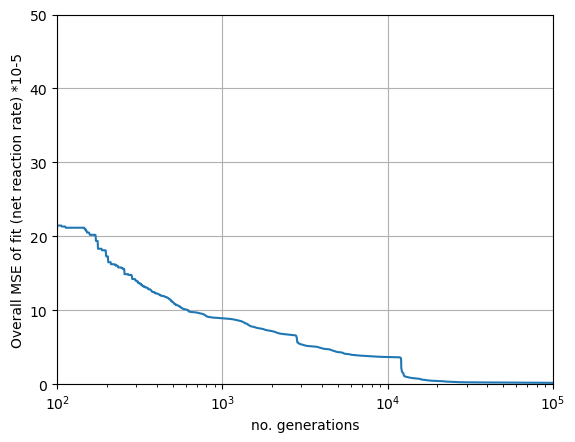

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.649834306880823
1.5440068005314074
0.8512690383178421
-4.3225397613001615
0.5022466884410257
5.796890431179192e-05
0.3969124548406421
-9.98667081862846
0.9510792973669944
8.641559259825321
6.89507920279572
6.808304389855944
0.9238718224464694
0.023960666100343465
3.1828443840855836
9.823267229293504e-05
0.06127146202411658
-11.999763620312363
1.8984380712597022
1.5862118100153846
-11.035616857186378
1.1367044627488405
3.8240972218909643
0.04039055200677228
3.931711421421381
4.949943466583254
1.8677291149733122
10.361212148763075
-7.720969024154719
2.697920086434669
3.042185353326288
3.1230123892756154
-4.447863707542882
0.5888656919555767
1.0945099196204555
-1.3010297671637578


In [37]:
res.X

array([-1.16498343e+01,  1.54400680e+00,  8.51269038e-01, -4.32253976e+00,
        5.02246688e-01,  5.79689043e-05,  3.96912455e-01, -9.98667082e+00,
        9.51079297e-01,  8.64155926e+00,  6.89507920e+00,  6.80830439e+00,
        9.23871822e-01,  2.39606661e-02,  3.18284438e+00,  9.82326723e-05,
        6.12714620e-02, -1.19997636e+01,  1.89843807e+00,  1.58621181e+00,
       -1.10356169e+01,  1.13670446e+00,  3.82409722e+00,  4.03905520e-02,
        3.93171142e+00,  4.94994347e+00,  1.86772911e+00,  1.03612121e+01,
       -7.72096902e+00,  2.69792009e+00,  3.04218535e+00,  3.12301239e+00,
       -4.44786371e+00,  5.88865692e-01,  1.09450992e+00, -1.30102977e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.649834306880823
1.6: 1.5440068005314074
0.9: 0.8512690383178421
-4.3: -4.3225397613001615
0.5: 0.5022466884410257
0.003: 5.796890431179192e-05
0.4: 0.3969124548406421
-7.9: -9.98667081862846
0.7: 0.9510792973669944
7.2: 8.641559259825321
5.7: 6.89507920279572
5.7: 6.808304389855944
0.8: 0.9238718224464694
0.03: 0.023960666100343465
3.1: 3.1828443840855836
6.000000000000001e-09: 9.823267229293504e-05
0.1: 0.06127146202411658
-12.0: -11.999763620312363
1.9: 1.8984380712597022
1.6: 1.5862118100153846
-11.6: -11.035616857186378
1.2: 1.1367044627488405
4.0: 3.8240972218909643
0.01: 0.04039055200677228
4.2: 3.931711421421381
5.4: 4.949943466583254
2.2: 1.8677291149733122
11.8: 10.361212148763075
-12.0: -7.720969024154719
3.3: 2.697920086434669
1.8: 3.042185353326288
4.2: 3.1230123892756154
-4.0: -4.447863707542882
0.5: 0.5888656919555767
1.0: 1.0945099196204555
coeff fit: 0.9676293213787919
r: 0.9836815141999934


In [1]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.16498343e+01,  1.54400680e+00,  8.51269038e-01, -4.32253976e+00,
        5.02246688e-01,  5.79689043e-05,  3.96912455e-01, -9.98667082e+00,
        9.51079297e-01,  8.64155926e+00,  6.89507920e+00,  6.80830439e+00,
        9.23871822e-01,  2.39606661e-02,  3.18284438e+00,  9.82326723e-05,
        6.12714620e-02, -1.19997636e+01,  1.89843807e+00,  1.58621181e+00,
       -1.10356169e+01,  1.13670446e+00,  3.82409722e+00,  4.03905520e-02,
        3.93171142e+00,  4.94994347e+00,  1.86772911e+00,  1.03612121e+01,
       -7.72096902e+00,  2.69792009e+00,  3.04218535e+00,  3.12301239e+00,
       -4.44786371e+00,  5.88865692e-01,  1.09450992e+00, -1.30102977e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-1.17076141e+01,  1.55323698e+00,  8.59142143e-01, -4.33005752e+00,
        5.04184588e-01,  4.12841969e-03,  3.98845195e-01, -9.05288671e+00,
        8.38407377e-01,  8.00689341e+00,  6.36945653e+00,  6.32253259e+00,
        9.03684640e-01,  2.38480700e-02,  3.16954828e+00,  1.88109627e-05,
        8.04751419e-02, -1.19999880e+01,  1.89963995e+00,  1.59741348e+00,
       -1.15179978e+01,  1.18990177e+00,  3.96668664e+00,  1.16212060e-02,
        4.16652658e+00,  5.15782493e+00,  2.07941635e+00,  1.12348823e+01,
       -1.19835277e+01,  3.31434844e+00,  1.85683622e+00,  4.19982480e+00,
       -4.04736098e+00,  5.09202919e-01,  1.00988445e+00, -1.30102990e+00]
krseed101 = [-1.17398995e+01,  1.55840569e+00,  8.63876810e-01, -4.32431351e+00,
        5.04744137e-01,  1.16985477e-02,  4.01168822e-01, -7.33207682e+00,
        6.32501005e-01,  6.80250936e+00,  5.36845431e+00,  5.39364829e+00,
        8.44711644e-01,  2.24983669e-02,  3.10363080e+00,  2.57373149e-06,
        1.19041026e-01, -1.17575165e+01,  1.85611546e+00,  1.55579406e+00,
       -1.10146100e+01,  1.13260625e+00,  3.79502294e+00,  2.44900322e-02,
        3.94688643e+00,  4.93522622e+00,  1.95283476e+00,  1.06560506e+01,
       -1.07507349e+01,  2.99109635e+00,  1.78385477e+00,  3.81115949e+00,
       -4.10683529e+00,  5.19651192e-01,  1.00729378e+00, -1.30102944e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.9930045638506132
r: 0.9964961434198394
-11.699115966666668
1.5518831566666667
0.858095997
-4.32563693
0.5037251376666667
0.005294978764766666
0.39897549066666665
-8.790544783333333
0.8073292263333333
7.8169873433333334
6.21099668
6.1748284233333335
0.8907560353333333
0.023435701
3.1520078199999997
3.987245549666667e-05
0.08692920996666666
-11.919089366666666
1.88473116
1.5798064500000002
-11.189408233333333
1.153070826666667
3.8619356000000002
0.025500596733333335
4.015041476666667
5.014331540000001
1.9666600733333333
10.750715
-10.151743873333333
3.0011216266666665
2.2276254466666665
3.7113322266666664
-4.20068666
0.5392399343333333
1.0372293833333333


In [2]:
meankr

[-11.699115966666668,
 1.5518831566666667,
 0.858095997,
 -4.32563693,
 0.5037251376666667,
 0.005294978764766666,
 0.39897549066666665,
 -8.790544783333333,
 0.8073292263333333,
 7.8169873433333334,
 6.21099668,
 6.1748284233333335,
 0.8907560353333333,
 0.023435701,
 3.1520078199999997,
 3.987245549666667e-05,
 0.08692920996666666,
 -11.919089366666666,
 1.88473116,
 1.5798064500000002,
 -11.189408233333333,
 1.153070826666667,
 3.8619356000000002,
 0.025500596733333335,
 4.015041476666667,
 5.014331540000001,
 1.9666600733333333,
 10.750715,
 -10.151743873333333,
 3.0011216266666665,
 2.2276254466666665,
 3.7113322266666664,
 -4.20068666,
 0.5392399343333333,
 1.0372293833333333]

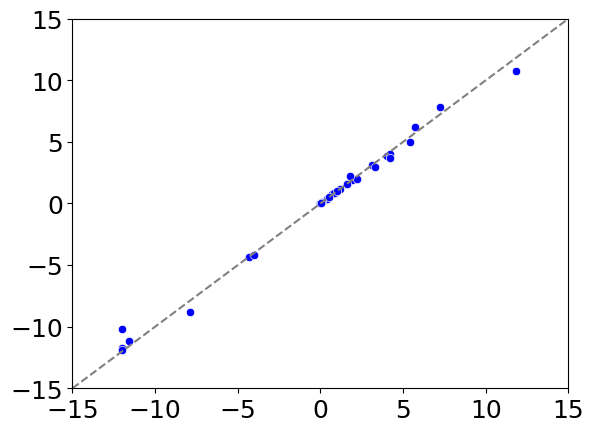

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()